# Extract cancer variant reads for alignment visualization

## In this notebook, we use a single RNA-seq fastq file from a melanoma cancer cell line from the the CCLE project. Learn more about the project here:
- sequencing data (ENA): https://www.ebi.ac.uk/ena/browser/view/PRJNA523380
- paper: https://www.nature.com/articles/s41586-019-1186-3

### Requirements: kb, samtools, and bowtie2

In [1]:
try:
    import varseek as vk
except ImportError:
    print("varseek not found, installing...")
    !pip install -U -q varseek
try:
    import RLSRP_2025
except ImportError:
    print("RLSRP_2025 not found, installing...")
    !pip install -q git+https://github.com/pachterlab/RLSRP_2025.git

In [2]:
import anndata
import os
import subprocess
from datetime import datetime
import numpy as np
import pandas as pd
import re
import gget
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import time
import pyfastx
import glob
import requests
from collections import Counter
import matplotlib.pyplot as plt
import textwrap
import seaborn as sns
from tqdm import tqdm
# pd.set_option('display.max_columns', None)
import varseek as vk

RLSRP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRP_2025
threads = "8"

### File path definitions and imports

ENST00000390312:c.218G>A       1848.0
ENST00000336023:c.614A>G       1493.0
ENST00000579721:c.870G>C       1464.0
ENST00000496168:c.382G>A       1382.0
ENST00000579721:c.41C>T        1346.0

In [3]:
experiment_alias = "E_GEUV_1_NA20502_3_M_120202_4"
fastq_file_base = "ERR188380"

notebook_out_dir = os.path.join(RLSRP_2025_dir, "data", "geuvadis_data_base", experiment_alias, "vk_count_out_w37_k41")
figures_out_dir = os.path.join(RLSRP_2025_dir, "data", "geuvadis_analysis_supplement", experiment_alias)
aligned_reads_parent_dir = os.path.join(notebook_out_dir, "pseudoaligned_reads_to_vcrs_reference")
bowtie_read_alignments = os.path.join(notebook_out_dir, "bowtie_read_alignments_modified_bam")
detailed_txt_out = os.path.join(notebook_out_dir, "detailed_out_modified_bam.txt")
overall_txt_out = os.path.join(notebook_out_dir, "overall_out_modified_bam.txt")

# fp df
fp_df_path = os.path.join(RLSRP_2025_dir, "data", "geuvadis_analysis_supplement", experiment_alias, "fp_df.parquet")
number_of_variants = None  # sorted by counts descending; None for all
hgvs_df_path = os.path.join(RLSRP_2025_dir, "data", "reference", "geuvadis", "variants_transcriptome.parquet")

# vk ref out directory and files - downloaded if not already present
vk_ref_out_dir = os.path.join(RLSRP_2025_dir, "data", "vk_ref_out_geuvadis", "w37_k41")
vcrs_index = os.path.join(vk_ref_out_dir, "vcrs_index.idx")
vcrs_t2g = os.path.join(vk_ref_out_dir, "vcrs_t2g_filtered.txt")
vcrs_fasta = os.path.join(vk_ref_out_dir, "vcrs_filtered.fa")

# fastq directories - fastqs_dir downloaded if not already present, and fastqs_processed_dir created with fastp if not already present
fastqs_dir = os.path.join(RLSRP_2025_dir, "data", "geuvadis_data_base", experiment_alias)
fastq_files = [os.path.join(fastqs_dir, f"{fastq_file_base}_1.fastq.gz"), os.path.join(fastqs_dir, f"{fastq_file_base}_2.fastq.gz")]
fastq_file = os.path.join(fastqs_dir, "fastqs_combined", "fastqs_combined.fastq.gz")  # os.path.join(fastqs_dir, "ERR204838_1.fastq.gz")
technology = "bulk"

# reference genome directory
reference_genome_dir = os.path.join(RLSRP_2025_dir, "data", "reference", "ensembl_grch37_release113")
reference_genome_fasta = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.dna.primary_assembly.fa")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf
reference_genome_gtf = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.87.gtf")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf

# for bowtie2 - also uses reference_genome_fasta above (I could use cdna instead of genome too if desired)
bowtie_reference_dir = os.path.join(reference_genome_dir, "bowtie_index_genome")
bowtie_reference_prefix = os.path.join(bowtie_reference_dir, "index")

# more settings for vk count if needed
reference_out_dir = os.path.join(RLSRP_2025_dir, "data", "reference")
reference_genome_index = os.path.join(reference_out_dir, "ensembl_grch37_release113", "index.idx")  # can either already exist or will be created; only used if qc_against_gene_matrix=True
reference_genome_t2g = os.path.join(reference_out_dir, "ensembl_grch37_release113", "t2g.txt")  # can either already exist or will be created; only used if qc_against_gene_matrix=True
geuvadis_reference_files_dir = os.path.join(reference_out_dir, "geuvadis")
seq_id_column = "transcript_ID"
var_column = "variant_cdna"
gene_id_column = "gene_name"
variants_usecols = [seq_id_column, var_column, gene_id_column]

# general
w = "37"  # used during creation of the index, so cannot be altered
k = "41"  # used during creation of the index, so cannot be altered
strand = "unstranded"
parity = "single"
mm = True
union = True
quality_control_fastqs = True
qc_against_gene_matrix = False
mistake_ratio = 0.5
use_combined = True
modify_bam = True  # convert 256 flag to 0
min_counts = 2

# software
bustools = "/home/jmrich/miniconda3/envs/varseek2/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools"
bowtie2 = "bowtie2"
bowtie2_build = "bowtie2-build"
samtools = "samtools"
email = os.environ.get("EMAIL")

### Make bowtie2 index files

In [4]:
if not os.path.exists(bowtie_reference_dir) or len(os.listdir(bowtie_reference_dir)) == 0:
    os.makedirs(bowtie_reference_dir, exist_ok=True)
    !{bowtie2_build} --threads {threads} {reference_genome_fasta} {bowtie_reference_prefix}

### Load in FP df

In [5]:
fp_df = pd.read_parquet(fp_df_path)
if "variant_count" in fp_df.columns and "vcrs_count" not in fp_df.columns:
    fp_df = fp_df.rename(columns={"variant_count": "vcrs_count"})
fp_df = fp_df.sort_values("vcrs_count", ascending=False)
if number_of_variants is not None:
    fp_df = fp_df.head(number_of_variants)

# fp_df = fp_df.set_index('variant_header')
fps = set(fp_df['variant_header'].tolist())
print(fps)
fp_df.head()

{'ENST00000319274:c.3631C>T', 'ENST00000339436:c.326A>G', 'ENST00000313077:c.3152C>T', 'ENST00000378372:c.329C>T', 'ENST00000327154:c.576C>T', 'ENST00000196551:c.255C>T', 'ENST00000227157:c.683G>C', 'ENST00000236957:c.386G>A', 'ENST00000334828:c.445T>C', 'ENST00000432829:c.1804T>C', 'ENST00000390321:c.62C>T', 'ENST00000216455:c.234T>C', 'ENST00000268720:c.1939G>A', 'ENST00000349038:c.120C>T', 'ENST00000350303:c.346A>G', 'ENST00000579721:c.89G>A', 'ENST00000355540:c.10187T>C', 'ENST00000379412:c.1167G>A', 'ENST00000604045:c.219T>C', 'ENST00000368567:c.58T>C', 'ENST00000281589:c.1050T>A', 'ENST00000271324:c.276T>C', 'ENST00000412585:c.267G>A', 'ENST00000349038:c.232T>C', 'ENST00000418386:c.325A>C', 'ENST00000262605:c.196A>C', 'ENST00000310931:c.3444C>T', 'ENST00000579721:c.1001G>A', 'ENST00000369466:c.2611A>G', 'ENST00000334828:c.407C>T', 'ENST00000412585:c.346G>T', 'ENST00000217109:c.1086A>G', 'ENST00000306368:c.99G>A', 'ENST00000215071:c.834C>T', 'ENST00000279259:c.107C>T', 'ENST000003

,vcrs_count,variant_header_cds,variant_header,transcript_ID,gene,gene_count,genotype
index,,,,,,,
128120,4943.0,ENST00000603423.1:c.87G>A,ENST00000603423:c.137G>A,ENST00000603423,None,NaN,0.0
58563,568.0,ENST00000579721.1:c.112C>T,ENST00000579721:c.112C>T,ENST00000579721,None,NaN,0.0
174896,313.0,ENST00000390299.2:c.177G>A,ENST00000390299:c.228G>A,ENST00000390299,ENSG00000211653,33972.0,0.0
142189,50.0,ENST00000268720.5:c.1809G>A,ENST00000268720:c.1939G>A,ENST00000268720,ENSG00000178773,621.0,0.0
136646,30.0,ENST00000325823.7:c.159C>A,ENST00000325823:c.246C>A,ENST00000325823,ENSG00000179889,2714.0,0.0


### Make pyfastx index files

In [6]:
if use_combined:
    if not os.path.isfile(fastq_file):
        import gzip
        os.makedirs(os.path.dirname(fastq_file), exist_ok=True)
        def process_and_write(input_path, output_file, file_tag):
            with gzip.open(input_path, "rt") as f_in:
                for i, line in enumerate(f_in):
                    if i % 4 == 0 and line.startswith('@'):
                        line = f"@{file_tag}{line[1:]}"  # replace @ with @fileX
                    output_file.write(line)

        with gzip.open(fastq_file, "wt") as f_out:
            process_and_write(fastq_files[0], f_out, "file1")
            process_and_write(fastq_files[1], f_out, "file2")
else:
    fastq_file = fastq_files[0]

In [7]:
fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)

### Perform variant screening with varseek count

In [8]:
kb_count_out_dir = os.path.join(notebook_out_dir, "kb_count_out_vcrs")
adata_path = os.path.join(kb_count_out_dir, "counts_unfiltered", "adata.h5ad")

if not os.path.exists(adata_path):
    vk_count_output_dict = vk.count(
        fastqs=fastq_file,
        index=vcrs_index,
        t2g=vcrs_t2g,
        technology=technology,
        out=notebook_out_dir,
        k=k,
        strand=strand,
        parity=parity,
        threads=threads,
        mm=mm,
        union=union,
        disable_fastqpp=False,
        quality_control_fastqs=True, cut_front=True, cut_tail=True,
        qc_against_gene_matrix=qc_against_gene_matrix, reference_genome_index=reference_genome_index, reference_genome_t2g=reference_genome_t2g, mistake_ratio=mistake_ratio,
        variants = os.path.join(geuvadis_reference_files_dir, "variants_transcriptome.parquet"),
        seq_id_column=seq_id_column,
        var_column=var_column,
        gene_id_column=gene_id_column,
        variants_usecols=variants_usecols,
    )

In [9]:
# url = "https://grch37.rest.ensembl.org/vep/human/id"
# headers = {"Content-Type": "application/json"}

hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df = hgvs_df.merge(fp_df, how="left", left_on="header_cdna", right_on="variant_header", suffixes=("", "_fp"))
hgvs_df = hgvs_df.loc[~hgvs_df['vcrs_count'].isna()].sort_values('vcrs_count', ascending=False)  # .sort_values('vcrs_id', ascending=True)
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [10]:
fp_df.head()

,vcrs_count,variant_header_cds,variant_header,transcript_ID,gene,gene_count,genotype
index,,,,,,,
128120,4943.0,ENST00000603423.1:c.87G>A,ENST00000603423:c.137G>A,ENST00000603423,None,NaN,0.0
58563,568.0,ENST00000579721.1:c.112C>T,ENST00000579721:c.112C>T,ENST00000579721,None,NaN,0.0
174896,313.0,ENST00000390299.2:c.177G>A,ENST00000390299:c.228G>A,ENST00000390299,ENSG00000211653,33972.0,0.0
142189,50.0,ENST00000268720.5:c.1809G>A,ENST00000268720:c.1939G>A,ENST00000268720,ENSG00000178773,621.0,0.0
136646,30.0,ENST00000325823.7:c.159C>A,ENST00000325823:c.246C>A,ENST00000325823,ENSG00000179889,2714.0,0.0


From dbSNP (roughly):
ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.23101523G>A chrom22
ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
ENST00000579721:c.41C>T: rs115527405
ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6

### Align (1) pulled out reads and (2) the VCRSs to the human genome to generate bam files:

In [11]:
import pysam

def make_all_alignments_primary(infile_path, outfile_path):
    infile = pysam.AlignmentFile(infile_path, "rb")
    outfile = pysam.AlignmentFile(outfile_path, "wb", template=infile)

    for read in infile:
        read.flag = read.flag & ~256  # remove secondary flag
        outfile.write(read)

    infile.close()
    outfile.close()

In [12]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": email if email else "Mozilla/5.0 (compatible; PythonScript/1.0)"}

true_variants = []  # varseek FP where varseek was correct
false_variants = []  # varseek FP where varseek was incorrect
undetermined_variants = []  # insufficient reads mapped to this point
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    #* new stuff
    try:
        hgvs_df_row = hgvs_df.loc[hgvs_df['vcrs_id'] == variant]
        dbsnp_id = hgvs_df_row['dbsnp_id'].values[0]
        hgvsc = hgvs_df_row['header_cdna'].values[0]
        strand = hgvs_df_row['strand'].values[0]
        variant_counts = hgvs_df_row['vcrs_count'].values[0]
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = hgvs_df_row['transcript_ID'].values[0]
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= min_counts  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
        false_variant = base_counts[ref_allele] >= min_counts and not true_variant
            
        if true_variant:  # >= min_counts alt alleles
            variant_status = "True"
            true_variants.append(variant_header)
        elif false_variant:  # >= min_counts ref alleles and <min_counts alt alleles
            variant_status = "False"
            false_variants.append(variant_header)
        else:  # <min_counts alt alleles and <min_counts ref alleles (ie insufficient read mapping)
            variant_status = "Undetermined"
            undetermined_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out) else "w"
        with open(detailed_txt_out, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} | {variant_counts} reported counts\n")
            f.write(f"True variant: {variant_status}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"Number of undetermined variants: {len(undetermined_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Undetermined variants list: {undetermined_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

12:44:15: Entering the loop


  0%|                                                                                                                             | 0/483 [00:00<?, ?it/s]

  0%|▏                                                                                                                    | 1/483 [00:01<13:32,  1.69s/it]

  0%|▍                                                                                                                    | 2/483 [00:02<11:41,  1.46s/it]

  1%|▋                                                                                                                    | 3/483 [00:03<08:45,  1.10s/it]

  1%|▉                                                                                                                    | 4/483 [00:04<07:08,  1.12it/s]

  1%|█▏                                                                                                                   | 5/483 [00:05<07:10,  1.11it/s]

  1%|█▍                                                                                                                   | 6/483 [00:05<06:32,  1.21it/s]

  1%|█▋                                                                                                                   | 7/483 [00:06<06:04,  1.31it/s]

  2%|█▉                                                                                                                   | 8/483 [00:07<05:38,  1.40it/s]

  2%|██▏                                                                                                                  | 9/483 [00:07<05:58,  1.32it/s]

  2%|██▍                                                                                                                 | 10/483 [00:08<05:41,  1.39it/s]

  2%|██▋                                                                                                                 | 11/483 [00:09<05:27,  1.44it/s]

  2%|██▉                                                                                                                 | 12/483 [00:09<05:22,  1.46it/s]

  3%|███                                                                                                                 | 13/483 [00:11<06:55,  1.13it/s]

  3%|███▎                                                                                                                | 14/483 [00:11<06:11,  1.26it/s]

  3%|███▌                                                                                                                | 15/483 [00:12<06:22,  1.22it/s]

  3%|███▊                                                                                                                | 16/483 [00:13<05:54,  1.32it/s]

  4%|████                                                                                                                | 17/483 [00:14<06:01,  1.29it/s]

  4%|████▎                                                                                                               | 18/483 [00:14<05:41,  1.36it/s]

  4%|████▌                                                                                                               | 19/483 [00:15<05:23,  1.44it/s]

  4%|████▊                                                                                                               | 20/483 [00:15<05:08,  1.50it/s]

  4%|█████                                                                                                               | 21/483 [00:16<04:57,  1.55it/s]

  5%|█████▎                                                                                                              | 22/483 [00:17<04:49,  1.59it/s]

  5%|█████▌                                                                                                              | 23/483 [00:17<05:06,  1.50it/s]

  5%|█████▊                                                                                                              | 24/483 [00:18<05:01,  1.52it/s]

  5%|██████                                                                                                              | 25/483 [00:19<04:52,  1.56it/s]

  5%|██████▏                                                                                                             | 26/483 [00:19<04:45,  1.60it/s]

  6%|██████▍                                                                                                             | 27/483 [00:20<04:47,  1.58it/s]

  6%|██████▋                                                                                                             | 28/483 [00:20<04:40,  1.62it/s]

  6%|██████▉                                                                                                             | 29/483 [00:21<04:41,  1.61it/s]

  6%|███████▏                                                                                                            | 30/483 [00:22<05:57,  1.27it/s]

  6%|███████▍                                                                                                            | 31/483 [00:23<05:30,  1.37it/s]

  7%|███████▋                                                                                                            | 32/483 [00:23<05:10,  1.45it/s]

  7%|███████▉                                                                                                            | 33/483 [00:24<05:10,  1.45it/s]

  7%|████████▏                                                                                                           | 34/483 [00:25<04:58,  1.50it/s]

  7%|████████▍                                                                                                           | 35/483 [00:25<04:48,  1.55it/s]

  8%|████████▉                                                                                                           | 37/483 [00:26<03:35,  2.07it/s]

  8%|█████████▏                                                                                                          | 38/483 [00:27<04:10,  1.77it/s]

  8%|█████████▎                                                                                                          | 39/483 [00:27<04:14,  1.75it/s]

  8%|█████████▌                                                                                                          | 40/483 [00:28<04:21,  1.69it/s]

  8%|█████████▊                                                                                                          | 41/483 [00:29<04:37,  1.59it/s]

  9%|██████████                                                                                                          | 42/483 [00:29<04:32,  1.62it/s]

  9%|██████████▎                                                                                                         | 43/483 [00:31<05:59,  1.22it/s]

  9%|██████████▌                                                                                                         | 44/483 [00:31<05:34,  1.31it/s]

  9%|██████████▊                                                                                                         | 45/483 [00:32<05:12,  1.40it/s]

 10%|███████████                                                                                                         | 46/483 [00:32<04:57,  1.47it/s]

 10%|███████████▌                                                                                                        | 48/483 [00:33<03:44,  1.94it/s]

 10%|███████████▊                                                                                                        | 49/483 [00:34<04:21,  1.66it/s]

 10%|████████████                                                                                                        | 50/483 [00:34<04:19,  1.67it/s]

 11%|████████████▏                                                                                                       | 51/483 [00:35<04:23,  1.64it/s]

 11%|████████████▍                                                                                                       | 52/483 [00:36<04:20,  1.66it/s]

 11%|████████████▋                                                                                                       | 53/483 [00:36<04:20,  1.65it/s]

 11%|████████████▉                                                                                                       | 54/483 [00:37<04:31,  1.58it/s]

 11%|█████████████▏                                                                                                      | 55/483 [00:38<05:52,  1.21it/s]

 12%|█████████████▍                                                                                                      | 56/483 [00:40<07:12,  1.01s/it]

 12%|█████████████▋                                                                                                      | 57/483 [00:40<06:23,  1.11it/s]

 12%|█████████████▉                                                                                                      | 58/483 [00:41<06:09,  1.15it/s]

 12%|██████████████▏                                                                                                     | 59/483 [00:42<05:33,  1.27it/s]

 12%|██████████████▍                                                                                                     | 60/483 [00:42<05:06,  1.38it/s]

 13%|██████████████▋                                                                                                     | 61/483 [00:43<04:56,  1.42it/s]

 13%|██████████████▉                                                                                                     | 62/483 [00:44<04:43,  1.49it/s]

 13%|███████████████▏                                                                                                    | 63/483 [00:44<04:45,  1.47it/s]

 13%|███████████████▎                                                                                                    | 64/483 [00:45<04:46,  1.46it/s]

 13%|███████████████▌                                                                                                    | 65/483 [00:46<06:11,  1.13it/s]

 14%|███████████████▊                                                                                                    | 66/483 [00:47<05:35,  1.24it/s]

 14%|████████████████                                                                                                    | 67/483 [00:48<05:29,  1.26it/s]

 14%|████████████████▎                                                                                                   | 68/483 [00:48<05:04,  1.36it/s]

 14%|████████████████▌                                                                                                   | 69/483 [00:49<05:00,  1.38it/s]

 14%|████████████████▊                                                                                                   | 70/483 [00:50<06:04,  1.13it/s]

 15%|█████████████████                                                                                                   | 71/483 [00:51<05:32,  1.24it/s]

 15%|█████████████████▎                                                                                                  | 72/483 [00:52<05:04,  1.35it/s]

 15%|█████████████████▌                                                                                                  | 73/483 [00:52<04:51,  1.41it/s]

 15%|█████████████████▊                                                                                                  | 74/483 [00:53<06:03,  1.13it/s]

 16%|██████████████████                                                                                                  | 75/483 [00:54<05:27,  1.25it/s]

 16%|██████████████████▎                                                                                                 | 76/483 [00:55<06:17,  1.08it/s]

 16%|██████████████████▍                                                                                                 | 77/483 [00:57<07:18,  1.08s/it]

 16%|██████████████████▋                                                                                                 | 78/483 [00:57<06:16,  1.08it/s]

 16%|██████████████████▉                                                                                                 | 79/483 [00:58<05:33,  1.21it/s]

 17%|███████████████████▏                                                                                                | 80/483 [00:59<05:16,  1.27it/s]

 17%|███████████████████▍                                                                                                | 81/483 [01:00<06:25,  1.04it/s]

 17%|███████████████████▋                                                                                                | 82/483 [01:01<06:33,  1.02it/s]

 17%|███████████████████▉                                                                                                | 83/483 [01:02<05:46,  1.16it/s]

 17%|████████████████████▏                                                                                               | 84/483 [01:02<05:15,  1.27it/s]

 18%|████████████████████▍                                                                                               | 85/483 [01:03<05:03,  1.31it/s]

 18%|████████████████████▋                                                                                               | 86/483 [01:04<04:46,  1.39it/s]

 18%|████████████████████▉                                                                                               | 87/483 [01:04<04:28,  1.48it/s]

 18%|█████████████████████▏                                                                                              | 88/483 [01:05<04:16,  1.54it/s]

 18%|█████████████████████▎                                                                                              | 89/483 [01:05<04:29,  1.46it/s]

 19%|█████████████████████▌                                                                                              | 90/483 [01:06<04:31,  1.45it/s]

 19%|█████████████████████▊                                                                                              | 91/483 [01:07<04:18,  1.51it/s]

 19%|██████████████████████                                                                                              | 92/483 [01:07<04:08,  1.57it/s]

 19%|██████████████████████▎                                                                                             | 93/483 [01:08<03:59,  1.63it/s]

 19%|██████████████████████▌                                                                                             | 94/483 [01:08<03:58,  1.63it/s]

 20%|██████████████████████▊                                                                                             | 95/483 [01:09<03:53,  1.66it/s]

 20%|███████████████████████                                                                                             | 96/483 [01:10<03:52,  1.67it/s]

 20%|███████████████████████▎                                                                                            | 97/483 [01:10<03:51,  1.67it/s]

 20%|███████████████████████▌                                                                                            | 98/483 [01:11<03:53,  1.65it/s]

 20%|███████████████████████▊                                                                                            | 99/483 [01:12<03:54,  1.64it/s]

 21%|███████████████████████▊                                                                                           | 100/483 [01:12<03:51,  1.65it/s]

 21%|████████████████████████                                                                                           | 101/483 [01:13<03:55,  1.63it/s]

 21%|████████████████████████▎                                                                                          | 102/483 [01:13<03:55,  1.62it/s]

 21%|████████████████████████▌                                                                                          | 103/483 [01:14<03:49,  1.65it/s]

 22%|████████████████████████▊                                                                                          | 104/483 [01:15<03:50,  1.64it/s]

 22%|█████████████████████████                                                                                          | 105/483 [01:15<03:49,  1.65it/s]

 22%|█████████████████████████▏                                                                                         | 106/483 [01:16<03:46,  1.66it/s]

 22%|█████████████████████████▍                                                                                         | 107/483 [01:16<03:58,  1.58it/s]

 22%|█████████████████████████▋                                                                                         | 108/483 [01:17<03:56,  1.58it/s]

 23%|█████████████████████████▉                                                                                         | 109/483 [01:18<03:53,  1.60it/s]

 23%|██████████████████████████▏                                                                                        | 110/483 [01:18<03:49,  1.63it/s]

 23%|██████████████████████████▍                                                                                        | 111/483 [01:19<03:47,  1.64it/s]

 23%|██████████████████████████▋                                                                                        | 112/483 [01:20<03:48,  1.62it/s]

 23%|██████████████████████████▉                                                                                        | 113/483 [01:20<03:49,  1.61it/s]

 24%|███████████████████████████▏                                                                                       | 114/483 [01:21<03:50,  1.60it/s]

 24%|███████████████████████████▍                                                                                       | 115/483 [01:22<04:07,  1.49it/s]

 24%|███████████████████████████▌                                                                                       | 116/483 [01:22<04:00,  1.52it/s]

 24%|███████████████████████████▊                                                                                       | 117/483 [01:23<03:50,  1.59it/s]

 24%|████████████████████████████                                                                                       | 118/483 [01:23<03:43,  1.63it/s]

 25%|████████████████████████████▎                                                                                      | 119/483 [01:24<03:45,  1.61it/s]

 25%|████████████████████████████▌                                                                                      | 120/483 [01:25<03:39,  1.65it/s]

 25%|████████████████████████████▊                                                                                      | 121/483 [01:26<04:41,  1.28it/s]

 25%|█████████████████████████████                                                                                      | 122/483 [01:26<04:17,  1.40it/s]

 25%|█████████████████████████████▎                                                                                     | 123/483 [01:27<04:03,  1.48it/s]

 26%|█████████████████████████████▌                                                                                     | 124/483 [01:27<03:56,  1.52it/s]

 26%|█████████████████████████████▊                                                                                     | 125/483 [01:28<04:13,  1.41it/s]

 26%|██████████████████████████████                                                                                     | 126/483 [01:29<04:10,  1.43it/s]

 26%|██████████████████████████████▏                                                                                    | 127/483 [01:30<03:55,  1.51it/s]

 27%|██████████████████████████████▍                                                                                    | 128/483 [01:30<04:09,  1.43it/s]

 27%|██████████████████████████████▋                                                                                    | 129/483 [01:31<03:57,  1.49it/s]

 27%|██████████████████████████████▉                                                                                    | 130/483 [01:32<03:51,  1.52it/s]

 27%|███████████████████████████████▏                                                                                   | 131/483 [01:32<03:43,  1.58it/s]

 27%|███████████████████████████████▍                                                                                   | 132/483 [01:33<03:45,  1.56it/s]

 28%|███████████████████████████████▋                                                                                   | 133/483 [01:33<03:42,  1.57it/s]

 28%|███████████████████████████████▉                                                                                   | 134/483 [01:34<03:48,  1.53it/s]

 28%|████████████████████████████████▏                                                                                  | 135/483 [01:35<04:09,  1.40it/s]

 28%|████████████████████████████████▍                                                                                  | 136/483 [01:36<03:55,  1.47it/s]

 28%|████████████████████████████████▌                                                                                  | 137/483 [01:36<03:48,  1.52it/s]

 29%|████████████████████████████████▊                                                                                  | 138/483 [01:37<03:41,  1.56it/s]

 29%|█████████████████████████████████                                                                                  | 139/483 [01:37<03:34,  1.61it/s]

 29%|█████████████████████████████████▎                                                                                 | 140/483 [01:38<03:30,  1.63it/s]

 29%|█████████████████████████████████▌                                                                                 | 141/483 [01:39<03:28,  1.64it/s]

 29%|█████████████████████████████████▊                                                                                 | 142/483 [01:40<04:27,  1.27it/s]

 30%|██████████████████████████████████                                                                                 | 143/483 [01:40<04:11,  1.35it/s]

 30%|██████████████████████████████████▎                                                                                | 144/483 [01:41<03:54,  1.44it/s]

 30%|██████████████████████████████████▌                                                                                | 145/483 [01:42<03:43,  1.51it/s]

 30%|██████████████████████████████████▊                                                                                | 146/483 [01:42<03:36,  1.56it/s]

 30%|███████████████████████████████████                                                                                | 147/483 [01:43<03:31,  1.59it/s]

 31%|███████████████████████████████████▏                                                                               | 148/483 [01:43<03:30,  1.59it/s]

 31%|███████████████████████████████████▍                                                                               | 149/483 [01:44<03:25,  1.62it/s]

 31%|███████████████████████████████████▋                                                                               | 150/483 [01:45<03:23,  1.63it/s]

 31%|███████████████████████████████████▉                                                                               | 151/483 [01:45<03:19,  1.66it/s]

 31%|████████████████████████████████████▏                                                                              | 152/483 [01:46<03:15,  1.69it/s]

 32%|████████████████████████████████████▍                                                                              | 153/483 [01:46<03:19,  1.66it/s]

 32%|████████████████████████████████████▋                                                                              | 154/483 [01:47<03:20,  1.64it/s]

 32%|████████████████████████████████████▉                                                                              | 155/483 [01:48<03:16,  1.67it/s]

 32%|█████████████████████████████████████▏                                                                             | 156/483 [01:48<03:15,  1.67it/s]

 33%|█████████████████████████████████████▍                                                                             | 157/483 [01:49<04:14,  1.28it/s]

 33%|█████████████████████████████████████▌                                                                             | 158/483 [01:50<04:19,  1.25it/s]

 33%|█████████████████████████████████████▊                                                                             | 159/483 [01:51<04:03,  1.33it/s]

 33%|██████████████████████████████████████                                                                             | 160/483 [01:51<03:50,  1.40it/s]

 33%|██████████████████████████████████████▎                                                                            | 161/483 [01:52<03:43,  1.44it/s]

 34%|██████████████████████████████████████▌                                                                            | 162/483 [01:53<03:30,  1.53it/s]

 34%|██████████████████████████████████████▊                                                                            | 163/483 [01:53<03:25,  1.56it/s]

 34%|███████████████████████████████████████                                                                            | 164/483 [01:54<03:23,  1.57it/s]

 34%|███████████████████████████████████████▎                                                                           | 165/483 [01:55<03:17,  1.61it/s]

 34%|███████████████████████████████████████▌                                                                           | 166/483 [01:55<03:11,  1.65it/s]

 35%|███████████████████████████████████████▊                                                                           | 167/483 [01:56<03:08,  1.68it/s]

 35%|████████████████████████████████████████                                                                           | 168/483 [01:56<03:20,  1.57it/s]

 35%|████████████████████████████████████████▏                                                                          | 169/483 [01:57<03:32,  1.48it/s]

 35%|████████████████████████████████████████▍                                                                          | 170/483 [01:59<04:35,  1.13it/s]

 35%|████████████████████████████████████████▋                                                                          | 171/483 [01:59<04:05,  1.27it/s]

 36%|████████████████████████████████████████▉                                                                          | 172/483 [02:00<03:57,  1.31it/s]

 36%|█████████████████████████████████████████▏                                                                         | 173/483 [02:00<03:47,  1.37it/s]

 36%|█████████████████████████████████████████▍                                                                         | 174/483 [02:01<03:38,  1.42it/s]

 36%|█████████████████████████████████████████▋                                                                         | 175/483 [02:02<03:24,  1.51it/s]

 36%|█████████████████████████████████████████▉                                                                         | 176/483 [02:02<03:16,  1.56it/s]

 37%|██████████████████████████████████████████▏                                                                        | 177/483 [02:03<03:22,  1.51it/s]

 37%|██████████████████████████████████████████▍                                                                        | 178/483 [02:04<03:13,  1.58it/s]

 37%|██████████████████████████████████████████▌                                                                        | 179/483 [02:04<03:27,  1.46it/s]

 37%|██████████████████████████████████████████▊                                                                        | 180/483 [02:05<03:17,  1.53it/s]

 37%|███████████████████████████████████████████                                                                        | 181/483 [02:05<03:10,  1.58it/s]

 38%|███████████████████████████████████████████▎                                                                       | 182/483 [02:06<03:07,  1.60it/s]

 38%|███████████████████████████████████████████▌                                                                       | 183/483 [02:07<03:03,  1.63it/s]

 38%|███████████████████████████████████████████▊                                                                       | 184/483 [02:08<04:06,  1.21it/s]

 38%|████████████████████████████████████████████                                                                       | 185/483 [02:09<04:04,  1.22it/s]

 39%|████████████████████████████████████████████▎                                                                      | 186/483 [02:09<03:41,  1.34it/s]

 39%|████████████████████████████████████████████▌                                                                      | 187/483 [02:10<03:43,  1.32it/s]

 39%|████████████████████████████████████████████▊                                                                      | 188/483 [02:11<03:26,  1.43it/s]

 39%|█████████████████████████████████████████████                                                                      | 189/483 [02:12<04:23,  1.12it/s]

 39%|█████████████████████████████████████████████▏                                                                     | 190/483 [02:13<03:54,  1.25it/s]

 40%|█████████████████████████████████████████████▍                                                                     | 191/483 [02:13<03:35,  1.36it/s]

 40%|█████████████████████████████████████████████▋                                                                     | 192/483 [02:14<03:36,  1.35it/s]

 40%|█████████████████████████████████████████████▉                                                                     | 193/483 [02:15<03:41,  1.31it/s]

 40%|██████████████████████████████████████████████▏                                                                    | 194/483 [02:16<04:28,  1.08it/s]

 41%|██████████████████████████████████████████████▋                                                                    | 196/483 [02:17<03:00,  1.59it/s]

 41%|██████████████████████████████████████████████▉                                                                    | 197/483 [02:17<02:57,  1.61it/s]

 41%|███████████████████████████████████████████████▏                                                                   | 198/483 [02:18<02:56,  1.62it/s]

 41%|███████████████████████████████████████████████▍                                                                   | 199/483 [02:18<02:52,  1.65it/s]

 41%|███████████████████████████████████████████████▌                                                                   | 200/483 [02:19<02:49,  1.67it/s]

 42%|███████████████████████████████████████████████▊                                                                   | 201/483 [02:20<02:47,  1.69it/s]

 42%|████████████████████████████████████████████████                                                                   | 202/483 [02:20<02:44,  1.71it/s]

 42%|████████████████████████████████████████████████▎                                                                  | 203/483 [02:21<02:42,  1.72it/s]

 42%|████████████████████████████████████████████████▌                                                                  | 204/483 [02:21<02:42,  1.71it/s]

 42%|████████████████████████████████████████████████▊                                                                  | 205/483 [02:22<02:42,  1.71it/s]

 43%|█████████████████████████████████████████████████                                                                  | 206/483 [02:23<02:42,  1.71it/s]

 43%|█████████████████████████████████████████████████▎                                                                 | 207/483 [02:23<02:41,  1.71it/s]

 43%|█████████████████████████████████████████████████▌                                                                 | 208/483 [02:24<02:41,  1.70it/s]

 43%|█████████████████████████████████████████████████▊                                                                 | 209/483 [02:24<02:40,  1.70it/s]

 43%|██████████████████████████████████████████████████                                                                 | 210/483 [02:25<02:40,  1.70it/s]

 44%|██████████████████████████████████████████████████▏                                                                | 211/483 [02:25<02:39,  1.70it/s]

 44%|██████████████████████████████████████████████████▍                                                                | 212/483 [02:26<02:37,  1.72it/s]

 44%|██████████████████████████████████████████████████▋                                                                | 213/483 [02:27<02:37,  1.72it/s]

 44%|██████████████████████████████████████████████████▉                                                                | 214/483 [02:27<02:35,  1.73it/s]

 45%|███████████████████████████████████████████████████▏                                                               | 215/483 [02:28<02:34,  1.74it/s]

 45%|███████████████████████████████████████████████████▍                                                               | 216/483 [02:28<02:33,  1.74it/s]

 45%|███████████████████████████████████████████████████▋                                                               | 217/483 [02:29<02:33,  1.73it/s]

 45%|███████████████████████████████████████████████████▉                                                               | 218/483 [02:29<02:32,  1.74it/s]

 45%|████████████████████████████████████████████████████▏                                                              | 219/483 [02:30<02:38,  1.67it/s]

 46%|████████████████████████████████████████████████████▍                                                              | 220/483 [02:31<02:37,  1.67it/s]

 46%|████████████████████████████████████████████████████▌                                                              | 221/483 [02:31<02:36,  1.67it/s]

 46%|████████████████████████████████████████████████████▊                                                              | 222/483 [02:32<02:35,  1.67it/s]

 46%|█████████████████████████████████████████████████████                                                              | 223/483 [02:33<02:42,  1.60it/s]

 46%|█████████████████████████████████████████████████████▎                                                             | 224/483 [02:33<02:39,  1.62it/s]

 47%|█████████████████████████████████████████████████████▌                                                             | 225/483 [02:34<02:43,  1.57it/s]

 47%|█████████████████████████████████████████████████████▊                                                             | 226/483 [02:35<02:47,  1.54it/s]

 47%|██████████████████████████████████████████████████████                                                             | 227/483 [02:35<02:45,  1.55it/s]

 47%|██████████████████████████████████████████████████████▎                                                            | 228/483 [02:36<02:43,  1.56it/s]

 47%|██████████████████████████████████████████████████████▌                                                            | 229/483 [02:37<02:44,  1.54it/s]

 48%|██████████████████████████████████████████████████████▊                                                            | 230/483 [02:37<02:46,  1.52it/s]

 48%|███████████████████████████████████████████████████████                                                            | 231/483 [02:38<02:42,  1.56it/s]

 48%|███████████████████████████████████████████████████████▏                                                           | 232/483 [02:39<03:34,  1.17it/s]

 48%|███████████████████████████████████████████████████████▍                                                           | 233/483 [02:40<03:19,  1.25it/s]

 48%|███████████████████████████████████████████████████████▋                                                           | 234/483 [02:40<03:05,  1.34it/s]

 49%|███████████████████████████████████████████████████████▉                                                           | 235/483 [02:41<02:55,  1.41it/s]

 49%|████████████████████████████████████████████████████████▏                                                          | 236/483 [02:42<02:45,  1.49it/s]

 49%|████████████████████████████████████████████████████████▍                                                          | 237/483 [02:42<02:42,  1.52it/s]

 49%|████████████████████████████████████████████████████████▋                                                          | 238/483 [02:43<02:54,  1.40it/s]

 49%|████████████████████████████████████████████████████████▉                                                          | 239/483 [02:44<02:45,  1.48it/s]

 50%|█████████████████████████████████████████████████████████▏                                                         | 240/483 [02:44<02:38,  1.53it/s]

 50%|█████████████████████████████████████████████████████████▍                                                         | 241/483 [02:45<02:38,  1.53it/s]

 50%|█████████████████████████████████████████████████████████▌                                                         | 242/483 [02:46<02:34,  1.56it/s]

 50%|█████████████████████████████████████████████████████████▊                                                         | 243/483 [02:46<02:29,  1.60it/s]

 51%|██████████████████████████████████████████████████████████                                                         | 244/483 [02:47<02:26,  1.63it/s]

 51%|██████████████████████████████████████████████████████████▎                                                        | 245/483 [02:47<02:26,  1.62it/s]

 51%|██████████████████████████████████████████████████████████▌                                                        | 246/483 [02:48<02:24,  1.64it/s]

 51%|██████████████████████████████████████████████████████████▊                                                        | 247/483 [02:49<02:24,  1.63it/s]

 51%|███████████████████████████████████████████████████████████                                                        | 248/483 [02:49<02:23,  1.63it/s]

 52%|███████████████████████████████████████████████████████████▎                                                       | 249/483 [02:50<02:20,  1.66it/s]

 52%|███████████████████████████████████████████████████████████▌                                                       | 250/483 [02:50<02:20,  1.66it/s]

 52%|███████████████████████████████████████████████████████████▊                                                       | 251/483 [02:51<02:27,  1.57it/s]

 52%|████████████████████████████████████████████████████████████                                                       | 252/483 [02:52<02:26,  1.58it/s]

 52%|████████████████████████████████████████████████████████████▏                                                      | 253/483 [02:52<02:29,  1.54it/s]

 53%|████████████████████████████████████████████████████████████▍                                                      | 254/483 [02:54<03:08,  1.21it/s]

 53%|████████████████████████████████████████████████████████████▋                                                      | 255/483 [02:54<02:53,  1.31it/s]

 53%|████████████████████████████████████████████████████████████▉                                                      | 256/483 [02:55<02:50,  1.33it/s]

 53%|█████████████████████████████████████████████████████████████▏                                                     | 257/483 [02:56<02:40,  1.41it/s]

 53%|█████████████████████████████████████████████████████████████▍                                                     | 258/483 [02:56<02:32,  1.47it/s]

 54%|█████████████████████████████████████████████████████████████▋                                                     | 259/483 [02:57<02:25,  1.54it/s]

 54%|█████████████████████████████████████████████████████████████▉                                                     | 260/483 [02:57<02:22,  1.56it/s]

 54%|██████████████████████████████████████████████████████████████▏                                                    | 261/483 [02:58<02:23,  1.55it/s]

 54%|██████████████████████████████████████████████████████████████▍                                                    | 262/483 [02:59<02:19,  1.58it/s]

 54%|██████████████████████████████████████████████████████████████▌                                                    | 263/483 [02:59<02:31,  1.45it/s]

 55%|██████████████████████████████████████████████████████████████▊                                                    | 264/483 [03:00<02:25,  1.50it/s]

 55%|███████████████████████████████████████████████████████████████                                                    | 265/483 [03:01<02:19,  1.57it/s]

 55%|███████████████████████████████████████████████████████████████▎                                                   | 266/483 [03:01<02:15,  1.61it/s]

 55%|███████████████████████████████████████████████████████████████▌                                                   | 267/483 [03:02<02:12,  1.63it/s]

 55%|███████████████████████████████████████████████████████████████▊                                                   | 268/483 [03:02<02:09,  1.66it/s]

 56%|████████████████████████████████████████████████████████████████                                                   | 269/483 [03:03<02:09,  1.65it/s]

 56%|████████████████████████████████████████████████████████████████▎                                                  | 270/483 [03:04<02:57,  1.20it/s]

 56%|████████████████████████████████████████████████████████████████▌                                                  | 271/483 [03:05<02:43,  1.30it/s]

 56%|████████████████████████████████████████████████████████████████▊                                                  | 272/483 [03:06<02:34,  1.37it/s]

 57%|█████████████████████████████████████████████████████████████████                                                  | 273/483 [03:06<02:27,  1.43it/s]

 57%|█████████████████████████████████████████████████████████████████▏                                                 | 274/483 [03:07<02:23,  1.46it/s]

 57%|█████████████████████████████████████████████████████████████████▍                                                 | 275/483 [03:08<02:23,  1.45it/s]

 57%|█████████████████████████████████████████████████████████████████▋                                                 | 276/483 [03:08<02:19,  1.49it/s]

 57%|█████████████████████████████████████████████████████████████████▉                                                 | 277/483 [03:09<02:20,  1.46it/s]

 58%|██████████████████████████████████████████████████████████████████▏                                                | 278/483 [03:10<02:14,  1.52it/s]

 58%|██████████████████████████████████████████████████████████████████▍                                                | 279/483 [03:10<02:12,  1.54it/s]

 58%|██████████████████████████████████████████████████████████████████▋                                                | 280/483 [03:11<02:11,  1.54it/s]

 58%|██████████████████████████████████████████████████████████████████▉                                                | 281/483 [03:11<02:07,  1.58it/s]

 58%|███████████████████████████████████████████████████████████████████▏                                               | 282/483 [03:12<02:05,  1.60it/s]

 59%|███████████████████████████████████████████████████████████████████▍                                               | 283/483 [03:13<02:15,  1.47it/s]

 59%|███████████████████████████████████████████████████████████████████▌                                               | 284/483 [03:13<02:10,  1.52it/s]

 59%|███████████████████████████████████████████████████████████████████▊                                               | 285/483 [03:15<02:52,  1.15it/s]

 59%|████████████████████████████████████████████████████████████████████                                               | 286/483 [03:15<02:36,  1.26it/s]

 59%|████████████████████████████████████████████████████████████████████▎                                              | 287/483 [03:16<02:24,  1.35it/s]

 60%|████████████████████████████████████████████████████████████████████▌                                              | 288/483 [03:17<02:18,  1.41it/s]

 60%|████████████████████████████████████████████████████████████████████▊                                              | 289/483 [03:17<02:14,  1.44it/s]

 60%|█████████████████████████████████████████████████████████████████████                                              | 290/483 [03:18<02:06,  1.52it/s]

 60%|█████████████████████████████████████████████████████████████████████▎                                             | 291/483 [03:19<02:03,  1.55it/s]

 60%|█████████████████████████████████████████████████████████████████████▌                                             | 292/483 [03:19<02:02,  1.56it/s]

 61%|█████████████████████████████████████████████████████████████████████▊                                             | 293/483 [03:20<02:12,  1.44it/s]

 61%|██████████████████████████████████████████████████████████████████████                                             | 294/483 [03:21<02:04,  1.52it/s]

 61%|██████████████████████████████████████████████████████████████████████▏                                            | 295/483 [03:21<02:00,  1.56it/s]

 61%|██████████████████████████████████████████████████████████████████████▍                                            | 296/483 [03:22<01:57,  1.59it/s]

 61%|██████████████████████████████████████████████████████████████████████▋                                            | 297/483 [03:23<02:36,  1.19it/s]

 62%|██████████████████████████████████████████████████████████████████████▉                                            | 298/483 [03:24<02:22,  1.30it/s]

 62%|███████████████████████████████████████████████████████████████████████▏                                           | 299/483 [03:24<02:14,  1.37it/s]

 62%|███████████████████████████████████████████████████████████████████████▍                                           | 300/483 [03:25<02:07,  1.44it/s]

 62%|███████████████████████████████████████████████████████████████████████▋                                           | 301/483 [03:26<02:04,  1.46it/s]

 63%|███████████████████████████████████████████████████████████████████████▉                                           | 302/483 [03:26<02:00,  1.51it/s]

 63%|████████████████████████████████████████████████████████████████████████▏                                          | 303/483 [03:27<01:58,  1.52it/s]

 63%|████████████████████████████████████████████████████████████████████████▍                                          | 304/483 [03:28<01:55,  1.55it/s]

 63%|████████████████████████████████████████████████████████████████████████▌                                          | 305/483 [03:28<01:51,  1.59it/s]

 63%|████████████████████████████████████████████████████████████████████████▊                                          | 306/483 [03:29<01:53,  1.56it/s]

 64%|█████████████████████████████████████████████████████████████████████████                                          | 307/483 [03:29<01:54,  1.54it/s]

 64%|█████████████████████████████████████████████████████████████████████████▎                                         | 308/483 [03:31<02:29,  1.17it/s]

 64%|█████████████████████████████████████████████████████████████████████████▌                                         | 309/483 [03:31<02:21,  1.23it/s]

 64%|█████████████████████████████████████████████████████████████████████████▊                                         | 310/483 [03:32<02:09,  1.34it/s]

 64%|██████████████████████████████████████████████████████████████████████████                                         | 311/483 [03:33<02:03,  1.39it/s]

 65%|██████████████████████████████████████████████████████████████████████████▎                                        | 312/483 [03:33<01:58,  1.44it/s]

 65%|██████████████████████████████████████████████████████████████████████████▌                                        | 313/483 [03:34<01:55,  1.47it/s]

 65%|██████████████████████████████████████████████████████████████████████████▊                                        | 314/483 [03:35<01:53,  1.48it/s]

 65%|███████████████████████████████████████████████████████████████████████████                                        | 315/483 [03:35<01:49,  1.53it/s]

 65%|███████████████████████████████████████████████████████████████████████████▏                                       | 316/483 [03:37<02:21,  1.18it/s]

 66%|███████████████████████████████████████████████████████████████████████████▍                                       | 317/483 [03:37<02:09,  1.28it/s]

 66%|███████████████████████████████████████████████████████████████████████████▋                                       | 318/483 [03:38<02:09,  1.27it/s]

 66%|███████████████████████████████████████████████████████████████████████████▉                                       | 319/483 [03:39<01:59,  1.37it/s]

 66%|████████████████████████████████████████████████████████████████████████████▏                                      | 320/483 [03:39<01:55,  1.41it/s]

 66%|████████████████████████████████████████████████████████████████████████████▍                                      | 321/483 [03:40<01:53,  1.43it/s]

 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 322/483 [03:41<01:48,  1.48it/s]

 67%|████████████████████████████████████████████████████████████████████████████▉                                      | 323/483 [03:41<01:44,  1.53it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▏                                     | 324/483 [03:42<01:42,  1.55it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▍                                     | 325/483 [03:42<01:41,  1.55it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▌                                     | 326/483 [03:43<01:41,  1.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▊                                     | 327/483 [03:44<01:40,  1.55it/s]

 68%|██████████████████████████████████████████████████████████████████████████████                                     | 328/483 [03:45<01:48,  1.43it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▎                                    | 329/483 [03:45<01:45,  1.46it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▌                                    | 330/483 [03:46<01:42,  1.50it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▊                                    | 331/483 [03:46<01:41,  1.49it/s]

 69%|███████████████████████████████████████████████████████████████████████████████                                    | 332/483 [03:48<02:19,  1.09it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▎                                   | 333/483 [03:50<02:44,  1.10s/it]

 69%|███████████████████████████████████████████████████████████████████████████████▌                                   | 334/483 [03:51<03:00,  1.21s/it]

 69%|███████████████████████████████████████████████████████████████████████████████▊                                   | 335/483 [03:52<02:41,  1.09s/it]

 70%|████████████████████████████████████████████████████████████████████████████████                                   | 336/483 [03:52<02:17,  1.07it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▏                                  | 337/483 [03:53<02:02,  1.20it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▍                                  | 338/483 [03:54<01:51,  1.30it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▋                                  | 339/483 [03:54<01:46,  1.35it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▉                                  | 340/483 [03:55<01:43,  1.39it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▏                                 | 341/483 [03:56<01:45,  1.34it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▍                                 | 342/483 [03:56<01:40,  1.40it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▋                                 | 343/483 [03:57<01:38,  1.43it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▉                                 | 344/483 [03:58<01:36,  1.45it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▏                                | 345/483 [03:58<01:31,  1.50it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▍                                | 346/483 [03:59<01:42,  1.34it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▌                                | 347/483 [04:00<01:37,  1.40it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▊                                | 348/483 [04:01<01:32,  1.47it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████                                | 349/483 [04:01<01:27,  1.54it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▎                               | 350/483 [04:02<01:27,  1.51it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▌                               | 351/483 [04:02<01:25,  1.55it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▊                               | 352/483 [04:03<01:22,  1.58it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████                               | 353/483 [04:04<01:29,  1.45it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▎                              | 354/483 [04:04<01:28,  1.45it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▌                              | 355/483 [04:05<01:27,  1.46it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▊                              | 356/483 [04:06<01:25,  1.49it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████                              | 357/483 [04:06<01:23,  1.51it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▏                             | 358/483 [04:07<01:21,  1.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▍                             | 359/483 [04:08<01:20,  1.53it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▋                             | 360/483 [04:08<01:21,  1.51it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▉                             | 361/483 [04:09<01:18,  1.56it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▏                            | 362/483 [04:10<01:16,  1.58it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▍                            | 363/483 [04:10<01:14,  1.60it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▋                            | 364/483 [04:11<01:14,  1.61it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▉                            | 365/483 [04:11<01:13,  1.61it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▏                           | 366/483 [04:12<01:18,  1.48it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▍                           | 367/483 [04:13<01:21,  1.42it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▌                           | 368/483 [04:14<01:18,  1.47it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▊                           | 369/483 [04:14<01:15,  1.52it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████                           | 370/483 [04:15<01:13,  1.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▎                          | 371/483 [04:16<01:14,  1.51it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▌                          | 372/483 [04:16<01:12,  1.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▊                          | 373/483 [04:17<01:09,  1.58it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████                          | 374/483 [04:17<01:08,  1.59it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▎                         | 375/483 [04:18<01:09,  1.56it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▌                         | 376/483 [04:19<01:07,  1.58it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▊                         | 377/483 [04:19<01:06,  1.58it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████                         | 378/483 [04:20<01:06,  1.58it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▏                        | 379/483 [04:21<01:05,  1.58it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▍                        | 380/483 [04:21<01:05,  1.57it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▋                        | 381/483 [04:22<01:04,  1.57it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▉                        | 382/483 [04:22<01:03,  1.60it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▏                       | 383/483 [04:23<01:02,  1.60it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▍                       | 384/483 [04:24<01:03,  1.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▋                       | 385/483 [04:24<01:03,  1.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▉                       | 386/483 [04:25<01:01,  1.57it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▏                      | 387/483 [04:26<01:00,  1.58it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▍                      | 388/483 [04:26<01:01,  1.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▌                      | 389/483 [04:27<01:00,  1.56it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▊                      | 390/483 [04:28<00:58,  1.59it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████                      | 391/483 [04:28<00:57,  1.59it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▎                     | 392/483 [04:29<00:56,  1.60it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▌                     | 393/483 [04:29<00:56,  1.59it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▊                     | 394/483 [04:31<01:13,  1.21it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████                     | 395/483 [04:32<01:26,  1.01it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▎                    | 396/483 [04:33<01:16,  1.14it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                    | 397/483 [04:34<01:26,  1.00s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▊                    | 398/483 [04:35<01:30,  1.06s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████                    | 399/483 [04:36<01:20,  1.05it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▏                   | 400/483 [04:37<01:12,  1.15it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▍                   | 401/483 [04:37<01:04,  1.27it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▋                   | 402/483 [04:38<00:59,  1.36it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                   | 403/483 [04:38<00:56,  1.42it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 404/483 [04:39<00:54,  1.46it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 405/483 [04:40<00:51,  1.52it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 406/483 [04:40<00:50,  1.52it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 407/483 [04:41<00:49,  1.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 408/483 [04:42<00:52,  1.44it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 409/483 [04:42<00:51,  1.44it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 410/483 [04:43<00:48,  1.49it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 411/483 [04:44<00:46,  1.53it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████                 | 412/483 [04:44<00:46,  1.52it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                | 413/483 [04:45<00:45,  1.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                | 414/483 [04:46<00:44,  1.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                | 415/483 [04:46<00:47,  1.42it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████                | 416/483 [04:47<00:46,  1.44it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▎               | 417/483 [04:48<00:46,  1.43it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▌               | 418/483 [04:48<00:43,  1.50it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▊               | 419/483 [04:49<00:42,  1.52it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████               | 420/483 [04:50<00:40,  1.57it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 421/483 [04:50<00:38,  1.61it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 422/483 [04:51<00:37,  1.62it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 423/483 [04:51<00:36,  1.63it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 424/483 [04:52<00:36,  1.60it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 425/483 [04:53<00:35,  1.64it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 426/483 [04:53<00:34,  1.64it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 427/483 [04:54<00:35,  1.59it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 428/483 [04:55<00:34,  1.61it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 429/483 [04:55<00:33,  1.61it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 430/483 [04:56<00:36,  1.46it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 431/483 [04:57<00:34,  1.50it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 432/483 [04:57<00:33,  1.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████            | 433/483 [04:58<00:32,  1.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 434/483 [04:59<00:31,  1.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 435/483 [05:00<00:41,  1.16it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 436/483 [05:01<00:45,  1.03it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████           | 437/483 [05:03<00:51,  1.11s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 438/483 [05:03<00:42,  1.05it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 439/483 [05:04<00:37,  1.19it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 440/483 [05:04<00:32,  1.31it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████          | 441/483 [05:05<00:29,  1.40it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 442/483 [05:06<00:27,  1.49it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 443/483 [05:06<00:25,  1.55it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 444/483 [05:07<00:24,  1.59it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 445/483 [05:07<00:23,  1.58it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 446/483 [05:08<00:23,  1.58it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 447/483 [05:09<00:22,  1.60it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 448/483 [05:09<00:21,  1.60it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 449/483 [05:10<00:21,  1.61it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 450/483 [05:11<00:23,  1.42it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 451/483 [05:12<00:27,  1.18it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 452/483 [05:12<00:23,  1.30it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 453/483 [05:13<00:21,  1.40it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 454/483 [05:14<00:20,  1.43it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 455/483 [05:14<00:19,  1.41it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 456/483 [05:15<00:19,  1.40it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 457/483 [05:16<00:18,  1.39it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 458/483 [05:17<00:18,  1.35it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 459/483 [05:17<00:17,  1.36it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 460/483 [05:18<00:16,  1.44it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 461/483 [05:19<00:14,  1.49it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 462/483 [05:19<00:13,  1.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 463/483 [05:20<00:13,  1.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 464/483 [05:21<00:12,  1.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 465/483 [05:21<00:11,  1.56it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 466/483 [05:22<00:11,  1.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 467/483 [05:22<00:10,  1.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 468/483 [05:23<00:09,  1.58it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 469/483 [05:24<00:08,  1.60it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 470/483 [05:24<00:07,  1.63it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 471/483 [05:25<00:07,  1.63it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 472/483 [05:25<00:06,  1.63it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 473/483 [05:26<00:06,  1.57it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 474/483 [05:27<00:05,  1.61it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 475/483 [05:27<00:04,  1.64it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 476/483 [05:28<00:04,  1.62it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 477/483 [05:29<00:03,  1.51it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 478/483 [05:30<00:03,  1.39it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 479/483 [05:31<00:03,  1.07it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 480/483 [05:32<00:02,  1.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 481/483 [05:32<00:01,  1.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 482/483 [05:33<00:00,  1.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 483/483 [05:33<00:00,  1.46it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 483/483 [05:33<00:00,  1.45it/s]

In [13]:
!cat {overall_txt_out}

Number of true variants: 216
Number of false variants: 262
Number of undetermined variants: 2
True variants list: ['ENST00000603423:c.137G>A', 'ENST00000579721:c.112C>T', 'ENST00000390299:c.228G>A', 'ENST00000268720:c.1939G>A', 'ENST00000325823:c.246C>A', 'ENST00000390321:c.143C>T', 'ENST00000331789:c.1209G>C', 'ENST00000360830:c.196A>G', 'ENST00000374550:c.412A>G', 'ENST00000390299:c.334G>A', 'ENST00000563769:c.953G>A', 'ENST00000390321:c.62C>T', 'ENST00000368567:c.58T>C', 'ENST00000339647:c.2562C>T', 'ENST00000301821:c.880G>T', 'ENST00000339647:c.1158C>T', 'ENST00000272317:c.538A>C', 'ENST00000390299:c.88C>T', 'ENST00000338970:c.107C>T', 'ENST00000338110:c.1510C>T', 'ENST00000301072:c.488A>G', 'ENST00000330752:c.564T>G', 'ENST00000274065:c.104C>T', 'ENST00000412585:c.346G>T', 'ENST00000264258:c.649C>T', 'ENST00000374550:c.71A>G', 'ENST00000374550:c.336C>G', 'ENST00000202773:c.688T>A', 'ENST00000374550:c.384C>T', 'ENST00000339647:c.1329A>G', 'ENST00000321153:c.478C>G', 'ENST0000060404

In [14]:
# !cat {detailed_txt_out}

In [15]:
print("Overall file: ", overall_txt_out)
print("Detailed file: ", detailed_txt_out)

Overall file:  /home/jmrich/Desktop/RLSRP_2025/data/geuvadis_data_base/E_GEUV_1_NA20502_3_M_120202_4/vk_count_out_w37_k41/overall_out_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRP_2025/data/geuvadis_data_base/E_GEUV_1_NA20502_3_M_120202_4/vk_count_out_w37_k41/detailed_out_modified_bam.txt


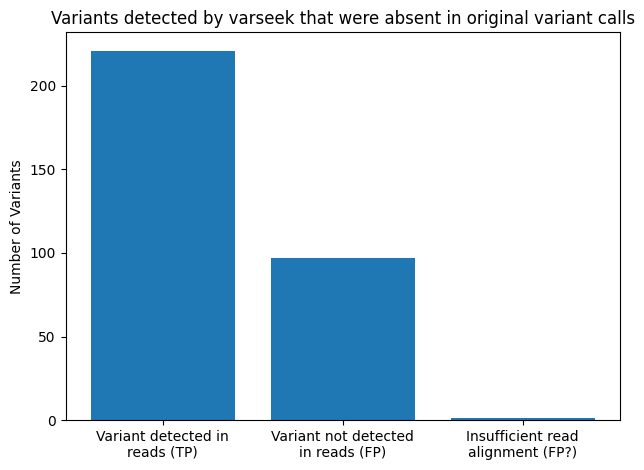

In [16]:
def plot_overall_bar_plot(overall_results, wrap_width = None, out_file=None, title = None):
    # Unpack keys and values
    labels = list(overall_results.keys())
    values = list(overall_results.values())

    if wrap_width:
        labels = ['\n'.join(textwrap.wrap(label, wrap_width)) for label in labels]

    # Create bar plot
    plt.bar(labels, values)
    plt.ylabel('Number of Variants')
    if title:
        plt.title(title)
    plt.tight_layout()
    if out_file:
        plt.savefig(out_file, dpi=300)
    plt.show()
    plt.close()

overall_results = {
    "Variant detected in reads (TP)": 221,
    "Variant not detected in reads (FP)": 97,
    "Insufficient read alignment (FP?)": 1,
}

plot_overall_bar_plot(overall_results, wrap_width=20, out_file=os.path.join(figures_out_dir, "fp_bar_plot.pdf"), title = 'Variants detected by varseek that were absent in original variant calls')

In [17]:
hgvs_df['true_variant'] = hgvs_df['header_cdna'].isin(set(true_variants))
hgvs_df.loc[hgvs_df['vcrs_id'].isna(), 'true_variant'] = pd.NA  # set the rows I didn't evaluate to NA

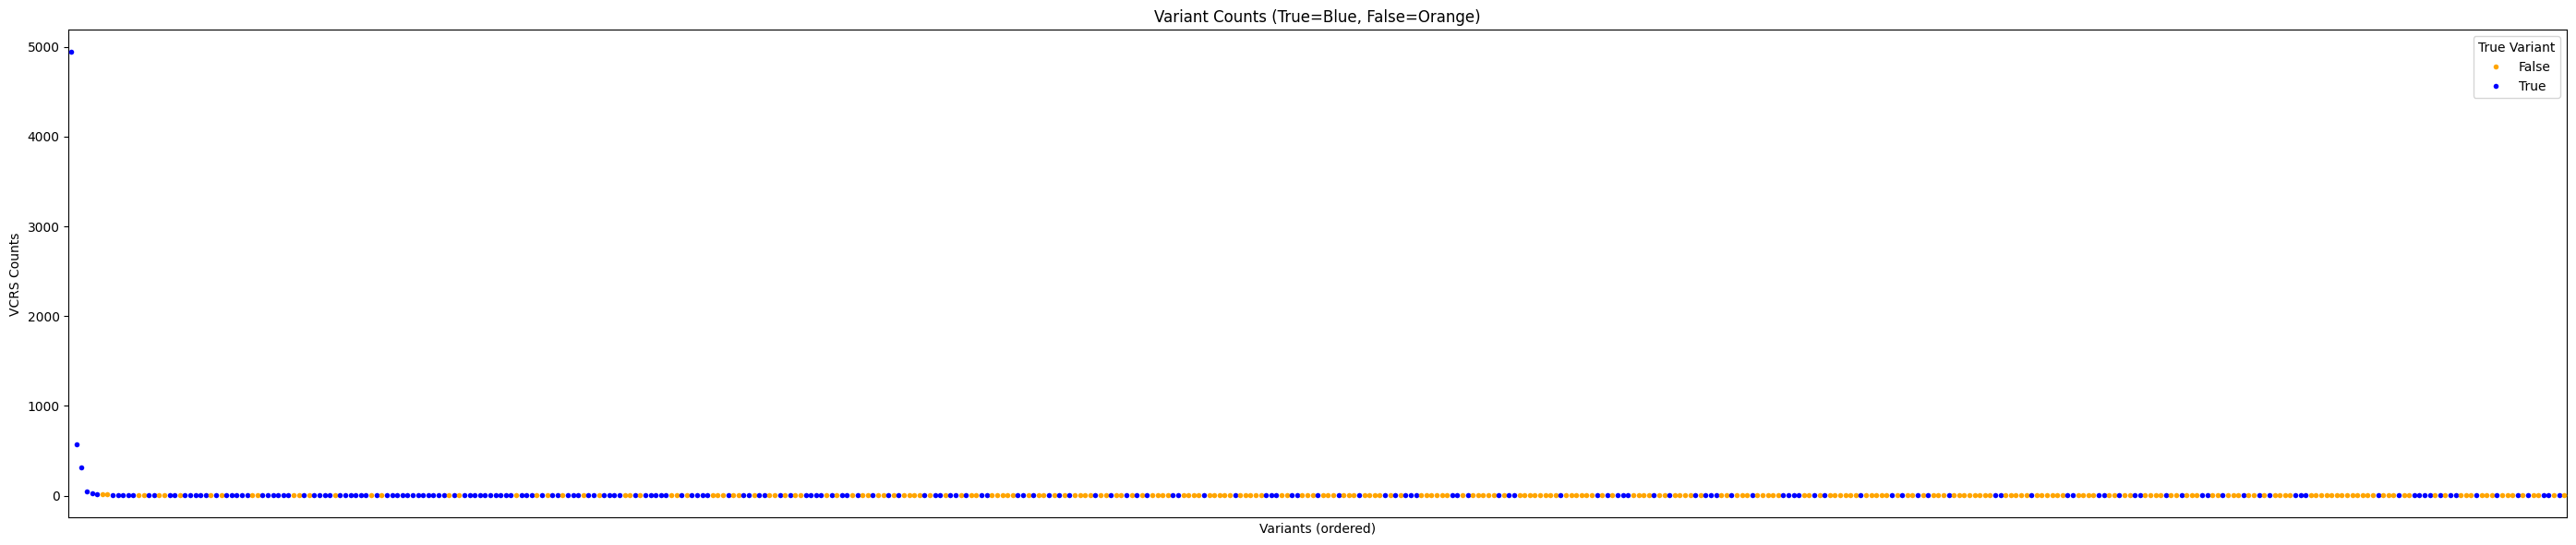

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [18]:
plt.figure(figsize=(28, 6))

# Sort by vcrs_count
# hgvs_df = hgvs_df.sort_values('vcrs_count', ascending=False)

sns.stripplot(
    data=hgvs_df,
    x='header_cdna',
    y='vcrs_count',
    hue='true_variant',
    dodge=False,
    palette={True: "blue", False: "orange"},
    size=4,
    jitter=0.4  # spread points slightly to reduce overlap
)

plt.xticks([], [])  # Hide x-axis ticks entirely
plt.xlabel('Variants (ordered)')
plt.ylabel('VCRS Counts')
plt.title('Variant Counts (True=Blue, False=Orange)')
plt.legend(title='True Variant', loc='upper right')
plt.tight_layout()

plt.savefig(os.path.join(figures_out_dir, "alleged_FPs_vcrs_count_sorted.pdf"), dpi=300)
plt.show()
plt.close

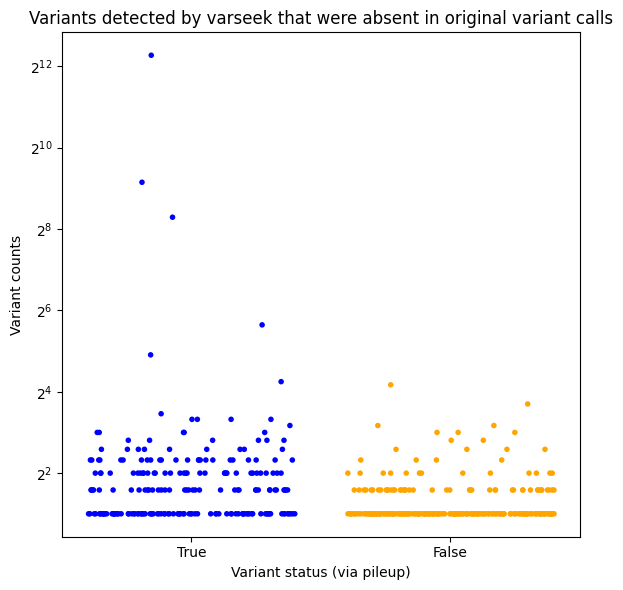

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 6))

# # Violin plot
# hgvs_df['true_variant_str'] = hgvs_df['true_variant'].astype(str)
# sns.violinplot(
#     data=hgvs_df,
#     x='true_variant_str',
#     y='vcrs_count',
#     palette={'True': "blue", 'False': "orange"},
#     width=0.5,
#     cut=0,  # Prevent tails from extending beyond data range
#     inner=None,  # Hide inner boxplot/sticks (optional)
#     scale='width'  # Makes area consistent
# )

# for violin in ax.collections:
#     violin.set_facecolor("lightgray")
#     violin.set_edgecolor("black")  # Optional: add black edge
#     violin.set_alpha(1)  # Optional: control transparency

# Strip plot on top
sns.stripplot(
    data=hgvs_df,
    x='true_variant',
    y='vcrs_count',
    hue='true_variant',
    order=[True, False],  # Enforce order
    hue_order=[True, False],  # Enforce order
    dodge=False,
    palette={True: "blue", False: "orange"},
    size=4,
    jitter=0.4
)

# Clean up
plt.xlabel('Variant status (via pileup)')
plt.ylabel('Variant counts')
plt.yscale("log", base=2)  # Apply log2 scaling
plt.title('Variants detected by varseek that were absent in original variant calls')
plt.legend([], [], frameon=False)  # Hide duplicate legend
plt.tight_layout()
plt.savefig(os.path.join(figures_out_dir, "alleged_FPs_vcrs_count_sorted_stacked.pdf"), dpi=300)
plt.show()
plt.close()

Get the set of especially tricky gene names and save them to a file:

In [20]:
extra_tricky_fp_threshold = 6

enst_list = []
with open(detailed_txt_out, "r") as f:
    lines = f.readlines()

for i in range(len(lines) - 1):  # stop at len-1 to access next line safely
    line = lines[i].strip()
    next_line = lines[i + 1].strip()

    if not line.startswith("vcrs"):
        continue

    try:
        # Extract the reported count value (assumes '... | ... | ... | ... | ... | xxx reported counts')
        count_str = line.split("|")[-1].strip()
        count_value = float(count_str.split()[0])
    except Exception:
        continue  # skip lines that don't match format

    if count_value < extra_tricky_fp_threshold:
        break

    if next_line == "True variant: False":
        enst_field = line.split("|")[2].strip()
        enst_id = enst_field.split(":")[0]
        enst_list.append(enst_id)

t2g_dict = vk.utils.make_t2g_dict(reference_genome_t2g)
t2g_dict = {key.split(".")[0]: val.split(".")[0] for key, val in t2g_dict.items()}  # strip off the version number
extra_tricky_fp_genes = [t2g_dict.get(enst, enst) for enst in enst_list]
extra_tricky_fp_genes = set(extra_tricky_fp_genes)  # remove duplicates
extra_tricky_fp_genes_txt_out = os.path.join(notebook_out_dir, "extra_tricky_fp_genes.txt")
with open(extra_tricky_fp_genes_txt_out, "w") as f:
    for gene in extra_tricky_fp_genes:
        f.write(f"{gene}\n")

print(f"Extra tricky FP genes: {extra_tricky_fp_genes}")

/home/jmrich/Desktop/varseek/varseek/utils/varseek_clean_utils.py:2277: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  t2g_df = pd.read_csv(t2g_file, sep="\t", header=None)


Extra tricky FP genes: {'ENSG00000177600', 'ENSG00000181163', 'ENSG00000145425', 'ENSG00000174444', 'ENSG00000108107', 'ENSG00000065978', 'ENSG00000137818', 'ENSG00000142541', 'ENST00000608106'}


### Load the files in bowtie_read_alignments into NCBI Genome workbench (or another genome viewer) to visualize the alignments (the ones with "final_")

In [21]:
# # vcrs0: ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
# !samtools mpileup -r 2:89246969-89246969 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_0/final_vcrs_0_sorted_reads.bam

In [22]:
# # vcrs1: ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
# !samtools mpileup -r 12:49522578-49522578 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_1/final_vcrs_1_sorted_reads.bam

In [23]:
# # vcrs3: ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.22759034G>A chrom22
# !samtools mpileup -r 22:23101523-23101523 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_3/final_vcrs_3_sorted_reads.bam

In [24]:
# # vcrs4: ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6
# !samtools mpileup -r 6:29912149-29912149 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_4/final_vcrs_4_sorted_reads.bam

## Now look at FNs - roughly the same

In [25]:
fn_txt_path = os.path.join(RLSRP_2025_dir, "data", f"geuvadis_analysis_supplement", experiment_alias, "fns.txt")
number_of_variants = None

detailed_txt_out_fn = os.path.join(notebook_out_dir, "detailed_out_fn_modified_bam.txt")
overall_txt_out_fn = os.path.join(notebook_out_dir, "overall_out_fn_modified_bam.txt")

In [26]:
with open(fn_txt_path) as f:
    fn_set = set(line.strip() for line in f)

In [27]:
hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df["is_false_negative"] = hgvs_df["header_cdna"].isin(fn_set)
hgvs_df = hgvs_df.loc[hgvs_df['is_false_negative']]
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [28]:
hgvs_df.head()

,dbsnp_id,transcript_ID,variant_cdna,strand,header_cdna,is_false_negative,vcrs_id
0,rs3829740,ENST00000379407,c.1385G>C,+,ENST00000379407:c.1385G>C,True,vcrs_0
1,rs74735644,ENST00000325425,c.1242C>T,+,ENST00000325425:c.1242C>T,True,vcrs_1
2,rs202243019,ENST00000339381,c.369A>G,+,ENST00000339381:c.369A>G,True,vcrs_2
3,rs9793256,ENST00000378785,c.1167G>A,+,ENST00000378785:c.1167G>A,True,vcrs_3
4,rs1781147,ENST00000378785,c.1409C>T,+,ENST00000378785:c.1409C>T,True,vcrs_4


In [29]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": email if email else "Mozilla/5.0 (compatible; PythonScript/1.0)"}

true_variants = []  # varseek FN where varseek was incorrect
false_variants = []  # varseek FN where varseek was correct
undetermined_variants = []  # insufficient reads mapped to this point
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out_fn, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    #* new stuff
    try:
        dbsnp_id = row['dbsnp_id']
        hgvsc = row['header_cdna']
        strand = row['strand']
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = row['transcript_ID']
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= min_counts  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
        false_variant = base_counts[ref_allele] >= min_counts and not true_variant
            
        if true_variant:  # >= min_counts alt alleles
            variant_status = "True"
            true_variants.append(variant_header)
        elif false_variant:  # >= min_counts ref alleles and <min_counts alt alleles
            variant_status = "False"
            false_variants.append(variant_header)
        else:  # <min_counts alt alleles and <min_counts ref alleles (ie insufficient read mapping)
            variant_status = "Undetermined"
            undetermined_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out_fn) else "w"
        with open(detailed_txt_out_fn, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} \n")
            f.write(f"True variant: {variant_status}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out_fn, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"Number of undetermined variants: {len(undetermined_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Undetermined variants list: {undetermined_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

12:50:05: Entering the loop


  0%|                                                                                                                            | 0/3024 [00:00<?, ?it/s]

  0%|                                                                                                                    | 1/3024 [00:01<52:58,  1.05s/it]

  0%|                                                                                                                    | 2/3024 [00:01<40:07,  1.26it/s]

  0%|                                                                                                                    | 3/3024 [00:02<35:28,  1.42it/s]

  0%|▏                                                                                                                   | 4/3024 [00:02<33:36,  1.50it/s]

  0%|▏                                                                                                                   | 5/3024 [00:03<32:33,  1.55it/s]

  0%|▏                                                                                                                   | 6/3024 [00:04<31:31,  1.60it/s]

  0%|▎                                                                                                                   | 7/3024 [00:04<31:23,  1.60it/s]

  0%|▎                                                                                                                   | 8/3024 [00:05<31:48,  1.58it/s]

  0%|▎                                                                                                                   | 9/3024 [00:05<31:17,  1.61it/s]

  0%|▍                                                                                                                  | 10/3024 [00:06<31:34,  1.59it/s]

  0%|▍                                                                                                                  | 11/3024 [00:07<32:10,  1.56it/s]

  0%|▍                                                                                                                  | 12/3024 [00:07<31:16,  1.61it/s]

  0%|▍                                                                                                                  | 13/3024 [00:08<31:47,  1.58it/s]

  0%|▌                                                                                                                  | 14/3024 [00:09<31:41,  1.58it/s]

  0%|▌                                                                                                                  | 15/3024 [00:09<32:01,  1.57it/s]

  1%|▌                                                                                                                  | 16/3024 [00:10<31:32,  1.59it/s]

  1%|▋                                                                                                                  | 17/3024 [00:11<31:48,  1.58it/s]

  1%|▋                                                                                                                  | 18/3024 [00:11<32:02,  1.56it/s]

  1%|▋                                                                                                                  | 19/3024 [00:12<30:57,  1.62it/s]

  1%|▊                                                                                                                  | 20/3024 [00:12<31:14,  1.60it/s]

  1%|▊                                                                                                                  | 21/3024 [00:13<30:24,  1.65it/s]

  1%|▊                                                                                                                  | 22/3024 [00:14<30:03,  1.66it/s]

  1%|▊                                                                                                                  | 23/3024 [00:14<29:49,  1.68it/s]

  1%|▉                                                                                                                  | 24/3024 [00:15<29:44,  1.68it/s]

  1%|▉                                                                                                                  | 25/3024 [00:15<29:53,  1.67it/s]

  1%|▉                                                                                                                  | 26/3024 [00:16<29:32,  1.69it/s]

  1%|█                                                                                                                  | 27/3024 [00:17<29:42,  1.68it/s]

  1%|█                                                                                                                  | 28/3024 [00:17<30:17,  1.65it/s]

  1%|█                                                                                                                  | 29/3024 [00:18<29:57,  1.67it/s]

  1%|█▏                                                                                                                 | 30/3024 [00:18<30:25,  1.64it/s]

  1%|█▏                                                                                                                 | 31/3024 [00:19<29:57,  1.67it/s]

  1%|█▏                                                                                                                 | 32/3024 [00:20<30:13,  1.65it/s]

  1%|█▎                                                                                                                 | 33/3024 [00:20<29:56,  1.66it/s]

  1%|█▎                                                                                                                 | 34/3024 [00:21<29:58,  1.66it/s]

  1%|█▎                                                                                                                 | 35/3024 [00:21<29:38,  1.68it/s]

  1%|█▎                                                                                                                 | 36/3024 [00:22<33:25,  1.49it/s]

  1%|█▍                                                                                                                 | 37/3024 [00:23<32:27,  1.53it/s]

  1%|█▍                                                                                                                 | 38/3024 [00:23<31:32,  1.58it/s]

  1%|█▍                                                                                                                 | 39/3024 [00:24<31:01,  1.60it/s]

  1%|█▌                                                                                                                 | 40/3024 [00:25<30:43,  1.62it/s]

  1%|█▌                                                                                                                 | 41/3024 [00:25<31:12,  1.59it/s]

  1%|█▌                                                                                                                 | 42/3024 [00:26<30:24,  1.63it/s]

  1%|█▋                                                                                                                 | 43/3024 [00:26<30:03,  1.65it/s]

  1%|█▋                                                                                                                 | 44/3024 [00:27<30:07,  1.65it/s]

  1%|█▋                                                                                                                 | 45/3024 [00:28<30:14,  1.64it/s]

  2%|█▋                                                                                                                 | 46/3024 [00:28<30:27,  1.63it/s]

  2%|█▊                                                                                                                 | 47/3024 [00:29<29:49,  1.66it/s]

  2%|█▊                                                                                                                 | 48/3024 [00:29<30:24,  1.63it/s]

  2%|█▊                                                                                                                 | 49/3024 [00:30<30:29,  1.63it/s]

  2%|█▉                                                                                                                 | 50/3024 [00:31<30:16,  1.64it/s]

  2%|█▉                                                                                                                 | 51/3024 [00:31<30:14,  1.64it/s]

  2%|█▉                                                                                                                 | 52/3024 [00:32<29:50,  1.66it/s]

  2%|██                                                                                                                 | 53/3024 [00:32<30:04,  1.65it/s]

  2%|██                                                                                                                 | 54/3024 [00:33<30:28,  1.62it/s]

  2%|██                                                                                                                 | 55/3024 [00:34<29:45,  1.66it/s]

  2%|██▏                                                                                                                | 56/3024 [00:34<29:54,  1.65it/s]

  2%|██▏                                                                                                                | 57/3024 [00:35<29:46,  1.66it/s]

  2%|██▏                                                                                                                | 58/3024 [00:36<29:47,  1.66it/s]

  2%|██▎                                                                                                                | 60/3024 [00:36<22:54,  2.16it/s]

  2%|██▎                                                                                                                | 61/3024 [00:37<24:19,  2.03it/s]

  2%|██▎                                                                                                                | 62/3024 [00:37<25:54,  1.90it/s]

  2%|██▍                                                                                                                | 63/3024 [00:38<26:33,  1.86it/s]

  2%|██▍                                                                                                                | 64/3024 [00:39<37:27,  1.32it/s]

  2%|██▌                                                                                                                | 66/3024 [00:40<27:46,  1.78it/s]

  2%|██▌                                                                                                                | 67/3024 [00:40<28:07,  1.75it/s]

  2%|██▌                                                                                                                | 68/3024 [00:41<28:11,  1.75it/s]

  2%|██▌                                                                                                                | 69/3024 [00:42<29:32,  1.67it/s]

  2%|██▋                                                                                                                | 70/3024 [00:42<29:23,  1.67it/s]

  2%|██▋                                                                                                                | 71/3024 [00:43<29:23,  1.67it/s]

  2%|██▋                                                                                                                | 72/3024 [00:43<29:38,  1.66it/s]

  2%|██▊                                                                                                                | 73/3024 [00:44<29:35,  1.66it/s]

  2%|██▊                                                                                                                | 74/3024 [00:45<29:50,  1.65it/s]

  2%|██▊                                                                                                                | 75/3024 [00:45<30:04,  1.63it/s]

  3%|██▉                                                                                                                | 76/3024 [00:46<29:44,  1.65it/s]

  3%|██▉                                                                                                                | 77/3024 [00:46<29:21,  1.67it/s]

  3%|██▉                                                                                                                | 78/3024 [00:47<29:28,  1.67it/s]

  3%|███                                                                                                                | 79/3024 [00:48<28:57,  1.69it/s]

  3%|███                                                                                                                | 80/3024 [00:48<28:58,  1.69it/s]

  3%|███                                                                                                                | 81/3024 [00:49<29:06,  1.69it/s]

  3%|███                                                                                                                | 82/3024 [00:49<28:54,  1.70it/s]

  3%|███▏                                                                                                               | 83/3024 [00:50<29:00,  1.69it/s]

  3%|███▏                                                                                                               | 84/3024 [00:51<29:30,  1.66it/s]

  3%|███▏                                                                                                               | 85/3024 [00:51<29:27,  1.66it/s]

  3%|███▎                                                                                                               | 86/3024 [00:52<29:05,  1.68it/s]

  3%|███▎                                                                                                               | 87/3024 [00:52<29:33,  1.66it/s]

  3%|███▎                                                                                                               | 88/3024 [00:53<29:12,  1.68it/s]

  3%|███▍                                                                                                               | 89/3024 [00:54<29:53,  1.64it/s]

  3%|███▍                                                                                                               | 90/3024 [00:54<29:58,  1.63it/s]

  3%|███▍                                                                                                               | 91/3024 [00:55<29:54,  1.63it/s]

  3%|███▌                                                                                                               | 93/3024 [00:56<22:53,  2.13it/s]

  3%|███▌                                                                                                               | 94/3024 [00:56<24:11,  2.02it/s]

  3%|███▌                                                                                                               | 95/3024 [00:57<26:14,  1.86it/s]

  3%|███▋                                                                                                               | 96/3024 [00:57<28:20,  1.72it/s]

  3%|███▋                                                                                                               | 97/3024 [00:58<28:57,  1.68it/s]

  3%|███▋                                                                                                               | 98/3024 [00:59<28:44,  1.70it/s]

  3%|███▊                                                                                                               | 99/3024 [00:59<29:02,  1.68it/s]

  3%|███▊                                                                                                              | 100/3024 [01:00<29:02,  1.68it/s]

  3%|███▊                                                                                                              | 101/3024 [01:00<29:30,  1.65it/s]

  3%|███▊                                                                                                              | 102/3024 [01:01<32:21,  1.51it/s]

  3%|███▉                                                                                                              | 103/3024 [01:02<30:59,  1.57it/s]

  3%|███▉                                                                                                              | 104/3024 [01:03<31:17,  1.56it/s]

  3%|███▉                                                                                                              | 105/3024 [01:03<30:03,  1.62it/s]

  4%|███▉                                                                                                              | 106/3024 [01:04<30:40,  1.59it/s]

  4%|████                                                                                                              | 107/3024 [01:04<30:50,  1.58it/s]

  4%|████                                                                                                              | 108/3024 [01:05<29:59,  1.62it/s]

  4%|████                                                                                                              | 109/3024 [01:06<29:12,  1.66it/s]

  4%|████▏                                                                                                             | 110/3024 [01:06<29:02,  1.67it/s]

  4%|████▏                                                                                                             | 111/3024 [01:07<31:12,  1.56it/s]

  4%|████▏                                                                                                             | 112/3024 [01:07<30:13,  1.61it/s]

  4%|████▎                                                                                                             | 113/3024 [01:08<30:00,  1.62it/s]

  4%|████▎                                                                                                             | 114/3024 [01:09<29:22,  1.65it/s]

  4%|████▎                                                                                                             | 115/3024 [01:09<29:58,  1.62it/s]

  4%|████▍                                                                                                             | 117/3024 [01:10<23:39,  2.05it/s]

  4%|████▍                                                                                                             | 118/3024 [01:11<25:15,  1.92it/s]

  4%|████▍                                                                                                             | 119/3024 [01:11<26:25,  1.83it/s]

  4%|████▌                                                                                                             | 120/3024 [01:12<27:50,  1.74it/s]

  4%|████▌                                                                                                             | 121/3024 [01:13<30:36,  1.58it/s]

  4%|████▌                                                                                                             | 122/3024 [01:14<40:56,  1.18it/s]

  4%|████▋                                                                                                             | 123/3024 [01:15<46:48,  1.03it/s]

  4%|████▋                                                                                                             | 124/3024 [01:17<52:17,  1.08s/it]

  4%|████▋                                                                                                             | 125/3024 [01:18<55:41,  1.15s/it]

  4%|████▋                                                                                                           | 126/3024 [01:20<1:08:46,  1.42s/it]

  4%|████▋                                                                                                           | 127/3024 [01:21<1:07:20,  1.39s/it]

  4%|████▋                                                                                                           | 128/3024 [01:23<1:09:22,  1.44s/it]

  4%|████▊                                                                                                           | 129/3024 [01:24<1:07:02,  1.39s/it]

  4%|████▊                                                                                                           | 130/3024 [01:26<1:06:38,  1.38s/it]

  4%|████▉                                                                                                             | 132/3024 [01:26<42:54,  1.12it/s]

  4%|█████                                                                                                             | 133/3024 [01:27<42:14,  1.14it/s]

  4%|█████                                                                                                             | 134/3024 [01:28<42:07,  1.14it/s]

  4%|█████                                                                                                             | 135/3024 [01:28<38:30,  1.25it/s]

  4%|█████▏                                                                                                            | 136/3024 [01:29<35:50,  1.34it/s]

  5%|█████▏                                                                                                            | 137/3024 [01:30<33:24,  1.44it/s]

  5%|█████▏                                                                                                            | 138/3024 [01:30<31:57,  1.51it/s]

  5%|█████▏                                                                                                            | 139/3024 [01:31<30:35,  1.57it/s]

  5%|█████▎                                                                                                            | 140/3024 [01:31<29:48,  1.61it/s]

  5%|█████▎                                                                                                            | 141/3024 [01:32<30:46,  1.56it/s]

  5%|█████▎                                                                                                            | 142/3024 [01:33<29:41,  1.62it/s]

  5%|█████▍                                                                                                            | 143/3024 [01:33<28:58,  1.66it/s]

  5%|█████▍                                                                                                            | 144/3024 [01:34<29:29,  1.63it/s]

  5%|█████▍                                                                                                            | 145/3024 [01:34<29:12,  1.64it/s]

  5%|█████▌                                                                                                            | 146/3024 [01:35<28:49,  1.66it/s]

  5%|█████▌                                                                                                            | 147/3024 [01:36<29:09,  1.64it/s]

  5%|█████▌                                                                                                            | 148/3024 [01:36<28:58,  1.65it/s]

  5%|█████▌                                                                                                            | 149/3024 [01:37<29:10,  1.64it/s]

  5%|█████▋                                                                                                            | 150/3024 [01:37<28:47,  1.66it/s]

  5%|█████▋                                                                                                            | 151/3024 [01:38<28:17,  1.69it/s]

  5%|█████▋                                                                                                            | 152/3024 [01:39<28:01,  1.71it/s]

  5%|█████▊                                                                                                            | 153/3024 [01:39<28:22,  1.69it/s]

  5%|█████▊                                                                                                            | 154/3024 [01:40<28:34,  1.67it/s]

  5%|█████▊                                                                                                            | 155/3024 [01:40<28:21,  1.69it/s]

  5%|█████▉                                                                                                            | 156/3024 [01:41<28:07,  1.70it/s]

  5%|█████▉                                                                                                            | 158/3024 [01:42<21:24,  2.23it/s]

  5%|█████▉                                                                                                            | 159/3024 [01:42<23:37,  2.02it/s]

  5%|██████                                                                                                            | 160/3024 [01:43<24:44,  1.93it/s]

  5%|██████                                                                                                            | 161/3024 [01:43<25:22,  1.88it/s]

  5%|██████                                                                                                            | 162/3024 [01:44<25:50,  1.85it/s]

  5%|██████▏                                                                                                           | 163/3024 [01:44<26:08,  1.82it/s]

  5%|██████▏                                                                                                           | 164/3024 [01:45<26:27,  1.80it/s]

  5%|██████▏                                                                                                           | 165/3024 [01:46<26:52,  1.77it/s]

  5%|██████▎                                                                                                           | 166/3024 [01:46<26:56,  1.77it/s]

  6%|██████▎                                                                                                           | 167/3024 [01:47<27:38,  1.72it/s]

  6%|██████▎                                                                                                           | 168/3024 [01:47<28:28,  1.67it/s]

  6%|██████▎                                                                                                           | 169/3024 [01:48<28:18,  1.68it/s]

  6%|██████▍                                                                                                           | 170/3024 [01:49<28:19,  1.68it/s]

  6%|██████▍                                                                                                           | 171/3024 [01:49<30:38,  1.55it/s]

  6%|██████▍                                                                                                           | 172/3024 [01:50<35:39,  1.33it/s]

  6%|██████▌                                                                                                           | 173/3024 [01:51<32:59,  1.44it/s]

  6%|██████▌                                                                                                           | 175/3024 [01:52<24:31,  1.94it/s]

  6%|██████▋                                                                                                           | 176/3024 [01:52<25:34,  1.86it/s]

  6%|██████▋                                                                                                           | 177/3024 [01:53<26:07,  1.82it/s]

  6%|██████▋                                                                                                           | 178/3024 [01:53<26:44,  1.77it/s]

  6%|██████▋                                                                                                           | 179/3024 [01:54<27:20,  1.73it/s]

  6%|██████▊                                                                                                           | 180/3024 [01:55<27:57,  1.70it/s]

  6%|██████▊                                                                                                           | 181/3024 [01:55<28:06,  1.69it/s]

  6%|██████▊                                                                                                           | 182/3024 [01:56<27:52,  1.70it/s]

  6%|██████▉                                                                                                           | 183/3024 [01:56<28:18,  1.67it/s]

  6%|██████▉                                                                                                           | 185/3024 [01:57<21:26,  2.21it/s]

  6%|███████                                                                                                           | 186/3024 [01:58<22:57,  2.06it/s]

  6%|███████                                                                                                           | 187/3024 [01:58<24:13,  1.95it/s]

  6%|███████                                                                                                           | 188/3024 [01:59<25:23,  1.86it/s]

  6%|███████▏                                                                                                          | 189/3024 [01:59<26:16,  1.80it/s]

  6%|███████▏                                                                                                          | 190/3024 [02:00<26:42,  1.77it/s]

  6%|███████▏                                                                                                          | 191/3024 [02:00<26:51,  1.76it/s]

  6%|███████▏                                                                                                          | 192/3024 [02:01<28:12,  1.67it/s]

  6%|███████▎                                                                                                          | 193/3024 [02:02<29:01,  1.63it/s]

  6%|███████▎                                                                                                          | 194/3024 [02:02<28:19,  1.67it/s]

  6%|███████▎                                                                                                          | 195/3024 [02:03<27:55,  1.69it/s]

  6%|███████▍                                                                                                          | 196/3024 [02:04<27:55,  1.69it/s]

  7%|███████▍                                                                                                          | 197/3024 [02:04<27:43,  1.70it/s]

  7%|███████▍                                                                                                          | 198/3024 [02:05<27:55,  1.69it/s]

  7%|███████▌                                                                                                          | 199/3024 [02:05<28:24,  1.66it/s]

  7%|███████▌                                                                                                          | 200/3024 [02:06<29:02,  1.62it/s]

  7%|███████▌                                                                                                          | 201/3024 [02:07<29:06,  1.62it/s]

  7%|███████▌                                                                                                          | 202/3024 [02:07<28:48,  1.63it/s]

  7%|███████▋                                                                                                          | 203/3024 [02:08<28:32,  1.65it/s]

  7%|███████▋                                                                                                          | 204/3024 [02:08<28:19,  1.66it/s]

  7%|███████▋                                                                                                          | 205/3024 [02:09<28:44,  1.63it/s]

  7%|███████▊                                                                                                          | 206/3024 [02:10<29:34,  1.59it/s]

  7%|███████▊                                                                                                          | 207/3024 [02:10<28:45,  1.63it/s]

  7%|███████▊                                                                                                          | 208/3024 [02:11<28:28,  1.65it/s]

  7%|███████▉                                                                                                          | 209/3024 [02:11<28:07,  1.67it/s]

  7%|███████▉                                                                                                          | 210/3024 [02:12<29:36,  1.58it/s]

  7%|███████▉                                                                                                          | 211/3024 [02:13<29:03,  1.61it/s]

  7%|███████▉                                                                                                          | 212/3024 [02:13<29:06,  1.61it/s]

  7%|████████                                                                                                          | 213/3024 [02:14<28:44,  1.63it/s]

  7%|████████                                                                                                          | 214/3024 [02:15<28:32,  1.64it/s]

  7%|████████                                                                                                          | 215/3024 [02:15<28:34,  1.64it/s]

  7%|████████▏                                                                                                         | 216/3024 [02:16<28:24,  1.65it/s]

  7%|████████▏                                                                                                         | 217/3024 [02:16<27:55,  1.67it/s]

  7%|████████▏                                                                                                         | 218/3024 [02:17<27:47,  1.68it/s]

  7%|████████▎                                                                                                         | 219/3024 [02:18<27:55,  1.67it/s]

  7%|████████▎                                                                                                         | 220/3024 [02:18<28:11,  1.66it/s]

  7%|████████▎                                                                                                         | 221/3024 [02:19<27:57,  1.67it/s]

  7%|████████▎                                                                                                         | 222/3024 [02:19<27:45,  1.68it/s]

  7%|████████▍                                                                                                         | 223/3024 [02:20<27:58,  1.67it/s]

  7%|████████▍                                                                                                         | 224/3024 [02:21<28:12,  1.65it/s]

  7%|████████▍                                                                                                         | 225/3024 [02:21<28:51,  1.62it/s]

  7%|████████▌                                                                                                         | 226/3024 [02:22<28:15,  1.65it/s]

  8%|████████▌                                                                                                         | 227/3024 [02:22<27:44,  1.68it/s]

  8%|████████▌                                                                                                         | 228/3024 [02:23<28:53,  1.61it/s]

  8%|████████▋                                                                                                         | 229/3024 [02:24<28:03,  1.66it/s]

  8%|████████▋                                                                                                         | 230/3024 [02:24<27:50,  1.67it/s]

  8%|████████▋                                                                                                         | 231/3024 [02:25<27:41,  1.68it/s]

  8%|████████▋                                                                                                         | 232/3024 [02:26<38:40,  1.20it/s]

  8%|████████▊                                                                                                         | 233/3024 [02:27<35:59,  1.29it/s]

  8%|████████▊                                                                                                         | 234/3024 [02:27<34:08,  1.36it/s]

  8%|████████▊                                                                                                         | 235/3024 [02:28<33:32,  1.39it/s]

  8%|████████▉                                                                                                         | 236/3024 [02:29<31:20,  1.48it/s]

  8%|████████▉                                                                                                         | 237/3024 [02:29<30:16,  1.53it/s]

  8%|████████▉                                                                                                         | 238/3024 [02:30<30:09,  1.54it/s]

  8%|█████████                                                                                                         | 239/3024 [02:31<29:45,  1.56it/s]

  8%|█████████                                                                                                         | 240/3024 [02:31<28:44,  1.61it/s]

  8%|█████████                                                                                                         | 241/3024 [02:32<28:27,  1.63it/s]

  8%|█████████                                                                                                         | 242/3024 [02:32<28:00,  1.66it/s]

  8%|█████████▏                                                                                                        | 244/3024 [02:33<21:59,  2.11it/s]

  8%|█████████▏                                                                                                        | 245/3024 [02:34<23:27,  1.97it/s]

  8%|█████████▎                                                                                                        | 246/3024 [02:34<24:32,  1.89it/s]

  8%|█████████▎                                                                                                        | 247/3024 [02:35<25:13,  1.83it/s]

  8%|█████████▎                                                                                                        | 248/3024 [02:35<25:35,  1.81it/s]

  8%|█████████▍                                                                                                        | 249/3024 [02:36<26:31,  1.74it/s]

  8%|█████████▍                                                                                                        | 250/3024 [02:37<26:37,  1.74it/s]

  8%|█████████▍                                                                                                        | 251/3024 [02:37<27:50,  1.66it/s]

  8%|█████████▌                                                                                                        | 252/3024 [02:38<28:31,  1.62it/s]

  8%|█████████▌                                                                                                        | 253/3024 [02:38<27:51,  1.66it/s]

  8%|█████████▌                                                                                                        | 254/3024 [02:39<27:36,  1.67it/s]

  8%|█████████▌                                                                                                        | 255/3024 [02:40<27:43,  1.67it/s]

  8%|█████████▋                                                                                                        | 257/3024 [02:40<21:56,  2.10it/s]

  9%|█████████▋                                                                                                        | 258/3024 [02:41<23:17,  1.98it/s]

  9%|█████████▊                                                                                                        | 259/3024 [02:41<24:26,  1.89it/s]

  9%|█████████▊                                                                                                        | 260/3024 [02:42<25:11,  1.83it/s]

  9%|█████████▊                                                                                                        | 261/3024 [02:43<25:25,  1.81it/s]

  9%|█████████▉                                                                                                        | 262/3024 [02:43<26:01,  1.77it/s]

  9%|█████████▉                                                                                                        | 263/3024 [02:44<26:10,  1.76it/s]

  9%|█████████▉                                                                                                        | 264/3024 [02:44<26:42,  1.72it/s]

  9%|█████████▉                                                                                                        | 265/3024 [02:45<26:52,  1.71it/s]

  9%|██████████                                                                                                        | 266/3024 [02:46<26:45,  1.72it/s]

  9%|██████████                                                                                                        | 267/3024 [02:46<27:11,  1.69it/s]

  9%|██████████                                                                                                        | 268/3024 [02:47<27:09,  1.69it/s]

  9%|██████████▏                                                                                                       | 269/3024 [02:47<27:06,  1.69it/s]

  9%|██████████▏                                                                                                       | 270/3024 [02:48<26:57,  1.70it/s]

  9%|██████████▏                                                                                                       | 271/3024 [02:49<27:26,  1.67it/s]

  9%|██████████▎                                                                                                       | 272/3024 [02:49<27:18,  1.68it/s]

  9%|██████████▎                                                                                                       | 273/3024 [02:50<29:54,  1.53it/s]

  9%|██████████▎                                                                                                       | 274/3024 [02:51<29:52,  1.53it/s]

  9%|██████████▎                                                                                                       | 275/3024 [02:51<28:33,  1.60it/s]

  9%|██████████▍                                                                                                       | 276/3024 [02:52<27:45,  1.65it/s]

  9%|██████████▍                                                                                                       | 278/3024 [02:52<21:02,  2.17it/s]

  9%|██████████▌                                                                                                       | 280/3024 [02:53<19:38,  2.33it/s]

  9%|██████████▌                                                                                                       | 281/3024 [02:54<22:57,  1.99it/s]

  9%|██████████▋                                                                                                       | 282/3024 [02:54<23:59,  1.90it/s]

  9%|██████████▋                                                                                                       | 283/3024 [02:55<24:31,  1.86it/s]

  9%|██████████▋                                                                                                       | 284/3024 [02:56<25:16,  1.81it/s]

  9%|██████████▋                                                                                                       | 285/3024 [02:56<25:41,  1.78it/s]

  9%|██████████▊                                                                                                       | 286/3024 [02:57<26:43,  1.71it/s]

  9%|██████████▊                                                                                                       | 287/3024 [02:58<28:09,  1.62it/s]

 10%|██████████▉                                                                                                       | 290/3024 [02:58<17:24,  2.62it/s]

 10%|██████████▉                                                                                                       | 291/3024 [02:59<19:06,  2.38it/s]

 10%|███████████                                                                                                       | 292/3024 [02:59<21:43,  2.10it/s]

 10%|███████████                                                                                                       | 293/3024 [03:00<22:36,  2.01it/s]

 10%|███████████                                                                                                       | 294/3024 [03:00<23:33,  1.93it/s]

 10%|███████████                                                                                                       | 295/3024 [03:01<24:05,  1.89it/s]

 10%|███████████▏                                                                                                      | 296/3024 [03:02<24:44,  1.84it/s]

 10%|███████████▏                                                                                                      | 297/3024 [03:02<25:46,  1.76it/s]

 10%|███████████▏                                                                                                      | 298/3024 [03:03<26:50,  1.69it/s]

 10%|███████████▎                                                                                                      | 299/3024 [03:04<27:47,  1.63it/s]

 10%|███████████▎                                                                                                      | 301/3024 [03:04<20:54,  2.17it/s]

 10%|███████████▍                                                                                                      | 302/3024 [03:05<22:30,  2.02it/s]

 10%|███████████▍                                                                                                      | 303/3024 [03:06<26:42,  1.70it/s]

 10%|███████████▍                                                                                                      | 304/3024 [03:06<26:26,  1.71it/s]

 10%|███████████▍                                                                                                      | 305/3024 [03:07<28:02,  1.62it/s]

 10%|███████████▌                                                                                                      | 306/3024 [03:07<27:18,  1.66it/s]

 10%|███████████▌                                                                                                      | 307/3024 [03:08<26:47,  1.69it/s]

 10%|███████████▌                                                                                                      | 308/3024 [03:09<26:28,  1.71it/s]

 10%|███████████▋                                                                                                      | 309/3024 [03:09<26:09,  1.73it/s]

 10%|███████████▋                                                                                                      | 310/3024 [03:10<28:43,  1.58it/s]

 10%|███████████▋                                                                                                      | 311/3024 [03:10<27:45,  1.63it/s]

 10%|███████████▊                                                                                                      | 312/3024 [03:11<27:07,  1.67it/s]

 10%|███████████▊                                                                                                      | 313/3024 [03:12<26:35,  1.70it/s]

 10%|███████████▊                                                                                                      | 314/3024 [03:12<26:11,  1.72it/s]

 10%|███████████▉                                                                                                      | 315/3024 [03:13<25:55,  1.74it/s]

 10%|███████████▉                                                                                                      | 316/3024 [03:13<26:26,  1.71it/s]

 10%|███████████▉                                                                                                      | 317/3024 [03:14<26:06,  1.73it/s]

 11%|███████████▉                                                                                                      | 318/3024 [03:14<26:23,  1.71it/s]

 11%|████████████                                                                                                      | 319/3024 [03:15<27:00,  1.67it/s]

 11%|████████████                                                                                                      | 320/3024 [03:16<26:59,  1.67it/s]

 11%|████████████                                                                                                      | 321/3024 [03:16<26:51,  1.68it/s]

 11%|████████████▏                                                                                                     | 322/3024 [03:17<26:33,  1.70it/s]

 11%|████████████▏                                                                                                     | 323/3024 [03:17<26:39,  1.69it/s]

 11%|████████████▏                                                                                                     | 324/3024 [03:18<27:36,  1.63it/s]

 11%|████████████▎                                                                                                     | 325/3024 [03:19<27:57,  1.61it/s]

 11%|████████████▎                                                                                                     | 326/3024 [03:19<27:16,  1.65it/s]

 11%|████████████▎                                                                                                     | 327/3024 [03:20<27:00,  1.66it/s]

 11%|████████████▎                                                                                                     | 328/3024 [03:20<26:52,  1.67it/s]

 11%|████████████▍                                                                                                     | 329/3024 [03:21<27:34,  1.63it/s]

 11%|████████████▍                                                                                                     | 330/3024 [03:22<36:50,  1.22it/s]

 11%|████████████▍                                                                                                     | 331/3024 [03:24<44:37,  1.01it/s]

 11%|████████████▌                                                                                                     | 332/3024 [03:25<47:43,  1.06s/it]

 11%|████████████▌                                                                                                     | 333/3024 [03:26<50:33,  1.13s/it]

 11%|████████████▌                                                                                                     | 334/3024 [03:28<51:03,  1.14s/it]

 11%|████████████▋                                                                                                     | 335/3024 [03:29<53:36,  1.20s/it]

 11%|████████████▋                                                                                                     | 336/3024 [03:30<54:24,  1.21s/it]

 11%|████████████▋                                                                                                     | 337/3024 [03:31<45:39,  1.02s/it]

 11%|████████████▋                                                                                                     | 338/3024 [03:31<39:39,  1.13it/s]

 11%|████████████▊                                                                                                     | 339/3024 [03:32<35:49,  1.25it/s]

 11%|████████████▊                                                                                                     | 340/3024 [03:32<33:08,  1.35it/s]

 11%|████████████▊                                                                                                     | 341/3024 [03:33<31:34,  1.42it/s]

 11%|████████████▉                                                                                                     | 343/3024 [03:34<22:58,  1.95it/s]

 11%|████████████▉                                                                                                     | 344/3024 [03:34<24:02,  1.86it/s]

 11%|█████████████                                                                                                     | 345/3024 [03:35<25:07,  1.78it/s]

 11%|█████████████                                                                                                     | 346/3024 [03:35<25:25,  1.76it/s]

 11%|█████████████                                                                                                     | 347/3024 [03:36<26:03,  1.71it/s]

 12%|█████████████                                                                                                     | 348/3024 [03:37<26:35,  1.68it/s]

 12%|█████████████▏                                                                                                    | 349/3024 [03:37<26:35,  1.68it/s]

 12%|█████████████▏                                                                                                    | 350/3024 [03:38<26:46,  1.66it/s]

 12%|█████████████▏                                                                                                    | 351/3024 [03:39<29:49,  1.49it/s]

 12%|█████████████▎                                                                                                    | 352/3024 [03:39<28:28,  1.56it/s]

 12%|█████████████▎                                                                                                    | 353/3024 [03:40<27:40,  1.61it/s]

 12%|█████████████▎                                                                                                    | 354/3024 [03:40<27:04,  1.64it/s]

 12%|█████████████▍                                                                                                    | 355/3024 [03:41<27:15,  1.63it/s]

 12%|█████████████▍                                                                                                    | 356/3024 [03:42<27:08,  1.64it/s]

 12%|█████████████▍                                                                                                    | 357/3024 [03:42<28:24,  1.56it/s]

 12%|█████████████▍                                                                                                    | 358/3024 [03:43<28:37,  1.55it/s]

 12%|█████████████▌                                                                                                    | 359/3024 [03:44<31:34,  1.41it/s]

 12%|█████████████▌                                                                                                    | 360/3024 [03:45<29:49,  1.49it/s]

 12%|█████████████▌                                                                                                    | 361/3024 [03:45<28:37,  1.55it/s]

 12%|█████████████▋                                                                                                    | 362/3024 [03:46<27:39,  1.60it/s]

 12%|█████████████▋                                                                                                    | 363/3024 [03:46<27:41,  1.60it/s]

 12%|█████████████▋                                                                                                    | 364/3024 [03:47<27:45,  1.60it/s]

 12%|█████████████▊                                                                                                    | 365/3024 [03:48<27:09,  1.63it/s]

 12%|█████████████▊                                                                                                    | 366/3024 [03:48<26:47,  1.65it/s]

 12%|█████████████▊                                                                                                    | 367/3024 [03:49<27:26,  1.61it/s]

 12%|█████████████▊                                                                                                    | 368/3024 [03:49<27:39,  1.60it/s]

 12%|█████████████▉                                                                                                    | 369/3024 [03:50<27:02,  1.64it/s]

 12%|█████████████▉                                                                                                    | 370/3024 [03:51<26:31,  1.67it/s]

 12%|██████████████                                                                                                    | 372/3024 [03:52<30:01,  1.47it/s]

 12%|██████████████                                                                                                    | 373/3024 [03:53<37:23,  1.18it/s]

 12%|██████████████                                                                                                    | 374/3024 [03:54<35:12,  1.25it/s]

 12%|██████████████▏                                                                                                   | 375/3024 [03:55<32:40,  1.35it/s]

 12%|██████████████▏                                                                                                   | 376/3024 [03:55<30:37,  1.44it/s]

 12%|██████████████▏                                                                                                   | 377/3024 [03:56<29:45,  1.48it/s]

 12%|██████████████▎                                                                                                   | 378/3024 [03:57<28:50,  1.53it/s]

 13%|██████████████▎                                                                                                   | 379/3024 [03:57<27:48,  1.59it/s]

 13%|██████████████▎                                                                                                   | 380/3024 [03:58<27:05,  1.63it/s]

 13%|██████████████▎                                                                                                   | 381/3024 [03:58<26:29,  1.66it/s]

 13%|██████████████▍                                                                                                   | 382/3024 [03:59<26:42,  1.65it/s]

 13%|██████████████▍                                                                                                   | 383/3024 [03:59<26:26,  1.66it/s]

 13%|██████████████▍                                                                                                   | 384/3024 [04:00<26:25,  1.66it/s]

 13%|██████████████▌                                                                                                   | 385/3024 [04:01<26:29,  1.66it/s]

 13%|██████████████▌                                                                                                   | 386/3024 [04:01<26:12,  1.68it/s]

 13%|██████████████▌                                                                                                   | 387/3024 [04:02<26:29,  1.66it/s]

 13%|██████████████▎                                                                                                 | 388/3024 [04:05<1:04:38,  1.47s/it]

 13%|██████████████▋                                                                                                   | 389/3024 [04:06<54:34,  1.24s/it]

 13%|██████████████▋                                                                                                   | 390/3024 [04:07<45:42,  1.04s/it]

 13%|██████████████▋                                                                                                   | 391/3024 [04:07<39:47,  1.10it/s]

 13%|██████████████▊                                                                                                   | 392/3024 [04:08<35:21,  1.24it/s]

 13%|██████████████▊                                                                                                   | 393/3024 [04:08<32:10,  1.36it/s]

 13%|██████████████▊                                                                                                   | 394/3024 [04:09<30:20,  1.44it/s]

 13%|██████████████▉                                                                                                   | 395/3024 [04:10<28:38,  1.53it/s]

 13%|██████████████▉                                                                                                   | 396/3024 [04:10<27:51,  1.57it/s]

 13%|██████████████▉                                                                                                   | 397/3024 [04:11<26:54,  1.63it/s]

 13%|███████████████                                                                                                   | 398/3024 [04:11<26:38,  1.64it/s]

 13%|███████████████                                                                                                   | 399/3024 [04:12<26:07,  1.67it/s]

 13%|███████████████                                                                                                   | 400/3024 [04:12<25:46,  1.70it/s]

 13%|███████████████                                                                                                   | 401/3024 [04:13<25:27,  1.72it/s]

 13%|███████████████▏                                                                                                  | 402/3024 [04:14<25:08,  1.74it/s]

 13%|███████████████▏                                                                                                  | 403/3024 [04:14<24:58,  1.75it/s]

 13%|███████████████▏                                                                                                  | 404/3024 [04:15<24:51,  1.76it/s]

 13%|███████████████▎                                                                                                  | 405/3024 [04:15<24:48,  1.76it/s]

 13%|███████████████▎                                                                                                  | 406/3024 [04:16<26:55,  1.62it/s]

 13%|███████████████▎                                                                                                  | 407/3024 [04:17<26:14,  1.66it/s]

 14%|███████████████▍                                                                                                  | 409/3024 [04:17<20:06,  2.17it/s]

 14%|███████████████▍                                                                                                  | 410/3024 [04:18<21:20,  2.04it/s]

 14%|███████████████▍                                                                                                  | 411/3024 [04:18<22:18,  1.95it/s]

 14%|███████████████▌                                                                                                  | 412/3024 [04:19<22:51,  1.90it/s]

 14%|███████████████▌                                                                                                  | 413/3024 [04:19<23:18,  1.87it/s]

 14%|███████████████▌                                                                                                  | 414/3024 [04:20<23:44,  1.83it/s]

 14%|███████████████▋                                                                                                  | 415/3024 [04:21<23:55,  1.82it/s]

 14%|███████████████▋                                                                                                  | 416/3024 [04:21<24:33,  1.77it/s]

 14%|███████████████▋                                                                                                  | 417/3024 [04:22<24:41,  1.76it/s]

 14%|███████████████▊                                                                                                  | 419/3024 [04:22<19:01,  2.28it/s]

 14%|███████████████▊                                                                                                  | 420/3024 [04:23<21:16,  2.04it/s]

 14%|███████████████▊                                                                                                  | 421/3024 [04:23<22:14,  1.95it/s]

 14%|███████████████▉                                                                                                  | 422/3024 [04:24<22:49,  1.90it/s]

 14%|███████████████▉                                                                                                  | 423/3024 [04:25<24:22,  1.78it/s]

 14%|███████████████▉                                                                                                  | 424/3024 [04:25<24:37,  1.76it/s]

 14%|████████████████                                                                                                  | 425/3024 [04:26<24:35,  1.76it/s]

 14%|████████████████                                                                                                  | 426/3024 [04:26<25:07,  1.72it/s]

 14%|████████████████                                                                                                  | 427/3024 [04:27<25:30,  1.70it/s]

 14%|████████████████▏                                                                                                 | 428/3024 [04:28<25:38,  1.69it/s]

 14%|████████████████▏                                                                                                 | 429/3024 [04:28<25:29,  1.70it/s]

 14%|████████████████▏                                                                                                 | 430/3024 [04:29<25:32,  1.69it/s]

 14%|████████████████▏                                                                                                 | 431/3024 [04:29<25:35,  1.69it/s]

 14%|████████████████▎                                                                                                 | 432/3024 [04:30<25:26,  1.70it/s]

 14%|████████████████▎                                                                                                 | 433/3024 [04:31<27:40,  1.56it/s]

 14%|████████████████▎                                                                                                 | 434/3024 [04:31<26:39,  1.62it/s]

 14%|████████████████▍                                                                                                 | 435/3024 [04:32<26:07,  1.65it/s]

 14%|████████████████▍                                                                                                 | 436/3024 [04:33<26:16,  1.64it/s]

 14%|████████████████▍                                                                                                 | 437/3024 [04:33<26:12,  1.64it/s]

 14%|████████████████▌                                                                                                 | 438/3024 [04:34<25:45,  1.67it/s]

 15%|████████████████▌                                                                                                 | 439/3024 [04:34<25:33,  1.69it/s]

 15%|████████████████▌                                                                                                 | 440/3024 [04:35<25:12,  1.71it/s]

 15%|████████████████▋                                                                                                 | 441/3024 [04:35<25:18,  1.70it/s]

 15%|████████████████▋                                                                                                 | 442/3024 [04:36<25:14,  1.70it/s]

 15%|████████████████▋                                                                                                 | 443/3024 [04:37<26:04,  1.65it/s]

 15%|████████████████▋                                                                                                 | 444/3024 [04:37<25:40,  1.67it/s]

 15%|████████████████▊                                                                                                 | 445/3024 [04:38<25:24,  1.69it/s]

 15%|████████████████▊                                                                                                 | 446/3024 [04:38<25:05,  1.71it/s]

 15%|████████████████▊                                                                                                 | 447/3024 [04:39<24:51,  1.73it/s]

 15%|████████████████▉                                                                                                 | 448/3024 [04:40<25:05,  1.71it/s]

 15%|████████████████▉                                                                                                 | 449/3024 [04:40<24:58,  1.72it/s]

 15%|████████████████▉                                                                                                 | 450/3024 [04:41<25:15,  1.70it/s]

 15%|█████████████████                                                                                                 | 451/3024 [04:41<25:27,  1.68it/s]

 15%|█████████████████                                                                                                 | 452/3024 [04:42<25:29,  1.68it/s]

 15%|█████████████████                                                                                                 | 453/3024 [04:43<25:39,  1.67it/s]

 15%|█████████████████                                                                                                 | 454/3024 [04:43<26:27,  1.62it/s]

 15%|█████████████████▏                                                                                                | 455/3024 [04:44<25:48,  1.66it/s]

 15%|█████████████████▏                                                                                                | 456/3024 [04:44<25:16,  1.69it/s]

 15%|█████████████████▏                                                                                                | 457/3024 [04:45<25:25,  1.68it/s]

 15%|█████████████████▎                                                                                                | 458/3024 [04:46<25:45,  1.66it/s]

 15%|█████████████████▎                                                                                                | 459/3024 [04:46<26:00,  1.64it/s]

 15%|█████████████████▎                                                                                                | 460/3024 [04:47<25:56,  1.65it/s]

 15%|█████████████████▍                                                                                                | 461/3024 [04:47<25:45,  1.66it/s]

 15%|█████████████████▍                                                                                                | 462/3024 [04:48<25:49,  1.65it/s]

 15%|█████████████████▍                                                                                                | 463/3024 [04:49<25:31,  1.67it/s]

 15%|█████████████████▍                                                                                                | 464/3024 [04:49<25:40,  1.66it/s]

 15%|█████████████████▌                                                                                                | 465/3024 [04:50<25:44,  1.66it/s]

 15%|█████████████████▌                                                                                                | 466/3024 [04:50<25:29,  1.67it/s]

 15%|█████████████████▌                                                                                                | 467/3024 [04:51<28:40,  1.49it/s]

 15%|█████████████████▋                                                                                                | 468/3024 [04:52<27:28,  1.55it/s]

 16%|█████████████████▋                                                                                                | 469/3024 [04:52<26:33,  1.60it/s]

 16%|█████████████████▋                                                                                                | 470/3024 [04:53<25:46,  1.65it/s]

 16%|█████████████████▊                                                                                                | 471/3024 [04:54<25:16,  1.68it/s]

 16%|█████████████████▊                                                                                                | 472/3024 [04:54<24:58,  1.70it/s]

 16%|█████████████████▊                                                                                                | 473/3024 [04:55<24:45,  1.72it/s]

 16%|█████████████████▊                                                                                                | 474/3024 [04:55<24:45,  1.72it/s]

 16%|█████████████████▉                                                                                                | 475/3024 [04:56<25:34,  1.66it/s]

 16%|█████████████████▉                                                                                                | 476/3024 [04:56<25:04,  1.69it/s]

 16%|█████████████████▉                                                                                                | 477/3024 [04:57<25:04,  1.69it/s]

 16%|██████████████████                                                                                                | 478/3024 [04:58<24:57,  1.70it/s]

 16%|██████████████████                                                                                                | 479/3024 [04:58<25:14,  1.68it/s]

 16%|██████████████████                                                                                                | 480/3024 [04:59<25:22,  1.67it/s]

 16%|██████████████████▏                                                                                               | 481/3024 [04:59<25:10,  1.68it/s]

 16%|██████████████████▏                                                                                               | 482/3024 [05:00<25:03,  1.69it/s]

 16%|██████████████████▏                                                                                               | 483/3024 [05:01<24:45,  1.71it/s]

 16%|██████████████████▏                                                                                               | 484/3024 [05:01<24:43,  1.71it/s]

 16%|██████████████████▎                                                                                               | 485/3024 [05:02<25:23,  1.67it/s]

 16%|██████████████████▎                                                                                               | 486/3024 [05:02<25:07,  1.68it/s]

 16%|██████████████████▎                                                                                               | 487/3024 [05:03<24:52,  1.70it/s]

 16%|██████████████████▍                                                                                               | 488/3024 [05:04<34:17,  1.23it/s]

 16%|██████████████████▍                                                                                               | 489/3024 [05:06<39:27,  1.07it/s]

 16%|██████████████████▍                                                                                               | 490/3024 [05:07<44:24,  1.05s/it]

 16%|██████████████████▌                                                                                               | 491/3024 [05:08<46:13,  1.09s/it]

 16%|██████████████████▌                                                                                               | 492/3024 [05:09<48:38,  1.15s/it]

 16%|██████████████████▌                                                                                               | 493/3024 [05:11<49:17,  1.17s/it]

 16%|██████████████████▌                                                                                               | 494/3024 [05:12<49:50,  1.18s/it]

 16%|██████████████████▋                                                                                               | 495/3024 [05:13<50:01,  1.19s/it]

 16%|██████████████████▋                                                                                               | 496/3024 [05:14<51:33,  1.22s/it]

 16%|██████████████████▋                                                                                               | 497/3024 [05:16<51:33,  1.22s/it]

 16%|██████████████████▊                                                                                               | 498/3024 [05:17<50:51,  1.21s/it]

 17%|██████████████████▊                                                                                               | 499/3024 [05:18<52:02,  1.24s/it]

 17%|██████████████████▊                                                                                               | 500/3024 [05:19<44:50,  1.07s/it]

 17%|██████████████████▉                                                                                               | 501/3024 [05:19<38:57,  1.08it/s]

 17%|██████████████████▉                                                                                               | 502/3024 [05:20<34:55,  1.20it/s]

 17%|██████████████████▉                                                                                               | 503/3024 [05:20<31:50,  1.32it/s]

 17%|███████████████████                                                                                               | 504/3024 [05:21<30:50,  1.36it/s]

 17%|███████████████████                                                                                               | 505/3024 [05:22<28:39,  1.46it/s]

 17%|███████████████████                                                                                               | 506/3024 [05:22<27:25,  1.53it/s]

 17%|███████████████████                                                                                               | 507/3024 [05:23<26:21,  1.59it/s]

 17%|███████████████████▏                                                                                              | 508/3024 [05:23<25:42,  1.63it/s]

 17%|███████████████████▏                                                                                              | 509/3024 [05:24<25:10,  1.67it/s]

 17%|███████████████████▏                                                                                              | 510/3024 [05:25<24:57,  1.68it/s]

 17%|███████████████████▎                                                                                              | 511/3024 [05:25<24:42,  1.69it/s]

 17%|███████████████████▍                                                                                              | 514/3024 [05:26<15:24,  2.71it/s]

 17%|███████████████████▍                                                                                              | 515/3024 [05:26<17:09,  2.44it/s]

 17%|███████████████████▍                                                                                              | 516/3024 [05:27<18:46,  2.23it/s]

 17%|███████████████████▍                                                                                              | 517/3024 [05:28<27:04,  1.54it/s]

 17%|███████████████████▌                                                                                              | 519/3024 [05:29<22:46,  1.83it/s]

 17%|███████████████████▌                                                                                              | 520/3024 [05:30<23:43,  1.76it/s]

 17%|███████████████████▋                                                                                              | 521/3024 [05:30<24:15,  1.72it/s]

 17%|███████████████████▋                                                                                              | 523/3024 [05:31<19:36,  2.13it/s]

 17%|███████████████████▊                                                                                              | 524/3024 [05:31<20:55,  1.99it/s]

 17%|███████████████████▊                                                                                              | 525/3024 [05:32<21:58,  1.90it/s]

 17%|███████████████████▊                                                                                              | 526/3024 [05:33<22:42,  1.83it/s]

 17%|███████████████████▊                                                                                              | 527/3024 [05:33<23:01,  1.81it/s]

 17%|███████████████████▉                                                                                              | 528/3024 [05:34<24:06,  1.73it/s]

 17%|███████████████████▉                                                                                              | 529/3024 [05:34<24:36,  1.69it/s]

 18%|███████████████████▉                                                                                              | 530/3024 [05:35<24:36,  1.69it/s]

 18%|████████████████████                                                                                              | 531/3024 [05:36<24:45,  1.68it/s]

 18%|████████████████████                                                                                              | 532/3024 [05:36<27:14,  1.52it/s]

 18%|████████████████████                                                                                              | 533/3024 [05:37<26:43,  1.55it/s]

 18%|████████████████████▏                                                                                             | 534/3024 [05:38<25:53,  1.60it/s]

 18%|████████████████████▏                                                                                             | 535/3024 [05:38<25:27,  1.63it/s]

 18%|████████████████████▏                                                                                             | 536/3024 [05:39<25:32,  1.62it/s]

 18%|████████████████████▏                                                                                             | 537/3024 [05:39<25:23,  1.63it/s]

 18%|████████████████████▎                                                                                             | 538/3024 [05:40<25:05,  1.65it/s]

 18%|████████████████████▎                                                                                             | 539/3024 [05:41<25:08,  1.65it/s]

 18%|████████████████████▎                                                                                             | 540/3024 [05:41<25:05,  1.65it/s]

 18%|████████████████████▍                                                                                             | 541/3024 [05:42<24:56,  1.66it/s]

 18%|████████████████████▍                                                                                             | 542/3024 [05:42<24:44,  1.67it/s]

 18%|████████████████████▍                                                                                             | 543/3024 [05:43<24:24,  1.69it/s]

 18%|████████████████████▌                                                                                             | 544/3024 [05:44<25:26,  1.62it/s]

 18%|████████████████████▌                                                                                             | 545/3024 [05:44<24:46,  1.67it/s]

 18%|████████████████████▌                                                                                             | 546/3024 [05:45<24:15,  1.70it/s]

 18%|████████████████████▌                                                                                             | 547/3024 [05:45<24:16,  1.70it/s]

 18%|████████████████████▋                                                                                             | 548/3024 [05:46<25:13,  1.64it/s]

 18%|████████████████████▋                                                                                             | 549/3024 [05:47<25:00,  1.65it/s]

 18%|████████████████████▋                                                                                             | 550/3024 [05:47<24:59,  1.65it/s]

 18%|████████████████████▊                                                                                             | 551/3024 [05:48<24:48,  1.66it/s]

 18%|████████████████████▊                                                                                             | 552/3024 [05:48<24:39,  1.67it/s]

 18%|████████████████████▊                                                                                             | 553/3024 [05:49<24:27,  1.68it/s]

 18%|████████████████████▉                                                                                             | 554/3024 [05:50<24:20,  1.69it/s]

 18%|████████████████████▉                                                                                             | 555/3024 [05:50<24:07,  1.71it/s]

 18%|████████████████████▉                                                                                             | 556/3024 [05:51<25:24,  1.62it/s]

 18%|████████████████████▉                                                                                             | 557/3024 [05:51<24:44,  1.66it/s]

 18%|█████████████████████                                                                                             | 558/3024 [05:52<24:15,  1.69it/s]

 18%|█████████████████████                                                                                             | 559/3024 [05:53<24:04,  1.71it/s]

 19%|█████████████████████                                                                                             | 560/3024 [05:53<24:12,  1.70it/s]

 19%|█████████████████████▏                                                                                            | 561/3024 [05:54<23:58,  1.71it/s]

 19%|█████████████████████▏                                                                                            | 562/3024 [05:54<23:54,  1.72it/s]

 19%|█████████████████████▏                                                                                            | 563/3024 [05:55<23:56,  1.71it/s]

 19%|█████████████████████▎                                                                                            | 565/3024 [05:56<18:26,  2.22it/s]

 19%|█████████████████████▎                                                                                            | 566/3024 [05:56<20:05,  2.04it/s]

 19%|█████████████████████▍                                                                                            | 567/3024 [05:57<21:11,  1.93it/s]

 19%|█████████████████████▍                                                                                            | 568/3024 [05:57<21:52,  1.87it/s]

 19%|█████████████████████▍                                                                                            | 569/3024 [05:58<22:19,  1.83it/s]

 19%|█████████████████████▍                                                                                            | 570/3024 [05:58<22:47,  1.79it/s]

 19%|█████████████████████▌                                                                                            | 571/3024 [05:59<23:10,  1.76it/s]

 19%|█████████████████████▌                                                                                            | 572/3024 [06:00<23:15,  1.76it/s]

 19%|█████████████████████▌                                                                                            | 573/3024 [06:00<23:58,  1.70it/s]

 19%|█████████████████████▋                                                                                            | 574/3024 [06:01<24:20,  1.68it/s]

 19%|█████████████████████▋                                                                                            | 575/3024 [06:01<24:08,  1.69it/s]

 19%|█████████████████████▋                                                                                            | 576/3024 [06:02<24:32,  1.66it/s]

 19%|█████████████████████▊                                                                                            | 577/3024 [06:03<24:29,  1.66it/s]

 19%|█████████████████████▊                                                                                            | 578/3024 [06:03<24:35,  1.66it/s]

 19%|█████████████████████▊                                                                                            | 579/3024 [06:04<24:08,  1.69it/s]

 19%|█████████████████████▊                                                                                            | 580/3024 [06:04<23:48,  1.71it/s]

 19%|█████████████████████▉                                                                                            | 581/3024 [06:05<23:41,  1.72it/s]

 19%|█████████████████████▉                                                                                            | 582/3024 [06:06<26:29,  1.54it/s]

 19%|█████████████████████▉                                                                                            | 583/3024 [06:07<28:35,  1.42it/s]

 19%|██████████████████████                                                                                            | 584/3024 [06:07<30:06,  1.35it/s]

 19%|██████████████████████                                                                                            | 585/3024 [06:08<29:24,  1.38it/s]

 19%|██████████████████████                                                                                            | 586/3024 [06:09<33:04,  1.23it/s]

 19%|██████████████████████▏                                                                                           | 587/3024 [06:10<30:01,  1.35it/s]

 19%|██████████████████████▏                                                                                           | 588/3024 [06:10<28:48,  1.41it/s]

 19%|██████████████████████▏                                                                                           | 589/3024 [06:11<26:59,  1.50it/s]

 20%|██████████████████████▎                                                                                           | 592/3024 [06:12<21:53,  1.85it/s]

 20%|██████████████████████▎                                                                                           | 593/3024 [06:14<27:43,  1.46it/s]

 20%|██████████████████████▍                                                                                           | 594/3024 [06:15<32:43,  1.24it/s]

 20%|██████████████████████▍                                                                                           | 595/3024 [06:16<36:26,  1.11it/s]

 20%|██████████████████████▍                                                                                           | 596/3024 [06:17<39:53,  1.01it/s]

 20%|██████████████████████▌                                                                                           | 597/3024 [06:18<42:16,  1.05s/it]

 20%|██████████████████████▌                                                                                           | 598/3024 [06:20<43:52,  1.09s/it]

 20%|██████████████████████▌                                                                                           | 599/3024 [06:20<39:03,  1.03it/s]

 20%|██████████████████████▌                                                                                           | 600/3024 [06:21<34:37,  1.17it/s]

 20%|██████████████████████▋                                                                                           | 601/3024 [06:21<31:27,  1.28it/s]

 20%|██████████████████████▋                                                                                           | 602/3024 [06:22<29:36,  1.36it/s]

 20%|██████████████████████▋                                                                                           | 603/3024 [06:23<27:44,  1.45it/s]

 20%|██████████████████████▊                                                                                           | 604/3024 [06:23<26:39,  1.51it/s]

 20%|██████████████████████▊                                                                                           | 605/3024 [06:24<25:49,  1.56it/s]

 20%|██████████████████████▊                                                                                           | 606/3024 [06:24<26:26,  1.52it/s]

 20%|██████████████████████▉                                                                                           | 607/3024 [06:25<25:31,  1.58it/s]

 20%|██████████████████████▉                                                                                           | 608/3024 [06:26<24:37,  1.64it/s]

 20%|██████████████████████▉                                                                                           | 609/3024 [06:26<24:07,  1.67it/s]

 20%|██████████████████████▉                                                                                           | 610/3024 [06:27<26:52,  1.50it/s]

 20%|███████████████████████                                                                                           | 611/3024 [06:28<26:28,  1.52it/s]

 20%|███████████████████████                                                                                           | 612/3024 [06:28<25:27,  1.58it/s]

 20%|███████████████████████                                                                                           | 613/3024 [06:29<25:13,  1.59it/s]

 20%|███████████████████████▏                                                                                          | 614/3024 [06:29<24:27,  1.64it/s]

 20%|███████████████████████▏                                                                                          | 615/3024 [06:30<24:08,  1.66it/s]

 20%|███████████████████████▏                                                                                          | 616/3024 [06:31<24:33,  1.63it/s]

 20%|███████████████████████▎                                                                                          | 617/3024 [06:31<24:49,  1.62it/s]

 20%|███████████████████████▎                                                                                          | 618/3024 [06:32<24:47,  1.62it/s]

 20%|███████████████████████▎                                                                                          | 619/3024 [06:32<24:50,  1.61it/s]

 21%|███████████████████████▎                                                                                          | 620/3024 [06:33<24:41,  1.62it/s]

 21%|███████████████████████▍                                                                                          | 621/3024 [06:34<24:21,  1.64it/s]

 21%|███████████████████████▍                                                                                          | 622/3024 [06:34<24:25,  1.64it/s]

 21%|███████████████████████▍                                                                                          | 623/3024 [06:35<25:22,  1.58it/s]

 21%|███████████████████████▌                                                                                          | 624/3024 [06:36<25:08,  1.59it/s]

 21%|███████████████████████▌                                                                                          | 625/3024 [06:36<24:34,  1.63it/s]

 21%|███████████████████████▌                                                                                          | 626/3024 [06:37<24:38,  1.62it/s]

 21%|███████████████████████▋                                                                                          | 627/3024 [06:37<24:12,  1.65it/s]

 21%|███████████████████████▋                                                                                          | 628/3024 [06:38<24:31,  1.63it/s]

 21%|███████████████████████▋                                                                                          | 629/3024 [06:39<24:04,  1.66it/s]

 21%|███████████████████████▊                                                                                          | 630/3024 [06:39<24:01,  1.66it/s]

 21%|███████████████████████▊                                                                                          | 631/3024 [06:40<24:38,  1.62it/s]

 21%|███████████████████████▊                                                                                          | 632/3024 [06:40<24:09,  1.65it/s]

 21%|███████████████████████▊                                                                                          | 633/3024 [06:41<23:59,  1.66it/s]

 21%|███████████████████████▉                                                                                          | 634/3024 [06:42<23:43,  1.68it/s]

 21%|███████████████████████▉                                                                                          | 635/3024 [06:42<23:39,  1.68it/s]

 21%|███████████████████████▉                                                                                          | 636/3024 [06:43<23:42,  1.68it/s]

 21%|████████████████████████                                                                                          | 637/3024 [06:43<24:47,  1.60it/s]

 21%|████████████████████████                                                                                          | 638/3024 [06:44<24:04,  1.65it/s]

 21%|████████████████████████                                                                                          | 639/3024 [06:45<23:34,  1.69it/s]

 21%|████████████████████████▏                                                                                         | 640/3024 [06:45<24:05,  1.65it/s]

 21%|████████████████████████▏                                                                                         | 641/3024 [06:46<24:13,  1.64it/s]

 21%|████████████████████████▏                                                                                         | 642/3024 [06:46<24:03,  1.65it/s]

 21%|████████████████████████▏                                                                                         | 643/3024 [06:47<24:33,  1.62it/s]

 21%|████████████████████████▎                                                                                         | 644/3024 [06:48<23:58,  1.65it/s]

 21%|████████████████████████▎                                                                                         | 645/3024 [06:48<23:34,  1.68it/s]

 21%|████████████████████████▎                                                                                         | 646/3024 [06:49<24:08,  1.64it/s]

 21%|████████████████████████▍                                                                                         | 647/3024 [06:50<24:11,  1.64it/s]

 21%|████████████████████████▍                                                                                         | 648/3024 [06:50<23:55,  1.66it/s]

 21%|████████████████████████▍                                                                                         | 649/3024 [06:51<23:36,  1.68it/s]

 21%|████████████████████████▌                                                                                         | 650/3024 [06:51<23:33,  1.68it/s]

 22%|████████████████████████▌                                                                                         | 651/3024 [06:52<24:09,  1.64it/s]

 22%|████████████████████████▌                                                                                         | 652/3024 [06:52<23:39,  1.67it/s]

 22%|████████████████████████▌                                                                                         | 653/3024 [06:53<23:27,  1.68it/s]

 22%|████████████████████████▋                                                                                         | 654/3024 [06:54<23:16,  1.70it/s]

 22%|████████████████████████▋                                                                                         | 655/3024 [06:54<22:57,  1.72it/s]

 22%|████████████████████████▋                                                                                         | 656/3024 [06:55<23:17,  1.69it/s]

 22%|████████████████████████▊                                                                                         | 658/3024 [06:55<17:50,  2.21it/s]

 22%|████████████████████████▊                                                                                         | 659/3024 [06:56<18:59,  2.08it/s]

 22%|████████████████████████▉                                                                                         | 660/3024 [06:57<20:13,  1.95it/s]

 22%|████████████████████████▉                                                                                         | 661/3024 [06:57<21:08,  1.86it/s]

 22%|████████████████████████▉                                                                                         | 662/3024 [06:58<21:48,  1.81it/s]

 22%|████████████████████████▉                                                                                         | 663/3024 [06:58<22:04,  1.78it/s]

 22%|█████████████████████████                                                                                         | 664/3024 [06:59<22:16,  1.77it/s]

 22%|█████████████████████████                                                                                         | 665/3024 [07:00<22:20,  1.76it/s]

 22%|█████████████████████████                                                                                         | 666/3024 [07:00<22:58,  1.71it/s]

 22%|█████████████████████████▏                                                                                        | 667/3024 [07:01<23:10,  1.69it/s]

 22%|█████████████████████████▏                                                                                        | 668/3024 [07:01<22:55,  1.71it/s]

 22%|█████████████████████████▏                                                                                        | 669/3024 [07:02<22:55,  1.71it/s]

 22%|█████████████████████████▎                                                                                        | 670/3024 [07:02<22:45,  1.72it/s]

 22%|█████████████████████████▎                                                                                        | 672/3024 [07:03<17:23,  2.25it/s]

 22%|█████████████████████████▎                                                                                        | 673/3024 [07:04<18:50,  2.08it/s]

 22%|█████████████████████████▍                                                                                        | 674/3024 [07:04<20:14,  1.94it/s]

 22%|█████████████████████████▍                                                                                        | 676/3024 [07:05<17:03,  2.29it/s]

 22%|█████████████████████████▌                                                                                        | 677/3024 [07:06<18:44,  2.09it/s]

 22%|█████████████████████████▌                                                                                        | 678/3024 [07:06<20:06,  1.94it/s]

 22%|█████████████████████████▋                                                                                        | 680/3024 [07:07<17:12,  2.27it/s]

 23%|█████████████████████████▋                                                                                        | 681/3024 [07:07<18:25,  2.12it/s]

 23%|█████████████████████████▋                                                                                        | 682/3024 [07:08<19:50,  1.97it/s]

 23%|█████████████████████████▋                                                                                        | 683/3024 [07:09<20:43,  1.88it/s]

 23%|█████████████████████████▊                                                                                        | 684/3024 [07:09<21:17,  1.83it/s]

 23%|█████████████████████████▊                                                                                        | 685/3024 [07:10<21:31,  1.81it/s]

 23%|█████████████████████████▊                                                                                        | 686/3024 [07:10<22:10,  1.76it/s]

 23%|█████████████████████████▉                                                                                        | 687/3024 [07:11<22:51,  1.70it/s]

 23%|█████████████████████████▉                                                                                        | 689/3024 [07:12<17:40,  2.20it/s]

 23%|██████████████████████████                                                                                        | 690/3024 [07:12<18:54,  2.06it/s]

 23%|██████████████████████████                                                                                        | 691/3024 [07:13<19:57,  1.95it/s]

 23%|██████████████████████████                                                                                        | 692/3024 [07:13<21:12,  1.83it/s]

 23%|██████████████████████████▏                                                                                       | 693/3024 [07:14<21:28,  1.81it/s]

 23%|██████████████████████████▏                                                                                       | 694/3024 [07:15<22:10,  1.75it/s]

 23%|██████████████████████████▏                                                                                       | 695/3024 [07:15<22:45,  1.71it/s]

 23%|██████████████████████████▏                                                                                       | 696/3024 [07:16<22:39,  1.71it/s]

 23%|██████████████████████████▎                                                                                       | 697/3024 [07:16<22:48,  1.70it/s]

 23%|██████████████████████████▎                                                                                       | 698/3024 [07:17<22:47,  1.70it/s]

 23%|██████████████████████████▎                                                                                       | 699/3024 [07:18<23:11,  1.67it/s]

 23%|██████████████████████████▍                                                                                       | 700/3024 [07:18<23:13,  1.67it/s]

 23%|██████████████████████████▍                                                                                       | 701/3024 [07:19<22:52,  1.69it/s]

 23%|██████████████████████████▍                                                                                       | 702/3024 [07:19<22:44,  1.70it/s]

 23%|██████████████████████████▌                                                                                       | 703/3024 [07:20<23:28,  1.65it/s]

 23%|██████████████████████████▌                                                                                       | 704/3024 [07:21<23:00,  1.68it/s]

 23%|██████████████████████████▌                                                                                       | 705/3024 [07:21<22:41,  1.70it/s]

 23%|██████████████████████████▌                                                                                       | 706/3024 [07:22<22:23,  1.73it/s]

 23%|██████████████████████████▋                                                                                       | 707/3024 [07:22<22:25,  1.72it/s]

 23%|██████████████████████████▋                                                                                       | 708/3024 [07:23<22:37,  1.71it/s]

 23%|██████████████████████████▋                                                                                       | 709/3024 [07:23<22:50,  1.69it/s]

 24%|██████████████████████████▊                                                                                       | 712/3024 [07:24<14:20,  2.69it/s]

 24%|██████████████████████████▉                                                                                       | 713/3024 [07:25<16:57,  2.27it/s]

 24%|██████████████████████████▉                                                                                       | 714/3024 [07:25<18:12,  2.12it/s]

 24%|██████████████████████████▉                                                                                       | 715/3024 [07:26<19:06,  2.01it/s]

 24%|██████████████████████████▉                                                                                       | 716/3024 [07:27<19:54,  1.93it/s]

 24%|███████████████████████████                                                                                       | 718/3024 [07:27<16:08,  2.38it/s]

 24%|███████████████████████████                                                                                       | 719/3024 [07:28<17:46,  2.16it/s]

 24%|███████████████████████████▏                                                                                      | 720/3024 [07:28<19:29,  1.97it/s]

 24%|███████████████████████████▏                                                                                      | 721/3024 [07:29<20:57,  1.83it/s]

 24%|███████████████████████████▏                                                                                      | 722/3024 [07:30<21:50,  1.76it/s]

 24%|███████████████████████████▎                                                                                      | 723/3024 [07:30<22:09,  1.73it/s]

 24%|███████████████████████████▎                                                                                      | 724/3024 [07:31<22:23,  1.71it/s]

 24%|███████████████████████████▎                                                                                      | 725/3024 [07:31<22:26,  1.71it/s]

 24%|███████████████████████████▎                                                                                      | 726/3024 [07:32<22:12,  1.73it/s]

 24%|███████████████████████████▍                                                                                      | 727/3024 [07:33<23:04,  1.66it/s]

 24%|███████████████████████████▍                                                                                      | 728/3024 [07:33<22:47,  1.68it/s]

 24%|███████████████████████████▍                                                                                      | 729/3024 [07:34<22:36,  1.69it/s]

 24%|███████████████████████████▌                                                                                      | 730/3024 [07:34<22:43,  1.68it/s]

 24%|███████████████████████████▌                                                                                      | 731/3024 [07:35<22:50,  1.67it/s]

 24%|███████████████████████████▌                                                                                      | 732/3024 [07:36<22:34,  1.69it/s]

 24%|███████████████████████████▋                                                                                      | 733/3024 [07:36<23:25,  1.63it/s]

 24%|███████████████████████████▋                                                                                      | 734/3024 [07:37<23:42,  1.61it/s]

 24%|███████████████████████████▋                                                                                      | 735/3024 [07:37<23:27,  1.63it/s]

 24%|███████████████████████████▋                                                                                      | 736/3024 [07:38<22:59,  1.66it/s]

 24%|███████████████████████████▊                                                                                      | 737/3024 [07:39<23:00,  1.66it/s]

 24%|███████████████████████████▊                                                                                      | 738/3024 [07:39<23:30,  1.62it/s]

 24%|███████████████████████████▊                                                                                      | 739/3024 [07:40<23:00,  1.66it/s]

 24%|███████████████████████████▉                                                                                      | 740/3024 [07:40<22:55,  1.66it/s]

 25%|███████████████████████████▉                                                                                      | 741/3024 [07:42<33:10,  1.15it/s]

 25%|███████████████████████████▉                                                                                      | 742/3024 [07:43<29:42,  1.28it/s]

 25%|████████████████████████████                                                                                      | 743/3024 [07:43<28:09,  1.35it/s]

 25%|████████████████████████████                                                                                      | 744/3024 [07:44<26:15,  1.45it/s]

 25%|████████████████████████████                                                                                      | 745/3024 [07:44<24:48,  1.53it/s]

 25%|████████████████████████████                                                                                      | 746/3024 [07:45<23:47,  1.60it/s]

 25%|████████████████████████████▏                                                                                     | 747/3024 [07:45<23:08,  1.64it/s]

 25%|████████████████████████████▏                                                                                     | 748/3024 [07:46<22:48,  1.66it/s]

 25%|████████████████████████████▏                                                                                     | 749/3024 [07:47<26:13,  1.45it/s]

 25%|████████████████████████████▎                                                                                     | 750/3024 [07:48<24:45,  1.53it/s]

 25%|████████████████████████████▎                                                                                     | 751/3024 [07:48<24:15,  1.56it/s]

 25%|████████████████████████████▎                                                                                     | 752/3024 [07:49<23:31,  1.61it/s]

 25%|████████████████████████████▍                                                                                     | 753/3024 [07:49<23:19,  1.62it/s]

 25%|████████████████████████████▍                                                                                     | 754/3024 [07:50<23:05,  1.64it/s]

 25%|████████████████████████████▍                                                                                     | 755/3024 [07:51<23:04,  1.64it/s]

 25%|████████████████████████████▌                                                                                     | 756/3024 [07:51<23:06,  1.64it/s]

 25%|████████████████████████████▌                                                                                     | 757/3024 [07:52<22:33,  1.67it/s]

 25%|████████████████████████████▌                                                                                     | 758/3024 [07:52<22:20,  1.69it/s]

 25%|████████████████████████████▌                                                                                     | 759/3024 [07:53<24:58,  1.51it/s]

 25%|████████████████████████████▋                                                                                     | 760/3024 [07:54<23:51,  1.58it/s]

 25%|████████████████████████████▋                                                                                     | 761/3024 [07:55<26:33,  1.42it/s]

 25%|████████████████████████████▋                                                                                     | 762/3024 [07:55<25:01,  1.51it/s]

 25%|████████████████████████████▊                                                                                     | 763/3024 [07:56<23:51,  1.58it/s]

 25%|████████████████████████████▊                                                                                     | 764/3024 [07:56<23:34,  1.60it/s]

 25%|████████████████████████████▊                                                                                     | 765/3024 [07:57<22:48,  1.65it/s]

 25%|████████████████████████████▉                                                                                     | 766/3024 [07:57<22:24,  1.68it/s]

 25%|████████████████████████████▉                                                                                     | 767/3024 [07:58<22:02,  1.71it/s]

 25%|████████████████████████████▉                                                                                     | 768/3024 [07:59<21:59,  1.71it/s]

 25%|████████████████████████████▉                                                                                     | 769/3024 [07:59<22:06,  1.70it/s]

 25%|█████████████████████████████                                                                                     | 770/3024 [08:00<22:39,  1.66it/s]

 25%|█████████████████████████████                                                                                     | 771/3024 [08:00<22:29,  1.67it/s]

 26%|█████████████████████████████                                                                                     | 772/3024 [08:01<22:20,  1.68it/s]

 26%|█████████████████████████████▏                                                                                    | 773/3024 [08:02<22:24,  1.67it/s]

 26%|█████████████████████████████▏                                                                                    | 774/3024 [08:02<23:11,  1.62it/s]

 26%|█████████████████████████████▏                                                                                    | 775/3024 [08:03<22:39,  1.65it/s]

 26%|█████████████████████████████▎                                                                                    | 776/3024 [08:03<22:14,  1.68it/s]

 26%|█████████████████████████████▎                                                                                    | 777/3024 [08:04<22:46,  1.64it/s]

 26%|█████████████████████████████▎                                                                                    | 778/3024 [08:05<22:22,  1.67it/s]

 26%|█████████████████████████████▎                                                                                    | 779/3024 [08:05<22:04,  1.69it/s]

 26%|█████████████████████████████▍                                                                                    | 780/3024 [08:06<21:57,  1.70it/s]

 26%|█████████████████████████████▍                                                                                    | 781/3024 [08:06<22:33,  1.66it/s]

 26%|█████████████████████████████▍                                                                                    | 782/3024 [08:07<22:29,  1.66it/s]

 26%|█████████████████████████████▌                                                                                    | 783/3024 [08:08<24:10,  1.55it/s]

 26%|█████████████████████████████▌                                                                                    | 784/3024 [08:08<23:15,  1.61it/s]

 26%|█████████████████████████████▌                                                                                    | 785/3024 [08:09<24:31,  1.52it/s]

 26%|█████████████████████████████▋                                                                                    | 786/3024 [08:10<23:43,  1.57it/s]

 26%|█████████████████████████████▋                                                                                    | 787/3024 [08:10<23:58,  1.56it/s]

 26%|█████████████████████████████▋                                                                                    | 788/3024 [08:11<23:04,  1.62it/s]

 26%|█████████████████████████████▋                                                                                    | 789/3024 [08:11<22:32,  1.65it/s]

 26%|█████████████████████████████▊                                                                                    | 790/3024 [08:12<22:12,  1.68it/s]

 26%|█████████████████████████████▊                                                                                    | 791/3024 [08:13<23:21,  1.59it/s]

 26%|█████████████████████████████▊                                                                                    | 792/3024 [08:13<22:34,  1.65it/s]

 26%|█████████████████████████████▉                                                                                    | 793/3024 [08:14<22:22,  1.66it/s]

 26%|█████████████████████████████▉                                                                                    | 794/3024 [08:15<28:45,  1.29it/s]

 26%|█████████████████████████████▉                                                                                    | 795/3024 [08:16<33:26,  1.11it/s]

 26%|██████████████████████████████                                                                                    | 796/3024 [08:18<39:07,  1.05s/it]

 26%|██████████████████████████████                                                                                    | 797/3024 [08:19<41:30,  1.12s/it]

 26%|██████████████████████████████                                                                                    | 798/3024 [08:20<42:58,  1.16s/it]

 26%|██████████████████████████████                                                                                    | 799/3024 [08:22<47:03,  1.27s/it]

 26%|██████████████████████████████▏                                                                                   | 800/3024 [08:23<47:14,  1.27s/it]

 26%|██████████████████████████████▏                                                                                   | 801/3024 [08:24<46:18,  1.25s/it]

 27%|██████████████████████████████▏                                                                                   | 802/3024 [08:25<45:43,  1.23s/it]

 27%|██████████████████████████████▎                                                                                   | 803/3024 [08:27<45:41,  1.23s/it]

 27%|██████████████████████████████▎                                                                                   | 804/3024 [08:28<45:06,  1.22s/it]

 27%|██████████████████████████████▎                                                                                   | 805/3024 [08:28<38:35,  1.04s/it]

 27%|██████████████████████████████▍                                                                                   | 806/3024 [08:29<33:40,  1.10it/s]

 27%|██████████████████████████████▍                                                                                   | 807/3024 [08:30<30:03,  1.23it/s]

 27%|██████████████████████████████▍                                                                                   | 808/3024 [08:30<27:23,  1.35it/s]

 27%|██████████████████████████████▍                                                                                   | 809/3024 [08:31<26:11,  1.41it/s]

 27%|██████████████████████████████▌                                                                                   | 810/3024 [08:31<24:33,  1.50it/s]

 27%|██████████████████████████████▌                                                                                   | 811/3024 [08:32<24:30,  1.51it/s]

 27%|██████████████████████████████▋                                                                                   | 813/3024 [08:33<18:23,  2.00it/s]

 27%|██████████████████████████████▋                                                                                   | 814/3024 [08:33<19:10,  1.92it/s]

 27%|██████████████████████████████▋                                                                                   | 815/3024 [08:34<20:14,  1.82it/s]

 27%|██████████████████████████████▊                                                                                   | 816/3024 [08:34<20:55,  1.76it/s]

 27%|██████████████████████████████▊                                                                                   | 817/3024 [08:35<21:43,  1.69it/s]

 27%|██████████████████████████████▊                                                                                   | 818/3024 [08:36<21:57,  1.67it/s]

 27%|██████████████████████████████▊                                                                                   | 819/3024 [08:36<22:07,  1.66it/s]

 27%|██████████████████████████████▉                                                                                   | 820/3024 [08:37<21:45,  1.69it/s]

 27%|██████████████████████████████▉                                                                                   | 821/3024 [08:37<21:37,  1.70it/s]

 27%|██████████████████████████████▉                                                                                   | 822/3024 [08:38<24:30,  1.50it/s]

 27%|███████████████████████████████                                                                                   | 823/3024 [08:39<24:27,  1.50it/s]

 27%|███████████████████████████████                                                                                   | 824/3024 [08:40<23:46,  1.54it/s]

 27%|███████████████████████████████                                                                                   | 825/3024 [08:40<22:56,  1.60it/s]

 27%|███████████████████████████████▏                                                                                  | 826/3024 [08:41<22:21,  1.64it/s]

 27%|███████████████████████████████▏                                                                                  | 827/3024 [08:41<21:51,  1.68it/s]

 27%|███████████████████████████████▎                                                                                  | 829/3024 [08:42<16:42,  2.19it/s]

 27%|███████████████████████████████▎                                                                                  | 830/3024 [08:43<18:09,  2.01it/s]

 27%|███████████████████████████████▎                                                                                  | 831/3024 [08:43<18:51,  1.94it/s]

 28%|███████████████████████████████▎                                                                                  | 832/3024 [08:44<19:38,  1.86it/s]

 28%|███████████████████████████████▍                                                                                  | 833/3024 [08:44<20:30,  1.78it/s]

 28%|███████████████████████████████▍                                                                                  | 834/3024 [08:45<20:42,  1.76it/s]

 28%|███████████████████████████████▍                                                                                  | 835/3024 [08:45<20:58,  1.74it/s]

 28%|███████████████████████████████▌                                                                                  | 836/3024 [08:46<21:45,  1.68it/s]

 28%|███████████████████████████████▌                                                                                  | 837/3024 [08:47<21:30,  1.69it/s]

 28%|███████████████████████████████▌                                                                                  | 838/3024 [08:47<21:45,  1.68it/s]

 28%|███████████████████████████████▋                                                                                  | 839/3024 [08:48<22:53,  1.59it/s]

 28%|███████████████████████████████▋                                                                                  | 840/3024 [08:49<22:13,  1.64it/s]

 28%|███████████████████████████████▋                                                                                  | 842/3024 [08:49<16:48,  2.16it/s]

 28%|███████████████████████████████▊                                                                                  | 844/3024 [08:50<14:09,  2.57it/s]

 28%|███████████████████████████████▉                                                                                  | 846/3024 [08:50<13:18,  2.73it/s]

 28%|███████████████████████████████▉                                                                                  | 848/3024 [08:51<12:43,  2.85it/s]

 28%|████████████████████████████████                                                                                  | 849/3024 [08:52<14:20,  2.53it/s]

 28%|████████████████████████████████                                                                                  | 850/3024 [08:52<16:05,  2.25it/s]

 28%|████████████████████████████████                                                                                  | 851/3024 [08:53<17:35,  2.06it/s]

 28%|████████████████████████████████                                                                                  | 852/3024 [08:53<18:36,  1.94it/s]

 28%|████████████████████████████████▏                                                                                 | 853/3024 [08:54<19:22,  1.87it/s]

 28%|████████████████████████████████▏                                                                                 | 854/3024 [08:55<19:46,  1.83it/s]

 28%|████████████████████████████████▏                                                                                 | 855/3024 [08:55<20:15,  1.79it/s]

 28%|████████████████████████████████▎                                                                                 | 856/3024 [08:56<20:30,  1.76it/s]

 28%|████████████████████████████████▎                                                                                 | 857/3024 [08:56<20:46,  1.74it/s]

 28%|████████████████████████████████▎                                                                                 | 858/3024 [08:57<20:44,  1.74it/s]

 28%|████████████████████████████████▍                                                                                 | 859/3024 [08:58<20:57,  1.72it/s]

 28%|████████████████████████████████▍                                                                                 | 860/3024 [08:58<21:05,  1.71it/s]

 28%|████████████████████████████████▍                                                                                 | 861/3024 [08:59<21:42,  1.66it/s]

 29%|████████████████████████████████▍                                                                                 | 862/3024 [08:59<21:29,  1.68it/s]

 29%|████████████████████████████████▌                                                                                 | 863/3024 [09:00<21:07,  1.71it/s]

 29%|████████████████████████████████▌                                                                                 | 864/3024 [09:01<22:37,  1.59it/s]

 29%|████████████████████████████████▌                                                                                 | 865/3024 [09:01<22:20,  1.61it/s]

 29%|████████████████████████████████▋                                                                                 | 866/3024 [09:02<28:22,  1.27it/s]

 29%|████████████████████████████████▋                                                                                 | 867/3024 [09:03<27:56,  1.29it/s]

 29%|████████████████████████████████▋                                                                                 | 868/3024 [09:04<26:13,  1.37it/s]

 29%|████████████████████████████████▊                                                                                 | 869/3024 [09:04<24:41,  1.46it/s]

 29%|████████████████████████████████▊                                                                                 | 870/3024 [09:05<24:10,  1.48it/s]

 29%|████████████████████████████████▊                                                                                 | 871/3024 [09:06<23:52,  1.50it/s]

 29%|████████████████████████████████▊                                                                                 | 872/3024 [09:06<24:06,  1.49it/s]

 29%|████████████████████████████████▉                                                                                 | 873/3024 [09:07<23:58,  1.49it/s]

 29%|████████████████████████████████▉                                                                                 | 874/3024 [09:08<24:01,  1.49it/s]

 29%|█████████████████████████████████                                                                                 | 876/3024 [09:08<18:09,  1.97it/s]

 29%|█████████████████████████████████                                                                                 | 878/3024 [09:10<20:26,  1.75it/s]

 29%|█████████████████████████████████▏                                                                                | 879/3024 [09:11<25:45,  1.39it/s]

 29%|█████████████████████████████████▏                                                                                | 881/3024 [09:12<25:22,  1.41it/s]

 29%|█████████████████████████████████▎                                                                                | 882/3024 [09:14<29:26,  1.21it/s]

 29%|█████████████████████████████████▎                                                                                | 883/3024 [09:15<33:35,  1.06it/s]

 29%|█████████████████████████████████▎                                                                                | 884/3024 [09:16<36:27,  1.02s/it]

 29%|█████████████████████████████████▎                                                                                | 885/3024 [09:17<39:00,  1.09s/it]

 29%|█████████████████████████████████▍                                                                                | 886/3024 [09:19<39:52,  1.12s/it]

 29%|█████████████████████████████████▍                                                                                | 887/3024 [09:20<41:14,  1.16s/it]

 29%|█████████████████████████████████▍                                                                                | 888/3024 [09:21<44:19,  1.25s/it]

 29%|█████████████████████████████████▌                                                                                | 889/3024 [09:23<44:10,  1.24s/it]

 29%|█████████████████████████████████▌                                                                                | 890/3024 [09:24<44:30,  1.25s/it]

 29%|█████████████████████████████████▌                                                                                | 891/3024 [09:25<44:30,  1.25s/it]

 29%|█████████████████████████████████▋                                                                                | 892/3024 [09:26<44:23,  1.25s/it]

 30%|█████████████████████████████████▋                                                                                | 893/3024 [09:28<44:19,  1.25s/it]

 30%|█████████████████████████████████▋                                                                                | 895/3024 [09:29<36:14,  1.02s/it]

 30%|█████████████████████████████████▊                                                                                | 896/3024 [09:30<38:25,  1.08s/it]

 30%|█████████████████████████████████▊                                                                                | 897/3024 [09:32<40:03,  1.13s/it]

 30%|█████████████████████████████████▊                                                                                | 898/3024 [09:32<35:31,  1.00s/it]

 30%|█████████████████████████████████▉                                                                                | 899/3024 [09:34<37:49,  1.07s/it]

 30%|█████████████████████████████████▉                                                                                | 900/3024 [09:35<39:45,  1.12s/it]

 30%|█████████████████████████████████▉                                                                                | 901/3024 [09:35<34:46,  1.02it/s]

 30%|██████████████████████████████████                                                                                | 902/3024 [09:36<32:18,  1.09it/s]

 30%|██████████████████████████████████                                                                                | 903/3024 [09:37<29:29,  1.20it/s]

 30%|██████████████████████████████████                                                                                | 904/3024 [09:38<35:31,  1.01s/it]

 30%|██████████████████████████████████                                                                                | 905/3024 [09:40<38:22,  1.09s/it]

 30%|██████████████████████████████████▏                                                                               | 906/3024 [09:41<40:18,  1.14s/it]

 30%|██████████████████████████████████▏                                                                               | 907/3024 [09:41<35:05,  1.01it/s]

 30%|██████████████████████████████████▏                                                                               | 908/3024 [09:42<31:30,  1.12it/s]

 30%|██████████████████████████████████▎                                                                               | 909/3024 [09:43<29:10,  1.21it/s]

 30%|██████████████████████████████████▎                                                                               | 910/3024 [09:43<26:44,  1.32it/s]

 30%|██████████████████████████████████▎                                                                               | 911/3024 [09:44<25:47,  1.37it/s]

 30%|██████████████████████████████████▍                                                                               | 912/3024 [09:45<24:37,  1.43it/s]

 30%|██████████████████████████████████▍                                                                               | 913/3024 [09:45<23:45,  1.48it/s]

 30%|██████████████████████████████████▍                                                                               | 914/3024 [09:46<22:50,  1.54it/s]

 30%|██████████████████████████████████▍                                                                               | 915/3024 [09:47<23:00,  1.53it/s]

 30%|██████████████████████████████████▌                                                                               | 916/3024 [09:47<22:59,  1.53it/s]

 30%|██████████████████████████████████▌                                                                               | 918/3024 [09:49<24:08,  1.45it/s]

 30%|██████████████████████████████████▋                                                                               | 919/3024 [09:50<29:03,  1.21it/s]

 30%|██████████████████████████████████▋                                                                               | 920/3024 [09:51<27:23,  1.28it/s]

 30%|██████████████████████████████████▋                                                                               | 921/3024 [09:52<33:17,  1.05it/s]

 30%|██████████████████████████████████▊                                                                               | 922/3024 [09:53<29:47,  1.18it/s]

 31%|██████████████████████████████████▊                                                                               | 923/3024 [09:53<29:10,  1.20it/s]

 31%|██████████████████████████████████▊                                                                               | 924/3024 [09:54<26:39,  1.31it/s]

 31%|██████████████████████████████████▊                                                                               | 925/3024 [09:55<31:39,  1.10it/s]

 31%|██████████████████████████████████▉                                                                               | 928/3024 [09:56<17:56,  1.95it/s]

 31%|███████████████████████████████████                                                                               | 929/3024 [09:56<18:29,  1.89it/s]

 31%|███████████████████████████████████                                                                               | 930/3024 [09:57<18:52,  1.85it/s]

 31%|███████████████████████████████████                                                                               | 931/3024 [09:58<25:19,  1.38it/s]

 31%|███████████████████████████████████▏                                                                              | 932/3024 [09:59<29:35,  1.18it/s]

 31%|███████████████████████████████████▏                                                                              | 933/3024 [10:01<33:35,  1.04it/s]

 31%|███████████████████████████████████▏                                                                              | 934/3024 [10:02<38:27,  1.10s/it]

 31%|███████████████████████████████████▏                                                                              | 935/3024 [10:04<43:36,  1.25s/it]

 31%|███████████████████████████████████▎                                                                              | 936/3024 [10:05<43:14,  1.24s/it]

 31%|███████████████████████████████████▎                                                                              | 937/3024 [10:06<42:41,  1.23s/it]

 31%|███████████████████████████████████▎                                                                              | 938/3024 [10:07<42:42,  1.23s/it]

 31%|███████████████████████████████████▍                                                                              | 939/3024 [10:09<42:29,  1.22s/it]

 31%|███████████████████████████████████▍                                                                              | 940/3024 [10:09<36:52,  1.06s/it]

 31%|███████████████████████████████████▍                                                                              | 941/3024 [10:10<31:53,  1.09it/s]

 31%|███████████████████████████████████▌                                                                              | 942/3024 [10:11<28:38,  1.21it/s]

 31%|███████████████████████████████████▌                                                                              | 943/3024 [10:11<26:13,  1.32it/s]

 31%|███████████████████████████████████▌                                                                              | 944/3024 [10:12<24:25,  1.42it/s]

 31%|███████████████████████████████████▋                                                                              | 945/3024 [10:12<23:38,  1.47it/s]

 31%|███████████████████████████████████▋                                                                              | 946/3024 [10:14<30:16,  1.14it/s]

 31%|███████████████████████████████████▋                                                                              | 947/3024 [10:14<27:17,  1.27it/s]

 31%|███████████████████████████████████▋                                                                              | 948/3024 [10:15<25:18,  1.37it/s]

 31%|███████████████████████████████████▊                                                                              | 949/3024 [10:15<23:51,  1.45it/s]

 31%|███████████████████████████████████▉                                                                              | 952/3024 [10:16<14:23,  2.40it/s]

 32%|███████████████████████████████████▉                                                                              | 953/3024 [10:17<16:18,  2.12it/s]

 32%|███████████████████████████████████▉                                                                              | 954/3024 [10:17<17:14,  2.00it/s]

 32%|████████████████████████████████████                                                                              | 955/3024 [10:18<18:13,  1.89it/s]

 32%|████████████████████████████████████                                                                              | 956/3024 [10:19<19:16,  1.79it/s]

 32%|████████████████████████████████████                                                                              | 957/3024 [10:19<19:41,  1.75it/s]

 32%|████████████████████████████████████                                                                              | 958/3024 [10:20<20:07,  1.71it/s]

 32%|████████████████████████████████████▏                                                                             | 959/3024 [10:20<20:15,  1.70it/s]

 32%|████████████████████████████████████▏                                                                             | 960/3024 [10:21<20:14,  1.70it/s]

 32%|████████████████████████████████████▏                                                                             | 961/3024 [10:22<20:12,  1.70it/s]

 32%|████████████████████████████████████▎                                                                             | 962/3024 [10:22<20:26,  1.68it/s]

 32%|████████████████████████████████████▎                                                                             | 963/3024 [10:23<20:13,  1.70it/s]

 32%|████████████████████████████████████▎                                                                             | 964/3024 [10:23<20:12,  1.70it/s]

 32%|████████████████████████████████████▍                                                                             | 965/3024 [10:24<20:13,  1.70it/s]

 32%|████████████████████████████████████▍                                                                             | 966/3024 [10:25<20:34,  1.67it/s]

 32%|████████████████████████████████████▍                                                                             | 967/3024 [10:25<20:28,  1.67it/s]

 32%|████████████████████████████████████▍                                                                             | 968/3024 [10:26<20:49,  1.65it/s]

 32%|████████████████████████████████████▌                                                                             | 969/3024 [10:26<20:31,  1.67it/s]

 32%|████████████████████████████████████▌                                                                             | 970/3024 [10:27<20:14,  1.69it/s]

 32%|████████████████████████████████████▌                                                                             | 971/3024 [10:27<20:05,  1.70it/s]

 32%|████████████████████████████████████▋                                                                             | 972/3024 [10:28<20:19,  1.68it/s]

 32%|████████████████████████████████████▋                                                                             | 973/3024 [10:29<20:05,  1.70it/s]

 32%|████████████████████████████████████▋                                                                             | 974/3024 [10:29<20:34,  1.66it/s]

 32%|████████████████████████████████████▊                                                                             | 975/3024 [10:30<20:53,  1.63it/s]

 32%|████████████████████████████████████▊                                                                             | 976/3024 [10:31<20:57,  1.63it/s]

 32%|████████████████████████████████████▊                                                                             | 977/3024 [10:31<20:46,  1.64it/s]

 32%|████████████████████████████████████▊                                                                             | 978/3024 [10:32<20:26,  1.67it/s]

 32%|████████████████████████████████████▉                                                                             | 979/3024 [10:32<21:11,  1.61it/s]

 32%|████████████████████████████████████▉                                                                             | 980/3024 [10:33<20:50,  1.63it/s]

 32%|████████████████████████████████████▉                                                                             | 981/3024 [10:34<20:26,  1.67it/s]

 32%|█████████████████████████████████████                                                                             | 982/3024 [10:34<20:49,  1.63it/s]

 33%|█████████████████████████████████████                                                                             | 983/3024 [10:35<20:33,  1.65it/s]

 33%|█████████████████████████████████████                                                                             | 984/3024 [10:35<21:21,  1.59it/s]

 33%|█████████████████████████████████████▏                                                                            | 986/3024 [10:36<16:24,  2.07it/s]

 33%|█████████████████████████████████████▏                                                                            | 987/3024 [10:37<17:22,  1.95it/s]

 33%|█████████████████████████████████████▏                                                                            | 988/3024 [10:37<17:53,  1.90it/s]

 33%|█████████████████████████████████████▎                                                                            | 989/3024 [10:38<18:23,  1.84it/s]

 33%|█████████████████████████████████████▎                                                                            | 990/3024 [10:38<18:40,  1.82it/s]

 33%|█████████████████████████████████████▎                                                                            | 991/3024 [10:40<26:22,  1.28it/s]

 33%|█████████████████████████████████████▍                                                                            | 992/3024 [10:41<30:36,  1.11it/s]

 33%|█████████████████████████████████████▍                                                                            | 993/3024 [10:42<33:52,  1.00s/it]

 33%|█████████████████████████████████████▍                                                                            | 994/3024 [10:43<36:22,  1.07s/it]

 33%|█████████████████████████████████████▌                                                                            | 995/3024 [10:45<37:34,  1.11s/it]

 33%|█████████████████████████████████████▌                                                                            | 996/3024 [10:46<38:29,  1.14s/it]

 33%|█████████████████████████████████████▌                                                                            | 997/3024 [10:47<39:13,  1.16s/it]

 33%|█████████████████████████████████████▌                                                                            | 998/3024 [10:48<39:40,  1.17s/it]

 33%|█████████████████████████████████████▋                                                                            | 999/3024 [10:50<41:08,  1.22s/it]

 33%|█████████████████████████████████████▎                                                                           | 1000/3024 [10:50<34:53,  1.03s/it]

 33%|█████████████████████████████████████▍                                                                           | 1001/3024 [10:51<30:24,  1.11it/s]

 33%|█████████████████████████████████████▍                                                                           | 1002/3024 [10:51<27:53,  1.21it/s]

 33%|█████████████████████████████████████▍                                                                           | 1003/3024 [10:52<25:18,  1.33it/s]

 33%|█████████████████████████████████████▌                                                                           | 1004/3024 [10:53<23:29,  1.43it/s]

 33%|█████████████████████████████████████▌                                                                           | 1005/3024 [10:53<22:18,  1.51it/s]

 33%|█████████████████████████████████████▌                                                                           | 1006/3024 [10:54<21:30,  1.56it/s]

 33%|█████████████████████████████████████▋                                                                           | 1007/3024 [10:54<20:53,  1.61it/s]

 33%|█████████████████████████████████████▋                                                                           | 1008/3024 [10:55<20:58,  1.60it/s]

 33%|█████████████████████████████████████▋                                                                           | 1009/3024 [10:56<20:32,  1.64it/s]

 33%|█████████████████████████████████████▋                                                                           | 1010/3024 [10:56<20:16,  1.66it/s]

 33%|█████████████████████████████████████▊                                                                           | 1011/3024 [10:57<20:53,  1.61it/s]

 33%|█████████████████████████████████████▊                                                                           | 1012/3024 [10:58<26:47,  1.25it/s]

 33%|█████████████████████████████████████▊                                                                           | 1013/3024 [10:59<24:35,  1.36it/s]

 34%|█████████████████████████████████████▉                                                                           | 1014/3024 [10:59<23:34,  1.42it/s]

 34%|█████████████████████████████████████▉                                                                           | 1015/3024 [11:00<23:24,  1.43it/s]

 34%|█████████████████████████████████████▉                                                                           | 1016/3024 [11:01<22:09,  1.51it/s]

 34%|██████████████████████████████████████                                                                           | 1017/3024 [11:01<21:34,  1.55it/s]

 34%|██████████████████████████████████████                                                                           | 1018/3024 [11:02<21:12,  1.58it/s]

 34%|██████████████████████████████████████                                                                           | 1019/3024 [11:02<20:45,  1.61it/s]

 34%|██████████████████████████████████████                                                                           | 1020/3024 [11:03<20:14,  1.65it/s]

 34%|██████████████████████████████████████▏                                                                          | 1021/3024 [11:03<19:58,  1.67it/s]

 34%|██████████████████████████████████████▏                                                                          | 1022/3024 [11:04<21:04,  1.58it/s]

 34%|██████████████████████████████████████▏                                                                          | 1023/3024 [11:05<20:37,  1.62it/s]

 34%|██████████████████████████████████████▎                                                                          | 1024/3024 [11:05<20:45,  1.61it/s]

 34%|██████████████████████████████████████▎                                                                          | 1025/3024 [11:06<20:17,  1.64it/s]

 34%|██████████████████████████████████████▎                                                                          | 1026/3024 [11:07<20:12,  1.65it/s]

 34%|██████████████████████████████████████▍                                                                          | 1027/3024 [11:07<20:00,  1.66it/s]

 34%|██████████████████████████████████████▍                                                                          | 1028/3024 [11:08<19:42,  1.69it/s]

 34%|██████████████████████████████████████▍                                                                          | 1029/3024 [11:08<19:22,  1.72it/s]

 34%|██████████████████████████████████████▍                                                                          | 1030/3024 [11:09<19:26,  1.71it/s]

 34%|██████████████████████████████████████▌                                                                          | 1031/3024 [11:09<19:17,  1.72it/s]

 34%|██████████████████████████████████████▌                                                                          | 1032/3024 [11:10<19:36,  1.69it/s]

 34%|██████████████████████████████████████▌                                                                          | 1033/3024 [11:11<19:39,  1.69it/s]

 34%|██████████████████████████████████████▋                                                                          | 1034/3024 [11:11<19:46,  1.68it/s]

 34%|██████████████████████████████████████▋                                                                          | 1035/3024 [11:12<22:08,  1.50it/s]

 34%|██████████████████████████████████████▋                                                                          | 1036/3024 [11:13<21:04,  1.57it/s]

 34%|██████████████████████████████████████▊                                                                          | 1037/3024 [11:13<20:27,  1.62it/s]

 34%|██████████████████████████████████████▊                                                                          | 1038/3024 [11:14<19:51,  1.67it/s]

 34%|██████████████████████████████████████▊                                                                          | 1039/3024 [11:14<19:45,  1.67it/s]

 34%|██████████████████████████████████████▊                                                                          | 1040/3024 [11:15<19:21,  1.71it/s]

 34%|██████████████████████████████████████▉                                                                          | 1041/3024 [11:16<19:04,  1.73it/s]

 34%|██████████████████████████████████████▉                                                                          | 1042/3024 [11:16<19:35,  1.69it/s]

 34%|██████████████████████████████████████▉                                                                          | 1043/3024 [11:17<19:24,  1.70it/s]

 35%|███████████████████████████████████████                                                                          | 1044/3024 [11:17<19:19,  1.71it/s]

 35%|███████████████████████████████████████                                                                          | 1045/3024 [11:18<19:02,  1.73it/s]

 35%|███████████████████████████████████████                                                                          | 1046/3024 [11:18<19:05,  1.73it/s]

 35%|███████████████████████████████████████▏                                                                         | 1048/3024 [11:19<14:42,  2.24it/s]

 35%|███████████████████████████████████████▏                                                                         | 1049/3024 [11:20<16:21,  2.01it/s]

 35%|███████████████████████████████████████▏                                                                         | 1050/3024 [11:20<17:04,  1.93it/s]

 35%|███████████████████████████████████████▎                                                                         | 1051/3024 [11:21<18:15,  1.80it/s]

 35%|███████████████████████████████████████▎                                                                         | 1052/3024 [11:22<18:31,  1.77it/s]

 35%|███████████████████████████████████████▎                                                                         | 1053/3024 [11:22<18:49,  1.75it/s]

 35%|███████████████████████████████████████▍                                                                         | 1055/3024 [11:23<15:11,  2.16it/s]

 35%|███████████████████████████████████████▍                                                                         | 1056/3024 [11:23<16:13,  2.02it/s]

 35%|███████████████████████████████████████▍                                                                         | 1057/3024 [11:24<16:59,  1.93it/s]

 35%|███████████████████████████████████████▌                                                                         | 1058/3024 [11:25<17:30,  1.87it/s]

 35%|███████████████████████████████████████▌                                                                         | 1059/3024 [11:25<18:05,  1.81it/s]

 35%|███████████████████████████████████████▌                                                                         | 1060/3024 [11:26<18:28,  1.77it/s]

 35%|███████████████████████████████████████▋                                                                         | 1061/3024 [11:27<20:55,  1.56it/s]

 35%|███████████████████████████████████████▋                                                                         | 1062/3024 [11:27<20:49,  1.57it/s]

 35%|███████████████████████████████████████▋                                                                         | 1063/3024 [11:28<20:28,  1.60it/s]

 35%|███████████████████████████████████████▊                                                                         | 1064/3024 [11:28<20:00,  1.63it/s]

 35%|███████████████████████████████████████▊                                                                         | 1065/3024 [11:29<20:12,  1.62it/s]

 35%|███████████████████████████████████████▊                                                                         | 1066/3024 [11:30<20:11,  1.62it/s]

 35%|███████████████████████████████████████▊                                                                         | 1067/3024 [11:30<19:53,  1.64it/s]

 35%|███████████████████████████████████████▉                                                                         | 1068/3024 [11:31<20:05,  1.62it/s]

 35%|███████████████████████████████████████▉                                                                         | 1069/3024 [11:31<19:57,  1.63it/s]

 35%|███████████████████████████████████████▉                                                                         | 1070/3024 [11:32<19:41,  1.65it/s]

 35%|████████████████████████████████████████                                                                         | 1071/3024 [11:33<22:10,  1.47it/s]

 35%|████████████████████████████████████████                                                                         | 1072/3024 [11:33<21:12,  1.53it/s]

 35%|████████████████████████████████████████                                                                         | 1073/3024 [11:34<20:45,  1.57it/s]

 36%|████████████████████████████████████████▏                                                                        | 1074/3024 [11:35<20:25,  1.59it/s]

 36%|████████████████████████████████████████▏                                                                        | 1075/3024 [11:35<20:00,  1.62it/s]

 36%|████████████████████████████████████████▏                                                                        | 1076/3024 [11:36<19:31,  1.66it/s]

 36%|████████████████████████████████████████▏                                                                        | 1077/3024 [11:36<19:24,  1.67it/s]

 36%|████████████████████████████████████████▎                                                                        | 1078/3024 [11:38<29:00,  1.12it/s]

 36%|████████████████████████████████████████▎                                                                        | 1079/3024 [11:39<25:53,  1.25it/s]

 36%|████████████████████████████████████████▎                                                                        | 1080/3024 [11:39<23:32,  1.38it/s]

 36%|████████████████████████████████████████▍                                                                        | 1081/3024 [11:40<21:56,  1.48it/s]

 36%|████████████████████████████████████████▍                                                                        | 1082/3024 [11:40<20:52,  1.55it/s]

 36%|████████████████████████████████████████▍                                                                        | 1083/3024 [11:41<20:05,  1.61it/s]

 36%|████████████████████████████████████████▌                                                                        | 1084/3024 [11:41<19:28,  1.66it/s]

 36%|████████████████████████████████████████▌                                                                        | 1085/3024 [11:42<19:04,  1.69it/s]

 36%|████████████████████████████████████████▌                                                                        | 1086/3024 [11:43<24:53,  1.30it/s]

 36%|████████████████████████████████████████▌                                                                        | 1087/3024 [11:44<23:02,  1.40it/s]

 36%|████████████████████████████████████████▋                                                                        | 1088/3024 [11:44<21:34,  1.50it/s]

 36%|████████████████████████████████████████▋                                                                        | 1089/3024 [11:45<20:31,  1.57it/s]

 36%|████████████████████████████████████████▋                                                                        | 1090/3024 [11:46<25:57,  1.24it/s]

 36%|████████████████████████████████████████▊                                                                        | 1091/3024 [11:47<29:23,  1.10it/s]

 36%|████████████████████████████████████████▊                                                                        | 1092/3024 [11:48<32:40,  1.01s/it]

 36%|████████████████████████████████████████▊                                                                        | 1093/3024 [11:50<35:20,  1.10s/it]

 36%|████████████████████████████████████████▉                                                                        | 1094/3024 [11:51<36:34,  1.14s/it]

 36%|████████████████████████████████████████▉                                                                        | 1095/3024 [11:52<37:36,  1.17s/it]

 36%|████████████████████████████████████████▉                                                                        | 1096/3024 [11:53<38:04,  1.19s/it]

 36%|████████████████████████████████████████▉                                                                        | 1097/3024 [11:54<32:30,  1.01s/it]

 36%|█████████████████████████████████████████                                                                        | 1098/3024 [11:55<28:49,  1.11it/s]

 36%|█████████████████████████████████████████                                                                        | 1099/3024 [11:55<25:47,  1.24it/s]

 36%|█████████████████████████████████████████                                                                        | 1100/3024 [11:56<24:37,  1.30it/s]

 36%|█████████████████████████████████████████▏                                                                       | 1101/3024 [11:57<23:53,  1.34it/s]

 36%|█████████████████████████████████████████▏                                                                       | 1102/3024 [11:57<22:42,  1.41it/s]

 36%|█████████████████████████████████████████▏                                                                       | 1103/3024 [11:58<21:38,  1.48it/s]

 37%|█████████████████████████████████████████▎                                                                       | 1104/3024 [11:58<20:51,  1.53it/s]

 37%|█████████████████████████████████████████▎                                                                       | 1105/3024 [11:59<22:45,  1.40it/s]

 37%|█████████████████████████████████████████▎                                                                       | 1106/3024 [12:00<22:54,  1.40it/s]

 37%|█████████████████████████████████████████▎                                                                       | 1107/3024 [12:01<21:43,  1.47it/s]

 37%|█████████████████████████████████████████▍                                                                       | 1108/3024 [12:01<20:56,  1.52it/s]

 37%|█████████████████████████████████████████▍                                                                       | 1109/3024 [12:02<20:34,  1.55it/s]

 37%|█████████████████████████████████████████▍                                                                       | 1110/3024 [12:03<20:35,  1.55it/s]

 37%|█████████████████████████████████████████▌                                                                       | 1111/3024 [12:03<20:07,  1.58it/s]

 37%|█████████████████████████████████████████▌                                                                       | 1113/3024 [12:04<15:11,  2.10it/s]

 37%|█████████████████████████████████████████▋                                                                       | 1114/3024 [12:04<16:29,  1.93it/s]

 37%|█████████████████████████████████████████▋                                                                       | 1115/3024 [12:05<17:36,  1.81it/s]

 37%|█████████████████████████████████████████▋                                                                       | 1116/3024 [12:07<26:02,  1.22it/s]

 37%|█████████████████████████████████████████▋                                                                       | 1117/3024 [12:08<29:08,  1.09it/s]

 37%|█████████████████████████████████████████▊                                                                       | 1118/3024 [12:09<31:47,  1.00s/it]

 37%|█████████████████████████████████████████▊                                                                       | 1119/3024 [12:10<33:43,  1.06s/it]

 37%|█████████████████████████████████████████▊                                                                       | 1120/3024 [12:11<29:08,  1.09it/s]

 37%|█████████████████████████████████████████▉                                                                       | 1121/3024 [12:11<26:14,  1.21it/s]

 37%|█████████████████████████████████████████▉                                                                       | 1122/3024 [12:12<24:52,  1.27it/s]

 37%|█████████████████████████████████████████▉                                                                       | 1123/3024 [12:13<22:51,  1.39it/s]

 37%|██████████████████████████████████████████                                                                       | 1124/3024 [12:13<21:20,  1.48it/s]

 37%|██████████████████████████████████████████                                                                       | 1125/3024 [12:14<20:19,  1.56it/s]

 37%|██████████████████████████████████████████                                                                       | 1126/3024 [12:15<28:44,  1.10it/s]

 37%|██████████████████████████████████████████                                                                       | 1127/3024 [12:16<31:55,  1.01s/it]

 37%|██████████████████████████████████████████▏                                                                      | 1128/3024 [12:18<33:52,  1.07s/it]

 37%|██████████████████████████████████████████▏                                                                      | 1129/3024 [12:19<36:52,  1.17s/it]

 37%|██████████████████████████████████████████▏                                                                      | 1130/3024 [12:20<37:29,  1.19s/it]

 37%|██████████████████████████████████████████▎                                                                      | 1131/3024 [12:22<37:47,  1.20s/it]

 37%|██████████████████████████████████████████▎                                                                      | 1132/3024 [12:23<38:44,  1.23s/it]

 37%|██████████████████████████████████████████▎                                                                      | 1133/3024 [12:24<38:25,  1.22s/it]

 38%|██████████████████████████████████████████▍                                                                      | 1134/3024 [12:25<39:09,  1.24s/it]

 38%|██████████████████████████████████████████▍                                                                      | 1135/3024 [12:26<38:17,  1.22s/it]

 38%|██████████████████████████████████████████▍                                                                      | 1136/3024 [12:28<38:34,  1.23s/it]

 38%|██████████████████████████████████████████▍                                                                      | 1137/3024 [12:29<39:24,  1.25s/it]

 38%|██████████████████████████████████████████▌                                                                      | 1138/3024 [12:30<38:57,  1.24s/it]

 38%|██████████████████████████████████████████▌                                                                      | 1139/3024 [12:31<38:55,  1.24s/it]

 38%|██████████████████████████████████████████▌                                                                      | 1140/3024 [12:33<38:46,  1.24s/it]

 38%|██████████████████████████████████████████▋                                                                      | 1141/3024 [12:34<39:17,  1.25s/it]

 38%|██████████████████████████████████████████▋                                                                      | 1142/3024 [12:35<38:33,  1.23s/it]

 38%|██████████████████████████████████████████▋                                                                      | 1143/3024 [12:36<38:54,  1.24s/it]

 38%|██████████████████████████████████████████▋                                                                      | 1144/3024 [12:38<38:21,  1.22s/it]

 38%|██████████████████████████████████████████▊                                                                      | 1145/3024 [12:39<39:07,  1.25s/it]

 38%|██████████████████████████████████████████▊                                                                      | 1146/3024 [12:40<40:00,  1.28s/it]

 38%|██████████████████████████████████████████▊                                                                      | 1147/3024 [12:42<41:28,  1.33s/it]

 38%|██████████████████████████████████████████▉                                                                      | 1148/3024 [12:43<41:14,  1.32s/it]

 38%|██████████████████████████████████████████▉                                                                      | 1149/3024 [12:44<40:31,  1.30s/it]

 38%|██████████████████████████████████████████▉                                                                      | 1150/3024 [12:45<39:50,  1.28s/it]

 38%|███████████████████████████████████████████                                                                      | 1151/3024 [12:46<34:58,  1.12s/it]

 38%|███████████████████████████████████████████                                                                      | 1152/3024 [12:47<29:58,  1.04it/s]

 38%|███████████████████████████████████████████                                                                      | 1153/3024 [12:47<26:43,  1.17it/s]

 38%|███████████████████████████████████████████                                                                      | 1154/3024 [12:48<24:00,  1.30it/s]

 38%|███████████████████████████████████████████▏                                                                     | 1155/3024 [12:49<22:07,  1.41it/s]

 38%|███████████████████████████████████████████▏                                                                     | 1156/3024 [12:49<21:12,  1.47it/s]

 38%|███████████████████████████████████████████▏                                                                     | 1157/3024 [12:50<20:12,  1.54it/s]

 38%|███████████████████████████████████████████▎                                                                     | 1158/3024 [12:50<20:13,  1.54it/s]

 38%|███████████████████████████████████████████▎                                                                     | 1159/3024 [12:51<19:39,  1.58it/s]

 38%|███████████████████████████████████████████▎                                                                     | 1160/3024 [12:52<19:28,  1.60it/s]

 38%|███████████████████████████████████████████▍                                                                     | 1161/3024 [12:52<19:24,  1.60it/s]

 38%|███████████████████████████████████████████▍                                                                     | 1162/3024 [12:53<19:03,  1.63it/s]

 38%|███████████████████████████████████████████▍                                                                     | 1163/3024 [12:53<19:06,  1.62it/s]

 38%|███████████████████████████████████████████▍                                                                     | 1164/3024 [12:54<19:28,  1.59it/s]

 39%|███████████████████████████████████████████▌                                                                     | 1165/3024 [12:55<19:01,  1.63it/s]

 39%|███████████████████████████████████████████▌                                                                     | 1166/3024 [12:55<18:41,  1.66it/s]

 39%|███████████████████████████████████████████▌                                                                     | 1167/3024 [12:56<18:23,  1.68it/s]

 39%|███████████████████████████████████████████▋                                                                     | 1168/3024 [12:56<18:19,  1.69it/s]

 39%|███████████████████████████████████████████▋                                                                     | 1169/3024 [12:57<18:08,  1.70it/s]

 39%|███████████████████████████████████████████▋                                                                     | 1170/3024 [12:58<18:28,  1.67it/s]

 39%|███████████████████████████████████████████▊                                                                     | 1171/3024 [12:58<18:49,  1.64it/s]

 39%|███████████████████████████████████████████▊                                                                     | 1172/3024 [12:59<19:05,  1.62it/s]

 39%|███████████████████████████████████████████▊                                                                     | 1173/3024 [13:00<19:00,  1.62it/s]

 39%|███████████████████████████████████████████▉                                                                     | 1175/3024 [13:00<14:26,  2.13it/s]

 39%|███████████████████████████████████████████▉                                                                     | 1176/3024 [13:01<15:18,  2.01it/s]

 39%|███████████████████████████████████████████▉                                                                     | 1177/3024 [13:01<16:29,  1.87it/s]

 39%|████████████████████████████████████████████                                                                     | 1178/3024 [13:02<17:13,  1.79it/s]

 39%|████████████████████████████████████████████                                                                     | 1179/3024 [13:03<18:32,  1.66it/s]

 39%|████████████████████████████████████████████                                                                     | 1180/3024 [13:04<24:21,  1.26it/s]

 39%|████████████████████████████████████████████▏                                                                    | 1181/3024 [13:05<24:22,  1.26it/s]

 39%|████████████████████████████████████████████▏                                                                    | 1182/3024 [13:06<24:50,  1.24it/s]

 39%|████████████████████████████████████████████▏                                                                    | 1183/3024 [13:06<24:52,  1.23it/s]

 39%|████████████████████████████████████████████▏                                                                    | 1184/3024 [13:07<22:56,  1.34it/s]

 39%|████████████████████████████████████████████▎                                                                    | 1185/3024 [13:08<21:32,  1.42it/s]

 39%|████████████████████████████████████████████▎                                                                    | 1186/3024 [13:08<21:06,  1.45it/s]

 39%|████████████████████████████████████████████▎                                                                    | 1187/3024 [13:09<19:59,  1.53it/s]

 39%|████████████████████████████████████████████▍                                                                    | 1188/3024 [13:09<19:12,  1.59it/s]

 39%|████████████████████████████████████████████▍                                                                    | 1189/3024 [13:10<19:15,  1.59it/s]

 39%|████████████████████████████████████████████▍                                                                    | 1190/3024 [13:11<18:50,  1.62it/s]

 39%|████████████████████████████████████████████▌                                                                    | 1191/3024 [13:11<18:30,  1.65it/s]

 39%|████████████████████████████████████████████▌                                                                    | 1192/3024 [13:12<19:01,  1.61it/s]

 39%|████████████████████████████████████████████▌                                                                    | 1193/3024 [13:12<18:35,  1.64it/s]

 39%|████████████████████████████████████████████▌                                                                    | 1194/3024 [13:13<18:26,  1.65it/s]

 40%|████████████████████████████████████████████▋                                                                    | 1195/3024 [13:14<18:11,  1.68it/s]

 40%|████████████████████████████████████████████▋                                                                    | 1196/3024 [13:14<18:27,  1.65it/s]

 40%|████████████████████████████████████████████▋                                                                    | 1197/3024 [13:15<18:12,  1.67it/s]

 40%|████████████████████████████████████████████▊                                                                    | 1198/3024 [13:15<18:44,  1.62it/s]

 40%|████████████████████████████████████████████▊                                                                    | 1199/3024 [13:16<18:34,  1.64it/s]

 40%|████████████████████████████████████████████▊                                                                    | 1200/3024 [13:17<18:24,  1.65it/s]

 40%|████████████████████████████████████████████▉                                                                    | 1201/3024 [13:17<18:13,  1.67it/s]

 40%|████████████████████████████████████████████▉                                                                    | 1202/3024 [13:18<18:18,  1.66it/s]

 40%|████████████████████████████████████████████▉                                                                    | 1203/3024 [13:19<18:48,  1.61it/s]

 40%|████████████████████████████████████████████▉                                                                    | 1204/3024 [13:20<22:54,  1.32it/s]

 40%|█████████████████████████████████████████████                                                                    | 1205/3024 [13:20<21:17,  1.42it/s]

 40%|█████████████████████████████████████████████                                                                    | 1206/3024 [13:21<20:33,  1.47it/s]

 40%|█████████████████████████████████████████████                                                                    | 1207/3024 [13:21<19:55,  1.52it/s]

 40%|█████████████████████████████████████████████▏                                                                   | 1208/3024 [13:22<19:55,  1.52it/s]

 40%|█████████████████████████████████████████████▏                                                                   | 1209/3024 [13:23<19:14,  1.57it/s]

 40%|█████████████████████████████████████████████▏                                                                   | 1210/3024 [13:23<18:44,  1.61it/s]

 40%|█████████████████████████████████████████████▎                                                                   | 1211/3024 [13:24<18:29,  1.63it/s]

 40%|█████████████████████████████████████████████▎                                                                   | 1212/3024 [13:24<18:27,  1.64it/s]

 40%|█████████████████████████████████████████████▎                                                                   | 1213/3024 [13:25<18:36,  1.62it/s]

 40%|█████████████████████████████████████████████▎                                                                   | 1214/3024 [13:26<18:29,  1.63it/s]

 40%|█████████████████████████████████████████████▍                                                                   | 1215/3024 [13:26<18:50,  1.60it/s]

 40%|█████████████████████████████████████████████▍                                                                   | 1216/3024 [13:27<18:24,  1.64it/s]

 40%|█████████████████████████████████████████████▍                                                                   | 1217/3024 [13:28<19:03,  1.58it/s]

 40%|█████████████████████████████████████████████▌                                                                   | 1218/3024 [13:28<18:50,  1.60it/s]

 40%|█████████████████████████████████████████████▌                                                                   | 1219/3024 [13:29<18:47,  1.60it/s]

 40%|█████████████████████████████████████████████▌                                                                   | 1220/3024 [13:29<19:00,  1.58it/s]

 40%|█████████████████████████████████████████████▋                                                                   | 1221/3024 [13:30<19:04,  1.58it/s]

 40%|█████████████████████████████████████████████▋                                                                   | 1222/3024 [13:31<18:33,  1.62it/s]

 40%|█████████████████████████████████████████████▋                                                                   | 1223/3024 [13:31<18:35,  1.62it/s]

 40%|█████████████████████████████████████████████▋                                                                   | 1224/3024 [13:32<18:11,  1.65it/s]

 41%|█████████████████████████████████████████████▊                                                                   | 1225/3024 [13:32<18:10,  1.65it/s]

 41%|█████████████████████████████████████████████▊                                                                   | 1226/3024 [13:33<17:52,  1.68it/s]

 41%|█████████████████████████████████████████████▊                                                                   | 1227/3024 [13:34<19:30,  1.54it/s]

 41%|█████████████████████████████████████████████▉                                                                   | 1228/3024 [13:34<18:42,  1.60it/s]

 41%|█████████████████████████████████████████████▉                                                                   | 1229/3024 [13:35<18:17,  1.64it/s]

 41%|█████████████████████████████████████████████▉                                                                   | 1230/3024 [13:36<17:51,  1.67it/s]

 41%|█████████████████████████████████████████████▉                                                                   | 1231/3024 [13:36<17:58,  1.66it/s]

 41%|██████████████████████████████████████████████                                                                   | 1232/3024 [13:37<17:37,  1.69it/s]

 41%|██████████████████████████████████████████████                                                                   | 1233/3024 [13:37<17:28,  1.71it/s]

 41%|██████████████████████████████████████████████                                                                   | 1234/3024 [13:38<17:47,  1.68it/s]

 41%|██████████████████████████████████████████████▏                                                                  | 1235/3024 [13:39<17:47,  1.68it/s]

 41%|██████████████████████████████████████████████▏                                                                  | 1236/3024 [13:39<17:34,  1.70it/s]

 41%|██████████████████████████████████████████████▏                                                                  | 1237/3024 [13:40<17:31,  1.70it/s]

 41%|██████████████████████████████████████████████▎                                                                  | 1238/3024 [13:40<17:38,  1.69it/s]

 41%|██████████████████████████████████████████████▎                                                                  | 1239/3024 [13:41<17:26,  1.71it/s]

 41%|██████████████████████████████████████████████▎                                                                  | 1240/3024 [13:41<17:17,  1.72it/s]

 41%|██████████████████████████████████████████████▎                                                                  | 1241/3024 [13:42<17:08,  1.73it/s]

 41%|██████████████████████████████████████████████▍                                                                  | 1242/3024 [13:43<17:20,  1.71it/s]

 41%|██████████████████████████████████████████████▍                                                                  | 1243/3024 [13:43<17:18,  1.72it/s]

 41%|██████████████████████████████████████████████▍                                                                  | 1244/3024 [13:44<17:27,  1.70it/s]

 41%|██████████████████████████████████████████████▌                                                                  | 1245/3024 [13:44<17:41,  1.68it/s]

 41%|██████████████████████████████████████████████▌                                                                  | 1246/3024 [13:45<17:33,  1.69it/s]

 41%|██████████████████████████████████████████████▌                                                                  | 1247/3024 [13:46<17:35,  1.68it/s]

 41%|██████████████████████████████████████████████▋                                                                  | 1248/3024 [13:46<17:24,  1.70it/s]

 41%|██████████████████████████████████████████████▋                                                                  | 1249/3024 [13:47<17:35,  1.68it/s]

 41%|██████████████████████████████████████████████▋                                                                  | 1250/3024 [13:47<17:22,  1.70it/s]

 41%|██████████████████████████████████████████████▋                                                                  | 1251/3024 [13:48<17:29,  1.69it/s]

 41%|██████████████████████████████████████████████▊                                                                  | 1252/3024 [13:49<17:23,  1.70it/s]

 41%|██████████████████████████████████████████████▊                                                                  | 1253/3024 [13:49<17:28,  1.69it/s]

 41%|██████████████████████████████████████████████▊                                                                  | 1254/3024 [13:50<17:22,  1.70it/s]

 42%|██████████████████████████████████████████████▉                                                                  | 1255/3024 [13:50<17:26,  1.69it/s]

 42%|██████████████████████████████████████████████▉                                                                  | 1256/3024 [13:51<17:20,  1.70it/s]

 42%|██████████████████████████████████████████████▉                                                                  | 1257/3024 [13:51<17:21,  1.70it/s]

 42%|███████████████████████████████████████████████                                                                  | 1258/3024 [13:52<17:46,  1.66it/s]

 42%|███████████████████████████████████████████████                                                                  | 1259/3024 [13:53<21:53,  1.34it/s]

 42%|███████████████████████████████████████████████                                                                  | 1260/3024 [13:54<25:42,  1.14it/s]

 42%|███████████████████████████████████████████████                                                                  | 1261/3024 [13:55<22:57,  1.28it/s]

 42%|███████████████████████████████████████████████▏                                                                 | 1262/3024 [13:55<21:01,  1.40it/s]

 42%|███████████████████████████████████████████████▏                                                                 | 1263/3024 [13:57<24:57,  1.18it/s]

 42%|███████████████████████████████████████████████▏                                                                 | 1264/3024 [13:57<22:26,  1.31it/s]

 42%|███████████████████████████████████████████████▎                                                                 | 1265/3024 [13:58<20:46,  1.41it/s]

 42%|███████████████████████████████████████████████▎                                                                 | 1266/3024 [13:58<19:37,  1.49it/s]

 42%|███████████████████████████████████████████████▎                                                                 | 1267/3024 [13:59<18:50,  1.55it/s]

 42%|███████████████████████████████████████████████▍                                                                 | 1268/3024 [14:00<24:10,  1.21it/s]

 42%|███████████████████████████████████████████████▍                                                                 | 1269/3024 [14:02<29:17,  1.00s/it]

 42%|███████████████████████████████████████████████▍                                                                 | 1270/3024 [14:03<29:13,  1.00it/s]

 42%|███████████████████████████████████████████████▍                                                                 | 1271/3024 [14:03<26:15,  1.11it/s]

 42%|███████████████████████████████████████████████▌                                                                 | 1272/3024 [14:04<24:37,  1.19it/s]

 42%|███████████████████████████████████████████████▌                                                                 | 1273/3024 [14:05<22:53,  1.27it/s]

 42%|███████████████████████████████████████████████▌                                                                 | 1274/3024 [14:05<21:06,  1.38it/s]

 42%|███████████████████████████████████████████████▋                                                                 | 1275/3024 [14:06<19:51,  1.47it/s]

 42%|███████████████████████████████████████████████▋                                                                 | 1276/3024 [14:06<18:59,  1.53it/s]

 42%|███████████████████████████████████████████████▋                                                                 | 1277/3024 [14:07<18:22,  1.59it/s]

 42%|███████████████████████████████████████████████▊                                                                 | 1278/3024 [14:08<18:09,  1.60it/s]

 42%|███████████████████████████████████████████████▊                                                                 | 1279/3024 [14:08<18:10,  1.60it/s]

 42%|███████████████████████████████████████████████▊                                                                 | 1280/3024 [14:09<17:50,  1.63it/s]

 42%|███████████████████████████████████████████████▊                                                                 | 1281/3024 [14:09<17:49,  1.63it/s]

 42%|███████████████████████████████████████████████▉                                                                 | 1282/3024 [14:10<17:48,  1.63it/s]

 42%|███████████████████████████████████████████████▉                                                                 | 1283/3024 [14:11<17:30,  1.66it/s]

 42%|███████████████████████████████████████████████▉                                                                 | 1284/3024 [14:11<17:28,  1.66it/s]

 43%|████████████████████████████████████████████████                                                                 | 1286/3024 [14:12<13:42,  2.11it/s]

 43%|████████████████████████████████████████████████                                                                 | 1287/3024 [14:12<14:27,  2.00it/s]

 43%|████████████████████████████████████████████████▏                                                                | 1288/3024 [14:13<15:11,  1.91it/s]

 43%|████████████████████████████████████████████████▏                                                                | 1289/3024 [14:14<15:48,  1.83it/s]

 43%|████████████████████████████████████████████████▏                                                                | 1290/3024 [14:14<16:26,  1.76it/s]

 43%|████████████████████████████████████████████████▏                                                                | 1291/3024 [14:15<16:40,  1.73it/s]

 43%|████████████████████████████████████████████████▎                                                                | 1293/3024 [14:15<13:16,  2.17it/s]

 43%|████████████████████████████████████████████████▎                                                                | 1294/3024 [14:16<14:15,  2.02it/s]

 43%|████████████████████████████████████████████████▍                                                                | 1295/3024 [14:17<15:42,  1.83it/s]

 43%|████████████████████████████████████████████████▍                                                                | 1296/3024 [14:17<15:49,  1.82it/s]

 43%|████████████████████████████████████████████████▍                                                                | 1297/3024 [14:18<15:54,  1.81it/s]

 43%|████████████████████████████████████████████████▌                                                                | 1298/3024 [14:18<16:07,  1.78it/s]

 43%|████████████████████████████████████████████████▌                                                                | 1299/3024 [14:19<16:23,  1.75it/s]

 43%|████████████████████████████████████████████████▌                                                                | 1300/3024 [14:20<16:31,  1.74it/s]

 43%|████████████████████████████████████████████████▌                                                                | 1301/3024 [14:20<16:34,  1.73it/s]

 43%|████████████████████████████████████████████████▋                                                                | 1302/3024 [14:21<17:00,  1.69it/s]

 43%|████████████████████████████████████████████████▋                                                                | 1303/3024 [14:21<17:01,  1.69it/s]

 43%|████████████████████████████████████████████████▋                                                                | 1304/3024 [14:22<17:26,  1.64it/s]

 43%|████████████████████████████████████████████████▊                                                                | 1305/3024 [14:23<17:07,  1.67it/s]

 43%|████████████████████████████████████████████████▊                                                                | 1306/3024 [14:23<16:47,  1.71it/s]

 43%|████████████████████████████████████████████████▊                                                                | 1307/3024 [14:24<16:43,  1.71it/s]

 43%|████████████████████████████████████████████████▉                                                                | 1308/3024 [14:24<16:43,  1.71it/s]

 43%|████████████████████████████████████████████████▉                                                                | 1309/3024 [14:25<16:54,  1.69it/s]

 43%|████████████████████████████████████████████████▉                                                                | 1310/3024 [14:26<16:51,  1.69it/s]

 43%|████████████████████████████████████████████████▉                                                                | 1311/3024 [14:26<17:18,  1.65it/s]

 43%|█████████████████████████████████████████████████                                                                | 1312/3024 [14:27<17:42,  1.61it/s]

 43%|█████████████████████████████████████████████████                                                                | 1313/3024 [14:27<17:30,  1.63it/s]

 43%|█████████████████████████████████████████████████                                                                | 1314/3024 [14:28<17:14,  1.65it/s]

 43%|█████████████████████████████████████████████████▏                                                               | 1315/3024 [14:29<17:36,  1.62it/s]

 44%|█████████████████████████████████████████████████▏                                                               | 1316/3024 [14:29<17:09,  1.66it/s]

 44%|█████████████████████████████████████████████████▏                                                               | 1317/3024 [14:30<16:56,  1.68it/s]

 44%|█████████████████████████████████████████████████▎                                                               | 1318/3024 [14:30<16:58,  1.68it/s]

 44%|█████████████████████████████████████████████████▎                                                               | 1319/3024 [14:31<16:53,  1.68it/s]

 44%|█████████████████████████████████████████████████▎                                                               | 1320/3024 [14:32<16:39,  1.71it/s]

 44%|█████████████████████████████████████████████████▎                                                               | 1321/3024 [14:32<16:51,  1.68it/s]

 44%|█████████████████████████████████████████████████▍                                                               | 1322/3024 [14:33<17:30,  1.62it/s]

 44%|█████████████████████████████████████████████████▍                                                               | 1323/3024 [14:34<17:17,  1.64it/s]

 44%|█████████████████████████████████████████████████▍                                                               | 1324/3024 [14:34<17:04,  1.66it/s]

 44%|█████████████████████████████████████████████████▌                                                               | 1325/3024 [14:35<16:59,  1.67it/s]

 44%|█████████████████████████████████████████████████▌                                                               | 1326/3024 [14:35<16:59,  1.67it/s]

 44%|█████████████████████████████████████████████████▌                                                               | 1328/3024 [14:36<13:23,  2.11it/s]

 44%|█████████████████████████████████████████████████▋                                                               | 1329/3024 [14:37<14:27,  1.95it/s]

 44%|█████████████████████████████████████████████████▋                                                               | 1330/3024 [14:37<16:48,  1.68it/s]

 44%|█████████████████████████████████████████████████▋                                                               | 1331/3024 [14:38<16:31,  1.71it/s]

 44%|█████████████████████████████████████████████████▊                                                               | 1332/3024 [14:39<16:27,  1.71it/s]

 44%|█████████████████████████████████████████████████▊                                                               | 1333/3024 [14:39<16:27,  1.71it/s]

 44%|█████████████████████████████████████████████████▊                                                               | 1334/3024 [14:40<16:18,  1.73it/s]

 44%|█████████████████████████████████████████████████▉                                                               | 1335/3024 [14:40<16:17,  1.73it/s]

 44%|█████████████████████████████████████████████████▉                                                               | 1336/3024 [14:41<16:50,  1.67it/s]

 44%|█████████████████████████████████████████████████▉                                                               | 1337/3024 [14:41<16:32,  1.70it/s]

 44%|█████████████████████████████████████████████████▉                                                               | 1338/3024 [14:42<16:19,  1.72it/s]

 44%|██████████████████████████████████████████████████                                                               | 1339/3024 [14:43<16:19,  1.72it/s]

 44%|██████████████████████████████████████████████████                                                               | 1340/3024 [14:43<16:06,  1.74it/s]

 44%|██████████████████████████████████████████████████                                                               | 1341/3024 [14:44<16:23,  1.71it/s]

 44%|██████████████████████████████████████████████████▏                                                              | 1342/3024 [14:44<16:15,  1.72it/s]

 44%|██████████████████████████████████████████████████▏                                                              | 1343/3024 [14:45<16:12,  1.73it/s]

 44%|██████████████████████████████████████████████████▏                                                              | 1344/3024 [14:46<16:13,  1.73it/s]

 44%|██████████████████████████████████████████████████▎                                                              | 1345/3024 [14:46<16:21,  1.71it/s]

 45%|██████████████████████████████████████████████████▎                                                              | 1346/3024 [14:47<16:29,  1.70it/s]

 45%|██████████████████████████████████████████████████▎                                                              | 1347/3024 [14:47<17:21,  1.61it/s]

 45%|██████████████████████████████████████████████████▎                                                              | 1348/3024 [14:48<17:11,  1.63it/s]

 45%|██████████████████████████████████████████████████▍                                                              | 1349/3024 [14:49<16:49,  1.66it/s]

 45%|██████████████████████████████████████████████████▍                                                              | 1350/3024 [14:49<16:37,  1.68it/s]

 45%|██████████████████████████████████████████████████▍                                                              | 1351/3024 [14:50<16:46,  1.66it/s]

 45%|██████████████████████████████████████████████████▌                                                              | 1353/3024 [14:50<13:01,  2.14it/s]

 45%|██████████████████████████████████████████████████▌                                                              | 1354/3024 [14:51<14:57,  1.86it/s]

 45%|██████████████████████████████████████████████████▋                                                              | 1355/3024 [14:52<15:31,  1.79it/s]

 45%|██████████████████████████████████████████████████▋                                                              | 1356/3024 [14:52<15:49,  1.76it/s]

 45%|██████████████████████████████████████████████████▋                                                              | 1357/3024 [14:53<15:53,  1.75it/s]

 45%|██████████████████████████████████████████████████▋                                                              | 1358/3024 [14:54<15:55,  1.74it/s]

 45%|██████████████████████████████████████████████████▊                                                              | 1359/3024 [14:54<15:54,  1.74it/s]

 45%|██████████████████████████████████████████████████▊                                                              | 1360/3024 [14:55<16:23,  1.69it/s]

 45%|██████████████████████████████████████████████████▊                                                              | 1361/3024 [14:55<17:27,  1.59it/s]

 45%|██████████████████████████████████████████████████▉                                                              | 1362/3024 [14:56<17:34,  1.58it/s]

 45%|██████████████████████████████████████████████████▉                                                              | 1363/3024 [14:57<17:26,  1.59it/s]

 45%|██████████████████████████████████████████████████▉                                                              | 1364/3024 [14:58<23:54,  1.16it/s]

 45%|███████████████████████████████████████████████████                                                              | 1365/3024 [14:59<27:35,  1.00it/s]

 45%|███████████████████████████████████████████████████                                                              | 1366/3024 [15:01<30:20,  1.10s/it]

 45%|███████████████████████████████████████████████████                                                              | 1367/3024 [15:01<26:16,  1.05it/s]

 45%|███████████████████████████████████████████████████                                                              | 1368/3024 [15:02<23:07,  1.19it/s]

 45%|███████████████████████████████████████████████████▏                                                             | 1369/3024 [15:03<21:00,  1.31it/s]

 45%|███████████████████████████████████████████████████▏                                                             | 1370/3024 [15:03<20:00,  1.38it/s]

 45%|███████████████████████████████████████████████████▏                                                             | 1371/3024 [15:04<19:29,  1.41it/s]

 45%|███████████████████████████████████████████████████▎                                                             | 1372/3024 [15:05<24:31,  1.12it/s]

 45%|███████████████████████████████████████████████████▎                                                             | 1373/3024 [15:06<22:04,  1.25it/s]

 45%|███████████████████████████████████████████████████▎                                                             | 1374/3024 [15:06<20:17,  1.35it/s]

 45%|███████████████████████████████████████████████████▍                                                             | 1375/3024 [15:07<19:00,  1.45it/s]

 46%|███████████████████████████████████████████████████▍                                                             | 1376/3024 [15:08<18:25,  1.49it/s]

 46%|███████████████████████████████████████████████████▍                                                             | 1377/3024 [15:08<17:41,  1.55it/s]

 46%|███████████████████████████████████████████████████▍                                                             | 1378/3024 [15:09<17:07,  1.60it/s]

 46%|███████████████████████████████████████████████████▌                                                             | 1379/3024 [15:09<16:36,  1.65it/s]

 46%|███████████████████████████████████████████████████▌                                                             | 1380/3024 [15:10<16:38,  1.65it/s]

 46%|███████████████████████████████████████████████████▌                                                             | 1381/3024 [15:10<16:23,  1.67it/s]

 46%|███████████████████████████████████████████████████▋                                                             | 1382/3024 [15:11<16:27,  1.66it/s]

 46%|███████████████████████████████████████████████████▋                                                             | 1383/3024 [15:12<16:33,  1.65it/s]

 46%|███████████████████████████████████████████████████▋                                                             | 1384/3024 [15:12<17:00,  1.61it/s]

 46%|███████████████████████████████████████████████████▊                                                             | 1385/3024 [15:13<17:05,  1.60it/s]

 46%|███████████████████████████████████████████████████▊                                                             | 1386/3024 [15:14<17:00,  1.60it/s]

 46%|███████████████████████████████████████████████████▊                                                             | 1387/3024 [15:14<16:41,  1.63it/s]

 46%|███████████████████████████████████████████████████▊                                                             | 1388/3024 [15:15<16:34,  1.64it/s]

 46%|███████████████████████████████████████████████████▉                                                             | 1389/3024 [15:15<16:22,  1.66it/s]

 46%|███████████████████████████████████████████████████▉                                                             | 1390/3024 [15:16<16:08,  1.69it/s]

 46%|███████████████████████████████████████████████████▉                                                             | 1391/3024 [15:17<16:04,  1.69it/s]

 46%|████████████████████████████████████████████████████                                                             | 1392/3024 [15:17<15:58,  1.70it/s]

 46%|████████████████████████████████████████████████████                                                             | 1393/3024 [15:18<16:20,  1.66it/s]

 46%|████████████████████████████████████████████████████                                                             | 1394/3024 [15:18<16:51,  1.61it/s]

 46%|████████████████████████████████████████████████████▏                                                            | 1395/3024 [15:19<16:54,  1.61it/s]

 46%|████████████████████████████████████████████████████▏                                                            | 1396/3024 [15:20<17:31,  1.55it/s]

 46%|████████████████████████████████████████████████████▏                                                            | 1397/3024 [15:20<16:49,  1.61it/s]

 46%|████████████████████████████████████████████████████▏                                                            | 1398/3024 [15:21<16:19,  1.66it/s]

 46%|████████████████████████████████████████████████████▎                                                            | 1399/3024 [15:21<15:59,  1.69it/s]

 46%|████████████████████████████████████████████████████▎                                                            | 1401/3024 [15:23<16:51,  1.60it/s]

 46%|████████████████████████████████████████████████████▍                                                            | 1403/3024 [15:24<16:31,  1.64it/s]

 46%|████████████████████████████████████████████████████▍                                                            | 1404/3024 [15:25<19:47,  1.36it/s]

 46%|████████████████████████████████████████████████████▌                                                            | 1405/3024 [15:26<23:26,  1.15it/s]

 47%|████████████████████████████████████████████████████▌                                                            | 1407/3024 [15:27<17:44,  1.52it/s]

 47%|████████████████████████████████████████████████████▌                                                            | 1408/3024 [15:28<17:31,  1.54it/s]

 47%|████████████████████████████████████████████████████▋                                                            | 1409/3024 [15:28<17:00,  1.58it/s]

 47%|████████████████████████████████████████████████████▋                                                            | 1410/3024 [15:29<17:09,  1.57it/s]

 47%|████████████████████████████████████████████████████▋                                                            | 1411/3024 [15:30<18:38,  1.44it/s]

 47%|████████████████████████████████████████████████████▊                                                            | 1412/3024 [15:30<17:45,  1.51it/s]

 47%|████████████████████████████████████████████████████▊                                                            | 1413/3024 [15:31<17:10,  1.56it/s]

 47%|████████████████████████████████████████████████████▊                                                            | 1414/3024 [15:32<22:01,  1.22it/s]

 47%|████████████████████████████████████████████████████▉                                                            | 1416/3024 [15:33<19:28,  1.38it/s]

 47%|████████████████████████████████████████████████████▉                                                            | 1417/3024 [15:35<22:23,  1.20it/s]

 47%|████████████████████████████████████████████████████▉                                                            | 1418/3024 [15:36<24:41,  1.08it/s]

 47%|█████████████████████████████████████████████████████                                                            | 1419/3024 [15:37<26:34,  1.01it/s]

 47%|█████████████████████████████████████████████████████                                                            | 1420/3024 [15:38<29:34,  1.11s/it]

 47%|█████████████████████████████████████████████████████                                                            | 1421/3024 [15:40<31:09,  1.17s/it]

 47%|█████████████████████████████████████████████████████▏                                                           | 1422/3024 [15:40<27:42,  1.04s/it]

 47%|█████████████████████████████████████████████████████▏                                                           | 1423/3024 [15:42<29:23,  1.10s/it]

 47%|█████████████████████████████████████████████████████▏                                                           | 1424/3024 [15:43<30:30,  1.14s/it]

 47%|█████████████████████████████████████████████████████▏                                                           | 1425/3024 [15:44<31:06,  1.17s/it]

 47%|█████████████████████████████████████████████████████▎                                                           | 1426/3024 [15:45<31:24,  1.18s/it]

 47%|█████████████████████████████████████████████████████▎                                                           | 1427/3024 [15:47<31:43,  1.19s/it]

 47%|█████████████████████████████████████████████████████▎                                                           | 1428/3024 [15:48<31:33,  1.19s/it]

 47%|█████████████████████████████████████████████████████▍                                                           | 1429/3024 [15:48<26:52,  1.01s/it]

 47%|█████████████████████████████████████████████████████▍                                                           | 1430/3024 [15:49<23:26,  1.13it/s]

 47%|█████████████████████████████████████████████████████▍                                                           | 1431/3024 [15:50<21:18,  1.25it/s]

 47%|█████████████████████████████████████████████████████▌                                                           | 1432/3024 [15:50<20:00,  1.33it/s]

 47%|█████████████████████████████████████████████████████▌                                                           | 1433/3024 [15:51<18:45,  1.41it/s]

 47%|█████████████████████████████████████████████████████▌                                                           | 1434/3024 [15:51<17:54,  1.48it/s]

 47%|█████████████████████████████████████████████████████▌                                                           | 1435/3024 [15:52<17:05,  1.55it/s]

 47%|█████████████████████████████████████████████████████▋                                                           | 1436/3024 [15:53<16:32,  1.60it/s]

 48%|█████████████████████████████████████████████████████▋                                                           | 1437/3024 [15:53<16:12,  1.63it/s]

 48%|█████████████████████████████████████████████████████▋                                                           | 1438/3024 [15:54<15:52,  1.66it/s]

 48%|█████████████████████████████████████████████████████▊                                                           | 1439/3024 [15:54<16:20,  1.62it/s]

 48%|█████████████████████████████████████████████████████▊                                                           | 1440/3024 [15:55<16:33,  1.59it/s]

 48%|█████████████████████████████████████████████████████▊                                                           | 1441/3024 [15:56<16:13,  1.63it/s]

 48%|█████████████████████████████████████████████████████▉                                                           | 1442/3024 [15:56<16:02,  1.64it/s]

 48%|█████████████████████████████████████████████████████▉                                                           | 1443/3024 [15:57<15:54,  1.66it/s]

 48%|█████████████████████████████████████████████████████▉                                                           | 1444/3024 [15:57<15:49,  1.66it/s]

 48%|█████████████████████████████████████████████████████▉                                                           | 1445/3024 [15:58<15:51,  1.66it/s]

 48%|██████████████████████████████████████████████████████                                                           | 1446/3024 [15:59<15:35,  1.69it/s]

 48%|██████████████████████████████████████████████████████                                                           | 1447/3024 [15:59<15:23,  1.71it/s]

 48%|██████████████████████████████████████████████████████                                                           | 1448/3024 [16:00<15:35,  1.68it/s]

 48%|██████████████████████████████████████████████████████▏                                                          | 1449/3024 [16:00<15:31,  1.69it/s]

 48%|██████████████████████████████████████████████████████▏                                                          | 1450/3024 [16:01<15:34,  1.68it/s]

 48%|██████████████████████████████████████████████████████▏                                                          | 1451/3024 [16:01<15:38,  1.68it/s]

 48%|██████████████████████████████████████████████████████▎                                                          | 1452/3024 [16:02<15:54,  1.65it/s]

 48%|██████████████████████████████████████████████████████▎                                                          | 1453/3024 [16:03<16:16,  1.61it/s]

 48%|██████████████████████████████████████████████████████▎                                                          | 1454/3024 [16:03<16:25,  1.59it/s]

 48%|██████████████████████████████████████████████████████▎                                                          | 1455/3024 [16:04<16:15,  1.61it/s]

 48%|██████████████████████████████████████████████████████▍                                                          | 1456/3024 [16:05<15:59,  1.63it/s]

 48%|██████████████████████████████████████████████████████▍                                                          | 1457/3024 [16:05<16:06,  1.62it/s]

 48%|██████████████████████████████████████████████████████▍                                                          | 1458/3024 [16:06<15:45,  1.66it/s]

 48%|██████████████████████████████████████████████████████▌                                                          | 1459/3024 [16:06<15:31,  1.68it/s]

 48%|██████████████████████████████████████████████████████▌                                                          | 1460/3024 [16:07<15:53,  1.64it/s]

 48%|██████████████████████████████████████████████████████▌                                                          | 1461/3024 [16:08<15:44,  1.65it/s]

 48%|██████████████████████████████████████████████████████▋                                                          | 1462/3024 [16:08<16:15,  1.60it/s]

 48%|██████████████████████████████████████████████████████▋                                                          | 1463/3024 [16:09<15:44,  1.65it/s]

 48%|██████████████████████████████████████████████████████▋                                                          | 1464/3024 [16:09<15:30,  1.68it/s]

 48%|██████████████████████████████████████████████████████▋                                                          | 1465/3024 [16:10<16:01,  1.62it/s]

 48%|██████████████████████████████████████████████████████▊                                                          | 1466/3024 [16:11<15:37,  1.66it/s]

 49%|██████████████████████████████████████████████████████▊                                                          | 1467/3024 [16:11<15:26,  1.68it/s]

 49%|██████████████████████████████████████████████████████▊                                                          | 1468/3024 [16:12<15:12,  1.71it/s]

 49%|██████████████████████████████████████████████████████▉                                                          | 1469/3024 [16:12<15:07,  1.71it/s]

 49%|██████████████████████████████████████████████████████▉                                                          | 1470/3024 [16:13<15:06,  1.71it/s]

 49%|██████████████████████████████████████████████████████▉                                                          | 1471/3024 [16:14<15:48,  1.64it/s]

 49%|███████████████████████████████████████████████████████                                                          | 1472/3024 [16:14<15:44,  1.64it/s]

 49%|███████████████████████████████████████████████████████                                                          | 1473/3024 [16:15<15:27,  1.67it/s]

 49%|███████████████████████████████████████████████████████                                                          | 1474/3024 [16:15<15:23,  1.68it/s]

 49%|███████████████████████████████████████████████████████                                                          | 1475/3024 [16:16<15:22,  1.68it/s]

 49%|███████████████████████████████████████████████████████▏                                                         | 1476/3024 [16:17<15:24,  1.67it/s]

 49%|███████████████████████████████████████████████████████▏                                                         | 1477/3024 [16:17<15:44,  1.64it/s]

 49%|███████████████████████████████████████████████████████▏                                                         | 1478/3024 [16:18<15:40,  1.64it/s]

 49%|███████████████████████████████████████████████████████▎                                                         | 1479/3024 [16:18<15:26,  1.67it/s]

 49%|███████████████████████████████████████████████████████▎                                                         | 1480/3024 [16:19<15:32,  1.66it/s]

 49%|███████████████████████████████████████████████████████▎                                                         | 1481/3024 [16:20<15:16,  1.68it/s]

 49%|███████████████████████████████████████████████████████▍                                                         | 1482/3024 [16:20<15:23,  1.67it/s]

 49%|███████████████████████████████████████████████████████▍                                                         | 1483/3024 [16:21<17:30,  1.47it/s]

 49%|███████████████████████████████████████████████████████▍                                                         | 1484/3024 [16:22<16:33,  1.55it/s]

 49%|███████████████████████████████████████████████████████▍                                                         | 1485/3024 [16:22<16:10,  1.59it/s]

 49%|███████████████████████████████████████████████████████▌                                                         | 1486/3024 [16:23<15:38,  1.64it/s]

 49%|███████████████████████████████████████████████████████▌                                                         | 1487/3024 [16:23<16:02,  1.60it/s]

 49%|███████████████████████████████████████████████████████▌                                                         | 1488/3024 [16:25<19:08,  1.34it/s]

 49%|███████████████████████████████████████████████████████▋                                                         | 1489/3024 [16:25<17:44,  1.44it/s]

 49%|███████████████████████████████████████████████████████▋                                                         | 1490/3024 [16:26<23:12,  1.10it/s]

 49%|███████████████████████████████████████████████████████▋                                                         | 1491/3024 [16:27<20:34,  1.24it/s]

 49%|███████████████████████████████████████████████████████▊                                                         | 1492/3024 [16:28<18:41,  1.37it/s]

 49%|███████████████████████████████████████████████████████▊                                                         | 1493/3024 [16:28<17:44,  1.44it/s]

 49%|███████████████████████████████████████████████████████▊                                                         | 1494/3024 [16:29<16:46,  1.52it/s]

 49%|███████████████████████████████████████████████████████▊                                                         | 1495/3024 [16:29<16:28,  1.55it/s]

 49%|███████████████████████████████████████████████████████▉                                                         | 1496/3024 [16:30<15:57,  1.60it/s]

 50%|███████████████████████████████████████████████████████▉                                                         | 1497/3024 [16:31<16:01,  1.59it/s]

 50%|███████████████████████████████████████████████████████▉                                                         | 1498/3024 [16:31<15:36,  1.63it/s]

 50%|████████████████████████████████████████████████████████                                                         | 1499/3024 [16:32<15:16,  1.66it/s]

 50%|████████████████████████████████████████████████████████                                                         | 1500/3024 [16:32<15:02,  1.69it/s]

 50%|████████████████████████████████████████████████████████                                                         | 1501/3024 [16:33<14:54,  1.70it/s]

 50%|████████████████████████████████████████████████████████▏                                                        | 1502/3024 [16:34<14:48,  1.71it/s]

 50%|████████████████████████████████████████████████████████▏                                                        | 1503/3024 [16:34<14:55,  1.70it/s]

 50%|████████████████████████████████████████████████████████▏                                                        | 1504/3024 [16:35<14:46,  1.71it/s]

 50%|████████████████████████████████████████████████████████▏                                                        | 1505/3024 [16:35<15:23,  1.65it/s]

 50%|████████████████████████████████████████████████████████▎                                                        | 1507/3024 [16:36<11:32,  2.19it/s]

 50%|████████████████████████████████████████████████████████▎                                                        | 1508/3024 [16:36<12:11,  2.07it/s]

 50%|████████████████████████████████████████████████████████▍                                                        | 1509/3024 [16:37<12:50,  1.97it/s]

 50%|████████████████████████████████████████████████████████▍                                                        | 1510/3024 [16:38<13:11,  1.91it/s]

 50%|████████████████████████████████████████████████████████▍                                                        | 1511/3024 [16:38<13:32,  1.86it/s]

 50%|████████████████████████████████████████████████████████▌                                                        | 1512/3024 [16:39<14:00,  1.80it/s]

 50%|████████████████████████████████████████████████████████▌                                                        | 1513/3024 [16:39<14:14,  1.77it/s]

 50%|████████████████████████████████████████████████████████▌                                                        | 1514/3024 [16:40<14:13,  1.77it/s]

 50%|████████████████████████████████████████████████████████▋                                                        | 1516/3024 [16:41<11:17,  2.23it/s]

 50%|████████████████████████████████████████████████████████▋                                                        | 1517/3024 [16:41<12:14,  2.05it/s]

 50%|████████████████████████████████████████████████████████▋                                                        | 1518/3024 [16:42<12:45,  1.97it/s]

 50%|████████████████████████████████████████████████████████▊                                                        | 1519/3024 [16:42<13:19,  1.88it/s]

 50%|████████████████████████████████████████████████████████▊                                                        | 1520/3024 [16:43<14:02,  1.79it/s]

 50%|████████████████████████████████████████████████████████▊                                                        | 1521/3024 [16:44<14:38,  1.71it/s]

 50%|████████████████████████████████████████████████████████▊                                                        | 1522/3024 [16:44<14:45,  1.70it/s]

 50%|████████████████████████████████████████████████████████▉                                                        | 1523/3024 [16:45<14:33,  1.72it/s]

 50%|████████████████████████████████████████████████████████▉                                                        | 1524/3024 [16:45<14:25,  1.73it/s]

 50%|████████████████████████████████████████████████████████▉                                                        | 1525/3024 [16:46<14:30,  1.72it/s]

 50%|█████████████████████████████████████████████████████████                                                        | 1526/3024 [16:47<14:32,  1.72it/s]

 50%|█████████████████████████████████████████████████████████                                                        | 1527/3024 [16:47<15:37,  1.60it/s]

 51%|█████████████████████████████████████████████████████████                                                        | 1528/3024 [16:48<15:08,  1.65it/s]

 51%|█████████████████████████████████████████████████████████▏                                                       | 1529/3024 [16:48<14:47,  1.68it/s]

 51%|█████████████████████████████████████████████████████████▏                                                       | 1530/3024 [16:49<14:33,  1.71it/s]

 51%|█████████████████████████████████████████████████████████▏                                                       | 1531/3024 [16:50<16:11,  1.54it/s]

 51%|█████████████████████████████████████████████████████████▏                                                       | 1532/3024 [16:51<18:44,  1.33it/s]

 51%|█████████████████████████████████████████████████████████▎                                                       | 1533/3024 [16:51<17:18,  1.44it/s]

 51%|█████████████████████████████████████████████████████████▎                                                       | 1534/3024 [16:52<16:24,  1.51it/s]

 51%|█████████████████████████████████████████████████████████▎                                                       | 1535/3024 [16:52<15:38,  1.59it/s]

 51%|█████████████████████████████████████████████████████████▍                                                       | 1536/3024 [16:53<17:57,  1.38it/s]

 51%|█████████████████████████████████████████████████████████▍                                                       | 1537/3024 [16:54<19:28,  1.27it/s]

 51%|█████████████████████████████████████████████████████████▍                                                       | 1538/3024 [16:55<20:41,  1.20it/s]

 51%|█████████████████████████████████████████████████████████▌                                                       | 1539/3024 [16:56<21:46,  1.14it/s]

 51%|█████████████████████████████████████████████████████████▌                                                       | 1540/3024 [16:57<19:48,  1.25it/s]

 51%|█████████████████████████████████████████████████████████▌                                                       | 1541/3024 [16:57<18:17,  1.35it/s]

 51%|█████████████████████████████████████████████████████████▌                                                       | 1542/3024 [16:58<17:13,  1.43it/s]

 51%|█████████████████████████████████████████████████████████▋                                                       | 1543/3024 [16:59<16:21,  1.51it/s]

 51%|█████████████████████████████████████████████████████████▋                                                       | 1544/3024 [16:59<15:45,  1.56it/s]

 51%|█████████████████████████████████████████████████████████▋                                                       | 1545/3024 [17:00<15:31,  1.59it/s]

 51%|█████████████████████████████████████████████████████████▊                                                       | 1546/3024 [17:00<15:05,  1.63it/s]

 51%|█████████████████████████████████████████████████████████▊                                                       | 1547/3024 [17:01<14:46,  1.67it/s]

 51%|█████████████████████████████████████████████████████████▊                                                       | 1548/3024 [17:02<14:43,  1.67it/s]

 51%|█████████████████████████████████████████████████████████▉                                                       | 1551/3024 [17:02<09:11,  2.67it/s]

 51%|█████████████████████████████████████████████████████████▉                                                       | 1552/3024 [17:03<10:12,  2.40it/s]

 51%|██████████████████████████████████████████████████████████                                                       | 1553/3024 [17:03<11:12,  2.19it/s]

 51%|██████████████████████████████████████████████████████████                                                       | 1554/3024 [17:04<11:57,  2.05it/s]

 51%|██████████████████████████████████████████████████████████                                                       | 1555/3024 [17:05<12:40,  1.93it/s]

 51%|██████████████████████████████████████████████████████████▏                                                      | 1556/3024 [17:05<13:10,  1.86it/s]

 51%|██████████████████████████████████████████████████████████▏                                                      | 1557/3024 [17:06<13:34,  1.80it/s]

 52%|██████████████████████████████████████████████████████████▏                                                      | 1558/3024 [17:06<14:29,  1.69it/s]

 52%|██████████████████████████████████████████████████████████▎                                                      | 1559/3024 [17:07<14:17,  1.71it/s]

 52%|██████████████████████████████████████████████████████████▎                                                      | 1560/3024 [17:08<14:08,  1.73it/s]

 52%|██████████████████████████████████████████████████████████▎                                                      | 1561/3024 [17:08<14:23,  1.69it/s]

 52%|██████████████████████████████████████████████████████████▎                                                      | 1562/3024 [17:09<14:11,  1.72it/s]

 52%|██████████████████████████████████████████████████████████▍                                                      | 1563/3024 [17:09<14:51,  1.64it/s]

 52%|██████████████████████████████████████████████████████████▍                                                      | 1564/3024 [17:10<14:33,  1.67it/s]

 52%|██████████████████████████████████████████████████████████▍                                                      | 1565/3024 [17:11<14:30,  1.68it/s]

 52%|██████████████████████████████████████████████████████████▌                                                      | 1566/3024 [17:11<14:19,  1.70it/s]

 52%|██████████████████████████████████████████████████████████▌                                                      | 1567/3024 [17:12<16:06,  1.51it/s]

 52%|██████████████████████████████████████████████████████████▌                                                      | 1568/3024 [17:13<15:21,  1.58it/s]

 52%|██████████████████████████████████████████████████████████▋                                                      | 1569/3024 [17:13<15:09,  1.60it/s]

 52%|██████████████████████████████████████████████████████████▋                                                      | 1570/3024 [17:14<14:43,  1.65it/s]

 52%|██████████████████████████████████████████████████████████▋                                                      | 1571/3024 [17:14<14:26,  1.68it/s]

 52%|██████████████████████████████████████████████████████████▋                                                      | 1572/3024 [17:15<14:11,  1.71it/s]

 52%|██████████████████████████████████████████████████████████▊                                                      | 1573/3024 [17:15<13:59,  1.73it/s]

 52%|██████████████████████████████████████████████████████████▊                                                      | 1574/3024 [17:16<13:57,  1.73it/s]

 52%|██████████████████████████████████████████████████████████▊                                                      | 1575/3024 [17:17<14:11,  1.70it/s]

 52%|██████████████████████████████████████████████████████████▉                                                      | 1576/3024 [17:17<14:01,  1.72it/s]

 52%|██████████████████████████████████████████████████████████▉                                                      | 1577/3024 [17:18<14:09,  1.70it/s]

 52%|██████████████████████████████████████████████████████████▉                                                      | 1578/3024 [17:18<14:05,  1.71it/s]

 52%|███████████████████████████████████████████████████████████                                                      | 1579/3024 [17:19<14:00,  1.72it/s]

 52%|███████████████████████████████████████████████████████████                                                      | 1580/3024 [17:19<14:09,  1.70it/s]

 52%|███████████████████████████████████████████████████████████                                                      | 1581/3024 [17:20<14:14,  1.69it/s]

 52%|███████████████████████████████████████████████████████████                                                      | 1582/3024 [17:21<14:10,  1.70it/s]

 52%|███████████████████████████████████████████████████████████▏                                                     | 1583/3024 [17:21<14:00,  1.72it/s]

 52%|███████████████████████████████████████████████████████████▏                                                     | 1584/3024 [17:22<13:56,  1.72it/s]

 52%|███████████████████████████████████████████████████████████▏                                                     | 1585/3024 [17:22<14:19,  1.67it/s]

 52%|███████████████████████████████████████████████████████████▎                                                     | 1586/3024 [17:23<14:08,  1.69it/s]

 52%|███████████████████████████████████████████████████████████▎                                                     | 1587/3024 [17:24<14:01,  1.71it/s]

 53%|███████████████████████████████████████████████████████████▎                                                     | 1588/3024 [17:24<13:57,  1.71it/s]

 53%|███████████████████████████████████████████████████████████▍                                                     | 1589/3024 [17:25<14:00,  1.71it/s]

 53%|███████████████████████████████████████████████████████████▍                                                     | 1590/3024 [17:25<14:31,  1.65it/s]

 53%|███████████████████████████████████████████████████████████▍                                                     | 1591/3024 [17:26<14:10,  1.69it/s]

 53%|███████████████████████████████████████████████████████████▍                                                     | 1592/3024 [17:27<14:03,  1.70it/s]

 53%|███████████████████████████████████████████████████████████▌                                                     | 1593/3024 [17:27<14:06,  1.69it/s]

 53%|███████████████████████████████████████████████████████████▌                                                     | 1594/3024 [17:28<14:05,  1.69it/s]

 53%|███████████████████████████████████████████████████████████▌                                                     | 1595/3024 [17:28<14:07,  1.69it/s]

 53%|███████████████████████████████████████████████████████████▋                                                     | 1596/3024 [17:29<14:20,  1.66it/s]

 53%|███████████████████████████████████████████████████████████▋                                                     | 1597/3024 [17:30<14:12,  1.67it/s]

 53%|███████████████████████████████████████████████████████████▋                                                     | 1598/3024 [17:30<14:04,  1.69it/s]

 53%|███████████████████████████████████████████████████████████▊                                                     | 1599/3024 [17:31<14:00,  1.69it/s]

 53%|███████████████████████████████████████████████████████████▊                                                     | 1600/3024 [17:31<13:54,  1.71it/s]

 53%|███████████████████████████████████████████████████████████▊                                                     | 1601/3024 [17:32<13:42,  1.73it/s]

 53%|███████████████████████████████████████████████████████████▊                                                     | 1602/3024 [17:32<13:46,  1.72it/s]

 53%|███████████████████████████████████████████████████████████▉                                                     | 1603/3024 [17:33<13:47,  1.72it/s]

 53%|███████████████████████████████████████████████████████████▉                                                     | 1604/3024 [17:34<14:12,  1.67it/s]

 53%|███████████████████████████████████████████████████████████▉                                                     | 1605/3024 [17:34<14:46,  1.60it/s]

 53%|████████████████████████████████████████████████████████████                                                     | 1606/3024 [17:35<14:16,  1.66it/s]

 53%|████████████████████████████████████████████████████████████                                                     | 1607/3024 [17:35<13:58,  1.69it/s]

 53%|████████████████████████████████████████████████████████████                                                     | 1608/3024 [17:36<13:46,  1.71it/s]

 53%|████████████████████████████████████████████████████████████                                                     | 1609/3024 [17:37<13:37,  1.73it/s]

 53%|████████████████████████████████████████████████████████████▏                                                    | 1610/3024 [17:37<13:33,  1.74it/s]

 53%|████████████████████████████████████████████████████████████▏                                                    | 1611/3024 [17:38<13:47,  1.71it/s]

 53%|████████████████████████████████████████████████████████████▏                                                    | 1612/3024 [17:38<14:09,  1.66it/s]

 53%|████████████████████████████████████████████████████████████▎                                                    | 1613/3024 [17:39<14:01,  1.68it/s]

 53%|████████████████████████████████████████████████████████████▎                                                    | 1614/3024 [17:40<13:52,  1.69it/s]

 53%|████████████████████████████████████████████████████████████▎                                                    | 1615/3024 [17:40<13:51,  1.69it/s]

 53%|████████████████████████████████████████████████████████████▍                                                    | 1616/3024 [17:41<13:41,  1.71it/s]

 53%|████████████████████████████████████████████████████████████▍                                                    | 1617/3024 [17:42<18:13,  1.29it/s]

 54%|████████████████████████████████████████████████████████████▍                                                    | 1618/3024 [17:43<21:18,  1.10it/s]

 54%|████████████████████████████████████████████████████████████▍                                                    | 1619/3024 [17:44<23:42,  1.01s/it]

 54%|████████████████████████████████████████████████████████████▌                                                    | 1620/3024 [17:46<25:18,  1.08s/it]

 54%|████████████████████████████████████████████████████████████▌                                                    | 1621/3024 [17:46<21:42,  1.08it/s]

 54%|████████████████████████████████████████████████████████████▌                                                    | 1622/3024 [17:47<19:17,  1.21it/s]

 54%|████████████████████████████████████████████████████████████▋                                                    | 1623/3024 [17:47<17:41,  1.32it/s]

 54%|████████████████████████████████████████████████████████████▋                                                    | 1624/3024 [17:48<16:41,  1.40it/s]

 54%|████████████████████████████████████████████████████████████▋                                                    | 1625/3024 [17:49<16:21,  1.42it/s]

 54%|████████████████████████████████████████████████████████████▊                                                    | 1626/3024 [17:49<15:30,  1.50it/s]

 54%|████████████████████████████████████████████████████████████▊                                                    | 1627/3024 [17:50<16:39,  1.40it/s]

 54%|████████████████████████████████████████████████████████████▊                                                    | 1628/3024 [17:51<18:46,  1.24it/s]

 54%|████████████████████████████████████████████████████████████▊                                                    | 1629/3024 [17:52<17:03,  1.36it/s]

 54%|████████████████████████████████████████████████████████████▉                                                    | 1630/3024 [17:52<15:56,  1.46it/s]

 54%|████████████████████████████████████████████████████████████▉                                                    | 1631/3024 [17:53<15:02,  1.54it/s]

 54%|████████████████████████████████████████████████████████████▉                                                    | 1632/3024 [17:53<14:24,  1.61it/s]

 54%|█████████████████████████████████████████████████████████████                                                    | 1633/3024 [17:54<13:59,  1.66it/s]

 54%|█████████████████████████████████████████████████████████████                                                    | 1634/3024 [17:55<13:42,  1.69it/s]

 54%|█████████████████████████████████████████████████████████████                                                    | 1635/3024 [17:55<13:33,  1.71it/s]

 54%|█████████████████████████████████████████████████████████████▏                                                   | 1636/3024 [17:56<13:26,  1.72it/s]

 54%|█████████████████████████████████████████████████████████████▏                                                   | 1637/3024 [17:56<13:26,  1.72it/s]

 54%|█████████████████████████████████████████████████████████████▏                                                   | 1638/3024 [17:57<13:38,  1.69it/s]

 54%|█████████████████████████████████████████████████████████████▏                                                   | 1639/3024 [17:58<13:47,  1.67it/s]

 54%|█████████████████████████████████████████████████████████████▎                                                   | 1640/3024 [17:58<13:39,  1.69it/s]

 54%|█████████████████████████████████████████████████████████████▎                                                   | 1641/3024 [17:59<13:42,  1.68it/s]

 54%|█████████████████████████████████████████████████████████████▎                                                   | 1642/3024 [17:59<14:37,  1.57it/s]

 54%|█████████████████████████████████████████████████████████████▍                                                   | 1643/3024 [18:00<14:04,  1.64it/s]

 54%|█████████████████████████████████████████████████████████████▍                                                   | 1644/3024 [18:01<13:41,  1.68it/s]

 54%|█████████████████████████████████████████████████████████████▍                                                   | 1645/3024 [18:01<13:31,  1.70it/s]

 54%|█████████████████████████████████████████████████████████████▌                                                   | 1646/3024 [18:02<13:21,  1.72it/s]

 54%|█████████████████████████████████████████████████████████████▌                                                   | 1647/3024 [18:03<18:02,  1.27it/s]

 54%|█████████████████████████████████████████████████████████████▌                                                   | 1648/3024 [18:04<21:00,  1.09it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                   | 1649/3024 [18:05<22:55,  1.00s/it]

 55%|█████████████████████████████████████████████████████████████▋                                                   | 1650/3024 [18:07<24:07,  1.05s/it]

 55%|█████████████████████████████████████████████████████████████▋                                                   | 1651/3024 [18:08<25:08,  1.10s/it]

 55%|█████████████████████████████████████████████████████████████▋                                                   | 1652/3024 [18:08<22:14,  1.03it/s]

 55%|█████████████████████████████████████████████████████████████▊                                                   | 1653/3024 [18:09<19:42,  1.16it/s]

 55%|█████████████████████████████████████████████████████████████▊                                                   | 1654/3024 [18:10<17:46,  1.28it/s]

 55%|█████████████████████████████████████████████████████████████▊                                                   | 1655/3024 [18:10<16:42,  1.37it/s]

 55%|█████████████████████████████████████████████████████████████▉                                                   | 1656/3024 [18:11<15:38,  1.46it/s]

 55%|█████████████████████████████████████████████████████████████▉                                                   | 1657/3024 [18:12<16:13,  1.40it/s]

 55%|█████████████████████████████████████████████████████████████▉                                                   | 1658/3024 [18:12<15:25,  1.48it/s]

 55%|█████████████████████████████████████████████████████████████▉                                                   | 1659/3024 [18:13<14:36,  1.56it/s]

 55%|██████████████████████████████████████████████████████████████                                                   | 1660/3024 [18:13<14:04,  1.61it/s]

 55%|██████████████████████████████████████████████████████████████                                                   | 1661/3024 [18:14<13:39,  1.66it/s]

 55%|██████████████████████████████████████████████████████████████                                                   | 1662/3024 [18:14<13:39,  1.66it/s]

 55%|██████████████████████████████████████████████████████████████▏                                                  | 1663/3024 [18:15<13:25,  1.69it/s]

 55%|██████████████████████████████████████████████████████████████▏                                                  | 1664/3024 [18:16<13:18,  1.70it/s]

 55%|██████████████████████████████████████████████████████████████▏                                                  | 1665/3024 [18:16<13:10,  1.72it/s]

 55%|██████████████████████████████████████████████████████████████▎                                                  | 1666/3024 [18:17<13:06,  1.73it/s]

 55%|██████████████████████████████████████████████████████████████▎                                                  | 1667/3024 [18:17<13:00,  1.74it/s]

 55%|██████████████████████████████████████████████████████████████▎                                                  | 1668/3024 [18:18<13:00,  1.74it/s]

 55%|██████████████████████████████████████████████████████████████▎                                                  | 1669/3024 [18:19<13:26,  1.68it/s]

 55%|██████████████████████████████████████████████████████████████▍                                                  | 1670/3024 [18:19<13:12,  1.71it/s]

 55%|██████████████████████████████████████████████████████████████▍                                                  | 1671/3024 [18:20<13:02,  1.73it/s]

 55%|██████████████████████████████████████████████████████████████▍                                                  | 1672/3024 [18:20<13:05,  1.72it/s]

 55%|██████████████████████████████████████████████████████████████▌                                                  | 1673/3024 [18:21<12:57,  1.74it/s]

 55%|██████████████████████████████████████████████████████████████▌                                                  | 1674/3024 [18:21<13:05,  1.72it/s]

 55%|██████████████████████████████████████████████████████████████▌                                                  | 1675/3024 [18:22<12:57,  1.73it/s]

 55%|██████████████████████████████████████████████████████████████▋                                                  | 1676/3024 [18:23<12:55,  1.74it/s]

 55%|██████████████████████████████████████████████████████████████▋                                                  | 1677/3024 [18:24<17:20,  1.29it/s]

 55%|██████████████████████████████████████████████████████████████▋                                                  | 1678/3024 [18:25<20:00,  1.12it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                  | 1679/3024 [18:26<22:11,  1.01it/s]

 56%|██████████████████████████████████████████████████████████████▊                                                  | 1680/3024 [18:27<24:15,  1.08s/it]

 56%|██████████████████████████████████████████████████████████████▊                                                  | 1681/3024 [18:29<25:23,  1.13s/it]

 56%|██████████████████████████████████████████████████████████████▊                                                  | 1682/3024 [18:30<25:38,  1.15s/it]

 56%|██████████████████████████████████████████████████████████████▉                                                  | 1683/3024 [18:31<26:58,  1.21s/it]

 56%|██████████████████████████████████████████████████████████████▉                                                  | 1684/3024 [18:32<26:47,  1.20s/it]

 56%|██████████████████████████████████████████████████████████████▉                                                  | 1685/3024 [18:34<26:31,  1.19s/it]

 56%|███████████████████████████████████████████████████████████████                                                  | 1686/3024 [18:35<26:26,  1.19s/it]

 56%|███████████████████████████████████████████████████████████████                                                  | 1687/3024 [18:36<26:23,  1.18s/it]

 56%|███████████████████████████████████████████████████████████████                                                  | 1688/3024 [18:37<26:40,  1.20s/it]

 56%|███████████████████████████████████████████████████████████████                                                  | 1689/3024 [18:38<26:46,  1.20s/it]

 56%|███████████████████████████████████████████████████████████████▏                                                 | 1690/3024 [18:40<26:36,  1.20s/it]

 56%|███████████████████████████████████████████████████████████████▏                                                 | 1691/3024 [18:41<26:47,  1.21s/it]

 56%|███████████████████████████████████████████████████████████████▏                                                 | 1692/3024 [18:42<26:26,  1.19s/it]

 56%|███████████████████████████████████████████████████████████████▎                                                 | 1693/3024 [18:43<22:31,  1.02s/it]

 56%|███████████████████████████████████████████████████████████████▎                                                 | 1695/3024 [18:43<15:01,  1.47it/s]

 56%|███████████████████████████████████████████████████████████████▍                                                 | 1696/3024 [18:44<14:33,  1.52it/s]

 56%|███████████████████████████████████████████████████████████████▍                                                 | 1697/3024 [18:44<14:04,  1.57it/s]

 56%|███████████████████████████████████████████████████████████████▍                                                 | 1698/3024 [18:45<13:47,  1.60it/s]

 56%|███████████████████████████████████████████████████████████████▍                                                 | 1699/3024 [18:46<14:22,  1.54it/s]

 56%|███████████████████████████████████████████████████████████████▌                                                 | 1700/3024 [18:46<14:04,  1.57it/s]

 56%|███████████████████████████████████████████████████████████████▌                                                 | 1701/3024 [18:48<18:49,  1.17it/s]

 56%|███████████████████████████████████████████████████████████████▌                                                 | 1702/3024 [18:49<20:54,  1.05it/s]

 56%|███████████████████████████████████████████████████████████████▋                                                 | 1703/3024 [18:50<22:32,  1.02s/it]

 56%|███████████████████████████████████████████████████████████████▋                                                 | 1704/3024 [18:51<24:34,  1.12s/it]

 56%|███████████████████████████████████████████████████████████████▋                                                 | 1705/3024 [18:52<24:49,  1.13s/it]

 56%|███████████████████████████████████████████████████████████████▋                                                 | 1706/3024 [18:54<25:20,  1.15s/it]

 56%|███████████████████████████████████████████████████████████████▊                                                 | 1707/3024 [18:55<25:26,  1.16s/it]

 56%|███████████████████████████████████████████████████████████████▊                                                 | 1708/3024 [18:56<25:25,  1.16s/it]

 57%|███████████████████████████████████████████████████████████████▊                                                 | 1709/3024 [18:57<25:29,  1.16s/it]

 57%|███████████████████████████████████████████████████████████████▉                                                 | 1710/3024 [18:59<26:35,  1.21s/it]

 57%|███████████████████████████████████████████████████████████████▉                                                 | 1711/3024 [19:00<26:20,  1.20s/it]

 57%|████████████████████████████████████████████████████████████████                                                 | 1713/3024 [19:01<20:11,  1.08it/s]

 57%|████████████████████████████████████████████████████████████████                                                 | 1714/3024 [19:02<21:35,  1.01it/s]

 57%|████████████████████████████████████████████████████████████████                                                 | 1715/3024 [19:03<22:52,  1.05s/it]

 57%|████████████████████████████████████████████████████████████████                                                 | 1716/3024 [19:04<20:07,  1.08it/s]

 57%|████████████████████████████████████████████████████████████████▏                                                | 1717/3024 [19:05<18:17,  1.19it/s]

 57%|████████████████████████████████████████████████████████████████▏                                                | 1718/3024 [19:05<17:53,  1.22it/s]

 57%|████████████████████████████████████████████████████████████████▏                                                | 1719/3024 [19:06<16:47,  1.30it/s]

 57%|████████████████████████████████████████████████████████████████▎                                                | 1720/3024 [19:07<15:28,  1.40it/s]

 57%|████████████████████████████████████████████████████████████████▎                                                | 1721/3024 [19:07<14:37,  1.49it/s]

 57%|████████████████████████████████████████████████████████████████▎                                                | 1722/3024 [19:08<13:55,  1.56it/s]

 57%|████████████████████████████████████████████████████████████████▍                                                | 1723/3024 [19:08<13:29,  1.61it/s]

 57%|████████████████████████████████████████████████████████████████▍                                                | 1724/3024 [19:09<13:15,  1.63it/s]

 57%|████████████████████████████████████████████████████████████████▍                                                | 1725/3024 [19:09<13:03,  1.66it/s]

 57%|████████████████████████████████████████████████████████████████▍                                                | 1726/3024 [19:10<12:53,  1.68it/s]

 57%|████████████████████████████████████████████████████████████████▌                                                | 1727/3024 [19:11<12:43,  1.70it/s]

 57%|████████████████████████████████████████████████████████████████▌                                                | 1728/3024 [19:11<12:44,  1.69it/s]

 57%|████████████████████████████████████████████████████████████████▌                                                | 1729/3024 [19:12<12:42,  1.70it/s]

 57%|████████████████████████████████████████████████████████████████▋                                                | 1730/3024 [19:12<12:49,  1.68it/s]

 57%|████████████████████████████████████████████████████████████████▋                                                | 1731/3024 [19:13<12:47,  1.68it/s]

 57%|████████████████████████████████████████████████████████████████▋                                                | 1732/3024 [19:14<12:41,  1.70it/s]

 57%|████████████████████████████████████████████████████████████████▊                                                | 1733/3024 [19:14<12:34,  1.71it/s]

 57%|████████████████████████████████████████████████████████████████▊                                                | 1734/3024 [19:15<12:28,  1.72it/s]

 57%|████████████████████████████████████████████████████████████████▊                                                | 1735/3024 [19:15<12:45,  1.68it/s]

 57%|████████████████████████████████████████████████████████████████▊                                                | 1736/3024 [19:16<12:52,  1.67it/s]

 57%|████████████████████████████████████████████████████████████████▉                                                | 1737/3024 [19:17<13:06,  1.64it/s]

 57%|████████████████████████████████████████████████████████████████▉                                                | 1738/3024 [19:17<12:52,  1.67it/s]

 58%|████████████████████████████████████████████████████████████████▉                                                | 1739/3024 [19:18<12:47,  1.67it/s]

 58%|█████████████████████████████████████████████████████████████████                                                | 1740/3024 [19:18<12:47,  1.67it/s]

 58%|█████████████████████████████████████████████████████████████████                                                | 1742/3024 [19:19<10:06,  2.11it/s]

 58%|█████████████████████████████████████████████████████████████████▏                                               | 1743/3024 [19:20<11:12,  1.90it/s]

 58%|█████████████████████████████████████████████████████████████████▏                                               | 1744/3024 [19:20<11:50,  1.80it/s]

 58%|█████████████████████████████████████████████████████████████████▏                                               | 1745/3024 [19:21<11:57,  1.78it/s]

 58%|█████████████████████████████████████████████████████████████████▏                                               | 1746/3024 [19:21<12:01,  1.77it/s]

 58%|█████████████████████████████████████████████████████████████████▎                                               | 1747/3024 [19:22<12:01,  1.77it/s]

 58%|█████████████████████████████████████████████████████████████████▎                                               | 1748/3024 [19:23<12:10,  1.75it/s]

 58%|█████████████████████████████████████████████████████████████████▎                                               | 1749/3024 [19:23<12:09,  1.75it/s]

 58%|█████████████████████████████████████████████████████████████████▍                                               | 1751/3024 [19:24<09:28,  2.24it/s]

 58%|█████████████████████████████████████████████████████████████████▍                                               | 1752/3024 [19:24<10:13,  2.07it/s]

 58%|█████████████████████████████████████████████████████████████████▌                                               | 1753/3024 [19:25<10:46,  1.96it/s]

 58%|█████████████████████████████████████████████████████████████████▌                                               | 1755/3024 [19:25<08:48,  2.40it/s]

 58%|█████████████████████████████████████████████████████████████████▌                                               | 1756/3024 [19:26<09:49,  2.15it/s]

 58%|█████████████████████████████████████████████████████████████████▋                                               | 1757/3024 [19:27<10:24,  2.03it/s]

 58%|█████████████████████████████████████████████████████████████████▋                                               | 1758/3024 [19:27<10:50,  1.95it/s]

 58%|█████████████████████████████████████████████████████████████████▋                                               | 1759/3024 [19:28<11:30,  1.83it/s]

 58%|█████████████████████████████████████████████████████████████████▊                                               | 1760/3024 [19:29<13:23,  1.57it/s]

 58%|█████████████████████████████████████████████████████████████████▊                                               | 1762/3024 [19:29<10:10,  2.07it/s]

 58%|█████████████████████████████████████████████████████████████████▉                                               | 1763/3024 [19:30<10:39,  1.97it/s]

 58%|█████████████████████████████████████████████████████████████████▉                                               | 1764/3024 [19:31<11:14,  1.87it/s]

 58%|█████████████████████████████████████████████████████████████████▉                                               | 1766/3024 [19:32<12:27,  1.68it/s]

 58%|██████████████████████████████████████████████████████████████████                                               | 1767/3024 [19:32<12:25,  1.69it/s]

 58%|██████████████████████████████████████████████████████████████████                                               | 1768/3024 [19:33<12:19,  1.70it/s]

 58%|██████████████████████████████████████████████████████████████████                                               | 1769/3024 [19:34<12:19,  1.70it/s]

 59%|██████████████████████████████████████████████████████████████████▏                                              | 1770/3024 [19:34<12:20,  1.69it/s]

 59%|██████████████████████████████████████████████████████████████████▏                                              | 1771/3024 [19:35<12:18,  1.70it/s]

 59%|██████████████████████████████████████████████████████████████████▏                                              | 1772/3024 [19:35<12:11,  1.71it/s]

 59%|██████████████████████████████████████████████████████████████████▎                                              | 1773/3024 [19:37<16:32,  1.26it/s]

 59%|██████████████████████████████████████████████████████████████████▎                                              | 1774/3024 [19:38<18:58,  1.10it/s]

 59%|██████████████████████████████████████████████████████████████████▎                                              | 1775/3024 [19:38<16:55,  1.23it/s]

 59%|██████████████████████████████████████████████████████████████████▎                                              | 1776/3024 [19:39<15:37,  1.33it/s]

 59%|██████████████████████████████████████████████████████████████████▍                                              | 1777/3024 [19:40<14:53,  1.39it/s]

 59%|██████████████████████████████████████████████████████████████████▍                                              | 1778/3024 [19:40<14:05,  1.47it/s]

 59%|██████████████████████████████████████████████████████████████████▍                                              | 1779/3024 [19:41<13:34,  1.53it/s]

 59%|██████████████████████████████████████████████████████████████████▌                                              | 1780/3024 [19:42<13:21,  1.55it/s]

 59%|██████████████████████████████████████████████████████████████████▌                                              | 1781/3024 [19:42<13:07,  1.58it/s]

 59%|██████████████████████████████████████████████████████████████████▌                                              | 1782/3024 [19:43<12:52,  1.61it/s]

 59%|██████████████████████████████████████████████████████████████████▋                                              | 1783/3024 [19:43<12:35,  1.64it/s]

 59%|██████████████████████████████████████████████████████████████████▋                                              | 1784/3024 [19:44<12:26,  1.66it/s]

 59%|██████████████████████████████████████████████████████████████████▋                                              | 1785/3024 [19:45<16:38,  1.24it/s]

 59%|██████████████████████████████████████████████████████████████████▊                                              | 1787/3024 [19:46<14:48,  1.39it/s]

 59%|██████████████████████████████████████████████████████████████████▊                                              | 1788/3024 [19:47<15:10,  1.36it/s]

 59%|██████████████████████████████████████████████████████████████████▊                                              | 1789/3024 [19:48<14:24,  1.43it/s]

 59%|██████████████████████████████████████████████████████████████████▉                                              | 1790/3024 [19:48<13:43,  1.50it/s]

 59%|██████████████████████████████████████████████████████████████████▉                                              | 1791/3024 [19:49<13:05,  1.57it/s]

 59%|██████████████████████████████████████████████████████████████████▉                                              | 1792/3024 [19:50<16:42,  1.23it/s]

 59%|███████████████████████████████████████████████████████████████████                                              | 1793/3024 [19:51<19:06,  1.07it/s]

 59%|███████████████████████████████████████████████████████████████████                                              | 1794/3024 [19:52<17:02,  1.20it/s]

 59%|███████████████████████████████████████████████████████████████████                                              | 1795/3024 [19:53<15:27,  1.32it/s]

 59%|███████████████████████████████████████████████████████████████████                                              | 1796/3024 [19:53<14:34,  1.40it/s]

 59%|███████████████████████████████████████████████████████████████████▏                                             | 1797/3024 [19:54<13:53,  1.47it/s]

 59%|███████████████████████████████████████████████████████████████████▏                                             | 1798/3024 [19:54<13:29,  1.52it/s]

 59%|███████████████████████████████████████████████████████████████████▏                                             | 1799/3024 [19:55<13:13,  1.54it/s]

 60%|███████████████████████████████████████████████████████████████████▎                                             | 1800/3024 [19:56<12:51,  1.59it/s]

 60%|███████████████████████████████████████████████████████████████████▎                                             | 1801/3024 [19:56<13:07,  1.55it/s]

 60%|███████████████████████████████████████████████████████████████████▎                                             | 1802/3024 [19:57<12:55,  1.58it/s]

 60%|███████████████████████████████████████████████████████████████████▎                                             | 1803/3024 [19:58<12:54,  1.58it/s]

 60%|███████████████████████████████████████████████████████████████████▍                                             | 1804/3024 [19:58<13:00,  1.56it/s]

 60%|███████████████████████████████████████████████████████████████████▍                                             | 1805/3024 [19:59<12:37,  1.61it/s]

 60%|███████████████████████████████████████████████████████████████████▍                                             | 1806/3024 [19:59<12:21,  1.64it/s]

 60%|███████████████████████████████████████████████████████████████████▌                                             | 1807/3024 [20:00<12:13,  1.66it/s]

 60%|███████████████████████████████████████████████████████████████████▌                                             | 1808/3024 [20:01<12:03,  1.68it/s]

 60%|███████████████████████████████████████████████████████████████████▌                                             | 1809/3024 [20:01<11:56,  1.69it/s]

 60%|███████████████████████████████████████████████████████████████████▋                                             | 1810/3024 [20:02<12:20,  1.64it/s]

 60%|███████████████████████████████████████████████████████████████████▋                                             | 1811/3024 [20:02<12:07,  1.67it/s]

 60%|███████████████████████████████████████████████████████████████████▋                                             | 1812/3024 [20:03<11:52,  1.70it/s]

 60%|███████████████████████████████████████████████████████████████████▋                                             | 1813/3024 [20:03<11:53,  1.70it/s]

 60%|███████████████████████████████████████████████████████████████████▊                                             | 1814/3024 [20:04<11:57,  1.69it/s]

 60%|███████████████████████████████████████████████████████████████████▊                                             | 1815/3024 [20:05<11:52,  1.70it/s]

 60%|███████████████████████████████████████████████████████████████████▊                                             | 1816/3024 [20:05<12:00,  1.68it/s]

 60%|███████████████████████████████████████████████████████████████████▉                                             | 1817/3024 [20:06<11:47,  1.71it/s]

 60%|███████████████████████████████████████████████████████████████████▉                                             | 1818/3024 [20:06<11:54,  1.69it/s]

 60%|███████████████████████████████████████████████████████████████████▉                                             | 1819/3024 [20:07<11:50,  1.70it/s]

 60%|████████████████████████████████████████████████████████████████████                                             | 1820/3024 [20:08<13:24,  1.50it/s]

 60%|████████████████████████████████████████████████████████████████████                                             | 1822/3024 [20:09<10:07,  1.98it/s]

 60%|████████████████████████████████████████████████████████████████████                                             | 1823/3024 [20:09<10:41,  1.87it/s]

 60%|████████████████████████████████████████████████████████████████████▏                                            | 1824/3024 [20:10<10:56,  1.83it/s]

 60%|████████████████████████████████████████████████████████████████████▏                                            | 1825/3024 [20:10<11:20,  1.76it/s]

 60%|████████████████████████████████████████████████████████████████████▏                                            | 1826/3024 [20:11<11:37,  1.72it/s]

 60%|████████████████████████████████████████████████████████████████████▎                                            | 1827/3024 [20:12<11:34,  1.72it/s]

 60%|████████████████████████████████████████████████████████████████████▎                                            | 1828/3024 [20:12<11:37,  1.71it/s]

 60%|████████████████████████████████████████████████████████████████████▎                                            | 1829/3024 [20:13<11:47,  1.69it/s]

 61%|████████████████████████████████████████████████████████████████████▍                                            | 1830/3024 [20:13<12:15,  1.62it/s]

 61%|████████████████████████████████████████████████████████████████████▍                                            | 1831/3024 [20:14<11:57,  1.66it/s]

 61%|████████████████████████████████████████████████████████████████████▍                                            | 1832/3024 [20:15<11:45,  1.69it/s]

 61%|████████████████████████████████████████████████████████████████████▌                                            | 1834/3024 [20:15<08:59,  2.20it/s]

 61%|████████████████████████████████████████████████████████████████████▌                                            | 1835/3024 [20:16<09:47,  2.02it/s]

 61%|████████████████████████████████████████████████████████████████████▌                                            | 1836/3024 [20:16<10:14,  1.93it/s]

 61%|████████████████████████████████████████████████████████████████████▋                                            | 1837/3024 [20:17<10:30,  1.88it/s]

 61%|████████████████████████████████████████████████████████████████████▋                                            | 1838/3024 [20:17<10:45,  1.84it/s]

 61%|████████████████████████████████████████████████████████████████████▋                                            | 1839/3024 [20:18<10:53,  1.81it/s]

 61%|████████████████████████████████████████████████████████████████████▊                                            | 1840/3024 [20:19<15:16,  1.29it/s]

 61%|████████████████████████████████████████████████████████████████████▊                                            | 1841/3024 [20:20<14:12,  1.39it/s]

 61%|████████████████████████████████████████████████████████████████████▊                                            | 1842/3024 [20:21<13:25,  1.47it/s]

 61%|████████████████████████████████████████████████████████████████████▊                                            | 1843/3024 [20:22<16:55,  1.16it/s]

 61%|████████████████████████████████████████████████████████████████████▉                                            | 1844/3024 [20:22<15:29,  1.27it/s]

 61%|████████████████████████████████████████████████████████████████████▉                                            | 1845/3024 [20:23<14:58,  1.31it/s]

 61%|████████████████████████████████████████████████████████████████████▉                                            | 1846/3024 [20:24<13:57,  1.41it/s]

 61%|█████████████████████████████████████████████████████████████████████                                            | 1847/3024 [20:24<13:10,  1.49it/s]

 61%|█████████████████████████████████████████████████████████████████████                                            | 1848/3024 [20:25<12:50,  1.53it/s]

 61%|█████████████████████████████████████████████████████████████████████                                            | 1849/3024 [20:26<12:25,  1.58it/s]

 61%|█████████████████████████████████████████████████████████████████████▏                                           | 1850/3024 [20:27<16:53,  1.16it/s]

 61%|█████████████████████████████████████████████████████████████████████▏                                           | 1851/3024 [20:28<18:52,  1.04it/s]

 61%|█████████████████████████████████████████████████████████████████████▏                                           | 1852/3024 [20:29<20:35,  1.05s/it]

 61%|█████████████████████████████████████████████████████████████████████▏                                           | 1853/3024 [20:31<21:50,  1.12s/it]

 61%|█████████████████████████████████████████████████████████████████████▎                                           | 1854/3024 [20:32<23:40,  1.21s/it]

 61%|█████████████████████████████████████████████████████████████████████▎                                           | 1855/3024 [20:33<20:15,  1.04s/it]

 61%|█████████████████████████████████████████████████████████████████████▎                                           | 1856/3024 [20:33<17:35,  1.11it/s]

 61%|█████████████████████████████████████████████████████████████████████▍                                           | 1857/3024 [20:34<16:26,  1.18it/s]

 61%|█████████████████████████████████████████████████████████████████████▍                                           | 1858/3024 [20:35<14:45,  1.32it/s]

 61%|█████████████████████████████████████████████████████████████████████▍                                           | 1859/3024 [20:35<13:38,  1.42it/s]

 62%|█████████████████████████████████████████████████████████████████████▌                                           | 1860/3024 [20:36<13:43,  1.41it/s]

 62%|█████████████████████████████████████████████████████████████████████▌                                           | 1861/3024 [20:37<17:04,  1.14it/s]

 62%|█████████████████████████████████████████████████████████████████████▌                                           | 1862/3024 [20:38<19:06,  1.01it/s]

 62%|█████████████████████████████████████████████████████████████████████▌                                           | 1863/3024 [20:40<20:18,  1.05s/it]

 62%|█████████████████████████████████████████████████████████████████████▋                                           | 1864/3024 [20:41<21:14,  1.10s/it]

 62%|█████████████████████████████████████████████████████████████████████▋                                           | 1865/3024 [20:42<21:44,  1.13s/it]

 62%|█████████████████████████████████████████████████████████████████████▋                                           | 1866/3024 [20:43<22:20,  1.16s/it]

 62%|█████████████████████████████████████████████████████████████████████▊                                           | 1867/3024 [20:45<23:15,  1.21s/it]

 62%|█████████████████████████████████████████████████████████████████████▊                                           | 1868/3024 [20:46<23:17,  1.21s/it]

 62%|█████████████████████████████████████████████████████████████████████▊                                           | 1869/3024 [20:47<23:13,  1.21s/it]

 62%|█████████████████████████████████████████████████████████████████████▉                                           | 1870/3024 [20:48<23:20,  1.21s/it]

 62%|█████████████████████████████████████████████████████████████████████▉                                           | 1871/3024 [20:49<23:19,  1.21s/it]

 62%|█████████████████████████████████████████████████████████████████████▉                                           | 1872/3024 [20:51<23:20,  1.22s/it]

 62%|█████████████████████████████████████████████████████████████████████▉                                           | 1873/3024 [20:52<23:07,  1.21s/it]

 62%|██████████████████████████████████████████████████████████████████████                                           | 1874/3024 [20:53<23:06,  1.21s/it]

 62%|██████████████████████████████████████████████████████████████████████                                           | 1875/3024 [20:54<23:04,  1.20s/it]

 62%|██████████████████████████████████████████████████████████████████████                                           | 1876/3024 [20:55<23:16,  1.22s/it]

 62%|██████████████████████████████████████████████████████████████████████▏                                          | 1877/3024 [20:57<23:01,  1.20s/it]

 62%|██████████████████████████████████████████████████████████████████████▏                                          | 1878/3024 [20:58<22:56,  1.20s/it]

 62%|██████████████████████████████████████████████████████████████████████▏                                          | 1879/3024 [20:59<22:52,  1.20s/it]

 62%|██████████████████████████████████████████████████████████████████████▎                                          | 1880/3024 [21:00<22:41,  1.19s/it]

 62%|██████████████████████████████████████████████████████████████████████▎                                          | 1881/3024 [21:01<23:20,  1.23s/it]

 62%|██████████████████████████████████████████████████████████████████████▎                                          | 1882/3024 [21:03<23:27,  1.23s/it]

 62%|██████████████████████████████████████████████████████████████████████▎                                          | 1883/3024 [21:04<23:08,  1.22s/it]

 62%|██████████████████████████████████████████████████████████████████████▍                                          | 1884/3024 [21:05<23:48,  1.25s/it]

 62%|██████████████████████████████████████████████████████████████████████▍                                          | 1885/3024 [21:06<23:20,  1.23s/it]

 62%|██████████████████████████████████████████████████████████████████████▍                                          | 1886/3024 [21:08<23:06,  1.22s/it]

 62%|██████████████████████████████████████████████████████████████████████▌                                          | 1887/3024 [21:09<23:19,  1.23s/it]

 62%|██████████████████████████████████████████████████████████████████████▌                                          | 1888/3024 [21:10<20:54,  1.10s/it]

 62%|██████████████████████████████████████████████████████████████████████▌                                          | 1889/3024 [21:11<19:41,  1.04s/it]

 62%|██████████████████████████████████████████████████████████████████████▋                                          | 1890/3024 [21:11<17:32,  1.08it/s]

 63%|██████████████████████████████████████████████████████████████████████▋                                          | 1891/3024 [21:12<15:42,  1.20it/s]

 63%|██████████████████████████████████████████████████████████████████████▋                                          | 1892/3024 [21:12<14:19,  1.32it/s]

 63%|██████████████████████████████████████████████████████████████████████▊                                          | 1895/3024 [21:13<08:21,  2.25it/s]

 63%|██████████████████████████████████████████████████████████████████████▊                                          | 1896/3024 [21:14<09:01,  2.08it/s]

 63%|██████████████████████████████████████████████████████████████████████▉                                          | 1897/3024 [21:14<09:30,  1.97it/s]

 63%|██████████████████████████████████████████████████████████████████████▉                                          | 1898/3024 [21:15<09:51,  1.90it/s]

 63%|██████████████████████████████████████████████████████████████████████▉                                          | 1899/3024 [21:15<10:09,  1.85it/s]

 63%|██████████████████████████████████████████████████████████████████████▉                                          | 1900/3024 [21:16<10:23,  1.80it/s]

 63%|███████████████████████████████████████████████████████████████████████                                          | 1901/3024 [21:17<10:24,  1.80it/s]

 63%|███████████████████████████████████████████████████████████████████████                                          | 1902/3024 [21:17<10:37,  1.76it/s]

 63%|███████████████████████████████████████████████████████████████████████                                          | 1903/3024 [21:18<10:36,  1.76it/s]

 63%|███████████████████████████████████████████████████████████████████████▏                                         | 1904/3024 [21:18<10:37,  1.76it/s]

 63%|███████████████████████████████████████████████████████████████████████▏                                         | 1905/3024 [21:19<10:47,  1.73it/s]

 63%|███████████████████████████████████████████████████████████████████████▏                                         | 1906/3024 [21:19<10:44,  1.74it/s]

 63%|███████████████████████████████████████████████████████████████████████▎                                         | 1907/3024 [21:20<10:45,  1.73it/s]

 63%|███████████████████████████████████████████████████████████████████████▎                                         | 1908/3024 [21:21<10:49,  1.72it/s]

 63%|███████████████████████████████████████████████████████████████████████▎                                         | 1909/3024 [21:21<10:52,  1.71it/s]

 63%|███████████████████████████████████████████████████████████████████████▎                                         | 1910/3024 [21:22<11:19,  1.64it/s]

 63%|███████████████████████████████████████████████████████████████████████▍                                         | 1911/3024 [21:22<11:05,  1.67it/s]

 63%|███████████████████████████████████████████████████████████████████████▍                                         | 1912/3024 [21:23<10:53,  1.70it/s]

 63%|███████████████████████████████████████████████████████████████████████▍                                         | 1913/3024 [21:24<11:01,  1.68it/s]

 63%|███████████████████████████████████████████████████████████████████████▌                                         | 1914/3024 [21:24<10:49,  1.71it/s]

 63%|███████████████████████████████████████████████████████████████████████▌                                         | 1915/3024 [21:25<10:41,  1.73it/s]

 63%|███████████████████████████████████████████████████████████████████████▌                                         | 1916/3024 [21:25<10:34,  1.75it/s]

 63%|███████████████████████████████████████████████████████████████████████▋                                         | 1917/3024 [21:26<10:46,  1.71it/s]

 63%|███████████████████████████████████████████████████████████████████████▋                                         | 1918/3024 [21:27<10:44,  1.72it/s]

 63%|███████████████████████████████████████████████████████████████████████▋                                         | 1919/3024 [21:27<10:53,  1.69it/s]

 63%|███████████████████████████████████████████████████████████████████████▋                                         | 1920/3024 [21:28<10:52,  1.69it/s]

 64%|███████████████████████████████████████████████████████████████████████▊                                         | 1922/3024 [21:28<08:20,  2.20it/s]

 64%|███████████████████████████████████████████████████████████████████████▊                                         | 1923/3024 [21:29<08:49,  2.08it/s]

 64%|███████████████████████████████████████████████████████████████████████▉                                         | 1924/3024 [21:29<09:16,  1.98it/s]

 64%|███████████████████████████████████████████████████████████████████████▉                                         | 1925/3024 [21:30<09:27,  1.94it/s]

 64%|███████████████████████████████████████████████████████████████████████▉                                         | 1926/3024 [21:31<09:41,  1.89it/s]

 64%|████████████████████████████████████████████████████████████████████████                                         | 1927/3024 [21:31<09:54,  1.85it/s]

 64%|████████████████████████████████████████████████████████████████████████                                         | 1928/3024 [21:32<10:23,  1.76it/s]

 64%|████████████████████████████████████████████████████████████████████████                                         | 1929/3024 [21:32<10:49,  1.69it/s]

 64%|████████████████████████████████████████████████████████████████████████                                         | 1930/3024 [21:33<10:29,  1.74it/s]

 64%|████████████████████████████████████████████████████████████████████████▏                                        | 1931/3024 [21:34<10:17,  1.77it/s]

 64%|████████████████████████████████████████████████████████████████████████▏                                        | 1932/3024 [21:34<10:31,  1.73it/s]

 64%|████████████████████████████████████████████████████████████████████████▏                                        | 1933/3024 [21:35<10:29,  1.73it/s]

 64%|████████████████████████████████████████████████████████████████████████▎                                        | 1934/3024 [21:35<10:35,  1.71it/s]

 64%|████████████████████████████████████████████████████████████████████████▎                                        | 1935/3024 [21:36<10:57,  1.66it/s]

 64%|████████████████████████████████████████████████████████████████████████▎                                        | 1936/3024 [21:37<10:55,  1.66it/s]

 64%|████████████████████████████████████████████████████████████████████████▍                                        | 1937/3024 [21:37<10:46,  1.68it/s]

 64%|████████████████████████████████████████████████████████████████████████▍                                        | 1938/3024 [21:38<10:40,  1.70it/s]

 64%|████████████████████████████████████████████████████████████████████████▍                                        | 1939/3024 [21:38<10:37,  1.70it/s]

 64%|████████████████████████████████████████████████████████████████████████▍                                        | 1940/3024 [21:39<11:51,  1.52it/s]

 64%|████████████████████████████████████████████████████████████████████████▌                                        | 1941/3024 [21:40<11:23,  1.59it/s]

 64%|████████████████████████████████████████████████████████████████████████▌                                        | 1942/3024 [21:40<11:13,  1.61it/s]

 64%|████████████████████████████████████████████████████████████████████████▌                                        | 1943/3024 [21:41<11:21,  1.59it/s]

 64%|████████████████████████████████████████████████████████████████████████▋                                        | 1945/3024 [21:42<08:31,  2.11it/s]

 64%|████████████████████████████████████████████████████████████████████████▋                                        | 1946/3024 [21:42<08:55,  2.01it/s]

 64%|████████████████████████████████████████████████████████████████████████▊                                        | 1947/3024 [21:43<09:13,  1.95it/s]

 64%|████████████████████████████████████████████████████████████████████████▊                                        | 1948/3024 [21:43<09:37,  1.86it/s]

 64%|████████████████████████████████████████████████████████████████████████▊                                        | 1949/3024 [21:44<09:49,  1.82it/s]

 65%|████████████████████████████████████████████████████████████████████████▉                                        | 1951/3024 [21:44<07:41,  2.32it/s]

 65%|████████████████████████████████████████████████████████████████████████▉                                        | 1952/3024 [21:45<08:18,  2.15it/s]

 65%|████████████████████████████████████████████████████████████████████████▉                                        | 1953/3024 [21:46<09:00,  1.98it/s]

 65%|█████████████████████████████████████████████████████████████████████████                                        | 1954/3024 [21:46<09:26,  1.89it/s]

 65%|█████████████████████████████████████████████████████████████████████████▏                                       | 1957/3024 [21:47<06:26,  2.76it/s]

 65%|█████████████████████████████████████████████████████████████████████████▏                                       | 1958/3024 [21:47<07:16,  2.44it/s]

 65%|█████████████████████████████████████████████████████████████████████████▏                                       | 1959/3024 [21:48<08:15,  2.15it/s]

 65%|█████████████████████████████████████████████████████████████████████████▏                                       | 1960/3024 [21:49<08:49,  2.01it/s]

 65%|█████████████████████████████████████████████████████████████████████████▎                                       | 1961/3024 [21:49<09:10,  1.93it/s]

 65%|█████████████████████████████████████████████████████████████████████████▎                                       | 1962/3024 [21:50<09:30,  1.86it/s]

 65%|█████████████████████████████████████████████████████████████████████████▎                                       | 1963/3024 [21:50<09:50,  1.80it/s]

 65%|█████████████████████████████████████████████████████████████████████████▍                                       | 1964/3024 [21:51<09:56,  1.78it/s]

 65%|█████████████████████████████████████████████████████████████████████████▍                                       | 1965/3024 [21:52<10:10,  1.73it/s]

 65%|█████████████████████████████████████████████████████████████████████████▍                                       | 1966/3024 [21:52<10:18,  1.71it/s]

 65%|█████████████████████████████████████████████████████████████████████████▌                                       | 1967/3024 [21:53<10:29,  1.68it/s]

 65%|█████████████████████████████████████████████████████████████████████████▌                                       | 1968/3024 [21:53<10:23,  1.69it/s]

 65%|█████████████████████████████████████████████████████████████████████████▌                                       | 1970/3024 [21:54<09:12,  1.91it/s]

 65%|█████████████████████████████████████████████████████████████████████████▋                                       | 1971/3024 [21:55<09:25,  1.86it/s]

 65%|█████████████████████████████████████████████████████████████████████████▋                                       | 1972/3024 [21:55<09:30,  1.85it/s]

 65%|█████████████████████████████████████████████████████████████████████████▋                                       | 1973/3024 [21:56<09:36,  1.82it/s]

 65%|█████████████████████████████████████████████████████████████████████████▊                                       | 1974/3024 [21:57<09:50,  1.78it/s]

 65%|█████████████████████████████████████████████████████████████████████████▊                                       | 1975/3024 [21:57<10:08,  1.72it/s]

 65%|█████████████████████████████████████████████████████████████████████████▊                                       | 1976/3024 [21:58<10:14,  1.70it/s]

 65%|█████████████████████████████████████████████████████████████████████████▉                                       | 1977/3024 [21:58<10:29,  1.66it/s]

 65%|█████████████████████████████████████████████████████████████████████████▉                                       | 1978/3024 [21:59<11:32,  1.51it/s]

 65%|█████████████████████████████████████████████████████████████████████████▉                                       | 1979/3024 [22:00<11:16,  1.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████▉                                       | 1980/3024 [22:01<11:06,  1.57it/s]

 66%|██████████████████████████████████████████████████████████████████████████                                       | 1981/3024 [22:01<10:53,  1.60it/s]

 66%|██████████████████████████████████████████████████████████████████████████                                       | 1982/3024 [22:02<10:39,  1.63it/s]

 66%|██████████████████████████████████████████████████████████████████████████                                       | 1983/3024 [22:02<10:33,  1.64it/s]

 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 1984/3024 [22:03<10:31,  1.65it/s]

 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 1985/3024 [22:03<10:22,  1.67it/s]

 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 1986/3024 [22:05<14:17,  1.21it/s]

 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 1987/3024 [22:05<12:57,  1.33it/s]

 66%|██████████████████████████████████████████████████████████████████████████▎                                      | 1988/3024 [22:06<12:44,  1.35it/s]

 66%|██████████████████████████████████████████████████████████████████████████▎                                      | 1989/3024 [22:07<11:51,  1.45it/s]

 66%|██████████████████████████████████████████████████████████████████████████▎                                      | 1990/3024 [22:07<11:24,  1.51it/s]

 66%|██████████████████████████████████████████████████████████████████████████▍                                      | 1991/3024 [22:08<11:03,  1.56it/s]

 66%|██████████████████████████████████████████████████████████████████████████▍                                      | 1992/3024 [22:08<10:44,  1.60it/s]

 66%|██████████████████████████████████████████████████████████████████████████▍                                      | 1993/3024 [22:09<10:33,  1.63it/s]

 66%|██████████████████████████████████████████████████████████████████████████▌                                      | 1994/3024 [22:10<10:35,  1.62it/s]

 66%|██████████████████████████████████████████████████████████████████████████▌                                      | 1995/3024 [22:11<12:06,  1.42it/s]

 66%|██████████████████████████████████████████████████████████████████████████▌                                      | 1996/3024 [22:11<11:30,  1.49it/s]

 66%|██████████████████████████████████████████████████████████████████████████▌                                      | 1997/3024 [22:12<11:24,  1.50it/s]

 66%|██████████████████████████████████████████████████████████████████████████▋                                      | 1998/3024 [22:13<11:26,  1.49it/s]

 66%|██████████████████████████████████████████████████████████████████████████▋                                      | 1999/3024 [22:13<11:02,  1.55it/s]

 66%|██████████████████████████████████████████████████████████████████████████▋                                      | 2000/3024 [22:14<10:36,  1.61it/s]

 66%|██████████████████████████████████████████████████████████████████████████▊                                      | 2001/3024 [22:14<10:27,  1.63it/s]

 66%|██████████████████████████████████████████████████████████████████████████▊                                      | 2002/3024 [22:15<10:19,  1.65it/s]

 66%|██████████████████████████████████████████████████████████████████████████▊                                      | 2003/3024 [22:15<10:12,  1.67it/s]

 66%|██████████████████████████████████████████████████████████████████████████▉                                      | 2004/3024 [22:16<10:11,  1.67it/s]

 66%|██████████████████████████████████████████████████████████████████████████▉                                      | 2005/3024 [22:17<10:10,  1.67it/s]

 66%|██████████████████████████████████████████████████████████████████████████▉                                      | 2006/3024 [22:17<10:20,  1.64it/s]

 66%|██████████████████████████████████████████████████████████████████████████▉                                      | 2007/3024 [22:18<10:24,  1.63it/s]

 66%|███████████████████████████████████████████████████████████████████████████                                      | 2008/3024 [22:19<10:21,  1.63it/s]

 66%|███████████████████████████████████████████████████████████████████████████                                      | 2009/3024 [22:19<10:23,  1.63it/s]

 66%|███████████████████████████████████████████████████████████████████████████                                      | 2010/3024 [22:20<10:12,  1.66it/s]

 67%|███████████████████████████████████████████████████████████████████████████▏                                     | 2011/3024 [22:20<10:06,  1.67it/s]

 67%|███████████████████████████████████████████████████████████████████████████▏                                     | 2012/3024 [22:21<10:18,  1.64it/s]

 67%|███████████████████████████████████████████████████████████████████████████▏                                     | 2013/3024 [22:21<10:02,  1.68it/s]

 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 2014/3024 [22:22<10:23,  1.62it/s]

 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 2015/3024 [22:23<10:21,  1.62it/s]

 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 2016/3024 [22:23<10:18,  1.63it/s]

 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 2017/3024 [22:24<10:20,  1.62it/s]

 67%|███████████████████████████████████████████████████████████████████████████▍                                     | 2018/3024 [22:25<10:20,  1.62it/s]

 67%|███████████████████████████████████████████████████████████████████████████▍                                     | 2019/3024 [22:25<10:25,  1.61it/s]

 67%|███████████████████████████████████████████████████████████████████████████▍                                     | 2020/3024 [22:26<11:35,  1.44it/s]

 67%|███████████████████████████████████████████████████████████████████████████▌                                     | 2021/3024 [22:27<10:59,  1.52it/s]

 67%|███████████████████████████████████████████████████████████████████████████▌                                     | 2022/3024 [22:27<10:56,  1.53it/s]

 67%|███████████████████████████████████████████████████████████████████████████▌                                     | 2023/3024 [22:28<10:34,  1.58it/s]

 67%|███████████████████████████████████████████████████████████████████████████▋                                     | 2024/3024 [22:29<10:35,  1.57it/s]

 67%|███████████████████████████████████████████████████████████████████████████▋                                     | 2025/3024 [22:29<10:21,  1.61it/s]

 67%|███████████████████████████████████████████████████████████████████████████▋                                     | 2026/3024 [22:30<10:31,  1.58it/s]

 67%|███████████████████████████████████████████████████████████████████████████▋                                     | 2027/3024 [22:30<10:17,  1.61it/s]

 67%|███████████████████████████████████████████████████████████████████████████▊                                     | 2028/3024 [22:31<10:01,  1.66it/s]

 67%|███████████████████████████████████████████████████████████████████████████▊                                     | 2030/3024 [22:32<07:32,  2.19it/s]

 67%|███████████████████████████████████████████████████████████████████████████▉                                     | 2031/3024 [22:32<08:05,  2.05it/s]

 67%|███████████████████████████████████████████████████████████████████████████▉                                     | 2032/3024 [22:33<08:23,  1.97it/s]

 67%|███████████████████████████████████████████████████████████████████████████▉                                     | 2033/3024 [22:33<08:42,  1.90it/s]

 67%|████████████████████████████████████████████████████████████████████████████                                     | 2034/3024 [22:34<08:53,  1.85it/s]

 67%|████████████████████████████████████████████████████████████████████████████                                     | 2035/3024 [22:34<09:00,  1.83it/s]

 67%|████████████████████████████████████████████████████████████████████████████                                     | 2036/3024 [22:35<09:02,  1.82it/s]

 67%|████████████████████████████████████████████████████████████████████████████▏                                    | 2038/3024 [22:36<07:03,  2.33it/s]

 67%|████████████████████████████████████████████████████████████████████████████▏                                    | 2039/3024 [22:36<07:49,  2.10it/s]

 67%|████████████████████████████████████████████████████████████████████████████▏                                    | 2040/3024 [22:37<08:11,  2.00it/s]

 67%|████████████████████████████████████████████████████████████████████████████▎                                    | 2041/3024 [22:37<08:38,  1.90it/s]

 68%|████████████████████████████████████████████████████████████████████████████▎                                    | 2042/3024 [22:38<10:15,  1.59it/s]

 68%|████████████████████████████████████████████████████████████████████████████▎                                    | 2043/3024 [22:39<11:25,  1.43it/s]

 68%|████████████████████████████████████████████████████████████████████████████▍                                    | 2044/3024 [22:40<10:43,  1.52it/s]

 68%|████████████████████████████████████████████████████████████████████████████▍                                    | 2045/3024 [22:40<10:17,  1.59it/s]

 68%|████████████████████████████████████████████████████████████████████████████▍                                    | 2046/3024 [22:41<10:04,  1.62it/s]

 68%|████████████████████████████████████████████████████████████████████████████▍                                    | 2047/3024 [22:41<09:51,  1.65it/s]

 68%|████████████████████████████████████████████████████████████████████████████▌                                    | 2048/3024 [22:42<09:50,  1.65it/s]

 68%|████████████████████████████████████████████████████████████████████████████▌                                    | 2049/3024 [22:43<10:03,  1.62it/s]

 68%|████████████████████████████████████████████████████████████████████████████▌                                    | 2050/3024 [22:43<09:42,  1.67it/s]

 68%|████████████████████████████████████████████████████████████████████████████▋                                    | 2051/3024 [22:44<09:33,  1.70it/s]

 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 2055/3024 [22:44<04:56,  3.26it/s]

 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 2056/3024 [22:45<05:46,  2.79it/s]

 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 2057/3024 [22:45<06:29,  2.48it/s]

 68%|████████████████████████████████████████████████████████████████████████████▉                                    | 2058/3024 [22:46<07:09,  2.25it/s]

 68%|████████████████████████████████████████████████████████████████████████████▉                                    | 2059/3024 [22:47<07:39,  2.10it/s]

 68%|████████████████████████████████████████████████████████████████████████████▉                                    | 2060/3024 [22:47<08:01,  2.00it/s]

 68%|█████████████████████████████████████████████████████████████████████████████                                    | 2061/3024 [22:48<08:33,  1.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████                                    | 2062/3024 [22:48<08:59,  1.78it/s]

 68%|█████████████████████████████████████████████████████████████████████████████                                    | 2063/3024 [22:49<08:57,  1.79it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 2064/3024 [22:50<10:45,  1.49it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 2065/3024 [22:51<10:12,  1.57it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 2066/3024 [22:51<09:47,  1.63it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 2067/3024 [22:52<09:27,  1.69it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▎                                   | 2068/3024 [22:52<09:13,  1.73it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▎                                   | 2070/3024 [22:53<07:09,  2.22it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▍                                   | 2071/3024 [22:53<07:41,  2.06it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▍                                   | 2072/3024 [22:54<09:13,  1.72it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▍                                   | 2073/3024 [22:55<11:04,  1.43it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 2074/3024 [22:56<12:12,  1.30it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 2075/3024 [22:57<13:04,  1.21it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 2076/3024 [22:58<13:59,  1.13it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 2077/3024 [22:59<12:29,  1.26it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 2078/3024 [22:59<11:31,  1.37it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 2079/3024 [23:00<10:44,  1.47it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 2080/3024 [23:01<12:03,  1.31it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 2082/3024 [23:01<08:34,  1.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 2084/3024 [23:02<07:05,  2.21it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▉                                   | 2085/3024 [23:03<07:37,  2.05it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▉                                   | 2086/3024 [23:03<08:10,  1.91it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▉                                   | 2087/3024 [23:04<08:49,  1.77it/s]

 69%|██████████████████████████████████████████████████████████████████████████████                                   | 2088/3024 [23:05<09:01,  1.73it/s]

 69%|██████████████████████████████████████████████████████████████████████████████                                   | 2089/3024 [23:05<09:12,  1.69it/s]

 69%|██████████████████████████████████████████████████████████████████████████████                                   | 2090/3024 [23:06<09:16,  1.68it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▏                                  | 2091/3024 [23:06<09:12,  1.69it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▏                                  | 2092/3024 [23:07<09:21,  1.66it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▏                                  | 2093/3024 [23:08<09:13,  1.68it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▏                                  | 2094/3024 [23:08<09:14,  1.68it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▎                                  | 2095/3024 [23:09<09:12,  1.68it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▎                                  | 2096/3024 [23:10<09:54,  1.56it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▎                                  | 2097/3024 [23:10<09:34,  1.61it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▍                                  | 2098/3024 [23:11<09:22,  1.65it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▍                                  | 2099/3024 [23:11<09:20,  1.65it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▍                                  | 2100/3024 [23:12<09:14,  1.67it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▌                                  | 2101/3024 [23:12<09:15,  1.66it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▌                                  | 2102/3024 [23:13<09:07,  1.68it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▌                                  | 2103/3024 [23:14<09:01,  1.70it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▌                                  | 2104/3024 [23:14<09:05,  1.69it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▋                                  | 2105/3024 [23:15<09:09,  1.67it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▋                                  | 2106/3024 [23:15<09:12,  1.66it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▊                                  | 2108/3024 [23:16<07:18,  2.09it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▊                                  | 2109/3024 [23:17<07:38,  2.00it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▊                                  | 2110/3024 [23:17<07:54,  1.93it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▉                                  | 2111/3024 [23:18<08:17,  1.84it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▉                                  | 2112/3024 [23:18<08:25,  1.80it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▉                                  | 2113/3024 [23:19<08:42,  1.74it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▉                                  | 2114/3024 [23:20<08:45,  1.73it/s]

 70%|███████████████████████████████████████████████████████████████████████████████                                  | 2115/3024 [23:20<08:44,  1.73it/s]

 70%|███████████████████████████████████████████████████████████████████████████████                                  | 2116/3024 [23:21<09:05,  1.67it/s]

 70%|███████████████████████████████████████████████████████████████████████████████                                  | 2117/3024 [23:21<08:55,  1.69it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▏                                 | 2118/3024 [23:22<09:01,  1.67it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▏                                 | 2119/3024 [23:23<08:50,  1.70it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▏                                 | 2120/3024 [23:23<08:51,  1.70it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 2121/3024 [23:24<08:45,  1.72it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 2122/3024 [23:24<08:43,  1.72it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 2123/3024 [23:25<08:45,  1.71it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 2124/3024 [23:26<08:58,  1.67it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 2125/3024 [23:26<08:56,  1.68it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 2126/3024 [23:27<09:02,  1.66it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▌                                 | 2128/3024 [23:27<06:58,  2.14it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▌                                 | 2129/3024 [23:28<07:43,  1.93it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▌                                 | 2130/3024 [23:29<07:53,  1.89it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▋                                 | 2131/3024 [23:29<08:06,  1.84it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▋                                 | 2132/3024 [23:30<08:15,  1.80it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▋                                 | 2133/3024 [23:30<08:25,  1.76it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▊                                 | 2135/3024 [23:31<06:31,  2.27it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▊                                 | 2136/3024 [23:32<06:57,  2.13it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▊                                 | 2137/3024 [23:32<07:28,  1.98it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▉                                 | 2138/3024 [23:33<07:49,  1.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▉                                 | 2139/3024 [23:33<08:07,  1.82it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▉                                 | 2140/3024 [23:34<08:24,  1.75it/s]

 71%|████████████████████████████████████████████████████████████████████████████████                                 | 2141/3024 [23:35<08:29,  1.73it/s]

 71%|████████████████████████████████████████████████████████████████████████████████                                 | 2142/3024 [23:35<08:39,  1.70it/s]

 71%|████████████████████████████████████████████████████████████████████████████████                                 | 2143/3024 [23:36<08:36,  1.71it/s]

 71%|████████████████████████████████████████████████████████████████████████████████                                 | 2144/3024 [23:36<08:36,  1.70it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▏                                | 2145/3024 [23:37<08:34,  1.71it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▏                                | 2146/3024 [23:38<08:35,  1.70it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▏                                | 2147/3024 [23:38<09:29,  1.54it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▎                                | 2148/3024 [23:39<09:19,  1.56it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▎                                | 2150/3024 [23:40<07:14,  2.01it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▍                                | 2151/3024 [23:40<07:27,  1.95it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▍                                | 2152/3024 [23:41<07:37,  1.91it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▍                                | 2153/3024 [23:41<07:50,  1.85it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▍                                | 2154/3024 [23:42<08:00,  1.81it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▌                                | 2155/3024 [23:42<08:03,  1.80it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▌                                | 2156/3024 [23:43<08:08,  1.78it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▌                                | 2157/3024 [23:44<08:14,  1.75it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▋                                | 2158/3024 [23:44<08:45,  1.65it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▋                                | 2159/3024 [23:45<08:40,  1.66it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▋                                | 2160/3024 [23:46<08:39,  1.66it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▊                                | 2161/3024 [23:46<08:49,  1.63it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▊                                | 2162/3024 [23:47<08:38,  1.66it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▊                                | 2163/3024 [23:47<08:32,  1.68it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▊                                | 2164/3024 [23:48<08:31,  1.68it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▉                                | 2165/3024 [23:48<08:24,  1.70it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▉                                | 2166/3024 [23:49<08:30,  1.68it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████                                | 2168/3024 [23:50<08:57,  1.59it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████                                | 2169/3024 [23:52<11:35,  1.23it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████                                | 2170/3024 [23:53<13:24,  1.06it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 2171/3024 [23:54<14:52,  1.05s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 2172/3024 [23:56<15:45,  1.11s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 2173/3024 [23:57<17:19,  1.22s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 2174/3024 [23:59<17:50,  1.26s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 2175/3024 [24:00<17:37,  1.25s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 2176/3024 [24:01<17:37,  1.25s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 2177/3024 [24:02<18:14,  1.29s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 2178/3024 [24:04<17:42,  1.26s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 2179/3024 [24:05<17:30,  1.24s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 2180/3024 [24:06<17:16,  1.23s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 2181/3024 [24:07<17:12,  1.22s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 2182/3024 [24:08<17:10,  1.22s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 2183/3024 [24:10<17:14,  1.23s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 2184/3024 [24:11<17:28,  1.25s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▋                               | 2185/3024 [24:12<17:35,  1.26s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▋                               | 2186/3024 [24:14<18:01,  1.29s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▋                               | 2187/3024 [24:15<17:29,  1.25s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 2188/3024 [24:16<17:35,  1.26s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 2189/3024 [24:17<17:19,  1.25s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 2190/3024 [24:18<17:06,  1.23s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 2191/3024 [24:20<17:02,  1.23s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▉                               | 2192/3024 [24:21<17:23,  1.25s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▉                               | 2193/3024 [24:22<17:15,  1.25s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▉                               | 2194/3024 [24:23<17:05,  1.24s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████                               | 2195/3024 [24:25<17:23,  1.26s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████                               | 2196/3024 [24:26<17:49,  1.29s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████                               | 2197/3024 [24:27<17:54,  1.30s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 2198/3024 [24:29<17:18,  1.26s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 2199/3024 [24:30<16:54,  1.23s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 2200/3024 [24:31<17:03,  1.24s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 2201/3024 [24:32<16:47,  1.22s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▎                              | 2202/3024 [24:33<16:31,  1.21s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▎                              | 2203/3024 [24:35<16:42,  1.22s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▎                              | 2204/3024 [24:36<16:32,  1.21s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▍                              | 2205/3024 [24:37<17:01,  1.25s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▍                              | 2206/3024 [24:39<17:44,  1.30s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▍                              | 2207/3024 [24:40<17:30,  1.29s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▌                              | 2208/3024 [24:41<17:28,  1.29s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▌                              | 2209/3024 [24:43<17:53,  1.32s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▌                              | 2210/3024 [24:44<17:25,  1.28s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▌                              | 2211/3024 [24:45<16:58,  1.25s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▋                              | 2212/3024 [24:46<16:59,  1.26s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▋                              | 2213/3024 [24:47<16:50,  1.25s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▋                              | 2214/3024 [24:49<16:36,  1.23s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▊                              | 2215/3024 [24:50<16:27,  1.22s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▊                              | 2216/3024 [24:51<16:25,  1.22s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▊                              | 2217/3024 [24:52<16:24,  1.22s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 2218/3024 [24:54<16:52,  1.26s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 2219/3024 [24:55<16:45,  1.25s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 2220/3024 [24:56<17:20,  1.29s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 2221/3024 [24:58<17:28,  1.31s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████                              | 2222/3024 [24:59<17:07,  1.28s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████                              | 2223/3024 [25:00<16:45,  1.26s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████                              | 2224/3024 [25:01<16:29,  1.24s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▏                             | 2225/3024 [25:02<16:43,  1.26s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▏                             | 2226/3024 [25:04<17:05,  1.29s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▏                             | 2227/3024 [25:05<16:56,  1.28s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 2228/3024 [25:06<17:05,  1.29s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 2229/3024 [25:08<16:45,  1.26s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 2230/3024 [25:09<16:42,  1.26s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 2231/3024 [25:10<16:39,  1.26s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▍                             | 2232/3024 [25:11<16:38,  1.26s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▍                             | 2233/3024 [25:13<17:05,  1.30s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▍                             | 2234/3024 [25:14<16:46,  1.27s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 2235/3024 [25:15<16:21,  1.24s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 2236/3024 [25:16<16:31,  1.26s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 2237/3024 [25:18<16:17,  1.24s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 2238/3024 [25:19<16:22,  1.25s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 2239/3024 [25:20<16:26,  1.26s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 2240/3024 [25:21<16:20,  1.25s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 2241/3024 [25:23<16:08,  1.24s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 2242/3024 [25:29<35:36,  2.73s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 2243/3024 [25:30<29:36,  2.27s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 2244/3024 [25:31<25:30,  1.96s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▉                             | 2245/3024 [25:32<22:21,  1.72s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▉                             | 2246/3024 [25:34<20:35,  1.59s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▉                             | 2247/3024 [25:35<18:59,  1.47s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████                             | 2248/3024 [25:36<17:45,  1.37s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████                             | 2249/3024 [25:37<16:54,  1.31s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████                             | 2250/3024 [25:38<16:51,  1.31s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████                             | 2251/3024 [25:40<17:00,  1.32s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████▏                            | 2252/3024 [25:41<16:28,  1.28s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▏                            | 2253/3024 [25:42<16:05,  1.25s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▏                            | 2254/3024 [25:43<15:48,  1.23s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▎                            | 2255/3024 [25:45<15:34,  1.22s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▎                            | 2256/3024 [25:46<15:53,  1.24s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▎                            | 2257/3024 [25:47<15:45,  1.23s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 2258/3024 [25:48<15:39,  1.23s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 2259/3024 [25:50<15:38,  1.23s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 2260/3024 [25:51<15:26,  1.21s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 2261/3024 [25:52<15:24,  1.21s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▌                            | 2262/3024 [25:53<13:48,  1.09s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▌                            | 2263/3024 [25:54<13:13,  1.04s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▌                            | 2264/3024 [25:54<11:23,  1.11it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▋                            | 2265/3024 [25:55<10:07,  1.25it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▋                            | 2266/3024 [25:55<09:16,  1.36it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▋                            | 2267/3024 [25:56<09:24,  1.34it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 2268/3024 [25:57<08:43,  1.44it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 2269/3024 [25:57<08:16,  1.52it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 2270/3024 [25:58<07:55,  1.59it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 2271/3024 [25:58<07:41,  1.63it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▉                            | 2272/3024 [25:59<07:30,  1.67it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▉                            | 2273/3024 [26:00<07:31,  1.66it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▉                            | 2274/3024 [26:00<07:21,  1.70it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████                            | 2275/3024 [26:01<07:15,  1.72it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████                            | 2276/3024 [26:01<07:10,  1.74it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████                            | 2277/3024 [26:02<07:08,  1.74it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████                            | 2278/3024 [26:02<07:06,  1.75it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▏                           | 2279/3024 [26:03<07:04,  1.75it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▏                           | 2280/3024 [26:04<07:07,  1.74it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▏                           | 2281/3024 [26:04<07:08,  1.73it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▎                           | 2282/3024 [26:05<07:06,  1.74it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▎                           | 2283/3024 [26:05<07:17,  1.69it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▎                           | 2284/3024 [26:06<07:13,  1.71it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 2285/3024 [26:07<07:18,  1.69it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 2286/3024 [26:07<07:27,  1.65it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 2287/3024 [26:08<07:18,  1.68it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 2288/3024 [26:08<07:15,  1.69it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▌                           | 2289/3024 [26:09<07:08,  1.71it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▌                           | 2290/3024 [26:09<07:03,  1.73it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▌                           | 2291/3024 [26:10<07:02,  1.73it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▋                           | 2292/3024 [26:11<07:00,  1.74it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▋                           | 2294/3024 [26:11<05:28,  2.22it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 2295/3024 [26:12<05:51,  2.07it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 2296/3024 [26:12<06:18,  1.92it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 2297/3024 [26:13<06:26,  1.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 2298/3024 [26:14<06:32,  1.85it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▉                           | 2299/3024 [26:14<06:43,  1.79it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▉                           | 2300/3024 [26:15<06:45,  1.79it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████                           | 2302/3024 [26:15<05:14,  2.30it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████                           | 2303/3024 [26:16<05:35,  2.15it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████                           | 2304/3024 [26:16<05:55,  2.03it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 2305/3024 [26:17<06:08,  1.95it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 2306/3024 [26:18<07:21,  1.63it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 2307/3024 [26:18<07:10,  1.67it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 2308/3024 [26:19<07:04,  1.69it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 2309/3024 [26:20<06:57,  1.71it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 2310/3024 [26:20<06:56,  1.71it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 2311/3024 [26:21<06:53,  1.73it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▍                          | 2312/3024 [26:21<06:52,  1.73it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▍                          | 2313/3024 [26:22<06:49,  1.74it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▍                          | 2314/3024 [26:22<06:45,  1.75it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 2315/3024 [26:23<06:44,  1.75it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 2316/3024 [26:24<06:42,  1.76it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 2317/3024 [26:24<06:40,  1.77it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 2318/3024 [26:25<06:44,  1.75it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 2319/3024 [26:25<06:41,  1.76it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 2320/3024 [26:26<06:45,  1.74it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 2321/3024 [26:26<06:42,  1.75it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▊                          | 2322/3024 [26:27<06:40,  1.75it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▊                          | 2323/3024 [26:28<06:38,  1.76it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▊                          | 2324/3024 [26:28<06:41,  1.75it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 2325/3024 [26:29<06:45,  1.72it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 2326/3024 [26:29<06:41,  1.74it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 2327/3024 [26:30<06:39,  1.74it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 2328/3024 [26:30<06:37,  1.75it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████                          | 2329/3024 [26:32<08:47,  1.32it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████                          | 2330/3024 [26:33<10:39,  1.09it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████                          | 2331/3024 [26:34<11:36,  1.00s/it]

 77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 2332/3024 [26:35<10:05,  1.14it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 2334/3024 [26:35<06:55,  1.66it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▎                         | 2335/3024 [26:36<07:25,  1.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▎                         | 2336/3024 [26:37<07:11,  1.59it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▍                         | 2340/3024 [26:37<03:57,  2.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▌                         | 2342/3024 [26:38<03:46,  3.01it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▌                         | 2343/3024 [26:38<04:14,  2.67it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▌                         | 2344/3024 [26:39<04:41,  2.42it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▋                         | 2345/3024 [26:40<05:03,  2.24it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▋                         | 2346/3024 [26:40<05:23,  2.10it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▋                         | 2347/3024 [26:41<05:40,  1.99it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▋                         | 2348/3024 [26:41<05:56,  1.90it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▊                         | 2349/3024 [26:42<06:07,  1.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▊                         | 2350/3024 [26:42<06:10,  1.82it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▊                         | 2351/3024 [26:43<06:13,  1.80it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▉                         | 2352/3024 [26:44<06:14,  1.79it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▉                         | 2353/3024 [26:44<06:16,  1.78it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▉                         | 2354/3024 [26:45<06:19,  1.76it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 2355/3024 [26:45<06:19,  1.76it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 2356/3024 [26:46<06:17,  1.77it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 2357/3024 [26:46<06:17,  1.77it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 2358/3024 [26:47<07:23,  1.50it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 2359/3024 [26:48<07:04,  1.57it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 2360/3024 [26:48<06:50,  1.62it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 2361/3024 [26:49<06:39,  1.66it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 2362/3024 [26:50<06:35,  1.67it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 2363/3024 [26:50<06:42,  1.64it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 2364/3024 [26:51<06:36,  1.67it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 2365/3024 [26:51<06:29,  1.69it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▍                        | 2366/3024 [26:52<06:24,  1.71it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▍                        | 2367/3024 [26:53<06:19,  1.73it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▌                        | 2369/3024 [26:53<05:01,  2.17it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▌                        | 2370/3024 [26:54<05:20,  2.04it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▌                        | 2371/3024 [26:54<05:35,  1.95it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▋                        | 2372/3024 [26:55<06:00,  1.81it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▋                        | 2373/3024 [26:56<06:02,  1.80it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▋                        | 2374/3024 [26:56<06:02,  1.79it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▊                        | 2376/3024 [26:57<04:44,  2.27it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▊                        | 2377/3024 [26:57<05:05,  2.12it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 2379/3024 [26:58<04:13,  2.54it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 2380/3024 [26:58<04:40,  2.29it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 2381/3024 [26:59<05:08,  2.09it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████                        | 2382/3024 [27:00<05:22,  1.99it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████                        | 2383/3024 [27:00<05:43,  1.87it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████                        | 2384/3024 [27:01<05:47,  1.84it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████                        | 2385/3024 [27:01<05:51,  1.82it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▏                       | 2386/3024 [27:02<05:54,  1.80it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▏                       | 2387/3024 [27:03<06:01,  1.76it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▏                       | 2388/3024 [27:03<06:09,  1.72it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▎                       | 2389/3024 [27:04<06:09,  1.72it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▎                       | 2390/3024 [27:04<06:06,  1.73it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▎                       | 2391/3024 [27:05<06:03,  1.74it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▍                       | 2392/3024 [27:05<06:01,  1.75it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▍                       | 2393/3024 [27:06<05:59,  1.76it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▍                       | 2394/3024 [27:07<06:26,  1.63it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▍                       | 2395/3024 [27:07<06:18,  1.66it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▌                       | 2396/3024 [27:08<06:14,  1.68it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▌                       | 2397/3024 [27:08<06:07,  1.71it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▌                       | 2398/3024 [27:09<06:03,  1.72it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▋                       | 2400/3024 [27:10<04:36,  2.25it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▋                       | 2401/3024 [27:10<05:24,  1.92it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 2402/3024 [27:11<06:06,  1.70it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 2403/3024 [27:12<06:04,  1.70it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 2404/3024 [27:12<06:02,  1.71it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 2405/3024 [27:13<06:31,  1.58it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                       | 2406/3024 [27:14<06:22,  1.62it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                       | 2407/3024 [27:14<06:14,  1.65it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                       | 2408/3024 [27:15<06:07,  1.68it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████                       | 2409/3024 [27:16<07:52,  1.30it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████                       | 2410/3024 [27:17<07:18,  1.40it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████                       | 2411/3024 [27:17<06:53,  1.48it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▏                      | 2412/3024 [27:18<06:36,  1.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▏                      | 2413/3024 [27:19<07:08,  1.43it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▏                      | 2414/3024 [27:19<06:43,  1.51it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▏                      | 2415/3024 [27:20<06:25,  1.58it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▎                      | 2416/3024 [27:20<06:14,  1.62it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▎                      | 2417/3024 [27:21<06:04,  1.67it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▎                      | 2418/3024 [27:21<05:58,  1.69it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 2419/3024 [27:22<05:55,  1.70it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 2420/3024 [27:23<07:41,  1.31it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 2421/3024 [27:24<07:09,  1.40it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 2422/3024 [27:24<06:46,  1.48it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 2423/3024 [27:25<06:29,  1.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 2424/3024 [27:25<06:19,  1.58it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 2425/3024 [27:26<07:10,  1.39it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 2426/3024 [27:27<06:44,  1.48it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 2427/3024 [27:28<06:23,  1.56it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 2428/3024 [27:28<07:01,  1.42it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▊                      | 2429/3024 [27:29<06:34,  1.51it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▊                      | 2430/3024 [27:30<06:18,  1.57it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▊                      | 2431/3024 [27:30<06:13,  1.59it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 2432/3024 [27:31<06:05,  1.62it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 2433/3024 [27:31<05:57,  1.65it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 2434/3024 [27:32<06:00,  1.64it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 2435/3024 [27:33<05:54,  1.66it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████                      | 2436/3024 [27:33<05:48,  1.69it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████                      | 2437/3024 [27:34<05:43,  1.71it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████                      | 2438/3024 [27:34<05:42,  1.71it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▏                     | 2439/3024 [27:35<05:40,  1.72it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▏                     | 2440/3024 [27:35<05:44,  1.70it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▏                     | 2441/3024 [27:36<05:40,  1.71it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▎                     | 2442/3024 [27:37<05:44,  1.69it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▎                     | 2443/3024 [27:37<05:39,  1.71it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▎                     | 2444/3024 [27:38<05:36,  1.72it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▎                     | 2445/3024 [27:38<05:49,  1.66it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▍                     | 2446/3024 [27:39<05:43,  1.68it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▍                     | 2447/3024 [27:40<05:39,  1.70it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▍                     | 2448/3024 [27:40<06:21,  1.51it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 2449/3024 [27:41<06:10,  1.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 2450/3024 [27:42<06:00,  1.59it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 2451/3024 [27:42<05:52,  1.62it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▋                     | 2452/3024 [27:43<05:43,  1.66it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▋                     | 2454/3024 [27:44<05:55,  1.60it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▋                     | 2455/3024 [27:45<05:51,  1.62it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▊                     | 2456/3024 [27:45<05:48,  1.63it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▊                     | 2457/3024 [27:46<05:42,  1.66it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▊                     | 2458/3024 [27:46<05:40,  1.66it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                     | 2459/3024 [27:47<05:33,  1.69it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                     | 2460/3024 [27:48<05:36,  1.68it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                     | 2461/3024 [27:48<06:19,  1.48it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                     | 2462/3024 [27:49<06:09,  1.52it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████                     | 2463/3024 [27:50<05:53,  1.59it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████                     | 2464/3024 [27:50<05:50,  1.60it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████                     | 2465/3024 [27:51<05:40,  1.64it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2466/3024 [27:51<05:32,  1.68it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2468/3024 [27:52<04:15,  2.18it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2469/3024 [27:53<04:31,  2.04it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2470/3024 [27:53<04:46,  1.93it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2471/3024 [27:54<04:58,  1.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2472/3024 [27:55<05:57,  1.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2473/3024 [27:55<05:48,  1.58it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2474/3024 [27:56<05:40,  1.62it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2475/3024 [27:56<05:31,  1.66it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2477/3024 [27:57<04:12,  2.17it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2478/3024 [27:58<04:26,  2.05it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2479/3024 [27:58<04:41,  1.93it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2480/3024 [27:59<04:54,  1.84it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2481/3024 [27:59<05:00,  1.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2482/3024 [28:00<05:02,  1.79it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2483/3024 [28:00<05:03,  1.78it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2484/3024 [28:01<05:09,  1.75it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2485/3024 [28:02<05:07,  1.75it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2486/3024 [28:02<05:01,  1.78it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2487/3024 [28:03<05:01,  1.78it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2488/3024 [28:03<05:12,  1.71it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 2489/3024 [28:04<05:12,  1.71it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 2490/3024 [28:05<05:10,  1.72it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 2491/3024 [28:05<05:11,  1.71it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 2492/3024 [28:06<05:15,  1.69it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2493/3024 [28:06<05:12,  1.70it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2494/3024 [28:07<05:08,  1.72it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2495/3024 [28:08<05:15,  1.68it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2496/3024 [28:08<05:12,  1.69it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2497/3024 [28:09<05:44,  1.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2498/3024 [28:09<05:29,  1.60it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2499/3024 [28:10<05:19,  1.64it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2500/3024 [28:11<05:37,  1.55it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2501/3024 [28:12<05:57,  1.46it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2502/3024 [28:12<06:21,  1.37it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2503/3024 [28:13<06:01,  1.44it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2504/3024 [28:14<06:23,  1.36it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2505/3024 [28:15<06:32,  1.32it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2506/3024 [28:15<06:27,  1.34it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2507/3024 [28:17<07:50,  1.10it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2508/3024 [28:18<08:49,  1.03s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2509/3024 [28:19<09:35,  1.12s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2510/3024 [28:21<10:04,  1.18s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2511/3024 [28:21<08:34,  1.00s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2512/3024 [28:23<09:26,  1.11s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2513/3024 [28:24<09:52,  1.16s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2514/3024 [28:24<08:32,  1.00s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2515/3024 [28:25<07:37,  1.11it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████                   | 2516/3024 [28:26<06:45,  1.25it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████                   | 2517/3024 [28:26<06:11,  1.37it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████                   | 2518/3024 [28:27<05:54,  1.43it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2519/3024 [28:28<06:08,  1.37it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2520/3024 [28:28<05:42,  1.47it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2521/3024 [28:29<05:32,  1.51it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2522/3024 [28:30<06:50,  1.22it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2523/3024 [28:31<08:02,  1.04it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2524/3024 [28:33<08:38,  1.04s/it]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2525/3024 [28:33<07:35,  1.10it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2527/3024 [28:34<05:13,  1.58it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2528/3024 [28:34<05:04,  1.63it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2529/3024 [28:35<05:34,  1.48it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2530/3024 [28:36<05:18,  1.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2531/3024 [28:36<05:06,  1.61it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2532/3024 [28:38<06:33,  1.25it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2533/3024 [28:39<07:35,  1.08it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2534/3024 [28:40<08:25,  1.03s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2535/3024 [28:41<08:55,  1.10s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2536/3024 [28:43<09:08,  1.12s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2537/3024 [28:44<09:13,  1.14s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2538/3024 [28:45<09:26,  1.17s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2539/3024 [28:46<09:29,  1.17s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2540/3024 [28:47<09:42,  1.20s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2541/3024 [28:49<09:54,  1.23s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2542/3024 [28:50<10:20,  1.29s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████                  | 2543/3024 [28:51<10:20,  1.29s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████                  | 2544/3024 [28:53<10:13,  1.28s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████                  | 2545/3024 [28:54<09:58,  1.25s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2546/3024 [28:55<09:47,  1.23s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2547/3024 [28:56<09:43,  1.22s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2548/3024 [28:58<10:12,  1.29s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2549/3024 [28:59<10:03,  1.27s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2550/3024 [29:00<09:49,  1.24s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2551/3024 [29:02<10:16,  1.30s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2552/3024 [29:03<09:58,  1.27s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2553/3024 [29:04<09:51,  1.26s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2554/3024 [29:05<09:54,  1.26s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2555/3024 [29:07<10:07,  1.30s/it]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2556/3024 [29:08<09:52,  1.27s/it]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2557/3024 [29:09<10:12,  1.31s/it]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2558/3024 [29:10<09:55,  1.28s/it]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2559/3024 [29:12<09:59,  1.29s/it]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2560/3024 [29:12<08:24,  1.09s/it]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2561/3024 [29:13<07:13,  1.07it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2562/3024 [29:14<06:22,  1.21it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2563/3024 [29:14<05:47,  1.33it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2564/3024 [29:15<05:22,  1.43it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2566/3024 [29:15<03:54,  1.95it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2567/3024 [29:16<04:01,  1.89it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2568/3024 [29:16<04:15,  1.78it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2569/3024 [29:17<04:18,  1.76it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 2570/3024 [29:18<05:01,  1.50it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 2571/3024 [29:19<04:52,  1.55it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 2572/3024 [29:19<04:45,  1.59it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2573/3024 [29:20<04:36,  1.63it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2574/3024 [29:20<04:42,  1.59it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2575/3024 [29:21<04:34,  1.64it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2576/3024 [29:22<04:30,  1.66it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2577/3024 [29:22<04:26,  1.68it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2578/3024 [29:23<04:22,  1.70it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2579/3024 [29:23<04:28,  1.66it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2580/3024 [29:24<04:28,  1.66it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2582/3024 [29:25<03:27,  2.13it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2583/3024 [29:25<03:47,  1.94it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2584/3024 [29:26<03:54,  1.88it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2585/3024 [29:27<05:26,  1.34it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2586/3024 [29:28<06:23,  1.14it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2587/3024 [29:30<07:32,  1.03s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2588/3024 [29:31<07:11,  1.01it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2590/3024 [29:31<04:52,  1.48it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2591/3024 [29:32<04:41,  1.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2592/3024 [29:32<04:34,  1.57it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2593/3024 [29:33<04:30,  1.59it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2594/3024 [29:34<04:26,  1.61it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2595/3024 [29:34<04:24,  1.62it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████                | 2596/3024 [29:35<04:16,  1.67it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████                | 2597/3024 [29:35<04:12,  1.69it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████                | 2598/3024 [29:36<04:10,  1.70it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████                | 2599/3024 [29:37<04:11,  1.69it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2600/3024 [29:37<04:08,  1.71it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2601/3024 [29:38<04:06,  1.72it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2602/3024 [29:38<04:05,  1.72it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2603/3024 [29:39<04:06,  1.71it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2604/3024 [29:39<04:03,  1.72it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2605/3024 [29:40<04:02,  1.73it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2606/3024 [29:41<04:01,  1.73it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2607/3024 [29:42<05:26,  1.28it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2608/3024 [29:42<05:07,  1.35it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2609/3024 [29:43<04:47,  1.44it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2610/3024 [29:44<04:37,  1.49it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2611/3024 [29:44<04:23,  1.57it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2612/3024 [29:45<04:17,  1.60it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2613/3024 [29:46<05:37,  1.22it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2614/3024 [29:47<06:29,  1.05it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2615/3024 [29:49<06:58,  1.02s/it]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2617/3024 [29:49<04:41,  1.44it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2618/3024 [29:50<04:31,  1.49it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2619/3024 [29:50<04:20,  1.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2620/3024 [29:51<04:19,  1.56it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2621/3024 [29:52<04:14,  1.58it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2622/3024 [29:52<04:32,  1.48it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████               | 2623/3024 [29:53<04:22,  1.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████               | 2624/3024 [29:54<04:15,  1.57it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████               | 2625/3024 [29:54<04:10,  1.60it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2626/3024 [29:55<04:04,  1.63it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2627/3024 [29:55<04:03,  1.63it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2628/3024 [29:56<03:59,  1.65it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2629/3024 [29:57<04:27,  1.48it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2630/3024 [29:57<04:16,  1.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2631/3024 [29:58<04:09,  1.58it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2632/3024 [29:59<04:02,  1.62it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2633/3024 [29:59<04:02,  1.61it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2634/3024 [30:00<04:18,  1.51it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2635/3024 [30:01<04:06,  1.58it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2636/3024 [30:01<04:00,  1.61it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2637/3024 [30:02<03:58,  1.62it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2638/3024 [30:02<03:55,  1.64it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2639/3024 [30:03<03:58,  1.61it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2640/3024 [30:04<03:51,  1.66it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2641/3024 [30:04<03:46,  1.69it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2642/3024 [30:05<03:44,  1.70it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2643/3024 [30:05<03:43,  1.71it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2644/3024 [30:06<03:44,  1.69it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2645/3024 [30:06<03:42,  1.70it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2646/3024 [30:07<03:41,  1.71it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2647/3024 [30:08<03:39,  1.72it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2648/3024 [30:08<03:38,  1.72it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████              | 2650/3024 [30:09<02:47,  2.23it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████              | 2651/3024 [30:10<04:00,  1.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2653/3024 [30:11<03:04,  2.01it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2654/3024 [30:11<03:18,  1.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2655/3024 [30:12<03:25,  1.79it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2656/3024 [30:12<03:30,  1.74it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2657/3024 [30:13<03:33,  1.72it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2658/3024 [30:14<03:37,  1.69it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2659/3024 [30:14<03:37,  1.68it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2660/3024 [30:15<03:34,  1.70it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2661/3024 [30:15<03:31,  1.72it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2663/3024 [30:16<02:42,  2.22it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2664/3024 [30:17<02:52,  2.09it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2665/3024 [30:17<03:05,  1.94it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2666/3024 [30:18<03:15,  1.83it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2667/3024 [30:18<03:19,  1.79it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2668/3024 [30:19<03:25,  1.73it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2669/3024 [30:20<03:24,  1.73it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2670/3024 [30:20<03:26,  1.72it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2671/3024 [30:21<03:25,  1.72it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2672/3024 [30:21<03:23,  1.73it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2673/3024 [30:22<03:32,  1.65it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2674/3024 [30:23<03:27,  1.69it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2675/3024 [30:23<03:25,  1.70it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2676/3024 [30:24<03:24,  1.70it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 2677/3024 [30:24<03:22,  1.71it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 2678/3024 [30:25<03:21,  1.72it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 2679/3024 [30:26<03:23,  1.70it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2680/3024 [30:26<03:24,  1.68it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2681/3024 [30:27<03:20,  1.71it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2682/3024 [30:27<03:20,  1.70it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2683/3024 [30:28<03:19,  1.71it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2684/3024 [30:28<03:16,  1.73it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2685/3024 [30:29<03:16,  1.72it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2686/3024 [30:30<03:16,  1.72it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2687/3024 [30:30<03:14,  1.73it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2688/3024 [30:31<03:15,  1.71it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2689/3024 [30:31<03:16,  1.70it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2690/3024 [30:32<03:14,  1.71it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2691/3024 [30:33<03:16,  1.70it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2692/3024 [30:33<03:13,  1.72it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2693/3024 [30:34<04:14,  1.30it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2694/3024 [30:36<04:56,  1.11it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2695/3024 [30:37<05:28,  1.00it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2696/3024 [30:38<05:52,  1.08s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2697/3024 [30:39<06:13,  1.14s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2698/3024 [30:40<05:18,  1.02it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2699/3024 [30:40<04:39,  1.16it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2700/3024 [30:41<04:12,  1.28it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2702/3024 [30:42<03:00,  1.78it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 2703/3024 [30:42<03:01,  1.77it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 2704/3024 [30:43<03:07,  1.71it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 2705/3024 [30:43<03:05,  1.72it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 2706/3024 [30:44<03:05,  1.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2707/3024 [30:45<03:04,  1.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2708/3024 [30:45<03:04,  1.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2709/3024 [30:46<03:16,  1.61it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2710/3024 [30:47<03:12,  1.63it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2711/3024 [30:47<03:11,  1.64it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2712/3024 [30:48<03:17,  1.58it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2713/3024 [30:48<03:11,  1.62it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2714/3024 [30:49<03:06,  1.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2715/3024 [30:50<03:04,  1.68it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2716/3024 [30:50<03:00,  1.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2717/3024 [30:51<03:06,  1.65it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2718/3024 [30:51<03:04,  1.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2719/3024 [30:52<03:01,  1.68it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2720/3024 [30:53<03:08,  1.62it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2721/3024 [30:53<03:02,  1.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2722/3024 [30:54<02:59,  1.68it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2723/3024 [30:54<02:57,  1.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2724/3024 [30:55<02:58,  1.68it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2725/3024 [30:56<02:55,  1.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2726/3024 [30:56<02:53,  1.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2727/3024 [30:57<02:55,  1.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2728/3024 [30:57<03:11,  1.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2729/3024 [30:58<03:04,  1.60it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████           | 2730/3024 [30:59<03:01,  1.62it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████           | 2731/3024 [30:59<02:57,  1.65it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████           | 2732/3024 [31:00<02:55,  1.66it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2733/3024 [31:00<02:53,  1.68it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2734/3024 [31:02<03:54,  1.24it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2735/3024 [31:03<04:34,  1.05it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2736/3024 [31:04<04:00,  1.20it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2737/3024 [31:04<03:37,  1.32it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2738/3024 [31:05<03:27,  1.38it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2739/3024 [31:05<03:13,  1.47it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2740/3024 [31:06<03:04,  1.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2741/3024 [31:07<02:58,  1.59it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2742/3024 [31:07<02:55,  1.61it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2743/3024 [31:08<03:16,  1.43it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2744/3024 [31:09<03:28,  1.35it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2746/3024 [31:09<02:27,  1.89it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2747/3024 [31:10<02:30,  1.84it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2748/3024 [31:11<02:31,  1.82it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2749/3024 [31:11<02:33,  1.79it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2750/3024 [31:12<02:39,  1.72it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2752/3024 [31:12<02:04,  2.19it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2753/3024 [31:13<02:14,  2.02it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2754/3024 [31:14<02:24,  1.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2755/3024 [31:14<02:27,  1.82it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2756/3024 [31:15<02:29,  1.79it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████          | 2757/3024 [31:15<02:30,  1.78it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████          | 2759/3024 [31:16<01:56,  2.28it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2760/3024 [31:17<02:04,  2.11it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2762/3024 [31:18<02:19,  1.87it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2763/3024 [31:19<02:59,  1.45it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2764/3024 [31:20<03:08,  1.38it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2765/3024 [31:20<02:58,  1.45it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2766/3024 [31:21<02:51,  1.51it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2767/3024 [31:22<02:49,  1.52it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2768/3024 [31:22<02:44,  1.56it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2769/3024 [31:23<02:39,  1.60it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2770/3024 [31:23<02:35,  1.63it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2771/3024 [31:24<02:34,  1.64it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2772/3024 [31:25<02:47,  1.50it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2773/3024 [31:25<02:42,  1.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2774/3024 [31:26<02:36,  1.60it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2775/3024 [31:27<02:35,  1.60it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2776/3024 [31:27<02:30,  1.65it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2777/3024 [31:28<02:27,  1.67it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2778/3024 [31:28<02:31,  1.63it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2779/3024 [31:29<02:32,  1.61it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2780/3024 [31:30<02:27,  1.65it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2781/3024 [31:30<02:25,  1.67it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2782/3024 [31:31<02:22,  1.70it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2783/3024 [31:31<02:21,  1.71it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2784/3024 [31:32<02:19,  1.73it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2785/3024 [31:33<02:17,  1.73it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2786/3024 [31:33<02:16,  1.74it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2787/3024 [31:34<02:22,  1.67it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2789/3024 [31:34<01:46,  2.21it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2791/3024 [31:35<01:40,  2.32it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2792/3024 [31:36<01:49,  2.11it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2793/3024 [31:36<01:56,  1.98it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2794/3024 [31:37<02:02,  1.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2795/3024 [31:38<02:04,  1.84it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2796/3024 [31:38<02:10,  1.75it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2797/3024 [31:39<02:09,  1.75it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2798/3024 [31:39<02:08,  1.76it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2799/3024 [31:40<02:08,  1.76it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2800/3024 [31:40<02:07,  1.75it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2801/3024 [31:41<02:07,  1.75it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2802/3024 [31:42<02:07,  1.75it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2803/3024 [31:42<02:05,  1.75it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2804/3024 [31:43<02:05,  1.76it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2805/3024 [31:43<02:04,  1.76it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2806/3024 [31:44<02:05,  1.74it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2807/3024 [31:44<02:05,  1.73it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2808/3024 [31:45<02:23,  1.50it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2809/3024 [31:46<02:20,  1.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2810/3024 [31:47<02:16,  1.57it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2811/3024 [31:48<03:03,  1.16it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2812/3024 [31:49<03:27,  1.02it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2813/3024 [31:50<03:42,  1.05s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2814/3024 [31:52<03:55,  1.12s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2815/3024 [31:53<04:02,  1.16s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2816/3024 [31:54<04:09,  1.20s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2817/3024 [31:55<04:10,  1.21s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2818/3024 [31:57<04:08,  1.21s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2819/3024 [31:58<04:07,  1.21s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2820/3024 [31:59<04:04,  1.20s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2821/3024 [32:00<04:05,  1.21s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2823/3024 [32:01<03:05,  1.08it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2824/3024 [32:03<03:17,  1.01it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2825/3024 [32:04<03:27,  1.04s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2826/3024 [32:05<03:41,  1.12s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2827/3024 [32:06<03:47,  1.16s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2828/3024 [32:08<04:01,  1.23s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2829/3024 [32:09<04:02,  1.24s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2830/3024 [32:10<04:00,  1.24s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2831/3024 [32:12<03:57,  1.23s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2832/3024 [32:13<04:01,  1.26s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2833/3024 [32:14<03:55,  1.23s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2834/3024 [32:15<03:18,  1.04s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2835/3024 [32:15<02:51,  1.10it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2836/3024 [32:16<02:31,  1.24it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2837/3024 [32:16<02:18,  1.35it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2838/3024 [32:17<02:09,  1.43it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2839/3024 [32:18<02:05,  1.47it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2840/3024 [32:18<01:59,  1.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2841/3024 [32:19<01:56,  1.58it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2842/3024 [32:19<01:53,  1.61it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2843/3024 [32:20<01:51,  1.63it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2844/3024 [32:21<01:48,  1.65it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2845/3024 [32:21<01:46,  1.68it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2846/3024 [32:22<01:47,  1.66it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2847/3024 [32:22<01:47,  1.64it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2848/3024 [32:23<01:47,  1.63it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2849/3024 [32:24<01:46,  1.64it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2850/3024 [32:24<01:45,  1.65it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2851/3024 [32:25<01:49,  1.58it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2852/3024 [32:26<01:55,  1.49it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2853/3024 [32:26<01:49,  1.57it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2854/3024 [32:27<01:44,  1.63it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2856/3024 [32:27<01:18,  2.14it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2857/3024 [32:28<01:28,  1.89it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2858/3024 [32:29<01:34,  1.75it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2859/3024 [32:29<01:35,  1.72it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2862/3024 [32:30<01:02,  2.58it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2863/3024 [32:31<01:09,  2.32it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2864/3024 [32:31<01:14,  2.13it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2865/3024 [32:32<01:21,  1.96it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2866/3024 [32:33<01:54,  1.38it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2867/3024 [32:34<01:49,  1.44it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2868/3024 [32:34<01:43,  1.50it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2869/3024 [32:35<01:39,  1.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2870/3024 [32:36<01:39,  1.55it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2871/3024 [32:36<01:37,  1.57it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2872/3024 [32:37<01:34,  1.60it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2873/3024 [32:37<01:33,  1.61it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2874/3024 [32:38<01:32,  1.62it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2875/3024 [32:39<01:29,  1.66it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2876/3024 [32:39<01:29,  1.65it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2877/3024 [32:40<01:34,  1.55it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2878/3024 [32:41<01:31,  1.60it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2879/3024 [32:41<01:28,  1.63it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2880/3024 [32:42<01:27,  1.65it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2881/3024 [32:42<01:26,  1.66it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2882/3024 [32:43<01:25,  1.66it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2883/3024 [32:44<01:29,  1.57it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2884/3024 [32:44<01:30,  1.55it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2885/3024 [32:45<01:28,  1.57it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2886/3024 [32:46<01:25,  1.61it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2887/3024 [32:46<01:23,  1.65it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2888/3024 [32:47<01:21,  1.66it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2889/3024 [32:47<01:20,  1.68it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2890/3024 [32:48<01:19,  1.69it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2891/3024 [32:48<01:18,  1.70it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2892/3024 [32:49<01:20,  1.65it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2893/3024 [32:50<01:20,  1.62it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2895/3024 [32:50<01:00,  2.13it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2896/3024 [32:51<01:04,  1.98it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2897/3024 [32:52<01:06,  1.91it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2898/3024 [32:52<01:08,  1.85it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2899/3024 [32:53<01:13,  1.71it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2900/3024 [32:53<01:12,  1.72it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2901/3024 [32:54<01:12,  1.70it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2902/3024 [32:55<01:12,  1.68it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2903/3024 [32:55<01:11,  1.70it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2904/3024 [32:56<01:10,  1.71it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2905/3024 [32:56<01:12,  1.64it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2906/3024 [32:57<01:10,  1.67it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2907/3024 [32:58<01:09,  1.70it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2908/3024 [32:58<01:08,  1.69it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2909/3024 [33:00<01:34,  1.22it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2910/3024 [33:00<01:25,  1.34it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2911/3024 [33:01<01:24,  1.34it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2912/3024 [33:01<01:17,  1.45it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2913/3024 [33:02<01:16,  1.45it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2914/3024 [33:03<01:12,  1.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2915/3024 [33:03<01:10,  1.56it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2918/3024 [33:04<00:41,  2.54it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2920/3024 [33:06<00:58,  1.78it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2921/3024 [33:07<01:12,  1.43it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2922/3024 [33:08<01:23,  1.22it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2923/3024 [33:09<01:35,  1.06it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2924/3024 [33:10<01:24,  1.18it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2925/3024 [33:11<01:17,  1.28it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2926/3024 [33:11<01:12,  1.35it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2927/3024 [33:12<01:07,  1.44it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2928/3024 [33:12<01:03,  1.50it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2929/3024 [33:13<01:01,  1.56it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2930/3024 [33:14<00:58,  1.61it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2931/3024 [33:14<00:56,  1.63it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2932/3024 [33:15<00:55,  1.65it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2933/3024 [33:15<00:54,  1.66it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2934/3024 [33:16<00:54,  1.64it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2935/3024 [33:17<00:53,  1.68it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2937/3024 [33:17<00:39,  2.19it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2938/3024 [33:18<00:42,  2.02it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2939/3024 [33:18<00:44,  1.92it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2940/3024 [33:20<01:01,  1.37it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2941/3024 [33:21<01:16,  1.09it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2942/3024 [33:22<01:21,  1.01it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2943/3024 [33:23<01:26,  1.07s/it]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2944/3024 [33:25<01:28,  1.10s/it]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2945/3024 [33:26<01:29,  1.13s/it]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2946/3024 [33:27<01:33,  1.19s/it]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2947/3024 [33:28<01:32,  1.20s/it]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2948/3024 [33:29<01:16,  1.01s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2949/3024 [33:30<01:05,  1.14it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2950/3024 [33:30<00:59,  1.24it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2951/3024 [33:31<00:56,  1.30it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2952/3024 [33:31<00:51,  1.40it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2954/3024 [33:32<00:42,  1.64it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2955/3024 [33:34<00:51,  1.35it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2956/3024 [33:34<00:50,  1.36it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2957/3024 [33:35<00:46,  1.45it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2959/3024 [33:35<00:33,  1.95it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2960/3024 [33:36<00:33,  1.90it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2961/3024 [33:37<00:33,  1.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2962/3024 [33:37<00:33,  1.83it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2963/3024 [33:38<00:33,  1.81it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2964/3024 [33:38<00:33,  1.80it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2965/3024 [33:39<00:32,  1.79it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2966/3024 [33:39<00:32,  1.79it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2967/3024 [33:40<00:35,  1.63it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2968/3024 [33:41<00:37,  1.51it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2969/3024 [33:42<00:38,  1.43it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2970/3024 [33:42<00:37,  1.44it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2971/3024 [33:43<00:34,  1.52it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2972/3024 [33:44<00:32,  1.59it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2973/3024 [33:44<00:31,  1.61it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2974/3024 [33:45<00:30,  1.63it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2975/3024 [33:45<00:29,  1.66it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2976/3024 [33:46<00:28,  1.68it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2977/3024 [33:46<00:27,  1.69it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2979/3024 [33:47<00:20,  2.21it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2980/3024 [33:48<00:21,  2.03it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2981/3024 [33:48<00:24,  1.72it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2982/3024 [33:49<00:24,  1.69it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2983/3024 [33:50<00:24,  1.68it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2984/3024 [33:50<00:23,  1.68it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2985/3024 [33:51<00:23,  1.68it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2986/3024 [33:51<00:22,  1.70it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2987/3024 [33:52<00:21,  1.69it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2988/3024 [33:53<00:21,  1.68it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2989/3024 [33:53<00:20,  1.67it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2990/3024 [33:54<00:20,  1.69it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2991/3024 [33:54<00:19,  1.70it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2992/3024 [33:55<00:19,  1.66it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2993/3024 [33:56<00:18,  1.69it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2994/3024 [33:56<00:17,  1.69it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2995/3024 [33:57<00:17,  1.69it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2996/3024 [33:57<00:16,  1.70it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2997/3024 [33:58<00:16,  1.66it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2998/3024 [33:59<00:20,  1.24it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2999/3024 [34:01<00:23,  1.08it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3000/3024 [34:01<00:19,  1.21it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3001/3024 [34:02<00:17,  1.33it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3002/3024 [34:02<00:15,  1.43it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3003/3024 [34:03<00:14,  1.48it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3004/3024 [34:03<00:12,  1.55it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3005/3024 [34:04<00:12,  1.55it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3006/3024 [34:05<00:11,  1.59it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3007/3024 [34:05<00:10,  1.63it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3008/3024 [34:06<00:10,  1.58it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3009/3024 [34:07<00:09,  1.63it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3010/3024 [34:07<00:08,  1.66it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3011/3024 [34:08<00:07,  1.66it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3012/3024 [34:08<00:07,  1.69it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3013/3024 [34:09<00:06,  1.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3014/3024 [34:09<00:05,  1.72it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3015/3024 [34:10<00:05,  1.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3016/3024 [34:11<00:04,  1.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3017/3024 [34:11<00:04,  1.74it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3018/3024 [34:12<00:03,  1.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3019/3024 [34:12<00:02,  1.74it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3020/3024 [34:13<00:02,  1.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3021/3024 [34:13<00:01,  1.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3022/3024 [34:14<00:01,  1.74it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3023/3024 [34:15<00:00,  1.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3024/3024 [34:15<00:00,  1.70it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3024/3024 [34:15<00:00,  1.47it/s]

In [30]:
!cat {overall_txt_out_fn}

Number of true variants: 153
Number of false variants: 316
Number of undetermined variants: 2417
True variants list: ['ENST00000497986:c.262A>G', 'ENST00000359858:c.367G>A', 'ENST00000340450:c.795T>G', 'ENST00000340450:c.801T>G', 'ENST00000372476:c.3052A>G', 'ENST00000370139:c.96G>A', 'ENST00000370139:c.97C>T', 'ENST00000309851:c.79G>A', 'ENST00000256593:c.594T>C', 'ENST00000585156:c.6692C>G', 'ENST00000581821:c.709G>C', 'ENST00000272167:c.932C>T', 'ENST00000238181:c.457C>T', 'ENST00000238181:c.458A>G', 'ENST00000359594:c.439A>G', 'ENST00000593798:c.103G>A', 'ENST00000260653:c.918C>T', 'ENST00000456023:c.173G>C', 'ENST00000354986:c.3448C>T', 'ENST00000302640:c.5474T>C', 'ENST00000310252:c.1371T>G', 'ENST00000256458:c.1255G>C', 'ENST00000360311:c.1113A>G', 'ENST00000360311:c.1621A>G', 'ENST00000360311:c.2375G>T', 'ENST00000358160:c.2043C>T', 'ENST00000608343:c.2645G>C', 'ENST00000506456:c.421G>T', 'ENST00000407797:c.215C>T', 'ENST00000265293:c.2704G>T', 'ENST00000265293:c.2705T>G', 'ENS

In [31]:
# !cat {detailed_txt_out_fn}

In [32]:
print("Overall file: ", overall_txt_out_fn)
print("Detailed file: ", detailed_txt_out_fn)

Overall file:  /home/jmrich/Desktop/RLSRP_2025/data/geuvadis_data_base/E_GEUV_1_NA20502_3_M_120202_4/vk_count_out_w37_k41/overall_out_fn_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRP_2025/data/geuvadis_data_base/E_GEUV_1_NA20502_3_M_120202_4/vk_count_out_w37_k41/detailed_out_fn_modified_bam.txt


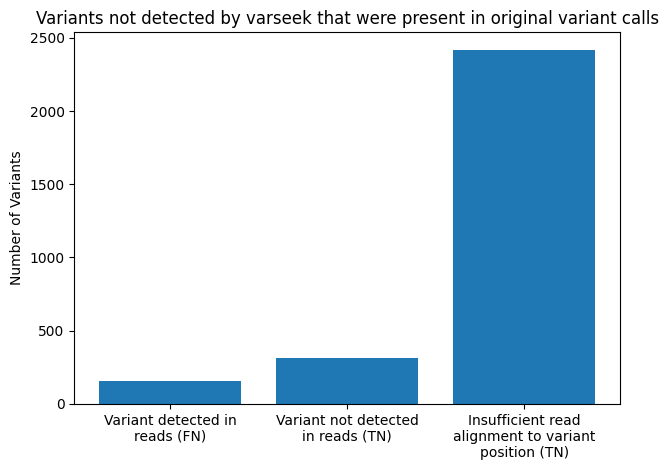

In [33]:
overall_results = {
    "Variant detected in reads (FN)": len(true_variants),
    "Variant not detected in reads (TN)": len(false_variants),
    "Insufficient read alignment to variant position (TN)": len(undetermined_variants),
}

plot_overall_bar_plot(overall_results, wrap_width=20, out_file=os.path.join(figures_out_dir, "fn_bar_plot.pdf"), title = 'Variants not detected by varseek that were present in original variant calls')

## Analyze a FN

In [34]:
# detailed_txt_out_fn = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/detailed_out_fn_NOT_modified_bam.txt"
# vcrs_fasta = "/data/vk_ref_out_geuvadis/w37_k41/vcrs_filtered.fa"

variants_in_vcrs_reference = []
variants_not_in_vcrs_reference = []

with open(vcrs_fasta) as f:
    vcrs_reference_contents = f.read()

# loop through detailed_txt_out_fn and check if the variant was in the vcrs_fasta
with open(detailed_txt_out_fn) as f:
    lines = f.readlines()

for i in tqdm(range(len(lines))):
    if i + 1 < len(lines) and "True variant: True" not in lines[i + 1]:
        continue  # I only want to analyze True variants that varseek missed
    line = lines[i]
    if not line.startswith("vcrs"):
        continue
    parts = line.strip().split("|")
    if len(parts) < 3:
        continue
    mutation_str = parts[2].strip()  # e.g., ENST00000338591:c.716G>C
    if mutation_str in vcrs_reference_contents:
        variants_in_vcrs_reference.append(mutation_str)
    else:
        variants_not_in_vcrs_reference.append(mutation_str)

print(f"Variants in vcrs_reference: {len(variants_in_vcrs_reference)}")
print(f"Variants not in vcrs_reference: {len(variants_not_in_vcrs_reference)}")

  0%|                                                                                                                           | 0/46152 [00:00<?, ?it/s]

 18%|███████████████████▎                                                                                         | 8161/46152 [00:00<00:00, 79082.78it/s]

 35%|█████████████████████████████████████▌                                                                      | 16070/46152 [00:00<00:01, 19664.50it/s]

 44%|██████████████████████████████████████████████▉                                                             | 20077/46152 [00:00<00:01, 20123.27it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 23227/46152 [00:01<00:01, 20183.78it/s]

 66%|██████████████████████████████████████████████████████████████████████▉                                     | 30313/46152 [00:01<00:00, 29121.62it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                           | 34393/46152 [00:01<00:00, 18532.14it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 38361/46152 [00:01<00:00, 21435.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▎          | 41597/46152 [00:01<00:00, 21308.37it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 44469/46152 [00:01<00:00, 22623.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46152/46152 [00:02<00:00, 22079.93it/s]

Variants in vcrs_reference: 306
Variants not in vcrs_reference: 0


In [35]:
variants_in_vcrs_reference[:20]

['ENST00000497986:c.262A>G',
 'ENST00000497986:c.262A>G',
 'ENST00000359858:c.367G>A',
 'ENST00000359858:c.367G>A',
 'ENST00000340450:c.795T>G',
 'ENST00000340450:c.795T>G',
 'ENST00000340450:c.801T>G',
 'ENST00000340450:c.801T>G',
 'ENST00000372476:c.3052A>G',
 'ENST00000372476:c.3052A>G',
 'ENST00000370139:c.96G>A',
 'ENST00000370139:c.96G>A',
 'ENST00000370139:c.97C>T',
 'ENST00000370139:c.97C>T',
 'ENST00000309851:c.79G>A',
 'ENST00000309851:c.79G>A',
 'ENST00000256593:c.594T>C',
 'ENST00000256593:c.594T>C',
 'ENST00000585156:c.6692C>G',
 'ENST00000585156:c.6692C>G']

In [36]:
# look into detailed_txt_out_fn and pick a True variant that had reads align to ALT and is in the vcrs reference
# eg vcrs_104 | rs2502992 | ENST00000374472:c.351A>G | (-) strand | 1:g.24201919T>C 
# variant_bam_sorted_modified = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/final_total_sorted_reads_modified.bam"  #* uncomment if running only this bottom portion
# hgvsc = "ENST00000374472:c.351A>G"
# chrom = "1"
# pos = "24201919"
variant_bam_sorted = os.path.join(notebook_out_dir, "final_total_sorted_reads.bam") if not modify_bam else os.path.join(notebook_out_dir, "final_total_sorted_reads_modified.bam")
hgvsc = variants_in_vcrs_reference[0]
print(hgvsc)

result = None
with open(detailed_txt_out_fn) as f:
    for line in f:
        if hgvsc in line:
            result = line.strip().split(" | ")
            break  # stop at the first match

hgvsg = result[4]
chrom = hgvsg.split(":")[0]
match = re.search(r'g\.(\d+)', hgvsg)
pos = match.group(1) if match else None

# output_sam = f"/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/reads_at_{chrom}_{pos}.sam"
output_sam = os.path.join(notebook_out_dir, f"reads_at_{chrom}_{pos}.sam")
!samtools view {variant_bam_sorted} {chrom}:{pos}-{pos} > {output_sam}

ENST00000497986:c.262A>G


In [37]:
# revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
output = !grep -A 1 "{hgvsc}" {vcrs_fasta}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)
print(seq_rc[:38])
print(seq_rc[37:])

AGAGCAGGCTGAAGAGGAACGATATTTCCGACATTACGGGTTATGCTTTGAGATCTCTTTGGGGTGAAGGATTGA
TCAATCCTTCACCCCAAAGAGATCTCAAAGCATAACCCGTAATGTCGGAAATATCGTTCCTCTTCAGCCTGCTCT
TCAATCCTTCACCCCAAAGAGATCTCAAAGCATAACCC
CGTAATGTCGGAAATATCGTTCCTCTTCAGCCTGCTCT


(double click on this cell for it to make sense)
Applies to ENST00000374472:c.351A>G aka 1:g.24201919T>C 

In this case, the issue was due to multiple variants - all reads had the variant toward the left end of the read, and there is another variant to the right that blocks a perfect k-mer match (also, keep in mind that read length is 75 for this dataset and w=37/k=41, so the reads are relatively small)

Eg typical read:
TTCCGGCGGAGCCGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGTTCTCCAGGGCACTTAGCAGGCCCAGA  # read
TTCCGGCGGAGCTGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGT  # vcrs fragment aligned to read
           *
            ^

* mutation site for VCRS
^ unrelated mutation that blocks k-mer match

## Now let's look into a FP

In [38]:
# eg vcrs_100 | rs1131095 | ENST00000296456:c.1252T>C | (+) strand | 3:g.49714225T>C | 68.0 reported counts
# hgvsc = "ENST00000296456:c.1252T>C"
results = []

with open(detailed_txt_out) as f:
    lines = f.readlines()

for i in range(len(lines) - 1):
    line1 = lines[i].strip()
    line2 = lines[i + 1].strip()

    # Check that line1 has a reported count > min_counts
    try:
        count_str = line1.split(" | ")[-1].split()[0]  # e.g., '68.0' from '68.0 reported counts'
        reported_count = float(count_str)
    except (IndexError, ValueError):
        continue  # skip malformed lines

    # Check that the next line doesn't say "True variant: True"
    if reported_count > min_counts and line2 != "True variant: True":
        results.append(line1)

result_single = results[0]  # look at the first one
result_single = result_single.split(" | ")

hgvsc = result_single[2]
print(hgvsc)
output = !grep -A 1 "{hgvsc}" {vcrs_fasta}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)

ENST00000260379:c.299G>C


AAAGCAGCCGGTGTAAATGTTGAGCCTTTTTGGCCTGCCTTGTTTGCAAAGGCCCTGGCCAACGTCAACATTGGG
CCCAATGTTGACGTTGGCCAGGGCCTTTGCAAACAAGGCAGGCCAAAAAGGCTCAACATTTACACCGGCTGCTTT


### Manually check if any read has a k-mer that matches the VCRS

In [39]:
# import pyfastx
# fastq_file = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/fastqs_combined/fastqs_combined.fastq.gz"  #* uncomment if running only this bottom portion
# fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)  #* uncomment if running only this bottom portion

k = 41  # from vk ref settings
kmer_set = set()

# Add k-mers from seq and seq_rc
for s in [seq, seq_rc]:
    for i in range(len(s) - k + 1):
        kmer_set.add(s[i:i+k])

# Store reads that contain any of those k-mers
matching_reads = {}

fq_read_only = pyfastx.Fastx(fastq_file)

for name, read_seq, _ in tqdm((fq_read_only), total=len(fastq_indexed)):
    found = any(read_seq[i:i+k] in kmer_set for i in range(len(read_seq) - k + 1))
    if found:
        matching_reads[name] = read_seq

  0%|                                                                                                                        | 0/46292322 [00:00<?, ?it/s]

  0%|                                                                                                          | 3392/46292322 [00:00<22:44, 33917.04it/s]

  0%|                                                                                                          | 7574/46292322 [00:00<20:00, 38562.40it/s]

  0%|                                                                                                         | 11830/46292322 [00:00<19:05, 40385.09it/s]

  0%|                                                                                                         | 16030/46292322 [00:00<18:48, 41015.08it/s]

  0%|                                                                                                         | 20240/46292322 [00:00<18:37, 41403.30it/s]

  0%|                                                                                                         | 24508/46292322 [00:00<18:25, 41836.44it/s]

  0%|                                                                                                         | 31437/46292322 [00:00<15:10, 50809.13it/s]

  0%|                                                                                                         | 38400/46292322 [00:00<13:34, 56797.45it/s]

  0%|                                                                                                         | 45898/46292322 [00:00<12:20, 62478.75it/s]

  0%|                                                                                                         | 52879/46292322 [00:01<11:54, 64739.57it/s]

  0%|▏                                                                                                        | 60387/46292322 [00:01<11:20, 67902.37it/s]

  0%|▏                                                                                                        | 67873/46292322 [00:01<11:00, 70015.31it/s]

  0%|▏                                                                                                        | 76192/46292322 [00:01<10:24, 74004.12it/s]

  0%|▏                                                                                                        | 83991/46292322 [00:01<10:14, 75204.56it/s]

  0%|▏                                                                                                        | 91713/46292322 [00:01<10:09, 75808.40it/s]

  0%|▏                                                                                                       | 100023/46292322 [00:01<09:52, 77999.12it/s]

  0%|▏                                                                                                       | 107823/46292322 [00:01<09:54, 77626.02it/s]

  0%|▎                                                                                                       | 115614/46292322 [00:01<09:54, 77708.59it/s]

  0%|▎                                                                                                       | 123935/46292322 [00:01<09:41, 79353.86it/s]

  0%|▎                                                                                                       | 131871/46292322 [00:02<09:47, 78557.46it/s]

  0%|▎                                                                                                       | 139729/46292322 [00:02<09:48, 78371.34it/s]

  0%|▎                                                                                                       | 147955/46292322 [00:02<09:40, 79527.45it/s]

  0%|▎                                                                                                       | 155910/46292322 [00:02<09:43, 79061.41it/s]

  0%|▎                                                                                                       | 163818/46292322 [00:02<09:46, 78711.65it/s]

  0%|▍                                                                                                       | 171731/46292322 [00:02<09:47, 78466.18it/s]

  0%|▍                                                                                                       | 180078/46292322 [00:02<09:36, 79949.03it/s]

  0%|▍                                                                                                       | 188075/46292322 [00:02<09:44, 78844.99it/s]

  0%|▍                                                                                                       | 195964/46292322 [00:02<09:46, 78588.77it/s]

  0%|▍                                                                                                       | 204267/46292322 [00:02<09:36, 79902.60it/s]

  0%|▍                                                                                                       | 212261/46292322 [00:03<09:40, 79394.02it/s]

  0%|▍                                                                                                       | 220204/46292322 [00:03<09:44, 78773.57it/s]

  0%|▌                                                                                                       | 228587/46292322 [00:03<09:33, 80269.12it/s]

  1%|▌                                                                                                       | 236618/46292322 [00:03<09:38, 79675.94it/s]

  1%|▌                                                                                                       | 244589/46292322 [00:03<09:41, 79234.18it/s]

  1%|▌                                                                                                       | 252515/46292322 [00:03<09:46, 78561.79it/s]

  1%|▌                                                                                                       | 260761/46292322 [00:03<09:37, 79712.56it/s]

  1%|▌                                                                                                       | 268736/46292322 [00:03<09:40, 79287.35it/s]

  1%|▌                                                                                                       | 276668/46292322 [00:03<09:42, 78983.90it/s]

  1%|▋                                                                                                       | 285018/46292322 [00:03<09:32, 80321.07it/s]

  1%|▋                                                                                                       | 293053/46292322 [00:04<09:37, 79651.90it/s]

  1%|▋                                                                                                       | 301021/46292322 [00:04<09:42, 78923.49it/s]

  1%|▋                                                                                                       | 309088/46292322 [00:04<09:46, 78405.37it/s]

  1%|▋                                                                                                       | 317425/46292322 [00:04<09:35, 79862.60it/s]

  1%|▋                                                                                                       | 325416/46292322 [00:04<09:38, 79402.16it/s]

  1%|▋                                                                                                       | 333360/46292322 [00:04<09:44, 78615.31it/s]

  1%|▊                                                                                                       | 341620/46292322 [00:04<09:35, 79787.87it/s]

  1%|▊                                                                                                       | 349603/46292322 [00:04<09:39, 79279.76it/s]

  1%|▊                                                                                                       | 357535/46292322 [00:04<09:41, 78930.82it/s]

  1%|▊                                                                                                       | 365877/46292322 [00:04<09:32, 80257.94it/s]

  1%|▊                                                                                                       | 373906/46292322 [00:05<09:38, 79356.81it/s]

  1%|▊                                                                                                       | 381846/46292322 [00:05<09:42, 78774.75it/s]

  1%|▉                                                                                                       | 389727/46292322 [00:05<09:44, 78528.05it/s]

  1%|▉                                                                                                       | 398046/46292322 [00:05<09:34, 79907.00it/s]

  1%|▉                                                                                                       | 406040/46292322 [00:05<09:38, 79295.67it/s]

  1%|▉                                                                                                       | 413973/46292322 [00:05<09:41, 78889.88it/s]

  1%|▉                                                                                                       | 422217/46292322 [00:05<09:33, 79940.76it/s]

  1%|▉                                                                                                       | 430214/46292322 [00:05<09:38, 79253.37it/s]

  1%|▉                                                                                                       | 438142/46292322 [00:05<09:41, 78922.80it/s]

  1%|█                                                                                                       | 446450/46292322 [00:05<09:31, 80153.27it/s]

  1%|█                                                                                                       | 454468/46292322 [00:06<09:35, 79614.84it/s]

  1%|█                                                                                                       | 462432/46292322 [00:06<09:40, 78968.64it/s]

  1%|█                                                                                                       | 470392/46292322 [00:06<09:41, 78756.41it/s]

  1%|█                                                                                                       | 478741/46292322 [00:06<09:31, 80157.04it/s]

  1%|█                                                                                                       | 486760/46292322 [00:06<09:35, 79564.38it/s]

  1%|█                                                                                                       | 494719/46292322 [00:06<09:41, 78711.04it/s]

  1%|█▏                                                                                                      | 502947/46292322 [00:06<09:34, 79763.53it/s]

  1%|█▏                                                                                                      | 510928/46292322 [00:06<09:37, 79285.26it/s]

  1%|█▏                                                                                                      | 518860/46292322 [00:06<09:39, 78932.97it/s]

  1%|█▏                                                                                                      | 527200/46292322 [00:06<09:30, 80255.27it/s]

  1%|█▏                                                                                                      | 535229/46292322 [00:07<09:35, 79514.29it/s]

  1%|█▏                                                                                                      | 543184/46292322 [00:07<09:40, 78819.13it/s]

  1%|█▏                                                                                                      | 551211/46292322 [00:07<09:43, 78358.94it/s]

  1%|█▎                                                                                                      | 559547/46292322 [00:07<09:32, 79829.46it/s]

  1%|█▎                                                                                                      | 567535/46292322 [00:07<09:36, 79346.52it/s]

  1%|█▎                                                                                                      | 575473/46292322 [00:07<09:38, 78965.28it/s]

  1%|█▎                                                                                                      | 583685/46292322 [00:07<09:32, 79894.92it/s]

  1%|█▎                                                                                                      | 591678/46292322 [00:07<09:35, 79353.46it/s]

  1%|█▎                                                                                                      | 599616/46292322 [00:07<09:38, 78982.07it/s]

  1%|█▎                                                                                                      | 607945/46292322 [00:08<09:29, 80255.68it/s]

  1%|█▍                                                                                                      | 615974/46292322 [00:08<09:35, 79339.18it/s]

  1%|█▍                                                                                                      | 623912/46292322 [00:08<09:40, 78666.36it/s]

  1%|█▍                                                                                                      | 631924/46292322 [00:08<09:41, 78458.23it/s]

  1%|█▍                                                                                                      | 640252/46292322 [00:08<09:31, 79879.26it/s]

  1%|█▍                                                                                                      | 648244/46292322 [00:08<09:34, 79382.46it/s]

  1%|█▍                                                                                                      | 656186/46292322 [00:08<09:41, 78485.32it/s]

  1%|█▍                                                                                                      | 664500/46292322 [00:08<09:31, 79855.19it/s]

  1%|█▌                                                                                                      | 672491/46292322 [00:08<09:35, 79206.38it/s]

  1%|█▌                                                                                                      | 680416/46292322 [00:08<09:38, 78846.09it/s]

  1%|█▌                                                                                                      | 688716/46292322 [00:09<09:39, 78677.07it/s]

  2%|█▌                                                                                                      | 696958/46292322 [00:09<09:31, 79773.83it/s]

  2%|█▌                                                                                                      | 704940/46292322 [00:09<09:34, 79306.29it/s]

  2%|█▌                                                                                                      | 712874/46292322 [00:09<09:37, 78988.02it/s]

  2%|█▌                                                                                                      | 721161/46292322 [00:09<09:28, 80134.77it/s]

  2%|█▋                                                                                                      | 729178/46292322 [00:09<09:32, 79550.17it/s]

  2%|█▋                                                                                                      | 737136/46292322 [00:09<09:38, 78738.42it/s]

  2%|█▋                                                                                                      | 745507/46292322 [00:09<09:37, 78846.47it/s]

  2%|█▋                                                                                                      | 753958/46292322 [00:09<09:25, 80503.52it/s]

  2%|█▋                                                                                                      | 762014/46292322 [00:09<09:28, 80025.17it/s]

  2%|█▋                                                                                                      | 770020/46292322 [00:10<09:31, 79707.44it/s]

  2%|█▋                                                                                                      | 778948/46292322 [00:10<09:11, 82537.24it/s]

  2%|█▊                                                                                                      | 790216/46292322 [00:10<08:17, 91490.04it/s]

  2%|█▊                                                                                                      | 801333/46292322 [00:10<07:47, 97351.70it/s]

  2%|█▊                                                                                                     | 812041/46292322 [00:10<07:33, 100250.81it/s]

  2%|█▊                                                                                                     | 822897/46292322 [00:10<07:22, 102731.36it/s]

  2%|█▊                                                                                                     | 833742/46292322 [00:10<07:15, 104441.12it/s]

  2%|█▉                                                                                                     | 845059/46292322 [00:10<07:09, 105862.77it/s]

  2%|█▉                                                                                                     | 856248/46292322 [00:10<07:02, 107653.07it/s]

  2%|█▉                                                                                                     | 867455/46292322 [00:10<06:56, 108966.22it/s]

  2%|█▉                                                                                                     | 878355/46292322 [00:11<06:57, 108711.91it/s]

  2%|█▉                                                                                                     | 889228/46292322 [00:11<07:00, 108066.81it/s]

  2%|██                                                                                                     | 900607/46292322 [00:11<06:53, 109768.31it/s]

  2%|██                                                                                                     | 911616/46292322 [00:11<06:55, 109219.55it/s]

  2%|██                                                                                                     | 922762/46292322 [00:11<06:52, 109885.12it/s]

  2%|██                                                                                                     | 934071/46292322 [00:11<06:49, 110839.74it/s]

  2%|██                                                                                                     | 945157/46292322 [00:11<06:53, 109746.36it/s]

  2%|██▏                                                                                                    | 956136/46292322 [00:11<06:54, 109316.67it/s]

  2%|██▏                                                                                                    | 967268/46292322 [00:11<06:52, 109909.59it/s]

  2%|██▏                                                                                                    | 978262/46292322 [00:11<06:55, 109174.26it/s]

  2%|██▏                                                                                                    | 989544/46292322 [00:12<06:50, 110254.29it/s]

  2%|██▏                                                                                                   | 1000624/46292322 [00:12<06:50, 110412.86it/s]

  2%|██▏                                                                                                   | 1011668/46292322 [00:12<07:07, 105935.64it/s]

  2%|██▎                                                                                                   | 1022300/46292322 [00:12<07:16, 103629.61it/s]

  2%|██▎                                                                                                   | 1032695/46292322 [00:12<07:19, 102945.82it/s]

  2%|██▎                                                                                                   | 1043011/46292322 [00:12<07:21, 102519.53it/s]

  2%|██▎                                                                                                   | 1053324/46292322 [00:12<07:20, 102694.47it/s]

  2%|██▎                                                                                                   | 1063604/46292322 [00:12<07:21, 102446.24it/s]

  2%|██▎                                                                                                   | 1074108/46292322 [00:12<07:18, 103210.09it/s]

  2%|██▍                                                                                                   | 1084598/46292322 [00:12<07:15, 103709.13it/s]

  2%|██▍                                                                                                   | 1095105/46292322 [00:13<07:14, 104111.15it/s]

  2%|██▍                                                                                                   | 1105520/46292322 [00:13<07:14, 103942.98it/s]

  2%|██▍                                                                                                   | 1116198/46292322 [00:13<07:11, 104787.82it/s]

  2%|██▍                                                                                                   | 1127122/46292322 [00:13<07:05, 106116.66it/s]

  2%|██▌                                                                                                   | 1137736/46292322 [00:13<07:09, 105108.95it/s]

  2%|██▌                                                                                                   | 1148251/46292322 [00:13<07:17, 103295.99it/s]

  3%|██▌                                                                                                    | 1158589/46292322 [00:13<10:45, 69892.37it/s]

  3%|██▌                                                                                                    | 1167052/46292322 [00:13<10:16, 73156.54it/s]

  3%|██▌                                                                                                    | 1176584/46292322 [00:14<09:34, 78484.12it/s]

  3%|██▋                                                                                                    | 1186090/46292322 [00:14<09:05, 82720.45it/s]

  3%|██▋                                                                                                    | 1195301/46292322 [00:14<08:50, 85070.74it/s]

  3%|██▋                                                                                                    | 1204335/46292322 [00:14<09:53, 75943.22it/s]

  3%|██▋                                                                                                    | 1214146/46292322 [00:14<09:14, 81317.20it/s]

  3%|██▋                                                                                                    | 1224525/46292322 [00:14<08:36, 87336.20it/s]

  3%|██▋                                                                                                    | 1235395/46292322 [00:14<08:03, 93247.23it/s]

  3%|██▊                                                                                                    | 1246088/46292322 [00:14<07:43, 97123.08it/s]

  3%|██▊                                                                                                    | 1256389/46292322 [00:14<07:35, 98818.06it/s]

  3%|██▊                                                                                                    | 1266452/46292322 [00:15<07:37, 98324.97it/s]

  3%|██▊                                                                                                   | 1276950/46292322 [00:15<07:28, 100264.52it/s]

  3%|██▊                                                                                                   | 1287731/46292322 [00:15<07:19, 102483.30it/s]

  3%|██▊                                                                                                   | 1298486/46292322 [00:15<07:12, 103980.93it/s]

  3%|██▉                                                                                                   | 1308936/46292322 [00:15<07:13, 103722.87it/s]

  3%|██▉                                                                                                   | 1319364/46292322 [00:15<07:12, 103885.45it/s]

  3%|██▉                                                                                                   | 1329936/46292322 [00:15<07:10, 104430.28it/s]

  3%|██▉                                                                                                   | 1340700/46292322 [00:15<07:06, 105385.60it/s]

  3%|██▉                                                                                                   | 1351252/46292322 [00:15<07:09, 104728.70it/s]

  3%|███                                                                                                   | 1362019/46292322 [00:15<07:05, 105601.10it/s]

  3%|███                                                                                                   | 1372814/46292322 [00:16<07:02, 106301.00it/s]

  3%|███                                                                                                   | 1383450/46292322 [00:16<07:08, 104796.97it/s]

  3%|███                                                                                                   | 1393939/46292322 [00:16<07:11, 104164.43it/s]

  3%|███                                                                                                   | 1404568/46292322 [00:16<07:08, 104791.16it/s]

  3%|███                                                                                                   | 1415368/46292322 [00:16<07:04, 105742.09it/s]

  3%|███▏                                                                                                  | 1426108/46292322 [00:16<07:02, 106234.21it/s]

  3%|███▏                                                                                                  | 1436735/46292322 [00:16<07:09, 104414.22it/s]

  3%|███▏                                                                                                  | 1447186/46292322 [00:16<07:09, 104345.83it/s]

  3%|███▏                                                                                                  | 1458008/46292322 [00:16<07:05, 105492.01it/s]

  3%|███▏                                                                                                  | 1468653/46292322 [00:16<07:03, 105773.07it/s]

  3%|███▎                                                                                                  | 1479235/46292322 [00:17<07:11, 103844.65it/s]

  3%|███▎                                                                                                  | 1489932/46292322 [00:17<07:07, 104763.60it/s]

  3%|███▎                                                                                                  | 1500539/46292322 [00:17<07:05, 105148.06it/s]

  3%|███▎                                                                                                  | 1511061/46292322 [00:17<07:06, 105012.19it/s]

  3%|███▎                                                                                                  | 1521567/46292322 [00:17<07:10, 103886.68it/s]

  3%|███▍                                                                                                  | 1532410/46292322 [00:17<07:05, 105229.02it/s]

  3%|███▍                                                                                                  | 1543065/46292322 [00:17<07:03, 105618.94it/s]

  3%|███▍                                                                                                  | 1553905/46292322 [00:17<07:00, 106446.62it/s]

  3%|███▍                                                                                                  | 1564553/46292322 [00:17<07:08, 104421.22it/s]

  3%|███▍                                                                                                  | 1575247/46292322 [00:17<07:05, 105162.36it/s]

  3%|███▍                                                                                                  | 1585943/46292322 [00:18<07:02, 105693.10it/s]

  3%|███▌                                                                                                  | 1596564/46292322 [00:18<07:02, 105843.56it/s]

  3%|███▌                                                                                                  | 1607154/46292322 [00:18<07:06, 104825.87it/s]

  3%|███▌                                                                                                  | 1617952/46292322 [00:18<07:02, 105757.96it/s]

  4%|███▌                                                                                                  | 1628533/46292322 [00:18<07:05, 104935.65it/s]

  4%|███▌                                                                                                  | 1639031/46292322 [00:18<07:05, 104913.51it/s]

  4%|███▋                                                                                                  | 1649526/46292322 [00:18<07:16, 102289.71it/s]

  4%|███▋                                                                                                  | 1660311/46292322 [00:18<07:09, 103917.53it/s]

  4%|███▋                                                                                                  | 1671092/46292322 [00:18<07:04, 105064.64it/s]

  4%|███▋                                                                                                  | 1681696/46292322 [00:18<07:08, 104025.34it/s]

  4%|███▋                                                                                                  | 1692113/46292322 [00:19<07:08, 104064.52it/s]

  4%|███▊                                                                                                  | 1702745/46292322 [00:19<07:05, 104731.20it/s]

  4%|███▊                                                                                                  | 1713521/46292322 [00:19<07:02, 105630.38it/s]

  4%|███▊                                                                                                  | 1724089/46292322 [00:19<07:02, 105571.34it/s]

  4%|███▊                                                                                                  | 1734650/46292322 [00:19<07:04, 104937.94it/s]

  4%|███▊                                                                                                  | 1745487/46292322 [00:19<07:00, 105957.22it/s]

  4%|███▊                                                                                                  | 1756247/46292322 [00:19<06:58, 106443.31it/s]

  4%|███▉                                                                                                  | 1766894/46292322 [00:19<07:07, 104142.34it/s]

  4%|███▉                                                                                                  | 1777488/46292322 [00:19<07:05, 104668.79it/s]

  4%|███▉                                                                                                  | 1788315/46292322 [00:19<07:00, 105732.66it/s]

  4%|███▉                                                                                                  | 1799088/46292322 [00:20<06:58, 106322.73it/s]

  4%|███▉                                                                                                  | 1809727/46292322 [00:20<07:03, 105002.61it/s]

  4%|████                                                                                                  | 1820465/46292322 [00:20<07:00, 105703.22it/s]

  4%|████                                                                                                  | 1831042/46292322 [00:20<07:02, 105300.40it/s]

  4%|████                                                                                                  | 1841714/46292322 [00:20<07:00, 105719.57it/s]

  4%|████                                                                                                  | 1852290/46292322 [00:20<07:03, 104929.32it/s]

  4%|████                                                                                                  | 1862922/46292322 [00:20<07:01, 105338.99it/s]

  4%|████▏                                                                                                 | 1873706/46292322 [00:20<06:58, 106081.14it/s]

  4%|████▏                                                                                                 | 1884361/46292322 [00:20<06:58, 106218.72it/s]

  4%|████▏                                                                                                 | 1894985/46292322 [00:20<07:07, 103792.10it/s]

  4%|████▏                                                                                                 | 1905733/46292322 [00:21<07:03, 104876.22it/s]

  4%|████▏                                                                                                 | 1916446/46292322 [00:21<07:00, 105541.68it/s]

  4%|████▏                                                                                                 | 1927137/46292322 [00:21<06:58, 105945.50it/s]

  4%|████▎                                                                                                 | 1937738/46292322 [00:21<07:03, 104767.96it/s]

  4%|████▎                                                                                                 | 1948262/46292322 [00:21<07:02, 104905.02it/s]

  4%|████▎                                                                                                 | 1958758/46292322 [00:21<07:03, 104664.80it/s]

  4%|████▎                                                                                                 | 1969432/46292322 [00:21<07:01, 105279.28it/s]

  4%|████▎                                                                                                 | 1979963/46292322 [00:21<07:03, 104652.40it/s]

  4%|████▍                                                                                                 | 1990691/46292322 [00:21<07:00, 105432.74it/s]

  4%|████▍                                                                                                 | 2001389/46292322 [00:22<06:58, 105887.68it/s]

  4%|████▍                                                                                                 | 2011980/46292322 [00:22<07:01, 105127.74it/s]

  4%|████▍                                                                                                 | 2022496/46292322 [00:22<07:06, 103735.81it/s]

  4%|████▍                                                                                                 | 2033234/46292322 [00:22<07:02, 104810.61it/s]

  4%|████▌                                                                                                 | 2044088/46292322 [00:22<06:57, 105914.73it/s]

  4%|████▌                                                                                                 | 2054813/46292322 [00:22<06:56, 106309.97it/s]

  4%|████▌                                                                                                 | 2065448/46292322 [00:22<07:03, 104500.22it/s]

  4%|████▌                                                                                                 | 2075907/46292322 [00:22<07:03, 104459.76it/s]

  5%|████▌                                                                                                 | 2086399/46292322 [00:22<07:02, 104594.21it/s]

  5%|████▌                                                                                                 | 2097237/46292322 [00:22<06:58, 105715.11it/s]

  5%|████▋                                                                                                 | 2107813/46292322 [00:23<07:01, 104874.83it/s]

  5%|████▋                                                                                                 | 2118305/46292322 [00:23<07:01, 104726.71it/s]

  5%|████▋                                                                                                 | 2129136/46292322 [00:23<06:57, 105790.81it/s]

  5%|████▋                                                                                                 | 2139718/46292322 [00:23<06:57, 105767.43it/s]

  5%|████▋                                                                                                 | 2150297/46292322 [00:23<07:05, 103819.81it/s]

  5%|████▊                                                                                                 | 2161090/46292322 [00:23<07:00, 105028.70it/s]

  5%|████▊                                                                                                 | 2171796/46292322 [00:23<06:57, 105628.17it/s]

  5%|████▊                                                                                                 | 2182366/46292322 [00:23<07:02, 104361.86it/s]

  5%|████▊                                                                                                 | 2193198/46292322 [00:23<06:57, 105529.88it/s]

  5%|████▊                                                                                                 | 2203758/46292322 [00:23<07:00, 104817.21it/s]

  5%|████▉                                                                                                 | 2214509/46292322 [00:24<06:57, 105612.40it/s]

  5%|████▉                                                                                                 | 2225075/46292322 [00:24<07:01, 104460.42it/s]

  5%|████▉                                                                                                 | 2235749/46292322 [00:24<06:59, 105132.67it/s]

  5%|████▉                                                                                                 | 2246493/46292322 [00:24<06:56, 105816.27it/s]

  5%|████▉                                                                                                 | 2257079/46292322 [00:24<06:56, 105803.92it/s]

  5%|████▉                                                                                                 | 2267663/46292322 [00:24<07:04, 103797.30it/s]

  5%|█████                                                                                                 | 2278254/46292322 [00:24<07:01, 104418.50it/s]

  5%|█████                                                                                                 | 2289090/46292322 [00:24<06:56, 105580.26it/s]

  5%|█████                                                                                                 | 2299655/46292322 [00:24<06:57, 105356.38it/s]

  5%|█████                                                                                                 | 2310196/46292322 [00:24<07:00, 104598.20it/s]

  5%|█████                                                                                                 | 2320666/46292322 [00:25<07:00, 104626.38it/s]

  5%|█████▏                                                                                                | 2331132/46292322 [00:25<07:00, 104619.86it/s]

  5%|█████▏                                                                                                | 2341920/46292322 [00:25<06:56, 105591.08it/s]

  5%|█████▏                                                                                                | 2352486/46292322 [00:25<07:00, 104563.67it/s]

  5%|█████▏                                                                                                | 2363122/46292322 [00:25<06:58, 105090.83it/s]

  5%|█████▏                                                                                                | 2373948/46292322 [00:25<06:54, 106031.66it/s]

  5%|█████▎                                                                                                | 2384554/46292322 [00:25<06:58, 105016.73it/s]

  5%|█████▎                                                                                                | 2395081/46292322 [00:25<07:02, 104009.06it/s]

  5%|█████▎                                                                                                | 2405878/46292322 [00:25<06:57, 105177.20it/s]

  5%|█████▎                                                                                                | 2416552/46292322 [00:25<06:55, 105639.18it/s]

  5%|█████▎                                                                                                | 2427266/46292322 [00:26<06:53, 106082.95it/s]

  5%|█████▎                                                                                                | 2437878/46292322 [00:26<07:00, 104336.43it/s]

  5%|█████▍                                                                                                | 2448320/46292322 [00:26<07:01, 103898.08it/s]

  5%|█████▍                                                                                                | 2459082/46292322 [00:26<06:57, 104996.62it/s]

  5%|█████▍                                                                                                | 2469779/46292322 [00:26<06:55, 105581.44it/s]

  5%|█████▍                                                                                                | 2480342/46292322 [00:26<07:00, 104070.30it/s]

  5%|█████▍                                                                                                | 2490934/46292322 [00:26<06:58, 104614.39it/s]

  5%|█████▌                                                                                                | 2501416/46292322 [00:26<06:58, 104674.12it/s]

  5%|█████▌                                                                                                | 2511916/46292322 [00:26<06:57, 104769.78it/s]

  5%|█████▌                                                                                                | 2522645/46292322 [00:26<06:54, 105519.56it/s]

  5%|█████▌                                                                                                | 2533200/46292322 [00:27<07:01, 103853.38it/s]

  5%|█████▌                                                                                                | 2543686/46292322 [00:27<07:00, 104148.24it/s]

  6%|█████▋                                                                                                | 2554491/46292322 [00:27<06:55, 105304.44it/s]

  6%|█████▋                                                                                                | 2565027/46292322 [00:27<06:59, 104236.36it/s]

  6%|█████▋                                                                                                | 2575456/46292322 [00:27<07:01, 103701.63it/s]

  6%|█████▋                                                                                                | 2586296/46292322 [00:27<06:55, 105091.96it/s]

  6%|█████▋                                                                                                | 2596872/46292322 [00:27<06:55, 105288.16it/s]

  6%|█████▋                                                                                                | 2607462/46292322 [00:27<06:54, 105467.94it/s]

  6%|█████▊                                                                                                | 2618012/46292322 [00:27<06:56, 104818.12it/s]

  6%|█████▊                                                                                                | 2628865/46292322 [00:27<06:52, 105921.81it/s]

  6%|█████▊                                                                                                | 2639533/46292322 [00:28<06:51, 106145.11it/s]

  6%|█████▊                                                                                                | 2650150/46292322 [00:28<06:57, 104646.86it/s]

  6%|█████▊                                                                                                | 2660973/46292322 [00:28<06:52, 105706.53it/s]

  6%|█████▉                                                                                                | 2671750/46292322 [00:28<06:50, 106318.27it/s]

  6%|█████▉                                                                                                | 2682387/46292322 [00:28<06:50, 106284.99it/s]

  6%|█████▉                                                                                                | 2693019/46292322 [00:28<07:03, 102829.36it/s]

  6%|█████▉                                                                                                | 2703493/46292322 [00:28<07:01, 103384.64it/s]

  6%|█████▉                                                                                                | 2714109/46292322 [00:28<06:58, 104197.88it/s]

  6%|██████                                                                                                | 2724903/46292322 [00:28<06:53, 105301.84it/s]

  6%|██████                                                                                                | 2735446/46292322 [00:29<06:57, 104256.26it/s]

  6%|██████                                                                                                | 2746155/46292322 [00:29<06:54, 105092.79it/s]

  6%|██████                                                                                                | 2756837/46292322 [00:29<06:52, 105602.93it/s]

  6%|██████                                                                                                | 2767598/46292322 [00:29<06:49, 106198.51it/s]

  6%|██████                                                                                                | 2778223/46292322 [00:29<06:55, 104663.33it/s]

  6%|██████▏                                                                                               | 2789007/46292322 [00:29<06:51, 105599.99it/s]

  6%|██████▏                                                                                               | 2799755/46292322 [00:29<06:49, 106156.89it/s]

  6%|██████▏                                                                                               | 2810376/46292322 [00:29<06:51, 105729.72it/s]

  6%|██████▏                                                                                               | 2820953/46292322 [00:29<06:58, 103782.28it/s]

  6%|██████▏                                                                                               | 2831617/46292322 [00:29<06:55, 104621.90it/s]

  6%|██████▎                                                                                               | 2842088/46292322 [00:30<06:55, 104542.47it/s]

  6%|██████▎                                                                                               | 2852548/46292322 [00:30<06:56, 104199.38it/s]

  6%|██████▎                                                                                               | 2862972/46292322 [00:30<06:58, 103720.88it/s]

  6%|██████▎                                                                                               | 2873719/46292322 [00:30<06:54, 104832.84it/s]

  6%|██████▎                                                                                               | 2884449/46292322 [00:30<06:51, 105565.89it/s]

  6%|██████▍                                                                                               | 2895009/46292322 [00:30<07:04, 102234.61it/s]

  6%|██████▍                                                                                                | 2905256/46292322 [00:30<07:20, 98581.88it/s]

  6%|██████▍                                                                                                | 2915600/46292322 [00:30<07:13, 99973.39it/s]

  6%|██████▍                                                                                               | 2926281/46292322 [00:30<07:05, 101958.80it/s]

  6%|██████▍                                                                                               | 2936557/46292322 [00:30<07:04, 102191.42it/s]

  6%|██████▍                                                                                               | 2947062/46292322 [00:31<07:00, 103034.26it/s]

  6%|██████▌                                                                                               | 2957382/46292322 [00:31<07:03, 102358.72it/s]

  6%|██████▌                                                                                               | 2968142/46292322 [00:31<06:56, 103909.36it/s]

  6%|██████▌                                                                                               | 2978897/46292322 [00:31<06:52, 104988.67it/s]

  6%|██████▌                                                                                               | 2989650/46292322 [00:31<06:49, 105744.93it/s]

  6%|██████▌                                                                                               | 3000231/46292322 [00:31<06:54, 104401.09it/s]

  7%|██████▋                                                                                               | 3010836/46292322 [00:31<06:52, 104887.95it/s]

  7%|██████▋                                                                                               | 3021662/46292322 [00:31<06:48, 105887.53it/s]

  7%|██████▋                                                                                               | 3032465/46292322 [00:31<06:46, 106524.70it/s]

  7%|██████▋                                                                                               | 3043122/46292322 [00:31<06:50, 105366.64it/s]

  7%|██████▋                                                                                               | 3053860/46292322 [00:32<06:48, 105961.31it/s]

  7%|██████▊                                                                                               | 3064461/46292322 [00:32<06:52, 104686.69it/s]

  7%|██████▊                                                                                               | 3075237/46292322 [00:32<06:49, 105592.57it/s]

  7%|██████▊                                                                                               | 3085802/46292322 [00:32<06:52, 104815.57it/s]

  7%|██████▊                                                                                               | 3096596/46292322 [00:32<06:48, 105739.30it/s]

  7%|██████▊                                                                                               | 3107396/46292322 [00:32<06:45, 106407.70it/s]

  7%|██████▊                                                                                               | 3118041/46292322 [00:32<06:56, 103623.84it/s]

  7%|██████▉                                                                                               | 3128428/46292322 [00:32<06:56, 103694.59it/s]

  7%|██████▉                                                                                               | 3139211/46292322 [00:32<06:51, 104912.73it/s]

  7%|██████▉                                                                                               | 3150012/46292322 [00:32<06:47, 105828.47it/s]

  7%|██████▉                                                                                               | 3160604/46292322 [00:33<06:52, 104666.84it/s]

  7%|██████▉                                                                                               | 3171207/46292322 [00:33<06:50, 105068.25it/s]

  7%|███████                                                                                               | 3181871/46292322 [00:33<06:48, 105531.91it/s]

  7%|███████                                                                                               | 3192531/46292322 [00:33<06:47, 105848.80it/s]

  7%|███████                                                                                               | 3203120/46292322 [00:33<06:53, 104268.39it/s]

  7%|███████                                                                                               | 3213883/46292322 [00:33<06:49, 105260.57it/s]

  7%|███████                                                                                               | 3224537/46292322 [00:33<06:47, 105638.59it/s]

  7%|███████▏                                                                                              | 3235106/46292322 [00:33<06:49, 105095.15it/s]

  7%|███████▏                                                                                              | 3245620/46292322 [00:33<06:52, 104433.38it/s]

  7%|███████▏                                                                                              | 3256198/46292322 [00:33<06:50, 104830.57it/s]

  7%|███████▏                                                                                              | 3266715/46292322 [00:34<06:50, 104929.89it/s]

  7%|███████▎                                                                                               | 3277210/46292322 [00:34<07:16, 98623.33it/s]

  7%|███████▎                                                                                               | 3287149/46292322 [00:34<07:45, 92458.21it/s]

  7%|███████▎                                                                                               | 3296509/46292322 [00:34<08:07, 88157.43it/s]

  7%|███████▎                                                                                               | 3305422/46292322 [00:34<08:23, 85374.41it/s]

  7%|███████▎                                                                                               | 3314026/46292322 [00:34<08:36, 83132.22it/s]

  7%|███████▍                                                                                               | 3322381/46292322 [00:34<08:45, 81713.55it/s]

  7%|███████▍                                                                                               | 3330576/46292322 [00:34<08:53, 80591.17it/s]

  7%|███████▍                                                                                               | 3338876/46292322 [00:34<08:48, 81267.83it/s]

  7%|███████▍                                                                                               | 3347016/46292322 [00:35<08:55, 80259.26it/s]

  7%|███████▍                                                                                               | 3355050/46292322 [00:35<09:03, 78938.40it/s]

  7%|███████▍                                                                                               | 3363002/46292322 [00:35<09:07, 78475.51it/s]

  7%|███████▌                                                                                               | 3371317/46292322 [00:35<08:57, 79826.93it/s]

  7%|███████▌                                                                                               | 3379307/46292322 [00:35<09:01, 79234.31it/s]

  7%|███████▌                                                                                               | 3387235/46292322 [00:35<09:04, 78820.72it/s]

  7%|███████▌                                                                                               | 3395417/46292322 [00:35<08:58, 79699.29it/s]

  7%|███████▌                                                                                               | 3403391/46292322 [00:35<09:01, 79220.83it/s]

  7%|███████▌                                                                                               | 3411316/46292322 [00:35<09:06, 78463.23it/s]

  7%|███████▌                                                                                               | 3419629/46292322 [00:36<08:57, 79836.50it/s]

  7%|███████▋                                                                                               | 3427617/46292322 [00:36<09:00, 79256.37it/s]

  7%|███████▋                                                                                               | 3435546/46292322 [00:36<09:05, 78494.06it/s]

  7%|███████▋                                                                                               | 3443458/46292322 [00:36<09:08, 78178.60it/s]

  7%|███████▋                                                                                               | 3451772/46292322 [00:36<08:57, 79641.58it/s]

  7%|███████▋                                                                                               | 3459740/46292322 [00:36<09:01, 79088.86it/s]

  7%|███████▋                                                                                               | 3467652/46292322 [00:36<09:08, 78146.52it/s]

  8%|███████▋                                                                                               | 3475959/46292322 [00:36<08:57, 79595.05it/s]

  8%|███████▊                                                                                               | 3483924/46292322 [00:36<09:01, 79069.89it/s]

  8%|███████▊                                                                                               | 3491835/46292322 [00:36<09:04, 78577.11it/s]

  8%|███████▊                                                                                               | 3500107/46292322 [00:37<08:56, 79801.45it/s]

  8%|███████▊                                                                                               | 3508091/46292322 [00:37<09:03, 78782.07it/s]

  8%|███████▊                                                                                               | 3515974/46292322 [00:37<09:06, 78332.86it/s]

  8%|███████▊                                                                                               | 3523915/46292322 [00:37<09:09, 77838.05it/s]

  8%|███████▊                                                                                               | 3532189/46292322 [00:37<08:59, 79279.70it/s]

  8%|███████▉                                                                                               | 3540122/46292322 [00:37<09:02, 78772.54it/s]

  8%|███████▉                                                                                               | 3548003/46292322 [00:37<09:07, 78059.08it/s]

  8%|███████▉                                                                                               | 3556323/46292322 [00:37<08:57, 79574.00it/s]

  8%|███████▉                                                                                               | 3564285/46292322 [00:37<09:01, 78878.24it/s]

  8%|███████▉                                                                                               | 3572177/46292322 [00:37<09:04, 78431.23it/s]

  8%|███████▉                                                                                               | 3580394/46292322 [00:38<08:57, 79534.13it/s]

  8%|███████▉                                                                                               | 3588351/46292322 [00:38<09:03, 78607.64it/s]

  8%|████████                                                                                               | 3596216/46292322 [00:38<09:05, 78239.95it/s]

  8%|████████                                                                                               | 3604172/46292322 [00:38<09:07, 77980.19it/s]

  8%|████████                                                                                               | 3612472/46292322 [00:38<08:57, 79459.43it/s]

  8%|████████                                                                                               | 3620422/46292322 [00:38<09:01, 78845.88it/s]

  8%|████████                                                                                               | 3628310/46292322 [00:38<09:06, 78127.97it/s]

  8%|████████                                                                                               | 3636492/46292322 [00:38<08:58, 79216.70it/s]

  8%|████████                                                                                               | 3644418/46292322 [00:38<09:01, 78711.08it/s]

  8%|████████▏                                                                                              | 3652292/46292322 [00:38<09:04, 78294.90it/s]

  8%|████████▏                                                                                              | 3660569/46292322 [00:39<08:55, 79618.15it/s]

  8%|████████▏                                                                                              | 3668534/46292322 [00:39<09:00, 78787.30it/s]

  8%|████████▏                                                                                              | 3676417/46292322 [00:39<09:03, 78342.11it/s]

  8%|████████▏                                                                                              | 3684267/46292322 [00:39<09:07, 77867.04it/s]

  8%|████████▏                                                                                              | 3692569/46292322 [00:39<08:56, 79388.35it/s]

  8%|████████▏                                                                                              | 3700512/46292322 [00:39<09:00, 78841.34it/s]

  8%|████████▎                                                                                              | 3708399/46292322 [00:39<09:04, 78241.67it/s]

  8%|████████▎                                                                                              | 3716689/46292322 [00:39<08:54, 79617.25it/s]

  8%|████████▎                                                                                              | 3724655/46292322 [00:39<08:57, 79176.72it/s]

  8%|████████▎                                                                                              | 3732576/46292322 [00:39<09:00, 78701.94it/s]

  8%|████████▎                                                                                              | 3740806/46292322 [00:40<09:04, 78155.34it/s]

  8%|████████▎                                                                                              | 3748974/46292322 [00:40<08:57, 79186.98it/s]

  8%|████████▎                                                                                              | 3756898/46292322 [00:40<09:00, 78685.78it/s]

  8%|████████▍                                                                                              | 3764770/46292322 [00:40<09:02, 78323.70it/s]

  8%|████████▍                                                                                              | 3773023/46292322 [00:40<08:54, 79560.05it/s]

  8%|████████▍                                                                                              | 3780983/46292322 [00:40<08:58, 78876.79it/s]

  8%|████████▍                                                                                              | 3788874/46292322 [00:40<09:04, 78048.13it/s]

  8%|████████▍                                                                                              | 3797133/46292322 [00:40<08:55, 79384.30it/s]

  8%|████████▍                                                                                              | 3805076/46292322 [00:40<09:01, 78402.43it/s]

  8%|████████▍                                                                                              | 3812922/46292322 [00:41<09:03, 78117.85it/s]

  8%|████████▌                                                                                              | 3820998/46292322 [00:41<09:03, 78081.00it/s]

  8%|████████▌                                                                                              | 3829217/46292322 [00:41<08:55, 79289.58it/s]

  8%|████████▌                                                                                              | 3837150/46292322 [00:41<08:58, 78842.04it/s]

  8%|████████▌                                                                                              | 3845037/46292322 [00:41<09:00, 78601.52it/s]

  8%|████████▌                                                                                              | 3853354/46292322 [00:41<08:50, 79954.71it/s]

  8%|████████▌                                                                                              | 3861353/46292322 [00:41<08:57, 79009.11it/s]

  8%|████████▌                                                                                              | 3869258/46292322 [00:41<08:58, 78713.93it/s]

  8%|████████▋                                                                                              | 3877568/46292322 [00:41<08:50, 80010.37it/s]

  8%|████████▋                                                                                              | 3885573/46292322 [00:41<08:53, 79478.59it/s]

  8%|████████▋                                                                                              | 3893524/46292322 [00:42<08:56, 79087.38it/s]

  8%|████████▋                                                                                              | 3901481/46292322 [00:42<08:59, 78554.04it/s]

  8%|████████▋                                                                                              | 3909815/46292322 [00:42<08:49, 79967.87it/s]

  8%|████████▋                                                                                              | 3917816/46292322 [00:42<08:53, 79432.36it/s]

  8%|████████▋                                                                                              | 3925762/46292322 [00:42<08:57, 78860.45it/s]

  8%|████████▊                                                                                              | 3934097/46292322 [00:42<08:48, 80186.70it/s]

  9%|████████▊                                                                                              | 3942119/46292322 [00:42<08:53, 79334.07it/s]

  9%|████████▊                                                                                              | 3950057/46292322 [00:42<08:56, 78940.20it/s]

  9%|████████▊                                                                                              | 3958271/46292322 [00:42<08:57, 78724.52it/s]

  9%|████████▊                                                                                              | 3966585/46292322 [00:42<08:48, 80021.81it/s]

  9%|████████▊                                                                                              | 3974592/46292322 [00:43<08:53, 79395.21it/s]

  9%|████████▊                                                                                              | 3982535/46292322 [00:43<08:59, 78377.23it/s]

  9%|████████▉                                                                                              | 3990829/46292322 [00:43<08:50, 79715.54it/s]

  9%|████████▉                                                                                              | 3998806/46292322 [00:43<08:53, 79206.09it/s]

  9%|████████▉                                                                                              | 4006731/46292322 [00:43<08:56, 78825.62it/s]

  9%|████████▉                                                                                              | 4015035/46292322 [00:43<08:57, 78653.71it/s]

  9%|████████▉                                                                                              | 4023282/46292322 [00:43<08:49, 79771.52it/s]

  9%|████████▉                                                                                              | 4031264/46292322 [00:43<08:52, 79302.82it/s]

  9%|████████▉                                                                                              | 4039198/46292322 [00:43<08:56, 78721.13it/s]

  9%|█████████                                                                                              | 4047533/46292322 [00:43<08:47, 80085.00it/s]

  9%|█████████                                                                                              | 4055546/46292322 [00:44<08:51, 79526.51it/s]

  9%|█████████                                                                                              | 4063502/46292322 [00:44<08:54, 78964.01it/s]

  9%|█████████                                                                                              | 4071570/46292322 [00:44<08:56, 78700.86it/s]

  9%|█████████                                                                                              | 4079873/46292322 [00:44<08:47, 79977.01it/s]

  9%|█████████                                                                                              | 4087875/46292322 [00:44<08:50, 79498.79it/s]

  9%|█████████                                                                                              | 4095828/46292322 [00:44<08:52, 79169.20it/s]

  9%|█████████▏                                                                                             | 4103921/46292322 [00:44<08:49, 79688.60it/s]

  9%|█████████▏                                                                                             | 4111892/46292322 [00:44<08:52, 79186.04it/s]

  9%|█████████▏                                                                                             | 4119813/46292322 [00:44<08:54, 78880.92it/s]

  9%|█████████▏                                                                                             | 4128104/46292322 [00:44<08:55, 78766.42it/s]

  9%|█████████▏                                                                                             | 4136435/46292322 [00:45<08:46, 80102.04it/s]

  9%|█████████▏                                                                                             | 4144449/46292322 [00:45<08:51, 79226.10it/s]

  9%|█████████▏                                                                                             | 4152376/46292322 [00:45<08:54, 78862.04it/s]

  9%|█████████▎                                                                                             | 4160667/46292322 [00:45<08:46, 80054.61it/s]

  9%|█████████▎                                                                                             | 4168676/46292322 [00:45<08:52, 79084.72it/s]

  9%|█████████▎                                                                                             | 4176589/46292322 [00:45<08:54, 78731.43it/s]

  9%|█████████▎                                                                                             | 4184640/46292322 [00:45<08:57, 78293.77it/s]

  9%|█████████▎                                                                                             | 4192948/46292322 [00:45<08:48, 79701.00it/s]

  9%|█████████▎                                                                                             | 4200923/46292322 [00:45<08:51, 79208.23it/s]

  9%|█████████▎                                                                                             | 4208847/46292322 [00:46<08:53, 78852.96it/s]

  9%|█████████▍                                                                                             | 4217132/46292322 [00:46<08:45, 80033.13it/s]

  9%|█████████▍                                                                                             | 4225139/46292322 [00:46<08:52, 79032.90it/s]

  9%|█████████▍                                                                                             | 4233047/46292322 [00:46<08:54, 78699.04it/s]

  9%|█████████▍                                                                                             | 4241372/46292322 [00:46<08:54, 78622.16it/s]

  9%|█████████▍                                                                                             | 4249237/46292322 [00:46<09:48, 71383.71it/s]

  9%|█████████▍                                                                                             | 4256495/46292322 [00:46<11:42, 59810.67it/s]

  9%|█████████▍                                                                                             | 4262840/46292322 [00:46<12:44, 55010.18it/s]

  9%|█████████▌                                                                                             | 4270508/46292322 [00:46<11:37, 60262.41it/s]

  9%|█████████▌                                                                                             | 4278785/46292322 [00:47<10:36, 66049.39it/s]

  9%|█████████▌                                                                                             | 4285712/46292322 [00:47<10:30, 66599.94it/s]

  9%|█████████▌                                                                                             | 4292603/46292322 [00:47<10:28, 66783.91it/s]

  9%|█████████▌                                                                                             | 4299445/46292322 [00:47<10:40, 65574.28it/s]

  9%|█████████▌                                                                                             | 4306170/46292322 [00:47<10:35, 66044.76it/s]

  9%|█████████▌                                                                                             | 4312858/46292322 [00:47<10:45, 65045.78it/s]

  9%|█████████▌                                                                                             | 4320586/46292322 [00:47<10:12, 68553.26it/s]

  9%|█████████▋                                                                                             | 4328334/46292322 [00:47<09:49, 71146.86it/s]

  9%|█████████▋                                                                                             | 4336095/46292322 [00:47<09:34, 73040.72it/s]

  9%|█████████▋                                                                                             | 4344403/46292322 [00:47<09:11, 76002.79it/s]

  9%|█████████▋                                                                                             | 4352089/46292322 [00:48<09:09, 76255.45it/s]

  9%|█████████▋                                                                                             | 4359784/46292322 [00:48<09:08, 76459.04it/s]

  9%|█████████▋                                                                                             | 4368085/46292322 [00:48<08:54, 78412.13it/s]

  9%|█████████▋                                                                                             | 4375939/46292322 [00:48<08:55, 78208.79it/s]

  9%|█████████▊                                                                                             | 4383789/46292322 [00:48<08:55, 78294.19it/s]

  9%|█████████▊                                                                                             | 4392095/46292322 [00:48<08:45, 79717.98it/s]

 10%|█████████▊                                                                                             | 4400072/46292322 [00:48<08:50, 78904.29it/s]

 10%|█████████▊                                                                                             | 4407968/46292322 [00:48<08:54, 78350.61it/s]

 10%|█████████▊                                                                                             | 4416351/46292322 [00:48<08:43, 79972.18it/s]

 10%|█████████▊                                                                                             | 4424353/46292322 [00:48<08:47, 79425.20it/s]

 10%|█████████▊                                                                                             | 4432300/46292322 [00:49<08:50, 78923.02it/s]

 10%|█████████▉                                                                                             | 4440196/46292322 [00:49<08:53, 78481.46it/s]

 10%|█████████▉                                                                                             | 4448540/46292322 [00:49<08:43, 79947.76it/s]

 10%|█████████▉                                                                                             | 4456539/46292322 [00:49<08:47, 79356.67it/s]

 10%|█████████▉                                                                                             | 4464478/46292322 [00:49<08:51, 78732.53it/s]

 10%|█████████▉                                                                                             | 4472784/46292322 [00:49<08:42, 80010.00it/s]

 10%|█████████▉                                                                                             | 4480789/46292322 [00:49<08:47, 79197.57it/s]

 10%|█████████▉                                                                                             | 4488713/46292322 [00:49<08:50, 78841.53it/s]

 10%|██████████                                                                                             | 4496600/46292322 [00:49<08:51, 78601.29it/s]

 10%|██████████                                                                                             | 4504947/46292322 [00:50<08:42, 80042.84it/s]

 10%|██████████                                                                                             | 4512955/46292322 [00:50<08:45, 79510.92it/s]

 10%|██████████                                                                                             | 4520909/46292322 [00:50<08:49, 78961.71it/s]

 10%|██████████                                                                                             | 4529193/46292322 [00:50<08:41, 80108.79it/s]

 10%|██████████                                                                                             | 4537207/46292322 [00:50<08:45, 79505.48it/s]

 10%|██████████                                                                                             | 4545161/46292322 [00:50<08:48, 79023.83it/s]

 10%|██████████▏                                                                                            | 4553130/46292322 [00:50<08:51, 78537.41it/s]

 10%|██████████▏                                                                                            | 4561478/46292322 [00:50<08:41, 79996.15it/s]

 10%|██████████▏                                                                                            | 4569481/46292322 [00:50<08:44, 79509.48it/s]

 10%|██████████▏                                                                                            | 4577435/46292322 [00:50<08:47, 79131.42it/s]

 10%|██████████▏                                                                                            | 4585785/46292322 [00:51<08:38, 80424.74it/s]

 10%|██████████▏                                                                                            | 4593831/46292322 [00:51<08:45, 79321.64it/s]

 10%|██████████▏                                                                                            | 4601768/46292322 [00:51<08:48, 78890.87it/s]

 10%|██████████▎                                                                                            | 4609665/46292322 [00:51<08:49, 78691.79it/s]

 10%|██████████▎                                                                                            | 4618002/46292322 [00:51<08:40, 80074.64it/s]

 10%|██████████▎                                                                                            | 4626013/46292322 [00:51<08:44, 79507.01it/s]

 10%|██████████▎                                                                                            | 4633967/46292322 [00:51<08:49, 78685.20it/s]

 10%|██████████▎                                                                                            | 4642212/46292322 [00:51<08:41, 79792.96it/s]

 10%|██████████▎                                                                                            | 4650196/46292322 [00:51<08:48, 78791.49it/s]

 10%|██████████▎                                                                                            | 4658080/46292322 [00:51<08:49, 78688.14it/s]

 10%|██████████▍                                                                                            | 4666390/46292322 [00:52<08:40, 79989.59it/s]

 10%|██████████▍                                                                                            | 4674393/46292322 [00:52<08:45, 79148.28it/s]

 10%|██████████▍                                                                                            | 4682312/46292322 [00:52<08:47, 78813.04it/s]

 10%|██████████▍                                                                                            | 4690196/46292322 [00:52<08:50, 78488.26it/s]

 10%|██████████▍                                                                                            | 4698470/46292322 [00:52<08:41, 79746.26it/s]

 10%|██████████▍                                                                                            | 4706448/46292322 [00:52<08:46, 78918.92it/s]

 10%|██████████▍                                                                                            | 4714344/46292322 [00:52<08:51, 78261.40it/s]

 10%|██████████▌                                                                                            | 4722624/46292322 [00:52<08:42, 79599.27it/s]

 10%|██████████▌                                                                                            | 4730588/46292322 [00:52<08:45, 79141.32it/s]

 10%|██████████▌                                                                                            | 4738506/46292322 [00:52<08:46, 78859.47it/s]

 10%|██████████▌                                                                                            | 4746817/46292322 [00:53<08:38, 80117.75it/s]

 10%|██████████▌                                                                                            | 4754832/46292322 [00:53<08:43, 79365.54it/s]

 10%|██████████▌                                                                                            | 4762772/46292322 [00:53<08:45, 78981.28it/s]

 10%|██████████▌                                                                                            | 4770673/46292322 [00:53<08:48, 78563.44it/s]

 10%|██████████▋                                                                                            | 4778941/46292322 [00:53<08:40, 79780.08it/s]

 10%|██████████▋                                                                                            | 4786922/46292322 [00:53<08:43, 79241.06it/s]

 10%|██████████▋                                                                                            | 4794849/46292322 [00:53<08:48, 78517.80it/s]

 10%|██████████▋                                                                                            | 4803125/46292322 [00:53<08:40, 79770.65it/s]

 10%|██████████▋                                                                                            | 4811106/46292322 [00:53<08:43, 79167.61it/s]

 10%|██████████▋                                                                                            | 4819026/46292322 [00:53<08:46, 78749.20it/s]

 10%|██████████▋                                                                                            | 4827302/46292322 [00:54<08:49, 78320.69it/s]

 10%|██████████▊                                                                                            | 4835477/46292322 [00:54<08:42, 79321.95it/s]

 10%|██████████▊                                                                                            | 4843414/46292322 [00:54<08:45, 78900.76it/s]

 10%|██████████▊                                                                                            | 4851307/46292322 [00:54<08:47, 78567.79it/s]

 10%|██████████▊                                                                                            | 4859521/46292322 [00:54<08:40, 79621.36it/s]

 11%|██████████▊                                                                                            | 4867486/46292322 [00:54<08:44, 79054.46it/s]

 11%|██████████▊                                                                                            | 4875394/46292322 [00:54<08:48, 78300.87it/s]

 11%|██████████▊                                                                                            | 4883620/46292322 [00:54<08:41, 79466.80it/s]

 11%|██████████▉                                                                                            | 4891571/46292322 [00:54<08:46, 78606.74it/s]

 11%|██████████▉                                                                                            | 4899436/46292322 [00:54<08:48, 78363.19it/s]

 11%|██████████▉                                                                                            | 4907537/46292322 [00:55<08:49, 78207.39it/s]

 11%|██████████▉                                                                                            | 4915685/46292322 [00:55<08:42, 79170.25it/s]

 11%|██████████▉                                                                                            | 4923606/46292322 [00:55<08:46, 78567.19it/s]

 11%|██████████▉                                                                                            | 4931466/46292322 [00:55<08:48, 78324.65it/s]

 11%|██████████▉                                                                                            | 4939728/46292322 [00:55<08:39, 79593.48it/s]

 11%|███████████                                                                                            | 4947690/46292322 [00:55<08:45, 78742.12it/s]

 11%|███████████                                                                                            | 4955568/46292322 [00:55<08:47, 78311.26it/s]

 11%|███████████                                                                                            | 4963881/46292322 [00:55<08:38, 79733.33it/s]

 11%|███████████                                                                                            | 4971858/46292322 [00:55<08:42, 79156.47it/s]

 11%|███████████                                                                                            | 4979777/46292322 [00:56<08:46, 78467.33it/s]

 11%|███████████                                                                                            | 4987628/46292322 [00:56<08:49, 78041.08it/s]

 11%|███████████                                                                                            | 4995935/46292322 [00:56<08:39, 79525.76it/s]

 11%|███████████▏                                                                                           | 5003891/46292322 [00:56<08:41, 79212.45it/s]

 11%|███████████▏                                                                                           | 5011815/46292322 [00:56<08:45, 78509.97it/s]

 11%|███████████▏                                                                                           | 5020117/46292322 [00:56<08:36, 79842.39it/s]

 11%|███████████▏                                                                                           | 5028105/46292322 [00:56<08:42, 78993.62it/s]

 11%|███████████▏                                                                                           | 5036009/46292322 [00:56<08:43, 78827.91it/s]

 11%|███████████▏                                                                                           | 5044163/46292322 [00:56<08:46, 78364.16it/s]

 11%|███████████▏                                                                                           | 5052003/46292322 [00:56<09:52, 69643.54it/s]

 11%|███████████▎                                                                                           | 5059140/46292322 [00:57<11:56, 57582.43it/s]

 11%|███████████▎                                                                                           | 5065326/46292322 [00:57<12:59, 52865.61it/s]

 11%|███████████▎                                                                                           | 5070936/46292322 [00:57<13:48, 49738.56it/s]

 11%|███████████▎                                                                                           | 5076129/46292322 [00:57<14:24, 47702.01it/s]

 11%|███████████▎                                                                                           | 5081341/46292322 [00:57<14:04, 48783.85it/s]

 11%|███████████▎                                                                                           | 5087977/46292322 [00:57<12:52, 53339.12it/s]

 11%|███████████▎                                                                                           | 5095246/46292322 [00:57<11:43, 58568.30it/s]

 11%|███████████▎                                                                                           | 5102043/46292322 [00:57<11:13, 61185.64it/s]

 11%|███████████▎                                                                                           | 5109415/46292322 [00:58<10:36, 64752.01it/s]

 11%|███████████▍                                                                                           | 5116477/46292322 [00:58<10:19, 66445.65it/s]

 11%|███████████▍                                                                                           | 5124496/46292322 [00:58<09:52, 69499.85it/s]

 11%|███████████▍                                                                                           | 5132750/46292322 [00:58<09:21, 73300.82it/s]

 11%|███████████▍                                                                                           | 5140529/46292322 [00:58<09:11, 74618.68it/s]

 11%|███████████▍                                                                                           | 5148207/46292322 [00:58<09:06, 75254.70it/s]

 11%|███████████▍                                                                                           | 5156374/46292322 [00:58<08:53, 77158.89it/s]

 11%|███████████▍                                                                                           | 5164112/46292322 [00:58<08:54, 77015.64it/s]

 11%|███████████▌                                                                                           | 5171829/46292322 [00:58<08:54, 76897.87it/s]

 11%|███████████▌                                                                                           | 5180095/46292322 [00:58<08:42, 78613.89it/s]

 11%|███████████▌                                                                                           | 5187965/46292322 [00:59<08:48, 77804.14it/s]

 11%|███████████▌                                                                                           | 5195753/46292322 [00:59<08:52, 77236.04it/s]

 11%|███████████▌                                                                                           | 5204014/46292322 [00:59<08:41, 78825.43it/s]

 11%|███████████▌                                                                                           | 5211903/46292322 [00:59<08:43, 78451.42it/s]

 11%|███████████▌                                                                                           | 5219753/46292322 [00:59<08:44, 78331.61it/s]

 11%|███████████▋                                                                                           | 5228045/46292322 [00:59<08:35, 79693.97it/s]

 11%|███████████▋                                                                                           | 5236018/46292322 [00:59<08:40, 78851.00it/s]

 11%|███████████▋                                                                                           | 5243907/46292322 [00:59<08:42, 78567.22it/s]

 11%|███████████▋                                                                                           | 5252103/46292322 [00:59<08:35, 79570.50it/s]

 11%|███████████▋                                                                                           | 5260063/46292322 [00:59<08:39, 78995.71it/s]

 11%|███████████▋                                                                                           | 5267966/46292322 [01:00<08:43, 78370.98it/s]

 11%|███████████▋                                                                                           | 5275936/46292322 [01:00<08:46, 77916.31it/s]

 11%|███████████▊                                                                                           | 5284207/46292322 [01:00<08:36, 79327.60it/s]

 11%|███████████▊                                                                                           | 5292144/46292322 [01:00<08:40, 78808.73it/s]

 11%|███████████▊                                                                                           | 5300028/46292322 [01:00<08:42, 78462.42it/s]

 11%|███████████▊                                                                                           | 5308200/46292322 [01:00<08:36, 79424.31it/s]

 11%|███████████▊                                                                                           | 5316145/46292322 [01:00<08:38, 79058.78it/s]

 12%|███████████▊                                                                                           | 5324053/46292322 [01:00<08:39, 78864.71it/s]

 12%|███████████▊                                                                                           | 5332354/46292322 [01:00<08:31, 80093.27it/s]

 12%|███████████▉                                                                                           | 5340366/46292322 [01:00<08:35, 79443.96it/s]

 12%|███████████▉                                                                                           | 5348313/46292322 [01:01<08:39, 78820.27it/s]

 12%|███████████▉                                                                                           | 5356228/46292322 [01:01<08:43, 78241.00it/s]

 12%|███████████▉                                                                                           | 5364420/46292322 [01:01<08:35, 79324.57it/s]

 12%|███████████▉                                                                                           | 5372356/46292322 [01:01<08:46, 77782.29it/s]

 12%|███████████▉                                                                                           | 5380142/46292322 [01:01<08:48, 77467.14it/s]

 12%|███████████▉                                                                                           | 5388244/46292322 [01:01<08:40, 78512.30it/s]

 12%|████████████                                                                                           | 5396101/46292322 [01:01<08:47, 77498.76it/s]

 12%|████████████                                                                                           | 5403857/46292322 [01:01<08:51, 76946.16it/s]

 12%|████████████                                                                                           | 5411996/46292322 [01:01<08:42, 78252.63it/s]

 12%|████████████                                                                                           | 5419827/46292322 [01:02<08:44, 77918.98it/s]

 12%|████████████                                                                                           | 5427623/46292322 [01:02<08:48, 77273.11it/s]

 12%|████████████                                                                                           | 5437974/46292322 [01:02<08:00, 85029.05it/s]

 12%|████████████                                                                                           | 5448168/46292322 [01:02<07:33, 90047.53it/s]

 12%|████████████▏                                                                                          | 5458854/46292322 [01:02<07:09, 95052.60it/s]

 12%|████████████▏                                                                                          | 5469300/46292322 [01:02<07:02, 96566.59it/s]

 12%|████████████▏                                                                                          | 5479243/46292322 [01:02<06:58, 97411.84it/s]

 12%|████████████▏                                                                                          | 5488990/46292322 [01:02<08:25, 80785.25it/s]

 12%|████████████▏                                                                                          | 5497540/46292322 [01:02<10:09, 66957.38it/s]

 12%|████████████▏                                                                                          | 5504902/46292322 [01:03<11:22, 59785.64it/s]

 12%|████████████▎                                                                                          | 5511618/46292322 [01:03<11:03, 61442.96it/s]

 12%|████████████▎                                                                                          | 5518191/46292322 [01:03<11:02, 61526.70it/s]

 12%|████████████▎                                                                                          | 5524890/46292322 [01:03<10:47, 62918.07it/s]

 12%|████████████▎                                                                                          | 5531418/46292322 [01:03<10:50, 62699.11it/s]

 12%|████████████▎                                                                                          | 5538569/46292322 [01:03<10:25, 65104.28it/s]

 12%|████████████▎                                                                                          | 5546132/46292322 [01:03<09:58, 68058.76it/s]

 12%|████████████▎                                                                                          | 5554102/46292322 [01:03<09:35, 70813.04it/s]

 12%|████████████▍                                                                                          | 5562385/46292322 [01:03<09:08, 74278.56it/s]

 12%|████████████▍                                                                                          | 5570099/46292322 [01:04<09:02, 75110.67it/s]

 12%|████████████▍                                                                                          | 5577798/46292322 [01:04<08:59, 75516.01it/s]

 12%|████████████▍                                                                                          | 5586083/46292322 [01:04<08:44, 77681.27it/s]

 12%|████████████▍                                                                                          | 5593882/46292322 [01:04<08:44, 77598.99it/s]

 12%|████████████▍                                                                                          | 5601664/46292322 [01:04<08:45, 77448.84it/s]

 12%|████████████▍                                                                                          | 5609848/46292322 [01:04<08:36, 78752.18it/s]

 12%|████████████▍                                                                                          | 5617735/46292322 [01:04<08:40, 78188.33it/s]

 12%|████████████▌                                                                                          | 5625563/46292322 [01:04<08:41, 78002.37it/s]

 12%|████████████▌                                                                                          | 5633817/46292322 [01:04<08:32, 79349.34it/s]

 12%|████████████▌                                                                                          | 5641758/46292322 [01:04<08:36, 78657.82it/s]

 12%|████████████▌                                                                                          | 5649629/46292322 [01:05<08:39, 78221.73it/s]

 12%|████████████▌                                                                                          | 5657824/46292322 [01:05<08:32, 79325.92it/s]

 12%|████████████▌                                                                                          | 5665761/46292322 [01:05<08:36, 78587.56it/s]

 12%|████████████▌                                                                                          | 5673624/46292322 [01:05<08:39, 78187.68it/s]

 12%|████████████▋                                                                                          | 5681933/46292322 [01:05<08:37, 78475.43it/s]

 12%|████████████▋                                                                                          | 5690131/46292322 [01:05<08:30, 79504.50it/s]

 12%|████████████▋                                                                                          | 5698085/46292322 [01:05<08:36, 78589.16it/s]

 12%|████████████▋                                                                                          | 5705948/46292322 [01:05<08:38, 78220.94it/s]

 12%|████████████▋                                                                                          | 5714232/46292322 [01:05<08:29, 79582.34it/s]

 12%|████████████▋                                                                                          | 5722194/46292322 [01:05<08:32, 79147.33it/s]

 12%|████████████▋                                                                                          | 5730112/46292322 [01:06<08:37, 78324.85it/s]

 12%|████████████▊                                                                                          | 5738259/46292322 [01:06<08:31, 79250.68it/s]

 12%|████████████▊                                                                                          | 5746188/46292322 [01:06<08:35, 78716.65it/s]

 12%|████████████▊                                                                                          | 5754063/46292322 [01:06<08:39, 78069.92it/s]

 12%|████████████▊                                                                                          | 5762314/46292322 [01:06<08:30, 79380.16it/s]

 12%|████████████▊                                                                                          | 5770256/46292322 [01:06<08:35, 78668.17it/s]

 12%|████████████▊                                                                                          | 5778127/46292322 [01:06<08:39, 77913.02it/s]

 12%|████████████▊                                                                                          | 5786047/46292322 [01:06<08:44, 77265.36it/s]

 13%|████████████▉                                                                                          | 5794266/46292322 [01:06<08:34, 78708.81it/s]

 13%|████████████▉                                                                                          | 5802143/46292322 [01:07<08:38, 78143.16it/s]

 13%|████████████▉                                                                                          | 5809962/46292322 [01:07<08:41, 77698.88it/s]

 13%|████████████▉                                                                                          | 5818169/46292322 [01:07<08:32, 78987.53it/s]

 13%|████████████▉                                                                                          | 5826072/46292322 [01:07<08:35, 78487.29it/s]

 13%|████████████▉                                                                                          | 5833924/46292322 [01:07<08:37, 78228.21it/s]

 13%|████████████▉                                                                                          | 5842129/46292322 [01:07<08:29, 79359.22it/s]

 13%|█████████████                                                                                          | 5850068/46292322 [01:07<08:38, 78056.65it/s]

 13%|█████████████                                                                                          | 5857880/46292322 [01:07<08:39, 77773.60it/s]

 13%|█████████████                                                                                          | 5866200/46292322 [01:07<08:29, 79373.81it/s]

 13%|█████████████                                                                                          | 5874143/46292322 [01:07<08:32, 78880.21it/s]

 13%|█████████████                                                                                          | 5882035/46292322 [01:08<08:36, 78253.36it/s]

 13%|█████████████                                                                                          | 5889864/46292322 [01:08<08:39, 77782.75it/s]

 13%|█████████████                                                                                          | 5898107/46292322 [01:08<08:30, 79153.34it/s]

 13%|█████████████▏                                                                                         | 5906026/46292322 [01:08<08:36, 78201.80it/s]

 13%|█████████████▏                                                                                         | 5913851/46292322 [01:08<08:37, 78088.71it/s]

 13%|█████████████▏                                                                                         | 5922139/46292322 [01:08<08:27, 79507.45it/s]

 13%|█████████████▏                                                                                         | 5930094/46292322 [01:08<08:32, 78751.89it/s]

 13%|█████████████▏                                                                                         | 5937973/46292322 [01:08<08:35, 78334.32it/s]

 13%|█████████████▏                                                                                         | 5946306/46292322 [01:08<08:25, 79810.61it/s]

 13%|█████████████▏                                                                                         | 5954291/46292322 [01:08<08:29, 79248.29it/s]

 13%|█████████████▎                                                                                         | 5962219/46292322 [01:09<08:33, 78582.32it/s]

 13%|█████████████▎                                                                                         | 5970080/46292322 [01:09<08:37, 77988.81it/s]

 13%|█████████████▎                                                                                         | 5978316/46292322 [01:09<08:28, 79278.75it/s]

 13%|█████████████▎                                                                                         | 5986248/46292322 [01:09<08:32, 78686.86it/s]

 13%|█████████████▎                                                                                         | 5994120/46292322 [01:09<08:34, 78383.88it/s]

 13%|█████████████▎                                                                                         | 6002383/46292322 [01:09<08:25, 79640.11it/s]

 13%|█████████████▎                                                                                         | 6010350/46292322 [01:09<08:27, 79378.98it/s]

 13%|█████████████▍                                                                                         | 6018290/46292322 [01:09<08:31, 78749.62it/s]

 13%|█████████████▍                                                                                         | 6026400/46292322 [01:09<08:26, 79444.57it/s]

 13%|█████████████▍                                                                                         | 6034347/46292322 [01:09<08:30, 78829.68it/s]

 13%|█████████████▍                                                                                         | 6042233/46292322 [01:10<08:33, 78370.06it/s]

 13%|█████████████▍                                                                                         | 6050072/46292322 [01:10<08:36, 77859.20it/s]

 13%|█████████████▍                                                                                         | 6058381/46292322 [01:10<08:26, 79406.24it/s]

 13%|█████████████▍                                                                                         | 6066325/46292322 [01:10<08:32, 78497.63it/s]

 13%|█████████████▌                                                                                         | 6074179/46292322 [01:10<08:36, 77844.05it/s]

 13%|█████████████▌                                                                                         | 6082366/46292322 [01:10<08:28, 79025.77it/s]

 13%|█████████████▌                                                                                         | 6090273/46292322 [01:10<08:32, 78376.20it/s]

 13%|█████████████▌                                                                                         | 6098114/46292322 [01:10<08:35, 78026.89it/s]

 13%|█████████████▌                                                                                         | 6106331/46292322 [01:10<08:27, 79250.91it/s]

 13%|█████████████▌                                                                                         | 6114260/46292322 [01:10<08:30, 78695.61it/s]

 13%|█████████████▌                                                                                         | 6122133/46292322 [01:11<08:32, 78323.69it/s]

 13%|█████████████▋                                                                                         | 6130309/46292322 [01:11<08:26, 79339.32it/s]

 13%|█████████████▋                                                                                         | 6138246/46292322 [01:11<08:30, 78634.51it/s]

 13%|█████████████▋                                                                                         | 6146113/46292322 [01:11<08:36, 77686.67it/s]

 13%|█████████████▋                                                                                         | 6154133/46292322 [01:11<08:37, 77635.07it/s]

 13%|█████████████▋                                                                                         | 6162443/46292322 [01:11<08:26, 79242.02it/s]

 13%|█████████████▋                                                                                         | 6170372/46292322 [01:11<08:30, 78573.10it/s]

 13%|█████████████▋                                                                                         | 6178234/46292322 [01:11<08:32, 78239.79it/s]

 13%|█████████████▊                                                                                         | 6186439/46292322 [01:11<08:25, 79364.41it/s]

 13%|█████████████▊                                                                                         | 6194379/46292322 [01:11<08:29, 78717.97it/s]

 13%|█████████████▊                                                                                         | 6202254/46292322 [01:12<08:34, 77936.52it/s]

 13%|█████████████▊                                                                                         | 6210456/46292322 [01:12<08:26, 79139.52it/s]

 13%|█████████████▊                                                                                         | 6218374/46292322 [01:12<08:28, 78734.32it/s]

 13%|█████████████▊                                                                                         | 6226251/46292322 [01:12<08:31, 78402.03it/s]

 13%|█████████████▊                                                                                         | 6234569/46292322 [01:12<08:21, 79816.41it/s]

 13%|█████████████▉                                                                                         | 6242554/46292322 [01:12<08:26, 79042.61it/s]

 14%|█████████████▉                                                                                         | 6250462/46292322 [01:12<08:33, 77930.58it/s]

 14%|█████████████▉                                                                                         | 6258260/46292322 [01:12<08:38, 77222.50it/s]

 14%|█████████████▉                                                                                         | 6266521/46292322 [01:12<08:27, 78805.36it/s]

 14%|█████████████▉                                                                                         | 6274408/46292322 [01:13<08:30, 78418.16it/s]

 14%|█████████████▉                                                                                         | 6282254/46292322 [01:13<08:32, 78141.37it/s]

 14%|█████████████▉                                                                                         | 6290461/46292322 [01:13<08:24, 79303.81it/s]

 14%|██████████████                                                                                         | 6298395/46292322 [01:13<08:26, 78907.28it/s]

 14%|██████████████                                                                                         | 6306289/46292322 [01:13<08:29, 78452.92it/s]

 14%|██████████████                                                                                         | 6314523/46292322 [01:13<08:22, 79603.53it/s]

 14%|██████████████                                                                                         | 6322486/46292322 [01:13<08:27, 78699.74it/s]

 14%|██████████████                                                                                         | 6330360/46292322 [01:13<08:31, 78065.67it/s]

 14%|██████████████                                                                                         | 6338581/46292322 [01:13<08:33, 77874.25it/s]

 14%|██████████████                                                                                         | 6346859/46292322 [01:13<08:23, 79308.50it/s]

 14%|██████████████▏                                                                                        | 6354795/46292322 [01:14<08:25, 78936.12it/s]

 14%|██████████████▏                                                                                        | 6362693/46292322 [01:14<08:30, 78201.76it/s]

 14%|██████████████▏                                                                                        | 6370794/46292322 [01:14<08:25, 79026.10it/s]

 14%|██████████████▏                                                                                        | 6378701/46292322 [01:14<08:31, 78100.91it/s]

 14%|██████████████▏                                                                                        | 6386515/46292322 [01:14<08:32, 77864.51it/s]

 14%|██████████████▏                                                                                        | 6394747/46292322 [01:14<08:23, 79179.23it/s]

 14%|██████████████▏                                                                                        | 6402669/46292322 [01:14<08:28, 78476.97it/s]

 14%|██████████████▎                                                                                        | 6410520/46292322 [01:14<08:31, 78037.06it/s]

 14%|██████████████▎                                                                                        | 6418673/46292322 [01:14<08:32, 77850.32it/s]

 14%|██████████████▎                                                                                        | 6426913/46292322 [01:14<08:23, 79185.14it/s]

 14%|██████████████▎                                                                                        | 6434836/46292322 [01:15<08:29, 78234.30it/s]

 14%|██████████████▎                                                                                        | 6442664/46292322 [01:15<08:33, 77654.22it/s]

 14%|██████████████▎                                                                                        | 6450899/46292322 [01:15<08:24, 79033.75it/s]

 14%|██████████████▎                                                                                        | 6458807/46292322 [01:15<08:26, 78575.76it/s]

 14%|██████████████▍                                                                                        | 6466668/46292322 [01:15<08:29, 78143.64it/s]

 14%|██████████████▍                                                                                        | 6474951/46292322 [01:15<08:20, 79527.78it/s]

 14%|██████████████▍                                                                                        | 6482908/46292322 [01:15<08:26, 78594.33it/s]

 14%|██████████████▍                                                                                        | 6490772/46292322 [01:15<08:30, 78029.66it/s]

 14%|██████████████▍                                                                                        | 6498763/46292322 [01:15<08:30, 77902.64it/s]

 14%|██████████████▍                                                                                        | 6506884/46292322 [01:15<08:24, 78875.82it/s]

 14%|██████████████▍                                                                                        | 6514775/46292322 [01:16<08:28, 78237.77it/s]

 14%|██████████████▌                                                                                        | 6522602/46292322 [01:16<08:30, 77938.52it/s]

 14%|██████████████▌                                                                                        | 6530840/46292322 [01:16<08:21, 79249.75it/s]

 14%|██████████████▌                                                                                        | 6538768/46292322 [01:16<08:26, 78532.42it/s]

 14%|██████████████▌                                                                                        | 6546625/46292322 [01:16<08:29, 77950.56it/s]

 14%|██████████████▌                                                                                        | 6554759/46292322 [01:16<08:23, 78951.31it/s]

 14%|██████████████▌                                                                                        | 6562658/46292322 [01:16<08:27, 78264.09it/s]

 14%|██████████████▌                                                                                        | 6570488/46292322 [01:16<08:28, 78039.22it/s]

 14%|██████████████▋                                                                                        | 6578722/46292322 [01:16<08:20, 79312.16it/s]

 14%|██████████████▋                                                                                        | 6586656/46292322 [01:16<08:24, 78633.00it/s]

 14%|██████████████▋                                                                                        | 6594523/46292322 [01:17<08:29, 77961.34it/s]

 14%|██████████████▋                                                                                        | 6602619/46292322 [01:17<08:32, 77502.53it/s]

 14%|██████████████▋                                                                                        | 6610829/46292322 [01:17<08:23, 78849.51it/s]

 14%|██████████████▋                                                                                        | 6618720/46292322 [01:17<08:25, 78488.47it/s]

 14%|██████████████▋                                                                                        | 6626573/46292322 [01:17<08:28, 78050.73it/s]

 14%|██████████████▊                                                                                        | 6634865/46292322 [01:17<08:18, 79486.92it/s]

 14%|██████████████▊                                                                                        | 6642818/46292322 [01:17<08:25, 78359.36it/s]

 14%|██████████████▊                                                                                        | 6650660/46292322 [01:17<08:28, 77884.20it/s]

 14%|██████████████▊                                                                                        | 6658872/46292322 [01:17<08:20, 79130.87it/s]

 14%|██████████████▊                                                                                        | 6666790/46292322 [01:18<08:25, 78378.79it/s]

 14%|██████████████▊                                                                                        | 6674632/46292322 [01:18<08:30, 77625.99it/s]

 14%|██████████████▊                                                                                        | 6682763/46292322 [01:18<08:23, 78710.48it/s]

 14%|██████████████▉                                                                                        | 6690639/46292322 [01:18<08:26, 78222.62it/s]

 14%|██████████████▉                                                                                        | 6698465/46292322 [01:18<08:28, 77866.01it/s]

 14%|██████████████▉                                                                                        | 6706668/46292322 [01:18<08:20, 79096.82it/s]

 15%|██████████████▉                                                                                        | 6714581/46292322 [01:18<08:25, 78237.49it/s]

 15%|██████████████▉                                                                                        | 6722409/46292322 [01:18<08:28, 77787.05it/s]

 15%|██████████████▉                                                                                        | 6730396/46292322 [01:18<08:32, 77256.34it/s]

 15%|██████████████▉                                                                                        | 6738633/46292322 [01:18<08:22, 78757.41it/s]

 15%|███████████████                                                                                        | 6746514/46292322 [01:19<08:24, 78390.29it/s]

 15%|███████████████                                                                                        | 6754357/46292322 [01:19<08:27, 77858.83it/s]

 15%|███████████████                                                                                        | 6762669/46292322 [01:19<08:17, 79411.09it/s]

 15%|███████████████                                                                                        | 6770615/46292322 [01:19<08:20, 78902.57it/s]

 15%|███████████████                                                                                        | 6778509/46292322 [01:19<08:25, 78092.26it/s]

 15%|███████████████                                                                                        | 6786673/46292322 [01:19<08:19, 79137.78it/s]

 15%|███████████████                                                                                        | 6794591/46292322 [01:19<08:24, 78328.85it/s]

 15%|███████████████▏                                                                                       | 6802428/46292322 [01:19<08:28, 77714.66it/s]

 15%|███████████████▏                                                                                       | 6810689/46292322 [01:19<08:18, 79157.54it/s]

 15%|███████████████▏                                                                                       | 6818610/46292322 [01:19<08:22, 78582.40it/s]

 15%|███████████████▏                                                                                       | 6826472/46292322 [01:20<08:24, 78205.05it/s]

 15%|███████████████▏                                                                                       | 6834498/46292322 [01:20<08:20, 78810.34it/s]

 15%|███████████████▏                                                                                       | 6842382/46292322 [01:20<08:24, 78198.29it/s]

 15%|███████████████▏                                                                                       | 6850223/46292322 [01:20<08:24, 78257.10it/s]

 15%|███████████████▎                                                                                       | 6858111/46292322 [01:20<08:26, 77874.05it/s]

 15%|███████████████▎                                                                                       | 6866480/46292322 [01:20<08:15, 79597.75it/s]

 15%|███████████████▎                                                                                       | 6874443/46292322 [01:20<08:19, 78920.24it/s]

 15%|███████████████▎                                                                                       | 6882338/46292322 [01:20<08:22, 78433.17it/s]

 15%|███████████████▎                                                                                       | 6890580/46292322 [01:20<08:14, 79611.59it/s]

 15%|███████████████▎                                                                                       | 6898545/46292322 [01:20<08:18, 78973.86it/s]

 15%|███████████████▎                                                                                       | 6906446/46292322 [01:21<08:22, 78336.46it/s]

 15%|███████████████▍                                                                                       | 6914438/46292322 [01:21<08:19, 78801.43it/s]

 15%|███████████████▍                                                                                       | 6922321/46292322 [01:21<08:21, 78464.65it/s]

 15%|███████████████▍                                                                                       | 6930170/46292322 [01:21<08:23, 78127.71it/s]

 15%|███████████████▍                                                                                       | 6938202/46292322 [01:21<08:27, 77614.09it/s]

 15%|███████████████▍                                                                                       | 6946479/46292322 [01:21<08:17, 79132.25it/s]

 15%|███████████████▍                                                                                       | 6954397/46292322 [01:21<08:21, 78370.46it/s]

 15%|███████████████▍                                                                                       | 6962238/46292322 [01:21<08:26, 77714.73it/s]

 15%|███████████████▌                                                                                       | 6970485/46292322 [01:21<08:17, 79083.80it/s]

 15%|███████████████▌                                                                                       | 6978398/46292322 [01:21<08:20, 78547.01it/s]

 15%|███████████████▌                                                                                       | 6986256/46292322 [01:22<08:22, 78170.10it/s]

 15%|███████████████▌                                                                                       | 6994408/46292322 [01:22<08:16, 79159.17it/s]

 15%|███████████████▌                                                                                       | 7002327/46292322 [01:22<08:19, 78653.58it/s]

 15%|███████████████▌                                                                                       | 7010195/46292322 [01:22<08:22, 78213.68it/s]

 15%|███████████████▌                                                                                       | 7018295/46292322 [01:22<08:25, 77659.35it/s]

 15%|███████████████▋                                                                                       | 7026545/46292322 [01:22<08:16, 79078.07it/s]

 15%|███████████████▋                                                                                       | 7034458/46292322 [01:22<08:21, 78334.20it/s]

 15%|███████████████▋                                                                                       | 7042296/46292322 [01:22<09:16, 70589.38it/s]

 15%|███████████████▋                                                                                       | 7049496/46292322 [01:22<10:44, 60909.59it/s]

 15%|███████████████▋                                                                                       | 7055885/46292322 [01:23<11:42, 55842.17it/s]

 15%|███████████████▋                                                                                       | 7061714/46292322 [01:23<12:01, 54406.58it/s]

 15%|███████████████▋                                                                                       | 7067312/46292322 [01:23<11:59, 54542.98it/s]

 15%|███████████████▋                                                                                       | 7072879/46292322 [01:23<12:01, 54361.36it/s]

 15%|███████████████▋                                                                                       | 7078392/46292322 [01:23<11:59, 54468.51it/s]

 15%|███████████████▊                                                                                       | 7084347/46292322 [01:23<11:41, 55888.57it/s]

 15%|███████████████▊                                                                                       | 7092493/46292322 [01:23<10:20, 63190.60it/s]

 15%|███████████████▊                                                                                       | 7100225/46292322 [01:23<09:42, 67282.31it/s]

 15%|███████████████▊                                                                                       | 7107923/46292322 [01:23<09:18, 70119.54it/s]

 15%|███████████████▊                                                                                       | 7116177/46292322 [01:24<08:50, 73779.49it/s]

 15%|███████████████▊                                                                                       | 7123791/46292322 [01:24<08:45, 74475.90it/s]

 15%|███████████████▊                                                                                       | 7131438/46292322 [01:24<08:43, 74872.30it/s]

 15%|███████████████▉                                                                                       | 7139720/46292322 [01:24<08:26, 77234.10it/s]

 15%|███████████████▉                                                                                       | 7147506/46292322 [01:24<08:25, 77418.99it/s]

 15%|███████████████▉                                                                                       | 7155260/46292322 [01:24<08:26, 77341.00it/s]

 15%|███████████████▉                                                                                       | 7163434/46292322 [01:24<08:17, 78653.88it/s]

 15%|███████████████▉                                                                                       | 7171306/46292322 [01:24<08:20, 78239.73it/s]

 16%|███████████████▉                                                                                       | 7179135/46292322 [01:24<08:22, 77815.13it/s]

 16%|███████████████▉                                                                                       | 7187343/46292322 [01:24<08:14, 79081.77it/s]

 16%|████████████████                                                                                       | 7195255/46292322 [01:25<08:19, 78334.79it/s]

 16%|████████████████                                                                                       | 7203093/46292322 [01:25<08:23, 77652.93it/s]

 16%|████████████████                                                                                       | 7211346/46292322 [01:25<08:14, 79094.12it/s]

 16%|████████████████                                                                                       | 7219260/46292322 [01:25<08:17, 78559.96it/s]

 16%|████████████████                                                                                       | 7227120/46292322 [01:25<08:20, 78126.35it/s]

 16%|████████████████                                                                                       | 7235416/46292322 [01:25<08:10, 79556.22it/s]

 16%|████████████████                                                                                       | 7243376/46292322 [01:25<08:15, 78835.71it/s]

 16%|████████████████▏                                                                                      | 7251263/46292322 [01:25<08:19, 78088.23it/s]

 16%|████████████████▏                                                                                      | 7259278/46292322 [01:25<08:21, 77890.70it/s]

 16%|████████████████▏                                                                                      | 7267518/46292322 [01:25<08:12, 79215.58it/s]

 16%|████████████████▏                                                                                      | 7275444/46292322 [01:26<08:17, 78499.86it/s]

 16%|████████████████▏                                                                                      | 7283298/46292322 [01:26<08:21, 77846.05it/s]

 16%|████████████████▏                                                                                      | 7291580/46292322 [01:26<08:11, 79306.80it/s]

 16%|████████████████▏                                                                                      | 7299516/46292322 [01:26<08:14, 78872.60it/s]

 16%|████████████████▎                                                                                      | 7307407/46292322 [01:26<08:18, 78157.70it/s]

 16%|████████████████▎                                                                                      | 7315500/46292322 [01:26<08:13, 78974.68it/s]

 16%|████████████████▎                                                                                      | 7323401/46292322 [01:26<08:19, 78080.26it/s]

 16%|████████████████▎                                                                                      | 7331213/46292322 [01:26<08:21, 77722.52it/s]

 16%|████████████████▎                                                                                      | 7339459/46292322 [01:26<08:12, 79119.81it/s]

 16%|████████████████▎                                                                                      | 7347375/46292322 [01:26<08:17, 78343.40it/s]

 16%|████████████████▎                                                                                      | 7355213/46292322 [01:27<08:18, 78080.68it/s]

 16%|████████████████▍                                                                                      | 7363258/46292322 [01:27<08:14, 78780.95it/s]

 16%|████████████████▍                                                                                      | 7371139/46292322 [01:27<08:16, 78385.47it/s]

 16%|████████████████▍                                                                                      | 7378980/46292322 [01:27<08:18, 78111.15it/s]

 16%|████████████████▍                                                                                      | 7386915/46292322 [01:27<08:19, 77833.57it/s]

 16%|████████████████▍                                                                                      | 7395149/46292322 [01:27<08:11, 79162.46it/s]

 16%|████████████████▍                                                                                      | 7403068/46292322 [01:27<08:17, 78220.87it/s]

 16%|████████████████▍                                                                                      | 7410894/46292322 [01:27<08:18, 77987.61it/s]

 16%|████████████████▌                                                                                      | 7418948/46292322 [01:27<08:13, 78741.16it/s]

 16%|████████████████▌                                                                                      | 7426825/46292322 [01:28<08:17, 78090.32it/s]

 16%|████████████████▌                                                                                      | 7434637/46292322 [01:28<08:22, 77316.92it/s]

 16%|████████████████▌                                                                                      | 7442828/46292322 [01:28<08:13, 78670.09it/s]

 16%|████████████████▌                                                                                      | 7450699/46292322 [01:28<08:17, 78069.97it/s]

 16%|████████████████▌                                                                                      | 7458510/46292322 [01:28<08:20, 77620.27it/s]

 16%|████████████████▌                                                                                      | 7466747/46292322 [01:28<08:11, 79023.86it/s]

 16%|████████████████▋                                                                                      | 7474653/46292322 [01:28<08:17, 77957.23it/s]

 16%|████████████████▋                                                                                      | 7482454/46292322 [01:28<08:19, 77668.17it/s]

 16%|████████████████▋                                                                                      | 7490555/46292322 [01:28<08:21, 77358.17it/s]

 16%|████████████████▋                                                                                      | 7498763/46292322 [01:28<08:12, 78741.63it/s]

 16%|████████████████▋                                                                                      | 7506643/46292322 [01:29<08:15, 78204.36it/s]

 16%|████████████████▋                                                                                      | 7514468/46292322 [01:29<08:19, 77590.98it/s]

 16%|████████████████▋                                                                                      | 7522657/46292322 [01:29<08:11, 78857.02it/s]

 16%|████████████████▊                                                                                      | 7530547/46292322 [01:29<08:17, 77897.61it/s]

 16%|████████████████▊                                                                                      | 7538342/46292322 [01:29<08:20, 77468.32it/s]

 16%|████████████████▊                                                                                      | 7546559/46292322 [01:29<08:11, 78854.18it/s]

 16%|████████████████▊                                                                                      | 7554449/46292322 [01:29<08:15, 78106.42it/s]

 16%|████████████████▊                                                                                      | 7562264/46292322 [01:29<08:18, 77762.68it/s]

 16%|████████████████▊                                                                                      | 7570558/46292322 [01:29<08:08, 79290.46it/s]

 16%|████████████████▊                                                                                      | 7578491/46292322 [01:29<08:11, 78799.12it/s]

 16%|████████████████▉                                                                                      | 7586374/46292322 [01:30<08:14, 78295.81it/s]

 16%|████████████████▉                                                                                      | 7594395/46292322 [01:30<08:15, 78123.80it/s]

 16%|████████████████▉                                                                                      | 7602697/46292322 [01:30<08:06, 79567.88it/s]

 16%|████████████████▉                                                                                      | 7610658/46292322 [01:30<08:09, 79040.14it/s]

 16%|████████████████▉                                                                                      | 7618565/46292322 [01:30<08:12, 78504.09it/s]

 16%|████████████████▉                                                                                      | 7626803/46292322 [01:30<08:05, 79648.02it/s]

 16%|████████████████▉                                                                                      | 7634771/46292322 [01:30<08:11, 78715.55it/s]

 17%|█████████████████                                                                                      | 7642647/46292322 [01:30<08:13, 78275.69it/s]

 17%|█████████████████                                                                                      | 7650810/46292322 [01:30<08:07, 79264.45it/s]

 17%|█████████████████                                                                                      | 7658740/46292322 [01:30<08:10, 78801.45it/s]

 17%|█████████████████                                                                                      | 7666623/46292322 [01:31<08:12, 78439.64it/s]

 17%|█████████████████                                                                                      | 7674778/46292322 [01:31<08:06, 79359.58it/s]

 17%|█████████████████                                                                                      | 7682717/46292322 [01:31<08:11, 78584.85it/s]

 17%|█████████████████                                                                                      | 7690579/46292322 [01:31<08:14, 78113.56it/s]

 17%|█████████████████▏                                                                                     | 7698505/46292322 [01:31<08:14, 77988.65it/s]

 17%|█████████████████▏                                                                                     | 7706680/46292322 [01:31<08:07, 79099.84it/s]

 17%|█████████████████▏                                                                                     | 7714593/46292322 [01:31<08:13, 78127.93it/s]

 17%|█████████████████▏                                                                                     | 7722410/46292322 [01:31<08:15, 77880.86it/s]

 17%|█████████████████▏                                                                                     | 7730668/46292322 [01:31<08:06, 79267.94it/s]

 17%|█████████████████▏                                                                                     | 7738599/46292322 [01:31<08:07, 79039.61it/s]

 17%|█████████████████▏                                                                                     | 7746506/46292322 [01:32<08:10, 78634.20it/s]

 17%|█████████████████▎                                                                                     | 7754711/46292322 [01:32<08:03, 79645.60it/s]

 17%|█████████████████▎                                                                                     | 7762678/46292322 [01:32<08:07, 79111.36it/s]

 17%|█████████████████▎                                                                                     | 7770592/46292322 [01:32<08:11, 78311.85it/s]

 17%|█████████████████▎                                                                                     | 7778863/46292322 [01:32<08:12, 78212.08it/s]

 17%|█████████████████▎                                                                                     | 7787155/46292322 [01:32<08:03, 79588.50it/s]

 17%|█████████████████▎                                                                                     | 7795119/46292322 [01:32<08:08, 78813.45it/s]

 17%|█████████████████▎                                                                                     | 7803005/46292322 [01:32<08:10, 78548.70it/s]

 17%|█████████████████▍                                                                                     | 7811262/46292322 [01:32<08:02, 79734.16it/s]

 17%|█████████████████▍                                                                                     | 7819239/46292322 [01:33<08:06, 79110.57it/s]

 17%|█████████████████▍                                                                                     | 7827153/46292322 [01:33<08:10, 78486.82it/s]

 17%|█████████████████▍                                                                                     | 7835361/46292322 [01:33<08:03, 79545.74it/s]

 17%|█████████████████▍                                                                                     | 7843319/46292322 [01:33<08:06, 79079.08it/s]

 17%|█████████████████▍                                                                                     | 7851230/46292322 [01:33<08:08, 78699.98it/s]

 17%|█████████████████▍                                                                                     | 7859102/46292322 [01:33<08:11, 78186.63it/s]

 17%|█████████████████▌                                                                                     | 7867244/46292322 [01:33<08:05, 79142.14it/s]

 17%|█████████████████▌                                                                                     | 7875161/46292322 [01:33<08:08, 78658.87it/s]

 17%|█████████████████▌                                                                                     | 7883029/46292322 [01:33<08:09, 78394.99it/s]

 17%|█████████████████▌                                                                                     | 7891184/46292322 [01:33<08:04, 79330.29it/s]

 17%|█████████████████▌                                                                                     | 7899119/46292322 [01:34<08:06, 78930.83it/s]

 17%|█████████████████▌                                                                                     | 7907014/46292322 [01:34<08:07, 78683.54it/s]

 17%|█████████████████▌                                                                                     | 7915319/46292322 [01:34<07:59, 79981.12it/s]

 17%|█████████████████▋                                                                                     | 7923319/46292322 [01:34<08:03, 79346.43it/s]

 17%|█████████████████▋                                                                                     | 7931256/46292322 [01:34<08:05, 79009.59it/s]

 17%|█████████████████▋                                                                                     | 7939159/46292322 [01:34<08:08, 78546.43it/s]

 17%|█████████████████▋                                                                                     | 7947352/46292322 [01:34<08:02, 79547.41it/s]

 17%|█████████████████▋                                                                                     | 7955309/46292322 [01:34<08:06, 78817.41it/s]

 17%|█████████████████▋                                                                                     | 7963194/46292322 [01:34<08:07, 78646.51it/s]

 17%|█████████████████▋                                                                                     | 7971532/46292322 [01:34<07:58, 80049.24it/s]

 17%|█████████████████▊                                                                                     | 7979540/46292322 [01:35<08:01, 79640.37it/s]

 17%|█████████████████▊                                                                                     | 7987506/46292322 [01:35<08:04, 79070.89it/s]

 17%|█████████████████▊                                                                                     | 7995786/46292322 [01:35<07:57, 80175.56it/s]

 17%|█████████████████▊                                                                                     | 8003807/46292322 [01:35<08:02, 79420.81it/s]

 17%|█████████████████▊                                                                                     | 8011752/46292322 [01:35<08:06, 78694.13it/s]

 17%|█████████████████▊                                                                                     | 8019625/46292322 [01:35<08:08, 78359.33it/s]

 17%|█████████████████▊                                                                                     | 8027846/46292322 [01:35<08:01, 79494.97it/s]

 17%|█████████████████▉                                                                                     | 8035799/46292322 [01:35<08:03, 79070.07it/s]

 17%|█████████████████▉                                                                                     | 8043709/46292322 [01:35<08:04, 78874.62it/s]

 17%|█████████████████▉                                                                                     | 8051951/46292322 [01:35<07:58, 79926.24it/s]

 17%|█████████████████▉                                                                                     | 8059946/46292322 [01:36<08:02, 79161.05it/s]

 17%|█████████████████▉                                                                                     | 8067865/46292322 [01:36<08:07, 78446.60it/s]

 17%|█████████████████▉                                                                                     | 8076037/46292322 [01:36<08:01, 79412.61it/s]

 17%|█████████████████▉                                                                                     | 8083982/46292322 [01:36<08:08, 78234.02it/s]

 17%|██████████████████                                                                                     | 8091811/46292322 [01:36<08:19, 76486.86it/s]

 17%|██████████████████                                                                                     | 8099493/46292322 [01:36<08:18, 76581.19it/s]

 18%|██████████████████                                                                                     | 8107159/46292322 [01:36<08:19, 76430.30it/s]

 18%|██████████████████                                                                                     | 8114881/46292322 [01:36<08:18, 76659.33it/s]

 18%|██████████████████                                                                                     | 8123188/46292322 [01:36<08:05, 78558.01it/s]

 18%|██████████████████                                                                                     | 8131049/46292322 [01:36<08:08, 78180.73it/s]

 18%|██████████████████                                                                                     | 8138871/46292322 [01:37<08:13, 77271.87it/s]

 18%|██████████████████▏                                                                                    | 8147106/46292322 [01:37<08:04, 78770.62it/s]

 18%|██████████████████▏                                                                                    | 8154989/46292322 [01:37<10:05, 62962.36it/s]

 18%|██████████████████▏                                                                                    | 8161788/46292322 [01:37<10:08, 62625.96it/s]

 18%|██████████████████▏                                                                                    | 8170057/46292322 [01:37<09:21, 67854.73it/s]

 18%|██████████████████▏                                                                                    | 8177709/46292322 [01:37<09:02, 70202.83it/s]

 18%|██████████████████▏                                                                                    | 8185415/46292322 [01:37<08:48, 72115.96it/s]

 18%|██████████████████▏                                                                                    | 8193511/46292322 [01:37<08:30, 74634.44it/s]

 18%|██████████████████▏                                                                                    | 8201194/46292322 [01:37<08:26, 75267.00it/s]

 18%|██████████████████▎                                                                                    | 8208859/46292322 [01:38<08:23, 75670.41it/s]

 18%|██████████████████▎                                                                                    | 8217104/46292322 [01:38<08:10, 77665.49it/s]

 18%|██████████████████▎                                                                                    | 8224926/46292322 [01:38<08:09, 77774.10it/s]

 18%|██████████████████▎                                                                                    | 8232743/46292322 [01:38<08:09, 77796.70it/s]

 18%|██████████████████▎                                                                                    | 8241085/46292322 [01:38<07:58, 79470.06it/s]

 18%|██████████████████▎                                                                                    | 8249053/46292322 [01:38<08:02, 78884.40it/s]

 18%|██████████████████▎                                                                                    | 8256957/46292322 [01:38<08:07, 77966.49it/s]

 18%|██████████████████▍                                                                                    | 8265094/46292322 [01:38<08:07, 77939.44it/s]

 18%|██████████████████▍                                                                                    | 8273376/46292322 [01:38<07:58, 79371.62it/s]

 18%|██████████████████▍                                                                                    | 8281323/46292322 [01:38<08:02, 78845.87it/s]

 18%|██████████████████▍                                                                                    | 8289214/46292322 [01:39<08:04, 78461.13it/s]

 18%|██████████████████▍                                                                                    | 8297305/46292322 [01:39<07:59, 79181.87it/s]

 18%|██████████████████▍                                                                                    | 8305228/46292322 [01:39<08:04, 78379.00it/s]

 18%|██████████████████▍                                                                                    | 8313070/46292322 [01:39<08:10, 77489.25it/s]

 18%|██████████████████▌                                                                                    | 8321252/46292322 [01:39<08:02, 78761.10it/s]

 18%|██████████████████▌                                                                                    | 8329134/46292322 [01:39<08:05, 78123.19it/s]

 18%|██████████████████▌                                                                                    | 8336951/46292322 [01:39<08:09, 77498.59it/s]

 18%|██████████████████▌                                                                                    | 8345184/46292322 [01:39<08:09, 77538.96it/s]

 18%|██████████████████▌                                                                                    | 8353475/46292322 [01:39<07:59, 79109.19it/s]

 18%|██████████████████▌                                                                                    | 8361392/46292322 [01:40<08:01, 78705.55it/s]

 18%|██████████████████▌                                                                                    | 8369267/46292322 [01:40<08:03, 78493.06it/s]

 18%|██████████████████▋                                                                                    | 8377336/46292322 [01:40<07:59, 79141.69it/s]

 18%|██████████████████▋                                                                                    | 8385253/46292322 [01:40<08:01, 78804.10it/s]

 18%|██████████████████▋                                                                                    | 8393136/46292322 [01:40<08:01, 78732.11it/s]

 18%|██████████████████▋                                                                                    | 8401489/46292322 [01:40<07:52, 80158.31it/s]

 18%|██████████████████▋                                                                                    | 8409507/46292322 [01:40<07:56, 79558.49it/s]

 18%|██████████████████▋                                                                                    | 8417465/46292322 [01:40<08:00, 78866.51it/s]

 18%|██████████████████▋                                                                                    | 8425564/46292322 [01:40<08:01, 78708.35it/s]

 18%|██████████████████▊                                                                                    | 8433895/46292322 [01:40<07:52, 80064.26it/s]

 18%|██████████████████▊                                                                                    | 8441905/46292322 [01:41<07:57, 79200.34it/s]

 18%|██████████████████▊                                                                                    | 8449829/46292322 [01:41<08:01, 78630.07it/s]

 18%|██████████████████▊                                                                                    | 8458204/46292322 [01:41<07:52, 80138.67it/s]

 18%|██████████████████▊                                                                                    | 8466223/46292322 [01:41<07:55, 79546.96it/s]

 18%|██████████████████▊                                                                                    | 8474182/46292322 [01:41<07:57, 79234.40it/s]

 18%|██████████████████▊                                                                                    | 8482352/46292322 [01:41<07:58, 79006.84it/s]

 18%|██████████████████▉                                                                                    | 8490604/46292322 [01:41<07:52, 80039.81it/s]

 18%|██████████████████▉                                                                                    | 8498612/46292322 [01:41<07:57, 79153.45it/s]

 18%|██████████████████▉                                                                                    | 8506531/46292322 [01:41<07:59, 78814.48it/s]

 18%|██████████████████▉                                                                                    | 8514864/46292322 [01:41<07:51, 80146.83it/s]

 18%|██████████████████▉                                                                                    | 8522883/46292322 [01:42<07:54, 79539.97it/s]

 18%|██████████████████▉                                                                                    | 8530840/46292322 [01:42<08:00, 78566.84it/s]

 18%|██████████████████▉                                                                                    | 8539076/46292322 [01:42<07:53, 79681.86it/s]

 18%|███████████████████                                                                                    | 8547049/46292322 [01:42<07:56, 79223.17it/s]

 18%|███████████████████                                                                                    | 8554975/46292322 [01:42<08:01, 78409.82it/s]

 18%|███████████████████                                                                                    | 8562820/46292322 [01:42<08:03, 77958.18it/s]

 19%|███████████████████                                                                                    | 8570948/46292322 [01:42<07:57, 78935.97it/s]

 19%|███████████████████                                                                                    | 8578845/46292322 [01:42<07:59, 78721.83it/s]

 19%|███████████████████                                                                                    | 8586720/46292322 [01:42<08:00, 78432.06it/s]

 19%|███████████████████                                                                                    | 8594987/46292322 [01:42<07:53, 79686.83it/s]

 19%|███████████████████▏                                                                                   | 8602958/46292322 [01:43<07:56, 79121.10it/s]

 19%|███████████████████▏                                                                                   | 8610873/46292322 [01:43<08:00, 78479.22it/s]

 19%|███████████████████▏                                                                                   | 8619105/46292322 [01:43<07:53, 79615.15it/s]

 19%|███████████████████▏                                                                                   | 8627070/46292322 [01:43<07:54, 79308.60it/s]

 19%|███████████████████▏                                                                                   | 8635003/46292322 [01:43<07:56, 79009.42it/s]

 19%|███████████████████▏                                                                                   | 8643026/46292322 [01:43<07:57, 78838.81it/s]

 19%|███████████████████▏                                                                                   | 8651337/46292322 [01:43<07:49, 80102.29it/s]

 19%|███████████████████▎                                                                                   | 8659350/46292322 [01:43<07:52, 79591.00it/s]

 19%|███████████████████▎                                                                                   | 8667311/46292322 [01:43<07:55, 79085.15it/s]

 19%|███████████████████▎                                                                                   | 8675476/46292322 [01:43<07:51, 79842.34it/s]

 19%|███████████████████▎                                                                                   | 8683463/46292322 [01:44<07:54, 79343.19it/s]

 19%|███████████████████▎                                                                                   | 8691400/46292322 [01:44<07:57, 78687.65it/s]

 19%|███████████████████▎                                                                                   | 8699560/46292322 [01:44<07:58, 78519.16it/s]

 19%|███████████████████▍                                                                                   | 8707930/46292322 [01:44<07:49, 80042.33it/s]

 19%|███████████████████▍                                                                                   | 8715939/46292322 [01:44<07:52, 79515.85it/s]

 19%|███████████████████▍                                                                                   | 8723894/46292322 [01:44<07:54, 79130.19it/s]

 19%|███████████████████▍                                                                                   | 8732112/46292322 [01:44<07:49, 80030.85it/s]

 19%|███████████████████▍                                                                                   | 8740118/46292322 [01:44<07:54, 79089.59it/s]

 19%|███████████████████▍                                                                                   | 8748031/46292322 [01:44<07:57, 78699.43it/s]

 19%|███████████████████▍                                                                                   | 8756092/46292322 [01:44<07:59, 78319.85it/s]

 19%|███████████████████▌                                                                                   | 8764387/46292322 [01:45<07:50, 79679.77it/s]

 19%|███████████████████▌                                                                                   | 8772359/46292322 [01:45<07:55, 78854.23it/s]

 19%|███████████████████▌                                                                                   | 8780249/46292322 [01:45<07:57, 78509.43it/s]

 19%|███████████████████▌                                                                                   | 8788513/46292322 [01:45<07:50, 79726.88it/s]

 19%|███████████████████▌                                                                                   | 8796490/46292322 [01:45<07:54, 78972.06it/s]

 19%|███████████████████▌                                                                                   | 8804391/46292322 [01:45<07:56, 78692.44it/s]

 19%|███████████████████▌                                                                                   | 8812611/46292322 [01:45<07:50, 79728.42it/s]

 19%|███████████████████▋                                                                                   | 8820587/46292322 [01:45<07:53, 79147.72it/s]

 19%|███████████████████▋                                                                                   | 8828505/46292322 [01:45<07:57, 78440.41it/s]

 19%|███████████████████▋                                                                                   | 8836352/46292322 [01:46<08:00, 77951.20it/s]

 19%|███████████████████▋                                                                                   | 8844548/46292322 [01:46<07:53, 79132.34it/s]

 19%|███████████████████▋                                                                                   | 8852465/46292322 [01:46<07:57, 78347.05it/s]

 19%|███████████████████▋                                                                                   | 8860303/46292322 [01:46<08:02, 77533.02it/s]

 19%|███████████████████▋                                                                                   | 8868564/46292322 [01:46<07:53, 79026.75it/s]

 19%|███████████████████▊                                                                                   | 8876472/46292322 [01:46<07:58, 78227.61it/s]

 19%|███████████████████▊                                                                                   | 8884300/46292322 [01:46<08:02, 77468.05it/s]

 19%|███████████████████▊                                                                                   | 8892464/46292322 [01:46<07:55, 78694.52it/s]

 19%|███████████████████▊                                                                                   | 8900339/46292322 [01:46<07:59, 77993.43it/s]

 19%|███████████████████▊                                                                                   | 8908143/46292322 [01:46<08:01, 77570.95it/s]

 19%|███████████████████▊                                                                                   | 8916206/46292322 [01:47<07:56, 78471.32it/s]

 19%|███████████████████▊                                                                                   | 8924057/46292322 [01:47<08:00, 77723.42it/s]

 19%|███████████████████▊                                                                                   | 8931833/46292322 [01:47<08:01, 77650.86it/s]

 19%|███████████████████▉                                                                                   | 8940072/46292322 [01:47<07:52, 79055.59it/s]

 19%|███████████████████▉                                                                                   | 8947981/46292322 [01:47<07:55, 78583.52it/s]

 19%|███████████████████▉                                                                                   | 8955842/46292322 [01:47<07:56, 78344.36it/s]

 19%|███████████████████▉                                                                                   | 8964054/46292322 [01:47<07:49, 79464.84it/s]

 19%|███████████████████▉                                                                                   | 8972003/46292322 [01:47<07:52, 78977.07it/s]

 19%|███████████████████▉                                                                                   | 8979903/46292322 [01:47<07:56, 78321.16it/s]

 19%|███████████████████▉                                                                                   | 8987770/46292322 [01:47<07:57, 78106.04it/s]

 19%|████████████████████                                                                                   | 8996077/46292322 [01:48<07:48, 79575.95it/s]

 19%|████████████████████                                                                                   | 9004038/46292322 [01:48<07:53, 78807.64it/s]

 19%|████████████████████                                                                                   | 9011922/46292322 [01:48<07:55, 78446.15it/s]

 19%|████████████████████                                                                                   | 9020212/46292322 [01:48<07:47, 79763.69it/s]

 20%|████████████████████                                                                                   | 9028192/46292322 [01:48<07:51, 79085.09it/s]

 20%|████████████████████                                                                                   | 9036104/46292322 [01:48<07:55, 78349.64it/s]

 20%|████████████████████                                                                                   | 9044330/46292322 [01:48<07:48, 79502.76it/s]

 20%|████████████████████▏                                                                                  | 9052284/46292322 [01:48<07:51, 78928.95it/s]

 20%|████████████████████▏                                                                                  | 9060180/46292322 [01:48<07:55, 78380.00it/s]

 20%|████████████████████▏                                                                                  | 9068126/46292322 [01:48<07:57, 77928.48it/s]

 20%|████████████████████▏                                                                                  | 9076338/46292322 [01:49<07:50, 79163.30it/s]

 20%|████████████████████▏                                                                                  | 9084258/46292322 [01:49<07:54, 78357.31it/s]

 20%|████████████████████▏                                                                                  | 9092098/46292322 [01:49<07:58, 77812.74it/s]

 20%|████████████████████▏                                                                                  | 9100426/46292322 [01:49<07:48, 79423.66it/s]

 20%|████████████████████▎                                                                                  | 9108373/46292322 [01:49<07:53, 78598.20it/s]

 20%|████████████████████▎                                                                                  | 9116237/46292322 [01:49<07:56, 78050.08it/s]

 20%|████████████████████▎                                                                                  | 9124347/46292322 [01:49<07:50, 78947.42it/s]

 20%|████████████████████▎                                                                                  | 9132246/46292322 [01:49<07:55, 78124.29it/s]

 20%|████████████████████▎                                                                                  | 9140062/46292322 [01:49<07:59, 77497.47it/s]

 20%|████████████████████▎                                                                                  | 9148214/46292322 [01:49<08:01, 77191.45it/s]

 20%|████████████████████▎                                                                                  | 9156281/46292322 [01:50<07:54, 78204.67it/s]

 20%|████████████████████▍                                                                                  | 9164106/46292322 [01:50<07:59, 77484.11it/s]

 20%|████████████████████▍                                                                                  | 9171858/46292322 [01:50<08:00, 77258.36it/s]

 20%|████████████████████▍                                                                                  | 9180087/46292322 [01:50<07:51, 78742.25it/s]

 20%|████████████████████▍                                                                                  | 9187966/46292322 [01:50<07:54, 78208.65it/s]

 20%|████████████████████▍                                                                                  | 9195790/46292322 [01:50<07:56, 77895.65it/s]

 20%|████████████████████▍                                                                                  | 9204010/46292322 [01:50<07:48, 79168.20it/s]

 20%|████████████████████▍                                                                                  | 9211930/46292322 [01:50<07:53, 78362.96it/s]

 20%|████████████████████▌                                                                                  | 9219770/46292322 [01:50<07:55, 78025.76it/s]

 20%|████████████████████▌                                                                                  | 9228020/46292322 [01:50<07:47, 79348.14it/s]

 20%|████████████████████▌                                                                                  | 9235958/46292322 [01:51<07:47, 79189.40it/s]

 20%|████████████████████▌                                                                                  | 9243880/46292322 [01:51<07:51, 78586.83it/s]

 20%|████████████████████▌                                                                                  | 9251857/46292322 [01:51<07:53, 78275.39it/s]

 20%|████████████████████▌                                                                                  | 9260127/46292322 [01:51<07:45, 79581.58it/s]

 20%|████████████████████▌                                                                                  | 9268089/46292322 [01:51<07:48, 78973.50it/s]

 20%|████████████████████▋                                                                                  | 9275989/46292322 [01:51<07:52, 78340.71it/s]

 20%|████████████████████▋                                                                                  | 9284215/46292322 [01:51<07:45, 79498.22it/s]

 20%|████████████████████▋                                                                                  | 9292169/46292322 [01:51<07:48, 78975.33it/s]

 20%|████████████████████▋                                                                                  | 9300070/46292322 [01:51<07:51, 78530.43it/s]

 20%|████████████████████▋                                                                                  | 9308406/46292322 [01:52<07:42, 79959.85it/s]

 20%|████████████████████▋                                                                                  | 9316406/46292322 [01:52<07:47, 79114.22it/s]

 20%|████████████████████▋                                                                                  | 9324321/46292322 [01:52<07:49, 78666.20it/s]

 20%|████████████████████▊                                                                                  | 9332233/46292322 [01:52<07:59, 77144.17it/s]

 20%|████████████████████▊                                                                                  | 9340527/46292322 [01:52<07:48, 78837.52it/s]

 20%|████████████████████▊                                                                                  | 9348420/46292322 [01:52<07:50, 78521.74it/s]

 20%|████████████████████▊                                                                                  | 9356279/46292322 [01:52<07:54, 77897.03it/s]

 20%|████████████████████▊                                                                                  | 9364479/46292322 [01:52<07:46, 79104.83it/s]

 20%|████████████████████▊                                                                                  | 9372395/46292322 [01:52<07:51, 78274.87it/s]

 20%|████████████████████▊                                                                                  | 9380228/46292322 [01:52<07:52, 78097.61it/s]

 20%|████████████████████▉                                                                                  | 9388507/46292322 [01:53<07:44, 79484.20it/s]

 20%|████████████████████▉                                                                                  | 9396460/46292322 [01:53<07:51, 78328.93it/s]

 20%|████████████████████▉                                                                                  | 9404299/46292322 [01:53<07:51, 78154.18it/s]

 20%|████████████████████▉                                                                                  | 9412635/46292322 [01:53<07:42, 79691.86it/s]

 20%|████████████████████▉                                                                                  | 9420609/46292322 [01:53<07:46, 79017.79it/s]

 20%|████████████████████▉                                                                                  | 9428515/46292322 [01:53<07:47, 78799.43it/s]

 20%|████████████████████▉                                                                                  | 9436398/46292322 [01:53<07:50, 78279.28it/s]

 20%|█████████████████████                                                                                  | 9444736/46292322 [01:53<07:41, 79788.12it/s]

 20%|█████████████████████                                                                                  | 9452719/46292322 [01:53<07:46, 78988.02it/s]

 20%|█████████████████████                                                                                  | 9460622/46292322 [01:53<07:48, 78688.02it/s]

 20%|█████████████████████                                                                                  | 9468956/46292322 [01:54<07:39, 80064.09it/s]

 20%|█████████████████████                                                                                  | 9476966/46292322 [01:54<07:44, 79195.83it/s]

 20%|█████████████████████                                                                                  | 9484890/46292322 [01:54<07:46, 78897.10it/s]

 21%|█████████████████████                                                                                  | 9493132/46292322 [01:54<07:47, 78702.40it/s]

 21%|█████████████████████▏                                                                                 | 9501437/46292322 [01:54<07:40, 79979.86it/s]

 21%|█████████████████████▏                                                                                 | 9509440/46292322 [01:54<07:46, 78908.82it/s]

 21%|█████████████████████▏                                                                                 | 9517336/46292322 [01:54<07:49, 78338.21it/s]

 21%|█████████████████████▏                                                                                 | 9525662/46292322 [01:54<07:40, 79785.22it/s]

 21%|█████████████████████▏                                                                                 | 9533646/46292322 [01:54<07:43, 79241.57it/s]

 21%|█████████████████████▏                                                                                 | 9541574/46292322 [01:54<07:47, 78675.49it/s]

 21%|█████████████████████▏                                                                                 | 9549823/46292322 [01:55<07:48, 78377.17it/s]

 21%|█████████████████████▎                                                                                 | 9557974/46292322 [01:55<07:43, 79293.83it/s]

 21%|█████████████████████▎                                                                                 | 9565908/46292322 [01:55<07:45, 78880.94it/s]

 21%|█████████████████████▎                                                                                 | 9573799/46292322 [01:55<07:50, 78109.09it/s]

 21%|█████████████████████▎                                                                                 | 9582119/46292322 [01:55<07:41, 79605.73it/s]

 21%|█████████████████████▎                                                                                 | 9590084/46292322 [01:55<07:44, 79053.69it/s]

 21%|█████████████████████▎                                                                                 | 9597993/46292322 [01:55<07:48, 78332.46it/s]

 21%|█████████████████████▎                                                                                 | 9606282/46292322 [01:55<07:40, 79675.42it/s]

 21%|█████████████████████▍                                                                                 | 9614254/46292322 [01:55<07:43, 79113.26it/s]

 21%|█████████████████████▍                                                                                 | 9622169/46292322 [01:55<07:46, 78668.76it/s]

 21%|█████████████████████▍                                                                                 | 9630039/46292322 [01:56<07:50, 77995.70it/s]

 21%|█████████████████████▍                                                                                 | 9638214/46292322 [01:56<07:43, 79101.39it/s]

 21%|█████████████████████▍                                                                                 | 9646128/46292322 [01:56<07:46, 78570.13it/s]

 21%|█████████████████████▍                                                                                 | 9653988/46292322 [01:56<07:48, 78125.51it/s]

 21%|█████████████████████▍                                                                                 | 9662215/46292322 [01:56<07:41, 79349.94it/s]

 21%|█████████████████████▌                                                                                 | 9670153/46292322 [01:56<07:44, 78767.78it/s]

 21%|█████████████████████▌                                                                                 | 9678033/46292322 [01:56<07:49, 77996.98it/s]

 21%|█████████████████████▌                                                                                 | 9686323/46292322 [01:56<07:40, 79443.44it/s]

 21%|█████████████████████▌                                                                                 | 9694272/46292322 [01:56<07:44, 78740.67it/s]

 21%|█████████████████████▌                                                                                 | 9702150/46292322 [01:57<07:46, 78354.13it/s]

 21%|█████████████████████▌                                                                                 | 9710000/46292322 [01:57<07:49, 77884.49it/s]

 21%|█████████████████████▌                                                                                 | 9718283/46292322 [01:57<07:40, 79346.54it/s]

 21%|█████████████████████▋                                                                                 | 9726221/46292322 [01:57<07:41, 79225.87it/s]

 21%|█████████████████████▋                                                                                 | 9734146/46292322 [01:57<07:44, 78687.42it/s]

 21%|█████████████████████▋                                                                                 | 9742472/46292322 [01:57<07:36, 80041.59it/s]

 21%|█████████████████████▋                                                                                 | 9750479/46292322 [01:57<07:44, 78731.01it/s]

 21%|█████████████████████▋                                                                                 | 9758359/46292322 [01:57<07:46, 78341.89it/s]

 21%|█████████████████████▋                                                                                 | 9766533/46292322 [01:57<07:46, 78287.31it/s]

 21%|█████████████████████▋                                                                                 | 9774821/46292322 [01:57<07:38, 79634.23it/s]

 21%|█████████████████████▊                                                                                 | 9782790/46292322 [01:58<07:41, 79027.88it/s]

 21%|█████████████████████▊                                                                                 | 9790697/46292322 [01:58<07:45, 78337.63it/s]

 21%|█████████████████████▊                                                                                 | 9799005/46292322 [01:58<07:37, 79732.85it/s]

 21%|█████████████████████▊                                                                                 | 9806983/46292322 [01:58<07:43, 78725.12it/s]

 21%|█████████████████████▊                                                                                 | 9814861/46292322 [01:58<07:46, 78263.67it/s]

 21%|█████████████████████▊                                                                                 | 9823052/46292322 [01:58<07:39, 79336.78it/s]

 21%|█████████████████████▊                                                                                 | 9830990/46292322 [01:58<07:44, 78506.73it/s]

 21%|█████████████████████▉                                                                                 | 9838845/46292322 [01:58<07:46, 78215.97it/s]

 21%|█████████████████████▉                                                                                 | 9847016/46292322 [01:58<07:46, 78052.88it/s]

 21%|█████████████████████▉                                                                                 | 9855305/46292322 [01:58<07:38, 79472.39it/s]

 21%|█████████████████████▉                                                                                 | 9863257/46292322 [01:59<07:43, 78563.13it/s]

 21%|█████████████████████▉                                                                                 | 9871118/46292322 [01:59<07:47, 77918.05it/s]

 21%|█████████████████████▉                                                                                 | 9879389/46292322 [01:59<07:39, 79325.93it/s]

 21%|█████████████████████▉                                                                                 | 9887327/46292322 [01:59<07:41, 78906.18it/s]

 21%|██████████████████████                                                                                 | 9895221/46292322 [01:59<07:43, 78457.73it/s]

 21%|██████████████████████                                                                                 | 9903535/46292322 [01:59<07:35, 79842.01it/s]

 21%|██████████████████████                                                                                 | 9911523/46292322 [01:59<07:39, 79208.31it/s]

 21%|██████████████████████                                                                                 | 9919447/46292322 [01:59<07:42, 78712.53it/s]

 21%|██████████████████████                                                                                 | 9927466/46292322 [01:59<07:45, 78135.03it/s]

 21%|██████████████████████                                                                                 | 9935746/46292322 [01:59<07:37, 79507.93it/s]

 21%|██████████████████████                                                                                 | 9943702/46292322 [02:00<07:40, 78864.35it/s]

 21%|██████████████████████▏                                                                                | 9951592/46292322 [02:00<07:44, 78193.33it/s]

 22%|██████████████████████▏                                                                                | 9959831/46292322 [02:00<07:37, 79428.14it/s]

 22%|██████████████████████▏                                                                                | 9967778/46292322 [02:00<07:40, 78930.81it/s]

 22%|██████████████████████▏                                                                                | 9975675/46292322 [02:00<07:41, 78652.37it/s]

 22%|██████████████████████▏                                                                                | 9983795/46292322 [02:00<07:37, 79405.83it/s]

 22%|██████████████████████▏                                                                                | 9991738/46292322 [02:00<07:39, 79034.20it/s]

 22%|██████████████████████▏                                                                                | 9999644/46292322 [02:00<07:40, 78763.91it/s]

 22%|██████████████████████                                                                                | 10007880/46292322 [02:00<07:41, 78582.30it/s]

 22%|██████████████████████                                                                                | 10016161/46292322 [02:00<07:34, 79825.60it/s]

 22%|██████████████████████                                                                                | 10024147/46292322 [02:01<07:38, 79146.03it/s]

 22%|██████████████████████                                                                                | 10032065/46292322 [02:01<07:42, 78411.28it/s]

 22%|██████████████████████                                                                                | 10040359/46292322 [02:01<07:34, 79744.83it/s]

 22%|██████████████████████▏                                                                               | 10048338/46292322 [02:01<07:40, 78772.88it/s]

 22%|██████████████████████▏                                                                               | 10056220/46292322 [02:01<07:42, 78424.12it/s]

 22%|██████████████████████▏                                                                               | 10064267/46292322 [02:01<07:42, 78253.95it/s]

 22%|██████████████████████▏                                                                               | 10072480/46292322 [02:01<07:36, 79392.90it/s]

 22%|██████████████████████▏                                                                               | 10080423/46292322 [02:01<07:38, 78948.81it/s]

 22%|██████████████████████▏                                                                               | 10088321/46292322 [02:01<07:40, 78592.70it/s]

 22%|██████████████████████▏                                                                               | 10096603/46292322 [02:02<07:33, 79843.56it/s]

 22%|██████████████████████▎                                                                               | 10104591/46292322 [02:02<07:37, 79151.89it/s]

 22%|██████████████████████▎                                                                               | 10112509/46292322 [02:02<07:41, 78322.34it/s]

 22%|██████████████████████▎                                                                               | 10120547/46292322 [02:02<07:44, 77942.82it/s]

 22%|██████████████████████▎                                                                               | 10128807/46292322 [02:02<07:35, 79308.65it/s]

 22%|██████████████████████▎                                                                               | 10136743/46292322 [02:02<07:39, 78762.21it/s]

 22%|██████████████████████▎                                                                               | 10144623/46292322 [02:02<07:42, 78074.16it/s]

 22%|██████████████████████▎                                                                               | 10152960/46292322 [02:02<07:33, 79635.41it/s]

 22%|██████████████████████▍                                                                               | 10160929/46292322 [02:02<07:38, 78818.17it/s]

 22%|██████████████████████▍                                                                               | 10168816/46292322 [02:02<07:40, 78451.56it/s]

 22%|██████████████████████▍                                                                               | 10176828/46292322 [02:03<07:41, 78300.07it/s]

 22%|██████████████████████▍                                                                               | 10185013/46292322 [02:03<07:35, 79344.66it/s]

 22%|██████████████████████▍                                                                               | 10192951/46292322 [02:03<07:37, 78833.81it/s]

 22%|██████████████████████▍                                                                               | 10200837/46292322 [02:03<07:40, 78454.65it/s]

 22%|██████████████████████▍                                                                               | 10209152/46292322 [02:03<07:31, 79842.59it/s]

 22%|██████████████████████▌                                                                               | 10217140/46292322 [02:03<07:37, 78886.62it/s]

 22%|██████████████████████▌                                                                               | 10225033/46292322 [02:03<07:41, 78127.41it/s]

 22%|██████████████████████▌                                                                               | 10233107/46292322 [02:03<07:44, 77651.56it/s]

 22%|██████████████████████▌                                                                               | 10241419/46292322 [02:03<07:34, 79253.44it/s]

 22%|██████████████████████▌                                                                               | 10249351/46292322 [02:03<07:37, 78765.37it/s]

 22%|██████████████████████▌                                                                               | 10257232/46292322 [02:04<07:40, 78319.45it/s]

 22%|██████████████████████▌                                                                               | 10265295/46292322 [02:04<07:36, 78998.41it/s]

 22%|██████████████████████▋                                                                               | 10273198/46292322 [02:04<07:39, 78449.39it/s]

 22%|██████████████████████▋                                                                               | 10281046/46292322 [02:04<07:43, 77718.39it/s]

 22%|██████████████████████▋                                                                               | 10289341/46292322 [02:04<07:34, 79259.33it/s]

 22%|██████████████████████▋                                                                               | 10297271/46292322 [02:04<07:37, 78686.37it/s]

 22%|██████████████████████▋                                                                               | 10305143/46292322 [02:04<07:41, 78040.04it/s]

 22%|██████████████████████▋                                                                               | 10312992/46292322 [02:04<07:41, 77884.26it/s]

 22%|██████████████████████▋                                                                               | 10321273/46292322 [02:04<07:33, 79340.03it/s]

 22%|██████████████████████▊                                                                               | 10329211/46292322 [02:04<07:36, 78815.31it/s]

 22%|██████████████████████▊                                                                               | 10337096/46292322 [02:05<07:39, 78284.83it/s]

 22%|██████████████████████▊                                                                               | 10345266/46292322 [02:05<07:33, 79294.29it/s]

 22%|██████████████████████▊                                                                               | 10353199/46292322 [02:05<09:48, 61074.43it/s]

 22%|██████████████████████▊                                                                               | 10359940/46292322 [02:05<10:15, 58397.61it/s]

 22%|██████████████████████▊                                                                               | 10367695/46292322 [02:05<09:29, 63130.17it/s]

 22%|██████████████████████▊                                                                               | 10375363/46292322 [02:05<08:58, 66663.26it/s]

 22%|██████████████████████▉                                                                               | 10383678/46292322 [02:05<08:33, 69946.88it/s]

 22%|██████████████████████▉                                                                               | 10391859/46292322 [02:05<08:10, 73219.34it/s]

 22%|██████████████████████▉                                                                               | 10399598/46292322 [02:06<08:02, 74396.94it/s]

 22%|██████████████████████▉                                                                               | 10407304/46292322 [02:06<07:57, 75161.95it/s]

 22%|██████████████████████▉                                                                               | 10415393/46292322 [02:06<07:46, 76827.09it/s]

 23%|██████████████████████▉                                                                               | 10423158/46292322 [02:06<07:46, 76939.83it/s]

 23%|██████████████████████▉                                                                               | 10430910/46292322 [02:06<07:45, 77102.78it/s]

 23%|███████████████████████                                                                               | 10439228/46292322 [02:06<07:34, 78902.38it/s]

 23%|███████████████████████                                                                               | 10447149/46292322 [02:06<07:35, 78612.36it/s]

 23%|███████████████████████                                                                               | 10455032/46292322 [02:06<07:40, 77741.96it/s]

 23%|███████████████████████                                                                               | 10463310/46292322 [02:06<07:32, 79229.23it/s]

 23%|███████████████████████                                                                               | 10471247/46292322 [02:06<07:34, 78772.44it/s]

 23%|███████████████████████                                                                               | 10479135/46292322 [02:07<07:36, 78440.51it/s]

 23%|███████████████████████                                                                               | 10487322/46292322 [02:07<07:39, 77963.65it/s]

 23%|███████████████████████▏                                                                              | 10495639/46292322 [02:07<07:30, 79490.10it/s]

 23%|███████████████████████▏                                                                              | 10503596/46292322 [02:07<07:33, 78891.07it/s]

 23%|███████████████████████▏                                                                              | 10511491/46292322 [02:07<07:37, 78190.29it/s]

 23%|███████████████████████▏                                                                              | 10519742/46292322 [02:07<07:30, 79461.34it/s]

 23%|███████████████████████▏                                                                              | 10527694/46292322 [02:07<07:34, 78613.93it/s]

 23%|███████████████████████▏                                                                              | 10535561/46292322 [02:07<07:37, 78157.35it/s]

 23%|███████████████████████▏                                                                              | 10543821/46292322 [02:07<07:29, 79466.50it/s]

 23%|███████████████████████▏                                                                              | 10551773/46292322 [02:07<07:34, 78697.10it/s]

 23%|███████████████████████▎                                                                              | 10559647/46292322 [02:08<07:37, 78163.01it/s]

 23%|███████████████████████▎                                                                              | 10567467/46292322 [02:08<07:43, 77062.70it/s]

 23%|███████████████████████▎                                                                              | 10575782/46292322 [02:08<07:32, 78848.45it/s]

 23%|███████████████████████▎                                                                              | 10583674/46292322 [02:08<07:34, 78563.06it/s]

 23%|███████████████████████▎                                                                              | 10591535/46292322 [02:08<07:35, 78382.96it/s]

 23%|███████████████████████▎                                                                              | 10599858/46292322 [02:08<07:27, 79819.59it/s]

 23%|███████████████████████▎                                                                              | 10607844/46292322 [02:08<07:33, 78739.04it/s]

 23%|███████████████████████▍                                                                              | 10615724/46292322 [02:08<07:35, 78389.12it/s]

 23%|███████████████████████▍                                                                              | 10623655/46292322 [02:08<07:37, 77885.93it/s]

 23%|███████████████████████▍                                                                              | 10631959/46292322 [02:08<07:29, 79403.29it/s]

 23%|███████████████████████▍                                                                              | 10639904/46292322 [02:09<07:31, 78895.14it/s]

 23%|███████████████████████▍                                                                              | 10647797/46292322 [02:09<07:42, 77139.70it/s]

 23%|███████████████████████▍                                                                              | 10655521/46292322 [02:09<07:42, 76982.18it/s]

 23%|███████████████████████▍                                                                              | 10663226/46292322 [02:09<07:43, 76947.47it/s]

 23%|███████████████████████▌                                                                              | 10670987/46292322 [02:09<07:41, 77141.20it/s]

 23%|███████████████████████▌                                                                              | 10679307/46292322 [02:09<07:31, 78938.18it/s]

 23%|███████████████████████▌                                                                              | 10687205/46292322 [02:09<07:35, 78185.60it/s]

 23%|███████████████████████▌                                                                              | 10695028/46292322 [02:09<07:35, 78089.81it/s]

 23%|███████████████████████▌                                                                              | 10703363/46292322 [02:09<07:26, 79650.47it/s]

 23%|███████████████████████▌                                                                              | 10711332/46292322 [02:09<07:29, 79225.04it/s]

 23%|███████████████████████▌                                                                              | 10719258/46292322 [02:10<07:30, 78988.73it/s]

 23%|███████████████████████▋                                                                              | 10727159/46292322 [02:10<07:33, 78386.15it/s]

 23%|███████████████████████▋                                                                              | 10735466/46292322 [02:10<07:25, 79774.30it/s]

 23%|███████████████████████▋                                                                              | 10743447/46292322 [02:10<07:30, 78968.94it/s]

 23%|███████████████████████▋                                                                              | 10751348/46292322 [02:10<07:31, 78635.75it/s]

 23%|███████████████████████▋                                                                              | 10759669/46292322 [02:10<07:32, 78544.71it/s]

 23%|███████████████████████▋                                                                              | 10767897/46292322 [02:10<07:26, 79638.46it/s]

 23%|███████████████████████▋                                                                              | 10775865/46292322 [02:10<07:28, 79114.20it/s]

 23%|███████████████████████▊                                                                              | 10783779/46292322 [02:10<07:30, 78812.77it/s]

 23%|███████████████████████▊                                                                              | 10792107/46292322 [02:10<07:23, 80131.89it/s]

 23%|███████████████████████▊                                                                              | 10800124/46292322 [02:11<07:28, 79183.32it/s]

 23%|███████████████████████▊                                                                              | 10808047/46292322 [02:11<07:32, 78491.67it/s]

 23%|███████████████████████▊                                                                              | 10815951/46292322 [02:11<07:33, 78239.99it/s]

 23%|███████████████████████▊                                                                              | 10824258/46292322 [02:11<07:25, 79663.26it/s]

 23%|███████████████████████▊                                                                              | 10832228/46292322 [02:11<07:29, 78932.66it/s]

 23%|███████████████████████▉                                                                              | 10840125/46292322 [02:11<07:31, 78575.99it/s]

 23%|███████████████████████▉                                                                              | 10848332/46292322 [02:11<07:25, 79609.04it/s]

 23%|███████████████████████▉                                                                              | 10856296/46292322 [02:11<07:29, 78764.65it/s]

 23%|███████████████████████▉                                                                              | 10864176/46292322 [02:11<07:31, 78403.23it/s]

 23%|███████████████████████▉                                                                              | 10872479/46292322 [02:12<07:24, 79770.34it/s]

 24%|███████████████████████▉                                                                              | 10880460/46292322 [02:12<07:28, 78944.63it/s]

 24%|███████████████████████▉                                                                              | 10888359/46292322 [02:12<07:31, 78479.69it/s]

 24%|████████████████████████                                                                              | 10896210/46292322 [02:12<07:32, 78171.67it/s]

 24%|████████████████████████                                                                              | 10904509/46292322 [02:12<07:24, 79597.08it/s]

 24%|████████████████████████                                                                              | 10912472/46292322 [02:12<07:29, 78748.59it/s]

 24%|████████████████████████                                                                              | 10920351/46292322 [02:12<07:32, 78150.88it/s]

 24%|████████████████████████                                                                              | 10928630/46292322 [02:12<07:24, 79518.55it/s]

 24%|████████████████████████                                                                              | 10936586/46292322 [02:12<07:26, 79156.98it/s]

 24%|████████████████████████                                                                              | 10944505/46292322 [02:12<07:28, 78824.41it/s]

 24%|████████████████████████▏                                                                             | 10952596/46292322 [02:13<07:29, 78551.65it/s]

 24%|████████████████████████▏                                                                             | 10960811/46292322 [02:13<07:23, 79611.05it/s]

 24%|████████████████████████▏                                                                             | 10968775/46292322 [02:13<07:28, 78700.26it/s]

 24%|████████████████████████▏                                                                             | 10976649/46292322 [02:13<07:32, 78072.89it/s]

 24%|████████████████████████▏                                                                             | 10984963/46292322 [02:13<07:23, 79565.76it/s]

 24%|████████████████████████▏                                                                             | 10992924/46292322 [02:13<07:28, 78737.60it/s]

 24%|████████████████████████▏                                                                             | 11000802/46292322 [02:13<07:33, 77878.09it/s]

 24%|████████████████████████▎                                                                             | 11009091/46292322 [02:13<07:24, 79352.14it/s]

 24%|████████████████████████▎                                                                             | 11017032/46292322 [02:13<07:27, 78740.72it/s]

 24%|████████████████████████▎                                                                             | 11024911/46292322 [02:13<07:31, 78091.71it/s]

 24%|████████████████████████▎                                                                             | 11032724/46292322 [02:14<07:33, 77779.55it/s]

 24%|████████████████████████▎                                                                             | 11040934/46292322 [02:14<07:25, 79054.22it/s]

 24%|████████████████████████▎                                                                             | 11048843/46292322 [02:14<07:27, 78748.18it/s]

 24%|████████████████████████▎                                                                             | 11056721/46292322 [02:14<07:28, 78508.96it/s]

 24%|████████████████████████▍                                                                             | 11064999/46292322 [02:14<07:21, 79777.22it/s]

 24%|████████████████████████▍                                                                             | 11072979/46292322 [02:14<07:25, 79113.58it/s]

 24%|████████████████████████▍                                                                             | 11080893/46292322 [02:14<07:30, 78118.68it/s]

 24%|████████████████████████▍                                                                             | 11089199/46292322 [02:14<07:22, 79575.51it/s]

 24%|████████████████████████▍                                                                             | 11097162/46292322 [02:14<07:25, 78999.73it/s]

 24%|████████████████████████▍                                                                             | 11105066/46292322 [02:14<07:27, 78567.98it/s]

 24%|████████████████████████▍                                                                             | 11112926/46292322 [02:15<07:29, 78311.94it/s]

 24%|████████████████████████▌                                                                             | 11121132/46292322 [02:15<07:22, 79420.06it/s]

 24%|████████████████████████▌                                                                             | 11129077/46292322 [02:15<07:25, 78862.71it/s]

 24%|████████████████████████▌                                                                             | 11136966/46292322 [02:15<07:29, 78199.65it/s]

 24%|████████████████████████▌                                                                             | 11145284/46292322 [02:15<07:21, 79670.15it/s]

 24%|████████████████████████▌                                                                             | 11153255/46292322 [02:15<07:24, 79072.74it/s]

 24%|████████████████████████▌                                                                             | 11161166/46292322 [02:15<07:28, 78370.55it/s]

 24%|████████████████████████▌                                                                             | 11169006/46292322 [02:15<07:29, 78070.19it/s]

 24%|████████████████████████▋                                                                             | 11177306/46292322 [02:15<07:21, 79526.68it/s]

 24%|████████████████████████▋                                                                             | 11185262/46292322 [02:15<07:24, 79030.10it/s]

 24%|████████████████████████▋                                                                             | 11193168/46292322 [02:16<07:27, 78374.44it/s]

 24%|████████████████████████▋                                                                             | 11201372/46292322 [02:16<07:21, 79456.42it/s]

 24%|████████████████████████▋                                                                             | 11209321/46292322 [02:16<07:24, 78875.07it/s]

 24%|████████████████████████▋                                                                             | 11217212/46292322 [02:16<07:26, 78511.19it/s]

 24%|████████████████████████▋                                                                             | 11225227/46292322 [02:16<07:27, 78297.45it/s]

 24%|████████████████████████▊                                                                             | 11233600/46292322 [02:16<07:18, 79901.71it/s]

 24%|████████████████████████▊                                                                             | 11241594/46292322 [02:16<07:23, 79033.30it/s]

 24%|████████████████████████▊                                                                             | 11249502/46292322 [02:16<07:27, 78339.70it/s]

 24%|████████████████████████▊                                                                             | 11257796/46292322 [02:16<07:19, 79694.80it/s]

 24%|████████████████████████▊                                                                             | 11265770/46292322 [02:17<07:23, 79034.53it/s]

 24%|████████████████████████▊                                                                             | 11273678/46292322 [02:17<07:25, 78545.93it/s]

 24%|████████████████████████▊                                                                             | 11281536/46292322 [02:17<07:28, 78016.70it/s]

 24%|████████████████████████▉                                                                             | 11289861/46292322 [02:17<07:19, 79560.13it/s]

 24%|████████████████████████▉                                                                             | 11297821/46292322 [02:17<07:22, 79059.79it/s]

 24%|████████████████████████▉                                                                             | 11305730/46292322 [02:17<07:26, 78410.62it/s]

 24%|████████████████████████▉                                                                             | 11314016/46292322 [02:17<07:18, 79724.94it/s]

 24%|████████████████████████▉                                                                             | 11321993/46292322 [02:17<07:26, 78325.33it/s]

 24%|████████████████████████▉                                                                             | 11329833/46292322 [02:17<07:29, 77784.41it/s]

 24%|████████████████████████▉                                                                             | 11337788/46292322 [02:17<07:30, 77609.73it/s]

 25%|████████████████████████▉                                                                             | 11346048/46292322 [02:18<07:21, 79074.47it/s]

 25%|█████████████████████████                                                                             | 11353961/46292322 [02:18<07:25, 78368.18it/s]

 25%|█████████████████████████                                                                             | 11361802/46292322 [02:18<07:26, 78177.07it/s]

 25%|█████████████████████████                                                                             | 11370184/46292322 [02:18<07:17, 79844.87it/s]

 25%|█████████████████████████                                                                             | 11378173/46292322 [02:18<07:20, 79224.76it/s]

 25%|█████████████████████████                                                                             | 11386099/46292322 [02:18<07:22, 78901.07it/s]

 25%|█████████████████████████                                                                             | 11394290/46292322 [02:18<07:17, 79788.55it/s]

 25%|█████████████████████████                                                                             | 11402272/46292322 [02:18<07:18, 79561.46it/s]

 25%|█████████████████████████▏                                                                            | 11410230/46292322 [02:18<07:19, 79327.66it/s]

 25%|█████████████████████████▏                                                                            | 11418165/46292322 [02:18<07:21, 79031.99it/s]

 25%|█████████████████████████▏                                                                            | 11426517/46292322 [02:19<07:13, 80362.61it/s]

 25%|█████████████████████████▏                                                                            | 11434555/46292322 [02:19<07:19, 79261.25it/s]

 25%|█████████████████████████▏                                                                            | 11442486/46292322 [02:19<07:20, 79122.57it/s]

 25%|█████████████████████████▏                                                                            | 11450853/46292322 [02:19<07:12, 80468.94it/s]

 25%|█████████████████████████▏                                                                            | 11458904/46292322 [02:19<07:15, 79942.50it/s]

 25%|█████████████████████████▎                                                                            | 11466902/46292322 [02:19<07:17, 79522.13it/s]

 25%|█████████████████████████▎                                                                            | 11474857/46292322 [02:19<07:20, 79004.83it/s]

 25%|█████████████████████████▎                                                                            | 11483151/46292322 [02:19<07:14, 80168.19it/s]

 25%|█████████████████████████▎                                                                            | 11491171/46292322 [02:19<07:16, 79732.67it/s]

 25%|█████████████████████████▎                                                                            | 11499147/46292322 [02:19<07:19, 79101.16it/s]

 25%|█████████████████████████▎                                                                            | 11507401/46292322 [02:20<07:20, 78995.99it/s]

 25%|█████████████████████████▎                                                                            | 11515618/46292322 [02:20<07:15, 79928.78it/s]

 25%|█████████████████████████▍                                                                            | 11523614/46292322 [02:20<07:17, 79476.29it/s]

 25%|█████████████████████████▍                                                                            | 11531564/46292322 [02:20<07:19, 79105.36it/s]

 25%|█████████████████████████▍                                                                            | 11539884/46292322 [02:20<07:12, 80315.42it/s]

 25%|█████████████████████████▍                                                                            | 11547919/46292322 [02:20<07:15, 79699.61it/s]

 25%|█████████████████████████▍                                                                            | 11555892/46292322 [02:20<07:20, 78843.22it/s]

 25%|█████████████████████████▍                                                                            | 11563861/46292322 [02:20<07:21, 78580.36it/s]

 25%|█████████████████████████▍                                                                            | 11572192/46292322 [02:20<07:14, 79974.89it/s]

 25%|█████████████████████████▌                                                                            | 11580194/46292322 [02:20<07:16, 79515.43it/s]

 25%|█████████████████████████▌                                                                            | 11588149/46292322 [02:21<07:19, 78879.89it/s]

 25%|█████████████████████████▌                                                                            | 11596379/46292322 [02:21<07:14, 79888.82it/s]

 25%|█████████████████████████▌                                                                            | 11604371/46292322 [02:21<07:16, 79497.98it/s]

 25%|█████████████████████████▌                                                                            | 11612323/46292322 [02:21<07:17, 79197.74it/s]

 25%|█████████████████████████▌                                                                            | 11620245/46292322 [02:21<07:20, 78710.84it/s]

 25%|█████████████████████████▌                                                                            | 11628606/46292322 [02:21<07:12, 80160.03it/s]

 25%|█████████████████████████▋                                                                            | 11636625/46292322 [02:21<07:16, 79481.09it/s]

 25%|█████████████████████████▋                                                                            | 11644576/46292322 [02:21<07:17, 79145.70it/s]

 25%|█████████████████████████▋                                                                            | 11652907/46292322 [02:21<07:10, 80379.15it/s]

 25%|█████████████████████████▋                                                                            | 11660948/46292322 [02:21<07:13, 79958.38it/s]

 25%|█████████████████████████▋                                                                            | 11668946/46292322 [02:22<07:14, 79692.97it/s]

 25%|█████████████████████████▋                                                                            | 11676917/46292322 [02:22<07:17, 79037.63it/s]

 25%|█████████████████████████▋                                                                            | 11685305/46292322 [02:22<07:10, 80471.41it/s]

 25%|█████████████████████████▊                                                                            | 11693356/46292322 [02:22<07:13, 79791.46it/s]

 25%|█████████████████████████▊                                                                            | 11701338/46292322 [02:22<07:15, 79439.91it/s]

 25%|█████████████████████████▊                                                                            | 11709284/46292322 [02:22<07:16, 79216.71it/s]

 25%|█████████████████████████▊                                                                            | 11717504/46292322 [02:22<07:11, 80099.15it/s]

 25%|█████████████████████████▊                                                                            | 11725516/46292322 [02:22<07:13, 79666.02it/s]

 25%|█████████████████████████▊                                                                            | 11733485/46292322 [02:22<07:15, 79382.50it/s]

 25%|█████████████████████████▊                                                                            | 11741841/46292322 [02:22<07:08, 80622.92it/s]

 25%|█████████████████████████▉                                                                            | 11749906/46292322 [02:23<07:12, 79831.60it/s]

 25%|█████████████████████████▉                                                                            | 11757892/46292322 [02:23<07:16, 79130.52it/s]

 25%|█████████████████████████▉                                                                            | 11765808/46292322 [02:23<07:17, 78891.31it/s]

 25%|█████████████████████████▉                                                                            | 11774161/46292322 [02:23<07:10, 80264.45it/s]

 25%|█████████████████████████▉                                                                            | 11782191/46292322 [02:23<07:11, 79924.14it/s]

 25%|█████████████████████████▉                                                                            | 11790186/46292322 [02:23<07:13, 79662.52it/s]

 25%|█████████████████████████▉                                                                            | 11798399/46292322 [02:23<07:09, 80394.07it/s]

 26%|██████████████████████████                                                                            | 11806441/46292322 [02:23<07:11, 79934.17it/s]

 26%|██████████████████████████                                                                            | 11814436/46292322 [02:23<07:16, 78982.02it/s]

 26%|██████████████████████████                                                                            | 11822338/46292322 [02:24<07:17, 78799.43it/s]

 26%|██████████████████████████                                                                            | 11830620/46292322 [02:24<07:11, 79836.85it/s]

 26%|██████████████████████████                                                                            | 11838608/46292322 [02:24<07:11, 79847.77it/s]

 26%|██████████████████████████                                                                            | 11846595/46292322 [02:24<07:13, 79505.41it/s]

 26%|██████████████████████████                                                                            | 11854971/46292322 [02:24<07:06, 80768.26it/s]

 26%|██████████████████████████▏                                                                           | 11863050/46292322 [02:24<07:09, 80101.23it/s]

 26%|██████████████████████████▏                                                                           | 11871063/46292322 [02:24<07:14, 79139.46it/s]

 26%|██████████████████████████▏                                                                           | 11878981/46292322 [02:24<07:18, 78480.19it/s]

 26%|██████████████████████████▏                                                                           | 11887292/46292322 [02:24<07:10, 79842.59it/s]

 26%|██████████████████████████▏                                                                           | 11895281/46292322 [02:24<07:13, 79303.51it/s]

 26%|██████████████████████████▏                                                                           | 11903215/46292322 [02:25<07:20, 78062.43it/s]

 26%|██████████████████████████▏                                                                           | 11911297/46292322 [02:25<07:15, 78869.89it/s]

 26%|██████████████████████████▎                                                                           | 11919190/46292322 [02:25<07:19, 78258.03it/s]

 26%|██████████████████████████▎                                                                           | 11927020/46292322 [02:25<07:21, 77912.94it/s]

 26%|██████████████████████████▎                                                                           | 11934887/46292322 [02:25<07:19, 78134.66it/s]

 26%|██████████████████████████▎                                                                           | 11942703/46292322 [02:25<07:26, 76955.28it/s]

 26%|██████████████████████████▎                                                                           | 11950403/46292322 [02:25<07:36, 75210.82it/s]

 26%|██████████████████████████▎                                                                           | 11958525/46292322 [02:25<07:26, 76959.90it/s]

 26%|██████████████████████████▎                                                                           | 11966349/46292322 [02:25<07:23, 77334.29it/s]

 26%|██████████████████████████▍                                                                           | 11974191/46292322 [02:25<07:21, 77654.43it/s]

 26%|██████████████████████████▍                                                                           | 11982349/46292322 [02:26<07:19, 78114.46it/s]

 26%|██████████████████████████▍                                                                           | 11990601/46292322 [02:26<07:11, 79417.06it/s]

 26%|██████████████████████████▍                                                                           | 11998548/46292322 [02:26<07:13, 79172.23it/s]

 26%|██████████████████████████▍                                                                           | 12006469/46292322 [02:26<07:15, 78786.47it/s]

 26%|██████████████████████████▍                                                                           | 12014839/46292322 [02:26<07:07, 80245.17it/s]

 26%|██████████████████████████▍                                                                           | 12022867/46292322 [02:26<07:09, 79751.63it/s]

 26%|██████████████████████████▌                                                                           | 12030845/46292322 [02:26<07:13, 79099.90it/s]

 26%|██████████████████████████▌                                                                           | 12038758/46292322 [02:26<07:13, 78947.31it/s]

 26%|██████████████████████████▌                                                                           | 12047128/46292322 [02:26<07:06, 80357.16it/s]

 26%|██████████████████████████▌                                                                           | 12055167/46292322 [02:26<07:08, 79890.80it/s]

 26%|██████████████████████████▌                                                                           | 12063159/46292322 [02:27<07:10, 79499.17it/s]

 26%|██████████████████████████▌                                                                           | 12071373/46292322 [02:27<07:06, 80282.14it/s]

 26%|██████████████████████████▌                                                                           | 12079404/46292322 [02:27<07:10, 79519.32it/s]

 26%|██████████████████████████▋                                                                           | 12087359/46292322 [02:27<07:11, 79230.00it/s]

 26%|██████████████████████████▋                                                                           | 12095284/46292322 [02:27<07:12, 79072.59it/s]

 26%|██████████████████████████▋                                                                           | 12103698/46292322 [02:27<07:04, 80574.65it/s]

 26%|██████████████████████████▋                                                                           | 12111758/46292322 [02:27<07:08, 79758.37it/s]

 26%|██████████████████████████▋                                                                           | 12119737/46292322 [02:27<07:10, 79421.34it/s]

 26%|██████████████████████████▋                                                                           | 12127753/46292322 [02:27<07:12, 78933.06it/s]

 26%|██████████████████████████▋                                                                           | 12136112/46292322 [02:27<07:05, 80307.97it/s]

 26%|██████████████████████████▊                                                                           | 12144147/46292322 [02:28<07:09, 79459.48it/s]

 26%|██████████████████████████▊                                                                           | 12152097/46292322 [02:28<07:13, 78741.74it/s]

 26%|██████████████████████████▊                                                                           | 12160492/46292322 [02:28<07:05, 80277.16it/s]

 26%|██████████████████████████▊                                                                           | 12168525/46292322 [02:28<07:09, 79505.83it/s]

 26%|██████████████████████████▊                                                                           | 12176480/46292322 [02:28<07:10, 79305.20it/s]

 26%|██████████████████████████▊                                                                           | 12184414/46292322 [02:28<07:11, 79099.53it/s]

 26%|██████████████████████████▊                                                                           | 12192725/46292322 [02:28<07:04, 80288.41it/s]

 26%|██████████████████████████▉                                                                           | 12200757/46292322 [02:28<07:08, 79528.05it/s]

 26%|██████████████████████████▉                                                                           | 12208713/46292322 [02:28<07:09, 79273.90it/s]

 26%|██████████████████████████▉                                                                           | 12217061/46292322 [02:28<07:03, 80518.98it/s]

 26%|██████████████████████████▉                                                                           | 12225116/46292322 [02:29<07:05, 80111.69it/s]

 26%|██████████████████████████▉                                                                           | 12233130/46292322 [02:29<07:09, 79245.14it/s]

 26%|██████████████████████████▉                                                                           | 12241058/46292322 [02:29<07:11, 78993.72it/s]

 26%|██████████████████████████▉                                                                           | 12249399/46292322 [02:29<07:03, 80300.82it/s]

 26%|███████████████████████████                                                                           | 12257432/46292322 [02:29<07:06, 79738.38it/s]

 26%|███████████████████████████                                                                           | 12265409/46292322 [02:29<07:10, 79063.18it/s]

 27%|███████████████████████████                                                                           | 12273605/46292322 [02:29<07:12, 78616.78it/s]

 27%|███████████████████████████                                                                           | 12281981/46292322 [02:29<07:04, 80124.19it/s]

 27%|███████████████████████████                                                                           | 12289999/46292322 [02:29<07:07, 79518.52it/s]

 27%|███████████████████████████                                                                           | 12297955/46292322 [02:30<07:09, 79212.63it/s]

 27%|███████████████████████████                                                                           | 12306178/46292322 [02:30<07:04, 80101.86it/s]

 27%|███████████████████████████▏                                                                          | 12314192/46292322 [02:30<07:06, 79648.57it/s]

 27%|███████████████████████████▏                                                                          | 12322160/46292322 [02:30<07:08, 79328.05it/s]

 27%|███████████████████████████▏                                                                          | 12330143/46292322 [02:30<07:10, 78839.67it/s]

 27%|███████████████████████████▏                                                                          | 12338454/46292322 [02:30<07:03, 80101.05it/s]

 27%|███████████████████████████▏                                                                          | 12346467/46292322 [02:30<07:07, 79346.33it/s]

 27%|███████████████████████████▏                                                                          | 12354405/46292322 [02:30<07:09, 79060.21it/s]

 27%|███████████████████████████▏                                                                          | 12362714/46292322 [02:30<07:02, 80253.13it/s]

 27%|███████████████████████████▎                                                                          | 12370743/46292322 [02:30<07:05, 79805.55it/s]

 27%|███████████████████████████▎                                                                          | 12378726/46292322 [02:31<07:07, 79386.83it/s]

 27%|███████████████████████████▎                                                                          | 12386682/46292322 [02:31<07:10, 78803.41it/s]

 27%|███████████████████████████▎                                                                          | 12394892/46292322 [02:31<07:04, 79775.96it/s]

 27%|███████████████████████████▎                                                                          | 12402872/46292322 [02:31<07:06, 79417.30it/s]

 27%|███████████████████████████▎                                                                          | 12410816/46292322 [02:31<07:08, 79025.79it/s]

 27%|███████████████████████████▎                                                                          | 12419144/46292322 [02:31<07:01, 80286.05it/s]

 27%|███████████████████████████▍                                                                          | 12427175/46292322 [02:31<07:06, 79399.42it/s]

 27%|███████████████████████████▍                                                                          | 12435119/46292322 [02:31<07:07, 79153.83it/s]

 27%|███████████████████████████▍                                                                          | 12443115/46292322 [02:31<07:08, 78953.11it/s]

 27%|███████████████████████████▍                                                                          | 12451474/46292322 [02:31<07:01, 80324.76it/s]

 27%|███████████████████████████▍                                                                          | 12459510/46292322 [02:32<07:05, 79501.48it/s]

 27%|███████████████████████████▍                                                                          | 12467464/46292322 [02:32<07:09, 78828.27it/s]

 27%|███████████████████████████▍                                                                          | 12475817/46292322 [02:32<07:01, 80214.52it/s]

 27%|███████████████████████████▌                                                                          | 12483843/46292322 [02:32<07:03, 79765.56it/s]

 27%|███████████████████████████▌                                                                          | 12491823/46292322 [02:32<07:04, 79534.40it/s]

 27%|███████████████████████████▌                                                                          | 12499779/46292322 [02:32<07:06, 79268.84it/s]

 27%|███████████████████████████▌                                                                          | 12507992/46292322 [02:32<07:01, 80116.55it/s]

 27%|███████████████████████████▌                                                                          | 12516006/46292322 [02:32<07:03, 79662.20it/s]

 27%|███████████████████████████▌                                                                          | 12523974/46292322 [02:32<07:06, 79167.63it/s]

 27%|███████████████████████████▌                                                                          | 12532235/46292322 [02:32<07:06, 79130.92it/s]

 27%|███████████████████████████▋                                                                          | 12540589/46292322 [02:33<06:59, 80428.84it/s]

 27%|███████████████████████████▋                                                                          | 12548635/46292322 [02:33<07:03, 79639.62it/s]

 27%|███████████████████████████▋                                                                          | 12556602/46292322 [02:33<07:05, 79309.73it/s]

 27%|███████████████████████████▋                                                                          | 12564924/46292322 [02:33<06:59, 80463.72it/s]

 27%|███████████████████████████▋                                                                          | 12572974/46292322 [02:33<07:02, 79789.37it/s]

 27%|███████████████████████████▋                                                                          | 12580956/46292322 [02:33<07:04, 79419.06it/s]

 27%|███████████████████████████▋                                                                          | 12588900/46292322 [02:33<07:09, 78545.51it/s]

 27%|███████████████████████████▊                                                                          | 12597245/46292322 [02:33<07:01, 79991.04it/s]

 27%|███████████████████████████▊                                                                          | 12605249/46292322 [02:33<07:03, 79584.24it/s]

 27%|███████████████████████████▊                                                                          | 12613211/46292322 [02:33<07:04, 79398.05it/s]

 27%|███████████████████████████▊                                                                          | 12621355/46292322 [02:34<07:05, 79140.56it/s]

 27%|███████████████████████████▊                                                                          | 12629589/46292322 [02:34<07:00, 80085.03it/s]

 27%|███████████████████████████▊                                                                          | 12637601/46292322 [02:34<07:02, 79696.27it/s]

 27%|███████████████████████████▊                                                                          | 12645573/46292322 [02:34<07:03, 79498.51it/s]

 27%|███████████████████████████▉                                                                          | 12653832/46292322 [02:34<06:58, 80414.92it/s]

 27%|███████████████████████████▉                                                                          | 12661876/46292322 [02:34<07:00, 79920.85it/s]

 27%|███████████████████████████▉                                                                          | 12669870/46292322 [02:34<07:05, 79092.82it/s]

 27%|███████████████████████████▉                                                                          | 12677807/46292322 [02:34<07:06, 78812.98it/s]

 27%|███████████████████████████▉                                                                          | 12686123/46292322 [02:34<06:59, 80097.51it/s]

 27%|███████████████████████████▉                                                                          | 12694136/46292322 [02:34<07:02, 79443.55it/s]

 27%|███████████████████████████▉                                                                          | 12702083/46292322 [02:35<07:04, 79190.93it/s]

 27%|████████████████████████████                                                                          | 12710270/46292322 [02:35<06:59, 79983.86it/s]

 27%|████████████████████████████                                                                          | 12718271/46292322 [02:35<07:03, 79253.30it/s]

 27%|████████████████████████████                                                                          | 12726199/46292322 [02:35<07:05, 78929.07it/s]

 28%|████████████████████████████                                                                          | 12734352/46292322 [02:35<07:05, 78796.94it/s]

 28%|████████████████████████████                                                                          | 12742668/46292322 [02:35<06:58, 80083.68it/s]

 28%|████████████████████████████                                                                          | 12750680/46292322 [02:35<07:03, 79267.12it/s]

 28%|████████████████████████████                                                                          | 12758610/46292322 [02:35<07:03, 79259.55it/s]

 28%|████████████████████████████▏                                                                         | 12766979/46292322 [02:35<06:56, 80573.26it/s]

 28%|████████████████████████████▏                                                                         | 12775040/46292322 [02:36<07:00, 79683.71it/s]

 28%|████████████████████████████▏                                                                         | 12783013/46292322 [02:36<07:05, 78812.28it/s]

 28%|████████████████████████████▏                                                                         | 12790898/46292322 [02:36<07:06, 78562.15it/s]

 28%|████████████████████████████▏                                                                         | 12799250/46292322 [02:36<06:58, 80026.75it/s]

 28%|████████████████████████████▏                                                                         | 12807257/46292322 [02:36<07:00, 79632.51it/s]

 28%|████████████████████████████▏                                                                         | 12815223/46292322 [02:36<07:01, 79392.42it/s]

 28%|████████████████████████████▎                                                                         | 12823423/46292322 [02:36<06:57, 80164.07it/s]

 28%|████████████████████████████▎                                                                         | 12831442/46292322 [02:36<06:59, 79669.06it/s]

 28%|████████████████████████████▎                                                                         | 12839411/46292322 [02:36<07:03, 79014.24it/s]

 28%|████████████████████████████▎                                                                         | 12847429/46292322 [02:36<07:04, 78799.64it/s]

 28%|████████████████████████████▎                                                                         | 12855767/46292322 [02:37<06:57, 80153.35it/s]

 28%|████████████████████████████▎                                                                         | 12863786/46292322 [02:37<07:01, 79264.65it/s]

 28%|████████████████████████████▎                                                                         | 12871716/46292322 [02:37<07:03, 78992.89it/s]

 28%|████████████████████████████▍                                                                         | 12880083/46292322 [02:37<06:55, 80374.60it/s]

 28%|████████████████████████████▍                                                                         | 12888124/46292322 [02:37<06:58, 79906.47it/s]

 28%|████████████████████████████▍                                                                         | 12896118/46292322 [02:37<07:00, 79421.93it/s]

 28%|████████████████████████████▍                                                                         | 12904063/46292322 [02:37<07:04, 78567.61it/s]

 28%|████████████████████████████▍                                                                         | 12912410/46292322 [02:37<06:57, 80012.27it/s]

 28%|████████████████████████████▍                                                                         | 12920416/46292322 [02:37<06:59, 79592.58it/s]

 28%|████████████████████████████▍                                                                         | 12928379/46292322 [02:37<07:00, 79255.58it/s]

 28%|████████████████████████████▌                                                                         | 12936737/46292322 [02:38<06:54, 80535.33it/s]

 28%|████████████████████████████▌                                                                         | 12944794/46292322 [02:38<06:58, 79702.62it/s]

 28%|████████████████████████████▌                                                                         | 12952768/46292322 [02:38<07:00, 79367.51it/s]

 28%|████████████████████████████▌                                                                         | 12960708/46292322 [02:38<07:02, 78954.65it/s]

 28%|████████████████████████████▌                                                                         | 12969049/46292322 [02:38<06:55, 80272.32it/s]

 28%|████████████████████████████▌                                                                         | 12977079/46292322 [02:38<06:58, 79668.46it/s]

 28%|████████████████████████████▌                                                                         | 12985049/46292322 [02:38<07:01, 79010.24it/s]

 28%|████████████████████████████▋                                                                         | 12993073/46292322 [02:38<07:01, 78959.27it/s]

 28%|████████████████████████████▋                                                                         | 13001432/46292322 [02:38<06:54, 80327.28it/s]

 28%|████████████████████████████▋                                                                         | 13009468/46292322 [02:38<06:56, 79816.02it/s]

 28%|████████████████████████████▋                                                                         | 13017452/46292322 [02:39<06:58, 79487.30it/s]

 28%|████████████████████████████▋                                                                         | 13025720/46292322 [02:39<06:53, 80433.51it/s]

 28%|████████████████████████████▋                                                                         | 13033766/46292322 [02:39<06:57, 79585.49it/s]

 28%|████████████████████████████▋                                                                         | 13041728/46292322 [02:39<06:59, 79213.48it/s]

 28%|████████████████████████████▊                                                                         | 13049652/46292322 [02:39<07:00, 78972.59it/s]

 28%|████████████████████████████▊                                                                         | 13058014/46292322 [02:39<06:53, 80349.67it/s]

 28%|████████████████████████████▊                                                                         | 13066052/46292322 [02:39<06:57, 79663.56it/s]

 28%|████████████████████████████▊                                                                         | 13074021/46292322 [02:39<06:58, 79377.37it/s]

 28%|████████████████████████████▊                                                                         | 13082208/46292322 [02:39<06:59, 79247.27it/s]

 28%|████████████████████████████▊                                                                         | 13090480/46292322 [02:39<06:53, 80270.51it/s]

 28%|████████████████████████████▊                                                                         | 13098510/46292322 [02:40<06:55, 79895.83it/s]

 28%|████████████████████████████▉                                                                         | 13106502/46292322 [02:40<06:59, 79192.25it/s]

 28%|████████████████████████████▉                                                                         | 13114861/46292322 [02:40<06:52, 80489.95it/s]

 28%|████████████████████████████▉                                                                         | 13122914/46292322 [02:40<06:54, 80001.18it/s]

 28%|████████████████████████████▉                                                                         | 13130917/46292322 [02:40<06:55, 79716.40it/s]

 28%|████████████████████████████▉                                                                         | 13138891/46292322 [02:40<06:57, 79395.80it/s]

 28%|████████████████████████████▉                                                                         | 13147098/46292322 [02:40<06:53, 80188.45it/s]

 28%|████████████████████████████▉                                                                         | 13155119/46292322 [02:40<06:57, 79322.12it/s]

 28%|█████████████████████████████                                                                         | 13163054/46292322 [02:40<06:59, 79003.34it/s]

 28%|█████████████████████████████                                                                         | 13171405/46292322 [02:40<06:52, 80336.80it/s]

 28%|█████████████████████████████                                                                         | 13179442/46292322 [02:41<06:55, 79760.67it/s]

 28%|█████████████████████████████                                                                         | 13187421/46292322 [02:41<06:58, 79015.65it/s]

 29%|█████████████████████████████                                                                         | 13195326/46292322 [02:41<06:59, 78869.07it/s]

 29%|█████████████████████████████                                                                         | 13203515/46292322 [02:41<06:54, 79762.21it/s]

 29%|█████████████████████████████                                                                         | 13211494/46292322 [02:41<06:58, 79012.13it/s]

 29%|█████████████████████████████▏                                                                        | 13219398/46292322 [02:41<07:00, 78574.72it/s]

 29%|█████████████████████████████▏                                                                        | 13227586/46292322 [02:41<06:55, 79550.77it/s]

 29%|█████████████████████████████▏                                                                        | 13235544/46292322 [02:41<06:57, 79167.57it/s]

 29%|█████████████████████████████▏                                                                        | 13243463/46292322 [02:41<07:00, 78598.97it/s]

 29%|█████████████████████████████▏                                                                        | 13251456/46292322 [02:42<06:58, 78990.05it/s]

 29%|█████████████████████████████▏                                                                        | 13259357/46292322 [02:42<07:00, 78560.27it/s]

 29%|█████████████████████████████▏                                                                        | 13267215/46292322 [02:42<07:03, 77927.86it/s]

 29%|█████████████████████████████▎                                                                        | 13275198/46292322 [02:42<07:05, 77669.33it/s]

 29%|█████████████████████████████▎                                                                        | 13283493/46292322 [02:42<06:56, 79225.31it/s]

 29%|█████████████████████████████▎                                                                        | 13291420/46292322 [02:42<06:58, 78814.96it/s]

 29%|█████████████████████████████▎                                                                        | 13299304/46292322 [02:42<07:01, 78263.59it/s]

 29%|█████████████████████████████▎                                                                        | 13307634/46292322 [02:42<06:53, 79751.37it/s]

 29%|█████████████████████████████▎                                                                        | 13315613/46292322 [02:42<06:55, 79271.81it/s]

 29%|█████████████████████████████▎                                                                        | 13323543/46292322 [02:42<06:57, 78947.51it/s]

 29%|█████████████████████████████▍                                                                        | 13331737/46292322 [02:43<06:58, 78798.88it/s]

 29%|█████████████████████████████▍                                                                        | 13339845/46292322 [02:43<06:54, 79470.00it/s]

 29%|█████████████████████████████▍                                                                        | 13347795/46292322 [02:43<06:56, 79069.19it/s]

 29%|█████████████████████████████▍                                                                        | 13355704/46292322 [02:43<06:57, 78823.21it/s]

 29%|█████████████████████████████▍                                                                        | 13364032/46292322 [02:43<06:50, 80144.95it/s]

 29%|█████████████████████████████▍                                                                        | 13372049/46292322 [02:43<06:54, 79505.54it/s]

 29%|█████████████████████████████▍                                                                        | 13380002/46292322 [02:43<06:57, 78877.29it/s]

 29%|█████████████████████████████▍                                                                        | 13388276/46292322 [02:43<06:57, 78754.52it/s]

 29%|█████████████████████████████▌                                                                        | 13396638/46292322 [02:43<06:50, 80178.55it/s]

 29%|█████████████████████████████▌                                                                        | 13404660/46292322 [02:43<06:54, 79375.19it/s]

 29%|█████████████████████████████▌                                                                        | 13412602/46292322 [02:44<06:56, 79011.74it/s]

 29%|█████████████████████████████▌                                                                        | 13420775/46292322 [02:44<06:51, 79812.37it/s]

 29%|█████████████████████████████▌                                                                        | 13428760/46292322 [02:44<06:53, 79441.77it/s]

 29%|█████████████████████████████▌                                                                        | 13436707/46292322 [02:44<06:55, 79091.63it/s]

 29%|█████████████████████████████▌                                                                        | 13444618/46292322 [02:44<06:55, 79015.21it/s]

 29%|█████████████████████████████▋                                                                        | 13452989/46292322 [02:44<06:48, 80410.15it/s]

 29%|█████████████████████████████▋                                                                        | 13461032/46292322 [02:44<06:52, 79623.40it/s]

 29%|█████████████████████████████▋                                                                        | 13468997/46292322 [02:44<06:58, 78434.94it/s]

 29%|█████████████████████████████▋                                                                        | 13477215/46292322 [02:44<06:52, 79535.51it/s]

 29%|█████████████████████████████▋                                                                        | 13485174/46292322 [02:44<06:54, 79092.92it/s]

 29%|█████████████████████████████▋                                                                        | 13493088/46292322 [02:45<06:56, 78726.70it/s]

 29%|█████████████████████████████▋                                                                        | 13500964/46292322 [02:45<06:59, 78183.66it/s]

 29%|█████████████████████████████▊                                                                        | 13509319/46292322 [02:45<06:50, 79769.61it/s]

 29%|█████████████████████████████▊                                                                        | 13517300/46292322 [02:45<06:55, 78851.10it/s]

 29%|█████████████████████████████▊                                                                        | 13525190/46292322 [02:45<07:00, 77836.69it/s]

 29%|█████████████████████████████▊                                                                        | 13533475/46292322 [02:45<06:53, 79309.03it/s]

 29%|█████████████████████████████▊                                                                        | 13541412/46292322 [02:45<06:57, 78501.49it/s]

 29%|█████████████████████████████▊                                                                        | 13549268/46292322 [02:45<06:58, 78250.83it/s]

 29%|█████████████████████████████▊                                                                        | 13557179/46292322 [02:45<07:00, 77761.68it/s]

 29%|█████████████████████████████▉                                                                        | 13565452/46292322 [02:45<06:53, 79224.61it/s]

 29%|█████████████████████████████▉                                                                        | 13573379/46292322 [02:46<06:56, 78507.31it/s]

 29%|█████████████████████████████▉                                                                        | 13581234/46292322 [02:46<07:05, 76930.60it/s]

 29%|█████████████████████████████▉                                                                        | 13588943/46292322 [02:46<07:04, 76973.73it/s]

 29%|█████████████████████████████▉                                                                        | 13596646/46292322 [02:46<07:09, 76068.10it/s]

 29%|█████████████████████████████▉                                                                        | 13604258/46292322 [02:46<07:11, 75760.83it/s]

 29%|█████████████████████████████▉                                                                        | 13612159/46292322 [02:46<07:05, 76717.18it/s]

 29%|██████████████████████████████                                                                        | 13619846/46292322 [02:46<07:05, 76758.90it/s]

 29%|██████████████████████████████                                                                        | 13627660/46292322 [02:46<07:03, 77167.76it/s]

 29%|██████████████████████████████                                                                        | 13636016/46292322 [02:46<06:52, 79071.92it/s]

 29%|██████████████████████████████                                                                        | 13643926/46292322 [02:46<06:54, 78836.99it/s]

 29%|██████████████████████████████                                                                        | 13651812/46292322 [02:47<06:55, 78522.21it/s]

 30%|██████████████████████████████                                                                        | 13660001/46292322 [02:47<06:50, 79522.65it/s]

 30%|██████████████████████████████                                                                        | 13667955/46292322 [02:47<06:52, 79156.50it/s]

 30%|██████████████████████████████▏                                                                       | 13675873/46292322 [02:47<06:53, 78869.12it/s]

 30%|██████████████████████████████▏                                                                       | 13683973/46292322 [02:47<06:53, 78812.13it/s]

 30%|██████████████████████████████▏                                                                       | 13692293/46292322 [02:47<06:46, 80112.32it/s]

 30%|██████████████████████████████▏                                                                       | 13700307/46292322 [02:47<06:51, 79225.55it/s]

 30%|██████████████████████████████▏                                                                       | 13708233/46292322 [02:47<06:52, 78930.45it/s]

 30%|██████████████████████████████▏                                                                       | 13716488/46292322 [02:47<06:47, 80001.01it/s]

 30%|██████████████████████████████▏                                                                       | 13724491/46292322 [02:48<06:49, 79505.97it/s]

 30%|██████████████████████████████▎                                                                       | 13732444/46292322 [02:48<06:51, 79056.99it/s]

 30%|██████████████████████████████▎                                                                       | 13740537/46292322 [02:48<06:54, 78528.87it/s]

 30%|██████████████████████████████▎                                                                       | 13748890/46292322 [02:48<06:46, 79999.80it/s]

 30%|██████████████████████████████▎                                                                       | 13756895/46292322 [02:48<06:49, 79469.67it/s]

 30%|██████████████████████████████▎                                                                       | 13764846/46292322 [02:48<06:51, 79083.78it/s]

 30%|██████████████████████████████▎                                                                       | 13773059/46292322 [02:48<06:46, 79982.49it/s]

 30%|██████████████████████████████▎                                                                       | 13781060/46292322 [02:48<06:50, 79194.17it/s]

 30%|██████████████████████████████▍                                                                       | 13788983/46292322 [02:48<06:52, 78850.78it/s]

 30%|██████████████████████████████▍                                                                       | 13797076/46292322 [02:48<06:52, 78762.87it/s]

 30%|██████████████████████████████▍                                                                       | 13805418/46292322 [02:49<06:45, 80136.75it/s]

 30%|██████████████████████████████▍                                                                       | 13813435/46292322 [02:49<06:49, 79301.71it/s]

 30%|██████████████████████████████▍                                                                       | 13821369/46292322 [02:49<06:51, 78932.53it/s]

 30%|██████████████████████████████▍                                                                       | 13829706/46292322 [02:49<06:44, 80243.82it/s]

 30%|██████████████████████████████▍                                                                       | 13837734/46292322 [02:49<06:48, 79506.30it/s]

 30%|██████████████████████████████▌                                                                       | 13845688/46292322 [02:49<06:50, 79042.86it/s]

 30%|██████████████████████████████▌                                                                       | 13853616/46292322 [02:49<06:53, 78417.82it/s]

 30%|██████████████████████████████▌                                                                       | 13861951/46292322 [02:49<06:46, 79872.81it/s]

 30%|██████████████████████████████▌                                                                       | 13869943/46292322 [02:49<06:48, 79347.54it/s]

 30%|██████████████████████████████▌                                                                       | 13877881/46292322 [02:49<06:50, 79022.83it/s]

 30%|██████████████████████████████▌                                                                       | 13886191/46292322 [02:50<06:43, 80228.43it/s]

 30%|██████████████████████████████▌                                                                       | 13894217/46292322 [02:50<06:48, 79320.57it/s]

 30%|██████████████████████████████▋                                                                       | 13902153/46292322 [02:50<06:51, 78681.66it/s]

 30%|██████████████████████████████▋                                                                       | 13910154/46292322 [02:50<06:53, 78393.45it/s]

 30%|██████████████████████████████▋                                                                       | 13918488/46292322 [02:50<06:45, 79849.36it/s]

 30%|██████████████████████████████▋                                                                       | 13926477/46292322 [02:50<06:47, 79436.37it/s]

 30%|██████████████████████████████▋                                                                       | 13934424/46292322 [02:50<06:51, 78716.30it/s]

 30%|██████████████████████████████▋                                                                       | 13942752/46292322 [02:50<06:44, 80062.63it/s]

 30%|██████████████████████████████▋                                                                       | 13950763/46292322 [02:50<06:46, 79543.19it/s]

 30%|██████████████████████████████▊                                                                       | 13958721/46292322 [02:50<06:49, 78913.66it/s]

 30%|██████████████████████████████▊                                                                       | 13966615/46292322 [02:51<06:50, 78747.54it/s]

 30%|██████████████████████████████▊                                                                       | 13974838/46292322 [02:51<06:45, 79777.04it/s]

 30%|██████████████████████████████▊                                                                       | 13982819/46292322 [02:51<06:46, 79448.44it/s]

 30%|██████████████████████████████▊                                                                       | 13990766/46292322 [02:51<06:48, 79124.52it/s]

 30%|██████████████████████████████▊                                                                       | 13999119/46292322 [02:51<06:41, 80431.56it/s]

 30%|██████████████████████████████▊                                                                       | 14007165/46292322 [02:51<06:44, 79862.85it/s]

 30%|██████████████████████████████▉                                                                       | 14015154/46292322 [02:51<06:48, 79087.92it/s]

 30%|██████████████████████████████▉                                                                       | 14023066/46292322 [02:51<06:50, 78581.99it/s]

 30%|██████████████████████████████▉                                                                       | 14031383/46292322 [02:51<06:43, 79937.25it/s]

 30%|██████████████████████████████▉                                                                       | 14039380/46292322 [02:51<06:44, 79714.58it/s]

 30%|██████████████████████████████▉                                                                       | 14047354/46292322 [02:52<06:46, 79317.80it/s]

 30%|██████████████████████████████▉                                                                       | 14055596/46292322 [02:52<06:41, 80237.29it/s]

 30%|██████████████████████████████▉                                                                       | 14063622/46292322 [02:52<06:44, 79603.00it/s]

 30%|███████████████████████████████                                                                       | 14071585/46292322 [02:52<06:46, 79179.01it/s]

 30%|███████████████████████████████                                                                       | 14079505/46292322 [02:52<06:49, 78585.57it/s]

 30%|███████████████████████████████                                                                       | 14087794/46292322 [02:52<06:43, 79857.58it/s]

 30%|███████████████████████████████                                                                       | 14095783/46292322 [02:52<06:47, 79041.71it/s]

 30%|███████████████████████████████                                                                       | 14103691/46292322 [02:52<06:48, 78824.80it/s]

 30%|███████████████████████████████                                                                       | 14111963/46292322 [02:52<06:47, 78967.29it/s]

 31%|███████████████████████████████                                                                       | 14120317/46292322 [02:52<06:40, 80312.99it/s]

 31%|███████████████████████████████▏                                                                      | 14128352/46292322 [02:53<06:43, 79720.12it/s]

 31%|███████████████████████████████▏                                                                      | 14136327/46292322 [02:53<06:46, 79040.40it/s]

 31%|███████████████████████████████▏                                                                      | 14144640/46292322 [02:53<06:40, 80245.96it/s]

 31%|███████████████████████████████▏                                                                      | 14152669/46292322 [02:53<06:43, 79719.05it/s]

 31%|███████████████████████████████▏                                                                      | 14160644/46292322 [02:53<06:45, 79293.55it/s]

 31%|███████████████████████████████▏                                                                      | 14168576/46292322 [02:53<06:46, 79067.76it/s]

 31%|███████████████████████████████▏                                                                      | 14176772/46292322 [02:53<06:41, 79922.80it/s]

 31%|███████████████████████████████▎                                                                      | 14184767/46292322 [02:53<06:43, 79558.51it/s]

 31%|███████████████████████████████▎                                                                      | 14192725/46292322 [02:53<06:44, 79318.07it/s]

 31%|███████████████████████████████▎                                                                      | 14201073/46292322 [02:54<06:38, 80554.92it/s]

 31%|███████████████████████████████▎                                                                      | 14209131/46292322 [02:54<06:44, 79319.30it/s]

 31%|███████████████████████████████▎                                                                      | 14217068/46292322 [02:54<06:46, 78974.11it/s]

 31%|███████████████████████████████▎                                                                      | 14224969/46292322 [02:54<06:46, 78802.01it/s]

 31%|███████████████████████████████▎                                                                      | 14233270/46292322 [02:54<06:40, 80049.17it/s]

 31%|███████████████████████████████▍                                                                      | 14241278/46292322 [02:54<06:43, 79526.53it/s]

 31%|███████████████████████████████▍                                                                      | 14249234/46292322 [02:54<06:46, 78831.98it/s]

 31%|███████████████████████████████▍                                                                      | 14257585/46292322 [02:54<06:39, 80215.23it/s]

 31%|███████████████████████████████▍                                                                      | 14265611/46292322 [02:54<06:42, 79607.48it/s]

 31%|███████████████████████████████▍                                                                      | 14273575/46292322 [02:54<06:45, 78933.77it/s]

 31%|███████████████████████████████▍                                                                      | 14281472/46292322 [02:55<06:47, 78555.48it/s]

 31%|███████████████████████████████▍                                                                      | 14289686/46292322 [02:55<06:41, 79614.47it/s]

 31%|███████████████████████████████▌                                                                      | 14297651/46292322 [02:55<06:43, 79368.37it/s]

 31%|███████████████████████████████▌                                                                      | 14305590/46292322 [02:55<06:44, 79099.13it/s]

 31%|███████████████████████████████▌                                                                      | 14313936/46292322 [02:55<06:37, 80393.11it/s]

 31%|███████████████████████████████▌                                                                      | 14321978/46292322 [02:55<06:40, 79825.42it/s]

 31%|███████████████████████████████▌                                                                      | 14329963/46292322 [02:55<06:46, 78705.35it/s]

 31%|███████████████████████████████▌                                                                      | 14337838/46292322 [02:55<06:47, 78489.62it/s]

 31%|███████████████████████████████▌                                                                      | 14346198/46292322 [02:55<06:39, 79998.72it/s]

 31%|███████████████████████████████▋                                                                      | 14354202/46292322 [02:55<06:41, 79641.80it/s]

 31%|███████████████████████████████▋                                                                      | 14362169/46292322 [02:56<06:41, 79431.22it/s]

 31%|███████████████████████████████▋                                                                      | 14370371/46292322 [02:56<06:38, 80198.24it/s]

 31%|███████████████████████████████▋                                                                      | 14378393/46292322 [02:56<06:40, 79648.99it/s]

 31%|███████████████████████████████▋                                                                      | 14386360/46292322 [02:56<06:44, 78957.08it/s]

 31%|███████████████████████████████▋                                                                      | 14394282/46292322 [02:56<06:45, 78686.66it/s]

 31%|███████████████████████████████▋                                                                      | 14402619/46292322 [02:56<06:38, 80073.78it/s]

 31%|███████████████████████████████▊                                                                      | 14410630/46292322 [02:56<06:41, 79336.25it/s]

 31%|███████████████████████████████▊                                                                      | 14418567/46292322 [02:56<06:43, 79049.16it/s]

 31%|███████████████████████████████▊                                                                      | 14426904/46292322 [02:56<06:36, 80327.72it/s]

 31%|███████████████████████████████▊                                                                      | 14434940/46292322 [02:56<06:39, 79785.62it/s]

 31%|███████████████████████████████▊                                                                      | 14442921/46292322 [02:57<06:41, 79281.77it/s]

 31%|███████████████████████████████▊                                                                      | 14450852/46292322 [02:57<06:46, 78344.94it/s]

 31%|███████████████████████████████▊                                                                      | 14459232/46292322 [02:57<06:38, 79951.65it/s]

 31%|███████████████████████████████▉                                                                      | 14467232/46292322 [02:57<06:40, 79478.63it/s]

 31%|███████████████████████████████▉                                                                      | 14475184/46292322 [02:57<06:42, 79118.45it/s]

 31%|███████████████████████████████▉                                                                      | 14483520/46292322 [02:57<06:35, 80372.44it/s]

 31%|███████████████████████████████▉                                                                      | 14491561/46292322 [02:57<06:39, 79523.07it/s]

 31%|███████████████████████████████▉                                                                      | 14499517/46292322 [02:57<06:41, 79146.88it/s]

 31%|███████████████████████████████▉                                                                      | 14507435/46292322 [02:57<06:43, 78840.52it/s]

 31%|███████████████████████████████▉                                                                      | 14515671/46292322 [02:57<06:37, 79881.38it/s]

 31%|████████████████████████████████                                                                      | 14523662/46292322 [02:58<06:39, 79446.60it/s]

 31%|████████████████████████████████                                                                      | 14531609/46292322 [02:58<06:43, 78777.40it/s]

 31%|████████████████████████████████                                                                      | 14539958/46292322 [02:58<06:36, 80171.40it/s]

 31%|████████████████████████████████                                                                      | 14547979/46292322 [02:58<06:38, 79758.04it/s]

 31%|████████████████████████████████                                                                      | 14555958/46292322 [02:58<06:39, 79531.36it/s]

 31%|████████████████████████████████                                                                      | 14563913/46292322 [02:58<06:41, 79005.53it/s]

 31%|████████████████████████████████                                                                      | 14572115/46292322 [02:58<06:37, 79898.09it/s]

 31%|████████████████████████████████▏                                                                     | 14580107/46292322 [02:58<06:41, 79065.98it/s]

 32%|████████████████████████████████▏                                                                     | 14588017/46292322 [02:58<06:42, 78841.87it/s]

 32%|████████████████████████████████▏                                                                     | 14596360/46292322 [02:58<06:35, 80201.92it/s]

 32%|████████████████████████████████▏                                                                     | 14604383/46292322 [02:59<06:38, 79590.27it/s]

 32%|████████████████████████████████▏                                                                     | 14612345/46292322 [02:59<06:42, 78801.93it/s]

 32%|████████████████████████████████▏                                                                     | 14620228/46292322 [02:59<06:42, 78595.05it/s]

 32%|████████████████████████████████▏                                                                     | 14628595/46292322 [02:59<06:35, 80097.75it/s]

 32%|████████████████████████████████▎                                                                     | 14636608/46292322 [02:59<06:39, 79296.07it/s]

 32%|████████████████████████████████▎                                                                     | 14644541/46292322 [02:59<06:41, 78877.69it/s]

 32%|████████████████████████████████▎                                                                     | 14652743/46292322 [02:59<06:43, 78403.70it/s]

 32%|████████████████████████████████▎                                                                     | 14661103/46292322 [02:59<06:35, 79927.85it/s]

 32%|████████████████████████████████▎                                                                     | 14669102/46292322 [02:59<06:38, 79384.33it/s]

 32%|████████████████████████████████▎                                                                     | 14677045/46292322 [03:00<06:39, 79061.26it/s]

 32%|████████████████████████████████▎                                                                     | 14685390/46292322 [03:00<06:33, 80356.35it/s]

 32%|████████████████████████████████▍                                                                     | 14693430/46292322 [03:00<06:39, 79089.65it/s]

 32%|████████████████████████████████▍                                                                     | 14701345/46292322 [03:00<06:41, 78725.64it/s]

 32%|████████████████████████████████▍                                                                     | 14709222/46292322 [03:00<06:42, 78538.45it/s]

 32%|████████████████████████████████▍                                                                     | 14717575/46292322 [03:00<06:34, 80013.51it/s]

 32%|████████████████████████████████▍                                                                     | 14725581/46292322 [03:00<06:36, 79559.32it/s]

 32%|████████████████████████████████▍                                                                     | 14733540/46292322 [03:00<06:38, 79117.43it/s]

 32%|████████████████████████████████▍                                                                     | 14741863/46292322 [03:00<06:39, 78995.78it/s]

 32%|████████████████████████████████▌                                                                     | 14750214/46292322 [03:00<06:32, 80320.72it/s]

 32%|████████████████████████████████▌                                                                     | 14758250/46292322 [03:01<06:36, 79480.42it/s]

 32%|████████████████████████████████▌                                                                     | 14766202/46292322 [03:01<06:40, 78811.82it/s]

 32%|████████████████████████████████▌                                                                     | 14774539/46292322 [03:01<06:33, 80153.28it/s]

 32%|████████████████████████████████▌                                                                     | 14782559/46292322 [03:01<06:35, 79671.31it/s]

 32%|████████████████████████████████▌                                                                     | 14790530/46292322 [03:01<06:36, 79396.49it/s]

 32%|████████████████████████████████▌                                                                     | 14798472/46292322 [03:01<06:38, 79093.55it/s]

 32%|████████████████████████████████▌                                                                     | 14806689/46292322 [03:01<06:33, 80004.92it/s]

 32%|████████████████████████████████▋                                                                     | 14814692/46292322 [03:01<06:36, 79371.53it/s]

 32%|████████████████████████████████▋                                                                     | 14822632/46292322 [03:01<06:38, 78993.73it/s]

 32%|████████████████████████████████▋                                                                     | 14830963/46292322 [03:01<06:31, 80271.01it/s]

 32%|████████████████████████████████▋                                                                     | 14838993/46292322 [03:02<06:34, 79786.34it/s]

 32%|████████████████████████████████▋                                                                     | 14846974/46292322 [03:02<06:38, 78929.50it/s]

 32%|████████████████████████████████▋                                                                     | 14854870/46292322 [03:02<06:39, 78671.07it/s]

 32%|████████████████████████████████▋                                                                     | 14863216/46292322 [03:02<06:32, 80088.82it/s]

 32%|████████████████████████████████▊                                                                     | 14871228/46292322 [03:02<06:34, 79586.02it/s]

 32%|████████████████████████████████▊                                                                     | 14879190/46292322 [03:02<06:38, 78898.07it/s]

 32%|████████████████████████████████▊                                                                     | 14887361/46292322 [03:02<06:33, 79727.88it/s]

 32%|████████████████████████████████▊                                                                     | 14895337/46292322 [03:02<06:36, 79282.69it/s]

 32%|████████████████████████████████▊                                                                     | 14903268/46292322 [03:02<06:37, 78910.35it/s]

 32%|████████████████████████████████▊                                                                     | 14911318/46292322 [03:02<06:38, 78689.97it/s]

 32%|████████████████████████████████▊                                                                     | 14919649/46292322 [03:03<06:31, 80055.00it/s]

 32%|████████████████████████████████▉                                                                     | 14927658/46292322 [03:03<06:36, 79142.06it/s]

 32%|████████████████████████████████▉                                                                     | 14935576/46292322 [03:03<06:39, 78538.52it/s]

 32%|████████████████████████████████▉                                                                     | 14943894/46292322 [03:03<06:32, 79906.20it/s]

 32%|████████████████████████████████▉                                                                     | 14951889/46292322 [03:03<06:34, 79405.63it/s]

 32%|████████████████████████████████▉                                                                     | 14959833/46292322 [03:03<06:36, 78980.14it/s]

 32%|████████████████████████████████▉                                                                     | 14967856/46292322 [03:03<06:40, 78309.86it/s]

 32%|████████████████████████████████▉                                                                     | 14976152/46292322 [03:03<06:33, 79678.76it/s]

 32%|█████████████████████████████████                                                                     | 14984125/46292322 [03:03<06:35, 79095.72it/s]

 32%|█████████████████████████████████                                                                     | 14992038/46292322 [03:03<06:38, 78489.70it/s]

 32%|█████████████████████████████████                                                                     | 15000347/46292322 [03:04<06:31, 79846.70it/s]

 32%|█████████████████████████████████                                                                     | 15008336/46292322 [03:04<06:36, 78948.76it/s]

 32%|█████████████████████████████████                                                                     | 15016236/46292322 [03:04<06:37, 78611.21it/s]

 32%|█████████████████████████████████                                                                     | 15024395/46292322 [03:04<06:38, 78436.76it/s]

 32%|█████████████████████████████████                                                                     | 15032707/46292322 [03:04<06:31, 79813.48it/s]

 32%|█████████████████████████████████▏                                                                    | 15040693/46292322 [03:04<06:34, 79207.36it/s]

 33%|█████████████████████████████████▏                                                                    | 15048617/46292322 [03:04<06:38, 78420.59it/s]

 33%|█████████████████████████████████▏                                                                    | 15056931/46292322 [03:04<06:31, 79810.09it/s]

 33%|█████████████████████████████████▏                                                                    | 15064917/46292322 [03:04<06:34, 79189.67it/s]

 33%|█████████████████████████████████▏                                                                    | 15072840/46292322 [03:05<06:36, 78747.99it/s]

 33%|█████████████████████████████████▏                                                                    | 15080921/46292322 [03:05<06:37, 78438.83it/s]

 33%|█████████████████████████████████▏                                                                    | 15089087/46292322 [03:05<06:33, 79386.61it/s]

 33%|█████████████████████████████████▎                                                                    | 15097029/46292322 [03:05<06:35, 78899.27it/s]

 33%|█████████████████████████████████▎                                                                    | 15104922/46292322 [03:05<06:37, 78495.37it/s]

 33%|█████████████████████████████████▎                                                                    | 15113123/46292322 [03:05<06:32, 79534.10it/s]

 33%|█████████████████████████████████▎                                                                    | 15121079/46292322 [03:05<06:34, 79067.97it/s]

 33%|█████████████████████████████████▎                                                                    | 15128988/46292322 [03:05<06:37, 78381.54it/s]

 33%|█████████████████████████████████▎                                                                    | 15137206/46292322 [03:05<06:37, 78402.45it/s]

 33%|█████████████████████████████████▎                                                                    | 15145530/46292322 [03:05<06:30, 79824.11it/s]

 33%|█████████████████████████████████▍                                                                    | 15153517/46292322 [03:06<06:33, 79212.20it/s]

 33%|█████████████████████████████████▍                                                                    | 15161442/46292322 [03:06<06:36, 78562.89it/s]

 33%|█████████████████████████████████▍                                                                    | 15169635/46292322 [03:06<06:31, 79553.68it/s]

 33%|█████████████████████████████████▍                                                                    | 15177594/46292322 [03:06<06:33, 79003.89it/s]

 33%|█████████████████████████████████▍                                                                    | 15185497/46292322 [03:06<06:35, 78610.70it/s]

 33%|█████████████████████████████████▍                                                                    | 15193492/46292322 [03:06<06:36, 78398.80it/s]

 33%|█████████████████████████████████▍                                                                    | 15201707/46292322 [03:06<06:31, 79502.27it/s]

 33%|█████████████████████████████████▌                                                                    | 15209660/46292322 [03:06<06:33, 79032.76it/s]

 33%|█████████████████████████████████▌                                                                    | 15217566/46292322 [03:06<06:34, 78760.25it/s]

 33%|█████████████████████████████████▌                                                                    | 15225895/46292322 [03:06<06:27, 80102.63it/s]

 33%|█████████████████████████████████▌                                                                    | 15233908/46292322 [03:07<06:31, 79338.77it/s]

 33%|█████████████████████████████████▌                                                                    | 15241845/46292322 [03:07<06:34, 78622.08it/s]

 33%|█████████████████████████████████▌                                                                    | 15249776/46292322 [03:07<06:35, 78506.54it/s]

 33%|█████████████████████████████████▌                                                                    | 15258110/46292322 [03:07<06:28, 79932.97it/s]

 33%|█████████████████████████████████▋                                                                    | 15266107/46292322 [03:07<06:29, 79732.02it/s]

 33%|█████████████████████████████████▋                                                                    | 15274083/46292322 [03:07<06:30, 79376.40it/s]

 33%|█████████████████████████████████▋                                                                    | 15282346/46292322 [03:07<06:25, 80340.23it/s]

 33%|█████████████████████████████████▋                                                                    | 15290382/46292322 [03:07<06:30, 79453.47it/s]

 33%|█████████████████████████████████▋                                                                    | 15298331/46292322 [03:07<06:31, 79193.58it/s]

 33%|█████████████████████████████████▋                                                                    | 15306253/46292322 [03:07<06:33, 78841.55it/s]

 33%|█████████████████████████████████▋                                                                    | 15314589/46292322 [03:08<06:26, 80180.64it/s]

 33%|█████████████████████████████████▊                                                                    | 15322610/46292322 [03:08<06:30, 79255.04it/s]

 33%|█████████████████████████████████▊                                                                    | 15330540/46292322 [03:08<06:33, 78765.80it/s]

 33%|█████████████████████████████████▊                                                                    | 15338896/46292322 [03:08<06:26, 80181.72it/s]

 33%|█████████████████████████████████▊                                                                    | 15346918/46292322 [03:08<06:29, 79468.20it/s]

 33%|█████████████████████████████████▊                                                                    | 15354869/46292322 [03:08<06:30, 79198.25it/s]

 33%|█████████████████████████████████▊                                                                    | 15362792/46292322 [03:08<06:33, 78637.23it/s]

 33%|█████████████████████████████████▊                                                                    | 15371142/46292322 [03:08<06:26, 80074.66it/s]

 33%|█████████████████████████████████▉                                                                    | 15379153/46292322 [03:08<06:27, 79721.07it/s]

 33%|█████████████████████████████████▉                                                                    | 15387128/46292322 [03:08<06:28, 79536.68it/s]

 33%|█████████████████████████████████▉                                                                    | 15395500/46292322 [03:09<06:22, 80778.59it/s]

 33%|█████████████████████████████████▉                                                                    | 15403580/46292322 [03:09<06:26, 79862.12it/s]

 33%|█████████████████████████████████▉                                                                    | 15411570/46292322 [03:09<06:29, 79224.52it/s]

 33%|█████████████████████████████████▉                                                                    | 15419496/46292322 [03:09<06:30, 79118.89it/s]

 33%|█████████████████████████████████▉                                                                    | 15427847/46292322 [03:09<06:23, 80418.97it/s]

 33%|██████████████████████████████████                                                                    | 15435892/46292322 [03:09<06:26, 79882.46it/s]

 33%|██████████████████████████████████                                                                    | 15443883/46292322 [03:09<06:29, 79099.34it/s]

 33%|██████████████████████████████████                                                                    | 15452152/46292322 [03:09<06:30, 78943.39it/s]

 33%|██████████████████████████████████                                                                    | 15460528/46292322 [03:09<06:23, 80355.30it/s]

 33%|██████████████████████████████████                                                                    | 15468569/46292322 [03:09<06:26, 79782.35it/s]

 33%|██████████████████████████████████                                                                    | 15476551/46292322 [03:10<06:28, 79227.72it/s]

 33%|██████████████████████████████████                                                                    | 15484775/46292322 [03:10<06:24, 80115.44it/s]

 33%|██████████████████████████████████▏                                                                   | 15492790/46292322 [03:10<06:26, 79602.68it/s]

 33%|██████████████████████████████████▏                                                                   | 15500753/46292322 [03:10<06:28, 79230.41it/s]

 34%|██████████████████████████████████▏                                                                   | 15508690/46292322 [03:10<06:29, 78943.17it/s]

 34%|██████████████████████████████████▏                                                                   | 15516958/46292322 [03:10<06:24, 80049.46it/s]

 34%|██████████████████████████████████▏                                                                   | 15524965/46292322 [03:10<06:28, 79136.61it/s]

 34%|██████████████████████████████████▏                                                                   | 15532882/46292322 [03:10<06:30, 78751.87it/s]

 34%|██████████████████████████████████▏                                                                   | 15541004/46292322 [03:10<06:26, 79480.03it/s]

 34%|██████████████████████████████████▎                                                                   | 15548955/46292322 [03:11<06:28, 79192.36it/s]

 34%|██████████████████████████████████▎                                                                   | 15556876/46292322 [03:11<06:28, 79021.20it/s]

 34%|██████████████████████████████████▎                                                                   | 15565096/46292322 [03:11<06:24, 79960.79it/s]

 34%|██████████████████████████████████▎                                                                   | 15573094/46292322 [03:11<06:27, 79264.04it/s]

 34%|██████████████████████████████████▎                                                                   | 15581023/46292322 [03:11<06:28, 79021.95it/s]

 34%|██████████████████████████████████▎                                                                   | 15588927/46292322 [03:11<06:29, 78812.66it/s]

 34%|██████████████████████████████████▎                                                                   | 15597197/46292322 [03:11<06:23, 79965.39it/s]

 34%|██████████████████████████████████▍                                                                   | 15605196/46292322 [03:11<06:29, 78755.56it/s]

 34%|██████████████████████████████████▍                                                                   | 15613077/46292322 [03:11<06:31, 78330.94it/s]

 34%|██████████████████████████████████▍                                                                   | 15621365/46292322 [03:11<06:24, 79672.41it/s]

 34%|██████████████████████████████████▍                                                                   | 15629337/46292322 [03:12<06:26, 79257.06it/s]

 34%|██████████████████████████████████▍                                                                   | 15637266/46292322 [03:12<06:27, 79135.23it/s]

 34%|██████████████████████████████████▍                                                                   | 15645182/46292322 [03:12<06:28, 78864.67it/s]

 34%|██████████████████████████████████▍                                                                   | 15653509/46292322 [03:12<06:22, 80172.35it/s]

 34%|██████████████████████████████████▌                                                                   | 15661529/46292322 [03:12<06:23, 79852.61it/s]

 34%|██████████████████████████████████▌                                                                   | 15669516/46292322 [03:12<06:26, 79204.49it/s]

 34%|██████████████████████████████████▌                                                                   | 15677670/46292322 [03:12<06:28, 78731.43it/s]

 34%|██████████████████████████████████▌                                                                   | 15686037/46292322 [03:12<06:21, 80185.04it/s]

 34%|██████████████████████████████████▌                                                                   | 15694060/46292322 [03:12<06:23, 79818.41it/s]

 34%|██████████████████████████████████▌                                                                   | 15702045/46292322 [03:12<06:24, 79652.69it/s]

 34%|██████████████████████████████████▌                                                                   | 15710455/46292322 [03:13<06:17, 80972.33it/s]

 34%|██████████████████████████████████▋                                                                   | 15718555/46292322 [03:13<06:21, 80060.82it/s]

 34%|██████████████████████████████████▋                                                                   | 15726565/46292322 [03:13<06:23, 79713.66it/s]

 34%|██████████████████████████████████▋                                                                   | 15734539/46292322 [03:13<06:25, 79369.21it/s]

 34%|██████████████████████████████████▋                                                                   | 15742936/46292322 [03:13<06:18, 80731.69it/s]

 34%|██████████████████████████████████▋                                                                   | 15751012/46292322 [03:13<06:21, 80153.67it/s]

 34%|██████████████████████████████████▋                                                                   | 15759030/46292322 [03:13<06:24, 79440.18it/s]

 34%|██████████████████████████████████▋                                                                   | 15766977/46292322 [03:13<06:25, 79244.06it/s]

 34%|██████████████████████████████████▊                                                                   | 15775354/46292322 [03:13<06:18, 80584.29it/s]

 34%|██████████████████████████████████▊                                                                   | 15783416/46292322 [03:13<06:20, 80206.13it/s]

 34%|██████████████████████████████████▊                                                                   | 15791439/46292322 [03:14<06:22, 79662.75it/s]

 34%|██████████████████████████████████▊                                                                   | 15799737/46292322 [03:14<06:18, 80645.35it/s]

 34%|██████████████████████████████████▊                                                                   | 15807804/46292322 [03:14<06:18, 80628.96it/s]

 34%|██████████████████████████████████▊                                                                   | 15815869/46292322 [03:14<06:20, 80016.02it/s]

 34%|██████████████████████████████████▊                                                                   | 15823873/46292322 [03:14<06:23, 79534.31it/s]

 34%|██████████████████████████████████▉                                                                   | 15832247/46292322 [03:14<06:17, 80778.74it/s]

 34%|██████████████████████████████████▉                                                                   | 15840328/46292322 [03:14<06:20, 79963.34it/s]

 34%|██████████████████████████████████▉                                                                   | 15848328/46292322 [03:14<06:21, 79846.54it/s]

 34%|██████████████████████████████████▉                                                                   | 15856454/46292322 [03:14<06:23, 79460.31it/s]

 34%|██████████████████████████████████▉                                                                   | 15864881/46292322 [03:14<06:16, 80881.02it/s]

 34%|██████████████████████████████████▉                                                                   | 15872973/46292322 [03:15<06:16, 80840.58it/s]

 34%|██████████████████████████████████▉                                                                   | 15881060/46292322 [03:15<06:19, 80047.56it/s]

 34%|███████████████████████████████████                                                                   | 15889402/46292322 [03:15<06:15, 81045.52it/s]

 34%|███████████████████████████████████                                                                   | 15897510/46292322 [03:15<06:18, 80301.43it/s]

 34%|███████████████████████████████████                                                                   | 15905544/46292322 [03:15<06:20, 79883.49it/s]

 34%|███████████████████████████████████                                                                   | 15913535/46292322 [03:15<06:21, 79641.78it/s]

 34%|███████████████████████████████████                                                                   | 15921703/46292322 [03:15<06:18, 80243.78it/s]

 34%|███████████████████████████████████                                                                   | 15929730/46292322 [03:15<06:19, 80023.46it/s]

 34%|███████████████████████████████████                                                                   | 15937734/46292322 [03:15<06:21, 79623.88it/s]

 34%|███████████████████████████████████▏                                                                  | 15945972/46292322 [03:15<06:22, 79399.64it/s]

 34%|███████████████████████████████████▏                                                                  | 15954338/46292322 [03:16<06:16, 80654.98it/s]

 34%|███████████████████████████████████▏                                                                  | 15962407/46292322 [03:16<06:18, 80234.60it/s]

 34%|███████████████████████████████████▏                                                                  | 15970433/46292322 [03:16<06:19, 79929.68it/s]

 35%|███████████████████████████████████▏                                                                  | 15978898/46292322 [03:16<06:18, 80025.09it/s]

 35%|███████████████████████████████████▏                                                                  | 15987174/46292322 [03:16<06:14, 80827.40it/s]

 35%|███████████████████████████████████▏                                                                  | 15995259/46292322 [03:16<06:17, 80220.85it/s]

 35%|███████████████████████████████████▎                                                                  | 16003283/46292322 [03:16<06:20, 79581.08it/s]

 35%|███████████████████████████████████▎                                                                  | 16011667/46292322 [03:16<06:14, 80836.19it/s]

 35%|███████████████████████████████████▎                                                                  | 16019754/46292322 [03:16<06:16, 80383.01it/s]

 35%|███████████████████████████████████▎                                                                  | 16027795/46292322 [03:16<06:18, 79896.42it/s]

 35%|███████████████████████████████████▎                                                                  | 16035787/46292322 [03:17<06:19, 79773.51it/s]

 35%|███████████████████████████████████▎                                                                  | 16044021/46292322 [03:17<06:15, 80530.54it/s]

 35%|███████████████████████████████████▎                                                                  | 16052076/46292322 [03:17<06:18, 79909.64it/s]

 35%|███████████████████████████████████▍                                                                  | 16060069/46292322 [03:17<06:19, 79610.91it/s]

 35%|███████████████████████████████████▍                                                                  | 16068032/46292322 [03:17<06:21, 79292.06it/s]

 35%|███████████████████████████████████▍                                                                  | 16076412/46292322 [03:17<06:14, 80628.47it/s]

 35%|███████████████████████████████████▍                                                                  | 16084477/46292322 [03:17<06:18, 79790.17it/s]

 35%|███████████████████████████████████▍                                                                  | 16092459/46292322 [03:17<06:20, 79436.42it/s]

 35%|███████████████████████████████████▍                                                                  | 16100836/46292322 [03:17<06:14, 80719.20it/s]

 35%|███████████████████████████████████▍                                                                  | 16108911/46292322 [03:18<06:15, 80286.22it/s]

 35%|███████████████████████████████████▌                                                                  | 16116942/46292322 [03:18<06:19, 79487.95it/s]

 35%|███████████████████████████████████▌                                                                  | 16124894/46292322 [03:18<06:20, 79259.56it/s]

 35%|███████████████████████████████████▌                                                                  | 16133263/46292322 [03:18<06:14, 80571.94it/s]

 35%|███████████████████████████████████▌                                                                  | 16141323/46292322 [03:18<06:16, 80162.48it/s]

 35%|███████████████████████████████████▌                                                                  | 16149342/46292322 [03:18<06:16, 80128.90it/s]

 35%|███████████████████████████████████▌                                                                  | 16157357/46292322 [03:18<06:19, 79455.24it/s]

 35%|███████████████████████████████████▌                                                                  | 16165853/46292322 [03:18<06:11, 81087.47it/s]

 35%|███████████████████████████████████▋                                                                  | 16173965/46292322 [03:18<06:14, 80444.36it/s]

 35%|███████████████████████████████████▋                                                                  | 16182013/46292322 [03:18<06:18, 79567.60it/s]

 35%|███████████████████████████████████▋                                                                  | 16190048/46292322 [03:19<06:19, 79250.22it/s]

 35%|███████████████████████████████████▋                                                                  | 16198311/46292322 [03:19<06:15, 80245.05it/s]

 35%|███████████████████████████████████▋                                                                  | 16206339/46292322 [03:19<06:16, 79819.50it/s]

 35%|███████████████████████████████████▋                                                                  | 16214324/46292322 [03:19<06:17, 79638.82it/s]

 35%|███████████████████████████████████▋                                                                  | 16222669/46292322 [03:19<06:12, 80767.89it/s]

 35%|███████████████████████████████████▊                                                                  | 16230748/46292322 [03:19<06:14, 80256.80it/s]

 35%|███████████████████████████████████▊                                                                  | 16238776/46292322 [03:19<06:19, 79173.59it/s]

 35%|███████████████████████████████████▊                                                                  | 16246698/46292322 [03:19<06:20, 79042.12it/s]

 35%|███████████████████████████████████▊                                                                  | 16255064/46292322 [03:19<06:13, 80408.80it/s]

 35%|███████████████████████████████████▊                                                                  | 16263109/46292322 [03:19<06:15, 80012.66it/s]

 35%|███████████████████████████████████▊                                                                  | 16271113/46292322 [03:20<06:16, 79675.83it/s]

 35%|███████████████████████████████████▊                                                                  | 16279376/46292322 [03:20<06:12, 80550.18it/s]

 35%|███████████████████████████████████▉                                                                  | 16287434/46292322 [03:20<06:14, 80032.80it/s]

 35%|███████████████████████████████████▉                                                                  | 16295440/46292322 [03:20<06:16, 79608.13it/s]

 35%|███████████████████████████████████▉                                                                  | 16303403/46292322 [03:20<06:18, 79147.09it/s]

 35%|███████████████████████████████████▉                                                                  | 16311870/46292322 [03:20<06:11, 80783.55it/s]

 35%|███████████████████████████████████▉                                                                  | 16319952/46292322 [03:20<06:15, 79790.23it/s]

 35%|███████████████████████████████████▉                                                                  | 16327935/46292322 [03:20<06:16, 79482.50it/s]

 35%|███████████████████████████████████▉                                                                  | 16336139/46292322 [03:20<06:17, 79250.22it/s]

 35%|████████████████████████████████████                                                                  | 16344666/46292322 [03:20<06:09, 81020.81it/s]

 35%|████████████████████████████████████                                                                  | 16352773/46292322 [03:21<06:11, 80524.41it/s]

 35%|████████████████████████████████████                                                                  | 16360829/46292322 [03:21<06:13, 80054.05it/s]

 35%|████████████████████████████████████                                                                  | 16369120/46292322 [03:21<06:16, 79517.04it/s]

 35%|████████████████████████████████████                                                                  | 16377483/46292322 [03:21<06:10, 80721.63it/s]

 35%|████████████████████████████████████                                                                  | 16385560/46292322 [03:21<06:12, 80236.11it/s]

 35%|████████████████████████████████████                                                                  | 16393587/46292322 [03:21<06:13, 79982.86it/s]

 35%|████████████████████████████████████▏                                                                 | 16401796/46292322 [03:21<06:10, 80605.69it/s]

 35%|████████████████████████████████████▏                                                                 | 16409859/46292322 [03:21<06:12, 80173.94it/s]

 35%|████████████████████████████████████▏                                                                 | 16417879/46292322 [03:21<06:14, 79873.77it/s]

 35%|████████████████████████████████████▏                                                                 | 16425868/46292322 [03:21<06:15, 79566.42it/s]

 36%|████████████████████████████████████▏                                                                 | 16434185/46292322 [03:22<06:10, 80633.60it/s]

 36%|████████████████████████████████████▏                                                                 | 16442250/46292322 [03:22<06:14, 79793.93it/s]

 36%|████████████████████████████████████▏                                                                 | 16450232/46292322 [03:22<06:15, 79474.84it/s]

 36%|████████████████████████████████████▎                                                                 | 16458407/46292322 [03:22<06:16, 79300.66it/s]

 36%|████████████████████████████████████▎                                                                 | 16466771/46292322 [03:22<06:10, 80580.89it/s]

 36%|████████████████████████████████████▎                                                                 | 16474833/46292322 [03:22<06:12, 80026.60it/s]

 36%|████████████████████████████████████▎                                                                 | 16482839/46292322 [03:22<06:15, 79341.90it/s]

 36%|████████████████████████████████████▎                                                                 | 16491200/46292322 [03:22<06:09, 80602.04it/s]

 36%|████████████████████████████████████▎                                                                 | 16499264/46292322 [03:22<06:13, 79794.30it/s]

 36%|████████████████████████████████████▎                                                                 | 16507247/46292322 [03:22<06:14, 79493.93it/s]

 36%|████████████████████████████████████▍                                                                 | 16515199/46292322 [03:23<06:15, 79301.95it/s]

 36%|████████████████████████████████████▍                                                                 | 16523500/46292322 [03:23<06:10, 80400.05it/s]

 36%|████████████████████████████████████▍                                                                 | 16531543/46292322 [03:23<06:11, 80032.01it/s]

 36%|████████████████████████████████████▍                                                                 | 16539548/46292322 [03:23<06:13, 79707.64it/s]

 36%|████████████████████████████████████▍                                                                 | 16547523/46292322 [03:23<06:14, 79496.42it/s]

 36%|████████████████████████████████████▍                                                                 | 16555891/46292322 [03:23<06:08, 80737.82it/s]

 36%|████████████████████████████████████▍                                                                 | 16563967/46292322 [03:23<06:12, 79911.79it/s]

 36%|████████████████████████████████████▌                                                                 | 16571961/46292322 [03:23<06:14, 79427.12it/s]

 36%|████████████████████████████████████▌                                                                 | 16580314/46292322 [03:23<06:08, 80640.56it/s]

 36%|████████████████████████████████████▌                                                                 | 16588381/46292322 [03:24<06:10, 80099.53it/s]

 36%|████████████████████████████████████▌                                                                 | 16596394/46292322 [03:24<06:12, 79757.94it/s]

 36%|████████████████████████████████████▌                                                                 | 16604372/46292322 [03:24<06:15, 79165.98it/s]

 36%|████████████████████████████████████▌                                                                 | 16612765/46292322 [03:24<06:08, 80575.84it/s]

 36%|████████████████████████████████████▌                                                                 | 16620826/46292322 [03:24<06:11, 79817.95it/s]

 36%|████████████████████████████████████▋                                                                 | 16628811/46292322 [03:24<06:13, 79466.11it/s]

 36%|████████████████████████████████████▋                                                                 | 16636810/46292322 [03:24<06:12, 79619.57it/s]

 36%|████████████████████████████████████▋                                                                 | 16645116/46292322 [03:24<06:07, 80640.53it/s]

 36%|████████████████████████████████████▋                                                                 | 16653183/46292322 [03:24<06:10, 79986.54it/s]

 36%|████████████████████████████████████▋                                                                 | 16661184/46292322 [03:24<06:11, 79677.53it/s]

 36%|████████████████████████████████████▋                                                                 | 16669557/46292322 [03:25<06:06, 80878.42it/s]

 36%|████████████████████████████████████▋                                                                 | 16677648/46292322 [03:25<06:10, 79831.02it/s]

 36%|████████████████████████████████████▊                                                                 | 16685636/46292322 [03:25<06:14, 79158.75it/s]

 36%|████████████████████████████████████▊                                                                 | 16693556/46292322 [03:25<06:15, 78895.82it/s]

 36%|████████████████████████████████████▊                                                                 | 16701894/46292322 [03:25<06:08, 80220.60it/s]

 36%|████████████████████████████████████▊                                                                 | 16709920/46292322 [03:25<06:10, 79756.70it/s]

 36%|████████████████████████████████████▊                                                                 | 16717899/46292322 [03:25<06:14, 78980.17it/s]

 36%|████████████████████████████████████▊                                                                 | 16726209/46292322 [03:25<06:14, 78940.88it/s]

 36%|████████████████████████████████████▊                                                                 | 16734548/46292322 [03:25<06:08, 80245.32it/s]

 36%|████████████████████████████████████▉                                                                 | 16742577/46292322 [03:25<06:11, 79642.24it/s]

 36%|████████████████████████████████████▉                                                                 | 16750545/46292322 [03:26<06:13, 78999.34it/s]

 36%|████████████████████████████████████▉                                                                 | 16758748/46292322 [03:26<06:09, 79890.52it/s]

 36%|████████████████████████████████████▉                                                                 | 16766741/46292322 [03:26<06:11, 79441.57it/s]

 36%|████████████████████████████████████▉                                                                 | 16774688/46292322 [03:26<06:13, 79066.81it/s]

 36%|████████████████████████████████████▉                                                                 | 16782745/46292322 [03:26<06:14, 78837.72it/s]

 36%|████████████████████████████████████▉                                                                 | 16791072/46292322 [03:26<06:08, 80145.45it/s]

 36%|█████████████████████████████████████                                                                 | 16799090/46292322 [03:26<06:11, 79336.72it/s]

 36%|█████████████████████████████████████                                                                 | 16807027/46292322 [03:26<06:14, 78812.97it/s]

 36%|█████████████████████████████████████                                                                 | 16815453/46292322 [03:26<06:06, 80420.27it/s]

 36%|█████████████████████████████████████                                                                 | 16823499/46292322 [03:26<06:09, 79783.94it/s]

 36%|█████████████████████████████████████                                                                 | 16831481/46292322 [03:27<06:11, 79274.02it/s]

 36%|█████████████████████████████████████                                                                 | 16839411/46292322 [03:27<06:14, 78626.11it/s]

 36%|█████████████████████████████████████                                                                 | 16847752/46292322 [03:27<06:07, 80038.31it/s]

 36%|█████████████████████████████████████▏                                                                | 16855760/46292322 [03:27<06:10, 79500.81it/s]

 36%|█████████████████████████████████████▏                                                                | 16863713/46292322 [03:27<06:11, 79163.17it/s]

 36%|█████████████████████████████████████▏                                                                | 16871951/46292322 [03:27<06:07, 80114.31it/s]

 36%|█████████████████████████████████████▏                                                                | 16879965/46292322 [03:27<06:10, 79292.63it/s]

 36%|█████████████████████████████████████▏                                                                | 16887898/46292322 [03:27<06:11, 79056.71it/s]

 36%|█████████████████████████████████████▏                                                                | 16895806/46292322 [03:27<06:12, 78857.32it/s]

 37%|█████████████████████████████████████▏                                                                | 16904156/46292322 [03:27<06:06, 80234.76it/s]

 37%|█████████████████████████████████████▎                                                                | 16912182/46292322 [03:28<06:08, 79782.91it/s]

 37%|█████████████████████████████████████▎                                                                | 16920163/46292322 [03:28<06:11, 79145.68it/s]

 37%|█████████████████████████████████████▎                                                                | 16928570/46292322 [03:28<06:04, 80603.95it/s]

 37%|█████████████████████████████████████▎                                                                | 16936634/46292322 [03:28<06:07, 79792.75it/s]

 37%|█████████████████████████████████████▎                                                                | 16944617/46292322 [03:28<06:09, 79487.70it/s]

 37%|█████████████████████████████████████▎                                                                | 16952569/46292322 [03:28<06:10, 79182.68it/s]

 37%|█████████████████████████████████████▎                                                                | 16960809/46292322 [03:28<06:06, 80135.41it/s]

 37%|█████████████████████████████████████▍                                                                | 16968825/46292322 [03:28<06:54, 70775.07it/s]

 37%|█████████████████████████████████████▍                                                                | 16976101/46292322 [03:28<08:09, 59923.81it/s]

 37%|█████████████████████████████████████▍                                                                | 16982481/46292322 [03:29<08:46, 55657.72it/s]

 37%|█████████████████████████████████████▍                                                                | 16988334/46292322 [03:29<08:46, 55672.92it/s]

 37%|█████████████████████████████████████▍                                                                | 16994103/46292322 [03:29<08:45, 55768.34it/s]

 37%|█████████████████████████████████████▍                                                                | 16999822/46292322 [03:29<08:59, 54249.57it/s]

 37%|█████████████████████████████████████▍                                                                | 17005342/46292322 [03:29<08:57, 54487.11it/s]

 37%|█████████████████████████████████████▍                                                                | 17012026/46292322 [03:29<08:25, 57911.66it/s]

 37%|█████████████████████████████████████▌                                                                | 17019816/46292322 [03:29<07:40, 63581.44it/s]

 37%|█████████████████████████████████████▌                                                                | 17027632/46292322 [03:29<07:11, 67785.12it/s]

 37%|█████████████████████████████████████▌                                                                | 17035948/46292322 [03:29<06:44, 72269.37it/s]

 37%|█████████████████████████████████████▌                                                                | 17043793/46292322 [03:30<06:34, 74084.93it/s]

 37%|█████████████████████████████████████▌                                                                | 17051523/46292322 [03:30<06:29, 75035.25it/s]

 37%|█████████████████████████████████████▌                                                                | 17059840/46292322 [03:30<06:17, 77450.21it/s]

 37%|█████████████████████████████████████▌                                                                | 17067613/46292322 [03:30<06:18, 77284.71it/s]

 37%|█████████████████████████████████████▌                                                                | 17075382/46292322 [03:30<06:17, 77403.44it/s]

 37%|█████████████████████████████████████▋                                                                | 17083361/46292322 [03:30<06:16, 77617.18it/s]

 37%|█████████████████████████████████████▋                                                                | 17091671/46292322 [03:30<06:08, 79247.18it/s]

 37%|█████████████████████████████████████▋                                                                | 17099604/46292322 [03:30<06:09, 79031.60it/s]

 37%|█████████████████████████████████████▋                                                                | 17107513/46292322 [03:30<06:10, 78872.01it/s]

 37%|█████████████████████████████████████▋                                                                | 17115855/46292322 [03:30<06:03, 80226.94it/s]

 37%|█████████████████████████████████████▋                                                                | 17123882/46292322 [03:31<06:06, 79550.53it/s]

 37%|█████████████████████████████████████▋                                                                | 17131841/46292322 [03:31<06:11, 78448.85it/s]

 37%|█████████████████████████████████████▊                                                                | 17139719/46292322 [03:31<06:15, 77698.05it/s]

 37%|█████████████████████████████████████▊                                                                | 17147903/46292322 [03:31<06:09, 78913.80it/s]

 37%|█████████████████████████████████████▊                                                                | 17155800/46292322 [03:31<06:10, 78713.30it/s]

 37%|█████████████████████████████████████▊                                                                | 17163711/46292322 [03:31<06:09, 78829.38it/s]

 37%|█████████████████████████████████████▊                                                                | 17171939/46292322 [03:31<06:04, 79852.83it/s]

 37%|█████████████████████████████████████▊                                                                | 17179927/46292322 [03:31<06:06, 79532.12it/s]

 37%|█████████████████████████████████████▊                                                                | 17187883/46292322 [03:31<06:08, 78937.35it/s]

 37%|█████████████████████████████████████▉                                                                | 17196215/46292322 [03:31<06:02, 80237.50it/s]

 37%|█████████████████████████████████████▉                                                                | 17204242/46292322 [03:32<06:05, 79658.85it/s]

 37%|█████████████████████████████████████▉                                                                | 17212211/46292322 [03:32<06:07, 79156.37it/s]

 37%|█████████████████████████████████████▉                                                                | 17220129/46292322 [03:32<06:08, 78879.44it/s]

 37%|█████████████████████████████████████▉                                                                | 17228478/46292322 [03:32<06:02, 80244.80it/s]

 37%|█████████████████████████████████████▉                                                                | 17236505/46292322 [03:32<06:04, 79728.45it/s]

 37%|█████████████████████████████████████▉                                                                | 17244480/46292322 [03:32<06:07, 79126.45it/s]

 37%|██████████████████████████████████████                                                                | 17252741/46292322 [03:32<06:02, 80156.83it/s]

 37%|██████████████████████████████████████                                                                | 17260760/46292322 [03:32<06:04, 79650.72it/s]

 37%|██████████████████████████████████████                                                                | 17268728/46292322 [03:32<06:05, 79414.05it/s]

 37%|██████████████████████████████████████                                                                | 17276671/46292322 [03:32<06:06, 79171.64it/s]

 37%|██████████████████████████████████████                                                                | 17285027/46292322 [03:33<06:00, 80475.57it/s]

 37%|██████████████████████████████████████                                                                | 17293077/46292322 [03:33<06:03, 79884.85it/s]

 37%|██████████████████████████████████████                                                                | 17301068/46292322 [03:33<06:04, 79534.06it/s]

 37%|██████████████████████████████████████▏                                                               | 17309228/46292322 [03:33<06:01, 80144.87it/s]

 37%|██████████████████████████████████████▏                                                               | 17317245/46292322 [03:33<06:02, 79905.15it/s]

 37%|██████████████████████████████████████▏                                                               | 17325237/46292322 [03:33<06:05, 79325.24it/s]

 37%|██████████████████████████████████████▏                                                               | 17333171/46292322 [03:33<06:07, 78810.51it/s]

 37%|██████████████████████████████████████▏                                                               | 17341549/46292322 [03:33<06:00, 80282.69it/s]

 37%|██████████████████████████████████████▏                                                               | 17349580/46292322 [03:33<06:02, 79856.50it/s]

 37%|██████████████████████████████████████▏                                                               | 17357568/46292322 [03:34<06:05, 79270.02it/s]

 38%|██████████████████████████████████████▎                                                               | 17365862/46292322 [03:34<05:59, 80356.43it/s]

 38%|██████████████████████████████████████▎                                                               | 17373901/46292322 [03:34<06:06, 78948.71it/s]

 38%|██████████████████████████████████████▎                                                               | 17381803/46292322 [03:34<06:07, 78637.53it/s]

 38%|██████████████████████████████████████▎                                                               | 17389671/46292322 [03:34<06:08, 78445.76it/s]

 38%|██████████████████████████████████████▎                                                               | 17397960/46292322 [03:34<06:02, 79757.81it/s]

 38%|██████████████████████████████████████▎                                                               | 17405940/46292322 [03:34<06:03, 79501.66it/s]

 38%|██████████████████████████████████████▎                                                               | 17413893/46292322 [03:34<06:04, 79201.15it/s]

 38%|██████████████████████████████████████▍                                                               | 17422271/46292322 [03:34<05:58, 80561.36it/s]

 38%|██████████████████████████████████████▍                                                               | 17430330/46292322 [03:34<06:02, 79593.60it/s]

 38%|██████████████████████████████████████▍                                                               | 17438294/46292322 [03:35<06:04, 79219.29it/s]

 38%|██████████████████████████████████████▍                                                               | 17446219/46292322 [03:35<06:06, 78641.59it/s]

 38%|██████████████████████████████████████▍                                                               | 17454562/46292322 [03:35<06:00, 80055.39it/s]

 38%|██████████████████████████████████████▍                                                               | 17462571/46292322 [03:35<06:02, 79535.90it/s]

 38%|██████████████████████████████████████▍                                                               | 17470528/46292322 [03:35<06:04, 79104.03it/s]

 38%|██████████████████████████████████████▌                                                               | 17478575/46292322 [03:35<06:05, 78913.89it/s]

 38%|██████████████████████████████████████▌                                                               | 17486824/46292322 [03:35<06:00, 79968.29it/s]

 38%|██████████████████████████████████████▌                                                               | 17494824/46292322 [03:35<06:03, 79153.05it/s]

 38%|██████████████████████████████████████▌                                                               | 17502743/46292322 [03:35<06:05, 78859.88it/s]

 38%|██████████████████████████████████████▌                                                               | 17511057/46292322 [03:35<05:59, 80124.96it/s]

 38%|██████████████████████████████████████▌                                                               | 17519073/46292322 [03:36<06:01, 79585.84it/s]

 38%|██████████████████████████████████████▌                                                               | 17527035/46292322 [03:36<06:04, 78839.51it/s]

 38%|██████████████████████████████████████▋                                                               | 17534922/46292322 [03:36<06:05, 78735.70it/s]

 38%|██████████████████████████████████████▋                                                               | 17543279/46292322 [03:36<05:58, 80166.54it/s]

 38%|██████████████████████████████████████▋                                                               | 17551299/46292322 [03:36<06:00, 79617.10it/s]

 38%|██████████████████████████████████████▋                                                               | 17559264/46292322 [03:36<06:03, 78950.63it/s]

 38%|██████████████████████████████████████▋                                                               | 17567444/46292322 [03:36<05:59, 79791.97it/s]

 38%|██████████████████████████████████████▋                                                               | 17575426/46292322 [03:36<06:02, 79310.15it/s]

 38%|██████████████████████████████████████▋                                                               | 17583360/46292322 [03:36<06:03, 78876.99it/s]

 38%|██████████████████████████████████████▊                                                               | 17591250/46292322 [03:36<06:04, 78697.88it/s]

 38%|██████████████████████████████████████▊                                                               | 17599559/46292322 [03:37<05:58, 80001.38it/s]

 38%|██████████████████████████████████████▊                                                               | 17607562/46292322 [03:37<06:01, 79309.69it/s]

 38%|██████████████████████████████████████▊                                                               | 17615496/46292322 [03:37<06:04, 78770.36it/s]

 38%|██████████████████████████████████████▊                                                               | 17623796/46292322 [03:37<05:58, 80020.09it/s]

 38%|██████████████████████████████████████▊                                                               | 17631801/46292322 [03:37<06:00, 79506.26it/s]

 38%|██████████████████████████████████████▊                                                               | 17639754/46292322 [03:37<06:01, 79261.63it/s]

 38%|██████████████████████████████████████▉                                                               | 17647682/46292322 [03:37<06:03, 78736.93it/s]

 38%|██████████████████████████████████████▉                                                               | 17656028/46292322 [03:37<05:57, 80136.64it/s]

 38%|██████████████████████████████████████▉                                                               | 17664045/46292322 [03:37<05:59, 79596.68it/s]

 38%|██████████████████████████████████████▉                                                               | 17672007/46292322 [03:37<06:01, 79207.62it/s]

 38%|██████████████████████████████████████▉                                                               | 17680235/46292322 [03:38<05:57, 80116.14it/s]

 38%|██████████████████████████████████████▉                                                               | 17688249/46292322 [03:38<05:58, 79709.74it/s]

 38%|██████████████████████████████████████▉                                                               | 17696222/46292322 [03:38<06:00, 79378.91it/s]

 38%|███████████████████████████████████████                                                               | 17704162/46292322 [03:38<06:01, 79086.77it/s]

 38%|███████████████████████████████████████                                                               | 17712499/46292322 [03:38<05:55, 80356.52it/s]

 38%|███████████████████████████████████████                                                               | 17720537/46292322 [03:38<05:58, 79760.50it/s]

 38%|███████████████████████████████████████                                                               | 17728515/46292322 [03:38<06:01, 78967.62it/s]

 38%|███████████████████████████████████████                                                               | 17736868/46292322 [03:38<05:55, 80316.43it/s]

 38%|███████████████████████████████████████                                                               | 17744904/46292322 [03:38<05:59, 79437.88it/s]

 38%|███████████████████████████████████████                                                               | 17752852/46292322 [03:38<06:00, 79241.53it/s]

 38%|███████████████████████████████████████▏                                                              | 17760779/46292322 [03:39<06:01, 78985.06it/s]

 38%|███████████████████████████████████████▏                                                              | 17768998/46292322 [03:39<05:56, 79932.53it/s]

 38%|███████████████████████████████████████▏                                                              | 17776994/46292322 [03:39<05:57, 79709.22it/s]

 38%|███████████████████████████████████████▏                                                              | 17784967/46292322 [03:39<05:59, 79235.46it/s]

 38%|███████████████████████████████████████▏                                                              | 17793276/46292322 [03:39<05:54, 80378.14it/s]

 38%|███████████████████████████████████████▏                                                              | 17801316/46292322 [03:39<05:58, 79393.37it/s]

 38%|███████████████████████████████████████▏                                                              | 17809259/46292322 [03:39<06:01, 78708.65it/s]

 38%|███████████████████████████████████████▎                                                              | 17817133/46292322 [03:39<06:01, 78662.26it/s]

 39%|███████████████████████████████████████▎                                                              | 17825483/46292322 [03:39<05:55, 80093.89it/s]

 39%|███████████████████████████████████████▎                                                              | 17833496/46292322 [03:39<05:57, 79541.98it/s]

 39%|███████████████████████████████████████▎                                                              | 17841453/46292322 [03:40<06:00, 79012.71it/s]

 39%|███████████████████████████████████████▎                                                              | 17849633/46292322 [03:40<05:56, 79836.70it/s]

 39%|███████████████████████████████████████▎                                                              | 17857620/46292322 [03:40<05:58, 79255.69it/s]

 39%|███████████████████████████████████████▎                                                              | 17865548/46292322 [03:40<06:01, 78703.61it/s]

 39%|███████████████████████████████████████▍                                                              | 17873648/46292322 [03:40<06:01, 78578.37it/s]

 39%|███████████████████████████████████████▍                                                              | 17881978/46292322 [03:40<05:55, 79969.94it/s]

 39%|███████████████████████████████████████▍                                                              | 17889979/46292322 [03:40<05:59, 79041.13it/s]

 39%|███████████████████████████████████████▍                                                              | 17897887/46292322 [03:40<06:00, 78797.56it/s]

 39%|███████████████████████████████████████▍                                                              | 17906200/46292322 [03:40<05:54, 80077.86it/s]

 39%|███████████████████████████████████████▍                                                              | 17914212/46292322 [03:41<05:56, 79677.13it/s]

 39%|███████████████████████████████████████▍                                                              | 17922183/46292322 [03:41<05:59, 78997.26it/s]

 39%|███████████████████████████████████████▌                                                              | 17930137/46292322 [03:41<06:01, 78406.00it/s]

 39%|███████████████████████████████████████▌                                                              | 17938462/46292322 [03:41<05:55, 79834.37it/s]

 39%|███████████████████████████████████████▌                                                              | 17946450/46292322 [03:41<05:56, 79534.63it/s]

 39%|███████████████████████████████████████▌                                                              | 17954407/46292322 [03:41<05:58, 79141.36it/s]

 39%|███████████████████████████████████████▌                                                              | 17962601/46292322 [03:41<05:54, 79968.44it/s]

 39%|███████████████████████████████████████▌                                                              | 17970601/46292322 [03:41<05:56, 79533.08it/s]

 39%|███████████████████████████████████████▌                                                              | 17978557/46292322 [03:41<05:57, 79244.85it/s]

 39%|███████████████████████████████████████▋                                                              | 17986483/46292322 [03:41<05:59, 78705.19it/s]

 39%|███████████████████████████████████████▋                                                              | 17994821/46292322 [03:42<05:53, 80089.82it/s]

 39%|███████████████████████████████████████▋                                                              | 18002833/46292322 [03:42<05:57, 79221.85it/s]

 39%|███████████████████████████████████████▋                                                              | 18010759/46292322 [03:42<05:58, 78900.71it/s]

 39%|███████████████████████████████████████▋                                                              | 18019006/46292322 [03:42<05:53, 79956.24it/s]

 39%|███████████████████████████████████████▋                                                              | 18027005/46292322 [03:42<05:56, 79380.61it/s]

 39%|███████████████████████████████████████▋                                                              | 18034946/46292322 [03:42<05:58, 78762.98it/s]

 39%|███████████████████████████████████████▊                                                              | 18042825/46292322 [03:42<06:00, 78293.62it/s]

 39%|███████████████████████████████████████▊                                                              | 18050991/46292322 [03:42<05:56, 79286.12it/s]

 39%|███████████████████████████████████████▊                                                              | 18058923/46292322 [03:42<05:56, 79107.64it/s]

 39%|███████████████████████████████████████▊                                                              | 18066836/46292322 [03:42<05:59, 78504.29it/s]

 39%|███████████████████████████████████████▊                                                              | 18075127/46292322 [03:43<05:53, 79807.78it/s]

 39%|███████████████████████████████████████▊                                                              | 18083111/46292322 [03:43<05:58, 78744.11it/s]

 39%|███████████████████████████████████████▊                                                              | 18090990/46292322 [03:43<05:59, 78407.47it/s]

 39%|███████████████████████████████████████▉                                                              | 18098987/46292322 [03:43<05:58, 78588.48it/s]

 39%|███████████████████████████████████████▉                                                              | 18107299/46292322 [03:43<05:52, 79929.39it/s]

 39%|███████████████████████████████████████▉                                                              | 18115296/46292322 [03:43<05:57, 78866.13it/s]

 39%|███████████████████████████████████████▉                                                              | 18123188/46292322 [03:43<05:59, 78328.07it/s]

 39%|███████████████████████████████████████▉                                                              | 18131429/46292322 [03:43<05:54, 79531.91it/s]

 39%|███████████████████████████████████████▉                                                              | 18139387/46292322 [03:43<05:56, 79018.40it/s]

 39%|███████████████████████████████████████▉                                                              | 18147293/46292322 [03:43<05:57, 78719.91it/s]

 39%|████████████████████████████████████████                                                              | 18155270/46292322 [03:44<05:58, 78460.94it/s]

 39%|████████████████████████████████████████                                                              | 18163447/46292322 [03:44<05:54, 79435.08it/s]

 39%|████████████████████████████████████████                                                              | 18171393/46292322 [03:44<05:56, 78795.02it/s]

 39%|████████████████████████████████████████                                                              | 18179275/46292322 [03:44<05:56, 78757.82it/s]

 39%|████████████████████████████████████████                                                              | 18187622/46292322 [03:44<05:50, 80156.33it/s]

 39%|████████████████████████████████████████                                                              | 18195640/46292322 [03:44<05:53, 79556.24it/s]

 39%|████████████████████████████████████████                                                              | 18203598/46292322 [03:44<05:56, 78775.80it/s]

 39%|████████████████████████████████████████▏                                                             | 18211636/46292322 [03:44<05:57, 78608.55it/s]

 39%|████████████████████████████████████████▏                                                             | 18220045/46292322 [03:44<05:49, 80226.64it/s]

 39%|████████████████████████████████████████▏                                                             | 18228072/46292322 [03:44<05:52, 79676.57it/s]

 39%|████████████████████████████████████████▏                                                             | 18236043/46292322 [03:45<05:55, 78971.78it/s]

 39%|████████████████████████████████████████▏                                                             | 18244293/46292322 [03:45<05:50, 80012.05it/s]

 39%|████████████████████████████████████████▏                                                             | 18252298/46292322 [03:45<05:52, 79492.62it/s]

 39%|████████████████████████████████████████▏                                                             | 18260250/46292322 [03:45<05:54, 79093.94it/s]

 39%|████████████████████████████████████████▎                                                             | 18268236/46292322 [03:45<05:55, 78788.04it/s]

 39%|████████████████████████████████████████▎                                                             | 18276611/46292322 [03:45<05:49, 80254.46it/s]

 39%|████████████████████████████████████████▎                                                             | 18284640/46292322 [03:45<05:53, 79319.07it/s]

 40%|████████████████████████████████████████▎                                                             | 18292576/46292322 [03:45<05:55, 78736.66it/s]

 40%|████████████████████████████████████████▎                                                             | 18300902/46292322 [03:45<05:49, 80068.63it/s]

 40%|████████████████████████████████████████▎                                                             | 18308913/46292322 [03:45<05:51, 79502.40it/s]

 40%|████████████████████████████████████████▎                                                             | 18316867/46292322 [03:46<05:54, 79004.89it/s]

 40%|████████████████████████████████████████▍                                                             | 18324773/46292322 [03:46<05:56, 78384.37it/s]

 40%|████████████████████████████████████████▍                                                             | 18333097/46292322 [03:46<05:50, 79816.65it/s]

 40%|████████████████████████████████████████▍                                                             | 18341083/46292322 [03:46<05:52, 79326.62it/s]

 40%|████████████████████████████████████████▍                                                             | 18349019/46292322 [03:46<06:33, 71054.74it/s]

 40%|████████████████████████████████████████▍                                                             | 18356283/46292322 [03:46<07:38, 60962.32it/s]

 40%|████████████████████████████████████████▍                                                             | 18362707/46292322 [03:46<08:32, 54453.11it/s]

 40%|████████████████████████████████████████▍                                                             | 18368458/46292322 [03:46<09:01, 51561.75it/s]

 40%|████████████████████████████████████████▍                                                             | 18373818/46292322 [03:47<09:24, 49487.31it/s]

 40%|████████████████████████████████████████▌                                                             | 18381146/46292322 [03:47<08:23, 55380.69it/s]

 40%|████████████████████████████████████████▌                                                             | 18388124/46292322 [03:47<07:51, 59143.72it/s]

 40%|████████████████████████████████████████▌                                                             | 18395444/46292322 [03:47<07:27, 62316.78it/s]

 40%|████████████████████████████████████████▌                                                             | 18402974/46292322 [03:47<07:03, 65920.79it/s]

 40%|████████████████████████████████████████▌                                                             | 18409866/46292322 [03:47<06:57, 66771.31it/s]

 40%|████████████████████████████████████████▌                                                             | 18417899/46292322 [03:47<06:34, 70683.27it/s]

 40%|████████████████████████████████████████▌                                                             | 18425670/46292322 [03:47<06:23, 72732.96it/s]

 40%|████████████████████████████████████████▌                                                             | 18433449/46292322 [03:47<06:15, 74218.91it/s]

 40%|████████████████████████████████████████▋                                                             | 18441708/46292322 [03:48<06:03, 76694.44it/s]

 40%|████████████████████████████████████████▋                                                             | 18449417/46292322 [03:48<06:03, 76694.42it/s]

 40%|████████████████████████████████████████▋                                                             | 18457238/46292322 [03:48<06:00, 77144.32it/s]

 40%|████████████████████████████████████████▋                                                             | 18465676/46292322 [03:48<05:50, 79300.06it/s]

 40%|████████████████████████████████████████▋                                                             | 18473621/46292322 [03:48<05:52, 79017.33it/s]

 40%|████████████████████████████████████████▋                                                             | 18481534/46292322 [03:48<05:52, 78953.19it/s]

 40%|████████████████████████████████████████▋                                                             | 18489669/46292322 [03:48<05:53, 78572.96it/s]

 40%|████████████████████████████████████████▊                                                             | 18498081/46292322 [03:48<05:46, 80212.59it/s]

 40%|████████████████████████████████████████▊                                                             | 18506123/46292322 [03:48<05:46, 80272.67it/s]

 40%|████████████████████████████████████████▊                                                             | 18514155/46292322 [03:48<05:47, 79893.63it/s]

 40%|████████████████████████████████████████▊                                                             | 18522501/46292322 [03:49<05:46, 80185.02it/s]

 40%|████████████████████████████████████████▊                                                             | 18530815/46292322 [03:49<05:42, 81058.81it/s]

 40%|████████████████████████████████████████▊                                                             | 18538924/46292322 [03:49<05:44, 80585.19it/s]

 40%|████████████████████████████████████████▊                                                             | 18546985/46292322 [03:49<05:46, 80021.59it/s]

 40%|████████████████████████████████████████▉                                                             | 18555333/46292322 [03:49<05:45, 80225.29it/s]

 40%|████████████████████████████████████████▉                                                             | 18563759/46292322 [03:49<05:40, 81413.93it/s]

 40%|████████████████████████████████████████▉                                                             | 18571903/46292322 [03:49<05:43, 80757.35it/s]

 40%|████████████████████████████████████████▉                                                             | 18579982/46292322 [03:49<07:11, 64162.16it/s]

 40%|████████████████████████████████████████▉                                                             | 18586930/46292322 [03:49<07:59, 57746.09it/s]

 40%|████████████████████████████████████████▉                                                             | 18593153/46292322 [03:50<08:42, 53013.48it/s]

 40%|████████████████████████████████████████▉                                                             | 18600203/46292322 [03:50<08:04, 57145.72it/s]

 40%|████████████████████████████████████████▉                                                             | 18606926/46292322 [03:50<07:45, 59450.94it/s]

 40%|█████████████████████████████████████████                                                             | 18614238/46292322 [03:50<07:18, 63061.18it/s]

 40%|█████████████████████████████████████████                                                             | 18620998/46292322 [03:50<07:11, 64108.43it/s]

 40%|█████████████████████████████████████████                                                             | 18628226/46292322 [03:50<06:56, 66399.87it/s]

 40%|█████████████████████████████████████████                                                             | 18636121/46292322 [03:50<06:35, 69989.72it/s]

 40%|█████████████████████████████████████████                                                             | 18644449/46292322 [03:50<06:20, 72677.46it/s]

 40%|█████████████████████████████████████████                                                             | 18652859/46292322 [03:50<06:03, 75985.61it/s]

 40%|█████████████████████████████████████████                                                             | 18660649/46292322 [03:51<06:00, 76544.21it/s]

 40%|█████████████████████████████████████████▏                                                            | 18668404/46292322 [03:51<05:59, 76838.46it/s]

 40%|█████████████████████████████████████████▏                                                            | 18676749/46292322 [03:51<05:50, 78796.03it/s]

 40%|█████████████████████████████████████████▏                                                            | 18684656/46292322 [03:51<05:51, 78605.71it/s]

 40%|█████████████████████████████████████████▏                                                            | 18692567/46292322 [03:51<05:50, 78752.19it/s]

 40%|█████████████████████████████████████████▏                                                            | 18700732/46292322 [03:51<05:50, 78649.30it/s]

 40%|█████████████████████████████████████████▏                                                            | 18708989/46292322 [03:51<05:45, 79808.48it/s]

 40%|█████████████████████████████████████████▏                                                            | 18716978/46292322 [03:51<05:48, 79132.21it/s]

 40%|█████████████████████████████████████████▎                                                            | 18724898/46292322 [03:51<05:48, 79032.45it/s]

 40%|█████████████████████████████████████████▎                                                            | 18733272/46292322 [03:51<05:42, 80425.95it/s]

 40%|█████████████████████████████████████████▎                                                            | 18741320/46292322 [03:52<05:44, 79934.98it/s]

 41%|█████████████████████████████████████████▎                                                            | 18749317/46292322 [03:52<05:47, 79264.01it/s]

 41%|█████████████████████████████████████████▎                                                            | 18757247/46292322 [03:52<05:48, 79011.16it/s]

 41%|█████████████████████████████████████████▎                                                            | 18765619/46292322 [03:52<05:42, 80406.96it/s]

 41%|█████████████████████████████████████████▎                                                            | 18773663/46292322 [03:52<05:43, 80155.82it/s]

 41%|█████████████████████████████████████████▍                                                            | 18781681/46292322 [03:52<05:46, 79490.50it/s]

 41%|█████████████████████████████████████████▍                                                            | 18789848/46292322 [03:52<05:47, 79052.55it/s]

 41%|█████████████████████████████████████████▍                                                            | 18798230/46292322 [03:52<05:41, 80454.48it/s]

 41%|█████████████████████████████████████████▍                                                            | 18806280/46292322 [03:52<05:43, 79903.60it/s]

 41%|█████████████████████████████████████████▍                                                            | 18814274/46292322 [03:52<05:45, 79599.15it/s]

 41%|█████████████████████████████████████████▍                                                            | 18822594/46292322 [03:53<05:40, 80663.63it/s]

 41%|█████████████████████████████████████████▍                                                            | 18830664/46292322 [03:53<05:44, 79772.36it/s]

 41%|█████████████████████████████████████████▌                                                            | 18838645/46292322 [03:53<05:47, 79101.85it/s]

 41%|█████████████████████████████████████████▌                                                            | 18846559/46292322 [03:53<05:47, 78912.19it/s]

 41%|█████████████████████████████████████████▌                                                            | 18854900/46292322 [03:53<05:41, 80241.42it/s]

 41%|█████████████████████████████████████████▌                                                            | 18862928/46292322 [03:53<05:43, 79739.38it/s]

 41%|█████████████████████████████████████████▌                                                            | 18870905/46292322 [03:53<05:46, 79122.07it/s]

 41%|█████████████████████████████████████████▌                                                            | 18879286/46292322 [03:53<05:40, 80508.31it/s]

 41%|█████████████████████████████████████████▌                                                            | 18887341/46292322 [03:53<05:42, 79951.98it/s]

 41%|█████████████████████████████████████████▋                                                            | 18895339/46292322 [03:53<05:44, 79540.73it/s]

 41%|█████████████████████████████████████████▋                                                            | 18903296/46292322 [03:54<05:46, 79031.76it/s]

 41%|█████████████████████████████████████████▋                                                            | 18911620/46292322 [03:54<05:41, 80275.90it/s]

 41%|█████████████████████████████████████████▋                                                            | 18919651/46292322 [03:54<05:43, 79747.29it/s]

 41%|█████████████████████████████████████████▋                                                            | 18927628/46292322 [03:54<05:44, 79361.52it/s]

 41%|█████████████████████████████████████████▋                                                            | 18935983/46292322 [03:54<05:45, 79180.38it/s]

 41%|█████████████████████████████████████████▋                                                            | 18944342/46292322 [03:54<05:39, 80474.41it/s]

 41%|█████████████████████████████████████████▊                                                            | 18952394/46292322 [03:54<05:43, 79566.26it/s]

 41%|█████████████████████████████████████████▊                                                            | 18960355/46292322 [03:54<05:45, 79025.01it/s]

 41%|█████████████████████████████████████████▊                                                            | 18968738/46292322 [03:54<05:39, 80439.00it/s]

 41%|█████████████████████████████████████████▊                                                            | 18976787/46292322 [03:54<05:42, 79765.84it/s]

 41%|█████████████████████████████████████████▊                                                            | 18984768/46292322 [03:55<05:44, 79279.79it/s]

 41%|█████████████████████████████████████████▊                                                            | 18992699/46292322 [03:55<05:45, 78919.81it/s]

 41%|█████████████████████████████████████████▊                                                            | 19001072/46292322 [03:55<05:39, 80341.64it/s]

 41%|█████████████████████████████████████████▉                                                            | 19009110/46292322 [03:55<05:40, 80046.55it/s]

 41%|█████████████████████████████████████████▉                                                            | 19017117/46292322 [03:55<05:42, 79638.79it/s]

 41%|█████████████████████████████████████████▉                                                            | 19025313/46292322 [03:55<05:45, 79029.03it/s]

 41%|█████████████████████████████████████████▉                                                            | 19033622/46292322 [03:55<05:39, 80223.08it/s]

 41%|█████████████████████████████████████████▉                                                            | 19041649/46292322 [03:55<05:41, 79899.70it/s]

 41%|█████████████████████████████████████████▉                                                            | 19049642/46292322 [03:55<05:42, 79482.26it/s]

 41%|█████████████████████████████████████████▉                                                            | 19058010/46292322 [03:56<05:37, 80723.83it/s]

 41%|██████████████████████████████████████████                                                            | 19066086/46292322 [03:56<05:40, 79871.40it/s]

 41%|██████████████████████████████████████████                                                            | 19074077/46292322 [03:56<05:41, 79653.37it/s]

 41%|██████████████████████████████████████████                                                            | 19082045/46292322 [03:56<05:43, 79146.75it/s]

 41%|██████████████████████████████████████████                                                            | 19090414/46292322 [03:56<05:37, 80491.05it/s]

 41%|██████████████████████████████████████████                                                            | 19098467/46292322 [03:56<05:39, 80013.25it/s]

 41%|██████████████████████████████████████████                                                            | 19106471/46292322 [03:56<05:42, 79463.02it/s]

 41%|██████████████████████████████████████████                                                            | 19114432/46292322 [03:56<05:43, 79147.54it/s]

 41%|██████████████████████████████████████████▏                                                           | 19122750/46292322 [03:56<05:38, 80341.40it/s]

 41%|██████████████████████████████████████████▏                                                           | 19130787/46292322 [03:56<05:40, 79776.90it/s]

 41%|██████████████████████████████████████████▏                                                           | 19138767/46292322 [03:57<05:41, 79479.38it/s]

 41%|██████████████████████████████████████████▏                                                           | 19146996/46292322 [03:57<05:38, 80310.44it/s]

 41%|██████████████████████████████████████████▏                                                           | 19155029/46292322 [03:57<05:40, 79701.04it/s]

 41%|██████████████████████████████████████████▏                                                           | 19163002/46292322 [03:57<05:40, 79607.67it/s]

 41%|██████████████████████████████████████████▏                                                           | 19170971/46292322 [03:57<05:42, 79296.09it/s]

 41%|██████████████████████████████████████████▎                                                           | 19179473/46292322 [03:57<05:34, 80995.29it/s]

 41%|██████████████████████████████████████████▎                                                           | 19187575/46292322 [03:57<05:38, 80094.37it/s]

 41%|██████████████████████████████████████████▎                                                           | 19195588/46292322 [03:57<05:38, 80023.82it/s]

 41%|██████████████████████████████████████████▎                                                           | 19203951/46292322 [03:57<05:39, 79812.99it/s]

 42%|██████████████████████████████████████████▎                                                           | 19212458/46292322 [03:57<05:32, 81360.57it/s]

 42%|██████████████████████████████████████████▎                                                           | 19220599/46292322 [03:58<05:35, 80775.26it/s]

 42%|██████████████████████████████████████████▎                                                           | 19228680/46292322 [03:58<05:37, 80182.32it/s]

 42%|██████████████████████████████████████████▍                                                           | 19236929/46292322 [03:58<05:38, 79875.17it/s]

 42%|██████████████████████████████████████████▍                                                           | 19245128/46292322 [03:58<05:36, 80491.85it/s]

 42%|██████████████████████████████████████████▍                                                           | 19253180/46292322 [03:58<05:37, 80092.62it/s]

 42%|██████████████████████████████████████████▍                                                           | 19261192/46292322 [03:58<05:38, 79749.66it/s]

 42%|██████████████████████████████████████████▍                                                           | 19269593/46292322 [03:58<05:33, 81010.04it/s]

 42%|██████████████████████████████████████████▍                                                           | 19277697/46292322 [03:58<05:36, 80247.06it/s]

 42%|██████████████████████████████████████████▍                                                           | 19285725/46292322 [03:58<05:37, 80112.52it/s]

 42%|██████████████████████████████████████████▌                                                           | 19293739/46292322 [03:58<05:38, 79748.85it/s]

 42%|██████████████████████████████████████████▌                                                           | 19302251/46292322 [03:59<05:31, 81340.79it/s]

 42%|██████████████████████████████████████████▌                                                           | 19310388/46292322 [03:59<05:35, 80482.00it/s]

 42%|██████████████████████████████████████████▌                                                           | 19318440/46292322 [03:59<05:35, 80323.21it/s]

 42%|██████████████████████████████████████████▌                                                           | 19326475/46292322 [03:59<05:37, 79954.87it/s]

 42%|██████████████████████████████████████████▌                                                           | 19334932/46292322 [03:59<05:31, 81322.11it/s]

 42%|██████████████████████████████████████████▌                                                           | 19343067/46292322 [03:59<05:33, 80837.05it/s]

 42%|██████████████████████████████████████████▋                                                           | 19351153/46292322 [03:59<05:35, 80234.21it/s]

 42%|██████████████████████████████████████████▋                                                           | 19359285/46292322 [03:59<05:36, 79931.02it/s]

 42%|██████████████████████████████████████████▋                                                           | 19367802/46292322 [03:59<05:30, 81479.71it/s]

 42%|██████████████████████████████████████████▋                                                           | 19375954/46292322 [03:59<05:32, 80993.34it/s]

 42%|██████████████████████████████████████████▋                                                           | 19384056/46292322 [04:00<05:33, 80690.04it/s]

 42%|██████████████████████████████████████████▋                                                           | 19392127/46292322 [04:00<05:36, 79925.46it/s]

 42%|██████████████████████████████████████████▋                                                           | 19400531/46292322 [04:00<05:31, 81138.93it/s]

 42%|██████████████████████████████████████████▊                                                           | 19408649/46292322 [04:00<05:33, 80710.81it/s]

 42%|██████████████████████████████████████████▊                                                           | 19416723/46292322 [04:00<05:33, 80502.75it/s]

 42%|██████████████████████████████████████████▊                                                           | 19424948/46292322 [04:00<05:35, 80164.53it/s]

 42%|██████████████████████████████████████████▊                                                           | 19433351/46292322 [04:00<05:30, 81304.22it/s]

 42%|██████████████████████████████████████████▊                                                           | 19441485/46292322 [04:00<05:32, 80826.10it/s]

 42%|██████████████████████████████████████████▊                                                           | 19449570/46292322 [04:00<05:33, 80598.91it/s]

 42%|██████████████████████████████████████████▊                                                           | 19457780/46292322 [04:00<05:35, 80067.29it/s]

 42%|██████████████████████████████████████████▉                                                           | 19466172/46292322 [04:01<05:30, 81204.36it/s]

 42%|██████████████████████████████████████████▉                                                           | 19474296/46292322 [04:01<05:32, 80757.28it/s]

 42%|██████████████████████████████████████████▉                                                           | 19482375/46292322 [04:01<05:33, 80301.85it/s]

 42%|██████████████████████████████████████████▉                                                           | 19490611/46292322 [04:01<05:33, 80470.49it/s]

 42%|██████████████████████████████████████████▉                                                           | 19499041/46292322 [04:01<05:28, 81602.80it/s]

 42%|██████████████████████████████████████████▉                                                           | 19507204/46292322 [04:01<05:29, 81385.22it/s]

 42%|██████████████████████████████████████████▉                                                           | 19515345/46292322 [04:01<05:32, 80590.04it/s]

 42%|███████████████████████████████████████████                                                           | 19523442/46292322 [04:01<05:34, 80044.10it/s]

 42%|███████████████████████████████████████████                                                           | 19531766/46292322 [04:01<05:30, 80986.37it/s]

 42%|███████████████████████████████████████████                                                           | 19539868/46292322 [04:02<05:32, 80511.72it/s]

 42%|███████████████████████████████████████████                                                           | 19547922/46292322 [04:02<05:34, 80048.67it/s]

 42%|███████████████████████████████████████████                                                           | 19556233/46292322 [04:02<05:30, 80954.64it/s]

 42%|███████████████████████████████████████████                                                           | 19564331/46292322 [04:02<05:32, 80472.32it/s]

 42%|███████████████████████████████████████████▏                                                          | 19572381/46292322 [04:02<05:33, 80079.00it/s]

 42%|███████████████████████████████████████████▏                                                          | 19580391/46292322 [04:02<05:34, 79778.70it/s]

 42%|███████████████████████████████████████████▏                                                          | 19588769/46292322 [04:02<05:29, 80964.65it/s]

 42%|███████████████████████████████████████████▏                                                          | 19598847/46292322 [04:02<05:08, 86453.54it/s]

 42%|███████████████████████████████████████████▏                                                          | 19609354/46292322 [04:02<04:50, 91989.36it/s]

 42%|███████████████████████████████████████████▏                                                          | 19619930/46292322 [04:02<04:37, 96093.13it/s]

 42%|███████████████████████████████████████████▎                                                          | 19630476/46292322 [04:03<04:29, 98889.83it/s]

 42%|██████████████████████████████████████████▊                                                          | 19640837/46292322 [04:03<04:25, 100298.50it/s]

 42%|███████████████████████████████████████████▎                                                          | 19650871/46292322 [04:03<04:26, 99834.15it/s]

 42%|██████████████████████████████████████████▉                                                          | 19661535/46292322 [04:03<04:21, 101864.81it/s]

 42%|██████████████████████████████████████████▉                                                          | 19672037/46292322 [04:03<04:18, 102806.68it/s]

 43%|██████████████████████████████████████████▉                                                          | 19682321/46292322 [04:03<04:20, 102257.68it/s]

 43%|██████████████████████████████████████████▉                                                          | 19692715/46292322 [04:03<04:18, 102755.99it/s]

 43%|██████████████████████████████████████████▉                                                          | 19702993/46292322 [04:03<04:19, 102272.57it/s]

 43%|███████████████████████████████████████████                                                          | 19713542/46292322 [04:03<04:17, 103230.45it/s]

 43%|███████████████████████████████████████████                                                          | 19723867/46292322 [04:03<04:18, 102868.90it/s]

 43%|███████████████████████████████████████████▍                                                          | 19734156/46292322 [04:04<04:26, 99717.68it/s]

 43%|███████████████████████████████████████████▌                                                          | 19744149/46292322 [04:04<04:33, 97192.13it/s]

 43%|███████████████████████████████████████████▌                                                          | 19754002/46292322 [04:04<04:31, 97575.74it/s]

 43%|███████████████████████████████████████████▌                                                          | 19763778/46292322 [04:04<04:32, 97191.22it/s]

 43%|███████████████████████████████████████████▌                                                          | 19774170/46292322 [04:04<04:27, 99163.81it/s]

 43%|███████████████████████████████████████████▏                                                         | 19784570/46292322 [04:04<04:23, 100589.87it/s]

 43%|███████████████████████████████████████████▏                                                         | 19794934/46292322 [04:04<04:21, 101494.03it/s]

 43%|███████████████████████████████████████████▏                                                         | 19805473/46292322 [04:04<04:18, 102652.03it/s]

 43%|███████████████████████████████████████████▏                                                         | 19815746/46292322 [04:04<04:19, 101987.67it/s]

 43%|███████████████████████████████████████████▎                                                         | 19826282/46292322 [04:04<04:16, 102988.63it/s]

 43%|███████████████████████████████████████████▎                                                         | 19836895/46292322 [04:05<04:14, 103922.44it/s]

 43%|███████████████████████████████████████████▎                                                         | 19847292/46292322 [04:05<04:16, 103287.92it/s]

 43%|███████████████████████████████████████████▎                                                         | 19857625/46292322 [04:05<04:17, 102504.52it/s]

 43%|███████████████████████████████████████████▎                                                         | 19868158/46292322 [04:05<04:15, 103341.91it/s]

 43%|███████████████████████████████████████████▎                                                         | 19878777/46292322 [04:05<04:13, 104188.37it/s]

 43%|███████████████████████████████████████████▍                                                         | 19889287/46292322 [04:05<04:12, 104459.06it/s]

 43%|███████████████████████████████████████████▍                                                         | 19899736/46292322 [04:05<04:16, 102749.75it/s]

 43%|███████████████████████████████████████████▍                                                         | 19910161/46292322 [04:05<04:15, 103191.69it/s]

 43%|███████████████████████████████████████████▍                                                         | 19920778/46292322 [04:05<04:13, 104074.94it/s]

 43%|███████████████████████████████████████████▍                                                         | 19931261/46292322 [04:05<04:12, 104298.72it/s]

 43%|███████████████████████████████████████████▌                                                         | 19941695/46292322 [04:06<04:12, 104272.11it/s]

 43%|███████████████████████████████████████████▌                                                         | 19952125/46292322 [04:06<04:16, 102837.32it/s]

 43%|███████████████████████████████████████████▌                                                         | 19962648/46292322 [04:06<04:14, 103544.12it/s]

 43%|███████████████████████████████████████████▌                                                         | 19973134/46292322 [04:06<04:13, 103933.88it/s]

 43%|███████████████████████████████████████████▌                                                         | 19983583/46292322 [04:06<04:12, 104092.55it/s]

 43%|███████████████████████████████████████████▌                                                         | 19993995/46292322 [04:06<04:15, 103001.27it/s]

 43%|███████████████████████████████████████████▋                                                         | 20004308/46292322 [04:06<04:15, 103037.84it/s]

 43%|███████████████████████████████████████████▋                                                         | 20014904/46292322 [04:06<04:12, 103904.91it/s]

 43%|███████████████████████████████████████████▋                                                         | 20025354/46292322 [04:06<04:12, 104078.92it/s]

 43%|███████████████████████████████████████████▋                                                         | 20035764/46292322 [04:06<04:12, 103910.27it/s]

 43%|███████████████████████████████████████████▋                                                         | 20046157/46292322 [04:07<04:16, 102447.09it/s]

 43%|███████████████████████████████████████████▊                                                         | 20056487/46292322 [04:07<04:15, 102696.45it/s]

 43%|███████████████████████████████████████████▊                                                         | 20066973/46292322 [04:07<04:13, 103337.47it/s]

 43%|███████████████████████████████████████████▊                                                         | 20077446/46292322 [04:07<04:12, 103750.15it/s]

 43%|███████████████████████████████████████████▊                                                         | 20087897/46292322 [04:07<04:15, 102734.59it/s]

 43%|███████████████████████████████████████████▊                                                         | 20098355/46292322 [04:07<04:13, 103278.69it/s]

 43%|███████████████████████████████████████████▊                                                         | 20108687/46292322 [04:07<04:13, 103105.28it/s]

 43%|███████████████████████████████████████████▉                                                         | 20119231/46292322 [04:07<04:12, 103798.08it/s]

 43%|███████████████████████████████████████████▉                                                         | 20129746/46292322 [04:07<04:11, 104198.82it/s]

 44%|███████████████████████████████████████████▉                                                         | 20140168/46292322 [04:07<04:13, 103112.48it/s]

 44%|███████████████████████████████████████████▉                                                         | 20150658/46292322 [04:08<04:12, 103641.92it/s]

 44%|███████████████████████████████████████████▉                                                         | 20161026/46292322 [04:08<04:12, 103505.65it/s]

 44%|████████████████████████████████████████████                                                         | 20171534/46292322 [04:08<04:11, 103973.25it/s]

 44%|████████████████████████████████████████████                                                         | 20182122/46292322 [04:08<04:12, 103264.08it/s]

 44%|████████████████████████████████████████████                                                         | 20192800/46292322 [04:08<04:10, 104303.57it/s]

 44%|████████████████████████████████████████████                                                         | 20203428/46292322 [04:08<04:08, 104887.95it/s]

 44%|████████████████████████████████████████████                                                         | 20213920/46292322 [04:08<04:08, 104759.93it/s]

 44%|████████████████████████████████████████████▏                                                        | 20224398/46292322 [04:08<04:12, 103311.27it/s]

 44%|████████████████████████████████████████████▏                                                        | 20235007/46292322 [04:08<04:10, 104131.58it/s]

 44%|████████████████████████████████████████████▏                                                        | 20245571/46292322 [04:08<04:09, 104577.87it/s]

 44%|████████████████████████████████████████████▏                                                        | 20256168/46292322 [04:09<04:07, 104990.05it/s]

 44%|████████████████████████████████████████████▏                                                        | 20266670/46292322 [04:09<04:12, 103228.23it/s]

 44%|████████████████████████████████████████████▏                                                        | 20277235/46292322 [04:09<04:10, 103942.01it/s]

 44%|████████████████████████████████████████████▎                                                        | 20287636/46292322 [04:09<04:10, 103911.41it/s]

 44%|████████████████████████████████████████████▎                                                        | 20298175/46292322 [04:09<04:09, 104348.30it/s]

 44%|████████████████████████████████████████████▎                                                        | 20308675/46292322 [04:09<04:08, 104540.46it/s]

 44%|████████████████████████████████████████████▎                                                        | 20319132/46292322 [04:09<04:12, 102783.75it/s]

 44%|████████████████████████████████████████████▎                                                        | 20329643/46292322 [04:09<04:10, 103468.06it/s]

 44%|████████████████████████████████████████████▍                                                        | 20340305/46292322 [04:09<04:08, 104401.16it/s]

 44%|████████████████████████████████████████████▍                                                        | 20350765/46292322 [04:10<04:08, 104458.03it/s]

 44%|████████████████████████████████████████████▍                                                        | 20361215/46292322 [04:10<04:11, 102921.91it/s]

 44%|████████████████████████████████████████████▍                                                        | 20371679/46292322 [04:10<04:10, 103427.10it/s]

 44%|████████████████████████████████████████████▍                                                        | 20382153/46292322 [04:10<04:09, 103815.14it/s]

 44%|████████████████████████████████████████████▍                                                        | 20392659/46292322 [04:10<04:08, 104182.71it/s]

 44%|████████████████████████████████████████████▌                                                        | 20403081/46292322 [04:10<04:11, 102817.03it/s]

 44%|████████████████████████████████████████████▌                                                        | 20413477/46292322 [04:10<04:10, 103153.34it/s]

 44%|████████████████████████████████████████████▌                                                        | 20423838/46292322 [04:10<04:10, 103285.70it/s]

 44%|████████████████████████████████████████████▌                                                        | 20434315/46292322 [04:10<04:09, 103725.71it/s]

 44%|████████████████████████████████████████████▌                                                        | 20444823/46292322 [04:10<04:08, 104128.97it/s]

 44%|████████████████████████████████████████████▋                                                        | 20455238/46292322 [04:11<04:10, 102971.92it/s]

 44%|████████████████████████████████████████████▋                                                        | 20465625/46292322 [04:11<04:10, 103236.55it/s]

 44%|████████████████████████████████████████████▋                                                        | 20476255/46292322 [04:11<04:07, 104145.44it/s]

 44%|████████████████████████████████████████████▋                                                        | 20486673/46292322 [04:11<04:08, 103966.14it/s]

 44%|████████████████████████████████████████████▋                                                        | 20497072/46292322 [04:11<04:10, 102826.22it/s]

 44%|████████████████████████████████████████████▋                                                        | 20507499/46292322 [04:11<04:09, 103250.43it/s]

 44%|████████████████████████████████████████████▊                                                        | 20517828/46292322 [04:11<04:10, 103088.41it/s]

 44%|████████████████████████████████████████████▊                                                        | 20528321/46292322 [04:11<04:08, 103633.93it/s]

 44%|████████████████████████████████████████████▊                                                        | 20538771/46292322 [04:11<04:07, 103890.34it/s]

 44%|████████████████████████████████████████████▊                                                        | 20549162/46292322 [04:11<04:12, 101819.97it/s]

 44%|████████████████████████████████████████████▊                                                        | 20559589/46292322 [04:12<04:10, 102541.03it/s]

 44%|████████████████████████████████████████████▉                                                        | 20569875/46292322 [04:12<04:10, 102633.33it/s]

 44%|████████████████████████████████████████████▉                                                        | 20580501/46292322 [04:12<04:07, 103709.74it/s]

 44%|████████████████████████████████████████████▉                                                        | 20590902/46292322 [04:12<04:07, 103796.08it/s]

 45%|████████████████████████████████████████████▉                                                        | 20601286/46292322 [04:12<04:10, 102549.93it/s]

 45%|████████████████████████████████████████████▉                                                        | 20611627/46292322 [04:12<04:09, 102802.07it/s]

 45%|████████████████████████████████████████████▉                                                        | 20622026/46292322 [04:12<04:08, 103152.42it/s]

 45%|█████████████████████████████████████████████                                                        | 20632350/46292322 [04:12<04:08, 103175.93it/s]

 45%|█████████████████████████████████████████████                                                        | 20642849/46292322 [04:12<04:10, 102523.53it/s]

 45%|█████████████████████████████████████████████                                                        | 20653281/46292322 [04:12<04:08, 103053.37it/s]

 45%|█████████████████████████████████████████████                                                        | 20663729/46292322 [04:13<04:07, 103474.96it/s]

 45%|█████████████████████████████████████████████                                                        | 20674079/46292322 [04:13<04:09, 102792.14it/s]

 45%|█████████████████████████████████████████████▏                                                       | 20684509/46292322 [04:13<04:08, 103238.95it/s]

 45%|█████████████████████████████████████████████▏                                                       | 20694835/46292322 [04:13<04:09, 102627.07it/s]

 45%|█████████████████████████████████████████████▏                                                       | 20705371/46292322 [04:13<04:07, 103437.27it/s]

 45%|█████████████████████████████████████████████▏                                                       | 20715913/46292322 [04:13<04:05, 104026.03it/s]

 45%|█████████████████████████████████████████████▏                                                       | 20726326/46292322 [04:13<04:05, 104054.31it/s]

 45%|█████████████████████████████████████████████▏                                                       | 20736733/46292322 [04:13<04:05, 103905.86it/s]

 45%|█████████████████████████████████████████████▎                                                       | 20747125/46292322 [04:13<04:08, 102896.14it/s]

 45%|█████████████████████████████████████████████▎                                                       | 20757680/46292322 [04:13<04:06, 103682.07it/s]

 45%|█████████████████████████████████████████████▎                                                       | 20768376/46292322 [04:14<04:03, 104656.72it/s]

 45%|█████████████████████████████████████████████▎                                                       | 20778845/46292322 [04:14<04:04, 104317.79it/s]

 45%|█████████████████████████████████████████████▎                                                       | 20789279/46292322 [04:14<04:07, 102877.85it/s]

 45%|█████████████████████████████████████████████▍                                                       | 20799886/46292322 [04:14<04:05, 103819.54it/s]

 45%|█████████████████████████████████████████████▍                                                       | 20810487/46292322 [04:14<04:03, 104469.11it/s]

 45%|█████████████████████████████████████████████▍                                                       | 20821043/46292322 [04:14<04:03, 104791.60it/s]

 45%|█████████████████████████████████████████████▍                                                       | 20831526/46292322 [04:14<04:07, 103021.41it/s]

 45%|█████████████████████████████████████████████▍                                                       | 20842028/46292322 [04:14<04:05, 103609.10it/s]

 45%|█████████████████████████████████████████████▍                                                       | 20852437/46292322 [04:14<04:05, 103748.47it/s]

 45%|█████████████████████████████████████████████▌                                                       | 20862817/46292322 [04:14<04:05, 103428.10it/s]

 45%|█████████████████████████████████████████████▌                                                       | 20873164/46292322 [04:15<04:07, 102565.05it/s]

 45%|█████████████████████████████████████████████▌                                                       | 20883471/46292322 [04:15<04:07, 102712.10it/s]

 45%|█████████████████████████████████████████████▌                                                       | 20894055/46292322 [04:15<04:05, 103641.46it/s]

 45%|█████████████████████████████████████████████▌                                                       | 20904541/46292322 [04:15<04:04, 104001.84it/s]

 45%|█████████████████████████████████████████████▋                                                       | 20914989/46292322 [04:15<04:06, 103025.76it/s]

 45%|█████████████████████████████████████████████▋                                                       | 20925313/46292322 [04:15<04:06, 103085.82it/s]

 45%|█████████████████████████████████████████████▋                                                       | 20935712/46292322 [04:15<04:05, 103353.16it/s]

 45%|█████████████████████████████████████████████▋                                                       | 20946163/46292322 [04:15<04:04, 103695.23it/s]

 45%|█████████████████████████████████████████████▋                                                       | 20956535/46292322 [04:15<04:07, 102235.37it/s]

 45%|██████████████████████████████████████████████▏                                                       | 20966764/46292322 [04:16<05:47, 72980.89it/s]

 45%|██████████████████████████████████████████████▏                                                       | 20975228/46292322 [04:16<06:51, 61592.37it/s]

 45%|██████████████████████████████████████████████▏                                                       | 20982432/46292322 [04:16<07:37, 55335.75it/s]

 45%|██████████████████████████████████████████████▏                                                       | 20988730/46292322 [04:16<08:02, 52409.70it/s]

 45%|██████████████████████████████████████████████▎                                                       | 20995154/46292322 [04:16<07:43, 54536.37it/s]

 45%|██████████████████████████████████████████████▎                                                       | 21001871/46292322 [04:16<07:19, 57487.39it/s]

 45%|██████████████████████████████████████████████▎                                                       | 21008608/46292322 [04:16<07:01, 59959.71it/s]

 45%|██████████████████████████████████████████████▎                                                       | 21014922/46292322 [04:17<06:57, 60473.27it/s]

 45%|██████████████████████████████████████████████▎                                                       | 21021598/46292322 [04:17<06:46, 62182.69it/s]

 45%|██████████████████████████████████████████████▎                                                       | 21029355/46292322 [04:17<06:19, 66489.48it/s]

 45%|██████████████████████████████████████████████▎                                                       | 21037556/46292322 [04:17<06:00, 69998.18it/s]

 45%|██████████████████████████████████████████████▎                                                       | 21045749/46292322 [04:17<05:43, 73422.03it/s]

 45%|██████████████████████████████████████████████▍                                                       | 21053518/46292322 [04:17<05:38, 74661.23it/s]

 45%|██████████████████████████████████████████████▍                                                       | 21061216/46292322 [04:17<05:34, 75340.23it/s]

 46%|██████████████████████████████████████████████▍                                                       | 21069440/46292322 [04:17<05:25, 77376.37it/s]

 46%|██████████████████████████████████████████████▍                                                       | 21077217/46292322 [04:17<05:26, 77296.04it/s]

 46%|██████████████████████████████████████████████▍                                                       | 21084974/46292322 [04:17<05:26, 77207.50it/s]

 46%|██████████████████████████████████████████████▍                                                       | 21093172/46292322 [04:18<05:20, 78625.87it/s]

 46%|██████████████████████████████████████████████▍                                                       | 21101049/46292322 [04:18<05:23, 77946.50it/s]

 46%|██████████████████████████████████████████████▌                                                       | 21108855/46292322 [04:18<05:24, 77646.23it/s]

 46%|██████████████████████████████████████████████▌                                                       | 21117072/46292322 [04:18<05:18, 78986.96it/s]

 46%|██████████████████████████████████████████████▌                                                       | 21124978/46292322 [04:18<05:20, 78631.41it/s]

 46%|██████████████████████████████████████████████▌                                                       | 21132847/46292322 [04:18<05:20, 78551.98it/s]

 46%|██████████████████████████████████████████████▌                                                       | 21140917/46292322 [04:18<05:17, 79190.08it/s]

 46%|██████████████████████████████████████████████▌                                                       | 21148839/46292322 [04:18<05:19, 78734.46it/s]

 46%|██████████████████████████████████████████████▌                                                       | 21156715/46292322 [04:18<05:20, 78421.35it/s]

 46%|██████████████████████████████████████████████▋                                                       | 21164759/46292322 [04:18<05:20, 78375.88it/s]

 46%|██████████████████████████████████████████████▋                                                       | 21172965/46292322 [04:19<05:16, 79465.13it/s]

 46%|██████████████████████████████████████████████▋                                                       | 21180914/46292322 [04:19<05:18, 78862.93it/s]

 46%|██████████████████████████████████████████████▋                                                       | 21188803/46292322 [04:19<05:19, 78646.50it/s]

 46%|██████████████████████████████████████████████▋                                                       | 21197172/46292322 [04:19<05:13, 80141.99it/s]

 46%|██████████████████████████████████████████████▋                                                       | 21205189/46292322 [04:19<05:15, 79639.05it/s]

 46%|██████████████████████████████████████████████▋                                                       | 21213155/46292322 [04:19<05:17, 79075.87it/s]

 46%|██████████████████████████████████████████████▊                                                       | 21221071/46292322 [04:19<05:19, 78482.35it/s]

 46%|██████████████████████████████████████████████▊                                                       | 21229321/46292322 [04:19<05:14, 79668.43it/s]

 46%|██████████████████████████████████████████████▊                                                       | 21237291/46292322 [04:19<05:18, 78637.85it/s]

 46%|██████████████████████████████████████████████▊                                                       | 21245159/46292322 [04:19<05:19, 78417.97it/s]

 46%|██████████████████████████████████████████████▊                                                       | 21253479/46292322 [04:20<05:13, 79830.75it/s]

 46%|██████████████████████████████████████████████▊                                                       | 21261466/46292322 [04:20<05:16, 79173.63it/s]

 46%|██████████████████████████████████████████████▊                                                       | 21269387/46292322 [04:20<05:17, 78883.58it/s]

 46%|██████████████████████████████████████████████▉                                                       | 21277353/46292322 [04:20<05:17, 78813.05it/s]

 46%|██████████████████████████████████████████████▉                                                       | 21285769/46292322 [04:20<05:11, 80398.41it/s]

 46%|██████████████████████████████████████████████▉                                                       | 21293812/46292322 [04:20<05:13, 79737.95it/s]

 46%|██████████████████████████████████████████████▉                                                       | 21301789/46292322 [04:20<05:16, 79060.26it/s]

 46%|██████████████████████████████████████████████▉                                                       | 21310017/46292322 [04:20<05:12, 80008.47it/s]

 46%|██████████████████████████████████████████████▉                                                       | 21318021/46292322 [04:20<05:15, 79174.38it/s]

 46%|██████████████████████████████████████████████▉                                                       | 21325942/46292322 [04:20<05:18, 78436.00it/s]

 46%|███████████████████████████████████████████████                                                       | 21333789/46292322 [04:21<05:19, 78083.18it/s]

 46%|███████████████████████████████████████████████                                                       | 21341899/46292322 [04:21<05:15, 78972.71it/s]

 46%|███████████████████████████████████████████████                                                       | 21349799/46292322 [04:21<05:17, 78567.12it/s]

 46%|███████████████████████████████████████████████                                                       | 21357658/46292322 [04:21<05:20, 77865.82it/s]

 46%|███████████████████████████████████████████████                                                       | 21365447/46292322 [04:21<06:12, 66850.37it/s]

 46%|███████████████████████████████████████████████                                                       | 21372400/46292322 [04:21<07:15, 57253.81it/s]

 46%|███████████████████████████████████████████████                                                       | 21378511/46292322 [04:21<07:47, 53254.54it/s]

 46%|███████████████████████████████████████████████                                                       | 21384117/46292322 [04:22<09:44, 42613.24it/s]

 46%|███████████████████████████████████████████████▏                                                      | 21389616/46292322 [04:22<09:10, 45264.26it/s]

 46%|███████████████████████████████████████████████▏                                                      | 21396625/46292322 [04:22<08:07, 51081.00it/s]

 46%|███████████████████████████████████████████████▏                                                      | 21403985/46292322 [04:22<07:23, 56100.35it/s]

 46%|███████████████████████████████████████████████▏                                                      | 21411481/46292322 [04:22<06:47, 61032.24it/s]

 46%|███████████████████████████████████████████████▏                                                      | 21418437/46292322 [04:22<06:32, 63350.42it/s]

 46%|███████████████████████████████████████████████▏                                                      | 21426262/46292322 [04:22<06:08, 67519.18it/s]

 46%|███████████████████████████████████████████████▏                                                      | 21434067/46292322 [04:22<05:52, 70524.15it/s]

 46%|███████████████████████████████████████████████▏                                                      | 21441909/46292322 [04:22<05:41, 72810.43it/s]

 46%|███████████████████████████████████████████████▎                                                      | 21450317/46292322 [04:22<05:26, 76108.33it/s]

 46%|███████████████████████████████████████████████▎                                                      | 21458149/46292322 [04:23<05:23, 76758.40it/s]

 46%|███████████████████████████████████████████████▎                                                      | 21465894/46292322 [04:23<05:22, 76924.60it/s]

 46%|███████████████████████████████████████████████▎                                                      | 21474240/46292322 [04:23<05:14, 78864.46it/s]

 46%|███████████████████████████████████████████████▎                                                      | 21482163/46292322 [04:23<05:15, 78625.89it/s]

 46%|███████████████████████████████████████████████▎                                                      | 21490065/46292322 [04:23<05:14, 78739.75it/s]

 46%|███████████████████████████████████████████████▎                                                      | 21498164/46292322 [04:23<05:14, 78746.08it/s]

 46%|███████████████████████████████████████████████▍                                                      | 21506489/46292322 [04:23<05:09, 80080.54it/s]

 46%|███████████████████████████████████████████████▍                                                      | 21514507/46292322 [04:23<05:11, 79642.89it/s]

 46%|███████████████████████████████████████████████▍                                                      | 21522479/46292322 [04:23<05:12, 79262.70it/s]

 47%|███████████████████████████████████████████████▍                                                      | 21530860/46292322 [04:23<05:07, 80610.64it/s]

 47%|███████████████████████████████████████████████▍                                                      | 21538926/46292322 [04:24<05:09, 80053.18it/s]

 47%|███████████████████████████████████████████████▍                                                      | 21546936/46292322 [04:24<05:12, 79142.11it/s]

 47%|███████████████████████████████████████████████▍                                                      | 21554855/46292322 [04:24<05:14, 78780.72it/s]

 47%|███████████████████████████████████████████████▌                                                      | 21563188/46292322 [04:24<05:08, 80122.95it/s]

 47%|███████████████████████████████████████████████▌                                                      | 21571205/46292322 [04:24<05:10, 79668.20it/s]

 47%|███████████████████████████████████████████████▌                                                      | 21579175/46292322 [04:24<05:11, 79297.37it/s]

 47%|███████████████████████████████████████████████▌                                                      | 21587403/46292322 [04:24<05:08, 80179.56it/s]

 47%|███████████████████████████████████████████████▌                                                      | 21595424/46292322 [04:24<05:10, 79627.02it/s]

 47%|███████████████████████████████████████████████▌                                                      | 21603389/46292322 [04:24<05:10, 79414.13it/s]

 47%|███████████████████████████████████████████████▌                                                      | 21611332/46292322 [04:24<05:12, 79000.31it/s]

 47%|███████████████████████████████████████████████▋                                                      | 21619618/46292322 [04:25<05:07, 80143.34it/s]

 47%|███████████████████████████████████████████████▋                                                      | 21627635/46292322 [04:25<05:11, 79243.53it/s]

 47%|███████████████████████████████████████████████▋                                                      | 21635563/46292322 [04:25<05:12, 78974.18it/s]

 47%|███████████████████████████████████████████████▋                                                      | 21643892/46292322 [04:25<05:07, 80250.18it/s]

 47%|███████████████████████████████████████████████▋                                                      | 21651920/46292322 [04:25<05:09, 79503.85it/s]

 47%|███████████████████████████████████████████████▋                                                      | 21659874/46292322 [04:25<05:11, 79149.01it/s]

 47%|███████████████████████████████████████████████▋                                                      | 21667791/46292322 [04:25<05:14, 78245.10it/s]

 47%|███████████████████████████████████████████████▊                                                      | 21676115/46292322 [04:25<05:08, 79715.03it/s]

 47%|███████████████████████████████████████████████▊                                                      | 21684091/46292322 [04:25<05:10, 79180.79it/s]

 47%|███████████████████████████████████████████████▊                                                      | 21692013/46292322 [04:25<05:11, 78873.23it/s]

 47%|███████████████████████████████████████████████▊                                                      | 21700306/46292322 [04:26<05:07, 80073.05it/s]

 47%|███████████████████████████████████████████████▊                                                      | 21708317/46292322 [04:26<05:09, 79514.90it/s]

 47%|███████████████████████████████████████████████▊                                                      | 21716272/46292322 [04:26<05:10, 79115.27it/s]

 47%|███████████████████████████████████████████████▊                                                      | 21724207/46292322 [04:26<05:12, 78562.24it/s]

 47%|███████████████████████████████████████████████▉                                                      | 21732499/46292322 [04:26<05:07, 79849.97it/s]

 47%|███████████████████████████████████████████████▉                                                      | 21740487/46292322 [04:26<05:09, 79402.94it/s]

 47%|███████████████████████████████████████████████▉                                                      | 21748430/46292322 [04:26<05:11, 78816.92it/s]

 47%|███████████████████████████████████████████████▉                                                      | 21756751/46292322 [04:26<05:06, 80116.02it/s]

 47%|███████████████████████████████████████████████▉                                                      | 21764766/46292322 [04:26<05:08, 79445.94it/s]

 47%|███████████████████████████████████████████████▉                                                      | 21772714/46292322 [04:27<05:10, 79028.13it/s]

 47%|███████████████████████████████████████████████▉                                                      | 21780619/46292322 [04:27<05:12, 78521.36it/s]

 47%|████████████████████████████████████████████████                                                      | 21788856/46292322 [04:27<05:07, 79659.40it/s]

 47%|████████████████████████████████████████████████                                                      | 21796825/46292322 [04:27<05:08, 79275.17it/s]

 47%|████████████████████████████████████████████████                                                      | 21804755/46292322 [04:27<05:09, 79089.13it/s]

 47%|████████████████████████████████████████████████                                                      | 21813111/46292322 [04:27<05:04, 80416.81it/s]

 47%|████████████████████████████████████████████████                                                      | 21821155/46292322 [04:27<05:08, 79411.90it/s]

 47%|████████████████████████████████████████████████                                                      | 21829100/46292322 [04:27<05:10, 78896.91it/s]

 47%|████████████████████████████████████████████████                                                      | 21836993/46292322 [04:27<05:10, 78671.44it/s]

 47%|████████████████████████████████████████████████▏                                                     | 21845331/46292322 [04:27<05:05, 80064.13it/s]

 47%|████████████████████████████████████████████████▏                                                     | 21853341/46292322 [04:28<05:07, 79456.79it/s]

 47%|████████████████████████████████████████████████▏                                                     | 21861290/46292322 [04:28<05:09, 78959.18it/s]

 47%|████████████████████████████████████████████████▏                                                     | 21869602/46292322 [04:28<05:10, 78766.75it/s]

 47%|████████████████████████████████████████████████▏                                                     | 21877928/46292322 [04:28<05:04, 80083.13it/s]

 47%|████████████████████████████████████████████████▏                                                     | 21885941/46292322 [04:28<05:06, 79531.31it/s]

 47%|████████████████████████████████████████████████▏                                                     | 21893898/46292322 [04:28<05:08, 78969.72it/s]

 47%|████████████████████████████████████████████████▎                                                     | 21902079/46292322 [04:28<05:05, 79805.06it/s]

 47%|████████████████████████████████████████████████▎                                                     | 21910063/46292322 [04:28<05:07, 79322.26it/s]

 47%|████████████████████████████████████████████████▎                                                     | 21917998/46292322 [04:28<05:08, 79102.36it/s]

 47%|████████████████████████████████████████████████▎                                                     | 21925910/46292322 [04:28<05:08, 78967.96it/s]

 47%|████████████████████████████████████████████████▎                                                     | 21934423/46292322 [04:29<05:01, 80798.39it/s]

 47%|████████████████████████████████████████████████▎                                                     | 21942506/46292322 [04:29<05:04, 80011.06it/s]

 47%|████████████████████████████████████████████████▎                                                     | 21950510/46292322 [04:29<05:05, 79598.23it/s]

 47%|████████████████████████████████████████████████▍                                                     | 21958715/46292322 [04:29<05:06, 79487.16it/s]

 47%|████████████████████████████████████████████████▍                                                     | 21967110/46292322 [04:29<05:01, 80803.84it/s]

 47%|████████████████████████████████████████████████▍                                                     | 21975194/46292322 [04:29<05:04, 79825.29it/s]

 47%|████████████████████████████████████████████████▍                                                     | 21983181/46292322 [04:29<05:07, 79059.25it/s]

 48%|████████████████████████████████████████████████▍                                                     | 21991513/46292322 [04:29<05:02, 80313.02it/s]

 48%|████████████████████████████████████████████████▍                                                     | 21999549/46292322 [04:29<05:04, 79720.04it/s]

 48%|████████████████████████████████████████████████▍                                                     | 22007525/46292322 [04:29<05:05, 79479.77it/s]

 48%|████████████████████████████████████████████████▌                                                     | 22015476/46292322 [04:30<05:06, 79170.87it/s]

 48%|████████████████████████████████████████████████▌                                                     | 22023732/46292322 [04:30<05:02, 80173.34it/s]

 48%|████████████████████████████████████████████████▌                                                     | 22031752/46292322 [04:30<05:05, 79410.24it/s]

 48%|████████████████████████████████████████████████▌                                                     | 22039696/46292322 [04:30<05:06, 79150.14it/s]

 48%|████████████████████████████████████████████████▌                                                     | 22048027/46292322 [04:30<05:01, 80383.20it/s]

 48%|████████████████████████████████████████████████▌                                                     | 22056068/46292322 [04:30<05:03, 79849.05it/s]

 48%|████████████████████████████████████████████████▌                                                     | 22064056/46292322 [04:30<05:06, 79159.90it/s]

 48%|████████████████████████████████████████████████▋                                                     | 22071975/46292322 [04:30<05:06, 78979.47it/s]

 48%|████████████████████████████████████████████████▋                                                     | 22080347/46292322 [04:30<05:01, 80384.96it/s]

 48%|████████████████████████████████████████████████▋                                                     | 22088389/46292322 [04:30<05:03, 79786.11it/s]

 48%|████████████████████████████████████████████████▋                                                     | 22096371/46292322 [04:31<05:05, 79077.84it/s]

 48%|████████████████████████████████████████████████▋                                                     | 22104641/46292322 [04:31<05:01, 80147.18it/s]

 48%|████████████████████████████████████████████████▋                                                     | 22112659/46292322 [04:31<05:03, 79628.03it/s]

 48%|████████████████████████████████████████████████▋                                                     | 22120625/46292322 [04:31<05:04, 79434.94it/s]

 48%|████████████████████████████████████████████████▊                                                     | 22128571/46292322 [04:31<05:05, 79130.42it/s]

 48%|████████████████████████████████████████████████▊                                                     | 22137009/46292322 [04:31<04:59, 80688.15it/s]

 48%|████████████████████████████████████████████████▊                                                     | 22145081/46292322 [04:31<05:02, 79882.01it/s]

 48%|████████████████████████████████████████████████▊                                                     | 22153073/46292322 [04:31<05:04, 79184.47it/s]

 48%|████████████████████████████████████████████████▊                                                     | 22161279/46292322 [04:31<05:05, 79001.16it/s]

 48%|████████████████████████████████████████████████▊                                                     | 22169697/46292322 [04:31<04:59, 80522.43it/s]

 48%|████████████████████████████████████████████████▊                                                     | 22177754/46292322 [04:32<05:01, 79903.70it/s]

 48%|████████████████████████████████████████████████▉                                                     | 22185748/46292322 [04:32<05:04, 79053.35it/s]

 48%|████████████████████████████████████████████████▉                                                     | 22193972/46292322 [04:32<05:01, 79989.39it/s]

 48%|████████████████████████████████████████████████▉                                                     | 22201975/46292322 [04:32<05:03, 79392.38it/s]

 48%|████████████████████████████████████████████████▉                                                     | 22209918/46292322 [04:32<05:05, 78758.23it/s]

 48%|████████████████████████████████████████████████▉                                                     | 22217813/46292322 [04:32<05:08, 77933.71it/s]

 48%|████████████████████████████████████████████████▉                                                     | 22226042/46292322 [04:32<05:03, 79213.55it/s]

 48%|████████████████████████████████████████████████▉                                                     | 22233968/46292322 [04:32<05:04, 78915.93it/s]

 48%|█████████████████████████████████████████████████                                                     | 22241863/46292322 [04:32<05:05, 78601.36it/s]

 48%|█████████████████████████████████████████████████                                                     | 22250185/46292322 [04:33<05:00, 79969.83it/s]

 48%|█████████████████████████████████████████████████                                                     | 22258185/46292322 [04:33<05:03, 79292.66it/s]

 48%|█████████████████████████████████████████████████                                                     | 22266118/46292322 [04:33<05:04, 78916.29it/s]

 48%|█████████████████████████████████████████████████                                                     | 22274330/46292322 [04:33<05:06, 78479.28it/s]

 48%|█████████████████████████████████████████████████                                                     | 22282655/46292322 [04:33<05:00, 79879.86it/s]

 48%|█████████████████████████████████████████████████                                                     | 22290648/46292322 [04:33<05:02, 79431.97it/s]

 48%|█████████████████████████████████████████████████▏                                                    | 22298595/46292322 [04:33<05:03, 78962.14it/s]

 48%|█████████████████████████████████████████████████▏                                                    | 22306961/46292322 [04:33<04:58, 80350.31it/s]

 48%|█████████████████████████████████████████████████▏                                                    | 22315000/46292322 [04:33<05:00, 79744.50it/s]

 48%|█████████████████████████████████████████████████▏                                                    | 22322978/46292322 [04:33<05:02, 79345.87it/s]

 48%|█████████████████████████████████████████████████▏                                                    | 22330915/46292322 [04:34<05:02, 79108.69it/s]

 48%|█████████████████████████████████████████████████▏                                                    | 22339119/46292322 [04:34<04:59, 79975.53it/s]

 48%|█████████████████████████████████████████████████▏                                                    | 22347119/46292322 [04:34<05:00, 79705.38it/s]

 48%|█████████████████████████████████████████████████▎                                                    | 22355091/46292322 [04:34<05:01, 79312.02it/s]

 48%|█████████████████████████████████████████████████▎                                                    | 22363444/46292322 [04:34<05:02, 79145.53it/s]

 48%|█████████████████████████████████████████████████▎                                                    | 22371781/46292322 [04:34<04:57, 80387.60it/s]

 48%|█████████████████████████████████████████████████▎                                                    | 22379824/46292322 [04:34<05:00, 79579.94it/s]

 48%|█████████████████████████████████████████████████▎                                                    | 22387786/46292322 [04:34<05:01, 79212.31it/s]

 48%|█████████████████████████████████████████████████▎                                                    | 22396155/46292322 [04:34<04:56, 80533.80it/s]

 48%|█████████████████████████████████████████████████▎                                                    | 22404212/46292322 [04:34<04:58, 79945.68it/s]

 48%|█████████████████████████████████████████████████▍                                                    | 22412210/46292322 [04:35<05:00, 79517.24it/s]

 48%|█████████████████████████████████████████████████▍                                                    | 22420164/46292322 [04:35<05:03, 78750.33it/s]

 48%|█████████████████████████████████████████████████▍                                                    | 22428486/46292322 [04:35<04:58, 80068.28it/s]

 48%|█████████████████████████████████████████████████▍                                                    | 22436497/46292322 [04:35<04:59, 79591.77it/s]

 48%|█████████████████████████████████████████████████▍                                                    | 22444459/46292322 [04:35<05:00, 79249.86it/s]

 49%|█████████████████████████████████████████████████▍                                                    | 22452558/46292322 [04:35<05:01, 78977.58it/s]

 49%|█████████████████████████████████████████████████▍                                                    | 22460706/46292322 [04:35<04:58, 79714.60it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 22468680/46292322 [04:35<05:00, 79319.90it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 22476614/46292322 [04:35<05:01, 79110.65it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 22484996/46292322 [04:35<04:55, 80504.93it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 22493049/46292322 [04:36<04:57, 79925.54it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 22501044/46292322 [04:36<04:59, 79379.92it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 22508984/46292322 [04:36<05:01, 78965.93it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 22517437/46292322 [04:36<04:54, 80611.93it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 22525502/46292322 [04:36<04:58, 79616.20it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 22533468/46292322 [04:36<05:00, 79143.45it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 22541672/46292322 [04:36<05:01, 78699.82it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 22550004/46292322 [04:36<04:56, 80053.56it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 22558015/46292322 [04:36<04:58, 79522.45it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 22565971/46292322 [04:36<04:59, 79191.17it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 22574271/46292322 [04:37<04:55, 80312.65it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 22582306/46292322 [04:37<04:59, 79239.85it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 22590235/46292322 [04:37<05:36, 70454.20it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 22597457/46292322 [04:37<06:30, 60710.80it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 22603852/46292322 [04:37<07:10, 55066.35it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 22609634/46292322 [04:37<07:10, 55064.13it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 22615334/46292322 [04:37<07:10, 55023.86it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 22620971/46292322 [04:37<07:10, 54945.70it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 22626559/46292322 [04:38<07:22, 53468.38it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 22633657/46292322 [04:38<06:46, 58268.23it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 22641202/46292322 [04:38<06:14, 63101.76it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 22649369/46292322 [04:38<05:45, 68424.92it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 22657066/46292322 [04:38<05:33, 70904.94it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 22664783/46292322 [04:38<05:24, 72739.98it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 22672900/46292322 [04:38<05:13, 75226.96it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 22680609/46292322 [04:38<05:11, 75775.87it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 22688226/46292322 [04:38<05:11, 75890.73it/s]

 49%|██████████████████████████████████████████████████                                                    | 22696461/46292322 [04:38<05:03, 77814.71it/s]

 49%|██████████████████████████████████████████████████                                                    | 22704259/46292322 [04:39<05:04, 77395.41it/s]

 49%|██████████████████████████████████████████████████                                                    | 22712010/46292322 [04:39<05:06, 76931.86it/s]

 49%|██████████████████████████████████████████████████                                                    | 22720469/46292322 [04:39<04:57, 79204.52it/s]

 49%|██████████████████████████████████████████████████                                                    | 22728398/46292322 [04:39<04:59, 78697.68it/s]

 49%|██████████████████████████████████████████████████                                                    | 22736274/46292322 [04:39<05:01, 78224.24it/s]

 49%|██████████████████████████████████████████████████                                                    | 22744230/46292322 [04:39<05:01, 78005.42it/s]

 49%|██████████████████████████████████████████████████▏                                                   | 22752411/46292322 [04:39<04:57, 79128.98it/s]

 49%|██████████████████████████████████████████████████▏                                                   | 22760328/46292322 [04:39<05:00, 78324.79it/s]

 49%|██████████████████████████████████████████████████▏                                                   | 22768165/46292322 [04:39<05:01, 78027.46it/s]

 49%|██████████████████████████████████████████████████▏                                                   | 22776384/46292322 [04:39<04:56, 79257.40it/s]

 49%|██████████████████████████████████████████████████▏                                                   | 22784314/46292322 [04:40<04:59, 78449.13it/s]

 49%|██████████████████████████████████████████████████▏                                                   | 22792163/46292322 [04:40<05:03, 77548.77it/s]

 49%|██████████████████████████████████████████████████▏                                                   | 22800509/46292322 [04:40<04:56, 79289.40it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 22808444/46292322 [04:40<04:58, 78701.65it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 22816319/46292322 [04:40<05:00, 78026.10it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 22824327/46292322 [04:40<05:02, 77474.79it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 22832562/46292322 [04:40<04:57, 78902.38it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 22840458/46292322 [04:40<04:58, 78443.40it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 22848307/46292322 [04:40<04:59, 78174.51it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 22856538/46292322 [04:41<04:55, 79396.34it/s]

 49%|██████████████████████████████████████████████████▍                                                   | 22864481/46292322 [04:41<04:57, 78733.64it/s]

 49%|██████████████████████████████████████████████████▍                                                   | 22872358/46292322 [04:41<05:00, 77856.35it/s]

 49%|██████████████████████████████████████████████████▍                                                   | 22880481/46292322 [04:41<04:56, 78848.28it/s]

 49%|██████████████████████████████████████████████████▍                                                   | 22888370/46292322 [04:41<04:58, 78524.01it/s]

 49%|██████████████████████████████████████████████████▍                                                   | 22896226/46292322 [04:41<04:59, 78151.83it/s]

 49%|██████████████████████████████████████████████████▍                                                   | 22904218/46292322 [04:41<05:01, 77639.03it/s]

 49%|██████████████████████████████████████████████████▍                                                   | 22912509/46292322 [04:41<04:55, 79190.59it/s]

 50%|██████████████████████████████████████████████████▌                                                   | 22920433/46292322 [04:41<04:56, 78877.53it/s]

 50%|██████████████████████████████████████████████████▌                                                   | 22928324/46292322 [04:41<04:57, 78420.87it/s]

 50%|██████████████████████████████████████████████████▌                                                   | 22936567/46292322 [04:42<04:53, 79606.54it/s]

 50%|██████████████████████████████████████████████████▌                                                   | 22944531/46292322 [04:42<04:58, 78176.48it/s]

 50%|██████████████████████████████████████████████████▌                                                   | 22952356/46292322 [04:42<04:59, 77910.06it/s]

 50%|██████████████████████████████████████████████████▌                                                   | 22960503/46292322 [04:42<04:59, 77784.67it/s]

 50%|██████████████████████████████████████████████████▌                                                   | 22968700/46292322 [04:42<04:55, 79011.09it/s]

 50%|██████████████████████████████████████████████████▋                                                   | 22976607/46292322 [04:42<04:55, 78820.19it/s]

 50%|██████████████████████████████████████████████████▋                                                   | 22984493/46292322 [04:42<04:58, 77983.52it/s]

 50%|██████████████████████████████████████████████████▋                                                   | 22992690/46292322 [04:42<04:54, 79157.06it/s]

 50%|██████████████████████████████████████████████████▋                                                   | 23000611/46292322 [04:42<04:55, 78729.96it/s]

 50%|██████████████████████████████████████████████████▋                                                   | 23008488/46292322 [04:42<04:57, 78339.37it/s]

 50%|██████████████████████████████████████████████████▋                                                   | 23016786/46292322 [04:43<04:56, 78442.19it/s]

 50%|██████████████████████████████████████████████████▋                                                   | 23024908/46292322 [04:43<04:53, 79256.68it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 23032837/46292322 [04:43<04:55, 78662.31it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 23040706/46292322 [04:43<04:58, 77909.66it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 23049002/46292322 [04:43<04:52, 79395.03it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 23056946/46292322 [04:43<04:56, 78478.10it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 23064798/46292322 [04:43<04:58, 77735.03it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 23073064/46292322 [04:43<04:58, 77890.15it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 23081369/46292322 [04:43<04:52, 79397.85it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 23089314/46292322 [04:43<04:54, 78857.40it/s]

 50%|██████████████████████████████████████████████████▉                                                   | 23097204/46292322 [04:44<04:55, 78554.29it/s]

 50%|██████████████████████████████████████████████████▉                                                   | 23105425/46292322 [04:44<04:51, 79631.24it/s]

 50%|██████████████████████████████████████████████████▉                                                   | 23113392/46292322 [04:44<04:53, 78870.82it/s]

 50%|██████████████████████████████████████████████████▉                                                   | 23121283/46292322 [04:44<04:57, 77990.70it/s]

 50%|██████████████████████████████████████████████████▉                                                   | 23129308/46292322 [04:44<04:58, 77485.75it/s]

 50%|██████████████████████████████████████████████████▉                                                   | 23137589/46292322 [04:44<04:52, 79044.63it/s]

 50%|██████████████████████████████████████████████████▉                                                   | 23145500/46292322 [04:44<04:55, 78454.67it/s]

 50%|███████████████████████████████████████████████████                                                   | 23153350/46292322 [04:44<04:57, 77890.75it/s]

 50%|███████████████████████████████████████████████████                                                   | 23161591/46292322 [04:44<04:51, 79219.78it/s]

 50%|███████████████████████████████████████████████████                                                   | 23169518/46292322 [04:44<04:53, 78765.43it/s]

 50%|███████████████████████████████████████████████████                                                   | 23177398/46292322 [04:45<04:54, 78469.75it/s]

 50%|███████████████████████████████████████████████████                                                   | 23185532/46292322 [04:45<04:51, 79317.14it/s]

 50%|███████████████████████████████████████████████████                                                   | 23193467/46292322 [04:45<04:52, 78978.98it/s]

 50%|███████████████████████████████████████████████████                                                   | 23201367/46292322 [04:45<04:54, 78317.49it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 23209744/46292322 [04:45<04:48, 79932.13it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 23217741/46292322 [04:45<04:51, 79262.80it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 23225671/46292322 [04:45<04:55, 78174.07it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 23233969/46292322 [04:45<04:49, 79587.97it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 23241934/46292322 [04:45<04:53, 78527.71it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 23249793/46292322 [04:46<04:55, 78083.28it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 23258020/46292322 [04:46<04:55, 78056.68it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 23266313/46292322 [04:46<04:49, 79483.46it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 23274267/46292322 [04:46<04:51, 78842.04it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 23282156/46292322 [04:46<04:53, 78276.60it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 23290357/46292322 [04:46<04:49, 79373.58it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 23298299/46292322 [04:46<04:53, 78295.35it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 23306134/46292322 [04:46<04:54, 77946.20it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 23314358/46292322 [04:46<04:50, 79208.69it/s]

 50%|███████████████████████████████████████████████████▍                                                  | 23322284/46292322 [04:46<04:51, 78869.27it/s]

 50%|███████████████████████████████████████████████████▍                                                  | 23330174/46292322 [04:47<04:52, 78448.31it/s]

 50%|███████████████████████████████████████████████████▍                                                  | 23338361/46292322 [04:47<04:48, 79460.25it/s]

 50%|███████████████████████████████████████████████████▍                                                  | 23346310/46292322 [04:47<04:50, 78917.83it/s]

 50%|███████████████████████████████████████████████████▍                                                  | 23354205/46292322 [04:47<04:51, 78604.10it/s]

 50%|███████████████████████████████████████████████████▍                                                  | 23362497/46292322 [04:47<04:47, 79884.16it/s]

 50%|███████████████████████████████████████████████████▍                                                  | 23370488/46292322 [04:47<04:49, 79175.96it/s]

 51%|███████████████████████████████████████████████████▌                                                  | 23378409/46292322 [04:47<04:51, 78739.52it/s]

 51%|███████████████████████████████████████████████████▌                                                  | 23386285/46292322 [04:47<04:51, 78500.78it/s]

 51%|███████████████████████████████████████████████████▌                                                  | 23394696/46292322 [04:47<04:45, 80164.37it/s]

 51%|███████████████████████████████████████████████████▌                                                  | 23402716/46292322 [04:47<04:47, 79654.06it/s]

 51%|███████████████████████████████████████████████████▌                                                  | 23410684/46292322 [04:48<04:47, 79529.02it/s]

 51%|███████████████████████████████████████████████████▌                                                  | 23418909/46292322 [04:48<04:44, 80336.70it/s]

 51%|███████████████████████████████████████████████████▌                                                  | 23426945/46292322 [04:48<04:48, 79384.80it/s]

 51%|███████████████████████████████████████████████████▋                                                  | 23434887/46292322 [04:48<04:49, 78947.68it/s]

 51%|███████████████████████████████████████████████████▋                                                  | 23442976/46292322 [04:48<04:50, 78715.41it/s]

 51%|███████████████████████████████████████████████████▋                                                  | 23451457/46292322 [04:48<04:43, 80511.10it/s]

 51%|███████████████████████████████████████████████████▋                                                  | 23459513/46292322 [04:48<04:47, 79412.33it/s]

 51%|███████████████████████████████████████████████████▋                                                  | 23467460/46292322 [04:48<04:48, 79033.33it/s]

 51%|███████████████████████████████████████████████████▋                                                  | 23475769/46292322 [04:48<04:44, 80227.35it/s]

 51%|███████████████████████████████████████████████████▋                                                  | 23483797/46292322 [04:48<04:46, 79720.49it/s]

 51%|███████████████████████████████████████████████████▊                                                  | 23491773/46292322 [04:49<04:47, 79205.67it/s]

 51%|███████████████████████████████████████████████████▊                                                  | 23499767/46292322 [04:49<04:49, 78826.09it/s]

 51%|███████████████████████████████████████████████████▊                                                  | 23508111/46292322 [04:49<04:44, 80186.96it/s]

 51%|███████████████████████████████████████████████████▊                                                  | 23516133/46292322 [04:49<04:45, 79838.93it/s]

 51%|███████████████████████████████████████████████████▊                                                  | 23524120/46292322 [04:49<04:47, 79316.99it/s]

 51%|███████████████████████████████████████████████████▊                                                  | 23532424/46292322 [04:49<04:43, 80416.86it/s]

 51%|███████████████████████████████████████████████████▊                                                  | 23540469/46292322 [04:49<04:46, 79314.71it/s]

 51%|███████████████████████████████████████████████████▉                                                  | 23548405/46292322 [04:49<04:49, 78518.78it/s]

 51%|███████████████████████████████████████████████████▉                                                  | 23556650/46292322 [04:49<04:50, 78357.44it/s]

 51%|███████████████████████████████████████████████████▉                                                  | 23564994/46292322 [04:49<04:44, 79843.92it/s]

 51%|███████████████████████████████████████████████████▉                                                  | 23572985/46292322 [04:50<04:46, 79224.66it/s]

 51%|███████████████████████████████████████████████████▉                                                  | 23580912/46292322 [04:50<04:47, 78947.43it/s]

 51%|███████████████████████████████████████████████████▉                                                  | 23589193/46292322 [04:50<04:43, 80086.75it/s]

 51%|███████████████████████████████████████████████████▉                                                  | 23597206/46292322 [04:50<04:45, 79414.55it/s]

 51%|████████████████████████████████████████████████████                                                  | 23605151/46292322 [04:50<04:48, 78645.68it/s]

 51%|████████████████████████████████████████████████████                                                  | 23613494/46292322 [04:50<04:43, 80054.30it/s]

 51%|████████████████████████████████████████████████████                                                  | 23621504/46292322 [04:50<04:46, 79140.28it/s]

 51%|████████████████████████████████████████████████████                                                  | 23629423/46292322 [04:50<04:47, 78810.08it/s]

 51%|████████████████████████████████████████████████████                                                  | 23637502/46292322 [04:50<04:46, 78939.92it/s]

 51%|████████████████████████████████████████████████████                                                  | 23645795/46292322 [04:51<04:42, 80117.02it/s]

 51%|████████████████████████████████████████████████████                                                  | 23653810/46292322 [04:51<04:43, 79732.40it/s]

 51%|████████████████████████████████████████████████████▏                                                 | 23661786/46292322 [04:51<04:48, 78359.86it/s]

 51%|████████████████████████████████████████████████████▏                                                 | 23670028/46292322 [04:51<04:44, 79550.60it/s]

 51%|████████████████████████████████████████████████████▏                                                 | 23677990/46292322 [04:51<04:45, 79335.93it/s]

 51%|████████████████████████████████████████████████████▏                                                 | 23685928/46292322 [04:51<04:46, 78788.29it/s]

 51%|████████████████████████████████████████████████████▏                                                 | 23694305/46292322 [04:51<04:41, 80260.67it/s]

 51%|████████████████████████████████████████████████████▏                                                 | 23704059/46292322 [04:51<04:24, 85353.74it/s]

 51%|████████████████████████████████████████████████████▎                                                 | 23714433/46292322 [04:51<04:08, 90827.96it/s]

 51%|████████████████████████████████████████████████████▎                                                 | 23724722/46292322 [04:51<03:58, 94425.74it/s]

 51%|████████████████████████████████████████████████████▎                                                 | 23735195/46292322 [04:52<03:51, 97504.12it/s]

 51%|████████████████████████████████████████████████████▎                                                 | 23745383/46292322 [04:52<03:48, 98811.91it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 23755771/46292322 [04:52<03:44, 100326.92it/s]

 51%|████████████████████████████████████████████████████▎                                                 | 23765812/46292322 [04:52<03:45, 99712.38it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 23776228/46292322 [04:52<03:42, 101037.30it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 23786574/46292322 [04:52<03:41, 101757.94it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 23796935/46292322 [04:52<03:39, 102309.42it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 23807168/46292322 [04:52<03:40, 101828.18it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 23817353/46292322 [04:52<03:41, 101508.15it/s]

 51%|████████████████████████████████████████████████████▌                                                 | 23827506/46292322 [04:52<03:44, 99962.88it/s]

 51%|████████████████████████████████████████████████████                                                 | 23837519/46292322 [04:53<03:44, 100009.78it/s]

 52%|████████████████████████████████████████████████████▌                                                 | 23847524/46292322 [04:53<03:45, 99678.88it/s]

 52%|████████████████████████████████████████████████████▌                                                 | 23857495/46292322 [04:53<03:49, 97815.35it/s]

 52%|████████████████████████████████████████████████████▌                                                 | 23867285/46292322 [04:53<03:51, 96834.39it/s]

 52%|████████████████████████████████████████████████████▌                                                 | 23876975/46292322 [04:53<03:52, 96443.30it/s]

 52%|████████████████████████████████████████████████████▋                                                 | 23886700/46292322 [04:53<03:51, 96676.66it/s]

 52%|████████████████████████████████████████████████████▋                                                 | 23896803/46292322 [04:53<03:48, 97961.94it/s]

 52%|████████████████████████████████████████████████████▋                                                 | 23907130/46292322 [04:53<03:44, 99537.20it/s]

 52%|████████████████████████████████████████████████████▋                                                 | 23917255/46292322 [04:53<03:46, 98638.15it/s]

 52%|████████████████████████████████████████████████████▋                                                 | 23927520/46292322 [04:53<03:44, 99821.18it/s]

 52%|████████████████████████████████████████████████████▏                                                | 23938031/46292322 [04:54<03:40, 101388.82it/s]

 52%|████████████████████████████████████████████████████▏                                                | 23948176/46292322 [04:54<03:40, 101309.22it/s]

 52%|████████████████████████████████████████████████████▎                                                | 23958350/46292322 [04:54<03:40, 101434.36it/s]

 52%|████████████████████████████████████████████████████▎                                                | 23968540/46292322 [04:54<03:39, 101571.72it/s]

 52%|████████████████████████████████████████████████████▎                                                | 23978747/46292322 [04:54<03:39, 101718.06it/s]

 52%|████████████████████████████████████████████████████▎                                                | 23988921/46292322 [04:54<03:42, 100229.10it/s]

 52%|████████████████████████████████████████████████████▎                                                | 23999315/46292322 [04:54<03:40, 101324.48it/s]

 52%|████████████████████████████████████████████████████▍                                                | 24009558/46292322 [04:54<03:39, 101649.39it/s]

 52%|████████████████████████████████████████████████████▍                                                | 24019826/46292322 [04:54<03:38, 101947.96it/s]

 52%|████████████████████████████████████████████████████▍                                                | 24030060/46292322 [04:54<03:38, 102061.40it/s]

 52%|████████████████████████████████████████████████████▍                                                | 24040269/46292322 [04:55<03:38, 101994.12it/s]

 52%|████████████████████████████████████████████████████▍                                                | 24050470/46292322 [04:55<03:41, 100529.66it/s]

 52%|████████████████████████████████████████████████████▍                                                | 24060706/46292322 [04:55<03:39, 101070.89it/s]

 52%|████████████████████████████████████████████████████▌                                                | 24070955/46292322 [04:55<03:38, 101488.76it/s]

 52%|████████████████████████████████████████████████████▌                                                | 24081210/46292322 [04:55<03:38, 101801.95it/s]

 52%|████████████████████████████████████████████████████▌                                                | 24091393/46292322 [04:55<03:38, 101805.50it/s]

 52%|████████████████████████████████████████████████████▌                                                | 24101576/46292322 [04:55<03:38, 101704.64it/s]

 52%|████████████████████████████████████████████████████▌                                                | 24111807/46292322 [04:55<03:37, 101882.50it/s]

 52%|████████████████████████████████████████████████████▋                                                | 24121997/46292322 [04:55<03:41, 100314.90it/s]

 52%|████████████████████████████████████████████████████▋                                                | 24132354/46292322 [04:55<03:38, 101277.07it/s]

 52%|████████████████████████████████████████████████████▋                                                | 24142651/46292322 [04:56<03:37, 101776.63it/s]

 52%|████████████████████████████████████████████████████▋                                                | 24152833/46292322 [04:56<03:39, 100921.11it/s]

 52%|████████████████████████████████████████████████████▋                                                | 24163315/46292322 [04:56<03:36, 102076.16it/s]

 52%|████████████████████████████████████████████████████▋                                                | 24173563/46292322 [04:56<03:36, 102194.73it/s]

 52%|████████████████████████████████████████████████████▊                                                | 24183786/46292322 [04:56<03:39, 100818.65it/s]

 52%|████████████████████████████████████████████████████▊                                                | 24193970/46292322 [04:56<03:38, 101117.30it/s]

 52%|████████████████████████████████████████████████████▊                                                | 24204087/46292322 [04:56<03:38, 101115.44it/s]

 52%|████████████████████████████████████████████████████▊                                                | 24214202/46292322 [04:56<03:38, 101065.52it/s]

 52%|████████████████████████████████████████████████████▊                                                | 24224331/46292322 [04:56<03:38, 101130.10it/s]

 52%|████████████████████████████████████████████████████▉                                                | 24234763/46292322 [04:56<03:36, 102080.65it/s]

 52%|████████████████████████████████████████████████████▉                                                | 24244973/46292322 [04:57<03:39, 100610.21it/s]

 52%|████████████████████████████████████████████████████▉                                                | 24255085/46292322 [04:57<03:38, 100757.86it/s]

 52%|████████████████████████████████████████████████████▉                                                | 24265398/46292322 [04:57<03:37, 101460.11it/s]

 52%|████████████████████████████████████████████████████▉                                                | 24275548/46292322 [04:57<03:37, 101418.02it/s]

 52%|████████████████████████████████████████████████████▉                                                | 24285842/46292322 [04:57<03:36, 101869.39it/s]

 52%|█████████████████████████████████████████████████████                                                | 24296209/46292322 [04:57<03:34, 102404.89it/s]

 53%|█████████████████████████████████████████████████████                                                | 24306451/46292322 [04:57<03:38, 100748.02it/s]

 53%|█████████████████████████████████████████████████████                                                | 24316890/46292322 [04:57<03:35, 101824.59it/s]

 53%|█████████████████████████████████████████████████████                                                | 24327465/46292322 [04:57<03:33, 102988.49it/s]

 53%|█████████████████████████████████████████████████████                                                | 24337770/46292322 [04:57<03:33, 102893.08it/s]

 53%|█████████████████████████████████████████████████████                                                | 24348064/46292322 [04:58<03:33, 102773.88it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 24358344/46292322 [04:58<03:37, 101012.55it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 24368584/46292322 [04:58<03:36, 101413.30it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 24378962/46292322 [04:58<03:34, 102113.84it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 24389179/46292322 [04:58<03:34, 102011.19it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 24399384/46292322 [04:58<03:37, 100822.96it/s]

 53%|█████████████████████████████████████████████████████▊                                                | 24409472/46292322 [04:58<03:41, 98788.27it/s]

 53%|█████████████████████████████████████████████████████▊                                                | 24419368/46292322 [04:58<03:41, 98835.59it/s]

 53%|█████████████████████████████████████████████████████▊                                                | 24429403/46292322 [04:58<03:40, 99281.07it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 24440248/46292322 [04:58<03:34, 101992.87it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 24450873/46292322 [04:59<03:31, 103256.46it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 24461429/46292322 [04:59<03:32, 102701.44it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 24472154/46292322 [04:59<03:29, 104047.02it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 24482719/46292322 [04:59<03:28, 104520.12it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 24493176/46292322 [04:59<03:28, 104399.65it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 24503619/46292322 [04:59<03:31, 103060.85it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 24513931/46292322 [04:59<03:35, 101142.60it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 24524436/46292322 [04:59<03:32, 102287.25it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 24535696/46292322 [04:59<03:26, 105328.04it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 24546616/46292322 [05:00<03:25, 106038.68it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 24557688/46292322 [05:00<03:22, 107375.81it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 24568945/46292322 [05:00<03:19, 108918.51it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 24579843/46292322 [05:00<03:21, 107602.61it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 24590981/46292322 [05:00<03:19, 108719.01it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 24602223/46292322 [05:00<03:17, 109816.43it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 24613211/46292322 [05:00<03:20, 108091.00it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 24624212/46292322 [05:00<03:19, 108656.30it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 24635085/46292322 [05:00<03:20, 107827.17it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 24645874/46292322 [05:00<03:21, 107647.02it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 24656643/46292322 [05:01<03:23, 106191.03it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 24667268/46292322 [05:01<03:23, 106062.20it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 24677978/46292322 [05:01<03:23, 106366.56it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 24688618/46292322 [05:01<03:25, 105039.35it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 24699167/46292322 [05:01<03:25, 105169.34it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 24709880/46292322 [05:01<03:24, 105748.59it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 24720458/46292322 [05:01<03:24, 105660.39it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 24731027/46292322 [05:01<03:26, 104457.36it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 24741477/46292322 [05:01<03:27, 103955.15it/s]

 53%|██████████████████████████████████████████████████████                                               | 24751876/46292322 [05:01<03:27, 103874.19it/s]

 53%|██████████████████████████████████████████████████████                                               | 24762445/46292322 [05:02<03:26, 104412.34it/s]

 54%|██████████████████████████████████████████████████████                                               | 24772912/46292322 [05:02<03:25, 104483.53it/s]

 54%|██████████████████████████████████████████████████████                                               | 24783362/46292322 [05:02<03:27, 103474.09it/s]

 54%|██████████████████████████████████████████████████████                                               | 24793911/46292322 [05:02<03:26, 104071.54it/s]

 54%|██████████████████████████████████████████████████████                                               | 24804522/46292322 [05:02<03:25, 104677.19it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 24815068/46292322 [05:02<03:24, 104907.77it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 24825561/46292322 [05:02<03:27, 103669.57it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 24836227/46292322 [05:02<03:25, 104555.01it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 24846930/46292322 [05:02<03:23, 105288.63it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 24857644/46292322 [05:02<03:22, 105837.35it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 24868231/46292322 [05:03<03:24, 104852.17it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 24878720/46292322 [05:03<03:24, 104529.73it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 24889378/46292322 [05:03<03:23, 105137.18it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 24900175/46292322 [05:03<03:21, 105979.60it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 24910776/46292322 [05:03<03:24, 104798.14it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 24921487/46292322 [05:03<03:22, 105480.96it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 24932039/46292322 [05:03<03:23, 105035.84it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 24942755/46292322 [05:03<03:22, 105664.61it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 24953324/46292322 [05:03<03:23, 104682.50it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 24963989/46292322 [05:03<03:22, 105262.43it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 24974621/46292322 [05:04<03:21, 105575.84it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 24985181/46292322 [05:04<03:22, 105243.89it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 24995708/46292322 [05:04<03:25, 103885.27it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 25006288/46292322 [05:04<03:23, 104449.95it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 25016995/46292322 [05:04<03:22, 105226.56it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 25027739/46292322 [05:04<03:20, 105884.82it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 25038331/46292322 [05:04<03:23, 104379.16it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 25049078/46292322 [05:04<03:21, 105292.85it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 25059634/46292322 [05:04<03:21, 105368.77it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 25070412/46292322 [05:04<03:20, 106084.92it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 25081024/46292322 [05:05<03:21, 105152.61it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 25091560/46292322 [05:05<03:21, 105213.07it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 25102196/46292322 [05:05<03:20, 105552.94it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 25112996/46292322 [05:05<03:19, 106279.94it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 25123626/46292322 [05:05<03:22, 104665.04it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 25134348/46292322 [05:05<03:20, 105418.15it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 25145082/46292322 [05:05<03:19, 105987.34it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 25155884/46292322 [05:05<03:18, 106591.64it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 25166547/46292322 [05:05<03:20, 105547.18it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 25177176/46292322 [05:05<03:19, 105754.25it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 25187910/46292322 [05:06<03:18, 106223.34it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 25198535/46292322 [05:06<03:20, 105066.80it/s]

 54%|███████████████████████████████████████████████████████                                              | 25209334/46292322 [05:06<03:19, 105929.97it/s]

 54%|███████████████████████████████████████████████████████                                              | 25220066/46292322 [05:06<03:18, 106341.90it/s]

 55%|███████████████████████████████████████████████████████                                              | 25230704/46292322 [05:06<03:18, 106178.61it/s]

 55%|███████████████████████████████████████████████████████                                              | 25241324/46292322 [05:06<03:21, 104610.43it/s]

 55%|███████████████████████████████████████████████████████                                              | 25251925/46292322 [05:06<03:20, 105021.44it/s]

 55%|███████████████████████████████████████████████████████                                              | 25262685/46292322 [05:06<03:18, 105785.12it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 25273338/46292322 [05:06<03:18, 106005.34it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 25283942/46292322 [05:06<03:20, 104728.27it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 25294523/46292322 [05:07<03:19, 105045.76it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 25305117/46292322 [05:07<03:19, 105309.87it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 25315850/46292322 [05:07<03:18, 105908.44it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 25326444/46292322 [05:07<03:19, 105192.54it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 25337209/46292322 [05:07<03:17, 105921.87it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 25347911/46292322 [05:07<03:17, 106247.13it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 25358538/46292322 [05:07<03:17, 105923.42it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 25369132/46292322 [05:07<03:19, 104939.16it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 25379881/46292322 [05:07<03:17, 105693.61it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 25390453/46292322 [05:08<03:18, 105394.96it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 25401029/46292322 [05:08<03:18, 105500.90it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 25411581/46292322 [05:08<03:19, 104707.26it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 25422260/46292322 [05:08<03:18, 105325.09it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 25432998/46292322 [05:08<03:16, 105936.45it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 25443734/46292322 [05:08<03:16, 106359.28it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 25454372/46292322 [05:08<03:21, 103212.17it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 25465068/46292322 [05:08<03:19, 104307.80it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 25475617/46292322 [05:08<03:18, 104654.73it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 25486263/46292322 [05:08<03:17, 105188.50it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 25496792/46292322 [05:09<03:19, 104458.71it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 25507334/46292322 [05:09<03:18, 104742.11it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 25517814/46292322 [05:09<03:19, 103964.32it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 25528215/46292322 [05:09<03:19, 103953.78it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 25538614/46292322 [05:09<03:21, 102871.62it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 25548906/46292322 [05:09<03:22, 102500.03it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 25559159/46292322 [05:09<03:26, 100394.67it/s]

 55%|████████████████████████████████████████████████████████▎                                             | 25569208/46292322 [05:09<03:28, 99442.25it/s]

 55%|████████████████████████████████████████████████████████▎                                             | 25579159/46292322 [05:09<03:29, 99046.17it/s]

 55%|████████████████████████████████████████████████████████▍                                             | 25589068/46292322 [05:09<03:29, 98738.78it/s]

 55%|████████████████████████████████████████████████████████▍                                             | 25598945/46292322 [05:10<03:32, 97393.74it/s]

 55%|████████████████████████████████████████████████████████▍                                             | 25608785/46292322 [05:10<03:31, 97687.27it/s]

 55%|████████████████████████████████████████████████████████▍                                             | 25618890/46292322 [05:10<03:32, 97262.58it/s]

 55%|████████████████████████████████████████████████████████▍                                             | 25629067/46292322 [05:10<03:29, 98585.07it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 25639458/46292322 [05:10<03:26, 100156.70it/s]

 55%|████████████████████████████████████████████████████████▌                                             | 25649480/46292322 [05:10<03:27, 99624.95it/s]

 55%|████████████████████████████████████████████████████████▌                                             | 25659447/46292322 [05:10<03:27, 99508.74it/s]

 55%|████████████████████████████████████████████████████████▌                                             | 25669514/46292322 [05:10<03:26, 99849.56it/s]

 55%|████████████████████████████████████████████████████████                                             | 25679657/46292322 [05:10<03:25, 100317.51it/s]

 55%|████████████████████████████████████████████████████████                                             | 25689800/46292322 [05:10<03:24, 100647.86it/s]

 56%|████████████████████████████████████████████████████████                                             | 25700575/46292322 [05:11<03:20, 102770.75it/s]

 56%|████████████████████████████████████████████████████████                                             | 25710958/46292322 [05:11<03:19, 103084.94it/s]

 56%|████████████████████████████████████████████████████████                                             | 25721599/46292322 [05:11<03:17, 104078.17it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 25732085/46292322 [05:11<03:18, 103327.80it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 25742650/46292322 [05:11<03:17, 104016.47it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 25753313/46292322 [05:11<03:15, 104793.73it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 25763896/46292322 [05:11<03:15, 105099.84it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 25774456/46292322 [05:11<03:14, 105246.97it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 25784982/46292322 [05:11<03:16, 104220.80it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 25795646/46292322 [05:11<03:15, 104939.19it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 25806297/46292322 [05:12<03:14, 105404.16it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 25816889/46292322 [05:12<03:16, 104186.02it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 25827313/46292322 [05:12<03:16, 104111.40it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 25837865/46292322 [05:12<03:15, 104528.43it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 25848610/46292322 [05:12<03:13, 105396.16it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 25859292/46292322 [05:12<03:15, 104463.39it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 25869799/46292322 [05:12<03:15, 104637.21it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 25880532/46292322 [05:12<03:13, 105435.54it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 25891079/46292322 [05:12<03:13, 105290.07it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 25901695/46292322 [05:12<03:15, 104164.54it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 25912447/46292322 [05:13<03:13, 105156.75it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 25923016/46292322 [05:13<03:13, 105312.10it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 25933714/46292322 [05:13<03:12, 105807.72it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 25944332/46292322 [05:13<03:14, 104445.66it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 25954883/46292322 [05:13<03:14, 104757.99it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 25965610/46292322 [05:13<03:12, 105502.90it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 25976180/46292322 [05:13<03:12, 105559.13it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 25986798/46292322 [05:13<03:12, 105741.05it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 25997374/46292322 [05:13<03:13, 105031.66it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 26007992/46292322 [05:13<03:12, 105370.58it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 26018632/46292322 [05:14<03:11, 105674.38it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 26029201/46292322 [05:14<03:11, 105660.40it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 26039769/46292322 [05:14<03:13, 104455.61it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 26050411/46292322 [05:14<03:12, 105035.90it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 26060928/46292322 [05:14<03:12, 105072.00it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 26071438/46292322 [05:14<03:13, 104534.41it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 26081894/46292322 [05:14<03:14, 103724.88it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 26092622/46292322 [05:14<03:12, 104777.89it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 26103323/46292322 [05:14<03:11, 105439.27it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 26114059/46292322 [05:14<03:10, 106009.00it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 26124662/46292322 [05:15<03:13, 104316.25it/s]

 56%|█████████████████████████████████████████████████████████                                            | 26135207/46292322 [05:15<03:12, 104648.75it/s]

 56%|█████████████████████████████████████████████████████████                                            | 26145781/46292322 [05:15<03:11, 104969.11it/s]

 57%|█████████████████████████████████████████████████████████                                            | 26156487/46292322 [05:15<03:10, 105589.25it/s]

 57%|█████████████████████████████████████████████████████████                                            | 26167050/46292322 [05:15<03:13, 104234.49it/s]

 57%|█████████████████████████████████████████████████████████                                            | 26177651/46292322 [05:15<03:12, 104759.13it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 26188132/46292322 [05:15<03:12, 104657.12it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 26198790/46292322 [05:15<03:10, 105227.70it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 26209316/46292322 [05:15<03:12, 104098.99it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 26219959/46292322 [05:16<03:11, 104787.15it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 26230680/46292322 [05:16<03:10, 105504.51it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 26241234/46292322 [05:16<03:10, 105092.60it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 26251746/46292322 [05:16<03:13, 103735.69it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 26262440/46292322 [05:16<03:11, 104678.62it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 26273101/46292322 [05:16<03:10, 105250.58it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 26283763/46292322 [05:16<03:09, 105656.83it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 26294332/46292322 [05:16<03:12, 103938.67it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 26305033/46292322 [05:16<03:10, 104843.76it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 26315776/46292322 [05:16<03:09, 105608.34it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 26326513/46292322 [05:17<03:08, 106131.32it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 26337131/46292322 [05:17<03:10, 104503.05it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 26347831/46292322 [05:17<03:09, 105238.71it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 26358362/46292322 [05:17<03:09, 105219.61it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 26369017/46292322 [05:17<03:08, 105613.92it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 26379582/46292322 [05:17<03:10, 104676.82it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 26390157/46292322 [05:17<03:09, 104992.92it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 26400838/46292322 [05:17<03:08, 105532.91it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 26411394/46292322 [05:17<03:08, 105527.51it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 26421949/46292322 [05:17<03:10, 104421.11it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 26432552/46292322 [05:18<03:09, 104895.32it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 26443159/46292322 [05:18<03:08, 105243.44it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 26453876/46292322 [05:18<03:07, 105817.03it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 26464460/46292322 [05:18<03:10, 104317.38it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 26475183/46292322 [05:18<03:08, 105178.20it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 26485706/46292322 [05:18<03:08, 105057.10it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 26496216/46292322 [05:18<03:10, 104050.32it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 26506626/46292322 [05:18<03:11, 103387.32it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 26517340/46292322 [05:18<03:09, 104495.30it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 26527840/46292322 [05:18<03:08, 104643.96it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 26538533/46292322 [05:19<03:07, 105322.92it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 26549068/46292322 [05:19<03:10, 103746.06it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 26559686/46292322 [05:19<03:08, 104464.29it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 26570138/46292322 [05:19<03:08, 104367.69it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 26580862/46292322 [05:19<03:07, 105221.66it/s]

 57%|██████████████████████████████████████████████████████████                                           | 26591388/46292322 [05:19<03:07, 105189.73it/s]

 57%|██████████████████████████████████████████████████████████                                           | 26601910/46292322 [05:19<03:09, 103652.40it/s]

 57%|██████████████████████████████████████████████████████████                                           | 26612594/46292322 [05:19<03:08, 104593.51it/s]

 58%|██████████████████████████████████████████████████████████                                           | 26623284/46292322 [05:19<03:06, 105276.86it/s]

 58%|██████████████████████████████████████████████████████████                                           | 26633993/46292322 [05:19<03:05, 105815.64it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 26644579/46292322 [05:20<03:08, 104259.81it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 26655127/46292322 [05:20<03:07, 104617.89it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 26665816/46292322 [05:20<03:06, 105290.48it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 26676447/46292322 [05:20<03:05, 105591.60it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 26687010/46292322 [05:20<03:07, 104584.70it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 26697543/46292322 [05:20<03:06, 104802.58it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 26708143/46292322 [05:20<03:06, 105155.85it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 26718891/46292322 [05:20<03:04, 105847.45it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 26729478/46292322 [05:20<03:06, 104916.88it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 26740146/46292322 [05:20<03:05, 105438.04it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 26750907/46292322 [05:21<03:04, 106083.42it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 26761518/46292322 [05:21<03:04, 105618.18it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 26772082/46292322 [05:21<03:06, 104429.60it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 26782809/46292322 [05:21<03:05, 105269.32it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 26793581/46292322 [05:21<03:03, 105995.07it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 26804184/46292322 [05:21<03:06, 104764.17it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 26814666/46292322 [05:21<03:06, 104374.59it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 26825310/46292322 [05:21<03:05, 104985.29it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 26835893/46292322 [05:21<03:04, 105233.33it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 26846479/46292322 [05:21<03:06, 104102.80it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 26857065/46292322 [05:22<03:05, 104620.91it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 26867531/46292322 [05:22<03:05, 104613.28it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 26878128/46292322 [05:22<03:04, 105013.68it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 26888772/46292322 [05:22<03:04, 105436.36it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 26899318/46292322 [05:22<03:06, 104053.86it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 26909929/46292322 [05:22<03:05, 104662.02it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 26920503/46292322 [05:22<03:04, 104979.63it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 26931005/46292322 [05:22<03:04, 104831.85it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 26941491/46292322 [05:22<03:06, 103637.82it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 26951958/46292322 [05:22<03:06, 103941.93it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 26962620/46292322 [05:23<03:04, 104736.68it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 26973176/46292322 [05:23<03:04, 104979.23it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 26983677/46292322 [05:23<03:06, 103661.82it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 26994333/46292322 [05:23<03:04, 104517.74it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 27004979/46292322 [05:23<03:03, 105092.59it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 27015686/46292322 [05:23<03:02, 105680.30it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 27026257/46292322 [05:23<03:04, 104235.96it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 27036988/46292322 [05:23<03:03, 105144.07it/s]

 58%|███████████████████████████████████████████████████████████                                          | 27047513/46292322 [05:23<03:02, 105171.94it/s]

 58%|███████████████████████████████████████████████████████████                                          | 27058208/46292322 [05:23<03:01, 105699.07it/s]

 58%|███████████████████████████████████████████████████████████                                          | 27068781/46292322 [05:24<03:04, 104268.80it/s]

 58%|███████████████████████████████████████████████████████████                                          | 27079371/46292322 [05:24<03:03, 104750.24it/s]

 59%|███████████████████████████████████████████████████████████                                          | 27089979/46292322 [05:24<03:02, 105143.94it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 27100663/46292322 [05:24<03:01, 105646.08it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 27111231/46292322 [05:24<03:04, 104105.06it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 27121911/46292322 [05:24<03:02, 104900.90it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 27132503/46292322 [05:24<03:02, 105200.13it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 27143191/46292322 [05:24<03:01, 105697.17it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 27153764/46292322 [05:24<03:02, 104645.41it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 27164377/46292322 [05:25<03:02, 105084.06it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 27175091/46292322 [05:25<03:00, 105694.89it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 27185664/46292322 [05:25<03:00, 105583.31it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 27196225/46292322 [05:25<03:02, 104415.81it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 27206968/46292322 [05:25<03:01, 105308.69it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 27217783/46292322 [05:25<02:59, 106152.03it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 27228402/46292322 [05:25<02:59, 106158.94it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 27239021/46292322 [05:25<03:06, 102373.66it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 27249288/46292322 [05:25<03:07, 101757.48it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 27259484/46292322 [05:25<03:08, 100903.47it/s]

 59%|████████████████████████████████████████████████████████████                                          | 27269589/46292322 [05:26<03:10, 99978.57it/s]

 59%|████████████████████████████████████████████████████████████                                          | 27279597/46292322 [05:26<03:12, 98884.50it/s]

 59%|████████████████████████████████████████████████████████████▏                                         | 27289493/46292322 [05:26<03:13, 98321.75it/s]

 59%|████████████████████████████████████████████████████████████▏                                         | 27299431/46292322 [05:26<03:12, 98630.60it/s]

 59%|████████████████████████████████████████████████████████████▏                                         | 27309298/46292322 [05:26<03:13, 98218.95it/s]

 59%|████████████████████████████████████████████████████████████▏                                         | 27319572/46292322 [05:26<03:10, 99555.05it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 27329962/46292322 [05:26<03:08, 100843.55it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 27340429/46292322 [05:26<03:05, 101981.09it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 27350636/46292322 [05:26<03:05, 102002.08it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 27360987/46292322 [05:26<03:06, 101464.28it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 27371461/46292322 [05:27<03:04, 102434.38it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 27382000/46292322 [05:27<03:03, 103313.50it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 27392461/46292322 [05:27<03:02, 103697.18it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 27402977/46292322 [05:27<03:01, 104131.39it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 27413392/46292322 [05:27<03:04, 102390.75it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 27423754/46292322 [05:27<03:03, 102752.89it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 27434099/46292322 [05:27<03:03, 102956.95it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 27444524/46292322 [05:27<03:02, 103338.94it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 27454903/46292322 [05:27<03:02, 103471.89it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 27465253/46292322 [05:27<03:03, 102474.36it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 27475846/46292322 [05:28<03:01, 103500.16it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 27486271/46292322 [05:28<03:01, 103720.17it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 27496879/46292322 [05:28<02:59, 104421.82it/s]

 59%|████████████████████████████████████████████████████████████                                         | 27507532/46292322 [05:28<02:58, 105049.22it/s]

 59%|████████████████████████████████████████████████████████████                                         | 27518039/46292322 [05:28<03:00, 104283.20it/s]

 59%|████████████████████████████████████████████████████████████                                         | 27528527/46292322 [05:28<02:59, 104458.91it/s]

 59%|████████████████████████████████████████████████████████████                                         | 27538975/46292322 [05:28<03:00, 104160.49it/s]

 60%|████████████████████████████████████████████████████████████                                         | 27549406/46292322 [05:28<02:59, 104203.20it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 27559828/46292322 [05:28<03:01, 103444.98it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 27570376/46292322 [05:28<02:59, 104048.85it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 27581190/46292322 [05:29<02:57, 105267.87it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 27591792/46292322 [05:29<02:57, 105490.79it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 27602343/46292322 [05:29<02:58, 104745.88it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 27613097/46292322 [05:29<02:56, 105575.23it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 27623934/46292322 [05:29<02:55, 106405.84it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 27634771/46292322 [05:29<02:54, 106991.65it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 27645472/46292322 [05:29<02:56, 105698.15it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 27656182/46292322 [05:29<02:55, 106111.21it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 27667138/46292322 [05:29<02:53, 107134.41it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 27677855/46292322 [05:29<02:55, 106014.70it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 27688914/46292322 [05:30<02:53, 107370.17it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 27699730/46292322 [05:30<02:52, 107595.62it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 27710629/46292322 [05:30<02:54, 106321.25it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 27721405/46292322 [05:30<02:53, 106743.73it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 27732222/46292322 [05:30<02:53, 107164.67it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 27743141/46292322 [05:30<02:52, 107765.77it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 27753921/46292322 [05:30<02:54, 106166.78it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 27764897/46292322 [05:30<02:52, 107228.06it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 27775627/46292322 [05:30<02:52, 107206.49it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 27786353/46292322 [05:30<02:54, 106047.97it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 27797148/46292322 [05:31<02:53, 106608.10it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 27807920/46292322 [05:31<02:52, 106934.69it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 27818721/46292322 [05:31<02:52, 107253.36it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 27829449/46292322 [05:31<02:53, 106260.38it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 27840272/46292322 [05:31<02:52, 106838.62it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 27851358/46292322 [05:31<02:50, 108034.30it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 27862165/46292322 [05:31<02:53, 106219.85it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 27873138/46292322 [05:31<02:51, 107250.09it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 27884071/46292322 [05:31<02:50, 107863.87it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 27894864/46292322 [05:31<02:51, 107426.67it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 27905611/46292322 [05:32<02:52, 106357.28it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 27916387/46292322 [05:32<02:52, 106769.17it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 27927421/46292322 [05:32<02:50, 107826.93it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 27938208/46292322 [05:32<02:52, 106703.36it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 27949040/46292322 [05:32<02:51, 107180.06it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 27959800/46292322 [05:32<02:50, 107301.60it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 27970533/46292322 [05:32<02:51, 107140.90it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 27981249/46292322 [05:32<02:52, 105864.45it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 27992129/46292322 [05:32<02:51, 106731.74it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 28003010/46292322 [05:33<02:50, 107347.98it/s]

 61%|█████████████████████████████████████████████████████████████                                        | 28013749/46292322 [05:33<02:52, 106041.07it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 28024499/46292322 [05:33<02:51, 106471.07it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 28035431/46292322 [05:33<02:50, 107315.50it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 28046191/46292322 [05:33<02:52, 105994.03it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 28056965/46292322 [05:33<02:51, 106507.04it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 28068074/46292322 [05:33<02:48, 107865.93it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 28078866/46292322 [05:33<02:49, 107383.99it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 28089608/46292322 [05:33<02:51, 106244.11it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 28100494/46292322 [05:33<02:49, 107016.15it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 28111372/46292322 [05:34<02:49, 107536.80it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 28122129/46292322 [05:34<02:51, 106080.17it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 28133042/46292322 [05:34<02:49, 106980.58it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 28143911/46292322 [05:34<02:48, 107486.74it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 28154664/46292322 [05:34<02:49, 106749.50it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 28165441/46292322 [05:34<02:49, 107049.80it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 28176194/46292322 [05:34<02:49, 107184.07it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 28187013/46292322 [05:34<02:48, 107482.19it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 28197763/46292322 [05:34<02:51, 105760.83it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 28208588/46292322 [05:34<02:49, 106494.15it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 28219456/46292322 [05:35<02:48, 107140.27it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 28230175/46292322 [05:35<02:51, 105499.70it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 28241115/46292322 [05:35<02:49, 106648.49it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 28251794/46292322 [05:35<02:49, 106687.49it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 28262740/46292322 [05:35<02:47, 107508.94it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 28273496/46292322 [05:35<02:49, 106499.12it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 28284232/46292322 [05:35<02:48, 106752.43it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 28295244/46292322 [05:35<02:47, 107749.00it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 28306023/46292322 [05:35<02:48, 106619.32it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 28316816/46292322 [05:35<02:47, 107006.75it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 28327661/46292322 [05:36<02:47, 107433.71it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 28338494/46292322 [05:36<02:46, 107697.40it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 28349266/46292322 [05:36<02:48, 106403.05it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 28360069/46292322 [05:36<02:47, 106882.98it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 28370952/46292322 [05:36<02:46, 107459.62it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 28381702/46292322 [05:36<02:49, 105891.19it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 28392582/46292322 [05:36<02:47, 106748.46it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 28403391/46292322 [05:36<02:46, 107144.20it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 28414110/46292322 [05:36<02:46, 107091.17it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 28424823/46292322 [05:36<02:48, 106020.60it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 28435658/46292322 [05:37<02:47, 106708.70it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 28446412/46292322 [05:37<02:46, 106954.39it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 28457150/46292322 [05:37<02:47, 106283.34it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 28467933/46292322 [05:37<02:46, 106735.18it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 28478687/46292322 [05:37<02:46, 106973.45it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 28489493/46292322 [05:37<02:45, 107293.40it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 28500224/46292322 [05:37<02:49, 105259.31it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 28511089/46292322 [05:37<02:47, 106258.83it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 28522049/46292322 [05:37<02:45, 107247.41it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 28532781/46292322 [05:37<02:47, 106128.51it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 28543825/46292322 [05:38<02:45, 107401.64it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 28554572/46292322 [05:38<02:46, 106844.71it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 28565552/46292322 [05:38<02:46, 106603.85it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 28576524/46292322 [05:38<02:44, 107522.12it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 28587334/46292322 [05:38<02:44, 107691.78it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 28598107/46292322 [05:38<02:45, 107128.95it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 28608823/46292322 [05:38<02:47, 105480.54it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 28619518/46292322 [05:38<02:46, 105911.99it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 28630572/46292322 [05:38<02:44, 107281.57it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 28641306/46292322 [05:38<02:46, 106289.42it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 28652194/46292322 [05:39<02:44, 107054.13it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 28663045/46292322 [05:39<02:44, 107483.12it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 28673797/46292322 [05:39<02:43, 107431.68it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 28684543/46292322 [05:39<02:45, 106176.65it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 28695465/46292322 [05:39<02:44, 107071.47it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 28706389/46292322 [05:39<02:43, 107713.38it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 28717164/46292322 [05:39<02:45, 106243.19it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 28728236/46292322 [05:39<02:43, 107564.47it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 28738999/46292322 [05:39<02:43, 107574.60it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 28749761/46292322 [05:39<02:44, 106764.28it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 28760598/46292322 [05:40<02:43, 107238.33it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 28771326/46292322 [05:40<02:43, 107241.86it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 28782053/46292322 [05:40<02:43, 107152.08it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 28792770/46292322 [05:40<02:45, 105832.43it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 28803611/46292322 [05:40<02:44, 106594.42it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 28814542/46292322 [05:40<02:42, 107400.79it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 28825286/46292322 [05:40<02:44, 106121.19it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 28836134/46292322 [05:40<02:43, 106817.41it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 28847010/46292322 [05:40<02:42, 107392.90it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 28857753/46292322 [05:41<02:42, 107371.25it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 28868493/46292322 [05:41<02:43, 106275.85it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 28879312/46292322 [05:41<02:42, 106842.42it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 28890086/46292322 [05:41<02:42, 107106.11it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 28900897/46292322 [05:41<02:41, 107401.63it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 28911640/46292322 [05:41<02:44, 105934.82it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 28922653/46292322 [05:41<02:42, 107174.20it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 28933376/46292322 [05:41<02:41, 107178.97it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 28944098/46292322 [05:41<02:43, 106096.10it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 28954958/46292322 [05:41<02:42, 106835.38it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 28965646/46292322 [05:42<02:43, 105780.35it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 28976229/46292322 [05:42<02:45, 104884.54it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 28986722/46292322 [05:42<02:47, 103366.85it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 28997131/46292322 [05:42<02:46, 103576.58it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 29007493/46292322 [05:42<02:47, 103468.31it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 29017843/46292322 [05:42<02:49, 102136.36it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 29028062/46292322 [05:42<02:50, 101067.73it/s]

 63%|███████████████████████████████████████████████████████████████▉                                      | 29038173/46292322 [05:42<02:53, 99284.01it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 29048572/46292322 [05:42<02:51, 100656.94it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 29059021/46292322 [05:42<02:49, 101783.38it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 29069448/46292322 [05:43<02:48, 102515.99it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 29079707/46292322 [05:43<02:47, 102527.49it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 29089965/46292322 [05:43<02:50, 101152.74it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 29100304/46292322 [05:43<02:48, 101813.02it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 29110707/46292322 [05:43<02:47, 102468.60it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 29121069/46292322 [05:43<02:47, 102808.36it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 29131354/46292322 [05:43<02:46, 102792.36it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 29141636/46292322 [05:43<02:48, 101794.45it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 29152153/46292322 [05:43<02:46, 102794.78it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 29162650/46292322 [05:43<02:45, 103440.78it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 29173387/46292322 [05:44<02:43, 104612.67it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 29183851/46292322 [05:44<02:43, 104475.04it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 29194301/46292322 [05:44<02:45, 103353.06it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 29204640/46292322 [05:44<02:45, 103265.77it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 29215230/46292322 [05:44<02:44, 104047.33it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 29225983/46292322 [05:44<02:42, 105084.04it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 29236494/46292322 [05:44<02:45, 103016.28it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 29246887/46292322 [05:44<02:45, 103282.85it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 29257245/46292322 [05:44<02:44, 103369.67it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 29267588/46292322 [05:44<02:46, 102370.15it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 29277831/46292322 [05:45<02:47, 101698.64it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 29288022/46292322 [05:45<02:48, 100677.26it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 29298568/46292322 [05:45<02:46, 102086.10it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 29308855/46292322 [05:45<02:45, 102316.02it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 29319091/46292322 [05:45<02:46, 101665.77it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 29329482/46292322 [05:45<02:45, 102329.36it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 29339983/46292322 [05:45<02:44, 103124.74it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 29350299/46292322 [05:45<02:45, 102160.27it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 29360919/46292322 [05:45<02:43, 103357.16it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 29371693/46292322 [05:45<02:41, 104659.06it/s]

 63%|████████████████████████████████████████████████████████████████▋                                     | 29382163/46292322 [05:46<03:22, 83375.72it/s]

 63%|████████████████████████████████████████████████████████████████▊                                     | 29391185/46292322 [05:46<04:12, 66871.80it/s]

 64%|████████████████████████████████████████████████████████████████▊                                     | 29398804/46292322 [05:46<04:47, 58830.84it/s]

 64%|████████████████████████████████████████████████████████████████▊                                     | 29405425/46292322 [05:46<04:51, 57843.16it/s]

 64%|████████████████████████████████████████████████████████████████▊                                     | 29411704/46292322 [05:46<04:46, 58844.46it/s]

 64%|████████████████████████████████████████████████████████████████▊                                     | 29418526/46292322 [05:46<04:36, 61121.83it/s]

 64%|████████████████████████████████████████████████████████████████▊                                     | 29425266/46292322 [05:46<04:33, 61628.97it/s]

 64%|████████████████████████████████████████████████████████████████▊                                     | 29432086/46292322 [05:47<04:26, 63372.06it/s]

 64%|████████████████████████████████████████████████████████████████▊                                     | 29439463/46292322 [05:47<04:16, 65804.58it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 29447771/46292322 [05:47<03:58, 70654.72it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 29455594/46292322 [05:47<03:51, 72821.62it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 29463459/46292322 [05:47<03:45, 74510.50it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 29472043/46292322 [05:47<03:36, 77828.70it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 29479889/46292322 [05:47<03:36, 77733.56it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 29487764/46292322 [05:47<03:35, 78031.52it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 29496081/46292322 [05:47<03:34, 78448.16it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 29504504/46292322 [05:47<03:29, 80151.33it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 29512537/46292322 [05:48<03:30, 79650.82it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 29520515/46292322 [05:48<03:31, 79124.56it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 29528988/46292322 [05:48<03:27, 80779.39it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 29537075/46292322 [05:48<03:28, 80255.00it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 29545107/46292322 [05:48<03:29, 79999.25it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 29553112/46292322 [05:48<03:30, 79437.70it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                    | 29562897/46292322 [05:48<03:17, 84890.75it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                    | 29573624/46292322 [05:48<03:02, 91542.41it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                    | 29584551/46292322 [05:48<02:52, 96825.26it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                    | 29595017/46292322 [05:48<02:48, 99106.37it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 29606010/46292322 [05:49<02:43, 102340.67it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 29616913/46292322 [05:49<02:39, 104340.06it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 29627748/46292322 [05:49<02:37, 105539.10it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 29638307/46292322 [05:49<02:38, 105141.20it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 29649047/46292322 [05:49<02:37, 105813.11it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 29659752/46292322 [05:49<02:36, 106179.25it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 29670372/46292322 [05:49<02:37, 105449.94it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 29680920/46292322 [05:49<02:39, 104060.01it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 29691634/46292322 [05:49<02:38, 104969.26it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 29702255/46292322 [05:50<02:37, 105336.38it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 29712799/46292322 [05:50<02:39, 104266.45it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 29723418/46292322 [05:50<02:38, 104833.56it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 29733906/46292322 [05:50<02:38, 104770.43it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 29744386/46292322 [05:50<02:38, 104309.98it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 29754820/46292322 [05:50<02:38, 104200.91it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 29765242/46292322 [05:50<02:40, 102983.51it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 29775698/46292322 [05:50<02:39, 103447.48it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 29786226/46292322 [05:50<02:38, 103989.46it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 29796816/46292322 [05:50<02:37, 104556.11it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 29807335/46292322 [05:51<02:37, 104742.57it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 29817811/46292322 [05:51<02:39, 102968.38it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 29828308/46292322 [05:51<02:38, 103557.14it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 29839089/46292322 [05:51<02:36, 104817.60it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                   | 29850046/46292322 [05:51<02:34, 106231.80it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 29860674/46292322 [05:51<02:36, 105163.53it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 29871374/46292322 [05:51<02:35, 105706.57it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 29882066/46292322 [05:51<02:34, 106065.43it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 29892679/46292322 [05:51<02:36, 104933.09it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 29903409/46292322 [05:51<02:35, 105632.19it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 29914082/46292322 [05:52<02:34, 105956.69it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 29924681/46292322 [05:52<02:34, 105781.80it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 29935262/46292322 [05:52<02:35, 105383.43it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 29945802/46292322 [05:52<02:36, 104395.61it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 29956533/46292322 [05:52<02:35, 105258.77it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 29967514/46292322 [05:52<02:33, 106611.93it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 29978179/46292322 [05:52<02:37, 103818.11it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 29988917/46292322 [05:52<02:35, 104859.83it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 29999888/46292322 [05:52<02:33, 106288.39it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 30010899/46292322 [05:52<02:33, 106002.33it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 30022079/46292322 [05:53<02:31, 107710.42it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 30032860/46292322 [05:53<02:31, 107590.19it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 30043821/46292322 [05:53<02:30, 108187.09it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 30054645/46292322 [05:53<02:31, 107047.02it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 30065858/46292322 [05:53<02:29, 108550.23it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 30076857/46292322 [05:53<02:30, 107577.70it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 30087815/46292322 [05:53<02:29, 108167.66it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 30098637/46292322 [05:53<02:29, 108005.66it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 30109584/46292322 [05:53<02:29, 108439.78it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 30120431/46292322 [05:53<02:30, 107543.47it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 30131414/46292322 [05:54<02:29, 108220.72it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 30142361/46292322 [05:54<02:28, 108589.57it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 30153223/46292322 [05:54<02:30, 107128.20it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 30164292/46292322 [05:54<02:29, 108180.22it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 30175241/46292322 [05:54<02:28, 108567.97it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 30186102/46292322 [05:54<02:29, 107416.71it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 30196849/46292322 [05:54<02:30, 107222.20it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 30207636/46292322 [05:54<02:29, 107412.76it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 30218380/46292322 [05:54<02:30, 106705.25it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 30229500/46292322 [05:54<02:28, 108037.30it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 30240422/46292322 [05:55<02:28, 108386.15it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 30251263/46292322 [05:55<02:29, 107279.66it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 30262213/46292322 [05:55<02:28, 107937.73it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 30273011/46292322 [05:55<02:28, 107783.53it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 30284058/46292322 [05:55<02:27, 108581.44it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 30294919/46292322 [05:55<02:28, 107409.59it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 30305754/46292322 [05:55<02:28, 107686.74it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                  | 30316764/46292322 [05:55<02:27, 108401.83it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 30327607/46292322 [05:55<02:29, 106902.14it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 30338721/46292322 [05:55<02:27, 108155.32it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 30349680/46292322 [05:56<02:26, 108578.83it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 30360543/46292322 [05:56<02:28, 106946.63it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 30371547/46292322 [05:56<02:27, 107859.01it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 30382340/46292322 [05:56<02:27, 107777.09it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 30393167/46292322 [05:56<02:28, 106829.95it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 30404126/46292322 [05:56<02:27, 107645.58it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 30414895/46292322 [05:56<02:28, 106868.03it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 30425586/46292322 [05:56<02:29, 106067.28it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 30436196/46292322 [05:56<02:32, 103918.71it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 30446598/46292322 [05:57<02:32, 103865.94it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 30457089/46292322 [05:57<02:32, 104171.81it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 30467512/46292322 [05:57<02:32, 104084.73it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 30477924/46292322 [05:57<02:32, 104017.62it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 30488329/46292322 [05:57<02:33, 103006.56it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 30499088/46292322 [05:57<02:31, 104362.11it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 30510125/46292322 [05:57<02:28, 106146.40it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 30520859/46292322 [05:57<02:29, 105285.02it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 30531756/46292322 [05:57<02:28, 106374.61it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 30542500/46292322 [05:57<02:27, 106688.43it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 30553173/46292322 [05:58<02:28, 106250.79it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 30563801/46292322 [05:58<02:31, 103877.07it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 30574251/46292322 [05:58<02:31, 104057.76it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 30584779/46292322 [05:58<02:30, 104417.10it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 30595332/46292322 [05:58<02:29, 104745.71it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 30605812/46292322 [05:58<02:33, 101967.13it/s]

 66%|███████████████████████████████████████████████████████████████████▍                                  | 30616027/46292322 [05:58<02:36, 99912.96it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 30626064/46292322 [05:58<02:36, 100043.46it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 30636143/46292322 [05:58<02:36, 100260.54it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                  | 30646179/46292322 [05:58<02:37, 99441.04it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                  | 30656290/46292322 [05:59<02:36, 99931.14it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                  | 30666289/46292322 [05:59<02:36, 99639.61it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                  | 30676319/46292322 [05:59<02:38, 98409.40it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                  | 30686489/46292322 [05:59<02:37, 99376.53it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 30697040/46292322 [05:59<02:34, 101191.49it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 30707470/46292322 [05:59<02:32, 102114.80it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 30717986/46292322 [05:59<02:31, 103020.44it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 30728293/46292322 [05:59<02:32, 101784.51it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 30738785/46292322 [05:59<02:31, 102707.97it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 30749270/46292322 [05:59<02:30, 103343.63it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 30760005/46292322 [06:00<02:28, 104535.81it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                 | 30770581/46292322 [06:00<02:27, 104897.73it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                 | 30781074/46292322 [06:00<02:28, 104276.37it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 30791949/46292322 [06:00<02:26, 105608.05it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 30802848/46292322 [06:00<02:25, 106617.25it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 30813512/46292322 [06:00<02:25, 106119.44it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 30824556/46292322 [06:00<02:24, 107406.12it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 30835514/46292322 [06:00<02:23, 108054.50it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 30846543/46292322 [06:00<02:22, 108722.28it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 30857417/46292322 [06:00<02:24, 107147.44it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 30868476/46292322 [06:01<02:22, 108165.26it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 30879328/46292322 [06:01<02:22, 108267.78it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 30890159/46292322 [06:01<02:23, 107421.88it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 30901070/46292322 [06:01<02:22, 107920.83it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 30911973/46292322 [06:01<02:22, 108249.06it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 30922801/46292322 [06:01<02:23, 107260.90it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 30933799/46292322 [06:01<02:22, 108066.70it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 30944841/46292322 [06:01<02:21, 108766.01it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 30955721/46292322 [06:01<02:22, 107740.12it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 30966752/46292322 [06:01<02:21, 108500.74it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 30977669/46292322 [06:02<02:20, 108698.35it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 30988542/46292322 [06:02<02:22, 107336.54it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 30999633/46292322 [06:02<02:21, 108392.24it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 31010562/46292322 [06:02<02:20, 108656.49it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 31021432/46292322 [06:02<02:22, 107341.37it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 31032277/46292322 [06:02<02:21, 107666.82it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 31043101/46292322 [06:02<02:21, 107833.12it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 31053975/46292322 [06:02<02:20, 108101.25it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 31064788/46292322 [06:02<02:22, 107174.50it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 31075957/46292322 [06:02<02:20, 108512.94it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 31087001/46292322 [06:03<02:19, 109085.17it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 31097913/46292322 [06:03<02:21, 107216.71it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 31108927/46292322 [06:03<02:20, 108076.43it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 31119947/46292322 [06:03<02:19, 108704.66it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 31130824/46292322 [06:03<02:20, 107852.09it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 31141991/46292322 [06:03<02:19, 108981.50it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 31152894/46292322 [06:03<02:18, 108945.79it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 31163792/46292322 [06:03<02:21, 107200.14it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 31174798/46292322 [06:03<02:19, 108043.38it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 31185943/46292322 [06:03<02:18, 109052.14it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 31196854/46292322 [06:04<02:19, 107971.81it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 31207811/46292322 [06:04<02:19, 108441.92it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 31218660/46292322 [06:04<02:19, 108440.64it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                | 31229508/46292322 [06:04<02:21, 106590.09it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                | 31240569/46292322 [06:04<02:19, 107774.11it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 31251586/46292322 [06:04<02:18, 108483.06it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 31262441/46292322 [06:04<02:20, 107065.61it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 31273351/46292322 [06:04<02:19, 107663.55it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 31284288/46292322 [06:04<02:18, 108166.67it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 31295242/46292322 [06:05<02:18, 108572.78it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 31306103/46292322 [06:05<02:19, 107405.37it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 31316986/46292322 [06:05<02:18, 107825.91it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 31327910/46292322 [06:05<02:18, 108245.19it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 31338738/46292322 [06:05<02:19, 107317.04it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 31349732/46292322 [06:05<02:18, 108092.51it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 31360876/46292322 [06:05<02:16, 109087.63it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 31371788/46292322 [06:05<02:18, 107624.87it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 31382844/46292322 [06:05<02:17, 108491.22it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 31393842/46292322 [06:05<02:16, 108930.80it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 31404740/46292322 [06:06<02:18, 107392.07it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 31415626/46292322 [06:06<02:17, 107822.60it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 31426601/46292322 [06:06<02:17, 108392.88it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 31437445/46292322 [06:06<02:18, 107103.87it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 31448447/46292322 [06:06<02:17, 107965.52it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 31459280/46292322 [06:06<02:17, 108071.87it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 31470091/46292322 [06:06<02:19, 106619.20it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 31480927/46292322 [06:06<02:18, 107131.35it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 31491893/46292322 [06:06<02:17, 107879.05it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 31502686/46292322 [06:06<02:18, 106940.75it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 31513547/46292322 [06:07<02:17, 107432.42it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 31524294/46292322 [06:07<02:17, 107226.46it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 31535213/46292322 [06:07<02:16, 107809.50it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 31545997/46292322 [06:07<02:18, 106454.65it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 31557114/46292322 [06:07<02:16, 107848.19it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 31568079/46292322 [06:07<02:15, 108382.17it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 31578922/46292322 [06:07<02:18, 106557.57it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 31589858/46292322 [06:07<02:16, 107381.18it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 31600828/46292322 [06:07<02:15, 108066.56it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 31611641/46292322 [06:07<02:17, 106990.14it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 31622599/46292322 [06:08<02:16, 107755.73it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 31633550/46292322 [06:08<02:15, 108273.26it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 31644382/46292322 [06:08<02:15, 108060.42it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 31655191/46292322 [06:08<02:16, 106887.90it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 31666077/46292322 [06:08<02:16, 107469.32it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 31677067/46292322 [06:08<02:15, 108189.82it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                               | 31687890/46292322 [06:08<02:16, 106686.78it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                               | 31698911/46292322 [06:08<02:15, 107725.34it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                               | 31709877/46292322 [06:08<02:14, 108296.86it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 31720712/46292322 [06:08<02:15, 107203.39it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 31731602/46292322 [06:09<02:15, 107704.54it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 31742545/46292322 [06:09<02:14, 108214.38it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 31753415/46292322 [06:09<02:15, 107257.05it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 31764225/46292322 [06:09<02:15, 107505.06it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 31775209/46292322 [06:09<02:14, 108198.39it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 31786140/46292322 [06:09<02:13, 108526.72it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 31796995/46292322 [06:09<02:15, 107079.74it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 31807949/46292322 [06:09<02:14, 107807.43it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 31818866/46292322 [06:09<02:13, 108208.97it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 31829691/46292322 [06:09<02:14, 107182.62it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 31840641/46292322 [06:10<02:13, 107868.19it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 31851605/46292322 [06:10<02:13, 108393.90it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 31862448/46292322 [06:10<02:14, 107294.07it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 31873390/46292322 [06:10<02:13, 107921.37it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 31884186/46292322 [06:10<02:13, 107767.46it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 31894966/46292322 [06:10<02:14, 107072.47it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 31905954/46292322 [06:10<02:13, 107903.40it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 31916905/46292322 [06:10<02:12, 108379.46it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 31927745/46292322 [06:10<02:13, 107298.10it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 31938575/46292322 [06:10<02:13, 107592.66it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 31949538/46292322 [06:11<02:12, 108196.66it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 31960431/46292322 [06:11<02:12, 108411.72it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 31971274/46292322 [06:11<02:13, 107100.29it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 31982147/46292322 [06:11<02:13, 107581.48it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 31993134/46292322 [06:11<02:12, 108260.74it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 32003964/46292322 [06:11<02:13, 106742.91it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 32014936/46292322 [06:11<02:12, 107621.91it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 32025902/46292322 [06:11<02:11, 108225.00it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 32036729/46292322 [06:11<02:13, 106967.08it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 32047679/46292322 [06:11<02:12, 107715.51it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 32058607/46292322 [06:12<02:11, 108178.37it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 32069429/46292322 [06:12<02:11, 108147.08it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 32080247/46292322 [06:12<02:12, 107114.64it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 32091073/46292322 [06:12<02:12, 107451.00it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 32102102/46292322 [06:12<02:11, 108294.82it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 32112935/46292322 [06:12<02:12, 107161.32it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 32123656/46292322 [06:12<02:12, 106913.26it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 32134757/46292322 [06:12<02:10, 108126.43it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 32145573/46292322 [06:12<02:12, 107069.57it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 32156579/46292322 [06:13<02:10, 107953.63it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 32167596/46292322 [06:13<02:10, 108610.39it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                              | 32178461/46292322 [06:13<02:12, 106881.45it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                              | 32189623/46292322 [06:13<02:10, 108277.62it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 32200569/46292322 [06:13<02:09, 108626.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 32211438/46292322 [06:13<02:09, 108577.34it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 32222300/46292322 [06:13<02:11, 107129.86it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 32233394/46292322 [06:13<02:09, 108254.42it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 32244226/46292322 [06:13<02:09, 108211.91it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 32255052/46292322 [06:13<02:10, 107216.94it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 32266026/46292322 [06:14<02:09, 107962.61it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 32276921/46292322 [06:14<02:09, 108254.08it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 32287750/46292322 [06:14<02:10, 107285.51it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 32298754/46292322 [06:14<02:09, 108101.98it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 32309759/46292322 [06:14<02:08, 108678.86it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 32320630/46292322 [06:14<02:10, 107081.45it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 32331651/46292322 [06:14<02:09, 108004.36it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 32342622/46292322 [06:14<02:08, 108507.52it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 32353478/46292322 [06:14<02:09, 107451.38it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 32364229/46292322 [06:14<02:09, 107191.25it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 32374952/46292322 [06:15<02:10, 106418.10it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 32385597/46292322 [06:15<02:11, 105715.39it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 32396171/46292322 [06:15<02:13, 103956.07it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 32406573/46292322 [06:15<02:14, 103043.63it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 32416882/46292322 [06:15<02:16, 101575.94it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 32427045/46292322 [06:15<02:18, 100067.83it/s]

 70%|███████████████████████████████████████████████████████████████████████▍                              | 32437057/46292322 [06:15<02:19, 99452.53it/s]

 70%|███████████████████████████████████████████████████████████████████████▍                              | 32447163/46292322 [06:15<02:20, 98839.59it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 32457681/46292322 [06:15<02:17, 100690.72it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 32468320/46292322 [06:15<02:15, 102368.68it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 32479222/46292322 [06:16<02:12, 104336.87it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 32489783/46292322 [06:16<02:13, 103569.64it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 32500604/46292322 [06:16<02:11, 104939.39it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 32511177/46292322 [06:16<02:11, 105172.38it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 32521761/46292322 [06:16<02:10, 105367.74it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 32532307/46292322 [06:16<02:10, 105392.69it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 32542849/46292322 [06:16<02:12, 103823.22it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 32553801/46292322 [06:16<02:10, 105506.78it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 32564766/46292322 [06:16<02:08, 106736.09it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 32575446/46292322 [06:16<02:09, 106030.70it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 32586296/46292322 [06:17<02:08, 106762.72it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 32597183/46292322 [06:17<02:07, 107386.49it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 32607953/46292322 [06:17<02:07, 107477.31it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 32618704/46292322 [06:17<02:08, 106249.28it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 32629705/46292322 [06:17<02:07, 107362.44it/s]

 71%|███████████████████████████████████████████████████████████████████████▏                             | 32640680/46292322 [06:17<02:06, 108070.46it/s]

 71%|███████████████████████████████████████████████████████████████████████▏                             | 32651491/46292322 [06:17<02:07, 106701.85it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 32662426/46292322 [06:17<02:06, 107483.85it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 32673261/46292322 [06:17<02:06, 107739.98it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 32684039/46292322 [06:17<02:06, 107492.46it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 32694966/46292322 [06:18<02:05, 108020.84it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 32705771/46292322 [06:18<02:06, 107498.62it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 32716523/46292322 [06:18<02:07, 106819.38it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 32727207/46292322 [06:18<02:09, 104429.73it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 32737662/46292322 [06:18<02:09, 104460.51it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 32748146/46292322 [06:18<02:09, 104565.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 32758609/46292322 [06:18<02:09, 104282.91it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 32769042/46292322 [06:18<02:10, 103653.65it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 32779529/46292322 [06:18<02:09, 104011.87it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 32790034/46292322 [06:18<02:09, 104318.38it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 32800571/46292322 [06:19<02:08, 104628.58it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 32811036/46292322 [06:19<02:10, 102981.51it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 32821691/46292322 [06:19<02:09, 104033.99it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 32832120/46292322 [06:19<02:09, 104107.34it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 32842536/46292322 [06:19<02:09, 104120.62it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 32853134/46292322 [06:19<02:08, 104673.31it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 32863604/46292322 [06:19<02:09, 103434.97it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 32874266/46292322 [06:19<02:08, 104378.19it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 32884920/46292322 [06:19<02:07, 105018.66it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 32895514/46292322 [06:20<02:07, 105291.75it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 32906046/46292322 [06:20<02:08, 104009.36it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 32916452/46292322 [06:20<02:08, 103895.02it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 32927091/46292322 [06:20<02:07, 104635.51it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 32937680/46292322 [06:20<02:07, 105007.56it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 32948184/46292322 [06:20<02:08, 103670.54it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 32958557/46292322 [06:20<02:08, 103436.24it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 32969283/46292322 [06:20<02:07, 104569.98it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 32980038/46292322 [06:20<02:06, 105455.77it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 32990587/46292322 [06:20<02:07, 104475.94it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 33001207/46292322 [06:21<02:06, 104983.96it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 33011970/46292322 [06:21<02:05, 105770.50it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 33022550/46292322 [06:21<02:06, 105176.93it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 33033071/46292322 [06:21<02:07, 104027.67it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 33043637/46292322 [06:21<02:06, 104507.80it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 33054216/46292322 [06:21<02:06, 104886.82it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 33064708/46292322 [06:21<02:06, 104705.28it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 33075260/46292322 [06:21<02:05, 104947.27it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 33085757/46292322 [06:21<02:08, 103158.27it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 33096249/46292322 [06:21<02:07, 103676.99it/s]

 72%|████████████████████████████████████████████████████████████████████████▏                            | 33106736/46292322 [06:22<02:06, 104028.82it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 33117145/46292322 [06:22<02:06, 104043.96it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 33127607/46292322 [06:22<02:07, 102861.30it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 33137931/46292322 [06:22<02:07, 102970.73it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 33148483/46292322 [06:22<02:06, 103726.61it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 33158941/46292322 [06:22<02:06, 103978.23it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 33169342/46292322 [06:22<02:06, 103817.50it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 33179726/46292322 [06:22<02:06, 103527.99it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 33190552/46292322 [06:22<02:04, 104938.98it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 33201048/46292322 [06:22<02:05, 104494.18it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 33211745/46292322 [06:23<02:04, 105229.30it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 33222270/46292322 [06:23<02:06, 103398.16it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 33232753/46292322 [06:23<02:05, 103819.27it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 33243243/46292322 [06:23<02:05, 104138.33it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 33253778/46292322 [06:23<02:04, 104497.53it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 33264232/46292322 [06:23<02:06, 103249.50it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 33274698/46292322 [06:23<02:05, 103664.48it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 33285172/46292322 [06:23<02:05, 103982.35it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 33295743/46292322 [06:23<02:04, 104494.59it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 33306195/46292322 [06:23<02:05, 103349.93it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 33316593/46292322 [06:24<02:05, 103533.52it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 33327249/46292322 [06:24<02:04, 104431.99it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 33337839/46292322 [06:24<02:03, 104868.14it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 33348329/46292322 [06:24<02:03, 104875.68it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 33358819/46292322 [06:24<02:04, 103615.02it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 33369346/46292322 [06:24<02:04, 104102.95it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 33379909/46292322 [06:24<02:03, 104554.35it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 33390555/46292322 [06:24<02:04, 103875.72it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 33401176/46292322 [06:24<02:03, 104564.52it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 33411734/46292322 [06:24<02:02, 104864.03it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 33422409/46292322 [06:25<02:02, 105422.91it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 33432954/46292322 [06:25<02:04, 103353.22it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 33443520/46292322 [06:25<02:03, 104031.26it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 33454019/46292322 [06:25<02:03, 104313.45it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 33464712/46292322 [06:25<02:02, 105090.35it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 33475226/46292322 [06:25<02:03, 103628.20it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 33485597/46292322 [06:25<02:03, 103459.14it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 33496140/46292322 [06:25<02:02, 104042.68it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 33506643/46292322 [06:25<02:02, 104333.04it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 33517332/46292322 [06:25<02:01, 105092.80it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 33527844/46292322 [06:26<02:03, 103470.25it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 33538232/46292322 [06:26<02:03, 103589.20it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 33548693/46292322 [06:26<02:02, 103891.06it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 33559195/46292322 [06:26<02:02, 104224.01it/s]

 73%|█████████████████████████████████████████████████████████████████████████▏                           | 33569621/46292322 [06:26<02:03, 102671.01it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 33580298/46292322 [06:26<02:02, 103882.38it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 33590994/46292322 [06:26<02:01, 104794.17it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 33601552/46292322 [06:26<02:00, 105026.32it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 33612059/46292322 [06:26<02:02, 103646.57it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 33622535/46292322 [06:26<02:01, 103974.11it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 33633113/46292322 [06:27<02:01, 104507.81it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 33643568/46292322 [06:27<02:01, 104211.92it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 33653992/46292322 [06:27<02:01, 104181.45it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 33664413/46292322 [06:27<02:01, 103786.63it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 33674972/46292322 [06:27<02:00, 104322.68it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 33685562/46292322 [06:27<02:00, 104790.38it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 33696046/46292322 [06:27<02:00, 104802.19it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 33706528/46292322 [06:27<02:01, 103269.51it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 33717142/46292322 [06:27<02:00, 104117.51it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 33727559/46292322 [06:27<02:00, 103991.01it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 33738283/46292322 [06:28<01:59, 104955.85it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 33748782/46292322 [06:28<02:01, 103351.09it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 33759472/46292322 [06:28<02:00, 104398.74it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 33770007/46292322 [06:28<01:59, 104678.34it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 33780480/46292322 [06:28<01:59, 104444.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 33790928/46292322 [06:28<02:01, 103075.53it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 33801466/46292322 [06:28<02:00, 103754.67it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 33811929/46292322 [06:28<01:59, 104012.08it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 33822555/46292322 [06:28<01:59, 104679.84it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 33833026/46292322 [06:29<02:00, 103088.00it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 33843411/46292322 [06:29<02:00, 103310.77it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 33853911/46292322 [06:29<01:59, 103809.81it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 33864465/46292322 [06:29<01:59, 104322.67it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 33874907/46292322 [06:29<02:00, 102932.34it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 33885449/46292322 [06:29<01:59, 103666.11it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 33895821/46292322 [06:29<01:59, 103399.15it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 33906303/46292322 [06:29<01:59, 103818.79it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 33916898/46292322 [06:29<01:58, 104446.86it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 33927345/46292322 [06:29<01:59, 103317.85it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 33937962/46292322 [06:30<01:58, 104163.18it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 33948617/46292322 [06:30<01:57, 104871.27it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 33959108/46292322 [06:30<01:58, 104302.28it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 33969541/46292322 [06:30<01:59, 103342.66it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 33980176/46292322 [06:30<01:58, 104231.24it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 33990870/46292322 [06:30<01:57, 105035.45it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 34001489/46292322 [06:30<01:56, 105378.02it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 34012030/46292322 [06:30<01:58, 103940.07it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 34022827/46292322 [06:30<01:56, 105130.32it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 34033558/46292322 [06:30<01:55, 105776.31it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 34044140/46292322 [06:31<01:56, 104770.21it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 34054656/46292322 [06:31<01:56, 104882.32it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 34065176/46292322 [06:31<01:56, 104975.27it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 34075676/46292322 [06:31<01:57, 103965.01it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 34086138/46292322 [06:31<01:57, 104157.68it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 34096557/46292322 [06:31<01:59, 102290.35it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 34106886/46292322 [06:31<01:58, 102581.74it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 34117339/46292322 [06:31<01:58, 103155.81it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 34127660/46292322 [06:31<01:58, 102619.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 34137926/46292322 [06:31<01:59, 101788.29it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                          | 34148109/46292322 [06:32<02:02, 99345.98it/s]

 74%|███████████████████████████████████████████████████████████████████████████▎                          | 34158057/46292322 [06:32<02:02, 99178.35it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 34168298/46292322 [06:32<02:01, 100126.32it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 34179019/46292322 [06:32<01:58, 102220.29it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 34189392/46292322 [06:32<01:57, 102667.06it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 34199666/46292322 [06:32<01:58, 102239.85it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 34210367/46292322 [06:32<01:56, 103657.89it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 34221220/46292322 [06:32<01:54, 105108.17it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 34232083/46292322 [06:32<01:53, 106156.84it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 34242702/46292322 [06:32<01:55, 104703.23it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 34253656/46292322 [06:33<01:53, 106133.32it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 34264456/46292322 [06:33<01:52, 106684.68it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 34275130/46292322 [06:33<01:53, 105832.48it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 34285718/46292322 [06:33<01:53, 105800.09it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 34296302/46292322 [06:33<01:54, 104916.23it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 34306797/46292322 [06:33<01:54, 104622.97it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 34317262/46292322 [06:33<01:56, 102711.74it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 34327693/46292322 [06:33<01:55, 103179.72it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 34338199/46292322 [06:33<01:55, 103733.96it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 34348595/46292322 [06:33<01:55, 103799.67it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 34358979/46292322 [06:34<01:55, 103577.96it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 34369340/46292322 [06:34<01:57, 101355.41it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 34379703/46292322 [06:34<01:56, 102021.85it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 34389915/46292322 [06:34<01:56, 101973.52it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 34400271/46292322 [06:34<01:56, 102441.57it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 34410521/46292322 [06:34<01:56, 102416.75it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 34420767/46292322 [06:34<01:56, 101546.37it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 34431906/46292322 [06:34<01:53, 104468.65it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 34442823/46292322 [06:34<01:51, 105866.74it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 34453415/46292322 [06:34<01:52, 105204.45it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 34464259/46292322 [06:35<01:51, 106164.26it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 34475053/46292322 [06:35<01:50, 106692.00it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 34485856/46292322 [06:35<01:51, 105482.26it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 34496701/46292322 [06:35<01:50, 106358.30it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 34507700/46292322 [06:35<01:49, 107434.98it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 34518696/46292322 [06:35<01:48, 108184.38it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 34529519/46292322 [06:35<01:50, 106526.74it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 34540839/46292322 [06:35<01:48, 108498.24it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 34551827/46292322 [06:35<01:48, 107907.11it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 34562970/46292322 [06:36<01:47, 108947.85it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 34574009/46292322 [06:36<01:47, 109372.80it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 34584951/46292322 [06:36<01:48, 107672.64it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 34595727/46292322 [06:36<01:49, 106383.29it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 34606624/46292322 [06:36<01:49, 107142.75it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 34617696/46292322 [06:36<01:47, 108199.74it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 34628523/46292322 [06:36<01:49, 106643.84it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 34639341/46292322 [06:36<01:48, 107094.47it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 34650767/46292322 [06:36<01:48, 107763.39it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 34661939/46292322 [06:36<01:46, 108925.84it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 34672936/46292322 [06:37<01:46, 109231.65it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 34683863/46292322 [06:37<01:46, 108552.84it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 34695176/46292322 [06:37<01:45, 109904.62it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 34706488/46292322 [06:37<01:44, 110858.43it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 34717577/46292322 [06:37<01:45, 109767.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 34728803/46292322 [06:37<01:44, 110502.67it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 34740055/46292322 [06:37<01:43, 111097.05it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 34751168/46292322 [06:37<01:46, 108253.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 34762404/46292322 [06:37<01:45, 109455.06it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 34773364/46292322 [06:37<01:45, 108919.53it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 34784720/46292322 [06:38<01:44, 110288.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 34795911/46292322 [06:38<01:43, 110767.22it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 34806995/46292322 [06:38<01:44, 110257.23it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 34818322/46292322 [06:38<01:43, 111151.29it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 34829442/46292322 [06:38<01:43, 110619.21it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 34840557/46292322 [06:38<01:43, 110774.12it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 34851637/46292322 [06:38<01:43, 110410.26it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 34862680/46292322 [06:38<01:44, 109656.97it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 34874317/46292322 [06:38<01:42, 111651.12it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 34885486/46292322 [06:38<01:42, 111051.09it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 34896784/46292322 [06:39<01:42, 111621.82it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 34908264/46292322 [06:39<01:41, 112567.81it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 34919523/46292322 [06:39<01:43, 109929.20it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 34930531/46292322 [06:39<01:43, 109344.58it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 34941476/46292322 [06:39<01:44, 109113.10it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 34952394/46292322 [06:39<01:46, 106592.58it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 34963103/46292322 [06:39<01:46, 106734.06it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 34973955/46292322 [06:39<01:45, 107257.69it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 34984690/46292322 [06:39<01:46, 105983.26it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 34995873/46292322 [06:39<01:44, 107703.32it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 35006743/46292322 [06:40<01:44, 107995.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 35017549/46292322 [06:40<01:45, 106455.28it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 35028418/46292322 [06:40<01:45, 107112.18it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 35039206/46292322 [06:40<01:44, 107335.97it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 35050058/46292322 [06:40<01:44, 107685.14it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 35060831/46292322 [06:40<01:44, 107079.49it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 35071660/46292322 [06:40<01:44, 107436.72it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 35082651/46292322 [06:40<01:43, 108173.09it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 35093471/46292322 [06:40<01:44, 107048.12it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 35104180/46292322 [06:40<01:44, 106851.10it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 35115074/46292322 [06:41<01:44, 107468.68it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 35125824/46292322 [06:41<01:44, 106483.10it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 35136955/46292322 [06:41<01:43, 107912.09it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 35147867/46292322 [06:41<01:42, 108267.85it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 35158697/46292322 [06:41<01:44, 106949.76it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 35169397/46292322 [06:41<01:44, 106565.15it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 35180247/46292322 [06:41<01:43, 107136.45it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 35191037/46292322 [06:41<01:43, 107359.77it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 35201776/46292322 [06:41<01:44, 106366.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 35212655/46292322 [06:41<01:43, 107082.75it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 35223650/46292322 [06:42<01:42, 107933.49it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 35234447/46292322 [06:42<01:44, 105820.23it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 35245276/46292322 [06:42<01:43, 106545.49it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 35255939/46292322 [06:42<01:44, 105979.98it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 35266543/46292322 [06:42<01:44, 105310.14it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 35277568/46292322 [06:42<01:43, 106770.66it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 35288251/46292322 [06:42<01:43, 106345.93it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 35298948/46292322 [06:42<01:43, 106529.30it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 35309604/46292322 [06:42<01:43, 105773.74it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 35320669/46292322 [06:43<01:42, 107220.64it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 35331545/46292322 [06:43<01:41, 107675.89it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 35342316/46292322 [06:43<01:43, 106136.05it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 35353203/46292322 [06:43<01:42, 106942.96it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 35363903/46292322 [06:43<01:42, 106927.29it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 35374600/46292322 [06:43<01:43, 105917.11it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 35385415/46292322 [06:43<01:42, 106577.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 35396328/46292322 [06:43<01:41, 107334.60it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▎                       | 35407365/46292322 [06:43<01:40, 108238.29it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 35418192/46292322 [06:43<01:42, 105962.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 35428801/46292322 [06:44<01:44, 103539.82it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 35439172/46292322 [06:44<01:45, 102408.45it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 35449951/46292322 [06:44<01:45, 103190.54it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 35460840/46292322 [06:44<01:43, 104855.48it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 35471733/46292322 [06:44<01:42, 106053.58it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 35482760/46292322 [06:44<01:40, 107299.62it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 35493499/46292322 [06:44<01:42, 105656.05it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 35504467/46292322 [06:44<01:40, 106838.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 35515430/46292322 [06:44<01:40, 107664.41it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 35526204/46292322 [06:44<01:41, 105905.52it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 35536805/46292322 [06:45<01:41, 105729.35it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 35547385/46292322 [06:45<01:42, 105135.95it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 35557904/46292322 [06:45<01:42, 105130.39it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 35568421/46292322 [06:45<01:43, 103836.04it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 35578810/46292322 [06:45<01:43, 103382.69it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 35589235/46292322 [06:45<01:43, 103637.57it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 35599816/46292322 [06:45<01:42, 104278.51it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 35610247/46292322 [06:45<01:42, 103718.62it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 35620960/46292322 [06:45<01:41, 104729.95it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 35631799/46292322 [06:45<01:40, 105816.97it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 35642492/46292322 [06:46<01:40, 106147.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 35653109/46292322 [06:46<01:42, 103404.49it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 35663601/46292322 [06:46<01:42, 103846.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 35674289/46292322 [06:46<01:41, 104741.23it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 35684833/46292322 [06:46<01:41, 104946.61it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 35695335/46292322 [06:46<01:42, 103605.50it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 35706020/46292322 [06:46<01:41, 104562.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 35716724/46292322 [06:46<01:40, 105295.98it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 35727260/46292322 [06:46<01:41, 104074.78it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 35737812/46292322 [06:46<01:41, 104499.28it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 35748417/46292322 [06:47<01:40, 104958.50it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 35759079/46292322 [06:47<01:39, 105450.51it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 35769628/46292322 [06:47<01:40, 104789.38it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 35780333/46292322 [06:47<01:39, 105460.14it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 35790950/46292322 [06:47<01:39, 105669.04it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 35801705/46292322 [06:47<01:38, 106228.86it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 35812330/46292322 [06:47<01:40, 104433.53it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 35823049/46292322 [06:47<01:39, 105246.04it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 35834025/46292322 [06:47<01:38, 106579.32it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 35844689/46292322 [06:47<01:38, 106027.37it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 35855297/46292322 [06:48<01:40, 103856.44it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▎                      | 35865694/46292322 [06:48<01:41, 102872.24it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▎                      | 35875990/46292322 [06:48<01:41, 102517.74it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 35886248/46292322 [06:48<01:42, 101436.89it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 35896397/46292322 [06:48<01:42, 101060.44it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                       | 35906506/46292322 [06:48<01:45, 98661.63it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                      | 35916555/46292322 [06:48<01:44, 99191.77it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 35927104/46292322 [06:48<01:42, 101040.82it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 35937651/46292322 [06:48<01:41, 102347.13it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 35948298/46292322 [06:49<01:39, 103569.64it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 35958663/46292322 [06:49<01:40, 102694.57it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 35969666/46292322 [06:49<01:38, 104867.78it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 35980442/46292322 [06:49<01:37, 105726.36it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 35991021/46292322 [06:49<01:39, 103531.66it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 36001445/46292322 [06:49<01:39, 103737.63it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 36011829/46292322 [06:49<01:39, 103678.17it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 36022204/46292322 [06:49<01:39, 103291.32it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 36032538/46292322 [06:49<01:39, 102951.89it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 36042837/46292322 [06:49<01:41, 101261.61it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 36053017/46292322 [06:50<01:40, 101417.82it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 36063628/46292322 [06:50<01:39, 102805.47it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 36074807/46292322 [06:50<01:36, 105475.38it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 36085411/46292322 [06:50<01:36, 105640.58it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 36095980/46292322 [06:50<01:49, 93187.82it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 36105568/46292322 [06:50<02:08, 78974.70it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 36113980/46292322 [06:50<02:30, 67435.67it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 36121295/46292322 [06:50<02:44, 61657.70it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 36127877/46292322 [06:51<02:58, 56828.54it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 36136259/46292322 [06:51<02:41, 62960.63it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▋                      | 36144095/46292322 [06:51<02:32, 66732.65it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▋                      | 36151982/46292322 [06:51<02:25, 69877.32it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▋                      | 36159919/46292322 [06:51<02:20, 72270.29it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▋                      | 36168299/46292322 [06:51<02:14, 75474.91it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▋                      | 36176185/46292322 [06:51<02:12, 76435.72it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▋                      | 36183968/46292322 [06:51<02:11, 76738.01it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▋                      | 36192370/46292322 [06:51<02:08, 78861.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▊                      | 36200331/46292322 [06:52<02:07, 78978.33it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▊                      | 36208282/46292322 [06:52<02:08, 78584.30it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▊                      | 36216205/46292322 [06:52<02:08, 78557.95it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▊                      | 36224575/46292322 [06:52<02:05, 80076.48it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▊                      | 36232603/46292322 [06:52<02:06, 79771.68it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▊                      | 36240595/46292322 [06:52<02:06, 79634.09it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▊                      | 36248777/46292322 [06:52<02:05, 80282.82it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 36256813/46292322 [06:52<02:05, 80016.91it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 36264820/46292322 [06:52<02:05, 79724.80it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 36272797/46292322 [06:52<02:06, 79406.31it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 36281166/46292322 [06:53<02:04, 80678.73it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 36289237/46292322 [06:53<02:05, 79951.03it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 36297236/46292322 [06:53<02:05, 79577.22it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 36305458/46292322 [06:53<02:06, 79114.24it/s]

 78%|████████████████████████████████████████████████████████████████████████████████                      | 36313845/46292322 [06:53<02:03, 80512.11it/s]

 78%|████████████████████████████████████████████████████████████████████████████████                      | 36321901/46292322 [06:53<02:04, 80060.57it/s]

 78%|████████████████████████████████████████████████████████████████████████████████                      | 36329911/46292322 [06:53<02:05, 79569.24it/s]

 78%|████████████████████████████████████████████████████████████████████████████████                      | 36338298/46292322 [06:53<02:03, 80839.60it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                      | 36346386/46292322 [06:53<02:04, 80158.80it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                      | 36354405/46292322 [06:53<02:04, 79703.84it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                      | 36362378/46292322 [06:54<02:04, 79464.43it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 36370573/46292322 [06:54<02:03, 80198.08it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 36378595/46292322 [06:54<02:04, 79912.72it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 36386588/46292322 [06:54<02:04, 79558.85it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 36394912/46292322 [06:54<02:02, 80651.63it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 36402979/46292322 [06:54<02:03, 80009.25it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 36410982/46292322 [06:54<02:04, 79382.88it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 36418923/46292322 [06:54<02:04, 79083.95it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 36427275/46292322 [06:54<02:02, 80396.64it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 36435318/46292322 [06:54<02:03, 79778.22it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 36443299/46292322 [06:55<02:03, 79429.14it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 36451545/46292322 [06:55<02:04, 79103.46it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 36459882/46292322 [06:55<02:02, 80357.66it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 36467922/46292322 [06:55<02:02, 79885.76it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 36475914/46292322 [06:55<02:03, 79511.31it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 36484230/46292322 [06:55<02:01, 80589.92it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 36492292/46292322 [06:55<02:02, 79735.36it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 36500269/46292322 [06:55<02:03, 78997.30it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 36508172/46292322 [06:55<02:04, 78797.89it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 36516481/46292322 [06:55<02:02, 80067.00it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 36524491/46292322 [06:56<02:02, 79486.12it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 36532443/46292322 [06:56<02:03, 78844.88it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 36540814/46292322 [06:56<02:01, 80281.14it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 36548846/46292322 [06:56<02:02, 79624.96it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 36556812/46292322 [06:56<02:02, 79228.45it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 36564738/46292322 [06:56<02:03, 78598.12it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 36573014/46292322 [06:56<02:01, 79825.84it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 36581000/46292322 [06:56<02:02, 79402.13it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 36588970/46292322 [06:56<02:02, 79487.50it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 36597245/46292322 [06:56<02:00, 80457.25it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 36605293/46292322 [06:57<02:01, 79883.23it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 36613284/46292322 [06:57<02:02, 79106.86it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 36621198/46292322 [06:57<02:03, 78584.32it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 36629474/46292322 [06:57<02:01, 79816.50it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 36637459/46292322 [06:57<02:01, 79285.37it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 36645390/46292322 [06:57<02:02, 78927.61it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 36653624/46292322 [06:57<02:00, 79937.91it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 36661621/46292322 [06:57<02:01, 79407.77it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 36669564/46292322 [06:57<02:01, 79045.33it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 36677470/46292322 [06:58<02:02, 78761.40it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 36685690/46292322 [06:58<02:00, 79779.95it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 36693670/46292322 [06:58<02:01, 79090.06it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 36701582/46292322 [06:58<02:01, 78679.15it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 36709901/46292322 [06:58<01:59, 80013.61it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 36717905/46292322 [06:58<02:00, 79384.59it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 36725846/46292322 [06:58<02:02, 78357.36it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 36733686/46292322 [06:58<02:02, 78255.35it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 36741969/46292322 [06:58<01:59, 79605.63it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 36749934/46292322 [06:58<02:01, 78657.35it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 36757804/46292322 [06:59<02:01, 78191.64it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                     | 36765939/46292322 [06:59<02:00, 79122.18it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                     | 36773855/46292322 [06:59<02:01, 78546.09it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                     | 36781713/46292322 [06:59<02:01, 78528.20it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                     | 36789678/46292322 [06:59<02:01, 77978.32it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                     | 36797902/46292322 [06:59<01:59, 79235.11it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                     | 36805829/46292322 [06:59<02:00, 78571.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                     | 36813690/46292322 [06:59<02:01, 77976.77it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 36821855/46292322 [06:59<01:59, 79060.34it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 36829765/46292322 [06:59<02:00, 78307.65it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 36837599/46292322 [07:00<02:01, 77929.31it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 36845811/46292322 [07:00<01:59, 79167.60it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 36853731/46292322 [07:00<02:00, 78632.61it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 36861597/46292322 [07:00<02:00, 78228.41it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 36869768/46292322 [07:00<02:01, 77772.78it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 36878036/46292322 [07:00<01:58, 79209.80it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 36885962/46292322 [07:00<01:59, 78562.38it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 36893823/46292322 [07:00<02:00, 78209.03it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 36901981/46292322 [07:00<01:58, 79202.35it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 36909905/46292322 [07:00<01:59, 78599.65it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 36917768/46292322 [07:01<01:59, 78161.93it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 36925828/46292322 [07:01<01:58, 78881.42it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 36933719/46292322 [07:01<01:59, 78225.41it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 36941544/46292322 [07:01<02:00, 77616.06it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 36949759/46292322 [07:01<01:58, 78955.60it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 36957658/46292322 [07:01<01:59, 78258.04it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 36965487/46292322 [07:01<01:59, 77849.56it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 36973423/46292322 [07:01<01:59, 77770.04it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 36981731/46292322 [07:01<01:57, 79337.51it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 36989668/46292322 [07:01<01:57, 78973.32it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 36997568/46292322 [07:02<01:58, 78363.65it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 37005713/46292322 [07:02<01:57, 79276.30it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 37013644/46292322 [07:02<01:57, 78793.89it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 37021526/46292322 [07:02<01:58, 78451.16it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 37029757/46292322 [07:02<01:56, 79594.29it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 37037719/46292322 [07:02<01:57, 78942.76it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 37045616/46292322 [07:02<01:58, 78151.79it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 37053520/46292322 [07:02<01:58, 77740.13it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 37061631/46292322 [07:02<01:57, 78732.65it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 37069508/46292322 [07:02<01:57, 78255.88it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 37077336/46292322 [07:03<01:58, 77997.88it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 37085551/46292322 [07:03<01:56, 79227.36it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 37093477/46292322 [07:03<01:56, 78731.95it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 37101353/46292322 [07:03<01:57, 78384.94it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 37109619/46292322 [07:03<01:55, 79652.74it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 37117587/46292322 [07:03<01:56, 79019.97it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 37125492/46292322 [07:03<01:57, 77920.85it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 37133387/46292322 [07:03<01:57, 77789.76it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 37141627/46292322 [07:03<01:55, 79146.79it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 37149546/46292322 [07:04<01:56, 78544.14it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 37157404/46292322 [07:04<01:57, 77913.13it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 37165632/46292322 [07:04<01:55, 79201.71it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 37173557/46292322 [07:04<01:56, 78421.15it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 37181403/46292322 [07:04<01:56, 78305.98it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 37189516/46292322 [07:04<01:55, 79141.62it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 37197433/46292322 [07:04<01:56, 78326.04it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 37205269/46292322 [07:04<01:56, 77955.41it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 37213126/46292322 [07:04<01:56, 77710.13it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                    | 37221288/46292322 [07:04<01:55, 78866.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                    | 37229178/46292322 [07:05<01:55, 78243.00it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                    | 37237005/46292322 [07:05<01:56, 77990.57it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                    | 37245310/46292322 [07:05<01:53, 79490.27it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                    | 37253262/46292322 [07:05<01:54, 78850.05it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                    | 37261150/46292322 [07:05<01:54, 78775.31it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                    | 37269412/46292322 [07:05<01:54, 78608.25it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 37277580/46292322 [07:05<01:53, 79510.06it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 37285534/46292322 [07:05<01:54, 78914.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 37293428/46292322 [07:05<01:54, 78531.36it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 37301641/46292322 [07:05<01:52, 79592.96it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 37309603/46292322 [07:06<01:54, 78676.99it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 37317475/46292322 [07:06<01:54, 78095.59it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 37325697/46292322 [07:06<01:54, 77994.12it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 37333977/46292322 [07:06<01:52, 79401.28it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 37341922/46292322 [07:06<01:53, 78911.14it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 37349817/46292322 [07:06<01:53, 78541.69it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 37357975/46292322 [07:06<01:52, 79436.14it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 37365922/46292322 [07:06<01:53, 78708.62it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 37373796/46292322 [07:06<01:54, 77790.51it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 37382008/46292322 [07:06<01:52, 79062.94it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 37389919/46292322 [07:07<01:53, 78501.34it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 37397773/46292322 [07:07<01:54, 77922.20it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 37405723/46292322 [07:07<01:54, 77752.59it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 37413897/46292322 [07:07<01:52, 78926.11it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 37421793/46292322 [07:07<01:53, 78387.08it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 37429635/46292322 [07:07<01:53, 77903.15it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 37437811/46292322 [07:07<01:52, 79041.26it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 37445718/46292322 [07:07<01:52, 78463.36it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 37453567/46292322 [07:07<01:53, 77984.97it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 37461824/46292322 [07:07<01:51, 79339.30it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 37469761/46292322 [07:08<01:52, 78681.32it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 37477632/46292322 [07:08<01:53, 77920.86it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 37485819/46292322 [07:08<01:53, 77749.77it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 37493933/46292322 [07:08<01:51, 78740.77it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 37501812/46292322 [07:08<01:52, 78271.25it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 37509642/46292322 [07:08<01:53, 77647.06it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 37517830/46292322 [07:08<01:51, 78893.67it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 37525723/46292322 [07:08<01:51, 78429.27it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 37533569/46292322 [07:08<01:52, 77969.25it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 37541810/46292322 [07:09<01:50, 79280.59it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 37549742/46292322 [07:09<01:51, 78689.65it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 37557614/46292322 [07:09<01:52, 77604.20it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 37565851/46292322 [07:09<01:50, 79004.98it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 37573757/46292322 [07:09<01:50, 78654.97it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 37581627/46292322 [07:09<01:51, 78005.22it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 37589475/46292322 [07:09<01:52, 77323.68it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 37597695/46292322 [07:09<01:50, 78759.38it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 37605576/46292322 [07:09<01:50, 78401.04it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 37613420/46292322 [07:09<01:51, 77721.15it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 37621629/46292322 [07:10<01:49, 79008.68it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 37629534/46292322 [07:10<01:50, 78227.13it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 37637361/46292322 [07:10<01:50, 78125.70it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 37645617/46292322 [07:10<01:48, 79438.65it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 37653565/46292322 [07:10<01:49, 78935.65it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 37661462/46292322 [07:10<01:49, 78513.22it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 37669477/46292322 [07:10<01:50, 77965.89it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 37677600/46292322 [07:10<01:49, 78926.46it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 37685496/46292322 [07:10<01:49, 78415.43it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 37693341/46292322 [07:10<01:50, 78028.22it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 37701578/46292322 [07:11<01:48, 79311.84it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 37709513/46292322 [07:11<01:49, 78487.93it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 37717366/46292322 [07:11<01:49, 77995.30it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 37725573/46292322 [07:11<01:48, 79197.32it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 37733497/46292322 [07:11<01:48, 78672.99it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 37741367/46292322 [07:11<01:49, 77952.38it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 37749215/46292322 [07:11<01:50, 77430.18it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 37757463/46292322 [07:11<01:48, 78918.17it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 37765359/46292322 [07:11<01:48, 78515.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 37773214/46292322 [07:11<01:48, 78264.62it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 37781472/46292322 [07:12<01:46, 79543.47it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 37789430/46292322 [07:12<01:47, 78869.98it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 37797320/46292322 [07:12<01:48, 78285.24it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 37805502/46292322 [07:12<01:48, 78090.22it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 37813743/46292322 [07:12<01:46, 79357.73it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 37821683/46292322 [07:12<01:47, 78633.26it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 37829550/46292322 [07:12<01:48, 77975.96it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 37837711/46292322 [07:12<01:46, 79045.92it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 37845620/46292322 [07:12<01:47, 78293.75it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 37853453/46292322 [07:12<01:48, 77681.12it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 37861491/46292322 [07:13<01:47, 78475.04it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 37869342/46292322 [07:13<01:48, 77613.19it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 37877107/46292322 [07:13<01:49, 77068.64it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 37885169/46292322 [07:13<01:47, 78113.06it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 37892984/46292322 [07:13<01:48, 77503.61it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 37900738/46292322 [07:13<01:48, 77261.19it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 37908694/46292322 [07:13<01:49, 76873.45it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 37916791/46292322 [07:13<01:47, 78077.60it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 37924603/46292322 [07:13<01:47, 77786.77it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 37932385/46292322 [07:13<01:47, 77672.05it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 37940624/46292322 [07:14<01:45, 79070.79it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 37948534/46292322 [07:14<01:46, 78151.66it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 37956353/46292322 [07:14<01:47, 77841.71it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 37964621/46292322 [07:14<01:45, 79273.43it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 37972552/46292322 [07:14<01:45, 78632.63it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 37980419/46292322 [07:14<01:46, 77835.13it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 37988493/46292322 [07:14<01:45, 78690.31it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 37996366/46292322 [07:14<01:45, 78337.96it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 38004203/46292322 [07:14<01:46, 78002.02it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 38012280/46292322 [07:15<01:46, 77722.73it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 38020359/46292322 [07:15<01:45, 78625.05it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 38028225/46292322 [07:15<01:45, 78216.36it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 38036049/46292322 [07:15<01:46, 77547.55it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 38044237/46292322 [07:15<01:44, 78826.26it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 38052123/46292322 [07:15<01:45, 78287.22it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 38059955/46292322 [07:15<01:46, 77596.41it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 38068160/46292322 [07:15<01:44, 78909.18it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 38076055/46292322 [07:15<01:44, 78314.45it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 38083890/46292322 [07:15<01:45, 77834.82it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 38092123/46292322 [07:16<01:43, 79164.04it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 38100043/46292322 [07:16<01:45, 78014.72it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 38107850/46292322 [07:16<01:45, 77701.72it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 38115933/46292322 [07:16<01:45, 77503.19it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 38124170/46292322 [07:16<01:43, 78929.87it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 38132068/46292322 [07:16<01:44, 78264.80it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 38139899/46292322 [07:16<01:45, 77482.51it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 38148112/46292322 [07:16<01:43, 78849.59it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 38156002/46292322 [07:16<01:43, 78399.67it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 38163846/46292322 [07:16<01:44, 77664.07it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 38171996/46292322 [07:17<01:43, 78793.63it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▏                 | 38179880/46292322 [07:17<01:44, 77859.98it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▏                 | 38187671/46292322 [07:17<01:44, 77524.96it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                 | 38195899/46292322 [07:17<01:42, 78928.67it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                 | 38203796/46292322 [07:17<01:43, 78484.32it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                 | 38211648/46292322 [07:17<01:43, 78263.90it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                 | 38219586/46292322 [07:17<01:44, 77211.25it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                 | 38227825/46292322 [07:17<01:42, 78731.71it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                 | 38235705/46292322 [07:17<01:42, 78237.89it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 38243534/46292322 [07:17<01:43, 77936.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 38251764/46292322 [07:18<01:41, 79225.21it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 38259691/46292322 [07:18<01:42, 78255.69it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 38267522/46292322 [07:18<01:43, 77783.49it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 38275762/46292322 [07:18<01:41, 79145.44it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 38283681/46292322 [07:18<01:42, 78149.88it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 38291501/46292322 [07:18<01:43, 77571.68it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 38299345/46292322 [07:18<01:43, 77181.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 38307549/46292322 [07:18<01:41, 78612.06it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 38315415/46292322 [07:18<01:42, 78147.12it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 38323233/46292322 [07:18<01:42, 77822.83it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 38331433/46292322 [07:19<01:40, 79058.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 38339342/46292322 [07:19<01:41, 77975.83it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 38347145/46292322 [07:19<01:42, 77742.31it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 38355360/46292322 [07:19<01:40, 79044.58it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 38363269/46292322 [07:19<01:40, 78625.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 38371135/46292322 [07:19<01:41, 78188.22it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 38379084/46292322 [07:19<01:41, 77750.75it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 38387325/46292322 [07:19<01:39, 79125.36it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 38395242/46292322 [07:19<01:40, 78548.38it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 38403100/46292322 [07:20<01:41, 77896.05it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 38411367/46292322 [07:20<01:39, 79305.00it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 38419302/46292322 [07:20<01:40, 78356.44it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 38427143/46292322 [07:20<01:40, 77936.50it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 38435351/46292322 [07:20<01:39, 79158.58it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 38443271/46292322 [07:20<01:39, 79010.98it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 38451175/46292322 [07:20<01:40, 78000.82it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 38458980/46292322 [07:20<01:41, 77454.26it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 38467198/46292322 [07:20<01:39, 78846.28it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 38475087/46292322 [07:20<01:40, 78146.17it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 38482906/46292322 [07:21<01:40, 77637.41it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 38490970/46292322 [07:21<01:39, 78523.98it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 38498826/46292322 [07:21<01:39, 78439.80it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 38506673/46292322 [07:21<01:39, 78195.43it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 38514922/46292322 [07:21<01:37, 79470.32it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▉                 | 38522872/46292322 [07:21<01:38, 78807.90it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▉                 | 38530756/46292322 [07:21<01:39, 77889.76it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▉                 | 38538970/46292322 [07:21<01:37, 79144.12it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▉                 | 38546889/46292322 [07:21<01:38, 78624.36it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▉                 | 38554755/46292322 [07:21<01:38, 78261.98it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▉                 | 38562584/46292322 [07:22<01:39, 77997.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▉                 | 38570726/46292322 [07:22<01:37, 79009.61it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                 | 38578630/46292322 [07:22<01:38, 78631.94it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                 | 38586495/46292322 [07:22<01:38, 78162.79it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                 | 38594749/46292322 [07:22<01:36, 79458.89it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                 | 38602698/46292322 [07:22<01:37, 78708.75it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                 | 38610572/46292322 [07:22<01:38, 78250.41it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                 | 38618763/46292322 [07:22<01:36, 79333.19it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                 | 38626700/46292322 [07:22<01:37, 78706.50it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▏                | 38634574/46292322 [07:22<01:37, 78292.44it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▏                | 38642632/46292322 [07:23<01:38, 77774.12it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▏                | 38650730/46292322 [07:23<01:37, 78714.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏                | 38658606/46292322 [07:23<01:37, 78233.89it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏                | 38666432/46292322 [07:23<01:37, 77910.58it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏                | 38674641/46292322 [07:23<01:36, 79146.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏                | 38682559/46292322 [07:23<01:36, 78787.52it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎                | 38690440/46292322 [07:23<01:37, 78221.44it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎                | 38698685/46292322 [07:23<01:35, 79472.47it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎                | 38706635/46292322 [07:23<01:36, 78825.16it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎                | 38714521/46292322 [07:23<01:36, 78309.40it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎                | 38722551/46292322 [07:24<01:36, 78123.91it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎                | 38730621/46292322 [07:24<01:35, 78881.29it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎                | 38738512/46292322 [07:24<01:36, 78488.64it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎                | 38746363/46292322 [07:24<01:36, 78457.00it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▍                | 38754566/46292322 [07:24<01:34, 79518.46it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▍                | 38762520/46292322 [07:24<01:35, 78890.57it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▍                | 38770412/46292322 [07:24<01:36, 77995.57it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▍                | 38778659/46292322 [07:24<01:34, 79316.57it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▍                | 38786595/46292322 [07:24<01:35, 78767.57it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▍                | 38794475/46292322 [07:24<01:35, 78233.40it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▍                | 38802301/46292322 [07:25<01:36, 77942.70it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▌                | 38810489/46292322 [07:25<01:34, 79108.10it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▌                | 38818403/46292322 [07:25<01:34, 78799.20it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▌                | 38826299/46292322 [07:25<01:34, 78843.96it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▌                | 38834530/46292322 [07:25<01:33, 79874.23it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▌                | 38842519/46292322 [07:25<01:33, 79268.75it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▌                | 38850448/46292322 [07:25<01:34, 78584.26it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▌                | 38858571/46292322 [07:25<01:34, 78548.29it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 38866857/46292322 [07:25<01:33, 79818.10it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 38874842/46292322 [07:26<01:33, 79088.12it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 38882754/46292322 [07:26<01:34, 78238.77it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 38890958/46292322 [07:26<01:33, 79356.66it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 38898898/46292322 [07:26<01:33, 78947.19it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 38906796/46292322 [07:26<01:34, 78463.99it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 38915014/46292322 [07:26<01:34, 78339.67it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▊                | 38923198/46292322 [07:26<01:32, 79365.33it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▊                | 38931138/46292322 [07:26<01:33, 78978.67it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▊                | 38939039/46292322 [07:26<01:34, 77967.72it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▊                | 38947425/46292322 [07:26<01:32, 79699.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▊                | 38955401/46292322 [07:27<01:32, 79401.48it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▊                | 38963345/46292322 [07:27<01:33, 78674.41it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▊                | 38971551/46292322 [07:27<01:33, 78432.53it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▉                | 38979918/46292322 [07:27<01:31, 79967.96it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▉                | 38987921/46292322 [07:27<01:31, 79402.04it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▉                | 38995866/46292322 [07:27<01:32, 78975.08it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▉                | 39004119/46292322 [07:27<01:31, 80023.27it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▉                | 39012125/46292322 [07:27<01:31, 79302.53it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▉                | 39020059/46292322 [07:27<01:32, 78753.00it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▉                | 39028088/46292322 [07:27<01:32, 78441.72it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                | 39036427/46292322 [07:28<01:30, 79896.82it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                | 39044421/46292322 [07:28<01:31, 79016.28it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                | 39052327/46292322 [07:28<01:32, 78691.61it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                | 39060597/46292322 [07:28<01:30, 79874.97it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                | 39068588/46292322 [07:28<01:30, 79538.00it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                | 39076545/46292322 [07:28<01:31, 78526.01it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                | 39084626/46292322 [07:28<01:32, 78274.50it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▏               | 39092851/46292322 [07:28<01:30, 79440.41it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▏               | 39100800/46292322 [07:28<01:31, 78691.84it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▏               | 39108673/46292322 [07:28<01:31, 78493.71it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▏               | 39116949/46292322 [07:29<01:29, 79754.03it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏               | 39124928/46292322 [07:29<01:30, 79100.79it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏               | 39132842/46292322 [07:29<01:30, 78753.01it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏               | 39141037/46292322 [07:29<01:31, 78582.08it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 39149334/46292322 [07:29<01:29, 79865.29it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 39157325/46292322 [07:29<01:30, 79085.27it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 39165237/46292322 [07:29<01:30, 78483.94it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 39173619/46292322 [07:29<01:28, 80056.07it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 39181629/46292322 [07:29<01:29, 79491.70it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 39189582/46292322 [07:29<01:29, 79068.52it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 39197492/46292322 [07:30<01:30, 78671.70it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▍               | 39205655/46292322 [07:30<01:29, 79545.60it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▍               | 39213612/46292322 [07:30<01:29, 79500.41it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▍               | 39221564/46292322 [07:30<01:29, 78744.32it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▍               | 39229813/46292322 [07:30<01:28, 79852.33it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▍               | 39237802/46292322 [07:30<01:29, 79256.11it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▍               | 39245731/46292322 [07:30<01:29, 78511.31it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▍               | 39253605/46292322 [07:30<01:29, 78302.23it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▌               | 39261928/46292322 [07:30<01:28, 79759.59it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▌               | 39269908/46292322 [07:31<01:28, 79155.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▌               | 39277827/46292322 [07:31<01:29, 78708.34it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▌               | 39285927/46292322 [07:31<01:28, 79385.80it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▌               | 39293868/46292322 [07:31<01:28, 78780.85it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▌               | 39301749/46292322 [07:31<01:29, 78472.57it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▌               | 39309883/46292322 [07:31<01:29, 78170.58it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 39318143/46292322 [07:31<01:27, 79304.44it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 39326077/46292322 [07:31<01:28, 78895.62it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 39333969/46292322 [07:31<01:28, 78518.93it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 39342242/46292322 [07:31<01:27, 79764.51it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 39350221/46292322 [07:32<01:27, 79007.30it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 39358125/46292322 [07:32<01:28, 78343.36it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 39366344/46292322 [07:32<01:27, 79476.99it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 39374296/46292322 [07:32<01:27, 78849.58it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 39382184/46292322 [07:32<01:28, 78424.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 39390029/46292322 [07:32<01:28, 78107.25it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 39398193/46292322 [07:32<01:27, 79151.01it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 39406111/46292322 [07:32<01:27, 78693.83it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 39413983/46292322 [07:32<01:28, 78010.91it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 39422205/46292322 [07:32<01:26, 79255.24it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 39430134/46292322 [07:33<01:27, 78853.95it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 39438022/46292322 [07:33<01:27, 78141.56it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 39446276/46292322 [07:33<01:26, 79441.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 39454224/46292322 [07:33<01:26, 78940.17it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 39462121/46292322 [07:33<01:26, 78515.57it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 39470082/46292322 [07:33<01:27, 78045.96it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 39478209/46292322 [07:33<01:26, 78996.39it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 39486112/46292322 [07:33<01:26, 78597.24it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 39493974/46292322 [07:33<01:26, 78242.48it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 39502231/46292322 [07:33<01:25, 79522.82it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 39510186/46292322 [07:34<01:25, 78916.88it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 39518080/46292322 [07:34<01:26, 78171.29it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 39526312/46292322 [07:34<01:25, 79394.77it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 39534255/46292322 [07:34<01:25, 78601.45it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏              | 39542119/46292322 [07:34<01:26, 78196.19it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏              | 39550177/46292322 [07:34<01:26, 78000.28it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏              | 39558359/46292322 [07:34<01:25, 79123.92it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏              | 39566275/46292322 [07:34<01:25, 78785.12it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏              | 39574156/46292322 [07:34<01:25, 78423.07it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏              | 39582430/46292322 [07:34<01:24, 79700.40it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏              | 39590403/46292322 [07:35<01:24, 79282.94it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 39598334/46292322 [07:35<01:25, 78364.96it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 39606476/46292322 [07:35<01:25, 78239.10it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 39614773/46292322 [07:35<01:23, 79629.52it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 39622741/46292322 [07:35<01:24, 79050.91it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 39630650/46292322 [07:35<01:24, 78602.72it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 39638826/46292322 [07:35<01:23, 79532.28it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 39646783/46292322 [07:35<01:24, 79014.27it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 39654687/46292322 [07:35<01:24, 78632.16it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 39662759/46292322 [07:35<01:24, 78091.01it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 39671010/46292322 [07:36<01:23, 79389.09it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 39678953/46292322 [07:36<01:24, 78591.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 39686816/46292322 [07:36<01:24, 78245.63it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 39695044/46292322 [07:36<01:23, 79435.13it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 39702991/46292322 [07:36<01:23, 78934.57it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 39710888/46292322 [07:36<01:23, 78574.14it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 39719042/46292322 [07:36<01:24, 77969.03it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 39727343/46292322 [07:36<01:22, 79445.86it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 39735293/46292322 [07:36<01:23, 78943.61it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 39743192/46292322 [07:37<01:23, 78549.18it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 39751509/46292322 [07:37<01:21, 79912.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 39759505/46292322 [07:37<01:22, 79140.86it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 39767423/46292322 [07:37<01:22, 78696.31it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▋              | 39775323/46292322 [07:37<01:23, 78322.71it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▋              | 39783500/46292322 [07:37<01:22, 79341.08it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▋              | 39791437/46292322 [07:37<01:22, 78596.69it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▋              | 39799300/46292322 [07:37<01:22, 78232.68it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▋              | 39807524/46292322 [07:37<01:21, 79418.14it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▋              | 39815469/46292322 [07:37<01:22, 78936.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▋              | 39823365/46292322 [07:38<01:40, 64284.62it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▊              | 39831428/46292322 [07:38<01:34, 68476.85it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▊              | 39838992/46292322 [07:38<01:31, 70396.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▊              | 39846603/46292322 [07:38<01:29, 71977.49it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▊              | 39854883/46292322 [07:38<01:25, 75044.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▊              | 39862564/46292322 [07:38<01:25, 75552.38it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▊              | 39870239/46292322 [07:38<01:24, 75681.74it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▊              | 39878432/46292322 [07:38<01:22, 77513.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▉              | 39886247/46292322 [07:38<01:22, 77426.33it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▉              | 39894034/46292322 [07:39<01:22, 77282.28it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▉              | 39902355/46292322 [07:39<01:20, 79036.05it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▉              | 39910283/46292322 [07:39<01:21, 78298.53it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▉              | 39918131/46292322 [07:39<01:21, 77973.18it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▉              | 39926111/46292322 [07:39<01:21, 77892.32it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▉              | 39934340/46292322 [07:39<01:20, 79190.32it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████              | 39942267/46292322 [07:39<01:21, 78359.36it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████              | 39950110/46292322 [07:39<01:21, 77986.28it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████              | 39958384/46292322 [07:39<01:19, 79390.46it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████              | 39966329/46292322 [07:39<01:20, 78766.13it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████              | 39974210/46292322 [07:40<01:20, 78105.70it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████              | 39982307/46292322 [07:40<01:19, 78950.80it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████              | 39990206/46292322 [07:40<01:20, 78584.04it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 39998068/46292322 [07:40<01:20, 78210.69it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 40006205/46292322 [07:40<01:20, 78026.00it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 40014550/46292322 [07:40<01:18, 79620.46it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 40022517/46292322 [07:40<01:19, 78712.83it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 40030393/46292322 [07:40<01:19, 78571.61it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 40038669/46292322 [07:40<01:18, 79810.11it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏             | 40046654/46292322 [07:40<01:18, 79120.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎             | 40054570/46292322 [07:41<01:19, 78868.20it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎             | 40062597/46292322 [07:41<01:19, 78387.22it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎             | 40070951/46292322 [07:41<01:17, 79907.66it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎             | 40078946/46292322 [07:41<01:18, 79476.10it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎             | 40086897/46292322 [07:41<01:18, 79342.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎             | 40095210/46292322 [07:41<01:17, 80467.23it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎             | 40103260/46292322 [07:41<01:17, 80062.39it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▍             | 40111269/46292322 [07:41<01:17, 79690.48it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▍             | 40119240/46292322 [07:41<01:17, 79652.38it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▍             | 40127632/46292322 [07:41<01:16, 80921.70it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▍             | 40135726/46292322 [07:42<01:16, 80380.36it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▍             | 40143766/46292322 [07:42<01:17, 79522.34it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▍             | 40151721/46292322 [07:42<01:17, 79101.15it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▍             | 40160067/46292322 [07:42<01:16, 80389.68it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▌             | 40168109/46292322 [07:42<01:16, 79921.13it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▌             | 40176104/46292322 [07:42<01:16, 79591.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▌             | 40184388/46292322 [07:42<01:15, 80554.67it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▌             | 40192446/46292322 [07:42<01:16, 80029.86it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▌             | 40200451/46292322 [07:42<01:16, 79592.14it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▌             | 40208412/46292322 [07:42<01:16, 79290.85it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▌             | 40216758/46292322 [07:43<01:15, 80527.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 40224813/46292322 [07:43<01:16, 79387.43it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 40232757/46292322 [07:43<01:16, 79217.59it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 40240810/46292322 [07:43<01:16, 79032.17it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 40249203/46292322 [07:43<01:15, 80477.13it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 40257255/46292322 [07:43<01:15, 79989.72it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 40265257/46292322 [07:43<01:16, 79149.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 40273611/46292322 [07:43<01:14, 80444.42it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▊             | 40281660/46292322 [07:43<01:15, 79729.80it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▊             | 40289637/46292322 [07:43<01:15, 79342.74it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▊             | 40297574/46292322 [07:44<01:15, 79068.06it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▊             | 40305882/46292322 [07:44<01:14, 80255.06it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▊             | 40313911/46292322 [07:44<01:15, 79671.47it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▊             | 40321881/46292322 [07:44<01:15, 79348.84it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▊             | 40330188/46292322 [07:44<01:14, 80450.17it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▉             | 40338236/46292322 [07:44<01:14, 80059.19it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▉             | 40346244/46292322 [07:44<01:15, 78932.40it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▉             | 40354142/46292322 [07:44<01:15, 78797.24it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▉             | 40362548/46292322 [07:44<01:13, 80354.68it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▉             | 40370588/46292322 [07:45<01:14, 79710.03it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▉             | 40378563/46292322 [07:45<01:14, 79318.64it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▉             | 40386792/46292322 [07:45<01:14, 78861.28it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████             | 40395141/46292322 [07:45<01:13, 80221.22it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████             | 40403168/46292322 [07:45<01:14, 79433.41it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████             | 40411116/46292322 [07:45<01:14, 79092.79it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████             | 40419335/46292322 [07:45<01:13, 79997.44it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████             | 40427338/46292322 [07:45<01:13, 79967.06it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████             | 40435337/46292322 [07:45<01:13, 79488.90it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████             | 40443329/46292322 [07:45<01:13, 79246.81it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▏            | 40451718/46292322 [07:46<01:12, 80623.47it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▏            | 40459783/46292322 [07:46<01:13, 79770.13it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▏            | 40467764/46292322 [07:46<01:13, 79108.91it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▏            | 40476169/46292322 [07:46<01:12, 80567.79it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▏            | 40484230/46292322 [07:46<01:12, 80052.15it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▏            | 40492239/46292322 [07:46<01:12, 79559.77it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▏            | 40500198/46292322 [07:46<01:13, 79048.04it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 40508618/46292322 [07:46<01:11, 80571.16it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 40516679/46292322 [07:46<01:12, 80032.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 40524685/46292322 [07:46<01:12, 79646.79it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 40532837/46292322 [07:47<01:12, 79175.57it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 40541141/46292322 [07:47<01:11, 80312.44it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 40549176/46292322 [07:47<01:12, 79698.32it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 40557149/46292322 [07:47<01:12, 79120.45it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▍            | 40565404/46292322 [07:47<01:11, 80131.09it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▍            | 40573421/46292322 [07:47<01:11, 79706.65it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▍            | 40581394/46292322 [07:47<01:12, 79010.50it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▍            | 40589298/46292322 [07:47<01:12, 78560.50it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▍            | 40597671/46292322 [07:47<01:11, 80086.67it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▍            | 40605683/46292322 [07:47<01:11, 79717.29it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▍            | 40613712/46292322 [07:48<01:11, 79884.21it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▌            | 40621953/46292322 [07:48<01:11, 79346.33it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▌            | 40630338/46292322 [07:48<01:10, 80674.24it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▌            | 40638410/46292322 [07:48<01:10, 80314.12it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▌            | 40646445/46292322 [07:48<01:10, 79860.93it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▌            | 40654605/46292322 [07:48<01:10, 80373.83it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▌            | 40662645/46292322 [07:48<01:10, 79506.59it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▌            | 40670599/46292322 [07:48<01:10, 79344.02it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▋            | 40678536/46292322 [07:48<01:10, 79173.32it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▋            | 40686896/46292322 [07:48<01:09, 80488.13it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▋            | 40694947/46292322 [07:49<01:10, 79870.32it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▋            | 40702937/46292322 [07:49<01:10, 79207.19it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▋            | 40711068/46292322 [07:49<01:10, 78721.83it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▋            | 40719420/46292322 [07:49<01:09, 80131.57it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▋            | 40727438/46292322 [07:49<01:09, 79617.49it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▊            | 40735403/46292322 [07:49<01:10, 79355.51it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▊            | 40743678/46292322 [07:49<01:09, 80359.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▊            | 40751717/46292322 [07:49<01:09, 79899.96it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▊            | 40759710/46292322 [07:49<01:09, 79581.13it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▊            | 40767670/46292322 [07:49<01:09, 79171.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▊            | 40776059/46292322 [07:50<01:08, 80569.23it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▊            | 40784119/46292322 [07:50<01:09, 79503.63it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▉            | 40792074/46292322 [07:50<01:09, 79241.18it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▉            | 40800201/46292322 [07:50<01:09, 79204.71it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▉            | 40808610/46292322 [07:50<01:07, 80647.85it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▉            | 40816679/46292322 [07:50<01:08, 80126.30it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▉            | 40824695/46292322 [07:50<01:08, 79375.64it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▉            | 40833043/46292322 [07:50<01:07, 80585.72it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▉            | 40841106/46292322 [07:50<01:08, 79694.91it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████            | 40849080/46292322 [07:51<01:08, 79336.25it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████            | 40857017/46292322 [07:51<01:08, 79227.91it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████            | 40865245/46292322 [07:51<01:07, 80131.47it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████            | 40873261/46292322 [07:51<01:07, 79834.56it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████            | 40881247/46292322 [07:51<01:08, 79538.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████            | 40889619/46292322 [07:51<01:06, 80780.02it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████            | 40897699/46292322 [07:51<01:07, 80453.33it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏           | 40905746/46292322 [07:51<01:08, 79187.14it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏           | 40913670/46292322 [07:51<01:08, 79006.47it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏           | 40922040/46292322 [07:51<01:06, 80395.46it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏           | 40930084/46292322 [07:52<01:07, 79877.14it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏           | 40938075/46292322 [07:52<01:07, 79193.22it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏           | 40946343/46292322 [07:52<01:07, 79109.40it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏           | 40954706/46292322 [07:52<01:06, 80438.42it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▎           | 40962754/46292322 [07:52<01:06, 79651.81it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎           | 40970723/46292322 [07:52<01:06, 79483.40it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎           | 40978951/46292322 [07:52<01:06, 80307.98it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎           | 40986985/46292322 [07:52<01:06, 79849.65it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎           | 40994973/46292322 [07:52<01:06, 79483.67it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎           | 41002923/46292322 [07:52<01:06, 79191.33it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎           | 41011271/46292322 [07:53<01:05, 80462.74it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▍           | 41019320/46292322 [07:53<01:06, 79875.57it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▍           | 41027310/46292322 [07:53<01:06, 79222.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▍           | 41035671/46292322 [07:53<01:05, 80519.12it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▍           | 41043726/46292322 [07:53<01:05, 79974.32it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▍           | 41051726/46292322 [07:53<01:05, 79558.66it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▍           | 41059684/46292322 [07:53<01:06, 79041.51it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▍           | 41068089/46292322 [07:53<01:04, 80522.31it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▌           | 41076145/46292322 [07:53<01:05, 80033.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▌           | 41084151/46292322 [07:53<01:05, 79737.23it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▌           | 41092276/46292322 [07:54<01:05, 79272.20it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▌           | 41100531/46292322 [07:54<01:04, 80238.64it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▌           | 41108558/46292322 [07:54<01:04, 79814.98it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▌           | 41116542/46292322 [07:54<01:05, 79421.38it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▌           | 41124874/46292322 [07:54<01:04, 80575.10it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 41132934/46292322 [07:54<01:04, 79918.25it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 41140929/46292322 [07:54<01:05, 78994.81it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 41148832/46292322 [07:54<01:05, 78551.51it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 41157179/46292322 [07:54<01:04, 80001.25it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 41165183/46292322 [07:54<01:04, 79418.79it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 41173128/46292322 [07:55<01:04, 79204.07it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 41181323/46292322 [07:55<01:03, 80015.17it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▊           | 41189327/46292322 [07:55<01:04, 79354.51it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▊           | 41197265/46292322 [07:55<01:04, 78832.85it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▊           | 41205151/46292322 [07:55<01:04, 78499.78it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▊           | 41213295/46292322 [07:55<01:03, 79367.50it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▊           | 41221234/46292322 [07:55<01:04, 78719.67it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▊           | 41229108/46292322 [07:55<01:04, 78452.46it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▊           | 41237359/46292322 [07:55<01:03, 79652.74it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 41245327/46292322 [07:55<01:03, 79167.65it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 41253246/46292322 [07:56<01:04, 78699.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 41261125/46292322 [07:56<01:04, 78173.04it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 41269367/46292322 [07:56<01:03, 79427.10it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 41277313/46292322 [07:56<01:03, 78495.86it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 41285167/46292322 [07:56<01:04, 78139.85it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 41293460/46292322 [07:56<01:02, 79553.84it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 41301419/46292322 [07:56<01:03, 78868.41it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 41309310/46292322 [07:56<01:03, 78560.12it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 41317409/46292322 [07:56<01:03, 78367.22it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 41325692/46292322 [07:57<01:02, 79680.53it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 41333664/46292322 [07:57<01:02, 79432.41it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 41341610/46292322 [07:57<01:03, 78409.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 41349924/46292322 [07:57<01:01, 79803.26it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 41357910/46292322 [07:57<01:02, 79200.97it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 41365834/46292322 [07:57<01:02, 78765.60it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 41373910/46292322 [07:57<01:02, 78119.73it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 41382220/46292322 [07:57<01:01, 79580.32it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 41390184/46292322 [07:57<01:02, 79058.64it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 41398094/46292322 [07:57<01:02, 78393.14it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 41406404/46292322 [07:58<01:01, 79778.42it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 41414387/46292322 [07:58<01:01, 78953.22it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 41422287/46292322 [07:58<01:02, 78474.31it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 41430447/46292322 [07:58<01:02, 78183.75it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 41438739/46292322 [07:58<01:00, 79571.17it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 41446701/46292322 [07:58<01:01, 78929.08it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 41454598/46292322 [07:58<01:01, 78306.24it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 41462810/46292322 [07:58<01:00, 79428.23it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 41470757/46292322 [07:58<01:00, 79094.89it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 41478670/46292322 [07:58<01:00, 78924.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 41486985/46292322 [07:59<01:00, 78822.37it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 41495197/46292322 [07:59<01:00, 79792.32it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 41503180/46292322 [07:59<01:00, 79354.45it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 41511118/46292322 [07:59<01:00, 79067.42it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 41519369/46292322 [07:59<00:59, 80086.74it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 41527380/46292322 [07:59<00:59, 79550.37it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 41535337/46292322 [07:59<01:00, 78810.70it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 41543521/46292322 [07:59<01:00, 78748.77it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 41551872/46292322 [07:59<00:59, 80148.99it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 41559891/46292322 [07:59<00:59, 79627.94it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 41567857/46292322 [08:00<00:59, 79292.75it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 41576089/46292322 [08:00<00:58, 80186.65it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 41584111/46292322 [08:00<00:59, 79424.89it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 41592057/46292322 [08:00<00:59, 79181.08it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 41600057/46292322 [08:00<00:59, 78966.16it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 41608402/46292322 [08:00<00:58, 80293.78it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 41616434/46292322 [08:00<00:58, 79414.02it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 41624379/46292322 [08:00<00:58, 79145.40it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 41632714/46292322 [08:00<00:57, 80388.99it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 41640756/46292322 [08:00<00:58, 79613.21it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 41648721/46292322 [08:01<00:58, 79342.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 41656658/46292322 [08:01<00:58, 78803.78it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 41665031/46292322 [08:01<00:57, 80260.63it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 41673061/46292322 [08:01<00:57, 79742.48it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 41681038/46292322 [08:01<00:58, 79317.39it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 41689331/46292322 [08:01<00:58, 78998.13it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 41697529/46292322 [08:01<00:57, 79872.47it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 41705520/46292322 [08:01<00:58, 79037.65it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 41713427/46292322 [08:01<00:58, 78732.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 41721715/46292322 [08:01<00:57, 79955.35it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 41729714/46292322 [08:02<00:57, 79482.42it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 41737665/46292322 [08:02<00:57, 78935.46it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 41745614/46292322 [08:02<00:57, 78962.77it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 41754004/46292322 [08:02<00:56, 80426.13it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 41762050/46292322 [08:02<00:56, 79643.09it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 41770018/46292322 [08:02<00:57, 79335.06it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 41778247/46292322 [08:02<00:56, 80208.65it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 41786271/46292322 [08:02<00:56, 79798.13it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 41794253/46292322 [08:02<00:56, 79408.04it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 41802196/46292322 [08:03<00:56, 79084.17it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 41810547/46292322 [08:03<00:55, 80396.20it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 41818589/46292322 [08:03<00:56, 79535.98it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 41826546/46292322 [08:03<00:56, 78811.47it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 41834729/46292322 [08:03<00:56, 78746.08it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 41843076/46292322 [08:03<00:55, 80133.34it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 41851094/46292322 [08:03<00:56, 79248.25it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 41859023/46292322 [08:03<00:56, 78992.29it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 41867359/46292322 [08:03<00:55, 80280.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 41875391/46292322 [08:03<00:55, 80095.50it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 41883404/46292322 [08:04<00:55, 79335.46it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 41891341/46292322 [08:04<00:55, 78668.09it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 41899674/46292322 [08:04<00:54, 80044.36it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 41907683/46292322 [08:04<00:55, 79557.98it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 41915642/46292322 [08:04<00:55, 79255.42it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 41923845/46292322 [08:04<00:55, 79147.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 41932075/46292322 [08:04<00:54, 80077.03it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 41940086/46292322 [08:04<00:54, 79385.23it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 41948027/46292322 [08:04<00:54, 79153.77it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 41956402/46292322 [08:04<00:53, 80513.61it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 41964457/46292322 [08:05<00:54, 80082.73it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 41972468/46292322 [08:05<00:54, 79302.90it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 41980406/46292322 [08:05<00:54, 79044.92it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 41988788/46292322 [08:05<00:53, 80458.37it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 41996837/46292322 [08:05<00:53, 80006.46it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 42004840/46292322 [08:05<00:53, 79504.60it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 42013095/46292322 [08:05<00:53, 80405.05it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 42021138/46292322 [08:05<00:53, 79883.93it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 42029129/46292322 [08:05<00:53, 79504.58it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 42037081/46292322 [08:05<00:53, 79195.21it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 42045451/46292322 [08:06<00:52, 80529.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 42053507/46292322 [08:06<00:53, 79673.52it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 42061478/46292322 [08:06<00:53, 79385.51it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 42069788/46292322 [08:06<00:52, 80483.83it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 42077840/46292322 [08:06<00:52, 79897.20it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 42085833/46292322 [08:06<00:52, 79461.03it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 42093781/46292322 [08:06<00:53, 78917.37it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 42102139/46292322 [08:06<00:52, 80295.79it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 42110172/46292322 [08:06<00:52, 79783.60it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 42118153/46292322 [08:06<00:52, 79388.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 42126463/46292322 [08:07<00:52, 79184.84it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 42134738/46292322 [08:07<00:51, 80232.12it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 42142765/46292322 [08:07<00:52, 79763.63it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 42150744/46292322 [08:07<00:52, 79506.83it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 42159112/46292322 [08:07<00:51, 80742.44it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 42167189/46292322 [08:07<00:51, 80462.46it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 42175237/46292322 [08:07<00:51, 79672.80it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 42183207/46292322 [08:07<00:51, 79340.43it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 42191432/46292322 [08:07<00:51, 80202.14it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 42199455/46292322 [08:07<00:51, 79690.41it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 42207426/46292322 [08:08<00:51, 79377.53it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 42215596/46292322 [08:08<00:51, 78844.38it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 42223970/46292322 [08:08<00:50, 80285.08it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 42232003/46292322 [08:08<00:50, 79788.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 42239985/46292322 [08:08<00:50, 79510.35it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 42248302/46292322 [08:08<00:50, 80592.33it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 42256364/46292322 [08:08<00:50, 79479.68it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 42264317/46292322 [08:08<00:51, 78861.94it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 42272207/46292322 [08:08<00:51, 78241.13it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 42280562/46292322 [08:09<00:50, 79802.94it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 42288547/46292322 [08:09<00:50, 78947.15it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 42296446/46292322 [08:09<00:50, 78787.56it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 42304914/46292322 [08:09<00:50, 79327.58it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 42313156/46292322 [08:09<00:49, 80234.47it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 42321182/46292322 [08:09<00:49, 79641.03it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 42329148/46292322 [08:09<00:50, 78895.31it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 42337484/46292322 [08:09<00:49, 80208.68it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 42345509/46292322 [08:09<00:49, 79695.06it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 42353482/46292322 [08:09<00:49, 79268.90it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 42361450/46292322 [08:10<00:49, 78925.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 42369646/46292322 [08:10<00:49, 79820.96it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 42377631/46292322 [08:10<00:49, 79058.60it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 42385540/46292322 [08:10<00:49, 78815.22it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 42393834/46292322 [08:10<00:48, 80036.04it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 42401841/46292322 [08:10<00:48, 79415.00it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 42409785/46292322 [08:10<00:49, 78573.78it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 42417986/46292322 [08:10<00:49, 78443.00it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 42426312/46292322 [08:10<00:48, 79855.80it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 42434303/46292322 [08:10<00:48, 79332.94it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 42442240/46292322 [08:11<00:48, 78628.29it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 42450449/46292322 [08:11<00:48, 79646.17it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 42458418/46292322 [08:11<00:48, 79141.63it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 42466335/46292322 [08:11<00:48, 78716.95it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 42474521/46292322 [08:11<00:48, 78527.06it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 42482845/46292322 [08:11<00:47, 79910.84it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 42490840/46292322 [08:11<00:48, 79150.49it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 42498759/46292322 [08:11<00:48, 78856.07it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 42506975/46292322 [08:11<00:47, 79829.66it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 42514961/46292322 [08:11<00:47, 79420.80it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 42522906/46292322 [08:12<00:47, 78941.78it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 42530804/46292322 [08:12<00:47, 78455.85it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 42539154/46292322 [08:12<00:46, 79946.89it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 42547152/46292322 [08:12<00:47, 79469.74it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 42555102/46292322 [08:12<00:47, 79086.04it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 42563379/46292322 [08:12<00:46, 80176.45it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 42571399/46292322 [08:12<00:46, 79353.76it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 42579338/46292322 [08:12<00:46, 79114.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 42587252/46292322 [08:12<00:46, 78941.58it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 42595599/46292322 [08:12<00:46, 80285.55it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 42603630/46292322 [08:13<00:46, 79676.00it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 42611600/46292322 [08:13<00:46, 78900.41it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 42619903/46292322 [08:13<00:45, 80119.40it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 42627919/46292322 [08:13<00:46, 79563.68it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 42635879/46292322 [08:13<00:46, 78880.46it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 42643806/46292322 [08:13<00:46, 78992.49it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 42652075/46292322 [08:13<00:45, 80088.41it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 42660087/46292322 [08:13<00:45, 79902.48it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 42668079/46292322 [08:13<00:45, 79677.67it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 42676201/46292322 [08:14<00:45, 79471.00it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 42684609/46292322 [08:14<00:44, 80837.56it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 42692695/46292322 [08:14<00:44, 79998.01it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 42700698/46292322 [08:14<00:45, 78969.47it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 42709076/46292322 [08:14<00:44, 80384.77it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 42717120/46292322 [08:14<00:44, 79639.81it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 42725089/46292322 [08:14<00:45, 78900.75it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 42732983/46292322 [08:14<00:45, 78623.31it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 42741246/46292322 [08:14<00:44, 79803.39it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 42749230/46292322 [08:14<00:44, 79353.40it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 42757168/46292322 [08:15<00:44, 79025.98it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 42765191/46292322 [08:15<00:44, 79380.05it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 42773131/46292322 [08:15<00:44, 79036.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 42781036/46292322 [08:15<00:44, 78897.27it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 42789327/46292322 [08:15<00:44, 78773.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 42797639/46292322 [08:15<00:43, 80052.15it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 42805648/46292322 [08:15<00:43, 79270.90it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 42813578/46292322 [08:15<00:44, 78912.26it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 42821899/46292322 [08:15<00:43, 80182.12it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 42829921/46292322 [08:15<00:43, 79134.09it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 42837839/46292322 [08:16<00:43, 78762.05it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 42845861/46292322 [08:16<00:44, 78173.02it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 42854125/46292322 [08:16<00:43, 79483.97it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 42862078/46292322 [08:16<00:43, 79028.17it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 42869985/46292322 [08:16<00:43, 78738.79it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 42878349/46292322 [08:16<00:42, 80188.14it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 42886372/46292322 [08:16<00:42, 79221.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▌       | 42894299/46292322 [08:16<00:43, 78551.33it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▌       | 42902346/46292322 [08:16<00:43, 78521.34it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▌       | 42910680/46292322 [08:16<00:42, 79940.98it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▌       | 42918679/46292322 [08:17<00:42, 79518.59it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▌       | 42926634/46292322 [08:17<00:42, 78794.82it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▌       | 42934939/46292322 [08:17<00:41, 80050.19it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▌       | 42942948/46292322 [08:17<00:42, 79433.18it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 42950895/46292322 [08:17<00:42, 79001.95it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 42958798/46292322 [08:17<00:42, 78438.94it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 42967002/46292322 [08:17<00:41, 79500.20it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 42974955/46292322 [08:17<00:41, 79002.06it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 42982858/46292322 [08:17<00:42, 78757.55it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 42991168/46292322 [08:17<00:41, 80044.03it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 42999175/46292322 [08:18<00:41, 79438.92it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 43007122/46292322 [08:18<00:41, 78699.08it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 43014995/46292322 [08:18<00:41, 78290.41it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 43023278/46292322 [08:18<00:41, 79629.17it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 43031244/46292322 [08:18<00:41, 79320.57it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 43039179/46292322 [08:18<00:41, 79192.50it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 43047436/46292322 [08:18<00:40, 80196.68it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 43055458/46292322 [08:18<00:40, 79839.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▉       | 43063444/46292322 [08:18<00:40, 79524.39it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▉       | 43071398/46292322 [08:18<00:40, 79358.35it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▉       | 43079799/46292322 [08:19<00:39, 80742.00it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▉       | 43087875/46292322 [08:19<00:40, 79344.13it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▉       | 43095816/46292322 [08:19<00:40, 78996.07it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▉       | 43104024/46292322 [08:19<00:40, 78732.30it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▉       | 43112342/46292322 [08:19<00:39, 80037.16it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 43120351/46292322 [08:19<00:39, 79608.51it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 43128316/46292322 [08:19<00:40, 78917.10it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 43136594/46292322 [08:19<00:39, 80053.50it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 43144604/46292322 [08:19<00:39, 79515.89it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 43152559/46292322 [08:20<00:39, 79007.09it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 43160595/46292322 [08:20<00:39, 78940.40it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 43168839/46292322 [08:20<00:39, 79973.73it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▏      | 43176839/46292322 [08:20<00:39, 79646.30it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▏      | 43184806/46292322 [08:20<00:39, 79465.80it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▏      | 43193188/46292322 [08:20<00:38, 80758.46it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▏      | 43201266/46292322 [08:20<00:38, 80459.19it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▏      | 43209314/46292322 [08:20<00:39, 78950.98it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▏      | 43217216/46292322 [08:20<00:39, 78717.44it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▏      | 43225573/46292322 [08:20<00:38, 80149.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▎      | 43233594/46292322 [08:21<00:38, 79685.75it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▎      | 43241567/46292322 [08:21<00:38, 79126.45it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▎      | 43249882/46292322 [08:21<00:37, 80314.85it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▎      | 43257918/46292322 [08:21<00:38, 79761.71it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▎      | 43265898/46292322 [08:21<00:38, 79362.66it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▎      | 43273837/46292322 [08:21<00:43, 68714.40it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▎      | 43280958/46292322 [08:21<00:50, 59931.95it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍      | 43287288/46292322 [08:21<00:54, 55259.62it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍      | 43293075/46292322 [08:22<00:58, 51011.67it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍      | 43298373/46292322 [08:22<00:59, 50177.83it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍      | 43305979/46292322 [08:22<00:52, 56688.30it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍      | 43313075/46292322 [08:22<00:49, 60461.15it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍      | 43320637/46292322 [08:22<00:45, 64616.40it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍      | 43327673/46292322 [08:22<00:44, 66232.05it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍      | 43334910/46292322 [08:22<00:43, 67449.35it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▌      | 43343291/46292322 [08:22<00:40, 72174.90it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▌      | 43351245/46292322 [08:22<00:39, 74324.80it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▌      | 43359177/46292322 [08:22<00:38, 75793.12it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▌      | 43367591/46292322 [08:23<00:37, 78263.35it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▌      | 43375462/46292322 [08:23<00:37, 78394.31it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▌      | 43383370/46292322 [08:23<00:37, 78594.42it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▌      | 43391304/46292322 [08:23<00:36, 78815.02it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 43399666/46292322 [08:23<00:36, 80249.05it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 43407701/46292322 [08:23<00:36, 79967.59it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 43415705/46292322 [08:23<00:36, 79526.35it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 43424041/46292322 [08:23<00:36, 79601.51it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 43432467/46292322 [08:23<00:35, 80977.14it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 43440570/46292322 [08:23<00:35, 80600.20it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 43448634/46292322 [08:24<00:35, 80275.05it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▊      | 43456872/46292322 [08:24<00:35, 79691.71it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▊      | 43465223/46292322 [08:24<00:34, 80816.10it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▊      | 43473309/46292322 [08:24<00:35, 80441.89it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▊      | 43481356/46292322 [08:24<00:35, 80204.56it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▊      | 43489703/46292322 [08:24<00:34, 80103.91it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▊      | 43497971/46292322 [08:24<00:34, 80859.04it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▊      | 43506060/46292322 [08:24<00:34, 80356.09it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 43514098/46292322 [08:24<00:34, 80081.17it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 43522534/46292322 [08:24<00:34, 79791.57it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 43530965/46292322 [08:25<00:34, 81117.08it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 43539081/46292322 [08:25<00:34, 80372.05it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 43547122/46292322 [08:25<00:34, 80127.36it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 43555365/46292322 [08:25<00:34, 79962.99it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 43563805/46292322 [08:25<00:33, 81270.30it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████      | 43571936/46292322 [08:25<00:33, 80768.56it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████      | 43580016/46292322 [08:25<00:33, 80196.22it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████      | 43588314/46292322 [08:25<00:33, 79769.72it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████      | 43596739/46292322 [08:25<00:33, 81084.60it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████      | 43604852/46292322 [08:25<00:33, 80568.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████      | 43612913/46292322 [08:26<00:33, 80214.94it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████      | 43621153/46292322 [08:26<00:33, 80858.66it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▏     | 43629242/46292322 [08:26<00:32, 80801.31it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▏     | 43637324/46292322 [08:26<00:33, 80237.30it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▏     | 43645350/46292322 [08:26<00:33, 79934.30it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▏     | 43653677/46292322 [08:26<00:32, 80922.07it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▏     | 43661771/46292322 [08:26<00:32, 80056.06it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▏     | 43669780/46292322 [08:26<00:32, 79799.56it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▏     | 43677856/46292322 [08:26<00:32, 79653.67it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 43686340/46292322 [08:26<00:32, 81189.71it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 43694462/46292322 [08:27<00:32, 80749.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 43702540/46292322 [08:27<00:32, 80057.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 43710834/46292322 [08:27<00:32, 79938.64it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 43719289/46292322 [08:27<00:31, 81296.44it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 43727423/46292322 [08:27<00:31, 80869.27it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 43735513/46292322 [08:27<00:31, 80655.22it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▍     | 43743744/46292322 [08:27<00:31, 81144.86it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍     | 43751861/46292322 [08:27<00:31, 80819.08it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍     | 43759945/46292322 [08:27<00:31, 80384.77it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍     | 43767985/46292322 [08:28<00:31, 80124.00it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍     | 43776352/46292322 [08:28<00:31, 80986.60it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍     | 43784452/46292322 [08:28<00:31, 80621.91it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍     | 43792515/46292322 [08:28<00:31, 80218.14it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▌     | 43800538/46292322 [08:28<00:31, 79948.28it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▌     | 43808957/46292322 [08:28<00:30, 81208.23it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▌     | 43817080/46292322 [08:28<00:30, 80422.84it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▌     | 43825125/46292322 [08:28<00:30, 80198.51it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▌     | 43833240/46292322 [08:28<00:30, 79958.98it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▌     | 43841651/46292322 [08:28<00:30, 81187.36it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▌     | 43849772/46292322 [08:29<00:30, 80715.91it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▋     | 43857846/46292322 [08:29<00:30, 80032.59it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▋     | 43866073/46292322 [08:29<00:30, 79893.52it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▋     | 43874506/46292322 [08:29<00:29, 81200.30it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▋     | 43882630/46292322 [08:29<00:35, 67504.76it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▋     | 43889764/46292322 [08:29<00:41, 58222.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▋     | 43896033/46292322 [08:29<00:44, 54266.04it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▋     | 43901779/46292322 [08:29<00:46, 51592.60it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▋     | 43907149/46292322 [08:30<00:48, 49545.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▊     | 43912834/46292322 [08:30<00:46, 51353.96it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▊     | 43919927/46292322 [08:30<00:42, 56471.56it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▊     | 43927053/46292322 [08:30<00:39, 60492.29it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▊     | 43934677/46292322 [08:30<00:36, 64897.45it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▊     | 43941780/46292322 [08:30<00:35, 66646.72it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▊     | 43949632/46292322 [08:30<00:33, 70085.11it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▊     | 43957570/46292322 [08:30<00:32, 72805.44it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▊     | 43965464/46292322 [08:30<00:31, 74613.17it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 43973894/46292322 [08:30<00:29, 77481.65it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 43981857/46292322 [08:31<00:29, 78118.61it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 43989697/46292322 [08:31<00:29, 78180.64it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 43997631/46292322 [08:31<00:29, 78525.77it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 44006061/46292322 [08:31<00:28, 80249.41it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 44014097/46292322 [08:31<00:28, 80101.32it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 44022115/46292322 [08:31<00:28, 79973.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 44030226/46292322 [08:31<00:28, 79993.75it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 44038640/46292322 [08:31<00:27, 81230.32it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 44046767/46292322 [08:31<00:27, 80679.11it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 44054838/46292322 [08:31<00:27, 80258.99it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 44063058/46292322 [08:32<00:27, 80115.89it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 44071375/46292322 [08:32<00:27, 81018.46it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 44079480/46292322 [08:32<00:27, 80505.45it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 44087533/46292322 [08:32<00:27, 80137.08it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 44096007/46292322 [08:32<00:26, 81501.16it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 44104160/46292322 [08:32<00:27, 80923.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 44112255/46292322 [08:32<00:27, 80142.30it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 44120272/46292322 [08:32<00:27, 79944.41it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 44128731/46292322 [08:32<00:26, 81320.96it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 44136866/46292322 [08:32<00:26, 80751.40it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 44144944/46292322 [08:33<00:26, 80357.30it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 44152982/46292322 [08:33<00:26, 79765.51it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 44161438/46292322 [08:33<00:26, 81184.23it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 44169560/46292322 [08:33<00:26, 80537.27it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 44177617/46292322 [08:33<00:26, 79778.05it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 44185633/46292322 [08:33<00:26, 79570.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 44193917/46292322 [08:33<00:26, 80535.73it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 44201974/46292322 [08:33<00:26, 79940.49it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 44209971/46292322 [08:33<00:26, 79765.14it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 44218348/46292322 [08:33<00:25, 80952.36it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 44226446/46292322 [08:34<00:25, 80596.72it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 44234508/46292322 [08:34<00:25, 79969.74it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 44242507/46292322 [08:34<00:25, 79768.77it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 44250960/46292322 [08:34<00:25, 81181.09it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 44259081/46292322 [08:34<00:25, 80561.56it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 44267140/46292322 [08:34<00:25, 80165.42it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 44275159/46292322 [08:34<00:25, 79549.53it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 44283569/46292322 [08:34<00:24, 80894.38it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 44291662/46292322 [08:34<00:24, 80425.89it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 44299707/46292322 [08:35<00:24, 80116.28it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 44308125/46292322 [08:35<00:24, 79780.57it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 44316571/46292322 [08:35<00:24, 81154.51it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 44324691/46292322 [08:35<00:24, 80643.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 44332759/46292322 [08:35<00:24, 80320.47it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 44340998/46292322 [08:35<00:24, 80092.93it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 44349310/46292322 [08:35<00:23, 80983.41it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 44357411/46292322 [08:35<00:24, 80470.85it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 44365461/46292322 [08:35<00:24, 80020.25it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 44373829/46292322 [08:35<00:23, 79970.90it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 44382256/46292322 [08:36<00:23, 81235.47it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 44390383/46292322 [08:36<00:23, 80272.73it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 44398414/46292322 [08:36<00:23, 79944.75it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 44406660/46292322 [08:36<00:23, 79935.75it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 44415117/46292322 [08:36<00:23, 81301.06it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 44423251/46292322 [08:36<00:23, 80788.57it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 44431333/46292322 [08:36<00:23, 80018.23it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 44439492/46292322 [08:36<00:23, 79933.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 44447937/46292322 [08:36<00:22, 81265.01it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 44456067/46292322 [08:36<00:22, 80762.90it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 44464146/46292322 [08:37<00:22, 80465.18it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 44472323/46292322 [08:37<00:22, 79985.66it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 44480772/46292322 [08:37<00:22, 81313.98it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 44488907/46292322 [08:37<00:22, 80769.26it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 44496987/46292322 [08:37<00:22, 80350.31it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 44505154/46292322 [08:37<00:22, 80203.17it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 44513452/46292322 [08:37<00:21, 81022.65it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 44521557/46292322 [08:37<00:21, 80573.75it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 44529616/46292322 [08:37<00:21, 80283.32it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 44537984/46292322 [08:37<00:21, 80233.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 44546420/46292322 [08:38<00:21, 81449.33it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 44554568/46292322 [08:38<00:21, 80428.85it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 44562615/46292322 [08:38<00:21, 80034.99it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 44570815/46292322 [08:38<00:21, 79853.93it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 44579241/46292322 [08:38<00:21, 81151.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 44587360/46292322 [08:38<00:21, 80547.57it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▎   | 44595418/46292322 [08:38<00:21, 79753.07it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▎   | 44603838/46292322 [08:38<00:21, 79766.94it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▎   | 44612278/46292322 [08:38<00:20, 81121.74it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▎   | 44620395/46292322 [08:38<00:20, 80477.36it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▎   | 44628447/46292322 [08:39<00:20, 80187.61it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▎   | 44636740/46292322 [08:39<00:20, 80995.64it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▎   | 44644843/46292322 [08:39<00:20, 80575.96it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 44652903/46292322 [08:39<00:20, 80217.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 44660927/46292322 [08:39<00:20, 79965.37it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 44669337/46292322 [08:39<00:19, 81192.33it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 44677459/46292322 [08:39<00:20, 80197.13it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 44685483/46292322 [08:39<00:20, 79862.11it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 44693472/46292322 [08:39<00:20, 79633.10it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 44701884/46292322 [08:40<00:19, 80961.75it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 44709983/46292322 [08:40<00:19, 80538.42it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 44718039/46292322 [08:40<00:19, 80250.75it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 44726330/46292322 [08:40<00:19, 79953.01it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 44734747/46292322 [08:40<00:19, 81194.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 44742870/46292322 [08:40<00:19, 80663.33it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 44750939/46292322 [08:40<00:19, 80052.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 44759308/46292322 [08:40<00:19, 79814.22it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▋   | 44767730/46292322 [08:40<00:18, 81105.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▋   | 44775845/46292322 [08:40<00:18, 80462.72it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▋   | 44783895/46292322 [08:41<00:18, 80033.67it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▋   | 44792221/46292322 [08:41<00:18, 80986.04it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▋   | 44800323/46292322 [08:41<00:18, 80434.71it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▋   | 44808369/46292322 [08:41<00:18, 80076.97it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▋   | 44816379/46292322 [08:41<00:18, 79816.14it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 44824810/46292322 [08:41<00:18, 81147.09it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 44832927/46292322 [08:41<00:18, 80224.84it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 44840953/46292322 [08:41<00:18, 79892.45it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 44848946/46292322 [08:41<00:18, 79902.75it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 44857360/46292322 [08:41<00:17, 81161.05it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 44865479/46292322 [08:42<00:17, 80706.69it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 44873552/46292322 [08:42<00:17, 79972.38it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 44881656/46292322 [08:42<00:17, 79681.73it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 44890085/46292322 [08:42<00:17, 81041.92it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 44898193/46292322 [08:42<00:17, 80685.92it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 44906264/46292322 [08:42<00:17, 80304.38it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 44914487/46292322 [08:42<00:17, 79677.31it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 44922903/46292322 [08:42<00:16, 80995.57it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 44931007/46292322 [08:42<00:16, 80463.77it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 44939057/46292322 [08:42<00:16, 80100.51it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 44947318/46292322 [08:43<00:16, 79957.68it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 44955669/46292322 [08:43<00:16, 81003.45it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 44963773/46292322 [08:43<00:16, 80533.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 44971829/46292322 [08:43<00:16, 80167.57it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 44980149/46292322 [08:43<00:16, 79903.70it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 44988579/46292322 [08:43<00:16, 81197.43it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 44996703/46292322 [08:43<00:16, 80337.91it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 45004741/46292322 [08:43<00:16, 79987.97it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 45012980/46292322 [08:43<00:16, 79823.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 45021428/46292322 [08:43<00:15, 81191.07it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 45029551/46292322 [08:44<00:15, 80633.27it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 45037618/46292322 [08:44<00:16, 73945.11it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 45045118/46292322 [08:44<00:18, 68925.82it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 45052131/46292322 [08:44<00:19, 64590.67it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 45058701/46292322 [08:44<00:19, 62349.67it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 45065009/46292322 [08:44<00:20, 60517.00it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 45071170/46292322 [08:44<00:20, 60809.19it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 45077286/46292322 [08:44<00:24, 50391.41it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 45082615/46292322 [08:45<00:25, 46629.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 45087497/46292322 [08:45<00:26, 45795.71it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 45092219/46292322 [08:45<00:26, 45288.98it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 45096842/46292322 [08:45<00:26, 44871.58it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 45101391/46292322 [08:45<00:26, 44487.48it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 45106547/46292322 [08:45<00:25, 46433.28it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 45113604/46292322 [08:45<00:22, 53243.86it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 45120853/46292322 [08:45<00:20, 58377.26it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 45128438/46292322 [08:45<00:18, 63436.86it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 45135524/46292322 [08:46<00:17, 65608.11it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 45143260/46292322 [08:46<00:16, 69070.69it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 45151118/46292322 [08:46<00:15, 71887.36it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 45159015/46292322 [08:46<00:15, 73993.06it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 45167445/46292322 [08:46<00:14, 77065.38it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 45175332/46292322 [08:46<00:14, 77602.83it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 45183106/46292322 [08:46<00:14, 77601.66it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 45191527/46292322 [08:46<00:13, 79576.62it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 45199492/46292322 [08:46<00:13, 79381.82it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 45207436/46292322 [08:46<00:13, 79199.62it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▋  | 45215360/46292322 [08:47<00:13, 79075.32it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▋  | 45223634/46292322 [08:47<00:13, 80167.92it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▋  | 45231653/46292322 [08:47<00:13, 79798.33it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▋  | 45239635/46292322 [08:47<00:13, 79528.97it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▋  | 45248033/46292322 [08:47<00:12, 80854.15it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▋  | 45256121/46292322 [08:47<00:12, 80526.11it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▋  | 45264176/46292322 [08:47<00:12, 79759.33it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▊  | 45272155/46292322 [08:47<00:12, 79532.07it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▊  | 45280551/46292322 [08:47<00:12, 80844.72it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▊  | 45288638/46292322 [08:47<00:12, 80244.96it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▊  | 45296665/46292322 [08:48<00:12, 80018.93it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▊  | 45304669/46292322 [08:48<00:12, 79383.64it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▊  | 45313076/46292322 [08:48<00:12, 80769.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▊  | 45321156/46292322 [08:48<00:13, 73205.02it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▉  | 45328611/46292322 [08:48<00:15, 60928.03it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▉  | 45335110/46292322 [08:48<00:17, 55803.74it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▉  | 45341010/46292322 [08:48<00:18, 52571.01it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▉  | 45346486/46292322 [08:48<00:18, 50277.09it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▉  | 45351653/46292322 [08:49<00:19, 48666.18it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▉  | 45357208/46292322 [08:49<00:18, 50409.39it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▉  | 45364198/46292322 [08:49<00:16, 55590.31it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▉  | 45370631/46292322 [08:49<00:15, 57993.48it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▉  | 45377637/46292322 [08:49<00:14, 61396.06it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▉  | 45384579/46292322 [08:49<00:14, 63700.17it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 45391746/46292322 [08:49<00:13, 66017.45it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 45399343/46292322 [08:49<00:12, 68937.78it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 45407512/46292322 [08:49<00:12, 72704.77it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 45415134/46292322 [08:49<00:11, 73744.86it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 45422766/46292322 [08:50<00:11, 74508.46it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 45430890/46292322 [08:50<00:11, 76514.92it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 45438558/46292322 [08:50<00:11, 75312.30it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 45446242/46292322 [08:50<00:11, 75761.51it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 45454433/46292322 [08:50<00:10, 77585.86it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 45462202/46292322 [08:50<00:10, 77479.05it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 45469957/46292322 [08:50<00:10, 77153.99it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 45478138/46292322 [08:50<00:10, 78539.27it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 45485997/46292322 [08:50<00:10, 78156.71it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 45493817/46292322 [08:50<00:10, 77870.53it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 45501985/46292322 [08:51<00:10, 79001.31it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 45509888/46292322 [08:51<00:10, 77294.44it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 45517627/46292322 [08:51<00:10, 76234.24it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 45525427/46292322 [08:51<00:09, 76748.73it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 45533109/46292322 [08:51<00:10, 75751.37it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 45540691/46292322 [08:51<00:10, 75101.60it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 45548722/46292322 [08:51<00:09, 76629.80it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 45556392/46292322 [08:51<00:09, 75875.31it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 45563985/46292322 [08:51<00:09, 75132.17it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 45571909/46292322 [08:52<00:09, 76339.22it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 45579549/46292322 [08:52<00:09, 76000.30it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 45587153/46292322 [08:52<00:09, 75485.51it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 45595085/46292322 [08:52<00:09, 76617.08it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 45602751/46292322 [08:52<00:09, 75723.11it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 45610328/46292322 [08:52<00:09, 75135.97it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 45618144/46292322 [08:52<00:08, 76027.69it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 45625751/46292322 [08:52<00:08, 75145.64it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 45633458/46292322 [08:52<00:08, 75277.51it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 45641260/46292322 [08:52<00:08, 76085.66it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 45648872/46292322 [08:53<00:08, 75640.20it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 45656711/46292322 [08:53<00:08, 76453.15it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 45664362/46292322 [08:53<00:08, 76468.78it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 45672011/46292322 [08:53<00:08, 75616.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 45679996/46292322 [08:53<00:07, 76868.05it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 45687687/46292322 [08:53<00:07, 76307.59it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 45695321/46292322 [08:53<00:07, 75661.30it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 45703309/46292322 [08:53<00:07, 76907.16it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 45711004/46292322 [08:53<00:07, 76566.37it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 45718664/46292322 [08:53<00:07, 75599.73it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 45726824/46292322 [08:54<00:07, 77369.38it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 45734567/46292322 [08:54<00:07, 76726.21it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 45742244/46292322 [08:54<00:07, 76070.32it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 45750263/46292322 [08:54<00:07, 77285.37it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 45757996/46292322 [08:54<00:06, 76952.64it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 45765695/46292322 [08:54<00:06, 75261.40it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 45773581/46292322 [08:54<00:06, 76313.97it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 45781222/46292322 [08:54<00:06, 76094.46it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 45788838/46292322 [08:54<00:06, 75477.90it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 45796912/46292322 [08:54<00:06, 77030.81it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 45804621/46292322 [08:55<00:06, 75525.37it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 45812214/46292322 [08:55<00:06, 74720.61it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 45820032/46292322 [08:55<00:06, 75731.24it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 45827613/46292322 [08:55<00:06, 75524.92it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 45835464/46292322 [08:55<00:05, 76406.97it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████ | 45843110/46292322 [08:55<00:05, 75970.92it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████ | 45850711/46292322 [08:55<00:05, 75818.41it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████ | 45858507/46292322 [08:55<00:05, 76452.93it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████ | 45866155/46292322 [08:55<00:05, 75814.04it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████ | 45873739/46292322 [08:55<00:05, 75381.08it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████ | 45881466/46292322 [08:56<00:05, 75938.73it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████ | 45889062/46292322 [08:56<00:05, 75170.09it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏| 45897018/46292322 [08:56<00:05, 75033.64it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏| 45905061/46292322 [08:56<00:05, 76614.96it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏| 45912758/46292322 [08:56<00:04, 76718.70it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏| 45920576/46292322 [08:56<00:04, 76150.23it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏| 45928391/46292322 [08:56<00:04, 76738.00it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏| 45936069/46292322 [08:56<00:04, 76115.82it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏| 45944114/46292322 [08:56<00:04, 77394.82it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏| 45951858/46292322 [08:57<00:04, 77142.01it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 45959575/46292322 [08:57<00:04, 75994.07it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 45967466/46292322 [08:57<00:04, 76851.77it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 45975156/46292322 [08:57<00:04, 76430.07it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 45982803/46292322 [08:57<00:04, 76250.66it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 45990718/46292322 [08:57<00:03, 77110.34it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 45998432/46292322 [08:57<00:03, 75889.89it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 46006027/46292322 [08:57<00:03, 75637.95it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍| 46014092/46292322 [08:57<00:03, 77118.36it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍| 46021809/46292322 [08:57<00:03, 76324.52it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍| 46029446/46292322 [08:58<00:03, 76101.90it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍| 46037630/46292322 [08:58<00:03, 77800.37it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍| 46045423/46292322 [08:58<00:03, 77835.86it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍| 46053214/46292322 [08:58<00:03, 77854.72it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍| 46061509/46292322 [08:58<00:02, 79375.51it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌| 46069449/46292322 [08:58<00:02, 79076.43it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌| 46077359/46292322 [08:58<00:02, 78344.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌| 46085196/46292322 [08:58<00:02, 77996.76it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌| 46093571/46292322 [08:58<00:02, 79704.49it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌| 46101545/46292322 [08:58<00:02, 79303.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌| 46109478/46292322 [08:59<00:02, 78857.20it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌| 46117659/46292322 [08:59<00:02, 79731.12it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋| 46125635/46292322 [08:59<00:02, 79207.20it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋| 46133558/46292322 [08:59<00:02, 78891.16it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋| 46141449/46292322 [08:59<00:01, 78507.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋| 46149713/46292322 [08:59<00:01, 79732.76it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋| 46157689/46292322 [08:59<00:01, 78827.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋| 46165575/46292322 [08:59<00:01, 78543.33it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋| 46173888/46292322 [08:59<00:01, 79900.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊| 46181882/46292322 [08:59<00:01, 79415.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊| 46189826/46292322 [09:00<00:01, 79033.49it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊| 46197732/46292322 [09:00<00:01, 78328.34it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊| 46206003/46292322 [09:00<00:01, 79623.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊| 46213969/46292322 [09:00<00:00, 79113.79it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊| 46221883/46292322 [09:00<00:00, 78729.81it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊| 46230021/46292322 [09:00<00:00, 79511.48it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉| 46237975/46292322 [09:00<00:00, 78269.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉| 46245807/46292322 [09:00<00:00, 77809.11it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉| 46253938/46292322 [09:00<00:00, 77505.69it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉| 46262109/46292322 [09:00<00:00, 78734.70it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉| 46269988/46292322 [09:01<00:00, 78159.32it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉| 46277808/46292322 [09:01<00:00, 77245.12it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉| 46286043/46292322 [09:01<00:00, 78743.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 46292322/46292322 [09:01<00:00, 85510.38it/s]

In [40]:
matching_reads

{'file1ERR188380.15144131': 'GAGCCTTTTTGGCCTGCCTTGTTTGCAAAGGCCCTGGCCAACGTCAACATTGGGAGCCTCATCTGCAATGTAGGG',
 'file1ERR188380.18453246': 'GTCCACCGGCCCCTACATTGCAGATGAGGCTCCCAATGTTGACGTTGGCCAGGGCCTTTGCAAACAAGGCAGGCC',
 'file2ERR188380.2793617': 'CCCTCATTAAAGCAGCCGGTGTAAATGTTGAGCCTTTTTGGCCTGCCTTGTTTGCAAAGGCCCTGGCCAACGTCA',
 'file2ERR188380.11001534': 'GGCAGGATAAGATCAATGCCCTCATTAAAGCAGCCGGTGTAAATGTTGAGCCTTTTTGGCCTGCCTTGTTTGCAA',
 'file2ERR188380.12569692': 'CTCCCAGTGTTGGCGTTGGGCAGTGCCTATGCAAACAAGGCAGGCCAAAAAGGCTCAACATTTACACCGGCTGCT',
 'file2ERR188380.14308067': 'CCTTTGCAAACAAGGCAGGCCAAAAAGGCTCAACATTTACACCGGCTGCTTTAATGAGGGCATTGATCTTATCCT',
 'file2ERR188380.16121717': 'CCAATGTTGACGTTGGCCAGGGCCTTTGCAAACAAGGCAGGCCAAAAAGGCTCAACATTTACACCGGCTGCTTTA',
 'file2ERR188380.16598267': 'CCCTCATTAAAGCAGCCGGTGTAAATGTTGAGCCTTTTTGGCCTGCCTTGTTTGCAAAGGCCCTGGCCAACGTCA',
 'file2ERR188380.16631380': 'CCACCGGCCCCTACATTGCAGATGAGGCTCCCAATGTTGACGTTGGCCAGGGCCTTTGCAAACAAGGCAGGCCAA',
 'file2ERR188380.16732487': 'CCTACATTG

In [41]:
# variant_sam = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/total_reads.sam"
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")

mapped_reads = []
unmapped_reads = []
for read in tqdm(matching_reads, total=len(matching_reads)):
    # output = !grep -P '^file1ERR204838\.34043\t' {variant_sam}
    read_with_backslash = read.replace(".", "\.")
    output = !grep -P '^{read_with_backslash}\t' {variant_sam}
    individual_output_list_of_lists = []
    mapped = False
    for individual_output in output:
        individual_output_list = individual_output.split("\t")
        ref_seq_name = individual_output_list[2]
        if ref_seq_name != "*":
            mapped = True
            individual_output_list_of_lists.append(individual_output_list)
            # break
    if mapped:
        mapped_reads.append({read: individual_output_list_of_lists})
    else:
        unmapped_reads.append(read)
    # break

print(f"Number of mapped reads: {len(mapped_reads)}")
print(f"Number of unmapped reads: {len(unmapped_reads)}")

  0%|                                                                                                                              | 0/10 [00:00<?, ?it/s]

 10%|███████████▊                                                                                                          | 1/10 [00:29<04:23, 29.25s/it]

 20%|███████████████████████▌                                                                                              | 2/10 [00:55<03:41, 27.67s/it]

 30%|███████████████████████████████████▍                                                                                  | 3/10 [01:24<03:16, 28.01s/it]

 40%|███████████████████████████████████████████████▏                                                                      | 4/10 [01:53<02:51, 28.65s/it]

 50%|███████████████████████████████████████████████████████████                                                           | 5/10 [02:22<02:22, 28.49s/it]

 60%|██████████████████████████████████████████████████████████████████████▊                                               | 6/10 [02:51<01:54, 28.70s/it]

 70%|██████████████████████████████████████████████████████████████████████████████████▌                                   | 7/10 [03:18<01:25, 28.36s/it]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8/10 [03:47<00:56, 28.33s/it]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9/10 [04:29<00:32, 32.64s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:57<00:00, 31.39s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:57<00:00, 29.78s/it]

Number of mapped reads: 10
Number of unmapped reads: 0


If desired, I could do additional analysis to go through mapped_reads and determine if the read mapped to the correct place; but this is probably unnecessary.